# SAR to RGB image translation using CycleGAN

## Table of Contents
* [Introduction](#Introduction)
* [Necessary imports](#Necessary-imports)
* [Connect to your GIS](#Connect-to-your-GIS)
* [Export training data](#Export-training-data)
* [Train the model](#Train-the-model)
 * [Prepare data](#Prepare-data)
 * [Visualize training data](#Visualize-training-data)
 * [Load model architecture](#Load-model-architecture)
 * [Find an optimal learning rate](#Find-an-optimal-learning-rate)
 * [Fit the model](#Fit-the-model)
 * [Visualize results in validation set](#Visualize-results-in-validation-set)
 * [Save the model](#Save-the-model)
* [Model inference](#Model-inference)
* [Results](#Results)
* [Conclusion](#Conclusion)
* [References](#References)

## Introduction

The ability of SAR data to let us see through clouds make it more valuable specially in cloudy areas and bad weather. This is the time when earth observation can reap maximum benefits, but optical sensors prevent us doing that. Now a days a lot of organizations are investing in SAR data making it more available to users than before. The only disadvantage of SAR data is the unavailability of labelled data as it is more difficult for users to understand and label SAR data than optical imagery.

In this sample notebook, we will see how we can make use of benefits of SAR and optical imagery to perform all season earth observation. We will train a deep learning model to translate SAR imagery to RGB imagery, thereby making optical data (translated) available even in extreme weather days and cloudy areas. 

We will train a [CycleGAN](https://developers.arcgis.com/python/guide/how-cyclegan-works/) model for this case. It is important to note that the CycleGAN model expects unpaired data and it does not have any information on mapping SAR to RGB pixels, so it may map dark pixels in the source image to darker shaded pixels in the other image which may not be right always (especially in agricultural land areas). If this kind of problem is faced where results are mismatched because of wrong mapping, [Pix2Pix](https://developers.arcgis.com/python/guide/how-pix2pix-works/) model which expects paired data can be used.


## Necessary imports

In [1]:
import os, zipfile
from pathlib import Path

from arcgis.gis import GIS
from arcgis.learn import prepare_data, CycleGAN

## Connect to your GIS

In [2]:
# Connect to GIS
gis = GIS('home') 

## Export training data 

For this usecase, we have SAR imagery from Capella Space and world imagery in the form of RGB tiles near Rotterdam city in the Netherlands. We have exported that data in a new “CycleGAN” metadata format available in the [`Export Training Data For Deep Learning`](https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm) tool. This `Export Training Data For Deep Learning` tool available in [ArcGIS Pro](https://www.esri.com/en-us/arcgis/products/arcgis-pro/overview) as well as [ArcGIS Image Server](https://www.esri.com/en-us/arcgis/products/arcgis-image-server).

- `Input Raster`: SAR imagery tile
- `Additional Raster`: RGB imagery
- `Tile Size X & Tile Size Y`: 256
- `Stride X & Stride Y`: 128
- `Meta Data Format`: CycleGAN
- `Environments`: Set optimum `Cell Size`, `Processing Extent`.

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAr0AAAMCCAYAAABkz37MAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAFiUAABYlAUlSJPAAAP+lSURBVHhe7P0HeJTZuh4Kbo/H19fn8fW9nrHHc8bXz/hxuLavZzyesa99zt7dDTQ555yEBCIpJ0AoIgkhkACRkwAhEElkRFQCBMo555xTqZJUVZLe+b5VVVJJFHF394a91+rnbVH/Wv/K613viv/vII000kgjjTTSSCONNH/m5nd1dXWorq5GeXm5hISEhMQXoLS01ESlv43p6+vDgE6HgcFBCQkJCYkvABshenV6vYSEhITEl8BggEKhEET6WxkpeiUkJL5nDFrwF/+budTy2a8JNkL0WrOUkJCQ+B6gJ/E5QmRmCcPwsFW3vzRYhP6WRopeCQmJ7xk3b92Cf0AAQvbvh7+/P3x9ffH23TvB49bcTwQLZOZ4FstfYsdgI0WvhITEdwsmt1risEePH+P+gwd48PAhHj16hKzsbKvuP4SPzTZ8zO5bFL06vQ7DQzpgWD8G+q3XWXcv8XEMUn6ODOtgkPknIfHVMHNo1MWLuB0Xh5LSUkRGRsLe3h5JSUnQDw29985EsB99CgUex8ejpaVlnFBmnlapVHj69KnoE6yJaDafLXoH9UMYHhkZBz2RgTW3Ep8CESjl35DB+mhEQkLi8zA0PIyk5GT4+Pjg6rVrCA8Ph42NDU6fPv1BoWoN3T09UBJh6ifMEPBvJtleEpvW/PumRC89HzEMorOzH8E3yvBvDpbg/xVRgv9wqBg/RNUhtXtACt8vxNDQIIpLGjEltBSX6tQY0lt3JyEh8XEwf2oHBnDx0iWkpacLPrty5Qq2bd2K5JSUz5rpZWHb2dUFJycnhIaGoq29HQZ6j3lao9HgSkwMNm/eLCY9DFZENJvPEr1DI4CqrQqpqal4k/qWkIrXrzNQ06WWwveLQfk10I3Cd2nIq2yBWqfHoFV3EhISnwITG4veaCLPERpIphOZ8szBhQsXPlv08gA+JCQER44cEYRqJl/+29TcjAB/f5w7f164m/juNyN6ScwaqENJe1eLf7wrB38dVoolV2uw9Eo1lsdU48fwAkyKbUYb8Y0Uvp8PAw0iqqrbsPlCDe63aGCQoldC4qtgKXp5OwNzd3R09BeJXga7y83Lg5u7uxC+ra2t0Gi1iL58Gdu3b0f8kyfitzX+Z/Nx0as3YHhAgayXtxHqtwfbtu8kOAjYb3GAb0QsKvvkstmXgQp2oByRji4Iu/oKffoR6GT+SUh8Fcyi9zKRJ4vetLS0Lxa97AcP5B0cHHDs2DH09vYKgctkymKYybWwqEjMMkx891sRvSNDg8hLr8M/8crB4oetyOzQkms9MEKgv309CryqUaKfBt2Wg+whg05sfWB8aBbTYOGGobNiP0Lgf1v6N7Ff4C0XQ3o+uGK0twyPtxCY32N8SFzqKO2W7iaGYRnXYSt+mMMWILd6C7uJcWA7LYFnkegBhkfDMm4f4e0OXMdGTO45D6xNYFjGaYje4TjwOxPzUULiWwbzJK+sWQPbWXvHEr+U6GXwuyx8Xd3cEBERIfie+Zu3t7H9h7ifzUdErx5DA/1Ivn4UTq67EHbhKRp6FYJ0exX9ULSV4W7MHRR3yiWzL4cWCspHhUpjxU5CQuJzweT3x4peBvvDwpeXzU6cOCGuImPB6+HpKQTvhwj5WxC9nE5lVwd+9s3BTzdb0aUzCIFl6cYstEZFGb0D/QBK6nrxtKwXzwhF3QMYNoy9I9zQO3VNRjcvynvxvKofKvKLxZvwV6dFVUMv3tQpMTAygIoao18vKvrQpB4TtjqtBlnVvcglMd7X048Xpb0o7NJAS/4MDeuh7aVnpjCelPehWjHwXhpGyJ2S3An/yd3TCgXq+wdMkwYc10HUNBrj+rysB9ntWiE4ze8bhvTo7+7HS7J7Tm4SqxRoUVH+mexU5HdiudEuoaoPzWSnp/h30/OUUkqPxhiWWqPCW4p/BcVRq1YhtbSHwuzB2yY1tJQ3lsJ3eHgQTU19ws/nFOdKim93pwIp1Qp0ao1hm91KSHyLEPyiUqG0rAxFxcUoLikZB+bHispKMbtq7X1LsEC+fOUKMjIzBZ/FxMRgK4le3kVgbSXtY+ADa7yyt3PnTrGlgQ/IMU9/jPfZfED00iiXCKzm1U24OXjg+us6DFKE9OQZe2iEHobhoXGzlIM0IuZAx2HC7IhVNwQewY+64yU4g/FaoPfcEamM+sXuyI1Ob7I3hyXeH//eOHszKMyJbt7zf4L9eD9otD7BfiwdH7fjTduWW0M4rUaMf4fzYdAij62lTbxHf8e5k5D4DmCtjTM+RlyWYKJMefXqve0NUVFRwm9r71gDh8fhviXRzDO7LH5379nzwRleM74F0asnwZbzqgr/U3AxYuq1QvyZ7Vj08eyrAAk4IbLofYNOiXNxVfhX3ln4nSMjE//rsWo8bNSIfcHsZkSjRNTTWvxn/2yjGyeCRz7WPGxGsYJnUsnNiBIhZwrxnw5XIzqvHv/ew+SfSzb+S2wzskjYjlD8hvu6MC04D/OuN8DtUgF+Z5+NTUldGMIgsgtbsfooPXPKxO+c6V3nHPy/T1biZr2GRLgxrcPDA8jKbTG6Y/+dya1jLtze9WCQ/B8ZUiOO4vqf/ExxpfT847ByXKhUiRldA+VJdU0nNkTkG8Mh+995F+J0JeXXyCDqG7qw+UgB/o7wl7ArH4fLeLZ8EJk51fjrHYW41qGhvNWjq7MF/5+dudj9rgWeV4vxD3Ya3/mrwGL4ZCtEP8lx5kFFal4j/kbEidxQ/v2b6Dr4XSnBvwkuRWIf5aHkbIlvHMyN/Uolbt++jS1btggwxzJYbG7btk0cIv7QlgIzWPAmJiWJ8xdHIyPFYbZ9+/YJ0Rt28OAHD59ZA3OylsK7evUqnJ2d4ejoKGZ829raxASGtXcYbKyKXj60NtBTh4uhbvCNSoRGP/LJEamOiEWt6EZq3Gns2r0Xu3btQfCxaBQ0awXhCjeUIWplHwpexsLXey91Knvh6R2Cq8+y0KOlTofsmcCbyhIQvuc0stqbkfbwEnw998BrtzdO3HqF5j4iciJbg16F3GfR2B/5AKWlaYgM9MS+Iw/QTAke0mvQWPQWpw4G0Hs+Ij77zzxAbY+CCoU6VI4zF45Og/aiNzgcGijcee7yxcnb76AQwlMHjUqB3PjL8KZ47qLw/Q+dRkatitJj7AR11Dk05L3BsRCOny9hL66m1FCBkBAlkm0uSsfJ0D3wZLtd3ricUIFBA41mtNRBBEXgelIx1NRRG4Y78ezCKZy6koKmvhJEBVF8du2Fb9BBvCzqorDMswcs8vuRn3QHIXspTMrjkIvxNALLxrmQA3hMnYdOHo6T+A7A5PjixQtxZQ0jICBgFEyKkceOkRBp+CgJsh+K/n7cuXsXJ06eREtrK549ewY7OzscPXJEHHL4GAlPBJMlb2nYS+HbEZkfCAsTWx0+FodvQfQODRP53y7Fv4qoQrZKPzoLq9VoUNGiRCGhqFmJ0g41+gd0JAI1uPawDH/HMx+uqV0obVejvL4LayPy8P84UYPsHnIzrMGdp+X4+w45mBXXgsx2FUra1HicXIv/i2cWfoxrRdsAL/urEHGpGP/Lnnz8HFuH5zVKlJHb+KRa/CNyN+VuOxQ880x9w8JDefgnQUVwTehAbosKLaoBNNQ34794ZeMfh1biXpMSJa0q5JR3YV5oNv4qtALPOgcoLjrUVjbjP+3Kwj87UoU7dcYwkjLbcCa3G4PDg0hIqcJfeeRi9fN2FJJdRVMPPM4W4n8m4fu0ndIzoIbfuTz8jydqkdVEaaE8eZbXgjuVakCnRdjFfPzdozV420hxILuE/BZcLyXBzKI8rwb/3KUI10n08mx5d2cr/pbC+ufhhVgS34pyytfsinbMCsrG3/OvRIaaOldyV1nRiP/dPQv/z7N1SG1VUln04+yDCvz9Xbn4Jwcq8FqKXonvBMyjrEHu378vthHw7OqOHTuE2Hz2/LnR/hNcy/yakpIixO5d4mzmfd5O9vjxY9y8eRM1tbWfJXpZ8KrUanEIbjvFgffw5uTmiq0O4nAbCd8P+cPGqujVUeR66nNx0MsB19JZOZs9YFE6jOGRMfBs5SCJPFVfDWIP7YWDRyiib8XhFiXi+H5vuAacRFHLgDESqnrcjPCjkcIenIy9hZvk7trlC9jlaIegcy/QqiHBOqJHfcF97LHzw4nLx3H05FXcun0HsRdPw8NpO/aeuo921QgRtxLv4iLh6BmGM5FHcPrKLTx4mo1eqFH45BIcNjki8FgUrt+Oowy9jUM+jnDaG4m0un4hDPVDRFTx5+Bksx2Bxy/jBsflylWcOnMVVUoapGtb8ODUPuxwCsTFG7dx69YtnI3wh9PuQ0ir7hf3gHZWvYC3yy4cPhtD9hTHy6dw/mGeELa9dcnwdfXCodNXRPyvR5/G2XuZ0AwOiz29Rx124/SjHIot8SM6cC8iBL5+EQg7EYmL0Tdw83YsDuxxgb1rGF5VdFN8DRSmAhlxJ7HN3h2Hz8eQmzu4dvYIPAOCsXunB25mNX1WpZGQ+FODCZJnD65fvy5G+jxbwIcQePZg965dKCgsFKtC1t41g5e3eJkscN8+HDhwAHv27BHbEXjWIDAwUBArzy5Ye3cimJCbmprElgZvb2+xVObq6iqu1OmyONw2EX960UvCaViNkzHF+LdHalBKdgZ6zitW3SQo/6VLhnGG1jkL//h4DYr7icNbOvGHkBysSOolH0mQCgyhv7EZ/9S3EKd4drRXgeVhWfhP19ugItHJM65iv+6wHo/jS/A7/1I8a+GZUBXCo4rwf91fgcRuo0AV7gwDuHqH3JGYLVFSZ9PfjfnBufj35xtQPWjcfsG4casQf4/EbVInz7ga3x0ZMaC7qgX/2i8H61O6yc8BnLpagH94oBoZ7JcpDIaBubyrF6sicvC3dzsoFWPpQU8H/mNAPjyzqIy0ajgezsK/PtuElmGy573OFD73X3qVGl7HsvEvTjagjspZ7IVmOxKkvD3hfdHbhr9xy8L/dqMFSgpf7OklcZzyqgr/bFc+LtRTPhgGcS4mH//joSpk9pnyZYj8HVQh+Eox/nFIOV5J0SvxHcG84vXw4UMhenk17OmzZ4IbP3dygf1g98zLvLXh9evXYoXuc/1gN2oazF+6dMl4aC0+XjzjFT9xuM0kfJsnXGdmBhuroldPpNBc+gy+9gF4UcOET4nV6WHQdiDpVhRC94ch7FAEwo+fx5sKIk5q0EVPzmKnZwTe1hBJmYy+sxiRAV4If1AkOqiypAvY7uCPO6/KwXTJZmRkCMUJV+Dq4oHr6Y30ZAj1hY/hvdkRh26+Qo+W3yR3RCLFzy/CwdMfTws5DDXS7p6EA4m9228amKaEUTakI8TLFaEXXpKIZjIymp7aHBzx3gHvqASoide09e/g5+KOiOgEtA4QQZIZoYLo6WiBSkdxeBMLR7cQPCtoFnZshpW1uHRgD/yvvGVKRf69CDj5H0NxmzGOICHd2a2gQQNQ+vg4nHzCkdds9BtDGrLrg9Z0kO2Y816cfZw7KnofRQZhq0sg4t5Vibxi01rxAr6bXXH+ZTGINtFXnQIfVzccvp6KPsOw0dFgH17dPIrNW7wQl9NstaAlJL5FMAEygbHw5VkDFr48y8uC92NLVGaYhXN7R4e4UoxnHPiWha7u7tFnn0OkHA++8zE4OBjupkNrTMricJujoxC+3eSnNb++lZne23dL8X8PK8PLTuI80z5ajVKFV2U9eFneA9+LhfhHx2pQrtKhorAR/847G/9reBn+5ngZ/psJ//VYEf6eYx52Zfeho42EsU8OvPKUo1sMGLxdor6mEf/KpQBHa3gmVIWw80X4j8fqUU+i1XwwbITEYkZWDf7avRh3e4i9SPTODsnDnIftUJM7PsRl0KvhfzIP//VqE5oHqX8ZFYAkfPV9sAnJx4w7bejVKWG3Pxtz4jugor7I8gCYgQRnU00rfu+bhX96kNJzYiw9/+1EMf6BUy5WP+skSapHdlYj/mNgLv7N4RKsf9qB+n7j4IBXDvNzm/Cf9+XiX0WUYPXjNlQpeD8vDyisz/T+/5zz4E75pKO+j2fADDQYqMhrxL8NyEV4GaVXr4Lb4Vz8cJv3WFNHb0rb0MgAnj0tx78MLUOyFL0S3xmYA/kw2qXLl8UKG//+HI6dCObcixcvivt5P3digsHvdXR2ii1oDx89Es/M4XOfYT7clpGRYdVfNh+Y6TWgvfINghxdcDO71SikhOjtwttHN3DixFkcOxiMnS5euJfTJQjq1kEX7I64irdZ+cjMzER6RjaRRSqiwgIRePwJ+oh0Es76Yu+xOPAEwejJXf0whjU1OOvvgyOx70gMj6Cx8CH22AUhpblPjI7Z3SC50/XmI9TNB5cTSjFMLtPvHoez6ymUEpGLrRGUyNq0u9i7ay9S6owHN4xp4tkDo3u33VFo0A+h5Mk5ePlFIK9zRJzEHU273kDErsGTU3vgEXIWyen5yBLpyaL0pCP2xH7s2X8T7cMjaCt4CR9nV4THPEJmcRl6OU+J/Hh7SEdJCvzdXBB26QHSi0pJvBvteIuCNdF7LyIIvoduoYknSYgIefZcq2zE2b3bcPB2NgZICVcmXcHuvUHIaBka7Yh0lObehgzsd/agspKiV+L7Au9F571ZfIqXZ2n5wvIvIUEmPCZCHijyrMFlImMmP372uWTMswQHDx6Eu4eHELz8Pr/Lf/mUMS+hcfysxetbEL28ctVQUI9/4luIiBKlmIQQduSOD38BOty7W4x/GGkUvVVFTfj3e7Pxb45VYk5UJWZdMKOKUIPLVf1obmrDf92dA4/c90VvHYnef0mi95iF6P3fSfTWWYhe3lf8+m01/mf3Ejxg8mPRG5qP+SRctUIoUv6SmPU6kof/EtOEpoHxopfIHutJ9M4UorcPa/flYNbjDvRTuU4Uvc21bfiDXxb++eGKCempxMwL1TiU0ws1z7SSiFX198LnciX+W1gB/ufgUlxtMO4bZuGrUfdhX0wV/uZQIf6nwGJE1TE7DyLnA6LXK89C9FI/VVPYhH9HwjminESvrh87wnLx+5ut6LAQvcPUD929X4Z/EVKGFCl6Jb5DMDey8OW/n8uxE8H8nJCQ8NkTHJbgsHl7g7Xw2V+2YzeWz81gY31Pr2EIypZiHPNxROTjciJ7c6RYWBrnIdWVr+C311uI3qHBZlze506dgyO2bt0B+1HsJDjC//ADtEGBe+G+CD73BB2Dltd0EdmNtCB2XwAOnE8kccyi9wH2bN6P1y28n84oetnd4GAFTrh449SjPKLxAaTfOQZX38uoV/GpWiIuIt3ihKvY4xGKrA4mVXMYRHgkkgueX4KXwwmU6tVIv3kc3oFnUaEYtnBndKvTdeFOxF5s3+6ArdvGp2frNgfs8o9BDWWugcisofwVLhzww7btrjgQeQ3pNV2iE2Lx3EQDh0vhgdi+1Rn7j8YgtaKd7KjjtCJ674YHIzgyHh0j1GFTPPgQ3QB1FDH7t+PQLRK95Crv0Xns2XsUhT1DoyTKA5RuEr2hUvRKfKdgouKZ2fLycvFva24+BRakr169EqL3S/1g93yZOZ9Anvgu/84vKBCnlK35+y2IXnFHr0qJbeE5+KckbLMVPKtgHPSLpXcSZrfvFOOvyK6knzqF+g78133ZWJXKcTdvBzCDBhDkXtnejYX7s/EfYlrRR6LQ7J/w634x/n5oBV7xflsSvYeiCvHXYZV4qyCBTfYCg1qEns/DPzhWi2o1/VaQ6N1PopeEq1H0UpnptbgUW4j/U3AFnrbxrIApDIpHa1kz/rVfLlwyFRQlNQJO5+GvDteisJ86Lnqf3bFY5bMX6vZeLDqQjb+J76Le4/30DJlupOCDvnyojhl3oLsbi0NyMC2uFV0822thp+/twRoSrD9cb0YvxSkvr9aq6PXMtSJ6A02i16DBvlM5+HtHa1CsoDhT3yQGIJp+uJ4twD8KltsbJP6ywWL3a/XKx8T2x+zYWBW9PKs7RKPrhOhDcPM+g+K+AbENwWw/OEQcVp4Cfx+j6OWlnHtHXLH71GO09qrR09Mtlhi7unvQ06eAQqEiId2Ppyd94RF2BbX9w2I/lvDLQAK4uwhHfPfg1P18ophhNIiZXj8k1iswbJ7pHQaU5S/g7uaNm6m1FHUN0oTovYQ6k+jVE6lUvb4FLzcvPCmmd0dMnRSlZ9igQlJMKNyDbqCDSDD//mm47tmPdw28FDfWmfGtCkySCef3wj0iFjUdavT1mtPTbUqPEhrhdpjyhUSsRoX2hjJc2O8Gz7DraFRT/lEnbLbraKrG5YMecAu6QnE1QPdB0ft4nOjV9nfhyqjoBYqeRMHdyw+vLWaxDUTzbaXx8Nrsidtye4PEdwoWlF864p8IvlaHv55mze5T4Pb6ofA/ZvdNiF4Cz3hWVTXhb/fm4O/6FcEjtRuZdX14U6vA26Jm/H/3ZOH/dqIWpf0kKodUOHujRNzEsC2xHWkNCqTW9uFlYSs8bjagiPgLw1o8SajEP3DIxo+xjUggN2n1/Yh9WoW/cs/BxsQuqFgkjqhw+BKJYHr2NzENeFypQAa5PXmnDL9zz8OurD7oiYdH+t4XvSxYW5ta8Yc92firfeWIru5DWp0CyQXtmBSYhX9xrA7F5I5njUuLG/C/uWXhnx+pxp36PqRT33D3VRMiMrsxQHF98LQC/4NrLpY8asXbhj6k1vThVUUHvK7VIo3SrOjogv/NWtyuUuAd5Ul6WQv+895cLH7aic7+XgTdqMV1ijvbZZa34m9IcM+81069zFeKXnpekFuHf+6ejX99uQFvKV1p1T3wiynFfwjNxz8/JEWvhMRvDTbWRS9hUD+CvqZ0hHm4YE/oabzIbxCzvHyAi0etJS9j4OzihbvZneSNDvnPz8HBOZCIqJx+kRMxIWxAfWEuKtuVotNoyL0Dt63uiLySSMLT+FljvVaBF9GhcHYPxdtmXi7jdx5j7+atCDp3H/V9xpllbV8L4o77wM3/DIr4dDER93jRy3Eegra7GMd9PeEVeBF5Lb0kKEfE0mfVu7vwdnTGuYQSIiqgv+kdglxc4R9xC1UKjTEuugFUFeWhY2AItWmxcHbyQXR8nth/bEzPMFrKClDa1AMdjeQrsrNQ18dLVmynQ87DM3BzPYJClRa1udmo6dGa7AwoeHYBbk4Hkd2jh36w4gtFbxY0NNDoq0qCn5szAi4+Qxd1TOy1qrEIVyNDscPRC3FyplfiLxjWlrt+bXwropcxREKrsa4T3nFl+CemK7KMyMOiuw24UtyHfnqXJwiGVP0Iu1WOf+bG120Zr/j6u3uKEJDehXat0Q0GVIhNqMd/8hlz8zufIuxJ6kDzAM+O0uB7RImDUUX4jxHVOJZQhf+FhOnvHDLxd9wK4JTaiWa1cesAX1k2PSgP8x6RkDQJRY7ziH4AheXtWH0k3+g/h+OWi0nR9XjXqTVtg6O46LRIzW3FrP05RjcUxt/3LUZkqYo4j8S3VoWoJ9X4lx6mdLNfHgVwIFHfQOkxUHp3n6EwdpjsHXLw8+1mZPHhO60SgVEFFnZGof+2g6caBpGZW4O/3lmIWBK9PONtvrLMI6d3nOitzm/Cv/XLQRjv6SVBb9BoEP+6Bv9itzG+v3PKxbrENly8X4l/fUDu6ZWQ+K3B5oOil6GnBt1akYGTgZ5wdN0DX79A+PkT/Pyxe7c3/PafQW4bXwBuwKCyCY/Oh8Nhhxu82Q3BN2Af/T2M1zTKZTGmH+zBm9tn4bbDBZ6+AfAnN3xwxc3dDzffVEErbijQk+h9CB/7fTh54TAC9oXAj/zx3rUbTu67cTetBYPDJJj1SqTejMAOr/OoNYlejrOOSKml4AX2uXnAxdPbFIdAuLt6IILEYjOJRT68oB/SovxVHAlhV7jt8aUwKC57/RB2Kg516hEMD3YhOfY4nHa4Yo853eSXr08YnhS1k1DV4PXVo+KaM2Oe+MHTazeO8f5b+i/t1gl47fIx2fnDi+wOX0+DSs/bG8pweJsHjj/INonedsSF+sMv/AHaLLc3KDtxMWAT9sdmQKUbEVexZT84C0cnF3jt4aueghAYHIKLtx8i1N1Lbm+QkPiN8S2JXgbP+PK2gWKeWaxXiBnRtDol+lkYkp1ZbPLXx/QDWpQ0KPBOuFEgu1Ut3h/dM8uiln7Xt5Ibsk9nkBvmWOOWMKPo5T29/+F4PZqHBlDcZHSb2aAiPje7o/C0GpQ2KlDapSF/Tf6bwB+nUPYqjf5TXN429KNVSx2UaTXQjGFy193VL/xPq+tDfpsaGt6OxvYs5ElAV1IYnB72J71JhQHyg7eCcf/QTWFk1BrzhdPbQWKYRTXb9fapkGlh16ah8MiOt0T0KVTIqe1Hu4b3MQ6Kb/wXkttaBd9Laowb/1X2q5FH4Tcp6bcpTiMGipMpTzIa+AMeGkTdLME/2ydneiUkfmuw+ajoFftbDfzpOQVyXzxE9OUYXIm5ikuXbiApr54a8LCYEWC3LNIMBiKHF3dxOfoqrlyJwcWrD5Df0C1G4mb/DMMjaMxPRMyVK8JNVOw95NT1YmTYeH8ub1GoN+3pfdfcjqI38bh4+QouXb6D9Kp26EgU8iEIvU6DquwE3Lifik4mo9E4sx8j6G+rwuPb0bh85RrFJwb33lWK2WYzSXFcSH+iuzYXcbHs7iqir94g0tKAv8IjDu4NU+fx+jGu0PtXyP5iDMWhoo1Inw/J6KHuLMe9q/SeyJOreJJWDpWB80QPTU8VHsReQzS9x3aPU0uo4zHll7YFCTfuIaWgHhqKk97Qh+znj/EooQC9lFdmwhxQUwcQfxXPMmuh0ZGYJX+HSaxXZr1EDOfJpVgkFzejozEdwTs8cEOKXgmJ3xTfmugVII4bIsHJn8UVsBSyFmAuFFeEWcCSR83gmdpRNywER+3ot1n0RtahZlgnhOqH/OI48WEyy2dm8ETEaBgE85mFieAbFcxu+OMY74Vh4QfD0n5cGBQXyzA+Zsf5xIedLfOQ0zL+LIjJHb0/et6C/SR37CcPOHjFb7i7G/MP5OKvTzagdYKfEhISvy7YfEL0mmEUq7ycbgbfj2jN7Xh3I4KkJrrR8V7YD7gxil7e0xuMlOZe8MVcZreGiYdMxJ5aFsFjz0ahN4AvCzO/y7ME77kh8KG98WGMt2cBbbbjf41LNwlRy3eHh0wfvviUHeUnb7sY88uYv8PDE9NCz+ll875m/s17jg0W+cf/r351Gds2++NZRbvFAENCQuLXxjcpen8zkKCbIHr5jmDrbv+yoDcMoqq2HUcTO9GoHkA/oU/RA+cThfg77nlwz1EIMWztXQkJiV8HbD5T9P52GBO9ISR6e6SIGwUTZB/qK+vAh6SNZghd9fk45e0MhwNX0dA3YHWQISEh8etAil4lgk8X4N+F16Jait5R8NVuzfUtmOSTg9955OJ3XgSPbPxDnwJsTexCz4BebKuw9q6EhMSvAzbfpugtuA+vjYFIbpKidwy8F7kWlwL2IfxMtNiyER0TheBdbtjh4of43DYMGCxnkyUkJH5t/GWLXp7R1CCzsAPRub3opgG35J8xDOsGkF/egSNJLTj8qhWHUlpxu1KJYdPHOay9IyEh8euBzbcneof0aK5IRmTAeWS194l9Udbc/SVCZxhAfd5THPALgH9gEAICArHvSCyKWrswoP/ANg8JCYlfDX/popfBHxDiu30l/7wPvtVBfPLYBMsPIUlISPy2YPPNiV6GOBQ37tCZhBmDBoPImzEYoLdyab6EhMSvDyl6JSQkJL4PsPkmRa+EhITE9wApeiUkJCS+D7CRoldCQkLiKyFFr4SEhMT3ATZS9EpISEh8JaTolZCQkPg+wEaKXgkJCYmvhBS9EhISEt8H2EjRKyEhIfGVkKJXQkJC4vsAGyl6JSQkJL4SUvRKSEhIfB9gI0WvhISExFdCil4JCQmJ7wNspOiVkJCQ+Er81qK3l8IblKJXQkJC4ovB5ne1tbVWLSUkJCQkPgISn729vYJIfyvTr1Raj4uEhISExEfB5nf19fVWLSUkJCQkPg5Ff78g0t/KSNErISEh8XVg87uGhgb5zXQJCQmJr0C/FL0SEhIS3wXYSNErISEh8ZWQoldCQkLi+wAbKXolJCQkvhLfm+jV6fWjkAfiJCQk/pLARopeCQkJia/E9yB6WdwODQ9DOzCAzq4utLa1ob2zE0q1WjxnAWztPQkJCYlvAeaBut5gGP23NXefApuvFr0cKBMmR4JJlcH/Nj+z9o6EhITEtwIzeTK+dtbzWxa9nC790BDaOzrw+PFjRB47hgMHDmD//v0Ipb8Rhw8jNjYWlZWVo/lgzR8JCQmJ3xqCv0hLarRaNDY1Ib+gAJlZWSgoLBS/+bmB+O1LeIvNF4te7hw4oK6uLmRnZ+PuvXu4evUqYgj87/SMDLS1t4+KYWt+SEhISPypwPzF/MQ3L3R1d6OntxdqjearBuzfqujljkClVuNxfDwCAgNx4sQJJCQmoqS0FA2NjaisqsK7tDRcjo5GQEAALl68iJaWFpE31vyTkJCQ+K3APNynUODV69eIiIjAvqAgHDx4UPyb/+7bt0/8TSRO6yYO/1zeZvNFopc9VqpUePrsmZgtYDBp3iOxe+/+fcTExCAsLAzBISHiN1+k/qWdiISEhMQvDfNgnYVgenq6EHk808l8dejQIRyNjMTNmzdRVl4+umplzZ+J+BZFLwvenp4enD9/HiHE0bl5eeIZp98s+M2zKCz066kPOHfunOBtFsNS+P4S0EFnoLzWf9nEz6DeQPlvkFsOJf5iwfxTVV2N8PBwhIaGIik5GTW1taPcx2KYdevrN29G3fBg/nN4i81ni14mSJ4hOHLkCMJIYWfn5IiZErYzkyn7wxErLC4W7ngpraKy8rMiIyEhIfFrgEUsizzmLBa5TJJxcXFiVYpFXnFJCd6kpgohHLhvnxCAzIufw1vfmujltLKwZ8HL2xm6SfyysGU7zgOetDDPbJvfMafz/oMHCAoKQiPx/OeIfsPIiClWlmYEBr11998kSGRaS8WoGfnavkuN1voaNLT1QEMC2Lqb8RjUUYfe1UIdfCP6tLpfX/hSXRk2JdPSjAxTX05xsfrObwLrZSLiZdX914MHGVbDGvrWtvroMETxGv7Mwfj3CuadwsJC+Pn7486dO0LgDhPPMEfx4DwvPx9arVa44+fMZ7ya5evnJ/j8U7zF5rNEL3vES188s3slJkYEJESuaUbE/G92a37Ghya4Y+GlM1btn4qMAL2rI3fs1hI6k9/fCwZNsyjWwfsHrb/3KfDMAXdgOit2H4ROjyGqHF864/C1+FDa/7Qk+qF4UVlYcfvHgon0vbAo/F+9E/tCcJ6wELJm9+cC5iPmIt7T6uPjg+cvXojBunkrg3lpjMHPWlpbcenSJfgTb/EeMn5uzV8zvjXRy1z8MiEBwcHB6OjsHBW0XM58iO3M2bO4SOnjbR2WZc//ZnDaT548KfLMzOnvgwcRahS/iUfstWu4FhtrxLWruHrrHgqblL8Z33wKOsMwhoetz5xyO1W1luPRnVjEmNIRe/0GwZieq1djcCu54LNF6xgoLwcbcWj9bOw4dA/dBlAfZs2dJXSgng7vrvhhyaLtSG0n3v4VBw9cthplG149pHSay48QE3MFD5Jz0E9xHh76UuHN53z+uL5mkPortaoBCTevj8ZJxOvKNTxOyUcPCeJfqi9h/utrq8DT21Rvr1nmQTRe5NZReQAGwzdQj5nDtF14c/8WEvPqoKZ6+631Jb8EmGtZ2AaQ4H3x8qX4beYoLitemdu2bRvq6utHeZntWfzyrK+fry/KKyo+ytlsPil6uXGwyD1+/DguXb4snpkjwp6zoH346BFKy8pGn5vfY3sWvjy7wjMOlvbvgSqyWtmHttYW0fGMoQXtPZ+3j+03AY8MhYi0YscY0KK3qx3N49Iwlpbmtk70q7VfWGkpL0cGkffwJDw8DiCfWNTwGQ2fRXJvUyZCdmxH9NtaDJo6wF8NugEoejpFOselu70DGmKQrxk964dGaIT/GQOmj2BQx2XSQQM3izgxuCy01t/5emjR3dE2PhwaMLZ19UI3DAx9CyTKMJVVW2cP1APfSJx+BbDo4+1YPPjmrQtMkMxNLHB5TyvPEGRkZo6KQzPRMun6E/l+ikS/JdHL6WKeZcHLaTLP8PJzFrHRV65gq709Xr9+bZWLOZ0tbW1ivxzPqHw43XoYhntxw38jpkz5GfMWLMSCBQswf95czFtpi9vZXdTW//R1ykDiq+TpaQRHxaNT877wHBwC+oqfwXH9AsyZO5/SMA8zpv6MaTNnYz6laf6c2VgReA3Kga8RGSrUlRSgvL4dGhJy1t2MxyD1Kd3NNSgsKke35ted6RWCv6sAPismY8rMOaL8BObPwfxFy7DFaQ+eFhr77M+Kh34Iwz1ViDocgDs5XVR3vq78B8mf/s7XcKJymDp7LhYs5HjNxxyKo+P+WDRpqe/9hUSvnrigKf8Btsz+AdNmc/mb8mAelf+SVXD1P4zMhoE/OWcP6gzQKivgv3wmPM8n0YCEOMyKu+8dzFOnz5wR22T53wxLO16FsrW1FZrTzNdmO/5969YtHDl6VBxwM9tNBJtPil72LCUlBSEhIWKGxEyW/JevvuFOw9vbG83UsU8kUo4MR4A3Hz8iYfyxzsOAIVS+voJN8yZj8pQpRKZG/PTDH2B/5Ck0eiOB/0lB5KXrqUfKqxTUduneH72TvUHViYveK/C3P0wS8Z86fSZmzZqJqT9Ten76Af998XYikw5epxj/7kdBYQ0Nouz1HRw/cRWVffrPavhMbH3tpbgcHo4nBc0Y/Ej+//HgmQoV4g87Y9a0yfjZVH6TJ1M+zFqI/RfuI6uyjerT55ejnoRZY3EqknOroeIRvhU3n4YBw2jDtb3bMXOyRbwm/YRp87YiqXngF1yOpfox0IKTTksxderU0To86acfMWeVPU7feIrydi2R6JeL/18WvFSmRnyEEzY6HkRZ//BnDaK+NzDf8F6vvT4+YgsDC16zHS9p8h7etWvXijMJlnbMW/ybD+byVi7eDmBNJDK+JdHLKzrJyclin5tlh8Hilw982JPgvUkdg2WHMRGcbs6Ps2fPfoSvqa0P9+GGnx027zmLWvUwBmmwz1zP0A5QHtKAm824uk5x4qfmQawY0IrtAzwIGVtkHjJYhmXExGVonoUcs+f4kF+8F9bkbnjEuHCffMwO6wOixWwr+Uz5Mt7fgcEBU7wHoVXXI2LzErifiEc3jVAH+Dm1aeMkhw56EccR48ojpVFHXDZmeFuHZZxEgBRPTusAwTgLOswDf4u0cJzH3qF8oDwRYdBvLYFnqsmRyDv+pzCUtvdnjs3xMxrOd47fCLsd584IIXq7C+G7cgH23cyASjckBka6QQVynl+F58ZFmLF8O+5nU79ujiOX31gQ47Yb6Oj3UHMmPDfNw5m3CpE+S7FIOm3MUJw+NFvLolfZ9QbOU1cj8mk+NCMk+Ez1SkPxG3NL+THOz6FxecL+GPPJ7O79MPXULpoLH2LrgqW4nEH9I7nVcLlq2vDi6nFsXT4D8zYHIqdRSW1hrB5blvsIxc/STwHSARYuxs98k4ClmiqecRzNSfjY1g2e/dYqqxCyfiH2XkqBkiqCdbec1rFMGZo4ycTlZ7JjMzFMvamu8awqx9/YNo0zqcOcfov4Guu1hd9/JHiFv4Q4mgfcPFE0kXu4bFiD2tnZobqm5j0OY37uJp7m3Qh8w8OHuIvNR0UvB8Qky6I15dWr0YD4OTcQJsadO3eKvXIfIlJ+npObKyI8cUltnDvK4MrX0di0YBmO3klEauobcXKPBWZ2RQu0VFmY2IYmLFXxbOYwVV5R4cnNkIkQuFGLwiIMWS0gI0mMuRlfAcT7Ym+TyR39m2lMU3gXG9avw5MqLv6Jo06qyFo1qovSkfzqNVLTXuNSqAtWrNyGKy9Skfo6BUlpeWhX6qjC0QjaFEeDuUFR5RbEaI6TZYdBfgtCpOd6+m0kRE47p43iSA1RvCfibH6Hy8pIvkPmhifCGB5tdOawrC1Jcfy4IxVxoTzkxsf5q6c8mehWNDgo8fCgA1Zv3o24pLdIffMar1Pf4vnNI1g+9UfMXe+AuPQWiutYusTyoymM0XJkO473iA6PDqzHpgP3oaR84c7SXEbcqY6+x3H6oHA1it4ru7Zhw5ZgPH73Fm+oXr2i+vz6XS7alOSXya3Iz1E/3y9bA8WPOzZz2O/nGYveZhzbtgxbfI7jxZt3eE158PbtG1yL3IU5P/4Bq1zD8K6qf9yymTFfTeFOKD8zRsuXMFpfBEzxEs+MpGf0xyIv3wOTn1H02nxC9I7LEyvt6IPlx6AyND7j+slujO1J+Cn8Msbd+O749vfHwsxRp06eFHvDJpIgt97bt29j48aNePDwoYiDpT3zFA/yWfQmJSV986KX08uIunhRHCI2p5evLKuoqoKbm5tYHuQ9ch9KC4PteNWOO4/Ozs4PuOVyM4le73Oo12Jc/WHe6CtPQrB/OOJzG6AT5U58p+rG/fMBOHk/CwPDGmQ9isGZq29oqNyJZ+ePwt/XDwFB+/GytM/IN8I/I+e0V6Xh9H5f+AUEiv1+ce/qhPjQkb+GwW6kxJ3H2fhCdFW8RsT+AMTceY7bV45i+/rFWLLOHt4+fjgafR9N/RPbtQkcv4FGHNm8FB4nn6CH6EdP6VA1ZSDy2EXkNnQjPe4QvPdfQEEzxY/qS8WrawgK8BHLsQFhkXhTrSBxwO2a8kxbi9gjJxGfTfHk9qluwr1Lp3A9tQ6G5iwcDt0HXz9/RD0rECJ4kPJUP6JCTvw1nIpOQC/l+5BhAJWpt3Hw4jMoFR14EXsc3t57EXrmFqq7BkY5nTl+aFiF9LtnEeDnJ/LoTmY9atIf4NSJu2ggvycKXy4js+gNup0FjcXsIQsjZX0KnJdMhd2hu+jVGq+F0vR34P65APj6B1I4vjh8LQFdauqXqT33lCQgcI8LVi2ZBzsXX/hTPO5mNou2PqBV4Fl0CL0XIN47ePERmhVUh6z2OWOi99izQgywWJ3gRkdx1xt68fLyYVEX/P18EHHxLur6iEdowMRx7SpPxKET11HV2kHuAuETHouaXrXgIrM/lqI3OouElpnfyA2b2tRorJ35M/xu5lF4RgFIOYHSpJvY7091kdIScfstaROqO6Y6xZM6qq4KxEQEkL0f9oafQ1ZNr1G3ULz6O/JwLuw8spt70FyWgCNU53399uL49ZdoU1M/a6Uf+xzRK+rAkAJJVOc5730CQnDzbY1oR6N+KNpx7yzFS5SfDw7HJqJbzRNoVBZDWpSm3EB4TCI6mysQfcQbYZeTodA04e7FU7j5rh56agvhVG/9qN5eelFsqrfj4/G1YP7lW8AYrBmZv/ivGaxZmJN4ppe3N7Ax25m5jv24RZzO27e+WvTyizyVzOq71aS+jZ2WQWwe3r59O549fy484gA5YpbgysfgmRI+1JaXx5XHemSMovcybBatx5M6Y+SMspL8pg5RT4RZnJuJ7MIGqEg0cZwHqfD7mkuQlpmDlr4BqBXNyM0oRIdGB3V3A3LevsM7EjlFtW1CuI6mkyrA8IgeDSXZSEtLQxq5ySurFUvwQjBTGhUdtcjILUWfZgCNpelIy61Ac1M1Eq6GY+3aNTj7gOJCI4rGHt77ZpkWo0jmeLPJig3Cug27kEdkK8yIFrWl+Shs6IG2txHZGWkoa+gSWw90ml6U5r3FuzQKL+0dShqNjYX91em1aKkuQW5xPY3KeZZ5AJ2NZUgvrBHhN1UWkLh6i8yiKigHjaNeToeyrwm5mYVoVahFo9P2tyE3Jx9NvWTfUy/CScvIQgOlw3Jkzh2KprcZeRmch++QW0kDD3UPijJzya1S+D2WZmO6WfQ+OLATtu7HUK83pleUIXVafbWZ8Ns8D0u27UdhNzVQatycT71UfukUB4GcIhOJUr1R9aCiIB1H3FfAxvsEkt9moqC8HkotNVJ6r7+9EpnpFHcuv6w8tPVT52d1GcooeqM9t2Lbrlh0UT0dixfP2hjd8VJXf1sNsjg/yM/0zGy0KqmxCT9JUGio/uXloqpDDVVbOdLSs1HT1kd5ahkmi94mHNmyDJ6nnkNlCosNn8huybkHm3k/Y3vYbbRrefBAZUAkz2KgOIvCpXx+m1cOxQA15tH85dkVA9qofDle79IzUNaq5GkUYT+o60d1QR5K6rrInRqV2VlUf94hIzsf3SxGrHQsws/PEL3cKSjba0158g6ZNPhkkWpuR1wOPY3Fo+WXkVtsJFEOk+Kv6WtGVg61R9Ug2qtz8DarGF0qNdrqSpBZUk9x06KuLF/U26wSan8664L/a8D8U0biLTAwUOxtnSjeuGQ+JnrNbngrwCESvpYHvyzxrYheTh/b8fIe307BPMvP+PpI5t4tW7aILR58S8VhEr+W4NsruLNhnub3eIsELyV++CzGmOi197mItrFpLW5UVP7Ez/0tOOW1CCudT6C+n9vgMCruh2PWWic8L+4ihwo8CHejgag/joTtgv3Wndjp4IjNqxdg6rLNuJxULgZ6BoMWVS8vYOnihVizcQscHB2x024Npi9YjgO30kFNBRhswZVAeyx1PoTIPZuxaacrTl++g/ORvlizdD4WLluDLfb22HskhoQRi9mJ6SFYE73UvyjK72LlKnvsIyHp6WKLLe4RyG3vR83bW3DbvAFbdzpQvHdi87pFmL0hAJn1LNipjWjz4LloNcLvU5/H+aIqQ6jjBmzzjUSknxPsdzph68YVmDpvGcLvFhB3cg71I/6wG9bsPI02ElkYHkDGdV/MsfXH5YPe2ObohJ3btmDp/OlY6nURHVrqB1gAalsQd8gNc2cugt2OHdi5cwfsaZDjss0W69YGo4TSxhMllun9mOjl8h0ZGcCri7swc7kP8rrU1D76EBfqCtutW7GD0uywYzOWLFoAx6PPMUANpTvnPnba22DJwrlYbbMNW8ld9KtGSpMGT4/vxWaqf8b37LFiyXxsCopDP/H8RO1hFL2v4fTzGpxMLB/tR9nwJJBYrWzOQ5j7RsxcvIbynv3chtVL5mCh6xHUdpP4IV5qensOC1Y7IzxgD5ycNmOb92mU96gov8b48IOil0HxwEArLvpvwjKHs2ih/Boe7serS4FYNG8JNm+jfHbYiqVzF8DtUBxaiLu4r+6rSobXhuVYsnoTHJ0cYLthJRYtcsTT2m7BMT0NT2E3zxZHj+zHdipPp507sWOrLRbPm4E1fhepz2GNNZYfjE+JXi7LQUUNLvltw9yFq7CD8mTbVhssnLkSRx7nUBvhSateKj8X2JnLb7sdldVCOFH5aUh7gQahby7vxtzN+3DC1wFbdtpjd+QTKKnehuzciJ3+kSTQTfWW0vfzvJU4+qCIdJs1fvgysJZg7gqPiKB+1chdPNvLh4yZgxg8u8vnLDZv3oy31E/W1tWN2rEI5pUAfo8vUeDttHx+YSLnM9h8UvS+fvNGnALmfb0cOX7GlwO7uLjAw8MDT54+RUJCAl6+fDkO/KypmUZ6TID0XlRUlDhMYp1Ex4veRzUaIk8iPJOSZ5E9rOnB7YNUqKs9kN6qFTNIUDbj1N71WOt3Ac1UWdpKbmLtnJ14kPgQ+zxtMfOHH/Hjj3/A/HU7cf5luXHUw7NPKho1x53AxgVT8dOkSZj04w+YtWQ9Qm9liNHLEInsupRjmLvOB3dvnMXWJb/HtLUBuHF2F36Y9DNmzZ6NqZN/wqRpc3A1W2ka3U9ME4vAAbyLCSTR64nMLuOIeERbi2MeNrAn4XMrzBY//DgVvtHvoKVO5OGxPVg86w/4cdJk/ERxmr/FDy8K2zBMeUD0i0fhrljreBbtJkJMu+qNOduok3schS0r5+IPf/iDqIzB198JEjdQOlqKb2LNTHs8rWgnUQRo6p5g/aotiLr7BGf9bCl/fhR5sDHgIkqbFULk8ehc3ZaLI172mDP5B4rLj5i5ajuOREfBed4aXM6mUR+V1/vpNYreTa5HUamyFFJsN4yaJ0cxZ4kNrr9rIDIbQnPxa+zbtgA//fQjJk36CZMpP12OP0anmsq2LQvuNvPx488zMGvGNPz4t/8H1nqfRRNVja6aTIQ7L8eUScb3Jk2Zju1EPI3daqPgGhcvDtkoerd6XUU7Ec+IqV6ZZ0y5XBpzH2PPjrWYNukH8pPqBJWB/f6rKGnpFyQ61JMDT1sb+J29h7O7l+C/T1qCU8+LRT6MtZ8x0et+PB7dJPzHZj71lGYtkk84Ytq6vaJz5JULvaICUSEeWDiVyoHy4Q+zlyPg8D0iWfKLB2dDKhQmXcPOZbPI/ieqGz9h6ZZgJBU1YYDeH0Y9Dttvwt6I67h7+yBW/DxFuJsybRZcjj1EA+XJ+8L306KX86ejMgVBpjz56acfMHnpNsQ8ykEftT3DMA0aC5JoIDOX6g+VAcV98oz58Dj9DD2qAXqfBjRFN7B0lTOib1zFrg2T8N/nuiCjqRWJ59yxyO0s0u+fxPqls/ED1dupC9fj8P3ccZ3SHwMWvfE0MD9z5swoITIXmcHmdlwcNmzYIM4kiAGQhb0ZvG0rKDgYtbW14vfEcL4l0ctXRLKALSwqEunlMuRtDdxR7CAxtI06PP73RNjY2AiRy4MDfo8FPk908Iwv+/F+eEbRe2vfFixfvxMRp8/j7NkzOHXqFC5ceYhaGoCSBEBfRQIcly1DUHwVhrvy4btlBfZdeQcV0RfVDsRHemHRYuqYY9OgME6uQdOYB99NP2OB+3E00NhOXf8a7utmY7XPBdT1GDstaNpwh7dRrXVHchUPANtxPXQnZi1Yhysv6qlNED1SvDmU5ONbYRt0dWx7w3tpMcGq6B1Cf1U8bOfPgI3LGVQrWYLxSXId2qqKUFRD3MzeklE3vYXj4rk49KRE7N3XaQuwd6UNjj4qEEv/I6oKHHFZi/mrtiHubRP5QnHsK0fY1qWw2XUatWr2pR/Pju/GJpfzguNHhgaQFXcA82bOht/JF+jiJBGTvrrij0Wz1+JBJdU9qrelL45g3tSl2B/7hiSm0SjrXsPXbhmWrj2I8q8QvcSOKEs5izWTdiChTUEcqUQJDbhbBkwBkIs30b5Ytd4DGdS3cXp4Bnv35sU4/7bP+JtFql6F8sx0NKhEAQiTd+8QVi63R1Iz8cyEAYhR9KbCbfYibPfej9Pnz+H06dM4dvYikorbRL8XH7kFUxbZ40ZanQiHTeObWKxfNh++MVmU3yNozozBytnT4OB/E+1ihfT92dGPil7B1yoknvHB2mUhKKO878q/gTXzl8Ev5o0oYzalCSewdoE97ua2YUTfgiifjViwPRR5TaJAMdhbgogdq+AQ9AC9FI3epkQ4zpsFO68IvKO6K+I/okNKtB/mzpuDE0lUN0z9khmfEr2GYR0ybgZg9uItiH1HeSI8VeLxMWesXBeCoh7iP32/sfy05hyj8rvM5edJ5ceJ0eBtbBDVtbkIvZhJQpjzjOttOcKdVmPh6h24m9Yi4jvUV4qQLUuwyfs86jQfWDn5AjB3MffwrTpVJHR5RwBftciTqryTwAzmMMbEZ87OzsjIyBCcz2KZ7/Tlj1dY05psPil6+RDIhQsXRjsBJlaeMeD9YRwoR4xP1FmCR3lsx1dIMGlyRt24cUPAWkQYo9sbaKRy6VUJamuqhdKvqKxGK88sUqMc6M9H8LrlcIqMpyIFyp8fx+qV2/GsWkW/qAKX3MPmRUuxbYcbop4UoKWtFQ2lWTjouATTVtojsYpaLI1gs+JCMHv6PHidfy4OGbU2VOHeUXcSjMtwNY0qL0uJ1AtYtngpHHYeQmpNPZpaOtCr6EXRswvYSB3l9dRGtDQ3ig7eev5ZF73D2jqc87HDvOVbcTL6OaqokDp71VD1VePGqTPUENrQ0dWDntZ8BG1ege0ht9EpGpgCT6iTsHWLGiXEjJshmL9kJbx2H8Xryha01ZXjvC+JlHluSO/U0MhyCK2lcbBZ6IgXlR1G0duQiO1rlmGDjStiXuahua0dWfciMGfKAkQ8yBWjdsNADU65bMD0RTsQl1qI5tY2NJYkwG/nesyesgk38hqo0U8sx4+JXgLP4vVnwnXOahyIywLPo5W+vIGYh69Q39qJ7r5eFL44jSXT1yGuqA1Dei26WmpxyXcN7IKuoKyuFS0dPRikcKvfPkD07eeobu5EV28fKt8Swc1YgUvvaiheEztpo+i94rUNtg7HSGzWoprqFX+Fqqali0h2BP21L+G8Yg7mkADMLa8jodOGymTyc+F0OBx9iG5qKyN9BQjYvhpLV7vgSnwaaslNl0JN6bIUadRGPih6jSTbWkQDs0k2uFXcSmXaiVv7d2D6km24+aqYGn4bMh6fwpq5i3DiOQkFctGYewMbaZC1PYJEfTPV57o8HNy6GKvdz6FRyb1gE8642mHVBhsSvjdRWtsoDlGmRAdh5tSf4BubSQO5ifuoPy56B3l/nyIPgesWYd7OMOSU16O1vQ73Djth4QoXJFX2Ubg0+I2/hmtP3qGhtQM9ih7kPI7E4hk2eFjeKepab+k9bFxB5LgpAM8LK9DQ0kn5pUBi1F7MX7oGPgFnkFbditbqAhz1WI5Zy31RoCAS/CNJlAfZjCtXruC+aamft2fxDIAZfLH57t27BVft2bNHiEV+zrOi/JcH+2b/2C4rizrTb1z0clyO8kyv6eoefsadAKeJ+Zq3mPEggMWpJU4cPy6WBZnb+Z3PnemNC6ZB8Zz5WLFyNVatWoUVy5fBZkcwcvmgLfkzPKxB8iV/2G7fjSP7d2GT50nUkfgxUCc+RKL38WEPrLMJQzVV4yFTmXNvURIfhvkL3ZDW1o+KxHNYt3ADHrC4pYEWu6HqCVVLIrZMXSVmAzHShdig7VjjegotpDDNAo8F1YtIe2zadxkt1EV8tHP+kOitfIh1JKbPJZVTnTa1IxaR+gH0dTcjK+ESnFavxXrqExbOmQy/a9nUV70vekGi95DDeuwMu4s+ahu83YD3muZe3YM1zkEo7hCl+77ovR2EBcs9kCXOAuiE2OqvSIbLxgW4kNpD7+hxL2QVVnudoLylVilEJMs+AzKu78fG9SEo/SrRq0dJwimsnuqI5DbjAH1A3Yv2tiJcCfbExrUbsHbFQixauxkJVVxqI1DXvsMuEr1nXnWMTiiwiNVpFejoKMPtI76wWbMe61Ytxfxlq3C/iFcXJ8aLRe9beMybSxyxHKtWr8KqlStIdNnibGINRgbrsH/9PLieTYSa8k/EmSsEuhHrtwMbHc+gmZ63ZVzCkvm2uFvQIiaxLMMw49Oitx8vTnlj7eowVJEofBbuiBX2/nhbRX1RcwMamlpQX/UaHgsXIPRBPloqE7Fz0QKE3c+mfGpBXT1phK5G3I9wx1riwEIV+djyEtt+Xokzr4nfSViKsKi+DPUVwt9uNTxPvIRyZPy2gY+KXq632gaqt4ux5UAs9WntaGxsoH69DbkJF7F+1mrcLu0ylV8fxasQ0VR+G0T5LcCidVuQwA2QRe81fyxY5Y186vDESiPl64iqDAd2rINTxAMoyA+ut+w6K9qT2lsoSjt5L/tYXL8GzDF8PoyFLs/aqlQqcW3kHm9vcR7DDEdHR6E3dxNfm595790rRG6p6Z5eFs+8use3QFjjLjafFL3Pnz8Xdz5yJ8KEyPvcIiMjxXIZK+xdu3bBy8trHDw9PUWHwnt92Q8u3GvXrglitU6iZtEbQ6PqKZg0mWfaGD/i938zGxFi9DwsSKcm+SwWrXTA09eJ2Gu3BkG3MsUymJ5nNamTtf1xHo4lGgUDh8UF1FN4FxuXLcWhB8UYGmzDYfuZWL//NhR6qmxU0UkTANoahBMp2fvfAnfpDW8vkABbgvMpNSa/iDioMfVk34Kd7SY8rSSfuXJ+kEg/LHrPeNlgNYmJCgV5QSJOzG5R5eVwQKGnPbiDG7duI9R5GVWs/Sjh1UBrovdWMObPWY9HZcIj8X5bzj3Yr5yLS+mcChJZE0VvYwLsFyzA3ouJIF0qRkdDA+044zwf2488hoKS1Z5+lUa3C3HqRR3lHwkiLkPyrYMGFZtmbMQ13qf3haJXnEDV5GLP7FXYfyudCIvsqdzY9Dbm42HsDVyNOg67pZOw/345dWwUWYMW90I3YFvEQyor3stqFJg8E81GRUQaf/06Yq+cx/blk+AdkwktuRuLE8MoemN9jQfZjPVqEn74/d9ivs810SG9vbQbC9Y6IbnGOHjizo5FXe7dYMye4460Dg1lfyH8Ni7D9uCraKWRAe9Jff8qvc8QveV3YfvDRtwq70B38RNsXbEMx1IaTaNzNkrc9LbH5t0X0TKkwW3fdVjhcxHtoyN0oDX/NjZNW4+4cu70mnF621rYep1GPbnhgzHiUI+2E9F+KzHf+YzY7jO+jX9M9OqouxtCAQ2oFm9ww6t6LZG/0YwMlsGXBpX7bqZBTWkxl19XTQ4eXL+FK+eOwGbJZITH14oOvbfsHpHuAhy4TcKb4sSkhGEVEi54Y8GirUiqI7+p3bMvDTTgtVm1DHEFGqv72r4EzFW85/0c8RavOPFvvoqLZzR5T5gZ5oE7/zU/27Rpk3DHVzPyDDGnnc808D2+1rjrm9vTGxUlhL55hlZs8ygvh6urq+BtXrHjZ5wWS5gFPf/lGV4WyNa2hRhhFL3GPb3n0ciDQuZR4ZeFe1JoQ6p87F0+Bz/8uBgX05rEQJzbCYveRxGe2LzrCrroXXP9NBCv1JJgWTV9BxKpA8+6G4ZVs/YgWz0wKlqNgq0I/ivnY9+tHGqL3bgavB22h+Lp/TGB84uI3op7WLPWAY/y202im9oH+ZN9/yiWzPoBS7Z649ixYzgSHootq2YbRS9Vc2uiN8x5E/ZcyRT9BofJK+gFN/2w1jUEJZ2idN8XvbcCsXDnUbQqeEsblTG9oyKh5Wa3FBffMcd34qzTKjgevI0O6s+MaWQuNiD79kFs2vh1ond4SIvkC+6YaROMqj6qFz31OLVnOX4/cwl2BYbhGA2UQvfswIoNW5FYYzyc9Z7opTAGFS2ICbbBD9PnwdknVLx30M8VK2ig8KD4Q6L3NZynrsHxF8Viawj3P6JukZ1a8Q5u01bj8IM8aEdnbzm9WiSe9MT6rUEoobJuz4jC4vW7kVGnoLRYq8OfEL0U1oimBVF+G7F89zViy3bE7LbHrJ9/xs9TJmMy9SVGcF8yE/vvZqEy5wZsp07D1Gk/W9gbV20XbfRHvoJEb/NzCm8b7uQ1irpuDI/yz1CLo9s2wTXsAbqpjVjuwf6Y6BX9qjoHvksWYMb0qZhiEe7kKZPw0+SVuFXcC31vA07t5vJbTOV3kOrscRzw3o7lG7dR+XF/R6I3xheLnU+jU8V1jfxn0askLnDcBN/YHKFVOEze1pYXuxfr3MJQ1vXHi17mGN5axecnCgqovdDvieDyFwfZiKP5QxWsKS3tzfq0pqZG7P1lEc2/J4bF5pOil6/14Q9NMLnznlB+xip6LylsFrhFxcViKpmfTQQLZI4M+8XK/dmzZ+L9ieEwxmZ6aRT0LBOFhQXi2pzc3ELUdyioAMgfakQGbROuBTlg4dx5JAzOoVo5RJnO+2hJ9Jbchs0cBzyrbB9XoYZ05QhZux4+Z1PQrcmCx8xVOBqfb7FJ3ijYHh1kEXAYNcRSTamnaRS0F9mNChLGxsxjwunMpIpta4P4ciIGK6eMx8B+Whe9J3fZwelEEtmbCJoJV9WNuEg3bHPcjg1LFmPBwoWYN2s61rkfAg3UyFgRvTcCsHDrETQrqeKYCbEyBa52y3D5Q6K3/gVs19jjGm8xYPKl94YGlbgdvA47jsSDZV/BwyNYv3orXrUa995yHHXUifY20gh88UZczfkK0UsjC03TS9gtXI+TT4vILcm1vMcI8NqGLZs3Ytn8+VhIaZ49cwYOPeRroqjDHFThTsg6bA2/jx4SmtwQWQy3lyVTg6X37G2xgt7jvJo9Yxr8Y7M/KHp5ptdmezhSSopQwPUqLw9FNZQn6MatAEfYOZ5FA4sB03t6ItS67NvYPGcNbpZQXirysWeLDQ7cLTTm27gwzKAG+BHRy/th696ew6K5Dkhq7EDxi9NYM202Nm5zgINpuWanw3asmDsD61xPUt2uxoG1i7F49UbscHAU9g4ODrDftBrTpyzGlSyeHmrC8e122HMywWKGgGd6tHh3PRgrFxPZqsYEgxEfE708+OrB3RBnamNLYU/hGuPmgB0UzrzJ07E7KlksozZk34OPx1Zstt0wWn4zZ83E0We15D+J3pI4rFrliCeF7caOh+o5qSAknPPCMrfz6B6gek9hcr1VFD7CNtu1uFP4y4hexuXLl8XWBeYcXjJjMWcG7xHjFSwWufxVSZ7VNNuxSOzq6Rn151B4uLgCzBqJfiuil8Filg/dsUg38y6DBTDf3cvinrd0fIiDGdyZ8O0NfJ/vh91RWx8Vve8fZDODmjCqUs9jx9oVsNloi50kJnl/4eCo6PWArcclsZJlbHdcb4eQd8sfU5Z6IqujH6XPT2Htgi142UQDkFEeJoHV+QYO01fg6PMSEpFd1CeQ6D34UPDUaPgseo9ugV1QNFr/KNG7Ew/zeGmd2hf1QeruEgSsXQi3yNsobTdtKNB04JTbIhp4Z4l9xtZE70ESvbuj04U/HCYf7iy44ftp0bvjMJp5BYT6OSPHv4KbLYveXnqnG+edF2OjXxRaKSpGAcJScRApF0hQr97/haKXuQEY6MmDz/IZsCPu5V0dJY+OYvVSO0SnlqNfbKQGetJiYGNLZVNtIXrtFuHs604heplDq5MvYuOitTiTUIBu0xYHNQnNbTZrcfeDM71vrB5kEwKPRFjgShJ/V96Q6DXN9PLUOvpwJ8gRG3ccRwM9b0tn0bsL6bV9Xy56mafItJLdltnT4HezkGONu8HbsMrOG4/f5SIrI13sP2WkZ+SgtlOBJuIwe9Il+68nIDs7a9Q+LSMTeYUV6KNBYG8Tid75W3A7r4VSZqyrXKZoz4TzxuXwOpMM9SiPG/Gpmd4BDfUT6xZga1AU3mbnij39xnAzkJlVgDatDkUPj2LNMlP5aU3l9+4KbOzsx2Z6WfQ6nUSHSU+ME73XssTAlsNk0Zt7zdtC9DIf8ETQWD7zRKLl7RHiIDNpNMt0mcFcxdx68tQpPHnyZHTAPtGNEL0fuL2BYeY/Xu3iD/RYcqAZbD4pelnQ8nYGnna2nD3gayF4uplnUMzP2L0lOFD+y4cpeI/Yx+68tNzTG19n3DjEBMwY3adJlV6v70Lcwa1YNG0OVu0+i9r+IdOhKN6/SqJ3kQuNXPhSdlOGU+4Ptb+Dw+rVCLqWCSWNijznrEDEwzxqUOaGricRpsD9/Y7Y5HQUtdSGGt+Q6N3og9zGfmqYRr9+OdG7GU5nUqgSmCuRAbk3QrBk8XJ4nHqIdoXGSIg3iRDdQj8seq+T6HWIRFv/2CyAsiIJLrYfE73PYbtuK66nN42KXsNAP24GrcVOk+jNvXMIa1ZsQXITdU4WorerPhFOs0n0fvFML3/5x4C8a0GYvXIL4kv6MayoxqEdS7Bs6y7cSK2m9A5D11mJg44LEXy3nOqJFdFLDUOnbMZp95VYvMkZUQmlYtZXr2jBaa8l1KF8eKZX7OnddQ2dPKVqqld84IQFXlyQE2wdTqGOwjR3DvxWLZW13ay1iCs3iV57Gxx8UDw64n0fHxO9vFymxL1AG8zaHooahQ6lL89g7Yz5cNgTgKCgfeJrYIH7AhEYGITTsYlo01Th4PolWLHJAX5BwaINsRtezgkKOY7UWgWVVhOO7dwMn/Mp1AmYyJJJ29CPJyfdsICXj9VMYuZ4MD4lentx/4ArllBn5RUwFq4xbmG4nVqB/s4KhNovwrKde3EnvU50IINtxQjesRAHHxMpUTb30iB01VonPCvqMAoWjpdZ9HpFoU/DI3RqV0SQvfkPsHXTml9E9DKYq/gLYzzzybc4MO8wR5nBhm914D29fNaA9/Ra2ou6Rmjv6BD33vKXJb910ct8y+Ke48v8zOkwP+c8YHHP2zlS3761mpZRrqb6xYPCD3G1aOsm0btl4kE2MmIVhPJf25iBPRvWwf9+ATrybmHTiuWIeUXiQqxK9eLJUS8smLMMl15R32J6t7v2LXzXzsUG/8tooz6qr/w5dqyaiW2HH6BbY+ysqcHjzRVfzFjqgKclPRRgO65aEb28HSDllANWkDBvJ2HOfDi+HViA6ubniF7mm77WV3CYtgj77uWSj0Z/y1POY+P06fC7/uGZ3l9e9PJKzzCSz+7E1GXbcCvNeKqdTV/ZKwQ4rsaS9Z/e07v/XgHxoenFIR0aK1Jx1H0dZq7ZhdQ65pgBJEf5YfliD7zpMgrCoYF6XA3YhsW8bZBneqn9DDZkYveWpQh/zn0Lu9Ijk/qSFbO34WmTmviPX2zHvQhXLFqwBg9Kvkz0ir5Kp8Lt0DWYunYXko0dozB9JU+xY81CuJ96RcN9oCXtS0TvMlwr6DHGj8zIgAKlOU/hTfVwodtx1PdxLIDih9RHr7TFjXTj3lZhhnXobK1HDylwbXsRgrbOwY7we+iwWJkbUjSjrkMhOKmnOQmO0yZjy76LqDMfbh9W4OU5Hyyavwaxue2i3lrGc1T0rlsEv6vvqP2M+U2xxYhhAPcOrseSbUHIajQewBVmsE9sPaO3kRLlS+XnSeXHA0uL8lvF5cft6utF74hBjboSGghUGK+tHSSuqStJR15Vi7ijmrfLNVdkI6e0Fv382yJtZjBX8XWLfLDWmmDl358SvYzjJ04g/gPCmcHmo6KXA+JDDadJgfOMiZlEGZy4O3fvitkDnsG1RqIMfof304VHRIy753ciPiZ6xVVH5Ia3N1Q+O02CxwFPXr6E6+ZFOHy/SGw7GN3eMG0+Ip+VidGqsW4Mo+LZKSxetBznkxtISLXj2I6ZWO4XjS5TxRTEpSijCrsa24LukbwE6l9/QPRm3BCzQ0+tXllmiY+LXufTyZQ3XDA869GBK56bYb/rEtqMUSLThRs+tljjfOATovcoWr9I9L4Qojc2jZfUKYb0nqXo5b3SVS9PYdmieTiVRG7YFxGnEVQlHMOcH21w/RN7em3djqFu0Jg//C53cS2lT+C0bA62h8eJQyudNU9gP2UlLmUbD3Ww6Sx/CocF0xH6YGymN45Er33EQyg58mQU7a/hNG0pjlmc7O1vSoXn4unYSw3zY6LX3jMazVSXLDsAlqIZV70xd+VWPKYOlP00dmQ6vLtGHeuCXcjsJBpV5BlFL9W3zxG9HqeeQSkqoElgjwyiJOEMls8mURiXKTrC1ty72LxsLs6ltpnq6pjhg5pDeiUu71qEdf5UV3UTHJC/BhoEDqERp3esg+2eUzQANLrh/w90l2C/3RysCbhh/IrRuHhaiF7nCFSJdmBua0Y/Mq7uxdKNLnhHA5+JIbMRbW3yasQWt4/Gva2AhOuCGYh4UivqmpjpFaKX3EwUvZ5R6P2E6NUQjPFmAhwQws34b56BHRS/J5KjGZwO/pwl703lpbOJ7jjKn3N7A++P5QMW/SrVe/aMb0n0Mpjs+UYd7iD4BLOZ/FnAsoDn2e3Y2Nj37h7mVTz+zfug+UNEvLXjQ3nL9Zw/TnHTfxMWLLdFQFi42CMddjAMIcHhuPmiEGoq57iDG7DMNgI1aiImQy/uhe7EPPtg5LbyIR8F4o/uxpqV2+C5ywk+wRHURxyA84ZFmL3YDndzOonXh0iD9SPr+gFMnTUfO3ftE9euHfJzxbx587Ev5g36uCENtuJKwBZsCL1PQtJC9FKdK3tyGDPnrsQe/304c+MpmmmAZ5WzuTMeaEC4zQK4HHs8KnoV5fewYsVW3M9tpUbJfEkCUtWCy75r8dNiW4QcOETpDsZut91woUHgHhp4G2d687Br6TocfpAvluihKkfozvXwuJRm5F0Kk/Qd8mO9sdJxH4qF6CWOP+qB9Y5njbc3CI73w5wth9DMWwxMoldZmQynDQtwPpX4ivpEZUMWfG1mY8ryrThw8BAOHtiPXR7O8N6zC7Z2H5np7Sog0TsDq3fsQlg4leEhend/IGyWTMPPy9zwOLMWaubLoWF05dzB+mWzsWanNwmTQ/D19Ufwrh1YuWkrXlbxgJIi1l+Fw+4bsHCjKw6EHUB8QRf6yxNIjM7Fki2eiIgIFyfw93k5Yc2G9bhbyPuUJ8aLRe8r7PxpOQ7HF4wXvQQ+1N5XkQyPDQsxa50jDlK8ww/uh8P6BTQ4CEZhq7HtN707j3mr3ZFW0/sR0TuCZuasedOxxWuf2Lt/MDwCoQFeWDJ7CpZsPUiiuVOcI2HhqVfU4pjzMkxfZot9oeSWzwEE+8FhVyDe8uF7YvWih8exeO5MbPEIQni40T9fVzuE3M6jeAE9TS+xc+FGuLvYw3Hvfqrz4Qjx98CiaX/AzgOP0EnlPlGPGWe4q7B/w2ys2OKO/YfCxVaAMCrnoJNXUdampsFhMlxWzcAiW0+RJ2EU7v69znAIu4ouklM9uVR+S6k/MJWfjw+X33assOXyo7Ij0fsmeg/m7YxE+zjRW4p929dhT0wG9XvGfOR8y4nxwkqn/Sjj03mKSoRtX4AF28+inSevlPUIt52MOV4X0aXi3r8b5x0WYv5W3gPME2nv8wpzDXMS8zXf5mOpNc32PPnCW894VW6iqGWu5qtxeYKWB+4f4i42HxW9DA6cP8fp6+MjvkdvHv0zQfL+MD4IwZ/35L0UEwUt/2bi5Yikpqa+lxBLjG1vWIEzTzNQkJ+HXEpEbm4O8gqq0EfMoe5IhddSvp0gh7toIfoWLXTBy0aWqTRqo454y/R5WGu7Gece5aC4uBCvn16G7dwfsNYlioTYMHW+JD6encCiGTOx7WAsiqhjLM5Nx3l/O0xbaoOHBUaxaE30DhhI5Na+xIbVKxF46RmKiwrR3DvxyjIzPlf08tYMNVJOeWIKkWjUo1SUlebhzoWD8LBdjrUf297wi4vex6ITGVKU47DDCvy03AG3XryjfCzGq5uRcHZ0wurFm2g0+mHRy/f0rt3qi2eZhSjIy6W6U4THp3dj1oxZWLftEPL6NNR4iNhasuGzZhYWe51Adl4hcrIScXT3dqxbuRhhD8qJ3KisDFq8uuCOaZt8kfwuSxxm6++pxAHbeZjjeAhp2QXIz3uNk74k3lYtgu/Vj8/0WhO9TLLalnT4bFyAKTZ7kfA2m8RSMdLijmD+7FnYezFFiPSR3s8Vvc2I3LoM2wLP4x2lKz8vDwW5mVS/NmHyz/Pgtv8GGnmbDmFI3UydtS1mLLNHzLMMFBbkibZ271wILiTVUx0fQW3qZayaNQ2O4TeRn19AbaEQWS+uI/T0deoIKY/QhLPOdli0YBG8jlxDRk4xxf8dIt1XYOoMW8Tlt1D9er+sWPQ+OeKMNXbeeJJhLCtub9m5eajuUGOgLQO718zGYsdQJKdTvKg95me+wenIQ3hVo4WmJQ1eK2di5d6zyKV45WQ8x2GvrVizYjGOPK35I0Qv7/PVI/deGBF8CArblVR+w8i9GYyNLvuQ3cgD4hGUPjsD+80uSKxVmZZ0x4NJj/np8JEjQgRaI0n+gg/P9D548OA90cvcxcKPb67hmeCJ3GbGtyZ6Od08UcHbyU6cOCE6EjPvchrYjv3gtJnfMXM6f0CIO5aGxsbRZ9ZBnDXUj5fng7DNfjM229mJGRg7O1tsWGuPI9fTUUWdrLOTF+IyainveYaUr7/LR7iHPUJj35EQVOLxYU/Y74lFdfFzeDvZigHIll3HkNvQITpc0S9Rhz8ypEZe8lV4kL2NnQ2524M7meVQ6UnAUpqGBjvw6Fww/C+9Gh9vamP63npcP+otrpl0D7uIGqJF63sQiT+1LJ7dEXHjtThDIGZ6axOxZw+1gbKuUfGkI87ga7OOBLhiI4k3m70nUFJZi1tH3XDsUbE4yDagrcBxLz/EphCXUbkNqepw8aAfIh8WiJlw4Q/5X/H0JPYcOo8q3qmAfqTGRsLv0B10UTqGieOLqJ47749Bez+5Z46nfFTXZ+GQvzvu5vVRn0LPKD6q9jyc9HeFDeeRrTselzch83YEbDeFfnCmV91bhbM+O7HZfoux/Gw3Yf0WJ0Q9y0NXn0oMIMyDTh6IViZfwdYtm7DBxg77b2aiNech/AKD8K7BuCLI1zd258fDzcEeG9ZvEBzGS9rNGXfgsG0zvWcDH+LT9qIkBAV4I6GSRO+EshBivDcHYfa7cS21AgPE1+P1Ce+p1qO/twgnPR1hs2kTNq63Q+Cx+6hT84eGqC+kfG0vuAfXvUdR0MQ3Ellvu7wq0F7xGqFu9rDbvNmYB5s2Yp2zP55kVqJXpRV11+yet+gN9lVRffLFpg02lLebsHmnH16Wd4qPWjC/GXRaVLy7CVe7TdhE7WHj+i04eC1B3AfPg4eexufYunAHHmSVIf7cXmy02Yj1to44dfctegY4bdYEoR5aVQMu73OCvbmsGDYbSB/sR1o1VR7KZ0VjOsI8doo8sdmwER7B51HQphL1hgcXXH72m6mNcvndykJr9gP4ivLjdRYt8h6dhGvYDRKqHCanh/ooVTXOH/DDifji0XzkdJQ+PoY94ZeoPRGTDrTizkl/+J57CQ3lvUHTi/uR7giMThbXbw4NDxDn+8H/RByaaQD8oYlC5qk3b96IL2Hy9lhLvcjcxdvV+FPDfKOOZTtnd7yHlwUzn0H7GHex+aToZbB97PXrYrZ2IonySV/eB8enhC3VNTcYJZErXzfCB0qYbD+kvhk8Z1X5KhobZhuv0DIfOPrpxz9g+gI/5HY04JLfBixz5JlP3mhPIwpFDSI9VmGV13HU9hrQXhYH2yXuuPfsHnbb8RVeP+APk+fBOfAYdZZKahDGjneECiUtMQo2M6fiR74m6veTscreB/dyaolESZBQRa97dRLz1u5BTgOJXvNIkSu1phUPD7uLL8X9NHU2rmZ9/Mqyt9H+WLXGDRmdRtE7oqkTV5btOJEkCIHdckPXtRUh3GujuL7pb3+eCZcjD/DyAp+QDBk9yPb4iDs2OBuXvngWIO2aL+ZuPTzukIOyPBGOGxfhYppR9PI+5/VztuNZhUn01j3DhlV2uPZuvOi9HrASWyMeoXeADxzR2KzyFUI9NmIq5yHlDy/BJWYmw2uJDWI+sqf3UbgDpk/5EZNN5ffjjz9gtt0eXLn1DOUkYIyXZVMjJHIoT4jCyoUzKM2/x48rnRH34BlCHOdj350y0Uly5e0sfAKXNfPw3//bf8HaPWfFgZSmd9dhs3w2xev3+P3iLbhyJwGRnovgeTnjA6K3FZfciCTcLr0nehlcLp3VKdjnuB4///4HUScmT12HI/cSaFDDs2fDGOrJhafteoTe/bToPb5zkThIYKzDP+EPP07BBq9DuEEDGr5b00xs3IGpmvJwOmgHplM+8dVfP/z+Z9gHnERWnUKkX69RIPvpKWyYP4Py8if8+MOPmL1sM86/KIBSy3KwAccdtsEn8i7unHLHz5N+xA8//IC5a1xx63Ue+rTj9xUbYRS9zyJdMIPKytzW+Nqx/2PSDATczheisCn3AQn95ZhEdYCvU/tp8gIisqdo6CbhadDQ4PEsls2dRuX3t5i0xgMPHsbDf/t8HHhEI3EWvcW3sGzlTsQXWIpeJV6c4SvLzo+KXp7E7s27h80bVuB2gXHG5O1lGgTOd0daI19/ZEDqGVfMWu+C1zU8SziMnNsHsGTBWtwvNl6zNz59RjBP8a0LTJS8PcuSRDl9LHbFqs3Tp+NEL/MU2yckJgoRyDOk34voZXBceZsD39RwIDRUDKREXbIAu+G/nCd8tSRvA+FOg/czf2hpcCK48+OPNEyEOMREZc0f2hl3XR53ohQec6z5IJud12XwjUmc//wur3DwYbhxfRJzlEVY7JYPN41NNhD/sb21GT3mbIqHeHdUxH0IFA67tRRJpjiLmS8Lt8zZo/ERaaL85PSO1kXya4Sfj/3m5XSRN5b+EPfw5Ic5XizYzHezW7MXMKXJfN+w+DCBqX6MmqEuXN23Gat3x5CAn5CfozCl15SOUVA+vX/1Iw90LMpbDGSoTxN5M+ZOxNfkxlj2RhE67j3uYznPPiB+xOonuX0/DmNgP0b9ZFAejSsjthfPxr83ESwoDZb+CFA5cTwnlPmoe4q72a3xw0iW+Uv5ZJleBuUnx4P7tB7e07tgK+LyjFtAxrv5cHo/VFbGj/8Y3VjLk3H17xPlZ6xr7/frn663RjfGvt1oz21h/G+yJ7+t10MjzPqQvxrJq2u8jUG0Pc5fsmPt2UxcZXbLz9m+kQbp/BXKSySKP6Uz2Xye6CVPmGyZRHkZq66ubpQw+S+TpDli/G8Gi2A+1crLUR/7EpsZ/K6yrxN11VWorDZeOmxEFarrWqFQ9qK2uhL1bQoqLGOiBqkgFB1NqKiqQa/WgFY+yLbQEQk1PVB18/MqVFTXo1tFItk0NS/AhDwyiPa6WgqLr6+qRksnCTLTqJLJVNXXTuE2Q0GjxzFyZTsqOGWn8eLkmlp09n/oyjKjP32dLaita4KCxA5/dWdwQI22pno0tPeJNJvdMjGoe1tRUUlxrmkQgkDTQ+82tooPMuj0A+hua0JdUwc09J7wu6sZ1Q3tUPMok/2h51pVHxrqa9GhMC79qpXdqKvhq9VMy5XqXiq/BnQquHKY4jk4gM6WWsrbHmgpjkw61Jyg7mtDNcWnsrIGXZpB9FTEYQONUp+W8cc+3hd+gzqOY6O4a89cfpxPdR1GYTCOxLgMdBo0N1AZVFaiuqWHSFKL1oYaNHcb74QWDZ387GitF3sq61o6xeeIhygv2prrxLOqJr6EehAdTTVo7OwX71jGiTFI4XQ0NaC+qRNq4e94ewbvM1R1m9LLda62DQNcv0UeUX5r+9FIwklcn2dRH94HlS+lwbIOV1bX0MCEG9zIe+9yZz2g6kKNKc8qq2rRpTYuzQo3lE8849PK+URuGPUt1J6YDERnR6J3hx32nntF9UKB2hqTmzb+atT4DskS1srKHNcW08dH+DBoX2czqihPuB1W1TZBxYMRym/+CtGQTk15QmmtqhQf6uDybKHfrT3GPVkaJaWrjuqekuueKVyqaz3tTaihsuAbFkR82G0/1dP6OnSJpbVBKHvbUdPYLmZQ2C9VTyvVfWoLfPiNwlYrOlHfQO1qgNvVWLomgnnn+o0bgreYk1gwsX8MXgZjYdtOf838ZCbSnJwc+JJY5htoPsZd36LoZTAvs1ve18wrbbwix9vMuIw53TyTwvt+eTsDX/HDM8Msfj9X8P5xoDy2EL0dFNdP9UES1qEjnmipSETUiTuoaO+mutyGjo523D28DXNmL8ep5CoSO+9ztcRvj3GiN7fBah/6lw7mWhaucXFx8CH+5f25LHbZTnybgQzzM//mr0syf/OX7/h2sI9tnzWDzWeJXgZ7xiTK147x/WgcKRYd/MwsdHk5kUn14cOHIiLRRKgcYSZga35OhNg3Y/JrPHhUbxxB8ajK8h0xaiR7vqqmmQ+ymZbyeeHX/L71ERSPfMbCmOivGE2LcC2emcDCd8zv9+0twTMCwp/RZzzyNYwXgCYY3RrTy/6K3xYdgkirxYjLaD8x3sZ8Go2XKR1jvzndFr9NMMaJ/WJB0IW8V+loMR1MZqNuzscx95VY4HQYlV3GZSTL90f9GU2DBT4wEyfKgOJqdENhm8t4XHkZZwrMbox5Mf49LiN289GZAU7fxLyagPFxn9gRm/LtI2EYYRFfC3wsbryf0tLt+2Fw2BZ+jeaDSfTu3AzvM3xvJY+2Te4+kVbGWH0bD8u4itmAUbuJ7eET5feBNmS93vLM41i9NcbNnE7zOxZlQnnG5WGtfVqCeYt5ia8g48N4WdnZ4rlIpylt/JfdsSBm4uRlfiZcFomf4q5vVfQyOE2cPhb7vG+ZTzUHh4QIkcsf3OBbKbizKCktFW4Z1vz55WE+LOmEdc4XSPRSuVt1J/EpcPtUtKYhYN0i8Ad1fv6Zr8uagjnL7XDmURoNCvEe10v8acCit7vhCTbNsMHN7Hr8El8z+3OEmYuYq5mzeAWKL0zgD6Elp6SIb0fwYJ05jHcf8BfazO9N9Gsi2Hy26GWYZ0iYJPnuXl764xkUjhiDN4IzoZ46fVqc/uWDJr8VkfJBtuaiG1gzayueVbSLztaaO4lPgWfw63DaYTM2bnWCm6sr3NzdsWXdEixcaYu7WR0YsBQfEn9CsOitx5EtG8Sl5ioiUVku74M5iPewPn/xQuwXO3nyJF69fi2+ssbbs3j7At8sw9sdxIGssDDx1cnP4a5vWfSawZzNsyN8KppntXlPHO+B6+vrGxX91t779cADQw0aS3ORnlctPqtu3Z3Ep0EDTf0gWmsKkJKYhBQSBUlJycguayVuGH8ITOJPC26H6v4mZLzORF0nXwEr6/3HwJzFExbMxXfv3RPbZPl2Bv7Lk658BoU/qMMcZu19a2DzRaKXwQXHgfBfvrw8m9Q4dyApBFbmTKbszuxm4vu/FnjE21mXiqPBZ5HbzLPLv9WsxZ8fuLPvqkxCmPdu8cWTvfR3T+gllHYoxIyjJNJvBTyT145Hp48h+mk+1HIw8kGYeYtFHx9M47vHeaYggAbpPHjnPWS8fYuv82Jx+LlC8HsQvWZwHnDbNs9sf46o/zXBewzN1zZK/HHgvOR96GbIfP1GoeNVjo/vV5YYA3OUeRst/zbe4GN8/jUak80Xi15LcIAcGQ6cwf/+LYXuRPB9cHzi3doJSIkvA58IZvIcM7yhXObrtwedOJggO7nPA28lMc968ownH3Dj2wrMXx/7UiL9nkSvhISExPcK5mUzrNl/Dtj8UaJXQkJC4nsEEycP0s1gwfs1ZCpFr4SEhMT3ATZS9EpISEh8JaTolZCQkPg+wEaKXgkJCYmvhBS9EhISEt8H2EjRKyEhIfGVkKJXQkJC4vsAGyl6JSQkJL4SUvRKSEhIfB9gI0WvhISExFdCil4JCQmJ7wNspOiVkJCQ+EpI0SshISHxfYCNFL0SEhISXwkpeiUkJCS+D7CRoldCQkLiKyFFr4SEhMT3ATZS9EpISEh8JaTolZCQkPg+wEaKXgkJCYmvhBS9EhISEt8H2EjRKyEhIfGVkKJXQkJC4vsAGyl6JSQkJL4SUvRKSEhIfB9gI0WvhISExFdCil4JCQmJ3w6sV79Ws7KRoldCQkLiKyFFr4SEhMSvC4NehyGDTmhV7YBR9PJvg+mZtXesgY0UvRISEn+R0OkGoWcQoQroiEDptzW3H4IUvRISEhK/DpifmZOrOpSIL+nC2bQWRL5pxul3Lbhb1InC5n6oSQTr9dbfnwg2UvRKSEj8RYFnDfhvt1KL/CYFXlX14HV1D0rb+9Gr1pqEsPV3J0KKXgkJCYlfHszT7f0anElrhvPDWvglNOFCdieuF/QgOrcbIcn0/FEtDqY0oapTRe6t+2MJNlL0SkhI/MWABW1VpxKn01rgQoS562kD/F42CbjH18Mtvg7XctrR2qsRs7/W/LCEFL0SEhISvyx40qGsXQn3J3XwftaIN/VqNCmH0KEeRqNCj8Z+A1pVQ8hr0yL0VQu236/Gu9pesXpnzT8z2EjRKyEh8WcP5jjevvC8vAvb71UjNLkFKbUqVPXq0Uxkyijv0uFFdT92P2+AKwnivCbFJ2cPvmnRq9NDPzQEgwV0lAdW3UpYQPdevhmGDL9AP0n+Gsgvwy/hl4TEnyd4YqK5Vw3Xx7U4kd6BWuLodhK7RR0DOJPRAd+XjWKSIia3GzW9BrQQd98o7CZer0F+c/9HJyvYSNH7ZwTd0Agwwh2bdXsJib9U8FLZo9Iu2BMx3i/pQ6PSQEQ6hNxWLe4W9+JqXrcQwTybUNunx8XsTmy/X4OcRgV0HxG+367o1UGr7kVDTTXKykpQUlKM4tIqdGv04gCI9Xe+DRhGRkgY6q3a/frQYVDdh4b6OlTX1qJmFE3o0wx8fV9Jgw39gAKPjrpix/6raFHo/swGIDoYhrn7+VOVm8SfC1i/RLxqRGBCM2oVJGpVQ6js0WH3swasiK1AYGIzgpKasfp6BY69a0Uzc7lmCCfT2uH1pO6j7ZTNF4peaqg06h0aHh4HMQr+LoQWxV//DcRVpyeCGKZRv57iY8YfR4DsR13mI1x7mIx2qiR/DsJ3kPNFzkxJ/JEYorZV2KKA/d1qPK1UoE09LJbGnlQosCmuCmtvVmLng1qsvF6Jo6ltYumsQzOMqKxOuD6sRatCI2YfrPn9rYreQcMQ+srvY9PSVfDeH4nTp0/hkI8X9kZeRlGL5rP2v/0pMDioRcHbZ8isbKM0/AkElGEEQzWJsFs5B5MmT8akSZMIP+APP27Fi+berxfjxPmDmlaccpyFyRtDUN6l/aztM98HqF8d0KA49SFeZFdDPWiw4kZC4tPgyYm8ZgUciXczm7ViFreNuPpeaS8WXSnDodctaO4fIn4ewtG3rdhyrxpZxGdt6iGUd+vgEV+P+LJu4Y81/9l8vujVGTCkbcG9k/tgb2cHW1tbgg02bvRATHIelDTM01l775sBjeC1KrS3t6JH9UeM2P9Y6IagbctEqLsLPHb7wN/fD74+exF4/C5aNMaTilbf+wT0Q8PIveEPe9/jqOrFN9upfTZI7Cp7O9DerYD2z0DAS/xpwO1JrR3AgeRGHHnThiYiTCbS4o4BOBGxrr9ZhYSafjGTEJXdiVXXK5BIv1kU1/TqsPtpA67mthO3WSfRb1b06ofQW3oXW+13Ia3RYHx5oAeX/Tdh14mXUIAnLIAReswYHh4a40S9QfzmpXhygiGT0NN/0D25s3DP9qLTIaEnFp/Y/cTtARZ2IyPkF7dx8mdkuBNHnTfgaHwJ2ZA/5rZvzb2VsM2iVD88YnRr8eyzIERvAmxWLYN7RCyyCvKQnZ2FrKxSdKi0JMQpb8hPzhMd9XmjYZg6WV5t4/8sVwfMz9hNR2M5SuvboBmg/sjkF08acVmM5alp1tTkt0ivyS+2E+UwMiwmBazlLw94RJwojgZzPgyzEKV+z2Qn7CcKAy53k90I/Ws0TOJiyhbyg+Jh4cZYLwYofYBOVQjv+T9i58lEDJIlXyWlpXf1Iu0mP8elQ0LifYwM6XA5uw3hr1rRSjzNExA80/uiqh/hr1uRXKsUv3lv7/msDmy9V4vsFqM45pW7y3ld4mAb1z1rdY3NF4heaizaBpzfswlz5m9C4OHDOHzkEHY7bMDMyTNx8FYh1CPc8PjanzGMvW9+xh2Rpd2Y27FnY+7532P2JjvLd8zuLTDmfsw/ogfUv7kGm+WLEZurEpk7+o6Fe8t3GMZnnxnnzwGRtLbhBbZv3I77uV1E6lqoNRrqmLVGews/R8Mwv2thZ4nRZ9Qx6IkILZ+Ld997z+Tve89Nbs1/zbC053cn2I++Z8Y49xPsRsvQ9HyCvdGOSJb+SzjrCY+jj6DkLRuW77znXkLCOniWt6y9XwjcgrYBQY5MmhlNanjG1wsiZYHbqRnGm3oVbG5VIa6oR+zxZRJ9VqmAR3wdFGrrA+VvWvSWkejd7IlXVSoSRUbhkh8biM3e59AwANTlJeBx/BPEx8fjbWENVIMkdIhDNJ11yMirQEtTBRKeP0FWRSuJJR2qsl/ikcn9u6I6qHXsXgdNRy0y86vQ2lSOxOePEP8sGZU8k6nqRHryYzx6HI+04npo2L2I2zD06m5kvY4nu8dIzCyDSjeCwb42cn8DLhtWwys8Cs9TXqOeBiN6nlAhvzJfsft4JGWVU1yJE4jr1B01yKCwWxrL8PLZU+RUtRPTU2dZlCri+ehZEooaukX8reXTe2DRW52A9StXIvh6llHgjZAEJJHJq4Tqrgakvk5BQX0veluKkZKcgISkt6jv05LQM6C5PAMv32aipUct9pAP6qjTrkjHi6Q01Hf2obkiB69yK6AcMEDRVo3Xr1+hrLYJxdlvkZpdiX4W74YB1BS8xcvEJCQlJSIpt4riT+Gzf1oVKvNSkZRRDoWqG/lpCXjxMhk5FdTRU5lz+SlaKpCUkoqq9h40lKQjISEBrwvrKVeo/rSW4XXKSyQkvkF1l3pU+A5SunV9jXj7OonSk4iU1GIoeDWS7VW9KM56hdd5dehXtCIz9SVevkxBYV2HEPT9HfV49fQ0Nk39GZv9TuLp62zUdCgp4/RoKs8eS0d2Gfr/iIkdiT9vcL1QaQewP6kRD0qprRAvs+g1o8n0lzm8vHsQTo9qsfdFI+oVRjvmbOb1XU/q0NJnfXWOzVeIXjus33YWreJ1QFvzCq6rF2DlziOoJCKFXgsFdQSKfgX6VRoxGmX/tRo1PVNCQ4lSqZRkpxYjS8OghXu1RhCZcK9l93wHGzU6/rdCITqeoSHj0r1SqUCfop+I1GIJnAiGR5hKJfvHIP+o4bK9fqgPyTFBWDx9Aa5mdkNDQpMvOebRun5QY3RP/ik1PMo2jpq1WuNznilSqynOSpUYKRt0Ayb/GUph/15+fQhC9CbAcbMjHhX2jhffBE63Uq3F4IAG3V3t6OjqIYI3CPIxxoHz1OIdrigUD847fpfzVUuikUfgKpWK/k0k2NOBjh6FaeRN6R1QobOTnnV0oqtPCT2N4M2iksNQD+ihJaLr6OhAV49SpNlYR0x+Uj4r+zrR3tFFxEtkTz0DE2M7ue/uVYhyNdcpHYU3qFWgg8OjtPDSl3FZz1gPjH510bud6OnXUnnQu1QuanUrroc4wiXsNpp6u6nseZaF46lGVyeFTeilvBjNBwkJK2DR+7SsC/uSmlHXR52wiTx5325B+wDKugbFb545uFnYg5WxFUgn4uR9Yk0EJldeMitq7Re8M9H/b36md4sXUuuNZA+ocS/MCR7HnlBbLMG5E6fw4OEjxMWcgfPWLbid3QY9uVLl3sbaNVtxMOoCbt15jPSyNvS15+O0yf3t6JNw2roV9/I6aWhKccq6jqVL12Dfyct4GH8PR/Y6YuvOYBw7F4nL1+8gLvo4HLfuIL6jQb7ggxpcDgpC6PGzePTwBg74e+Hk/SIM9rcj9flVOK1fBffQM3j4/CVqu6nNa6oQFbgPB06ex6MH17Hf1wunHxaKsBUU9qo12xB+6SJu3Y1HdnUnSpOisXf3XkTFPcK16Ot4kJIN7efOMlqI3n1X00A9zhiXEc/15t3FmkWzsWVPBIJdV2Lq5J/w4w/TiKfuoYviU/0wGL+fvAqXX1VR/MivkS5cdF6MWet3i/3hD/evwd/aHUCzGmhKvYxli6dih88+2M+ZjlWOUWihENOuHcHGxdPw0+Sf8TP7P28tDkclkP8kvkn8R+1ejEmrd+FY2C4snzOJwv8R81Z6I7m2WwjbxoQTmDlnMTyDD8Bl/TxM+vEHTF7pgOjHSTjvuwZTp/yEn34ggep9GmW9OtGn9rUW4Zz3ZsyYNhmTpxAmL0LgpbtoJO063F2JAzvmYqZtACKDHLFwBqf5Jyy1PYDC/hE0vbuCtfN+wLRZczCL3v+buesQm96MqsRz2LF+ISZNnoKfJ/0eP20NJy4f+DPa1iHxS4L5tZf0hN/zeiTWqN4TvQzm5YqeQQQmNmHD7Sok1fQLsWu2K+ocEIeQa2lAZ62esfkq0bt26ynU8ewbr7NoahDuvApLNvuioLEPL87txrRp0zFzxgws2uSCx7ltYrRck3wea2gEH3HmAlxXLcTmvTfRpevCo+OemGpyv9jOHc8KO0XD7cy6iXWr1yL0UhxO+dhg5rRpWOAQgrTKdqRdD8SSOVMwY+ZS+J2NR5vGQHHRkYjtR+79k9iwdDamTZ+GOfN34Pq7fCh1wLOjtvRsBubMoYY5/WfMdDmONpUeqs563D3qgpnTp2P6tJmwcThInUQH9CNEHunXsWnDMoScuoS9GxZjnctl1ClbkBjli1kU31nTp2LyKkc8KWwnZvjMJTQhel+S6HXG8zKNKAQ2w0Mk3inhrW9jsHWHF6Kux+Bw2D7scXXDvtNxaKHyan5zCdt2BiKbCl0s+5Fg1PVkYrftdlx924zGxOOw845EVR952F+FyL17cPjqTZw9EoCw80/RRYKyp74IN4/tg7tfEPaH+MNptz9uPMxFv0EvDrgkndmF7X4ncDX6GIKDg+C+0wmXk0rQzxmiacc1Ilrv4zG4dCoU/n7u2LbFD4/ScnDz3H7sCwqG63YbnH5SRnlO4nZoED3NVYg+6A2fffvg7+2C4IuJ6NYMY7i/CWf22pNf14RfAQEBcHfdS3nSReMmBZJuRGDbhhVYtckRftRBPiVBou1rxePT/nDZG0ju9+HQhSfopXz7rPor8RcJvvrmCom5k2kdo+TIYKHLMwb8jGd6k+uUYpZ3H5FpQ98YybaqDfB+1oCU6h6rJPoti17e02u/YTsuP36H/Px8PIk9gd17gpHRQoNLamO9KiJGYTR4edINO8IegZomNAVxWLpmE66kNgpbXjrXqPss3KvwNNIZDhFPMUC0oMy5Qe10J4naHqN1azpc1i6B8/Gn5DMbBeIO7IBzZILg9tTLvnDwiUGnsCMpXvIETtv9kN5NMna4DUectuDU83JhN0IyPOW8N5wCbqBbPKHQCx/AYUcgckhwaSjshWvscJ1EltF04KybLXafe2NcUue4a3giwHo+vQcWvTWJsF+zELPnLsDixYuxeMFcLPQ8hTYSqn2Fj7B52UzMXeWOuxmV6G8rw2nfTZg8dy1u5fbCoMiBx7wp2HbsMXEqMFSfBNuli+Bx/AUo1/EobCOmbI9AC/nVnHYVGxf+iGWOoXhX0op+jRalL89g5cwpcD9yH9WdlOftlbh5wAE/zVyLS2/qAV0vov3XYfI06vvOPUZLby8KHx/DXBKqO048pxBITKecx9LZ07HYJRwF9d2oy7yHnauor5q5DKExSejsbcG9Yx7U3y3AuVctlOdK3AvdjFmL3ElEdIiJkuz7QZg7k8T7mzoY+upwxHUpJs9ai4hbr9DZ14lXMYGYMWkqfK7nULsYQFPVUzjMmALHyAdo6NRA01sA31VzsMbrNCq7B6BR1eHpy3fo6FZDrtBJWAOL3j61FgEv6/GyWvn+TK9J8Pq8aMB64upnVQpqR2NuWPQWdgzA/XEt6qme/aKid93W02jgt4d1NJq7iFVzZsIu6Dbayp7C0S8Cj548w8O7l+GwZAqWu51BM4VVm3QWKxdNxtJtu3Hx0h2kZNWip+QBdvodRvzTZ3hw5yK2k/1Kryi0UsvtyriONYtnYZ6NKy7E3sGtqAhsWDwFc1faY5dfMG49fIDDNDKdNnUJLr7jeedhFD2NxKJpSxAUdQPPEhJwLtgesxZuwO2sTjSXvcSxAAcsnDVfiMhHqYVQ9bfjeugWzFu0E5efPMXTxw/gY0fietthVPNIPC0WG5dMwsItHjgXdQev03Lx4PxuLJy/DqfinuL503s4HnUByVktGBZ7pqzk20Sw6G1KguOa1XDzP4TIyKMIDz+EO2+qxF6ottRLWLZkIQ7dzhazLsPdefC3X4uTSU3U45XDf+cmRD4qFcv/POaoe3kMW/YcRp2WRPrTQ1jrGY4KFr2KShxy24S1vicEwbLRdZfjqPtmhFx7DQX3PmS6Sx/DefVW3MjvoMAMSDq5EzNX78Dz4l5h35p2AbZ2XnjbRIUy2IGYYDssdTqIyh7uUnpxN8gBU+ZtQGwGETKZxtenscl+LzJbDRjSNOCU5zaEXk8XgwgMNOCElzPOvKwmu1ac8liCJeRXRTdbUmd4yZNE+wWq7Px7EI+PuMHjmLFjBaU340Yo1juEU/2gB8PDaGtsIHGtk6JX4oNg0XspqxWn0zuEyLUkUUYLEeXLagXs7lZjz/MGFHcOjhPHbZohIXqTKr9H0fsAW1ZtwL4j53H54nmcvxaPuj4thniATdwxpGrDi7iLOHP+NPaRUFztexXUh0CVdxubHf2QTZQwZNqbyk1uiAb8z24b3Qe4bMI6EqID5I8i6wa2ukegVMm3LgzRgLYUB123kEjrFKJzmERy0nlf2AbcoYF1E057bMZ65324eOE8zp67gAuHA7Bq5XJcz9VgRNeAcMfNOPaowMh/gzU47mKLja7BY+4j/LBy5SrEFQ2R6L0GO+cg5HdxXHlFbwA5V4OxYr0TIm8momOAwv+SGwVMotd21RJs9gpD9LUYRF+6iMvxb6Ggfqyv4AH1Q/Ox61QipYpFOVDyMALzFi7GyYQairAat/evwaQVgShX61GfdAGrV9jgZgFF0KDBgzCbMdH7LgarFs1EAAlHnhgCenDvoBMWLtmB1DbOcONEyFBTImzmLoTX6RdQDvYjxn8Vpq/YhxL1IEbImbq9GAHrqZ/yvwEtedSUchbzZi3D4ft5ok/BUCPOuW7E0s2ByOswEj/Pwi5bMAehD8ox3JcGl/kzsHL7HpyOisGlS5dx/lwoVk/+GZ4XkqHqbsJhl8VYtOU4Gol32cvuimQ4r5iETZEvMEwPlF1v4TJ9MtzOUb5QwQ1R3xAXuBnTl9og9OgFPEwsFgOgDx0IlZDgfpyF75E3TeLjExP5uoPI6XZRL+ZfLkVoSrM44GZpz+6fV/XDl0Rxj5KGmFbqGpsvFr0X/bZi1oy5WLZiJVauWIbZ8+ZirV0oMtr7YaARn4JG1V0tDWiuK0P0Pjv8vCYA5aph1CWfxdJ5M+EX/VaMRomJoB/QQqFWGd3XliDKzwbT1oegUjOM7szrWDl3Lo2Qnwlygb4RF3ZvxMxFdnhQqOAnqH51GavmTsPe2HwilCqErZ+H5Q6hSC1tQnNzCyry72HH7LnwPP2MJBSQdzccy2YsxJ1S48GOpoI42Pw8icJ4guqmZjRTPBJvhmDx5OWIpTBa0q9j7cKpcD+VYJqx0CDl7F5K/zJcSChFWytfhmyAlkYnVvPMGlj0NibAcdM2RL8oRn1dNSoqK9HYqcAgEVbLq4uw2+6DbBKCw3o9kSEJTT8HeJ1PpfBH8I5E97aga2jjTNQ24oz3doTdKxKxq3sSjnWeEagUorcKhzw24tDTOnGIQT8yjOrXl2G7xR+l/XrTXi72X417h5zgFfkU1B3iZaQzHCPuo4fIX68nIa/IgNv6nYjLbqcy6MTlQBeExZeJ2yf45o6yZ+HUIZ1AA1U6vs9S050Kp3WOeFzche7i21i/fCfuvclGUWEBiosLcC1oE2xC49Db24mTbhsR9tjol2GEKnBODNbbBqK0nRQ8xet+uCvcjzxCP9UVqi0ofnwMa1d74llZPRRag9hrZzWPJSRMYCH0oLhTXGBu3vtlSZLFnQNwfFiDdTerxHYHS6LlmQU+zOb1pN50ddn3JXrfO8hG/MFbvXQkRGuSr8BpuwciYx4iryofN454YsPeGCF6lblx2OoShoI+3spFHRG5r0y4BIdtnjge+xj5VXmIPeQOG//rQmSx6LV3O4RiBbVjEr1DimIacNNAOqtfHHYahhIJ53xgt+8uhrU1OEICe++ZpygmTsjNy0NufgFKyivRqSSRp60fL3qVJKCdbeF3/vl49xVV6KJ+QpEZS4L7sDFs0clR+jQK5CTegNuW1bBx9sZdGpAPfe6khMX2hpCbOcZsY8N7eimtvfkkepcthM+lN9QbUP6Q4Kt8cQwLlizBqYRqdojqVOKx+Wtxv7QeDw47YY3jSbTQqGFYp35f9C6djf33i+m1EYzo23E9ZDsWLfdEVg9r3gHqL+i9zrfYOX8+nI8+Qp9GSf3BSszYFIaq/gGxXUTTWYX99pOxyP+mUfRSXztvwUqceFIkBivDaEU0DTRsnCJRqTYeLGtIjaawSfQ+rMBQWzK2L5yPBUuX0+BjBZYvX47lK1Zh3drVCIp5g/7ORkSQ6F3sep76Heo7qI701qTBg4S2beRLIXoVHW+MovdsIvqps+VVYJ2mAylxx7FlxUIsXboStiGX0NijEXXQat5L/MVjxKDDo5JO7CXhWqcwbkcz8zGL3mv53dhAXH02s1Pc2GC2Y7TS74g3bTib3ip435r/bL5Y9Eb5bMHiZTtxJCoK58+ewanr8ajrZpECdNVmI/ZcEFbN+AE//DRZbDGYu2k/Kqih1SadweIlC3HseRU1cIPYmN9ZnYGY04FYMf0P5H6KcD9/80FUaUbQnRGL5YuWIOx2jhCsw+jCnWBHrLENQhFpXm64rTn3Ybt8GnbH5tHQ8x3cVi3AdPJjymS+ZmYSJk+egsk//QGb999AL5FKxq0wLCXReyOPZbQBFYknsXTqNHpnqulqmkmY8vNUTJkyGceSOoXoXU2kFHKPSYlIkxqyuqWY0hiClTN+j0lT1+LATRLM7cr3T8J+CCx6xfYGJ8QXc4fJJ48Nps6IiJBE75Yd/sjp5g7HQLYduOrrCM/zr8ktJbP8OZztXJFUr0Rn0T1so9F7freaiGdkguitINHriujMFnHAYoiGGnkPI7DW+RS61BSWaRTEHUtq1C7TcuMwEiJd4XLkPrqILVn0avvS4U6il/f7GUWvGyKelGCQyHaIOsOix4fgHnwVrVRmHI6aRK8zi96iTjS+PoW1q7Yh/MR5nDt3FmfOMs7g7qtiqHpbcMJtk9EvqgssehuyzaKXhxiWopfqC+XFcF897l/l7SvUAYScxMuiZtMJ4gl5LCFhwjC1y4IWBVwe1aFEzOJakKRqCG8b1VhwpQy2cVVEsONJlGcS+O5eviS9S6m1ypPfy0G20bMD3I70DTjjtQW+V82ibgCJF/Zglbel6D2Agl7iIOKAIV0djrttRuCNfJN7DZ6d9sIa34+JXntcz1KMF72Bt4l1Nbh7wBkepq0O4pAY/xWCnK/1qsPBnXY4Hl9EbnlPbB9uEu/vOpVsdGd2T3/5fEIv9RP2buEo7hsTvTyIZj7E8CCeHLLDlv3XQeOZz5tltBC9wTcsRC8ZDtcoehdg78XXxFAm0fs80ih6X7LoZZosQrDTariEnIef3SL43swzXu1pTfQuMfcv5Bf1dO+uBGLRnAU497KWfrPRoezRMcybs5wGAiVUHr2I9iXRaxOGSpPoVXdUIWTLBNE7n0RvfOGo6L3svhkbHI+gQmmcqa1/c5nC5pneMopwAw6sn4eNnudRy/tb2Izo0dZQiYZeErnd1Qh3JtHrcm5M9Fa/g8c6S9H7Gs7TJmHH8edidnlI3YL8yg6jXxSDrOt+mPSHpYjN66D+TnK2hHWwLulQaMTXMm8W9YpDx2Y+5kmIUuJwPqzGt+/wb0uu5psd+AMVpa3KD7Z1Nn/0QTamKz58NDzYiVsHtmPW/HW4nV6HxqoCRPltwrT1QRaidwGOPqsU7wwPtONa0BbMWrQJdzPr0ViZhzN7N1BjDrUQvYsRejNrVPTGBTlg9aZ9KCCC44bbkn0Pm0j07rmWSxq2AkGrFmKj1zG8K61GVVUVKisrUJifhcKadhJ3A0i7cQBLpi/ErUJj4hvybmLd5DkIuPwcZTU1qKikd8pLkJ2Tg8Y+yux310j0zkLQ3SKKMh+w0qCfD7rp9WhvqEXB42OYSu+H3EyHdmjk8/JRiF7rB9nMonczid5sFr3c4fBMr0n0cqpHtF2I9rdD0M00vDznB49Tz6Fi0Ujk977odcGlDKPo5UXGqpSL2LQlEOXjZno1uH/ICR5H4sXMxUsSvc6Hx0SvxoroDTcJVbPodQuKoVHWBNFb3InOwhuwsQtERZd5pslsyK2iAcdcNyE8fkz01o8TvSrcPegM96PxULLopfzh6294C0ZHQxnuHHXBBrfDqFLw4GBCHktImMAkKg5HvKjH5QlLZkyaVT06IksVUhvUo8/Ndvx3f0oLTr1rGR0kTsQ3K3qpTfWWxGHTBhckV1reVkOcYmjG5b3b4USitV6tREt5EnYtm4W5PlehYdGbcxObdgYjr5faJXMQr7Lt2gpXEq2N5L659AXcl8zEAn/j9oa+jGvY5BiKolHRW4RQx024mqGg5moUvS9O7cJ6n+tiq1J7/k3Yr9iOCy9y0Un5191YgPsJOVBriVt1CtwK2QnPEw/RrOCDrjy5cQ2bl+/E5cQ8dJH7roZ83E/MhVY/gt70GNg4hqGIRS/xsk7fgqSX6Wht60RvD/VJITvgfe45+og7PutKTSF6X9LAeg4Wr9+GXXt2Y9euXfDw8sLDQiUUBfexav4seJ1LGRW9FU8iMHPuXNOEDq+A9ePpcU/MmjoFM9Z7Ir1OQfzMgwfitJA1+P3msNGDbIvn/YzAO4XG/oXSo+7KQpDNMsxfsgYuu7zh7eWEFQvnwWbPOdSpKLPVnYjasxiT1gSjol9rEr2VCNz4N5izNxZaik9T4klMn7kIRx8VCNE7ghZEOW3Aqm2HUG4SvXWvoijsqdh3t5h7FeQ/P4pVU+bAxtkNu3dTmt2dscMrCG9qaLTQWy0Oss3ZeRqtLHopGj1VqXBa8TdYd/iZuG5N1VOAgDUzMWPRGjj4HUFK+nMEu1C/4ulF/nlhh91KzFu1G2lNCupXPnOCSOIvEjxR8aS0C9vu1yCzWSO+xmY+bByT14U11ytxOr2dhO6w4Gie8a3o1sEtvh4XMlo/Orhl88Wi9xwfZLM/KQ6y6c12JOTQX4NjHmsxd7knbiW/QkL8NfhuWYbp66lxkiCqSzqNxYvnm0QvGUUlwl1WYz41hLiUV3j56Ar22C7FzE0HjKI38xqWLZwgeveR6LUJHCd6bZZNxe5r2fRrBK+vemHOjytw8Op9JCUnIfnlE1w8HYmnxUqy1yHrTjgWT52B3UdjkZBVDkV3rdhXOn+xO66La1WSkXI/GmEX7qFNS+SRdpVGwzONopepQduEa1EnEXP9IRKTU/D0ejgW/TwfIbdI9NJw9/NF70s42DnhmekgG6eFiYfJRIje7X4TRK+DUfTylhAi1brX0bDf6QIPV2c8LOgi0uHPjQ6jVojecJPorcRBIq5LGc3UEemJUIcx0FmKcNfNOHgrjYSkCBq95U/hZueIO7nGw3jPSUw6H743TvTy9obbOWbR6zoqVHnJUIjefVcmiF4HPOA9bKpahDvYIDj6Ffo5kZTGztZq1LQoMaxsxDEXm3GiV8z0bjKKXuqikHhqN3aGGGfpea9cQ1MzlGqjgO5MOYX1W32R203x+N7vJJb4VTFs0CG1phdb7tbgXaN6dFmMBTB/uz0osRmRb9tHBS+Dl9LuFPdi673qD54EZny7M70G9Ne/wZHD55DfRMNZiyu7+ForVV8pogL84RsQiKPn7uDF0ysIv/gSalJx6srXOHr6OqopH7gD4Rt4lD1FOO/P7vch8sJdPI+/jMPRSdCSe2V5Mo6euYVaGigwZ+iVtbh55iiSynkFjETSiBo55D4iJoX4jwbgIzpU5zzCgV17ERi8D/6+R/GipBk64ikdieauugyc2LcbgYeOI6eZ16J0qMx4gFCze79jSCynzo04t78sCUfP3kYdlaWe0qUfakf82aMI9A9AAKXt2LVk9PAM8ucOjImfdc25OBzqDy8Sup6engJuHh64X9BHlPYOYUH+uPS0gDif0kpiuiHzLvwCA/Egp1nsH+ZVsI78JwjYTVx5LRE9pETFDUKDary9cQiex+PQRX1cR3ECQvbtRWxq7ei+Y95KMtDTivtn98HVzR3ubq4IufhUbP1g4axT9+L55RDsOXQDjaoBcT+xupf6pSMeCLiSjAHqijvyH8HHLwT302swKLaOdeH52cM4eCIODcSfLFLbil4geJ8Prr+tHe0/6tLvIHCPC9zdPeDivhtRL0soj4eh62vG7VMBCDwVj65B4xVy/c0lOHvAA+H3so1lPjyIyvR7CKH4Ou4NQ2JpHZIvH6D4u8GDnu0OPYWsWhL/FvVQQsIajG11ABezWuHwoA7Pq5SCk3toxByT141VsRU4RaKXr5nk1TrmdK8nDQhLaUKPyvpeXjPYfIHoNWBY24gon63YuOM06lmAjdrzcrkGdZm3sWPZfEyZPBluoRdw5fAuzNoYIvYR1SWfw/LlS3D8OYleEjg6nRo1addhv2QuuZ8Cr4OXcOmQB+bYhqGa9/Rm3cDqZctx8HY2iV5e0urCnf3OWL8lBIVm0ZtzH1tWzYJPLIveIWjUXXgZFYIV8yZj6tRpmPzzNGwOvY42xSARxhD6OnIRsXM9Zk7+CVMdI2kEMYiexgqc91mPaVN/xnTCT/NWIvJBjlhaakyLxfoV87Cf98yKEbwKr6MDMe/nSZg6bRqmzpyHvWefoaGr3+p+P6tg0ducApd1a+HkHYQDB0IRsj8EoWHnUEBCt41G/9scA8dtb7gW4ILdUW/E3lzeYmHozIO/zRLYel9GE/UJ3DEJ0np2GDa7j4yK3ohd7qbtDWZC1aGzKgdn97nBMzAUYQcCsScgBLdelEJDpMsd48vjRLSRDyxEbwY8bZxwh0WvrhNXgj1w5Gnp6Exv8ZMIeIZcE6KXt2mou9/CzcYFD/NJREOPlupE+G/ahl1BIdgfHIz9R66isItErbIJJz0247DJLyF6c65h05ZglLWrKa+H0VuXigDHLRTXA0iubMaruDMI8PKnvArFrj0hiE+vgJI7mYl5LCExAUykFzNb4fy4jkhSI5bD+KtrbxvUmBddKr7M1tSvFyTKYpi/1rbtXg2el/d8VDB9q6JXgDmb96JaiT8LX1444W0CQ8TlPGNo/ICB8b0RFjsT3PM42ap74rTx7slvEqSWH8hhfhp1z/0FiTX2j7chMJtbDirMH0AYi/tH3L8XNm9vIDfsjkFx/WJ+4PSLQfp4I9JDcWMry8NxfJWisLccWJiecZotw2ehzv0fP+N0sl8TPwstyoYTazLioxCj+2A5feLhmL9kx2XJq2Di/dH4mONozBPhj+kd3v4yMWzOY35mNqNpNPtP8Ta75TvhRTQs8mHsfS4fnhG28I3iK2d4JT4X3O6VmgHcLujA5jvViHjTipQ6lfhsPIvc3NYBpNNg/kxmB7aQPa/G8RY0vhvbmn9msPl80SswgH5FH3r6lNC8Z0cNixpQf18vurq7odLqoVUr0NXbL9xq1Ep09/QY71sV7qlRkHuF2b24G3bMvVajQk9PLxQq012sugEo+ylsth8whifc9Pagz+SGG7JBr0Vvb7cIq4vQryWi4cYm7uTVQa1UoJvC6+7rF/f0MhnzPbLsXrzTx18A01Om66Ax+c9xEHGmZ1pKR0+P0f9uip9aR2GOkstnYkCDXvKjva0VLa0mtHWIuGo1SvRSHNQijQxKN+V5n1I9+v4g5UV/Hz3rp3RbdGgaVT+VDeePDoN8SJDccMUx2zM4vXwHb2trC5pbWtDe02/MA5O9Ssn+8v2+pncorn29Rn8GTeXPZWj2T6PuR5+C3Zsq24Ca8r8PKhEuky0JYUU3Wims5pZWdIp7fym/OH4KKl8LvzjtPZR2Y/lyeerR39sl8odHcGplL9ro3xzvtm6K99d0aBJ/kWASVQ0M4BIJXybRSzldKOocRHnXIO6V9OJpRT8aFAZBqhGp5OZuNZ6UdYvB7Mfq2DcteiUkJCS+U4jVERpo8seFTrxrFh8J8nxSJw4WexLc6ffB5CZkNRi/2vopwctg84WilwUX75v6kOfUQYh9VcblJB6djp3UpH+L55bvfsQ9/3uC+/fDtu4nPzNjvJ3ZD8J7/lq8M+reiv/073FuLUTn52Ms3WMwda7C//fj/F46+J0Jzya+yx+xsFq249JgxY9xaTLG1ezPe36S+3Efy5jgnjEurRZxfj9+xniN/SY3prIR+WwZbwt/JCQ+B1yvub6l1vbC90W9mPUNTWnBifR2HE9rR2BCk/jmO3/GsrDFuHozvn6+Dyl6JSQkJH4dMP/ySjbfxtCj1KC4tV/cpFPY3I9WhQZ8NonP9HyKp81g88WiV0JCQuJ7BXMdEyh/SbC0rV9cZxad3YaYnDY8K+9GVacKau3guKX5j0GK3j8v8MCIby6Q+HUw/LkfcZKQmADmbiFyTfiaCUc2XyR6efpYwjqs5ZeEhMS3CRY3vO2JwQRq/je35S8hUyl6/3zA5d/Qo8K5jGZczGqR+IVxPrMZ94o7xAqKtfyXkPi1weazRS/vf23tU0t8AOZ9qBISEn85kKL3zwd8e83Lsk78nZ0J+J1LksQvDYcE/OdDmeMOAUpI/JZg81mil2dF2vs1+Cv/VPzdvW/wf/aRsMTfJdR2qcSMkbX8k5CQ+POEFL1/PuCr7TIbevFfT+bgh7N5Er8w/vupXNjcLvvg17IkJH5tsPl80avQ4H/wfYPf7XmN33lLTIQUvRISf3mQovfPC2JP77Be4leCnOWV+FOCzRdtb2jsUUl8AJqB8VeDSUhI/PlDil4JCQmJ7wNsvuwgm97iwIfEOFjLLwkJiT9vSNErISEh8X2AzReJXgkJCQmJMUjRKyEhIfF9gI0UvRISEhJfCSl6JSQkJL4PsJGiV0JCQuIrIUWvhISExPcBNlL0SkhISHwlpOiVkJCQ+D7ARopeCQkJia+EFL0SEhIS3wfYSNErISEh8ZWQoldCQkLi+wAbKXolJCQkvhJS9EpISEh8H2AjRa+EhITEV0KKXgkJCYnvA2yk6JWQkJD4SkjRKyEhIfF9gI0UvRISEhJfCSl6JSQkJL4PsJGiV0JCQuIrIUWvhISExPcBNlL0SkhISHwlpOiVkJCQ+D7ARopeCQkJia+EFL0SEhIS3wfY/CqiVz80DINBb9Xul4MOg3qdledGcBxGRoYxNGzGEHQ6624/B4M6PcG6nYSExF8mpOj908MwTBkzMiQnbyQkJD4KNr+s6CVhOKTvx+ubkbj0tAQDhiHr7n4BaAfU6OtVQDMwQfjqdBgeVOJt3DG47dqLgMB98PP3QfDJ+2hRD3ydcNUNQKnoRT+9b9VeQkLiLxLfkujV6fUCg/9/9v7qS3Ik0fKFz6x7HuZp/o+ZtWbN06z7facZqrq7qruYMTmDmZmZmZmZmZmZmTw4nCEc9zWTu0d4UFZmV1ZVVqZ21+4Ml0lmJpNJ+slkMiPXwIvl5G+6TKFUXln30jJIpNJrPofiRzYS/FxWnEsxUhWP0JxmHIvI/v9EeZbeKCMpuQfdvu4VK5RMo8tLzRe9z6o1UChuCWPNmvWdpnrp0KtRclEZbgrPzGECvZrb1/uRlhOYPpgvg7tjJJa5gNLw5Cd5wDkPlcE2cMrsBJeAqlB0gDLy2yG0HIdKvOAFiFy0VBzkelsis3P/Z2jBZs2a9a/Frwr0UqidmZ1FZ1cXA7168KXAOzo2hsGhoRvbyOQEbE/G4PP0W3z4wQd477338K9//RMffGKN8rF5CGQE1q5v8yqZXOvl0kPEm/wV/+8nzpg6EJLr891v//4tK1TA2SriPI3x3vsf4H1SRu+99y7+/tY9pPcsQY5nNOyQ/En5h5hfmMMBn74tvGWdFzWJUyY6w/LCNHZOpS8nTtas3xBTvXzoVXBRE20F35wRBnqlMhlZLidPymLw+AKIaCuCvlsCCZOe05YJKbl58MEnF3SpXHkRLpXRp+nL1lX6NzWF1vWeZJjbhmBmn8YtvVhHD73V4Y7wLBiCVA3yVAwcjGTgsWkA5gj1qlQkTZmEuWHxBUKIz+W6NMm/KiUkYiGTV4FYwuRHzl1AtP0jJDVvQSwhy8gTvpy2nJB94pP1hBIZ2V4LwzR/9EIkEgkhEEku88WaNevXzq8C9FKw5ezvw8nZGcbGxmhqbmYgmLYwjhHgtbGxgbm5OQPFSpUBpBHoVRwPwubTj3DP0g/ZpSUoLsmA66PP8NbbXyKnewvnoNdjanLNZFqMyb+67bW/SZjONwGMtjJfhl9c95ltL5fLr3VTo13JLrYxSI/eRy6Xk+1oK/a5DCvDDajsnARfom3pZsJInIbx0HWvpGGQdyYe3T4arsNYQW4eZ8sItvoK7913RlZREQoK8pGTU4mxjSPISRlr49BvQ+Ki8ZL41KTs5qqi8MkHn6J2icCz+jL+O/dfl+eb+deGq0is2wMF+Pbdt5ExxAc0d7Xgs2bN+rqpflLoJfiJ6ZpI2PtEIDcjBt7O9rBy9UfXEpecvACnvwC2DiEorMhCkLcHXG1N4R5bjB1yH1EpjpAZ4Ij0zjVysVBBqZGgM8sP3vmDOF5og7/9d/jks+9h4+aPvJ4VBmT1eWCgN8wRvqUT0DC7KUJ7kjvMQ8txLCfXifMTNOVFw8PVDR4e9rALLQCHRy7vShnme2sQ6GkND08XmPomYG79AC2ZLvj2s4/x0MwR7gmlOBDIIdrqRbCLM9zdXWHhEIiO5SOSjgYdGW5wC4pFdFQwkiqGISIQ/dLKlzVr1q+UXwXopa26QpGIwFgBnjx5AlNTU7S2tWF8fBy2trZ4+PAh4uLjcXxywkDhxbY66LX+6DO4pXQTwNWKO1aMT976O6xjanFK1jnZ38LOIRci3hE2tzjg0Yd8AnvnolNsbW8x3tjdh0BGQFsPcPReoJbj9HCPbLPF+OBMQMLkUJJtRWcH2uWbOzjmScgyCm8kXpUaMuEJE0bj3dw7gEAsZaBULRdjd3ebhBFv7+CIJ2JAW8g7xcEpFxLZOaRiPnZ3tnHAlUAmPsPO9iZZfw9cKYFRHTjSN4USwSm2mbBdnJH4T/e3sXPEhZTk76J8qHXQG0Sg93uvMoh1ZURF95WWzdrmFk5F2uMgI3k83NrE2s4RuLx1lIbZ4IN/foaC/m3sH58yDSa07CR8Wpa0XEheT0Xk/kYfGuSQCM9IvkiZCGQkj0fYYsqBA8E5AWBSpiIhBy05vvjoz39HQtMS9g5PIJYa5Jc1a9Z3muonh97JUi98+PlT1C1wyS8FerLdYBxSDjG5luz3pOOzjz9GYsMyc8FVCTjI8H0M34IxyDXHSHQ1QWzzMvORghISNCc6wzapleYb+6NZsHaIxDq552hUV5+Ucc5HXbQdvrXyRHxKChIiYhCXW4rxrTMCx+TJmc/BxOIGJEoakxD5XiYIq5iDTDQJ7ydmqF8QkeUqcsFZx+GJFJBvI8nlKTK6j+kGkPFWEe1pg9SGBeb3dmsSjD3ScEiAui36KT6zisASj/xgLuQG5cOaNevXyq9K9wYKsxKJBKWlpQz40pZdMzMzPH78GPEEePkkn7TF8Mp2BtDrktgGAXloJ2wJ1W4HHvzzLZiEluPg5Ajhxn/EPx3DkGr/Lf7f/3qM1gMe+HsLyPR6hD/+4Xf44+9/h9/+/SO4R9VgjwFU2iosxGRNGoy++hd+87vf43e//Q0eRjWRO4AaO1Od8DP9EL/9HdnuN3/FfZsg9G6egbAoztaHkeT5AL8j2/zxt/+F//8XthggF3mF8Ai9+b7459t/wu9Jev+/P7+LgOp5UiLnqA+/j989CsAGj8D0YgseffEvmPhnIz3wCf7yx9/gD3/4J9yS2sBVk/1VKsA7XkCq8xO8RcJ++9u3YRuYD3+rv+Jr7yICxyoGpC/KyAB6v/MsA70zUGnI/9TkvjNWEYEP/vZbOGUMgVzxcTxfim/eegfmcVVId/0Af/jzW/jHO//An3//X3jbLg0CspOHK6OItv+K7OPv8Lvf/AlfPvVEyyKHwDBwMlKETz/8AE6R+Yhz+xp/+P1v8cc/fYCQohGQOxFaox/ij3/8E4nzHbz1h//Cbx4FYvOEvmm8BuusWbO+YaqfHHrHSnxh6Z+HU7UGKg2wO1wEUztyosoATlcGTKwisUoutErylC8n4av1MTBzycIBTpHibob4lhUt9GokaEl2hV1yO5Px3aEMWNkTuDy7vU9vTYQDrKPLMbc2jVw/e9gnNuGcxH9On+RlMpzsTSMr1BPu7p54+v1X8Mzqg1ixhQTrJ/BJqcLcxj74MjW5EJOLm3gDCeQimdqxT1LWYG80G0amnuiZJU/56+tY7s+H0X1TdO8S6E2wgmd6J0F0NdvCy5r1a+5XBXqpKWzS7lfFxcUM+D569AgJCQk443JvAi+1vnvDx5/BMaYBB+QaLOZuoTLcmsDax4ium4ZEtI8Is7fw54+/QkhqPcbGl8A5XEeCw0f4+/uPkds2jImxYVSneeKd3/0Ndtm95MoHTNeF4+O3/guPvdPQNzyJ4aFaJBX1Q7gzDs+HH+Bby1j0LSxgsr8Fzt//CZ875OLs/Bj5Xg/xr88tUTU4i4WZAeSWVmBh/QxLbYn44I/vIKysG3Oz02jvLENp4yK5HJ+jMYLA99MgbDLQ2wqzr9/B3z56jKiCekwNtSPQ+mv86Z17qJg9JUQvQnnofbz1p08RWdaJ8Ylx5ARa46P3/4h7/iV3Qm+o3Tf4x0ffwcrWFjZWFjD1isH4NkFgzRlK/B/jvS+sMHJ4jFK3B/jMJBTzZwoc7wwjzdcc7//zUyRWDWJylQPJyQoirT7Fp/cD0DE3h5nRfgQYvYX3jKKxQaj2bLwU3338d7z7mSlSqtox1VsHl8cf4+1PLNCxIYbgYBbF8W74iIB1cH4XRufWIJDQVmaDPLNmzfpWU/0M0OsH65Bi8GgXBXL92B0uhrmdP1bJCU6h18wmERsEahVkezkJX2+Mh6ljJvZwgiQ3MyS0rmqhlzzntqUQ6E1pYzL+Q9BLuzd4F48yedAcz8Pb8gHS2jahItC61p0DK3MLlA3tQq1Woz7WCl5ZXSAcDvHxGsrTQ+DmYgWn8HLsCUhBSTevQO/OYAbuf/UEAZHxiI6OQmRkJBKzirDGBZoTrOGZSaGXHUKHNevX3a8S9FIzLb5SKYqKipCYlAQ+n6/9/uCWdbXQOwynrz/EW2+/jb/97W/421t/wR/e/RLBiY04oo0EZzsIM/kz/kGgbId+IEG0N1WCr3/3J/hXzTHd1JguZOIdJLl+j399FYRV+R5SzL/Cl6bBWODTQECt0RBLMFweig///Df457RjZGwUoxP9yAiwxAfvPkIHh4v2aFu8/c8vkVTZi+nZbciZ7ZTYHC7Ct3/5IywiSzEyMo8TkRxqpQJKueQG9Bp9+i5MfMvJHUSr+bpovPfPfyKsfhUq/gis/v4XmEVWg8u86aNv7pbg/92f8a3fs6H3nU/uw8HFBc6O9rANTMLkFp/Zd/5yK8y//QKPTU3xzb0HKB8/hJp+SELuKN1pHvjoX1+iaZ2uqcZiRzI++8Of4JxYh+GxMbL/QyiKc8YHf/kMZYtS8CZK8QXJq1MCbXmn0mA4zxNvvf85Mru3mSUzDTH49C//QN4E7WzBNq6wZv28pvpZoNcquJh5taQk570WegOwRqG3OwOPjLwwfkYvnVRSNMe7wCmpjWx7jqJAY/iXjOvCTlDkZwHrxA7m185gGsxtI7BB3zcZfCBwAb26D9kkKg2T7lJDBB5ZhWNbqsBQngtsIxoImBKpTpHl8ZSAajfEGgWk57orIX8RvsZPEN+5yXRviHV4hPRu7WWUu9oCGxt3jHO0hUilPJdDpVGjIc4aHhmdELPQy5r1a+9XDXqpad9Quh7t56sfxeFWM9A7BLvPPsFjxwhUNjWgrqYadYMLOFfSrgBKSBjo/RP+6ZILIe2zq1ZivScJH/zuQyT3bJLfKhIPuWYqjlESZIr3P3PCxMokXO99BmOvcpySPNMGDToKDjRidGS6490/v4233/4r/vynP+FPxH95623886PPUD5DrqFnq6jIDsWXb/8Wf/nbV3BNLcPakQRqCRcTfeWw//of+O1v3sFTj2A0THPI9Vt2DXpb8OSLf8GOQKOIXIPptX+zOw2ffPRPhDeuQ7HTiO/++jECS4fJ3UYDOblfyMVcJFj9Bd/43A29TJ9eT4M+vQTG6QdwtA8wucOgOug7/P53v8UHZok4UKqZ/rcqCNGe7MZAb/0yvRvKMF4Vgg/I/v/tb29d2f+/v/tPZA2LCPSW4LMPP4R/4TC5A2obihZqgvCPjz9HVg+FXgUmaqIY6M0Z4UH1skerYM36NTbVy4deOmRZmDHc04cY6B0p8CBP3fkX0LszkI/H5l5MS+9BXxa++fQeApIL0NTdhfK0GDg6h2OaL4OGPCnv9GTBzM4NRQ1dqC1LhvlXH8IkoV37dL3XBx9LOySWtGBy/eiyTxMDvVyUB1rBObcPEjW5OCmUkAu2EGH+LXwLe7E6WQZzEzeU17ehqjAJRl+9D9f0PvCk00gNzURrRwfqK4vh4xuEoS0eSU+AziQP2ARkomV4DiIRHz053rAOTENjaycaG7KRntNPLoga1EaawCmljYVe1qzfAL+K0EtNYfeZwEtt0KeXfshG33Qx0k30QEcYkOqg913nbAikCgJhKuwv1OHRX34Hp/SeCwhUn8whyPwzfGKUhD3RGsKNPsGHDxzQs0l7olIpwBfwCbBF49O/foKU1nmcCgXg8fngHm1jdnkDPPL74EwEJUlXJhZisTESf/jNu4iqnwaPjoYjJXgpk0C01gmjj/+Be25ZODxXoSXyJvTaxrdByHSLAza6UrXQ27AG5X43jN/9C4z8inBEb1BEZ+v1MPnbH/H9M7o33PYhm5p+H6JS4GyqFo/ufQ87V2d89/nniG9cgpzcd9QUepPc8ME/v0TDKr1rAat92fjqz/9EWMUoTnT7zzvew/zyKk7J/p2OFuNzAr1+BUPkeGjzP18diH98dAm949WR+OTP/0D2qJD81lzNL2vWrO801cuFXvLUq5CLsTbVi5GFA5yTx9T9lVH0jC9DrKDDySjB219Gd/8YuOSCs9uVCSu7WPTM9qGyqAglJY2Y3+czFxJmeJpzMeYGGplXdfXdQ5idGsfA3BbzCk8pl2FjqhuFJWXomecYdOTXbrc2MYChpX1IybrMMoUU23P9qG0eg0AuxNJwO0oKC1DXO4MFsu7I4h55aj9EX00lSujQPWW1mNg4JRd5mhcCzWcbaKguRXHzIE5EJPPSE/S31aK4pASlpRWY3iUXa6US69O9GJrfgZQdz5c169feryr0Ppd10Gv5wcdwjGsBfVlvOC6vFnq3EfL09/i7YxYDvXIFgULxPnJ8vsNbf/4Y3vGZyM3JQqjrY/zlrS+Q1b9JYlFirj0JX/7xt/jU2A0pmfnIyAiDZyIB0cNJ+D18Hx98YYPEgjzk5OUjO9oL7lm9UInWkRASgNiENOSS5Ukhtvj7X75ATu8ihhpT4OUTjdz8fOSlh+P79/8Fs+By8Mg1t+nKh2zNePjpO7CKbb1o6d3oTMGH7/8DIXVLhFTPUORzD7/5/SfwiE1Gdk42/N0ccP+LP+P7O7s3LBHo/RL/+s4eKdnZyMzMRFpaKhrHt8Dfn4Hvg3/hY+tknJ4LUOj1Hd752h7d6zxytGToy/bBv976O2x8Y1HQPg0hHfPX5lP8830TxOblITc3H7lx/nBJqAZXDgK9Rfjkvffgk38JvXNV/nj7g0+Q0b1F4lRhtikBn/3lT3jiEobMmh7y8ECH8WRbfFmz/iFTvWTopSaAqdLohhAjJ6NKDTV9BaYLpxdStUbNfKm605kOU+sE0FNZK3K5vPIVKh3eRheiVpMLAImLPF1fpEOepqnU+uHKDEzDaJ+vK8vol3TkoqGNV7st2ZgZz1KbX/pt8aUuhkGjJvlmtiB5oBdFqZysq4uCSj8oOk2XjhBxsR1r1qxfW//aoZdOTuH58AkCs7ohIFe/G9DL3UOi0yf4NqCEgV56r5CTa53w7BDtGd749KMP8NEH7+PTB1Yo6lkn10ltC7NSc47FznLYP/oAH3z4Id5/7xvENi+Qq68Kp1vLSHD9Gh988BE+/vB9/OuRM9pmD8neidCe6olP338PH5FtPvrqIZIbZiEmcW6NVsL88/fw/kcfk+0+hE1UBbaOCdYqpehIssHHDnHY5qshXu2EvdH38MrogUijZO4fW335ePzwOyTS70PIPooPZ5HsY4mP3/sX3vvKAkUdo4i3fRtf+xTfAr0qaM7WkORrjo8/+QQff/wx4w/eexfeuT2oS3XBF5/eR+ag9i52NFsGoy8+h0lEGbgyFUS8GcRYPcbH7/8TX3jnQ6hQQHC0i9yAR8x+0P1/9ztLlA9ukJIhfD1VhacPHiCqYhwy2lJN8r/UFIuvHxqheGiHuf9IxGvI8bbGZyQP79nGYvuUHb2BNevnMdVLh179a7UfMoXe3Y5UPDWPwToF2lvWYc2aNWtD33bN+SX9q4ZevZmyvWX5hUn4tWW0zy+dnfLy2ChAJ/a5nKTh8rf2uNFxcnX/0v7COjhmwpgJiWgDw+UyvbVx0L8N09JOAGE4+5ph/ph1DH5fxKv7rW+YoPtMuB+y03HYf/hHPAypAk92e3cBw7T1psulUgnTr5f2DdauRx8MtFM70zF56YODNv/Eurhu7j8pK2b/DdLS/a21bj19OFn3epysWbP+YVO9dOil40Ey/ZR+yGS9E84GZufXcEz+pl8Z37oea9asWetMh+S67brzS/m1gN43yEqZCHNDrRhYPdPOCMpbR16gOf7ym/cRUTsJmZodDYE169fVVC8VeumTZ319PdMHt7Cw8AddVET7w5bcGsaaNWvWhqYzjq2urd0+5uwvZBZ6f02mw5zJMFISgHfefhvvvPtPvPuPt/Cntz6BT1INdiQqKJ7Z4s2aNetfs6leOvTW1NSgv78fh4eH4HA4rFmzZv2jvL+/j52dHeZhmoVeFnp/jGnXAP7hGlori1BcWsZ8tFzdOQ2xWo3LrhmsWbN+HU310qG3qroa09PTTOSsWLFi9TJE+zzSmcZY6GWh98ea9rM1+AYZGt0Qbbety5o169fHVCz0smLF6pUXC71asdDLmjVr1v+eqVjoZcWK1SuvF4deBch/oJOFUZ8rNGTZ5RfwL8ss9LJmzZr1r8NULPSyYsXqldfzQu+5nI6zSscy5eJ4uwKHm7k43MjBKacRUpmYCdOuc9O3xfdDZqGXNWvWrH8dpmKhlxUrVq+8ng96FTjda8LRVgm2ph2xOWGFvaVI7C6EYmPMGLtzPiSsmLjomovJdg23xPfDZqGXNWvWrH8dpnpNoFcJzuIk5ja5ut+sWP30Oj/dxBidYtvwq5iXLjUOV6cxs3p05eObHyWNHGuT41g/FukW/ETSKLEx0YK6+kEcyel8U/++ngt65Qqsjz7E1pQNDtezIJMKyDWJTkKggljIAWclFrvzfgSCAwwcRADZDusj95lxW2+N9xlmoZc165/G9DxXqlSsWT+Xn6fbG9XPAr07w5XwDwhCaGgIAv3CUT+5pwt5WRKhOsgSnllj/wYYiNFXmozgoGCEBAciJCEHC0dKXZhWnNlmRPlkYVV69cYt2+hDWEgQQkJCEUr+9Y8k2x5LdaGXEp9MINEjFoM7dD52A50tIi0uDEHBIWT7YPiFJqJ74UgXCGz3VyGvdhwy3e9ni+xHSdLlfsTTvNBJlSXor0xCSEYzhJqbpSPcGEZybAgGt6/u86U0WOkoRUHHHBSGm6u5aCtKQ+eikPl5MtWIjKo+kgbzUycZxuqzUDO4e/dxUZH8VSQiIIiUX1AMmievrsvbGkVGhD/8/YKQUz96K2CuDjdgaOMqwB3OtSAyIBAB/iHIr5+E1GA72eky8qMD4e8fiJSiDpzetetU6j1UxkUhOJgcn+AI1E7sQ1+MpwPZeGIcgQ3D+ahfuuRoi3eAY1wX1Lccv2dLjvHaTIQGBSAwMBuLArl2sfIUSTYmSOhavdgXQ52u9CA+oQgcma6+k/27M2mDMMHOKJJis7HK06azP1gBVxcflLSM4ORngV45NifMITiZIutoyHVNO2MVYwLE5D/GCpIVvek0rwLuHLMd081Bob497jvMQi9r1i/fcnK+r6+vY3x8HOMTE6xZP9NjpJ4sLi5CJBIxHHpbnaKm+hmgV4PRzEA4JDTgUCLB+nAF7J+aonHtJhz++xKjPsIe/nmTut/PKdE2UgJtEFTQh5PTU5wd7mKwvQYj29rCYaQSoCbDA19/8iXSOnd0C7USDGTgW4tgjO/xweefEMBIhKWJP+au7dpsfSS+/OxL+Gf34gpfbbXD6LEtGpZOwOedYXWsGg73rdG6rQXJ6VxvWPhX4Advq+JtJAdo9+OU2Y8dDLTXYnSPggYXud6P8Nt3PkXFguwafErRkuqAt//yD5TMyO8AUzX6kl1hndgKmSH5qHYRb38fKV2nzHZbNRF45JWDkyt0JERFiBF8C2bvhKaN1jxEptdgS8jHzkwLXCwc0b6mfTg4P+yFk4kb6iY3IdhfQqKbOSKbFi/i4h3MozTaCR989AWKxgUX+RdMlOGpjStaJzngHiwj1s4Eye3L2nDxLAIsHJDTvQDR6S4Kg2zgVdB/FegNxF9qQePQKk7PuNgcKcGjJ87oXuExcZ0NF8DcKhabPzH0dqa4wz2p9wWh9xz9ucGwCS7EAVeIiZoY2DnGYZ3uqIqLdCdrpPau33pcDmcb4eubjC36pKDZRIq7O7o21LfUjx1keJJyXtYOAcXb7EGgdzQWzuj5I0dlqDWCy+f/DVi/qeeF3o1xM/CPRyAnAHuXRXxSn04niCchPJvB8XYl1kcfgX8yDv7ZFGSy55/1jYVe1qxfvmnLXV9fHzMhDR37nzXrZ7miogKNjY3MrJ2vAPSqMZYTAb+CYWjberjIczZDdP0m8+vlSIyGCIcXht6T+Qrcf+KDpVPaInq7xDud8PGMR3dtGiw8UrBvcP8WDGbDyCUR2wrdgvMF+Jg9Qv6IFloZna8g0s0XTW11sLf2xJThPXK7E5YWHhjm6iM9RZb3EwSULTO/ZgsDYRdaQ9Dx2TqZL2f2Y+Xslv1QnaIgwBlGZk/hkNQMqQGAyI8mEehqAtN7RqieuQ7EeqkxkO4Fx9QOnBuuoNpDittTZPSeMdttN8TAJKAAp1cAR4SaSEsEl8zfCb1iApPnF4EyNMXZwStznIlzINMTjjGtUOnCD/rzYWIXh0P6W3WGJKfv4BGVBFdLE5RN8HX556M02AJBlSsXaW51Z8HSOYmULrBSGwVz70JIdIGChWZyDPywKHxWc69OGgHK/WwQXDfDpMUl0GthFYetnxh6u1I8Xhx6JRzEODmgcupQWy4aDsKtzFA0SkuBR6DXBml9t0PvFQkm4GVmiua1W6CXPED4WRihdlF1SzwyVJFzMr2LQxuDf1CDg4OwtbVlbG9vDzs7O5ibm2NoaIjErXlB6B0l1yIFgdgJ4rFLE9A93a3D2sg9LHX/BUs9b+n8Nyz3vcssWx/9HlKpgMT3fCM9sNDLmvXLN4Xe3t5etLa2Muc/K1bPEo/HQ3NzM/ivEvQGFoxob5qiRYTZm6NqSvs6mrc5gCgvF3h6usHWJwJ9S2fM8t2BQgREpaK2LA0+zo5w9AnH4Kb+FbYGB2tDiPF0hJu7FyLT0hDlZo3AwikmVHy0gZxwe7h5uMPWOxjts/RGf1PnxzPwfPgFYuqmIJLdfmJNl4bCK62XnIR7iHFzRMP85Wt0wUAOjN2SsKOleUiXG2Bs7IKBfT0FEyAdyIO9fxHBPwnKQhyQ0mbQWkyg18rSC2N83e/TaXiaW6BgXNvF4Xmh9/x4Gh4PyH7UT0N0hUyJCPTm+jkgND+LwKEPhncv87ZUkwCPhCyk+jiiYlJyE2oYaaHXJasL8isr7CPNw5hAr7ald7shFubBRTi7coESozbW+pnQe1V8lIdYIpQAKwWzHHdzxLZsX2671wtbU2f0nVC4l+Ps+ITkSYyiQHuUjHG1+dfsI9XlCRLajy/2R7HRBnsjT8wo+WiKsodP/uRlnLw5+FrYompNdMf+G0i0hThfdwLYHGZd7kghLCyDUdNRijAfd7jYOyGuvAt8lTYmycEk4n1dSd0m9dAzCM2TB8x2R5PVCAxLQF1VJvxcneHg4Y/2JW3rMa3bZ3tTSPR1hru7J8ISk0ma9vBM7WPyfM7bR3GME6nbHrD18EX1KIlTu+FVaXgoCfFGUs8aE64RT8D7qRUalsVMWKaLNcLLGlCYEAB3N3e4e5Lza4+EEYnW+xASloKVvU2URFng848/hbGtGzmHu6DUJaYSHqAsxgpffPwJjKxdEFDQC/7uLCJDIrF6zMUwqVsPv/4MD0xs4Z3ZBPFdTek60TcUn3zyCf7bf/tv+I//+A/GH374IQ4ODpjwF4Lek3EIzmaxOvQ5Vgc/u+KV/n9hufcfBHL/ecNLvW9jfzmKxPX8fXtZ6GXN+uWbhV5WL6JXDHqBycJgPHYMRWltBQFVWzimtule82twtDqG6T1tZja7M2HtmgyKvVutMfj4gy+QN8RhwsaKfPA0oJjAI7nxbzbDytQOdbPHTBh3rRMOX34Ir+J58ouPbFdTxDWsMWHHR+vY2NBT5XWpsDXaAq8nX+F7u2BUds7i3LCxVL6CYCtrlM5osXMw0wPuyS3Q914Qjebh64fWSCmqQEVRMTKTE5HVQfOgFxcF/raIqKUQRzCxMxHW7mmXrcU73TB9/BShmSWoKClFfmoS4ir7CCBog58Xeul+bI80w/PJl7hnS/aja+ZyPwj05vjYIaljFrURjggpG9e2vKl3EePoiMqlJZR62xKQuxt6h7M98Z1tAArKKlBaUoKS0jKUF6XB5tFXyBrQwuZuSxy+MnJGZnEFykrJOmR/Kkrz4GH2FYIrLrskPEtns9UwM3XH4AEpANUmou2eomjcIF/7A7A1d0HPoeFB4iKXlPEF9JKyGMz0wiP3ZJwwlE4eusoC8eWnzpgTHyDfxxjxLXuX+eEvws/aBhVLwjv2HwSeahjgyklMQkHHxEVruWC8CF9//AGBxyltK7iQgzTvhwgqm2Hi522MY2xbwqx7MF4GG/tw7JFdOxzKwVcfvI/E9nUmzaW6cDzySMOJUgP1QT+czK1QNKLt2yzeH4bXdx/CPoM+NMpQ5m+BkFJd/GcbWFnRPiTeJsHmEEIDAlBYUo5odxfElvRp+zYrBMj1/AyfGIdiXvd2YK0tGaYOAVgUaiBebiYw744F2kFbSGDZwgzNq7e09Ipm4W9pjNoFBRMm2x6CvbkdRg5pL3QZKiMckNax+1wtvVRycv24d+8eA7yPHj1iLmB6vQj0Ck6nwCHwyrTg9r5zze/eCrzUS91/xSmnGeeK5x++jIVe1qxfvlnoZfUiesWgV4PJ/BBYBmaid2wUoz0NiAkOQGa7FgTJ7QxLveUI9fWBh70pvjAOxJaKAHBrHMxc46HFWsImCwR0bX2wRW5+w7k+cI4hJ4MujNx9UR1hB788mq4YZb6WcI0qx+aZBHJdq9uzpOTtYrA2A0+++xpukaXY033vwxsrhbG5JyYOeBCLhFjuycITmxBs6e7FwpFcfG/ijtr+MTQVhMPINg7bBl9aqTgTcDE1Q+3MLtPB+ni9EzYmNuhc1YIQhV6zp5bIah5CX2sWzJ94oHdH29pG9fzQq5WC7McQ2Y/HdD+iysChTxbqU2QTqI3v3sHRVAVsXaKwR5YfDmbBMawU5zhFvrv1M6F3KMsLT7yS0DU4goH+fvQPDGGktxaept8js18LmztNsfjeOgiNfSMYHKDrDGJksB2RjvcRXP7D0LvSmgFbazNkdG1o8yFfR9St0OuM7oNnQS+R5ABNGX6wcPJBQGgkcjLiYfrAG/Mizp3QW/4M6D1YGUVf/wC6W0oQEhSP3hVtKzJ3OB8mFoFYIrCqF6ctHubOGTjSPllgc7QOkf4+8HKyxKcPPTBP6sfhYDZM7UKwrdtOujkAe2sXzAvPMVcVDrvACsgvMniOthRXuCYNkDQVaCIg6RCYg6VjEc4N0r0hlQhdJTGIya5B39AI+itz4R+XjPljso2KhwxnY8S2GxwXyQ6irCxIOZC6vtYGa1svLIpIoGiSgd6WW7s3zCHA0gR1i9o+vbKdYThZO2KUgd5zpntDWufec0MvFW3xzczMZP411PN/yGaJ0716bIw9JdeV21t0bzUBYtoSTFuI6Vi+t8Z/i1noZc365ZuFXlYvoleye0NAwTD5S6ut+ijct4/DnliEAt+HcIyvwb5AhYPxSlja+mKTQBmFXkufrIuPuATLbbC18cSqgtzMk13hmTpkcBOWoDHCEQG6Pr0aKQ+1ab5wd7GGVXAxODztzv6QlOJ5+N57iuT2VfJLjtYEL5haOiEoNBhBQcEIDfLCoy+/RWLXFrO+YCAbRq5J2KE7phGjKsoSLnHt0I+2sNCUCNOHlvAPDSHb01EeAmB5/xu4ZfWS2Ilo9wYLT4zoIHqqLBAm7mk40EXwotCrF90P7+/JfnSuk1985BDojW6nfajPkOXriqL+SeQH2iK9h746PkPeD0DvQLo3nDM6r/bp1XCQ6mF0pXuDWVDhze4NMVY/0L1BiOa0YFgZe6Fvx2BP1RykeZghZ1j/2p9op4vUAR+Mc38Aeok0ahUkYiGktGV1ogJ2HrE4VfBRFWaN6IbNy/yczcDLzgUtW3ftv6Hk6Mpwhal/BVMW3BHapzcB2wZUd9idDnO7NBzSls5gY9hGFGHzRIGzhTbYELCdIyB5SOqNuVu8Doy1sOhMYHFKIMJooR+cI9uguMigAj0pnvDQ9+lVStGaEwgvNxuY+GZh8/jyIclQvOUK3P/eGWN7Ut1+adAR6wK3zD5yRIXIdLZFRh95wNAnI+Mg3soaBfNnEP2C0HuXnht6p+ywO+eLlb73Ccze3ap73Us9b2NryhYS0RGJR3F7/LeYhV7WrF++Wehl9SJ65aF3rzmewF0eDk4G4Gxiib5D7XLOSCGMzPwuWnotvDMJsmlFodeGQi9JY4yAgZkX7Serk2IfKe6P4VEwfe3GfIIcT3O4ZvcSdHgOaaTIc36IkOpZnAvm4WbhiN4NQ+QkAJLpDlO/MnJLJ7g2mI2nzonY0o8EtdsJ+wemqKMtuZozJDhbILtrWxuo01pPMh6ah4PpWrvTCUtzDwyf6nItXkWkxQPEMYCqhV6HsNrL/Xxekf3IcXqAoKoZ8kOghd427at0TlcGHj00h41/LDZ4dMnJc0DvHR+yuf74D9mWWqJhbhmDNdHND8n6MpzhmUFhT/t7oy0FLlFVVz7Guwt6LyVDW0oQIqq1H8fNV4fCIbzyIo7jiXK4+Kfj+HpfaEZ0OC7D5SoM5nnAKbKFGe2BN1oAY1NfzBq07o/m+8Mmqhlq8SQ8jI3RsqmFxdOFWpgauWhbein0usbiUPcWQqqD3kn+ORbqImHskIZT/U5reCgMMIFdar8Wei8kQFWwLWzim66Vh1bcxRJ8f98NUwe6ykk0kOwA8+h6yJQSZLs8RVjd3MVxURxPwNXSAX17CkhWWy+hVzgBTzNTtNw2egP9kM3cCHXLKibsl4deBTYmzZmxeu/qt3uXl3r+it2lCHINuyPuO/yrh15SZipygFQEMihoKFVKppvJresyljPDSf3Yewa9Vzw7HdZvsl836NVIT9FTlY7cop5rDUPPL972BFo6piB9jrfXzyPu2jCa+2YMPiT/9eqV694wluUPs6A8jC8vY6G7Aq5ODshnSHcbMQ5WCMvrwOLMKOLdvsY/v/fFFqHj9aZIPHVNgX5kW/5iM0xNHDFLGfRgFG72ZvDPbMLy4iw6q5Jw//2/wzV/lgQeoiKnCuNjk5iZGkeSvzMK+jeYOK6LM9OMpPACjCzMYWZmFiOVSTBzD8UkR4HlhhDydzoOrrMYAVuzR7bo2FdDMpCO722isXnJFehOtoOxewFmxgthYeqByYuRGXQSrSDA3ARp9Cv6nXYYPXHEwMnlOuutMbj/0AdzIjXmCr3xwC4WA4vzmJmcxOTcOkQKw1ZOrfamm5AUUXi5HxWJMPMIxShD1qdIdzVFaJNuNAPlCjw+/xJ+pWM6GDlEpqMJisbuht6+JBdYJdwyZJndPSTrhizbrAnHQ88cHF85gYQoD376jCHLjpFqeQ9uSU1YIMdxamoKk2Q/Zxd2mIcKpWACAXbOyKruw/xYF6I8/dG4fPmBmlZnyPAwQ/6wFr6pToZrUdDaj9nZWfQWxMAtJg/bAl2oYg3xHk6IzmvD0vQwUvx9UTik61JxQ1L0lpWiuXsAMySukd5COJn7omNRmwf+SB4++9fnCEivwcTSEgbq8uFi7YWhU1ohDpHuYQOftCYszU0hw+8B3vnCEfMSDfZ70/HENgIHeujdGoINefgbPCLHizuPQFczuCbWYJEcz/7GLBh9/HdYJA+SNM9QW1SFkaFxsm8zyAx2RnrbHQ8UsjOUhZAHvvgqTMwtYbI+BWZOvuhcJo9QagHSnb7AZw9JeY5PYm52Gume1ogoG2DeQAjnG2Bi6ox5pswOkOlqidDCbqwecnEwXQ1LMx/M8+jXmyfI97RCYG47lvZ4EG0OwtrECkPMq4pzlAdZIrFt52eEXiUz9Nhy379uQO2zTVuE38XJbg3OydPMrXHf4V819CpUkG8NwNvVAU5uHswHl67OIagd24BMfRf8S8A9OYFQclvYc1p+DrGIj7MzPqTPOUoG6zfLd0Gv+nwREWZOyO9evmhEexHJzw9RlxYGTw9PeHu4wSUgCqM7Bjfwl6StgWJ4+GfhiOmCpkF/Vgg8InMwvXWI9fEqePqkYvfKB0Q/rNWOWJjYpuL0lgaapZY02Di4wNvXGy52rsjvWsSzer9RLdeGwMg9A7yXcYH+hfXKfch2vNCDrKxMpq9eenoaOub2dSHkBrs/hSKyLD2/FEOTs2hv7yUHgezExggau6cuugqcn26guaUTJ7oDLjtdQGlmOlLTs9AytozV0U70zdJRD8QYrytDelo60tIzUT+gbeG8TeKTRVSlpyOD5CszIwOZuVXYFGsr4nxXFTonyA2b+WUoAYGbWgyv86Hen0Vd+xgEBiudny2itKge7c3VaOqavcj/peRY7GlC09gu2fltNDV2gmM4ru85Bw2l5RhYPsHZWj/ycrKYcsvMIGVU1IpDyc0WUdHxAioN9iOLQL9+P6CWYLq7BcMb+tnqVFibGcAcR9evmJTXTEczFunHY7dKjd2JLrRNbF4dY5iA03hHHaa2tZnnrwyjoXcO+li1kmN5sAn98/qe2ddF8tZSixyab50zyH7kl/aSp2HtGvzdGZSnpiI5owBDS7fFI8NMbwvm9y8LUbo7iaKcdFLXaFx9YBq0DSTjraGGlGdyejbaJ8hxeIa4q/0oyE5FRgYp35xiTHPOL+qTjDOPttYBTIy3IictFakpxRjfuIRv2ekiyjIzkJ5dgP7JBXS2deKIXF9Fe9No7KATbWjXVAo4aGtuxZ6utVspXEMlOe6paRmo7V/AxlQPusbpqB8yzLZVI5Op22mo7FzEMx/6ZYdoqS5EGl0/MwsT+q4Oaimm2tswvjiBmoIcEp6GkupRiHT5OT9dJ+daN07k2jok2hlFVnoq8jtnwN9fQE11O46k2rxKOZPk+KUip3UKYu4e2lrawBFTIFZheagVk1uX4yf/GD0v9K4Of4tFZjiyt5/f3X/FSv8HEHIXmThujfsO/6qhl9wVZfN1eGLkil5yPZCKRRCKRBBL6egV2ok9LtYl13Zm8g7+OAItbNG+roJGeRlOr/1aG2yjA9qLMN1ylUaBueZouAWU4JhcIBVXtmHN+m7o3e5IwWMTEzj6puPgjhGX7hR/FRFuZoiunYVSqYbqXIyVyT7M7r986D2YbUNKVh3O6AVac4RYVwsUjp4w18LjxS6kpFeRe8FNuniW1rqTYO2ShbOrwygRqTCQGgzv/AHmbSxvrQ3Oj56gauHZIxKtNkTC0i8X/FtbTX5demWg9/TkBPunL+em9+OkAHefg52dXezuar1DfHbLK/VXW2rwmP3Y+Qn2Qw3x2RF2DeKmfx+cPcdQXs+hczEXnO2rce8d8ZhZsV4FKc8FOCD5o+Wpz9/uwTFkPzDU1i8vJfiH+1frBPn7RHDzcevXrOeCXmIheaARcBeIF1/AC2S7FUhl0lvjfJZ/9dC7UA9Tcy8MHyugNIBPkUgAkVQHrKTsZVIx+CIZ+GvNsDc2R8McCReLybpycjwUEAl4zAQuAgmdPpbedGSQSKRkexkEPC5OeXyIzxXkOMohJ+daf4EXrHzzsH0m00G2Qb5Yv/G+FXo1HKR7e6K2bxih9taovBjmUSfyMCWViCEWSyCnUy1e08lCBe498sTSrVNw0i4+amjUGihIXad1m3Z1ui6FTKKN/3prA6nzErKNNuxq2grJJhI8bFE5dgSV8pYbnkaNc5KmmJwv17OtVpDzg8QrVysI9KbC5g7oHcwIQ2DJqK4RhItsBzMkNO9cvAXUkHNUQh5qpeQc1CdxE3rVkJNroJg8+Epkiott1eR6a7hLGrX6Slc7lYqGX/7+KVRWVob33nuPGcby448/xvvvv88McalnzV8cemd0GamtqUJq7Qg5YMzPX1CnaMtMQkREBKKiohiHR0ahYepyyt9fh07RemM/ItEw+TL24xyzzSWICg1DpC7uyPAwZDdP/+BrkucRZ7YDKSFhiLiIOxTxhc04vm1e4V9AvN1RZIUZ5C8iDNGZZVg/e0Wo/E4J0FuYQcrzsk5EhIejYujygvc66Hmhl2mNJBecf8fPOyGFoV8L6LXwxeTFbmigJjfY4aIAWPimYFtEb9rLSPB0RUxBHfLDzfHpx5/B3MET4aX9BE7k2BgshIOlE7w8XWDrlYSFMynUklOk+pggJCUTsSEB8LQ3g2NsOegs7eu9+XAw+gKff/MUjn5RaJreh1r1/B8Psn79fRv0CmZq4eCeBNoxcqI4ED6pPRf3JpWMj5asYLh5ecDb2wGuqV03rn8qwRrCzL6EV0YL9k6vNQpID5DuYY/wglJkRAfAh8C1na0taqb1b+7U2BgogIO1KwlzhWNAFjaYN1pkU/468sg23l7e8CJpe2aP4GyqGo7eCTgRHKI2OwTff/EZM9Z5QuM8ePNNcHIPwyYzfqQMI9XxsLdxh4eHM3wSa3HK7JQGXM40Evzc4ePjgwBy74wNc4O5ew64t0JvOEJKx5l9Vh+Pw8feHp0r2reSauEqMkK94OrmCVt7D+R1a2cnXW3UQq+AKSg5JmoL4O9pD9+AADiauiC3a5L5Fmq+MhRuCY1g3kzSCZrCLGEd26ote8UmYlxd0Lzw0zZu0uvsp59+ejGO+3/+53/Cz8+P+S6A6pXr3sCKFStWP0bPC70/t3/t0Hu+1ITH9x7APSwWcTHkITqtGHN7ImjOOQRarVHUt4nJyji4RpaCDumsOu6Hq7k1unVz7BwvNsPB3g3dy7QcVOhK9YBTchtEMgGSrN/Bdx65OKQNZuJVBNo9RnIn7U6kwXR1IOyDK0C7hquYluFb8sf6jfVV6KU1jQ7d6E6AcojUMlJntpphb+GBCd23GkstMbBxzQGPITER1lZuawjS4GR5AnH2D/DFUwckFHeCr2/MlRwi0f59fOeSiT0dVG51ZcLMPgDLQhLjahPsHH11/X/VaE90g1ce/c5ChqJgM7hl9+hG3BFic0uEo9FimDmEYIfGpTlBuq8j6ha0382cTlfB3NYPWySvu/3ZsPRIwAbdDxUXWb50TP1NwsLbCHc0QVzzknb/1acocn+Eb8n5xLsBvRqM5fnjnqUHEtOT4GVlDI+8Ad23FGJUxbnCP7ePgVTlajusbX0xR07X9aYoBnppu9NqVxys7OKwpHsYkHIG4WFujPJ5IdQ7jbAy88U0/T6Ju4o033u4Z5aOXfJTsdUEF4cYrN3I08sXbfH+9ttv8f/8P/8P07ijJPcBvVjoZcWK1WslFnq1eunQu9gAYyMHVI4sYXlxHrPL6zgRSMgNXA3xSg+8vTzh4R+BiV0J8wpTxumGi5kV06eX9snvzfGAmWcmZpdWsbi8jO5CXzyyicL6iQiJLg+R1rUKJYEEpUaF+hgreGb1EGhRYaLcH3aBJTgi91g526eX9TVfgV5a8UW7CDH7HjHVA1jf3MTGygA8TR4gtXObCedM1sD5iRnye2axdSR85ttJtVyMzdEGOFt8DzPXJKxS6jvfR7yNGbLHd7TpUfFXEGxmi6atA/TnuMEqkFx/NraxQdLvyfOAkXs61raG4G/vj3n9CEw6Uei1cAzFLoVB9SFSvO1RN6cdC/6MfgxsHwSO7BTFAabwTO/CFolze2MZZWEmsE9sx+ZUJazJebRLJwjSabU7CVa3dm+gY+mHwCWhGsu0m9vKCBL8XBFdu0AgdRiORiYoHVhn0tiZ74Tb46+QP63GZguF3gJyFnOR6WiK5LbdK63jwxk+cEnqIuevACm+DiT/PJzMNyEpmc6A64G2bToSVxycYlt+thEguFwu2trargAv1S8KvdUEepuamjAxMYGxsTHWrFmz/tEeHh5GQUEBVlZXWei9JR//lgkZaPv0emOMTuxHwJTeTJiP0eQEakX7iLK/B7uEcvDIPUZBZ6q7gF7aZ02MrixX3H/ijOj4JMTGxSEmJgb59X04PuMi3u0JMnvWGOClENMQZwWPjC4oWOhl/QM2hF6qvZF8WD1yQGxaCpISE5GcnIxgZ2MYeWbjSAeBx3OtyEwIgIm1I/Kb5p4JvoxUu4gyMkZM0xKp+0cEem1ROLl/Cb20O4SpHRo29tBD6vkjU08kJKcgkaSfEB+H8o5p7EwUw8Y+BKt0eEcD/SD0OoSAIzlEga8JTMl6SclJTLyJ8fFomtjC1ng+bOwSyTqX8W50p8L2GX16g5gRmbRh+03ReOicgq3dITjcuwev8BSkJJF807JLy8Dsqb6ll0IvyR8B/szeoyvQu1wWAceYZqZlfSDTD4H5vWgvDkdOLwdzdZFIbh5BebgbcgbvmAr/Z9QvCr1dXV2or69HXV0da9asWb9Ub21tsdB7Sz7+Leuh18IHE7oB0em9S02AQwMpBvKDEBZfhrRgf3Jj2wbFXNl+FxyNLaAdflyNhZYEmHilgqcb/IX5EOhcAbnoCDEuT5DRvXoBvfUEej0zu6Ekt9Hxcl/YBJSCTyJVq9juDayv+hJ620itUqA40AqhFQtX4Eq40wGLR3bo101qpP/Y6my4AN8/8WbGRDeUWqWEkj7M6aWRIN3+PkKq58jfp0iwfYjw+ss0+MvNsLb2wSJfgbWWOJgHFEKq/2BL94/8aAQuVnZoWbrs00pT+OGW3kDsKOXoz/SAU2rP5Ydhun3grjTA/KE9+nb1Q4meoyvFAd+459zSveGyT68+noXyUFj4lYGr2kOUkyVKxk4uy05XBNoP2fKYEZda42zhkdZtMBMoF1leloim5UF+7fTnwsXfFyHO4Zgmlzz+bA18HZxg7Z2CBcFdIz/9fPrFoJeaDlzOmjVr1j+Fn3VB+yX8q+/esFCHe989RXxpI5oaG8iDRS0GF3Yx3ZwJS68w0Ll5DsfLYGbrheF1AVSKbWR62MAroRRdM1tQ83eQH2YLt7gyctNpRHFRKiqaViA/P0GE3fdI6VhhIJdCTE2kMZxTOpgxuA+mKuBg5Y7smg4s7HKZUR1uzSPrN9J66G3r6IZipx02D83QdXAd9vgoDbSGZ2EvpofrkJdSio6ubhQkhiA0u/FiCEa9ONO1CHaJRm1nB9ra2lGfFgK70FQsHBPSlB8iyfEeHlkFoaSlFW2kLgfb2CC3b1XLoeJt5ITawCe1Fp3tzSgtyUQD07Fdg9mWRDy2DUBNXSs5B3KR37iOo5FCPLEKwDYDvftIcLVAFaFFmqPTyXIYWXhilQ65djyFUE8bROa1oqujDrm5ORicp7MTiNCW44N7DuFoaW1HS0MJvM2+wNdOmeDeGKdXjaE0Hzz1SkBTdw86SxJg6+qDplntk+xeTyZs3YNRWteN9rYiJKc2gnbPXaHj9HpkMh+yKY+H4W/vhIi0QrR3dyMvPgiBUaU40pchbxF+9l+R8mplJmbSiDcR9O3v8X1YwysxucUvCr2sWbNm/ab4Vw29cvIQcbaNrrZGVFVWorKqChUV5eieWsfsQCsG5nYgVqihkvMwM9CJ8bVTKJUq8LanUVlZjvqhJQLOaii5W2iqr0J5RQVqGtuxzVdBIRNiZqQXC3tcnBOgpTeizdkBjC7uQaokGCwVYHa4DcVVDZjeOoOShV7WBr6A3vZOSA9XMTgwh5sTrmtwuj6D/qkN8PaX0FZTg9raatS0jYMv0zWZGkgm3EVffR1q6Vuj2lrUNfbgUD9BhJSDeFt75A+MoKelEdU1tegZWmdGL9BLLdxGa2Mdakg6jR19OLoYJ1iNvakh1FXXoKa6FguHMpyTc2JkfB7McPkaKVamx7Cnex1yztshYbMQ6vpfiA8X0FBPt61G++AUBBf9MoSY6m1jljf1zePsYB3jk2s4N2is1ou7NY2mhnpmv2pI3qd3DGYo1cixOtNH9omkUVWNsQ3tePfCvXmMzGxA33B8fkrKp5msU6MvQ8OEzrFG9nFmm6+LV4nNqW6Mrx7rG6d/UbHQy5o1a9Y/g3/V0EutUF7eHHViXgOrNcy/dLxd2bl2qmKlUg4p2eZcN5ioRq26JQ4NFAoatxwq2oJkALMKFR0LVdc1hdyYaDgVjVe/DmvW1JfdG65OTvGTiUBvnI0N8iY5N84HVq++WOhlzZo165/Bv3roZc36FfTPDr2SPUSbWyBnYo+F3l+hWOhlzZo165/BLPSyZv3y/bNDr1qBUw4HXNkv/1EWqxcXC72sWbNm/TOYhV7WrF++f3boZfWrFgu9rFmzZv0zmIVe1qxfvin09vX1oaSkBD3d3eju6mLN+lbT+tHS0oLGxkbwfnHoJYnLn+urXDnz4cSdHzTIFVBr1BeDmMvJ7xvr6PyssB9tEjf9+OL2wdS1XyjfXP5zmpa3wRBPv3h+WLN+vc1CL2vWL990LO65uTl0dHSwZv2Dbm9vZyYxotfHXw56CRhKJSJwTwWQPHPGHQWp4BxUxEWhfuLwxjzs53IlBCcTSAlLwTRHAqVcAi6XD5GUflVMYVkNJfO1MElPKgaPy9OFXcbxMnyuVEHAmUNyXBwm9wU3xpWUiIXgCoSQkjwZLn+5lkNF9ldxR3lKJUKcHB9hf38fHA4HBycCyMkT8797fOVkn1Wqn/AhgjXrX7lZ6GXN+qcxbbih8Mua9fP6tnpkaKqfCHrlUKtlGKuPxOd/f4qWLeEzxmFUQqlaR7T5U6S070JzDbLOFSrw9ttgd98efVtycFcaYfStOTrWz6DWiLE2NYa1QzEDvydrbTD9xhiNi0ckzpc7a5NcpQFvYwC2pubo3DiDUnmZT5rWUmsM7LwzsSvEnVD640xbkrlYHBvHLld+o7VZoVJjuzURn31nBK+AYAQH+cLKxgOlHbMQkjJ90WMsV57jaGsOs0sc8tDCgi9r1reZhV7WrFmz/nWY6ieB3nMKSbw1pIZ6wd3BHL4Z3RCrlVfTIetQUKVTB2qwhXhrU6R3XkLvuULJtGrSESGFR51weuKMvg0pzvk7GOgdxp5ADqi2EGf7CLlD9MajgYi3i8HeIexwxRdN3AolTUNrQ1Cl8dN55pnWTBpOwJWZc54JJ1BJMqbfjrbqMtC7OQQnK2t0b3JvQm9zJKw80kBnRKRhtE+SXLcPKjX9Wxc3yRddn3bD0O4/yRdNWxcXbVG+LZ/nClIWokl4G5ugaVVDdvcq1FPoXa+NhrFPLo50/f6PJoph9tAe/QcKqEj69Ljo02T299r2l3mlX7DK0ZvtAve4DtAxuPUt2xflRdfTlTGTRxKfgmkZvnacWbN+jf0mQy+9xrJm/VP5tjr3or4tXtavp287/tdN9ZNAr1ypwf5YEVy8s7Ey3QhrW39MnRIg0oEfHdxcLjrF/MQwBgbHsbo/hXg7ywvoVRCoEh1tYXxkCEMj01hZb4WrkSt618VQn4uwu7ODM6EYm5PVcHn6HULzuzC+uAGBSIi93W2ciqQkHTqguhqHG1MYGh7G4NA41jgCEjeFWwW4h9vY2D3A/vYShgYHMbm0DbGM9oOl+ZNhb1m33egkts7EzLzVz4Le5eYoWHukY1cMSPmHWNvYwcnxJkYHhzAyvUDyRPaLgKNUeIb1VZJHwSkWxodIvoYxt86BTEFhU4YTzgZWdo8vDqTglIPlDQ6EAh6W+nJh/uAhUmuGMbW6e6UrBQO99TEw8srCrpRAKjkGmpNB2DwxReU0j+RfCRF3HzNj2jRHl3YgJeVwTuKg+eesTmCILB8anwWHJwV3dwrpfkaw9MlA78QC9kgZUKA946xiZGgQQ2TZsVDGvFLgH+9ifXMPu5tzGJpaBV9GylCXL9asX2e/qdArlkiYj0a4PB5r1i/dtG5JpPQ+fnv9e14LRaJb42f9+vl5ro1UPwH0EojS8FEb4YygkimoNTzk+9oguXkFClDgVEJ2toiUiAAEhkQhKysdiXGBMPr6PjJ7OCRLKhyudMHf0wux8cnIyExGZIAT7j92wcCWAtLdUTiYm6NtcReDVZF4+s3nsPeLR1b9IA43p+FqYYSGeTrNngRTzWXwcnVFYlYWkqMj4WzvgTbdtHlTFX746qEFEjKykJMSCyc7C2S0r0FOAmX7o4iJjEZmVjYSE/zgFlSAPREg3Br+QejlyIHDySo8vfc1ghLSkJ2RjhBXU3hldYGvJEC82Q/7e9/BJSoRmZmZSE+IhL21KfL76UwwSnSkuMAsqo5ArIqZs36lIwUPnOPB2d9Dc64vvv/ia3iEpyCvZYJA72UetNAbDSPyoLFH8gC1GCOFwXjkmoY9sRoahQjDjdmIiCbb5iXD1dUDpV3r5PjIMNNeBj9vD6RkpiMoOgzlXVvYHa+El+W3eGDhifi8SszuiiDe6UOAqxMi4lIR5ucBn/QGUsrAakscvr33FJFp6cgq78axhIVe1m+G30TopW+xZmZmUF5ezgwTxJr1y3ZZWRlWV1efq5/mXabbdnZ1obq6+tY0WL8+bmhoYD5o+2VGb1BooNjrh5OlM7o42rmblxujYRuQjyMZYTGNEgN5HrAIKMSJbhxo8VYX7B/cQ3r3PqDkIsvHCAHFIwT5qDTY6ErFvYeODPTK9sbhYmWFzk1ys1FtIcbBCIXj2lm5RZwZeFibo2WNj7OVZtiTPHSunDFhdK7owUI/GPvmgkfAdqbSH18/cMAAR1sQiw3ReOSRimOxCnIxD8dCKfgnB9heHoKb8ROUjB9BvDf6XNB7NF0D46++QN7IIRO3cLUFphbOGOUoIN8dgdPDDxFSMQfKplSrbYkwcYjEtkKG7gxPWMc1aqFXo8JqVzqeuMbhSEpW5I/Dy8IS7Zu0/4JuClCdKfRutcTjoy8fwNnLC46WdvBLrsL6mZjpT30uk4BHbtB88kR0dHyIrmxvGLnngIsjZNg/QEz9JtOaLT+XgEu2AXlE6c10gWdqH8kH+ak8RIa/NVlvUTtjzekMvK1tUbciw0Z7Iu4/dMEIl6FtFnhZvzF+U6F3anoag4ODEIvFEIlErFm/NAtJHe/s7MTKy4BeEs/i4iIkEsmtabH+9Zteg05PTzExPg4ul/vzQ6+SQM9icwK++doIqcWlTGtAdoIPPv/GAj1r9Aaxj3RHU8Q1bhCepeCohEqzhQQbM6R37UMpGob7Yxu0LosIPxFYU6ggPOqGyxNn9F+BXj4gWUaE3RPkDp4xA1gLddDbvnWM6bpwWHkWgkcgnOmyQAhatt4Je2M/jEk1mKkIhFVgAbgaNehU8vvjFTC38caiQAX+7iwqC+IQ6BuIyNAA3P/+CQpH9iDaG3s+6J2shIWtD5b4MhKmhvhoCd42JqhbIgdkdxDOT1zQcaj9uI/mS7TSDtvHHhiRiNBzF/RKNFAeDcLdzByNS3KolVfLXd+94alnBnZ0eTAxdkDvhlA7AoNUivnBMkSHBiE8PAredo/xwCUdx2oZJmoyYEfKNDavAt3zB+S4aKBRidCe6gC3xA4IlQSBD/vgSB5MglPLUVFehoqiNFh+9xGSevlYJ9Br5pGEAwXbn5f1m+U3FnqnpjBObjKsWL1s0Xs5HaP3pUBvVxc2Nzd1MbN6XUW/L5omD+JnPzv0ypVQiveQ7mGP4KwKdHR1oLWtAz2d9QiyfgCPPHqRPES6kxli69d1H2OpoFZvIs7GVAe9I3B/ZIOWJSEzNSD9gEt02AnH26BXrIPeoevQe4KZevphWQF4BAAZ6CVgK1ltg7WRLyZ00GsZkI9TCpckjDNWDnM7f6wLTlEVZg6XuBrs03f352eIdXmCghHOi0GvjQ/muVIGekWHiwR6TVG/zMP5DoVeZ3QcaaGXdqcQLbfC6pEnxiRidGd4EOhtInmi3RsIyPZmGkDvANwI9DYt3w29tE/vjozkm4Bub44bzNxzsa8B+EtNcDAxRfkY7foBbHckwpyA6r6cUDfJ/+b8AFor4mFk7ILy/lVoICXQaw/3xE6IKPSStJ0eP0RscQe6Otq0x3VgENt8DVZbE0g6idg/f/FRIliz/jX7TYZeOi4mK1YvW/ReTmdje1ktvRsbG7qYWb2uotBLr0k/O/TSMWFPlhpgaeWJ6SNCSkTMq3Ci5YZYPLGNxa5Kju5kZzzwyASHDgtAdDBYiG+++grpPQck9xwkOjyGS3YPtL0fJBjN88G/Hjhi0BB6Nwj0ytcQafME2f1cZs3L7g0CCNY7YGdmg9op2k+YSoa2VE/YRFcw/VAnb4XeAGwI95Dj8QQBFavMVofzNXj6zUMUjb4k6N0dgeODbxBZM0+glkqB7kxf2ESWQEjysd4cjScuMdhjdl6EpgRbfGaViBMKvVzyQGBkisZl2vHjZveGqx+yqaE4JeXx9CFy+g/BWy6BkZEPZri0zPmojLLAfcd0HClF2OWckQcPmh7QGW8Pq5hGgrwKdGU4wzmmHQq6ieoUeYGWCK6coA3BdAGOtg8hIvlcaYlnoZf1G2kWelmxerlioZfVi+oXg16lSoGOZHvYhZThmBDdxViycjVU/CkCbGbIHT4EzhYRG+QIWyc/REbHITUnHjb3HyC9mwCqhoDzQgsc7Wzg7ReCiNgkpKUE4MkjfUsvAU9LC3SsnTGtkZMlETCydkd0SScONqcJ9BIoXDwG1EJMdpXC1dIGwVFRCA4MhE9QKuZPRUxf4Ylyf1j4511A795oGcysfbEikWKzLx/mpg6IINuFR4TC9NFjFDItvaNwtLRC18ZN6F1qjoCle5ruQ7ZKEpeXAfQuwNPaWNe9YQSuj5/AMywSYVGRCPHzh7NLJMaPRdouDWcbSPEzg41XBKJjQxHkboevnBNwLFJCpeKhNdETxg6+SKwehOT6h2x1BJg9M7FDoZeUPR2ebKzIC98Zh2KKs4TsYFc4ugUgMi4RQS5P8dg1E6fYQy4pm5DgMISHh8HdJwKDG8dMK/PJdC2BfDt4x2RjfEsI6XoP/D0d4BkUg6hIHwTEVeNApoVeE7cEFnpZv3F+HaH3WTcNahZ6Wf2UelHovau+stD75ugXg17q04M9HHJFkOnHpdX5XCHFyQGHhAkZuDsXnWJjbQVLKxs4FojAOznCqUDCZFhBIFJ4uo/VlWUsr+9CIBXj5PAIAgmJSyrC4eEh+BIZM9avQirA1sYqlrcPIBKLcHR4AJ5YyoTRsWRP97ewvLKC5dUNHAnIBZuBVTmEvGPsH3OZ2eJomhIRD/uHxxDJ5GQdKQ53N5ntdk+E4J4c4kwohdQwbYN9oxbxT3FwdMaA6GVcNEzOzBRH88U/V0O8NQCXp65o39nD1hrJ98o6DrgScoJqAZb2YZbwDrG6uoLVjS2c8oU4PD6FhA4DRvZJJjrDOim3tb0TJm7DPIhJHvaPyD7pl9ODL+Zhe2uPlMk5pKITrK8uY2WLwwzxcXhC8iuXkjLawQoto5VV7BzT40MvNOQ4yGU44mxhaW0LJ+TYULjnn3C05UnMORUyY/SKBDRduu+XeWHN+k3w6wa9dIxumsazhotioZfVT6kXhd7Ts7NbQYeF3jdHvyj0UgiS6yYyuGo5c0GlmWPWo8BKKiU1zSQNu5wcgsajD6fLdeEG8VzkmYQx65Fl9O8rYcQ0P/p0DGcxo+lfyaduW+1v8rd+G9rvlsbJbHsz/lu3vxIXtfY3neBCvNkPp0eOaN3nQ02gXJ/G5bpXy4aW15W49GG3lfH1fWKW0fLR5vkiXroPBuvSSTQu0ruyPU2bLtfv/7Xy1K17oyxZs35D/DpBLz2nNzY3kZuXBz7Zr7tuHiz0svop9SLQS+tiZVUV2tramL8Nw+i2LPS+GfpFoVcPRKxvmg79RbtnBDkGou9YcgG9rFmzfj4/64L2S/h1gV76YE0nnHBzc4OnpyezjEKEYdnrH75/CHoPF7qREhGMsPAIhIWGIjGrDvtyXaDyGC0FKQgNCSHOwQKPfnWrlfJ0DaXpkQgJDUFIfAk2+Nqb1IU0QnQVxCOUxBkWnYD+dZEuQCfpGQb6urAn0H4rAuEa8uOjSD7CERERgYjISISFhaOgdV43HOallCerKDFIe5PO+KkTf2cC2dHBCCX7Q7uARScUYkM7SualpKck7W5whLq0ddoeb0RcWCCCAlPQt36qW0olw1RbIcKCgxEcmISuJe3wllelwc54DaJyWplvJxgpxOgrT0QwKYOgiGT0LB3pAohUMgxXp2jDwhPQPqP/noVIrcB4fToTFhwWh+aJ3YvvbV413QW9tP4Z1kdqquKSEnz9zTeYX1iAmmyrX5+G/xD0CvemkRsTjJCQYMQWNOFYrC8VAdpyY8nyUEQlFJHjrV8uw3RTESKCSB0MDUJCzRiTX70km0NIjg0ndTQYUVkt4Kkvw2Q740iPp2EhiEhvwCkzFqhecozXZiOcbBcWVog1if6AX5VwpRfx0WFM/HH5nRAapL09Uo+48GCEk7pOz6+Msi6cqQzTIPX8aAEtQ7M4v7JcjrGaLG3a4UVYl2rLlZHyEA25SUyeQ0PzsCy8PC8uJcIgyXtG0ywpC+0S1dk6SjOimPMpOK4Y6wbnuZq3jarsaCYsKKYASyeSy7oo5KA+N4aUOwmLzsXsvui56ukvCr2bW1tMZaUDS7O+3Wz5sGb94qbnzQ9d1H5uvw7QS8uTAkVaWhr+/Oc/w93DA/sHBzg+OcHR8fGFT05PGTB+NvRqMFrkC6+IWuwcnIDD2cPBEVc7JrlSgKoYO9hEV2LviEdu8vGwtYvCKg1USdCUFIbM1jEc8o7QVxwJW88U7Ovvv5ItpAU6Ia50CIeHB9jbP4BQpv36VqOQYn9jBFEWn+ND80As69mSQODJwT7JAwec/SPs7wwjyOIpCgdPdCvopBSjMTEMWW3jOCJp9xZFwM4r9SLtlc4EuHpkYmXvDPtkf/bJfumSJixJ0t4kaZt/RtIOwsWw8EQ7w/mwsI3A5OYRVgfL4WzmhoFj7c1/tiIYjz3iMbt5ivWxGriYOKKLGS7IQMoTxJr+Bf9lFI1TOk470SIB1/CMOmzyTrEyXAEHS3cM7mkJfL0lB2EpVVjnkjjH6+Bs4YxuOp490U53EUITykjZnGJzpgVulg5oXabfxbx6ug16pTIZc+4b1kdq2k0vLz8ff/3rX2Fmbo7Do6OLbX4IevkLNbB39Efn5CaODjg4OOEx3/cAJygLcYNXZitOT0/Qk+MHm+A8HND6wFtBS1sHVnZOcbI5DD8bc0RVzTGwp+FtITskDDXTqzg520FFlCu8khshoYEiDgrCQ1ExvkTC9lAb7wm32GoIGEo8R29uCGyDC8E55mKwJAwObinYYr4gv5TqZAVpQeFoWtjAyckmCkMcEZDVCZkujpYYOmrWAKmfh9jb28PRqUD3sTypSlIeFsfqYP/FX3E/rA7nzDZUMvRmk7RDisA54WKgOBSO7mnYprCu5KE0whb28bXYP+ZhpDIKdo4JWL+WL9FWH8w//C98Fd7CPHRALUVzchgyWkbJuXyM/pIo2Hokg8NsJ0dHegRS6gexzz/BcFU8bFxisc2cUCr05UQjqaoXHBI23pACG4dwrIl0J9sz9ItBL02Mzn5SUFCA4uJi1qxZs35pzsnJYfqeX3+N+Uv6dYBe+o1FU1MT3nvvPbz99tv4/PPPYWVtDWsbmwtbWFrCx9eXadSgt667oVeOnkx/xJZP3QAq4XoTbGy8MXXROMlHhospUtoplGggOONe3KShXkaIuTHKprQgOFuTDMeYKlxrSGXEW26Hg9kThIb5wcwp9BJ6r2mjIx2uAfngXruHaggcXU872NwEFdNa0pyti0VwchvBg5viLbfB3uwpSdsXZs6hBtCrRkOUM0LLJ3W/pagMsIZ/6SKgWEEAgaWKGX1zsQadCc7wSO25UmZ0vHvzJ0/xtWMsTnQ8LDo5JZCj/Zu2sFWGWiKgaE77iwnTB0rRGGsDn+xxBsjEJ2eQ6ofoIceoPdUJ7ikDFy1zr5KuQy/lCpFYjKTkZKYeGtZLG1tb3Lt3D//4xz8Y8A0KDmbOEbrNM6FXuY8UT3dkjtxs8eYvNMLCwg/LAl2NEG4gkJwP1bNHN9bdbYiCiWcejkmeNTIpuR4IyZHXSnbYBgdjF4wekK2U5FrBF1yEKbm9cDZyQP8eCZPtIMLRETVzx9r4lVsItjBH+fjpleOjEEsgEF22fAq362Bj6o2ZE7pEgOowN2T1kP0x2EavpboImNi6I8LbEjZRNZf1RLiFcHtH1C2cXKQdRB4eqmfJdWa9DlZ2AZg/1Ud4hiRHU2R1b1+moRGhId0bRt9/B4sELfRqlCoITg3OJ80qQum5PCkmaahJ2JluZC6qLUTZGCFvmM8cdwGpp5dhdCQvI2T0kLzdsk+G+sWhd3JyktkB2neUNWvWrH+MleTmRWdUKioqwura2kVLzqvgXzv00rJcXFrCp59+ir/97W945513GIB4+623rvjPf/oTvvn6aywtLzP5uBt6RaiLdIVvVjt2OPvYPyEQoLthnU7lwNwmHIa9EvqSHOGe2oVrHRlINFPwoRPxrKrITVOANC9L5PWs4OR0H9s7e+AZvIKlrViHZyII9sYR6BWExdugV3GMLHdbZHSt6RY8Q6JJeJtaoHFNOzTkUG4AnCLKsc45AOdI3xqoFU37iKa9O4ZA72CDtDUYLwiHZ1aPbt8OkelihpiWHUJVg3AytkLnzuWdfK81GhaumQSetL/Fa53wsA9EbWcRLFwicXStEVirUxT4miGKjnl/Q3xUhFgitGLhFmAQoz7aBgEF9D6tW/QK6Tr00rcQtN47OzvjT3/84426+fe///2i3r5FftNGN31XiLugVzhfDyv7UKydnWKHMNDe4WXr/WJzDKy8CiDQdwEg9a/U3w4hdfPXykuNwfxgeGV2GzxsXEqyVg1bC1/MnN0Mk+82kYcld4wzwHqK3AAvZAwRmCS/NKJxeBrZoHlZeAG4t4k3Vwxr6xAsM0+CR8j0sEV0zRj29uiAAbpXAzpJuIc4JU9Lm93Z8IqphER/UipPkOPvdQH/GuEYPEja7Zvn4E5kwNwhDluSy1y0x9jBO4fO0qpdttmaCuegHNQUBsM2rlHb0ntdkmn4knO5fll+c3/OFwngm6ByTnqzLirXEGFjgqIJUg63RGuoXxR6qwj00pkxWLFixeplicIvbe1lofflQy8dieW7775jWnkvoJf8bWja7eGbb775YeilMzy2FiA0PBIxsYEwN3JEYcsc0+qj5E7B5eED5A5sMatqzlYQbPIV3FM6r7WiKjFeHgIT11yCA2Q98QL8jB8jJDkHSQlxiPK2hYlvCpZPr/bMFe0NwM/zdug9na2ArX081m+FR0PRtINh4kbSZm60aqz2VyCM7E9sbChszO2RWDCAq0hB0t7tg69nMJYM0lbwNpAc5o+sgnJkR4fCNzQP+wxYnSDF7hG8C/q1ECDnojTEBI9tM3BEF8iPke5vjczOLRxOV8LI6XboPZ6qgKmJF8aObzwygEugzsLEHf2cmxsK6SRNJs7o2BTqlrxauhN6XVzwJ/Lwdb1u6qFX/29FZeUPtvSutCXD1MIDWdkZiI6MgJeDCQKKR5njMVLoDpfY1kuQ1QjJA4Q9AqtnmXDB9iTqqstRkZuF+Ixy7Mh16xlKTcfCd4BLYtdNIKatownOsI9u0XZ9IDpb7kaQfxDKq2oQ6+GK2JL+i7BbpTxDQbA1vLMGmW+FSGVDV3UWc95FR/vC5LEb6ke2tGEGWutIhYch9BKdLXch0D8YFUzaLogrHSB5JlGejML+wSMUj+5pgfh0Eb5PvoR3NoVeEr4/Ak97e/TvnmO8OACWsbdBrwqTlaEwccnBsUGaWmkwVx8FI4dUcl4YPEnqtNyaiKc28dhW3Ay7LhZ6WbFi9VqJhV6tXjb0UtPuIt09Pfjoo4+YlrPvv/+eeU0cHBJy4cCgICQmJWGPw2FugHe39F7V8WITHB44ontX+wHMyXg53N3c4OXrj6jUPMQ4W8Ij1QB6FefoTHfCU6dA9K1poUwhGoHTR98goHxc++qTQENNjCPckglQMGto9Szo7cl0R3DpD9yXaNppjkzaNz6S00nIGYLXQwtUzvN0S7S6DXo3ewn8J2ajpbMfvTVlCI8KQ/ea9sYr2xpEdIALnDz9ERqfjowwN5g5ZYP2jhjJC4B7dDVoCqeTFTB2ib0BvSutabCxtkBW180pdje6cuBgbYKUttWLVna9tvuL4WJjhLjGxRtA9Krotu4NtC85/WAtIDDwSr0MDQuDhYXFRfeG2NhYZri9H4LembpIfP+lI9o2tHXsnDMCVzMHNK8dY6zE8yr0Qgu9ATroFe0vo7erHZ0d9UiNiUZBK3moMyhLBW8fJSFGMPbPxDrv6oOZSniCynATGHmnYOlE97ZCJUJPeTxis6vQ2dOLjoJ0BCZnY/WiW8FVnZ9sIy/gMUxDCrB7W38fos2BAlgZ+2P67Cow3oBepRBd5XGIu0g7DYEpOVhjWqc1OBoh9cXNHT6+fohOy0OkvTl8cwhoQ4ICP1tEN84xZTJeGAirOF2fXr2UdOItZzx1DEAvOZev5FStwkCeB4zsvdG+yLvakkt+jBT7w9jWHY0zP9y1gYqFXlasWL1Wen7opRc8Yjm5WSo0l5bTr7rp6AO68Ft9W3zP9usAvdQqtRolpaUMOPj4+DB9KOly+gGRoemyHxq94Yo0Z4h1MkNW755+ATPWOo/cnCQEMqsjLBFdO8+EKISrSHayg3tQBlYvvpYnW0i3EeBohdoZ7cybVIedyXjilgaOAVPcCb38KXhZ2qF99+4WIzlJO8lRl7boWXfZcxT5WyKkekH3W6sb0CuZhsuDp8gdvBxBgU4eZOaZC32XZoVcypSDiNTPqVI/AvHtOJmtxL0v7iG5rg8jI4OoyQ7Bt08d0dA7yUypT2oAmlICYW3iid6d6y21YrRnhcLqiRs6Nq5COfPBUmE0rB45oWVF13/zFdV16DWsp9frI62LpWVl+Mtf/sJ0f6Dnh36bZ0Hvdl8OjLxSIWQ+riLScJHvY4OY9iVM14bBLabhsqVVzUdxkCOim5duANjhVCGePPHAJPOVGzk65KHI95EZwnIacXLtqUJ0NIbAp+YISqvBgUHr8NlCKe7fd8HEvlR3XORoiHCCV94AFNcS5G71wOO+KaKK2sG9NjKDoTTiDXhbW6FxjnvlWF+H3tP5Ety770ryf5l2fZgjvAtoCzJdooFUImTqqVQhRVmIOVI6VrFYGYRPHzqhunsIwyN9yAy0xn2nSIwtEJ4kW6kka0h2todbQBpWrn2IppJtI9PDCc5eCVjgX30oUMs5yPdzhYNbNGbOFM9dT1noZcWK1Wul54ZemXZSBQFvCTtzXtieccLWtAP2FkMhFuxernObDeN5Tr8u0Euv3VLyL23R9fDwYFrW6GtlutzQdN0Xgl7BNFxNTFA2cQmsFzochY9TEMaYqdElqAy1gmts080PxjQkLNqd3Gwv++OuVEfANroWhu2xd0Evb6IENn654Ot+35QYlSFWcIu7Je3rUm4h3PYJ4tt2dAu0ugG9olHYfG+E0onL4RyOOhPwwCYC69p776XOd5Hs6YXq1VOcrY+joaoC5eXlqKisQEaUO768b47cKgLEBHoXG8NgbhWPDdFVWKBaaY+BmVkklvk3h7va7EuBmXEw5s6uJ/7q6VnQe70+0pbFwqIi3H/wAOsEbg0/cn0W9Kp3euHsEo4lsa4cZQdI9nJC0fQpeAsNsHMJxbauL6uKu4gQDy/0b13v1AII16tgY+aLOVqHZZuItTZGXN3MzdZJGTnGDiaIKKcfFl4NPJ7Ow7cPvDF/rD+mGvQl2MEqph5ig3VVgkWEmZkgtW35ZvzXJOd0wtzIFt1rBsOBEV2H3qOpHHz70AeLJ5f1qSfejumqYJg2lWZ/AJ7OYZgWnWNztB3VpH6Wl5F6WlWGSDcjfGPhhaaBBcjUCtSEW8OFPDhIb2RUicZYeziE0o9Sr4dp0JHqDDu/EnBf8DUEC72sWLF6rfR80KsAZzWewK4n1kcfYn8lAWecFpzuNWJ3IQgbY4+xM+t5qznLMWT7mzMt/pBfF+ilpuXK2d9nBvv/tyenEB6js64UvbNrWCMAlx/uCc/IGi1wSnjoqStG9+w6NiYHkBzshNT2bWYz2WkfbD57iIKuOayvLWNxcRHz80vYPtCW79FcE5xtPNE8sYC1/hq4e7ihZekqwIl2e+Hu5IO5Y90CRnK0JdjDMenqyAgAF9meNkhoXMK5cJCk/QiF3STt1cu0dw6F0KhkGKkvRNvUKoGqGVSlBsLRM+dy3GGdhNvdJG1fLFyMhqZCX7orrAJSMbKwjfWRegIMNkhr0350ttBShLqxJWwuzqIywRP+uf0EEJigKzocK8EDu3AcMt0bDhBr9B38srsJyK0w+VxYWMDK+jHUOEGaxT14pLaTfF6GLa8dkTAech0ewTm+Casbq0zYIglbWuH8MOT/AnoW9F43DW9sasLwyMgV4NWH3QW9tMW+IzMYbqE5mFtfRW9eCByii3HIHAQuahO84BZZjnUS1pAairDsTqYf9+5sN6rLW7GwuobV1X7EubogpniIlDGwN5qNx986oWtmBSvLS6ScF0g9WsWJVIHDuRI8/coOLZPLWL0IW8EBHYtaeohcX2N4pDVjcXUTc83pMHXwQeeKGCreDHwsHNC5zcN2fyoe3vdEP4lzeYkcQ338EhXUxxtobKjB6Pw61tYGkeTpgtCs7hvQudKaAMew0svuDeIDZPs8hWd6izbtpjSYONK0yeOk5Axd9FyeW8fmRB/iA52Q1c25FbhHcnxgHNXAdKeRcwdgS86n/M5ZkheD8+lIDLl0Ek5f3Edmy/TFeb4wv4itfSGUynl4fPU9kuvHSblfhm3unt4YV/u6Xlno1ajVUJB1aAbpTF+3lB2R5nIdYpXqsmlco7ncXvGMpn29bjs4rFix+vXpuaBXriCw+xj7q3Hgn4yR65GCXCtU5FqjhkwmBveghwBwHXH9hc84TWT9JAaSZbrX9y/i1wl6qWnrLm3l1XdluM3PhF6FGMMNuUhITEZyYgIK2qZxrr+EE4Acb84nYUlIiM9Gz/y+LgBQSrdRn5GO1NQUpKRQJ5N10lDft3IxhNHuRBsykuLJ9tkYJhBwXXL+Ftpbu3B8pf+rDDNdVSSta2PzQoLB2lJ0zx1Aqdi9Ne2G/lUCMxosdBbr9ice2XX94F8DXqpzXdr6ocUYqUQYaS1BfEISkvBqd88AAP/0SURBVEhZNE5eDo+1PVKLpKREJManorpj8eboFToJ9mZQ0dgHMVMIAgxVFiGV5E+bzxQSbxJySwYghBjjZH/Ski/DkpOSkFXQTZBXiunmSqRfC8vIaWOG2nrV9CLQS03H6r1tvWdDL5GGTvSRiYSERGQWNl3pckBHVGjPIWHkuOXVjTEfdlEpuKSeFsQjMYmUfUICqoa3LjiDz5lGWWoqUi7qURLi43IwuHoEIXcRFVfCSB2LyyL1T9tHHpI91BRnMf3mE5NTMbYrY5YrxXuoK67A8qkEvN0JlKSQOHTHUBt/Hka2uKTyn6GzMoupp0kJ8agYWLuVf87Wh9HSPwd9rw5G4l1U69JOSknD+N65Nk9KCUYa80icicx+9C8fXtTf69qZakdtv7b7h0q2g4bMjKvnU1wqOZdXSTkeoiU780pYYlwKqjsXyZl6gva8bIOwFCQmJKOiZeaWFuOrejWhd28ADhbGsHXzhp+vFxycPJBeMUwuPZeSC87QlxMDJy8P+Pj4wsfNAa4RWdikwxlK1hHnaQsLFw/4+njDztoVLcsGI4Ff085QIUzNArEmubsfFytWrH4dej7olWNzwhyCkymyjoZc1+TMtY0xCZOTKz3hYGbIKb1pC4KAN8dsR+H4nITfGvcdft2gl/pZNw3qF+rewIrVC+pFofeu+vqD0MvqtdGrCb2b7bAwc8eI7gFdfjQBn4ePUDStBVfN+SZSfN0QHFmLk4uWAQlmZqexR79QFC4i0CYA3UfafjVLLREwtY68MuajoQScWTSQJ+QX7RvCihWrV0/PC70b42bgH4+Qi6Ba28p7xQRqyXpnnDYcrqXhcD0DhxtZ2FsIxtrQ1zhYJ8s2cyGV0Y+4ng1+er+O0PtDZqGX1U+pF4Xeu8xC75ujVxN6tzpgae6BkYvvGY6R6WME/7Il5tdUSTAsfYqZcRlvlWARQXYB6NKN3SLcbYXdUy9MG0w9biiNWgGJRMr0tVHLJeDxyI1MwMMOOQG2D06ZgaiVciF2NzexubMPg6nWoRSdYWeLLN/cwv61+d/lJA5mm81d8CUyCLl8nF+AtRq8Iw4J28Te8eUQHRIhD2KJGIcHe+AcnuCUdzlgO5XqXILjY+7VVw6sWL1Bam1txf/9v/8X//N//k/87//9v/G//tf/wv/5P/8HLS0tzE3wxaB3FDKpGMdbJTjeLLz0VjE4i6FY6Xsfi91/Jv6L1j1vY7nvHSx0/ZFsbwypVETiY6H3LrPQy+qnFAu9rF5Ury70WnpiTHePECw3wczYGd1bNCObCDN/itSeOwiWikBvsF0Qeo+1Lb3jFWFwi6rEtREvLsSdq4eltRdWSfTCiRI8uW+JuOxMJEeFwcHJHok5NajISkFkdDT8PazhltgI5oNYDReNBQkIC4tCXKw/rN1jsXCgJWLJyQTCPd0R6B+O2NhoxET64PFDR/Rva3ud7Y4Xw9HWE9Ex4bCz90bDgvaLitrwJzB1DUVCehZKC7JhZ2uFDoMvQacrQ2DmlgmDDyhZsXrjFBkZif/8z//Ef/zHf+C///f/jvDwcKgIYFG9EPSeTuLsoBtLPf/AUu91/50B3OW+f97wUs9bTAswjefW+G/xmwy94+PjulyxYvXyRKG3r6/v5UBvVxfTCMXq9RaFXsqdrxb07nTD5P53sPHwh7+PF/wCU9CxvK/9Kk84A38rYzSu6Po1yE/RXBQPLy9PuPmnYPqQZFa8ihBbY5i5eiMwwBMmT2xQv6Kfu/ymePMNsLb1Bh0LXDRZggffmaJ2WtuOfDRXC6OPPkB0nXZ2ISV3Hh4WZqhfoM3Q5zjkCSBTqcnJJ0ZFkDl88kbIchWqIizgkdUDfaPwRmsKvnvggKE9QH08Ck9nV3SuaAfGOe1Oh6lnOjOrT2PwAzwNKIX2UwoJKiOs4J47rm0JVpwiK9AJ+f3aWYpYsXqTRcH3f/yP/4Fo8jCqB16qF4Je8nC6M+/DQO5tcHuXl3reBvewG+f0w7fb4r/Fbyr0ThLo7e7uxtHREQ4PD1mzfmk+ODhg3vzQmQJ/LPR2dHQwD2jHx8e3psX61296DdrZ2cHIyAjzUeMr1dJrYeaCrh0JJMdj8DW1RMGIdrgaOv9yiKUJKme1mYKG9r2T4WxrEq5mT9FAh8+QriDY1heN6weQSqU4XmiCpakDmueuf5WrlSH0CsZLYGERjU1d9wH1AZ1f2gnd+mluCGRnOFkhtY8+EcqwNt2EuEAfBAYGweLRN/BI74cCC/B7ao2mpcsWWoVgGG5PnTG8r8Z+XyKemHihvnOQeTXTXhKOB49sMXUGNESZIaxsUrcVwJ0qgr1dDOhIj/ylKtjZxWLtjr7JrFi9SVKr1cxQS/TJ3VDP/SHbpDUONwuwNvwdll8Aeikgr498DyFvhVzHrg599Cy/idBLy58OJ1RXV8d0P2HN+mWb1i3aQvtjoXdgYAANDQ23psH69XFTUxPzduBZQy1SU/283RssLvv0bvVnwcTUF3PMPUOOiiBLhJTNMGF6qbjrCLAzQxMlQgK9tE9vt348GjUfZb5m8K2Y0v6+ppvQG4V1HfSq9in0OqPzSNdSTKA33ckaWcPb2B7KhbW1GzpXtXA7kGEPj4w+Ar1z8Hlqg5bly5ENFYIhuOugl9ObgEePnZFfUY/qqkpUVFShfWAMAgVQE2FG9m1CtxWR+gypLmYoGz/DaCGB62KDMFasWN3Qc0PvlC22Z5wJ8N4Ot3eZdm3YmXaBVMwl8dCZ226J/xa/idBLTa/15+SYMP+yZv2yratbt9W9FzETD1tP3wyT43xbHTA01S/3IZv6BHleRvDOGWV+8heqYG3hgrq5y2HIVGfr8LEwQv2KUNvSaxeEPl2fXo1gFaHWVsgduTozjl4vDr02yB7ZwGxDECz8KrSDqcv3CJw+glt6LzQ4QZLtY/iXTjAfx5EdwHpTDD566IBhDrkp73bDzt6dmc6PSqPWQMrT/l0Vfg16iabLI2Dn4QVnx2CMnuqHq2DFitVtej7oVWBj3ARrw98Q6L293+5dptDLWU0iF046XfEtcd/hNxV6JVIphCIRkx/WrF+2ad161ljRz2s65jRbT98M66dOf5apfj7o3WyDibELhgyG1uVOFuDhV1ZoWKFdFDRYH62Ei4cPUtMykJ2Tg6RIH5jbhmCWDnMmWoa/hRncYlOQm5ONOB8reGZ3g3vHlDLc2TqYWbhjhULvaCGMjcOxpodezihcHtqh/VAPvSdIsTVHyuAWJEeDcLd2QExiBtLSkuH09HO4pHYzq3EX6mBhbYfIuDTk5OYiLd4bjx7TD9novNsKTFdHwtIzEplZuUhNDUVOpXZ+9orgpwgovvqls/xwBu7f/BnfBdRfDL7OihWr2/V80KvE2sg97cdqtGvDc/vvWOl9F2f7beQa9vxdG6jf1D69s7OzqKioYF4rsmb9sk2nYV571rn+HKbb0n7nNTU1t6bB+vVxfX09M1IHj89nOPS2+kBN9fNBr1yI7e09iCkf6qWRYmtlBbsnlx+kiQ+3MD05wXQ+n5ycwfYRX9uyqjrHwc4qppnlk5hZXNGOtnCHVFI+tnc4OCegq5KckbQPL2e9UYixt7ULIR2dnkqjxMnuNo5FtB+hGtz9DUyNj2Fu4wC8Yw44J/rhxzTg0fxNjGNifgcn+4Pws/TGpL5bsVqC9ZU5Jn9T03M4o+OiEfEOtnDANZyGg4i/gkAzUxRMHeoWsGLF6i49L/RuTlphbegrrA1/+/we+hobY08hFmy/UNcG6jcVeqfINZ72l6T7zyc3GtasX5Z5PB4DMC9ryDL6jYCQnDe3pcX61296DaIfKtLRZF6tD9l+ImmUJxisryXp1jBPdDUk/aq6RiwevuRZxTUqcDYWsCfU/xaiM8sXtpE14OlakF9EG+0ZsPZJw8GrOPk5K1avmJ4Len+0X7wP4RsLveyQZax+IrFDlrF6Ub2aQ5b9RNKouJjoaEdrWxvaGLeitaMb68cX7bovSRpM1sXA1t4bIaEhCHR1RUB6JTZekHjV3A0UJQbBzTkaIxw9QbNixepZ+nmg98X9JkMvOzkFq59C7OQUrF5Ur+bkFK+B1Eo5BNwznJ2d4fSMT06qf+MDNJUCAt4ZBCK2Jy8rVs8rFnq1YqGX1esuFnpZvahY6GXFitVrJRZ6tfqpoZdew2n5UrCllpNyv74OC72sfkq9CPTeVj/1ZqH3zdEvCr3VBHpLS0uZwaVra2tZs2bN+keb9tfPycnBysoKA123XX9+Cb9O0Euv3/RDkB4CHI1NTYwXFhdv3ERY6GX1U+p5oJfWSeo9DocZPu82+GWh983RLwq9dCgbejFkzZo165dtOu3ks1p3fm6/TtBLYXZjcxOPnzzB3/72N8bpGRk3wIOFXlY/pX4Ieiln0OW1dXX48osvkJeXdyv4stD75ugXg15qWtHoRZE1a9asX7afdUH7Jfy6Qe86AYSHjx7hrbfeYpyWnv7C0HuyMojshCjExMYhJjoaaflNOFIC5wcTyIyJRmxcHOKI4+PjEROfhrapPd2Wekkx1V6KvJY53W+9xOgvT0M0iTMmMQ1Dm9qhLsVHSyhLjUY0SS82NgbxyUVYFWg/MBbsTyIviuQlJgqR2VXYOtN9SyHZRkV6Ilkey+QljuQlLi4exa1zN8dN1wgwVF+AmKhIREXlY/b4cohNmqfx5iLERJKwyFxMcgzrgxTTZD9imbBsjGzrZ2YiOuehuyIVkSRvkYkFmNm93E4h2kNdZixTfnFx5N+YTEwdkVwpDlCfm4romJiLPMeTf7Nrx3TDcaqxM9WEBJJeZEQKWsa2dBMpXRV/qx+puQ04FBqOH/rq6FnQq/9N3ya/9957ePvtt/H3v/8daWlpzCQUhuvTv++GXjVW+6qRyNTHWERHxqCkbYo59ruTzUiMNKyncYhOLsbcvojZcnusGSmxUUx4dFQ08msHwVdr65tsdwLZKSS+6CgkFXZDqFuulQKT9XnknIhEXGI1dhWXR+d4qR9ZBudMemELjuTabXen2pEaSdKLiURMaTdEuuU3dL6L6qxk5vxISGnAgWHain1t3SH5ikuswZ5B2lAeobkwnQmLja/EtuyyXqhOVlCaFU/CSNqZDTiWXY4Ty90cQ34SORfpeUfqZHJ2LThyss3pLHJImV45z2OT0Ti6RY4t3VKEkcZCxJLzKTIyD9OH+iFhDaXEykA1MmtGodRu9Ez9otDLmjVr1m+KX0fofUSgl8IE9YtDrwajRX7wCCnH6tYuNtbXsbV7xIyXrpbxsU1+UwjZ2NzBymwNHB+aoWVVezPSS0pA1eHz/8In/rWXN0PZLnLCXBGV34Xt7S2sb26BK9HegLeHM+HiEIPJtX1sbZL4N/Xjwauw0FOE5pEtHOyuoCrJA0888wmI0CAp9rc2mf3d2NzG1sYwQi0fIq1tl25oIDn6cjxh4p+Jpc0DjNanwN4mFAvMUJNqjBb6wcg7BXPrB5hsyYK9pT+mRdpcT1cE44lHHKZW9jHTUQBHcy+M8rRAMVGSgIjseqwecjDSkAFb+xAs8rX7w9ush5uZF3rm97GztYH19R0ImAI8x+EO2fd1bZ63t6cQ5/gYUZVLzHbH/Tl47OCNjgmyX1Od8DazRu3y6TWgUKLC51P83y9csXB0tdxfFd0FvfRvOutWUnIy3nn3XQZ233nnHfzjH/9gHtCCgoKYj8xp/dSvfzf08lHiZYKosklSjqS81jbAORYwDwlS3hE217T1dGt7F8NNMbC0CMOKkJakDA3h1gjK6sfWFj0W69g94JKaRqPcRnZwMMqGZ7G7t4qCUGf4Z7RBykCbFD05obAPKcDW3j5a033hGliIAyZMg6FcL3hG1GBta4c5Z7b3jknNIzo/RV9zOQZn97C/OYl4byu4pnZDfR0EyYNSaqAVvNJbSdr7qEtwg1tEJc7oerIj5ITawDWpATt7B2hO84ZzUDEOaZj8DCVRdnCIqyb5OkBHdgCcfHLAYcK4qIwOQlb7CHYOtlCb7AeX8BJwdWnPVIfCza+AnBfkPN9Yx+bOIejUBJpzAXYMzvP1xSa4PDJC7Tydq0CFgTxvGPumY4GcM+ONabC3CsacRH2lnqoFm/C//zu87ZgL+ZUHh9vFQi9r1qxZ/wxmofe65OjJ8kdM2dQ12LqpiYIAeCd3XmtZlaEzzw+Pv/4WxlH1F3Es1KfCPrIUfIMGKr1WOlIQEFWDHzwS+0NweuqA9oObsMcZLIardyquB8mPhuBs6YDuTQZBiMQo8DJDdP06AY0puFvZoGVFP9i6DOUBlgitWCR/LsDHyhI18/pWYTnqwmzgn68tM/7REVlbr2NkuRsjrkkL3MdzpfDxzsT+MyZfojqbb4S7ayQ2mAbII6S4mSKhg8OEUU0UBcEutAoyA0A6Gi+BnclTfGbqg8Uj/T69WroNemnXhYPDQwQGBuIPf/gDA7kUePWmv3//+9/D2dmZgNYms/6zofcA2e6OqJwV/UA9laHMzwpp7Tu69bgoC3RG3sChrtXyUgqJBFy+bjItItl+C+yNXTF+RFYUrSHYxhFNq2dMPBrZInxMLdEwR4ctVaAj1RdxVfM34ryu88liGJmHYvlaa+9OXwbM3BKxL9EuV4mW4GduhdZVMU6nimDuHI1t3dsPnG8ixMKcQKgAgqVKWJAHrhWuLkzFQaSNKYpHjkhelOCenpLHJJ2kE/A0siD1nS5RY7goBOF5Qz/YEjtXHg6P2EbtRGEnI3CxtEPH+rmuPCUo9jFHRNWCAcirMV4ZAePvv8f3BKpZ6GXNmjXrV8SvC/RSkKXa2d3F48ePL6A3MyuLWa5SqxmQkMpkPwC9ItRFuSEovxfH5AZ0JpDdDhX8RYRZ2aN+1eCVP9H+QAGcfZJRXRIB68hq7bZKITJ8rJDbtQahiIej41OI5ZdEOE1uqk4hpdg+4+OMJ8ZdI0mKV1rh4BqOeV2L6oXUApQG2CO+/np3CrLNWiUszb0wY5DN6TxPOMa0gnvcBltTF4wdX+7hUqkfbEPqwOP2wMHEHgP7l2EbtSGw8iki2HRdHKS6mCClSzs7515vOmxcU7B0zAeXK4DBrhpIjqZoF4QWDmtbGQlEBVg8QfnsJcgKJgphYRmBDR1MqM8WEeHghqKOGjg4eGPu8NcDvRRkVsnvyspK1NTWIjY2luneQFt73333XURGRjLLyysqMD0zw2zzTOg9X0WktR0Kh7dwSsBOILl8pW8o0WIt7C2CsKSHTAKFqS52SG1fJNudgS++0RnmQpLNOtiZe2P6jGyr3EeKlxeKZwlMkjA1fxhuT+3QvkYffUSoCiPHsngQx2dccO86Z4h2ezJhE1CA42sgOFcTCBv/UvD0y9UiFHqZI7lzBas9MbDyysWJUr/NOSoCLBDdOI+tkWRYuqZinxIpIxUawqwRWDp6szWZNwQ3E1t0btMT7BxtSV7wSW/HAcnzGV9K1teudkWSTcTY2qFCt9+yjWpYmXlg6vRy5dlCb9iH10Kki4A/Vw83tyhyPJNh5pcDmeq2iK/q5UMvnZpTTirfMyJjzZo16zfNv3bopTeIg6MjZtSdCgIMFHK//OorBiaoXVxcUFlVheKSEvT190MskTAAfCf0qqUYqcuEn38wwsN9YWrsiorulcvWIp0WmxLhEFByZTZL1ckMAh1t0bIixkxlGMwitNCrkizCz+wpItNyER8TiRB3K5gHZmOTr914c6AM/v5BJL1AWFs6IKlwCFImhGwr5WGitx5N9bXIjE9C4/y+LuRSwvVG2FuFYYGvW2AgtXQZ3k8eIrVjRbtAso80p3uwDa0nqLKLEOOHiGnUwbLsGLmeD2HhWwEhDhFt/hCh1ZPaMPoaOcAIJq75MLjfM+KMFMDYLBDzIi2tc2eaEBhA9ycYjvb2CElovjHrp+KwF85mvhg91hO+EOW+5rBJaNC+Fif/35ftju/uB2GdgRc5GpNdEJw7BO7OIKxtPX9V0Ks3/U01ODSEDz/8kPnY8l//+hcz4giVvmuDft07oVe8h/LMWAQEhiA42BWmZqEY2TjTBeolQk2EO0LLpy9bYM9P0FiYCP+AEISGesDEyA9dc4faBw9DacSoi3eGU1y7rnsDcDDdCL/ACDS1tiHJxxVxpQOQ0DC1GIM1GaQO03PGByZPXVHdtw6FLs3zs230dTSgqaoMCXHpGD+S3oDis4UaPH5ghf4tbb/j891hOJLzOLFjFfzdDpjcN0P7Co/ZTnkwBbfvv0RU/TyExwOwvGeChvkTJkx9Mg+fR18isHjkWguuAkOF/jD3KdV1byCQ2Zyjy7MfzIydUNg8h+vdjTe7MmBPgPtYD9zkYcP36UMkti1py1R6iAyX+7AOqoaAQq94CzHk/C4bO8VGRyqMfH4R6JVBIjiG5GwXUslP92qNNWvWrH9tfh2gl8aZlZ3NQO4f//hHpo+k/rUxbe393e9+h++++w6jBHLpNs9u6b0qznQN7B+4oH/foEWMgHFRhBOye7Z1C4jUElSGOSCodIS5+U6Xh8E8UtunVyEagfNHX8OnZFj7wZaKj7IIO3ik9esA71KCvUH4PLBA2fQp85uB3p46NDQ2oiwvDbGZjTi9aPHSarzIF945w7pfN3UyUQlPDzd4E9CJTslGnJsVHMLqQDsu8Gfq4OvpCi//EEQlZyHByxY2/uVMVwvxQgsCvVzg4ReKqKRMJPs5wMKjANqcabVE4N/S2hp5fTu6JVd1zl9ApIkZkjuugttKbRicEzuuwI9yfxopwU5w8ApFRFwyMmN88eRpODbISpsd6XD0SMIaYUb5bj+s7WhL792tlL+kngW9+vpHH8AMoZdON2wIvNTPhN4rUmCkOBLWjinYu2jxJDqZg4+HL8Y5+keo61JhvikVVhbhWNZ3HSBSi09QE2WOJ15JWDrRPe4pheitTkZ8ZhmamltQm56AsNwy7DD9hK9qd6ICto/cMXggZ47v+dkW+tpJHW6oQ15aIjKrhq90WWGklpG6FA8rZ18Eh4QiMSMbXk+NEdu8QOLQYKMtGdbO3ggiYQkkzM/UBOHV2i5I2wRM7Vy9EBQcgvj0HARamCCwaPgSepXn6ExzxGOnYAxtSq7UOb1OlprheN8e7VuG4SpUxTohuWXt8qGB6GyqGt6e9HwKJudTFuLcrWEXUsOcT53JHvBKo/2ggY32FBj75f3M0CtXQHy4DF5HALgVjyGYrYRUxNO2/N62/hvmZxUuDTuX3x7GmjXr18OvQ/cGeq2iwNDU3IxPP/kEfyOgq4fev/71r7Czs2M+2KGvO+n6LwK90JwizskMWX2XIzScb7bC3sYHUzzdAqK1mkh8Rm6atYPTmJ0dR3GUIx44R2N2/YDcc3bg72CJGoM+BoedyXjilo79G10Z5KgOs4Fvia6F1UBq8SKCLZ4gvnlLt4RIvIwgGyvUrD6r1VMDMbnvHR4cgCc9R0eyA/zz9ZCsgYR2uSBhXKkcfZku8Mrs1bX8aSAV85mwM4kco/lecEtu17Z6a3ioi/eHtbk3+ve0rXN3qT/DE7aJbZcwodhGjKMFCqZuNk3Lz0U4PjzAqegc652psAsswMn2IGy++xrhZT2YmZ1Gb0MmHj+1RHnHGM4uOxa/Mvr5oReQcYZhY+mMib3LAllpioN9cBG4t76310rFX2T6dXcsC5jjIzmaQJCROQJSKrEvu9zueLoQ9x64Y+ZIH78Qpf52CK6YvNmNQHWESAczFAzuX4FFKsleJ6zJQ139/G0jHqjAOzvB0dExBPwjpHiao3iYo4tDBT6XhB0eQSA6Q5avGXJ6t3Vhagh4p8xwkAKJAIWB5khtX2fCFKIVJJDz3z00E6vCW/vZ6CREmrsZkto2LvKs2e+Bk5UbRk6ufqSmP2fo+cSVydGV6oiAwlHsD+Xg62/MUNw1jtm5KdSkeuN76wCMzK3jhyawfXnQK5NBMFMBUacXZP1B4HcFMhAse65xMsmFlFyQ6M4yVqtezb7DBOBpnb7IJ7FKdfNEu26pRAy+QAjpLWG0dVwoFEAolt0Sxpo169fFr0ufXj349vb1Ma26FHapPT09sU9uToZA8ULQK56Dh5kJSsYvXx1vNsfCMbbZ4AM2JZYHGlFUWID8/HwUFOYh1MUYXxo5obJjHFKSt8ooN6R3XsLLel0UbCKrya32mjQHSHY1QliNrjvCFR0g1dkIKR3avrNUkvka2HqlMkOqPZdEywh19kb7Lv0S/Zqk64hy9ULjxo1cEdLfQYKHJ6qXteA+VuoHc4cU7EpvUPs1CVERZgmnzCHm3kSl3OiEo3sMNnUfLd0uASoj/ZDWuwrB3hxqivORX0BdgPQ4P3zz7UNEpBdjTf8B0yuk54Xe999/n/mAjfbp/bHQe7ZQgSdmXpg/1lcEFRqT3BHXoHsNf4ekO20wM3bEwDbZTkmOsa0JIirGmH0w1N5QKr55EoL1i34qSnRE28Amue1mq61wGi5mZqic5N5MWzYFL2NLNC8rLurDbRItNcPVKx6rt9SRc1J/3NyjsKAbZcRQyt1+eLiEYYZpueaj0NcSniSP8mcVApV8Df5WRsjqP7jI835XCuzDa27un6HEqwh38UHHvgicqU6UFJE6ylwDChDtY4XPH1qjsL4HJwYPELfp5UAv2VB8sATxVAGEkwXgz5RDPJED4UI9eXrlkXXujpj2/1WrFFib7EBTUwuam5rQMrwAsVwDpeKW9W+YXoA1UCmfkcZzWw7FXXER4JXzDzA61IPWlmY0t7SQ/Daif3YTonPlnZBOh7jbHS6BtXMoefo5JwVuGK4kp8shCnxsEVO9yJSD4basWbN+ffy6QK/eFBxmZmfx5MkThISGMjeR6zDxTOgVnqCvpQZjq3vgcOZRGu0F55AynF6wHRe57kYIr1vX/b5dE8WBeBKq+5CNiDNZCwdbX3QtbGJvogVe7k5oYIZAUmC6rRzdCzvY319He2EkrO0TsE4bT1W7qMmpxvzWNvY4G+guj4WNTQzWdH1nKdj0ZbnDNqqZ/GUoIUpDXRFfQ6fTl2OitQJ9y3s4WJ1FYaQzwspmtF/oq+SYbi1Hz+IuDtYXUBbriqDCMV1Lrgpz7eXoXNjGwcYSqhM84JczoBuxYRNB974j94cJkucdbG5uEjAj+3Wg7XO51lWBlpkNUn5bGG5KgZVZECYOLyF7qjIIFn4luI7du/01aJxcAWdnC/0FYXCJLsPhLdAj3uqFqYUbZn7F3Rton97PP/+c+Zjtk08+Yfr0vgj0nm9Oo6GrByube9jZHkKknT1iykcv+6TK5uD51BR1i1f7zyoPVtHS3ob5DQ729saR7O6IoKwuZrv98Vw8+c4F/Us7JM4t7XFd3wFXqoKGv4kEl4cILOzH9t4+VtqzYGznhY5lUlFFJ+htrcPE2h729udRFO4B1/BK0C7rwuNZVBc1Y3VnD7ucRZTH+sA1uBQ8UkZq4TLCHFzQtEQepLg7aG9rwezmPjlXuhDm64SyUW190pztorO1EdM0bKYP0X5OKBjQ9uEF/xA9NO2NfezPDSE+wBFZ3ftMmHC7GeZfmKF+fAN7u/r92cKxgNTicwGGWqowvELO831SvxN9Ye+bhwN9R2SIUOpnCv/SayNSKGWYJOdM3zI5Z9bmURzlgtDSqVtHgFhtTsADz2xIf7buDTIp08orHElBeU4svMlFZqUnH8K+cEiO1wkw3rINNQFelWQXlYmRcLR3R3ZlJaoqSxAe7IOQiBysCVRQPvO1P4FUtQgTzcVoHeP8yNmXSFwaESZbitEyunczLiWB8LV2UlEfIDizFJXlZSgtLkLryDKE53e3TNPjujNYCDO7AKzcAb057uYIr1hgoZc169fYrxv0UlNYODo+Bo/PvxM67oRehQh9VWmIiIpBTFQEMhvGcG7YmKk8RWdlAUa3tDegu7Qz0YqSDgqdemmwOVSPhOgIREYmo29d39VBjYWOAkRGRTPpJZW04viCBjWYaEhDVLQ2L4mFjdi/0gh7jtnOUjST+8xVSdFfkYeGEdoNQo3plhyyP9GIDE9E/eCGASCrMd+Rz6QdGZ6A6t4Vg9ZrYLmnWDv5REQcKjoWDfofH6M1O40ZgUDvqMho5JQPMSC7N1JF8kz2JzoS8dkV2OReKUCsDFShrn9dC94GOplpRmxMFBNXdukAA023SXa6itLyOuwLnrd5++fVD0EvhRpaP4eGh9E/MMAA8OHR0Q3YeRb0qs/WCdfEIZLUjShyjGoIHxgWl1qwjMqSKmwa9NVlJOSgvjCRHNcYREdGoKT3sr8qb3cMeTGxiKETMzDHldSLsDTyoKaFSAjWUZiZyBzb6NgEjO7qWmvlAvRUpmrPmchwZDVNXAzTpTnno62QxBNN4o0KR0bdCKS6PukqKQeVWXmYoN1jzk/QXJxE4ohCRHg2iVsLvIxkZ2gvS9GFZWJw02DsZjkf3UzaNCwdvSvaURaoZLxFlMTFMZNMaPcnhuxPIhqGN0moAiP1mUw50DynVQ9AfAG8RBoe+moKMLAmvkyLEXmobstjzpmIsATUDa5dfLB3XUeLvShsGiLhd6xgoB8PvbQvL3niEPSEQjSWjohAT3z48ReYaMqEtC8YgqkSXd/e65EroFIL0ZXlByPPTOydyS5OTKWEh/JwS7hE1eKEXDRphSTPKiSDl2nSnh8KJb2knKLQ5wkiarV9r+QKCsKkuMg2qosCIOvqWo3PFc+K6wxFfk8RXq1tWaCFc5FfUnkUBHotzd1AHnwupFZfnmgK9eWlRUP+pmXFQO8QgV77QC30kmXnTJp6nSLPwwIRBtBLW5u1ovkmeZDJICf5U2vUuiF2tHFf5I01a9avvF9H6KWmN467bh7PhF5WrH6kfgh6qWndpPVQ79vq6rOgl9XrpR8JvXJIpSIIpsshbHWGdK4EMSHe+OyLrzHVlgv5eAJ4rR5M1wfDyKjPCcSJ9ifhYW6LxiXafH75ukGuUkO4PwwXM1t0rfPB58yisrEHtMM9bYEV83bQVN+A1UMBppuTYP3wC5g4hyK5tAW7x1xMtTdiYHkd/bV5zIws6XklWDlVE0BV4HR7hsTVjRN9XPxdJq6VAwFmWlJg84jE5RSC5JImbJ2ItdBJ86WHXjNX9ByQpy4CuwqlghQazbOcADawMVqD1JRkJCenorR+ArS7Ol1uCL1Ksm8S7gZqc5ORkJiO6p5WpHjYIqqSQC+JU6WSYnmwAWmJiUjMLMM0eQqjcRyuDKGhpRfDXRVIKe7EsZSUoa68WLNm/er7dYXeZ5mFXlY/pZ4Hep/HLPS+Ofpx0EtbeQnQ8vsiIOn1h3S+TNvS+8kXmGzNgWI6HcIOTwLFZZBKBFdaexXkYsiZLYOVRRAWjxRX+tHS1lgFfw+xdubIGt3CzkQR7ln6Y/NMexEV7o/AxtgMLfNn4G70ItT2HtwT6jC2sA4Bn7acfo33vndAaecwJqcmURZtB4vALGyJgb3RAhKXH9ZPtAOnCw9HYWtiiqa5U/A2+hBmdx9u8bUYm1/DqVCqg1piHfRaGNuhcnwD25sbWNvYxjFfQqBUjMHKRNg7hqKdXNwnRocR62yEwIJOZmiNvWEt9K6K1f8fe//9HkV27+3C5/zw/HD+n3O913P29mPv7e0w9szYnvHM2OPxBDIo55wFSqAcQCKIKEBCQoggkATKEeWcc1ZL3VLn+Hm/q7qVoBnCCIZmvh/7vobuql61qrpUddfqVaugnW9CZEAAsm6Woae3HaX56Tjw+RdIvCdupjBjsukqvHyP42FdO8pupMPzxFks0vYfLc/AF198jfTblejqH8e61lYvhmEcApZeDmdvw9LLed38BOkVrbwqrPffI7ENg+5pOrT9t3DrYhoign0xUn8Thu5cqOvjoahOgGppRJLkzQKNJiNGKzPg5JuGMTl23bQmpNe4PovT3h441zSOmc5CHPE7iak1m/QutCLAwxsVg2IYFhnyjjsh9Z7oOyL6rqzhWvg++J+vhLjhUHQUMCqmcNLrKK63z2GuqwhHfeMxLtuU3nYEisdD9okxcVZxPcYZKXdHpbJ2DSMm+vSOVcL1wA/wjT6JpFMJiE3MRs3gIhQzDQhw9UblqHVcHbFM+egTeLoEoXlRj/mnN0l64zBBG7j+Yhh8EoulO4ml3heGSWT5HUFi8QigGcFJX2fktdhGZ9SM4ZS3M652bGD8yRkcdU3AiOgvQduOW3kZxrH4JUtvW1ubrVYczt5FSG9dXd3eSG9VlXQDFufDjpDerq6uN5BevVESWUV9KoltArQkvbr+QvRUF6Di9jmsdN+DvusCtM3JUNbGYr2rABqtZqtA0dI723Ed338fgs55NUw7buIS0quTTyLBywkFXfM0XwFJ76kd0tuGQE8hvSSZpkVciT6G5DsjMJrNMGpkuBLqjdTSbuikvrsk0BvzyPH1RE79GGZIeo/4JmDCJr3KpQ4Eedqk17yEq8ePkYAOSvXbrI/EVp/e0B19esVQzmZMd+XBw/mUNLi0UXSHMJhgkY8ixSsYBSNrmG/NJ+lNwJRxBYUxnoi93gmzNNSZASYsIS/cg+pPor3SAP/vv4FnSBxiY2IQezwUh7/7Jy42WaXXJew05ml9WHgZxvH4JUtvTU2N9AjXlZUVhtkzlpeXUVFRgeHh4Z8svU+ePLHK0Oqq3WUxjo84Bs3NzaGlpQVrryW9NKNGtSENSbZRGQ5tSxp0relS94bU+Ah8+Y9/SX16jd25JMNpkhSvV8dDvTQm3ZQlCtSRGGrkY0hyO4iU0l5JHzcXJm4pm2jKhYf7SQxtWLDQXoRjPrEYlwtRNUO10go/503pXcDlqKNIKRm1Se8qSa8bEu93QTyjRGo13phGspcbrj2dwUJvCZx8YjCyai1LLWuDvzNJb79NoI8fJQEderH0ugSjapY+a2uZFvMtDNyDl0sEupb0UjcNndEM7UInwpx9UTaptLX0xmPSKMedk94IP1cPI8myVkdrap5DTpCTtaVX0YFwFyfcaJiFXLaI+cVlrK3TiYtmGy7PgktIJuZ+ZHg0hmHeX36p0tvX34+SkhI8evSIYfYc8VjssfHxnyy9osX43r17dpfBfDiUlpZKF+EKOh6/hvSKp68NQ14ZA3XjKWsrL8mt6N5QdussspKOY7KlCAbR0ktCrG1JxUb1cSja86DVKLf69hosBix03YHbUV/cfNIHldEAvVGL0ZYHCD56BFfqJ6RHSepm2hDmfhDXWpZgtqhRfz0Kn3zphidCerGKW/FuiL7SKt0AJ0Z+uB79A752TkPvmlo66D4tSoRn+BmMqc0wzZNYehzE1aZ5KkuDhpvRVJYryvvFgOhrKExwR9SlFqrHM39AQnpHyuFyNACVO6RX6n+8MYtz0c4ITCvBCq2bQa9BWU4Y/JJuSmNOzjbl4ZjXCYxpjZh+ko1/Hg5E+eAyYNFhuOICvv7rJ4iTBkjXoOJMALzSi6Wn35jMq2irfYoFlQkjjzJwNCgdsyS9YgSIXXVjGOa955covZtotFqGeWvY2+feBHtlMx8m9r7/nYhsSy+JnmqmHavFR6GsDIeqKpKIIAFOgvppNlQt2VC3ZEFVEyO9L6avl3phrSoBWumGts2uDHoYjXosTfTjXLwPAkPDERYSiPDki+gYWoSWhFUsz2AwYLzmGvz9AxASGoQzV2/gRMwpNI6uSd0L1vsqEBrgA//kqxifW8SNKG9EZuQgKT4aISHBCArKRKdMRVdzBqmsido8a1kh1rJiYk6ifsRWVv9jhAX4wi/xEgYWNqT6SXU1mKGfbEBMdDJaFnW7xg8WfUSU8kncTIlEYHAwgoNDEJNZhBklzUcbbr7jPqITcjCh0sNiUKKt/AL83H0RHBqN83fu4VJiFC5WjMFsJilfm8D1zGh4B4QhNNgXiVcqoTAAE/V5iE7JwxJtO27pZRjH45csvQzDMI6EyO7uDWtz2Oh/ANVwxQ7KJdQj1v/unKYcLIVyvAFajZoK3NmkrJdaVYWMiqZmgV60ntJ7O28ks85jm27cHG/POk1qbRXDh1EZ1j69nkgp7YYYzlkI6eZnX6usnTexbUHSLG4iszNN6kZB08TyRLmi/uLf0nQSVelz0r9pGi1va/nS58zb9RPzSuu+Od0muZv1Ev9mGMbhYOllGIZxDESeuZGNJM1glm7aejXEvG/e5+aVIGEU0pvr74yEkg7rjWz25mMYhnnHsPQyDMM4BiK7pXcPEC2aopV1zzCbYTGoUFdwFQ86p6WuBXbnYxjmg0f8UmLvuPNzwdLLMAzjGIjsqfSKE9LT1lbpjsm6+vo9pAHNT5+iuanRzjSGYX4J1NTWYnZuTuoeZO/483PA0sswDOMYiOy59N6/f18aL21oaAiDg4MMwzA/mYGBAWnooSExdqfJZPf483PA0sswDOMYiOx594aysjIsLS1JhXM4HM5epb6+3iq9xrd8H8FrwNLLMAzjGIi8FeldXFyUCudwOJy9iug2xdLL0sswDPMmiLD0cjgch8jrS6+46W0n9ub5abD0MgzDOAYiLL0cDsch8irSq9OL8bDFKA9GaNRrUKtWJDQa8XhK6/svwl55L4Oll2EYxjEQYenlcDgOkVeRXuXGLDGDldm7GGs5gPHWoxh7egjjbc5YW6iWpinXp56HPmevvJfB0vuBoTfAZAEs5p/QhYbKMFMZ5s0nfzIM814gwtLL4XAcIi+XXiOmeoJJcg9iou0o1uafYEMxig35KFamijH6dD/J7xHi6G5aD2OqKwBarb0yf5z3SXrFUG72hnN70fsSeiMsJGi7Ytmj8ZCpjL08t+xCiKW1stDbm/4mUJna9WU0P7mL0qejtA3eYGg82p6atXnUVtxF0/DKrqeGMgzz8yLy7qTXrMHs+DC6uzrR1dWFzo5ODM3JYbJN3hn16ixmFtZsBzU70a9hpL8bnZ2dEsOTS9A/e+B+aUwoTg/A+YpB2+sfj0WzhP4eqreoOy1zZHoJxmeWqV6Zw9joIvS215vRKxYwODoLtX7nGpmxsTyH+ZV1KBanMC9T2d7fjlkrx+hAH22zLus26+zGtPzZ0n9KTJAvTGJhVW17/SFEhUfpkcgsGXz+ZP6CWPT9SPaPQPWY1vbOW4xFj6WpAXTQ/t9FfwvdfaNQ6F5758XY4xyEpRZi41VW0qTGzGivtEyx7/b0D2PDYJtmi0m3jsn+Ccg1z/xF6tcxPjaOxTXrAWMzBs0qpulvYNcu/ZbzUuklyRprPYLV2YfQqhXQU+X0epP0X9F9Qa1cgmpjZhdq5SJW58sl8dVqNfbL/RHeF+kVUjs3P4/BoSHpIR6b74t/T9IxfmJi4nnxNZDcTj9F4okw+Pv7wdfHh/BG0OnbWJRrof9JLZV6aNQbWFeJR9Tbm/7miEfTq9ZGkRvrj4DQHPTJNduPh/8J6IxmaBf7EXXwD/gs+vYbDY1nsJgx316Mb3///8OBhFIozbSN7czHMMy7R+TdSe96O8IOHUFUxgVcungRly5lIir8OM5fK8GsxjaPLTMNV+AReRoLz7wvopIN4WpkFKIzMpF76RLOnc5CTGwaRnafk18hRuSdOIKUu7221y+ObLwNZ4PDEJOTg4sXL+FydgpCEzLRtbjzjL+O4jO++OwTFzTLd4vI5IN4/O//+ity6yZt74jo8DgzAOHn6tFzNxneqXfond2R997C0e/ckHbhCm2zS8jNTURYUBwKn7TSwdQ20wtjwHBDGVpHf/yk3FEYB5/0e3TR8Pri9fZiwVxfHerapl584fPCbOB2rAdib/a8uvTqOhFxyAOPhtS05BdHvzGG6rIGyN5AUq1ZR9X5HEQfj8EZ2ncvEbG+ASgd2/jR5drL8L1TcI2+AsVLVtJiXMK95CREnTyFc7S8i7m5SDkeiNzG5V3bZ77zMj7/9V+RUz22e7tNV+Lff/sjnBOLdi1rqScPrk6nML7+ujV/87yK9I63uUCx3EqCZ6HjmoEQrY2E3rAlwPTPLQxG+lZWuzHR7kLziBbO1xOd90F6RausbHWVjoOx8CFx7ejokGRXbKdxkt3IyEgEBgZidGxs97ajq3b94AN8/bc/4e/fHYU/zePregif/PH3+NYtDX3rehj1u5f1StCG1anmcM73a3hmPqSLOjravUk5L4BcHWMPE/GXj/4Hv/vT35BROQOL6Q1aZZ9Bkt6lQcQ6/xXfxN+F/g2kV2c0QTnXi7OJ4bj0ZIS290+vF8Mwe4PIu5NeeTvifGPQtmF7TVEvTiEn6FsE5VRCaXtPinoCaWE+uNm+bHvDFv0gEn19kVXYJh34pNCVtUYhg+617ciE67HHkHbvx6VXv9qEMLcA3Cwf2CEmJsgUq1Bqt1vFlBM1iItLQXqUJ+JvtO2SmLH7Z7Fv/z4c9T6FXtXmFD0qzwQj/HwrsNqBUN8gVE3v1t7VzlsIP34ZC7bXIovd1Qg58m9kV+0UaHtZxdWow0h/NGN7/YIstiDENxi1s880/f2sMaIq148uCOqea01/eTZwJ94b8fm9ryy90Hch+qgXyoY0Pyqfa4M34OkVhxHla1eKosKTCyfgHXMTi6vbLcrGDRmUJFqvm+EHSfA4fhXrP7qSy8g/GYywLBIP1fb3q9PKsSDfeUW5hvzkKCSlnIRv5Fksig6Jm5mugddhTxxxPoa85rmtbbrUdxNeHimYeC+lt4WEloRFq4RWsxOV1LI7N5yOiTZnEl1Xwk3q8zvc8Dn92xlTXYHSTW+vOtrD+yK9KzIZkpOTsX//fvj7+6Ontxezs7OIjo6W3guPiMDY+Pjz0jtUiq+//CcSirqsC9Av4/qJw/jjF/tR0iWnw6voGmGU5G2zm4SeyrB2KdDT+0Kud0yjuuho2ytXG+D5P7+Ba0Yp1sUFhiS9NL+Q8c15qVwh55vdE6wXJgapjnrDi7pGiD63q7gccBDuPmHwdjuAY9GFoJpud3OgOljr+UzdCGsZot60TjveF3XRPyu99HmpTju6KFhfi4spLa2nqL+o63Y50nz0X3E6MttEXIiwUVon23xUv83yGIZ5d4i8O+lVtCPW+zhaVm2vbVGMV8DpWw80zmugk42iurYD4sf2wZIUBJ95vKulb6gkGW4R12HvNCOf7EJjx/iO7hIWzPe3oL59THrPrFWg5dFtFBYVoehRLRYUGhTEO+2QXjV6GytQdOsW7pS3YkPqRWBARVow/NLLn+uy8Gy676QgNrcac70l8AnLwPiOHgNDRVmIzL2HG0m+CMiuIKUTsUpvWE699Kr2fBjib3VL/97MWvcthEZcxNwzTtR/LxX7XFOxJG0cPfpr76OI1quw5CF6pOZxC0brryPwyL/gE3ceRY+fQvw6rV0Zx5O7t1BUWIg7Nd1Q2jyo+mwoThb1PSOJFixOtOFu4S3culuB0UUq16xGV+0DtE2sWWcxr6PlcQ1GljVYG+lE+8A8pnrqUFxUiNvFJRhc3t1dYH3yKe4WF0p1fVTZh03t0stn0dLSganBJhQ+aEBn032c8qeLBP9E3CytwYRMbH0zZmj6nVsFKLxXhRnZtrRJ323ZbRTcuoOazmZcTwjAyZdIr3J2EGV3aN1u0fqMVOK4s58kvdK0ees0Uc+ShgHpu9cuDeH2mQB8t88d2Tfuo3FYXJCZMNL4yLrti++jfVr5QmnWTtTC1ykET2lbPTuPSbmE5oYWyHZ0LdDKJlFT1YJVW/+BydYnuC2Wc7sEbbMajD1M2SW9K5MduCe+qzvlGJ6zXkIuNuXhyNEEjL+k749xsgxBwacxLRvBqQBflOxs8Z54gsDgHFRU5OCASwKmNNYp77f0tpLcLmOmN5qI2KYviqY7YbD2j7sYqv0Thuo+xkD1bzHZHUiyrKLyHEd6BWKbLC0vIz09XZJc0bIbHByMAwcOIIKEV3Rx2NntQcKe9NKF0s3IQ/job4fwaJD2I4sR8oEnCHD+Fn/77O/48h9fIyavli7U6LMkfasDjxHptV+a9hnhfbEBi5134fbdn/Gnj/6MTz79Cz75txNuNImLbxMmm4rhd+Sf+Ozzz/DFl14ofNpPx1oqS7mCSxH/wvcnclF6JgyffuqB0pFFqvMzLaV08NRPVuPov75EFNWj/JwfvvjOEzWTWpiMJLsmM0bLMvD1fi/kVzQiN3of/vb5F/jhcAiejChIukk6SVgXWm7h4Ldf4fPP/46vvt2Pc2UDUsOJbmlAkt5vU0ox21oMl33fIia/nY7ZJK0mC1a67sPt0A9IKuqGVjWPh+fCaL0/xxef/w1/c4tD94IO+rkunPDZj6ArjdINbWoS6asnPWkbWef7KigHs3L6zri/L8O8U0R+dunF+jhOOTujYFiGmeYrOHA4GqPClTY6EO8fgZatxt4VXI12RlT+bjHczHrrNexzDkS7bPMkvIQLoYdxqniU3HUcZ+IjkJB9E411j3Hh+jU87V5E0SkXpN3vk+bue5gJn9B0VFRXIjs2FKdud5BNjSHB7QiutiikeUSrsk6johOPEhqduEN3c1nTyPDzRn6rnI7rS8gJ8saNp3O2acBwUQZCz9ZibbkRgU5eKB0Q0mjaJb0bU48QFZyCkR1de18kvaqB+/A4GIp28R3ONuLMxSI0Njej7G42zX8OMxsWLPTcR6TrtwhOLcCT1n7pRN7++CbyiivR1laFzNgwnLvXL8mNYqIUkbTuY+ptgVFPPEa4fyjySipx52oa/BIuY5XOCm0FJ+AccQEKmnWiOhtuAWkYV1nQdSUQn/7DCdm37qO6rh536MTlFp6CAdv3MdV2F+Hekch/VE4yV420QBckFtVL4qscKofT139B2NlbqG7qxUhfLbLCD8E1/Awe1bdjSWmCov8OAvyjUPSwCgVnExCYfgsq4YPaUWSfjETCmRuor6/G3fwsOH31BeKKX9ynVz78EP6BUbhRXEYiVYaLicH45t9uqJD6yKhQ++A68u9Vo7X1MZIjaRtUkTAoZlF+JQr7D/sg70EdemY2aJdsw9mLt1DX2Iwnj3IREpqJUdkzX5YtA6XJOBR83n7XCPkITnh8h7N181t17iqOg0vYFShMOjQVZ8I7Mh2VlTW4X3oFl++NYrwsVZJe+qqhm6pCRGAwLt9+grt5GfCNy4XcpEXVuQD4ZVXBaCvUpNdKkqZSi76em5eTRtRfiJL2TzFX++VohJ5+DM1mRSYfw8f3DCaMy7ga4YrYG0+l+ZbfY+ldX+3EysxtDNT8gaT2o2cQgvuJXQZrfofliTypNc9u+XZ4X6RXILaLaPFNI/EVsnvw4EFERUdLXRyeE16BJL0P8e1Xn+NIYAKu3LiBsymR+Mcnf6K/xUdY0NJ3q17CtbRQBMRm4vKV84ii/fRPf/ka15uXoZpvgfdXf8A+v1icz72EnOx4RJ6tgny6B3lnw/HNR3/AN85BSMvNR9vkOhY78vHdRx/DJTIRuVeu4lTQIfzpr1/hSsMiTNoVZHn+Ef/1j38hIPAkcnIK0bMoJ7HeKYZ6mMw6tOTH4++f/QtF/bQ/d+bhi48+Q9zNJqhpnzWSZQ4Ux+OPH3+Kf3znjJOns3EhKQx//eMf8H1gjrUxYrUfcVFBiEvNwcVL2fD94S/4+N+eqBxVwyQbsrb0niyldR/CiQNf4Bv3VNAkOv4rUXUxHH/75BDKx+ZRkuiEv355AIk5l3D5QgaCTp5B54QS+pmn8PnhYxw5U0OGvogzvv/E33/wRMb5y7h0IQV+Jy9helnF0ssw7xiRn196ldNI9TiKs43Wn+FF/7vN02jZ6QAklwxZXxhnkB18GOdqVqyvn4sc58JckfGQJJey0VcK/6BUzJCDDN1Nhm/sDdjaJ8ldaQlmg9S9Ib10CDpZEwJ8QvF02taeO1UGN4/j6JkexCnvo7jbb2sSNayh4uZphIX44/uD3igfkklvqzpvwDUgFROS75jRWhiLgMxH2GznFNIbkl0prVdPUQJ8ovKwQdJblR0iSa+0viYlLsX54kbjdmeGF0mvfqQCnod8UbNsbTM2k9COdbeisfIOPA4fxZ1esZHluHLcGacfz0rzbEY1P4b2jnbczgzE4ZBcaz9NwzpyY3xR0LJk2/bLuBDljjOPp62v9TPICHJHbpO4ApHjTlI4cu8+QUbkCTwZs1p6++VA7A88jWlbS6BoJc+n7Xvqdi/M+mkkeLuisG1x67vVzjXAz9UfDXMkMOOV8NzniqrFzS1mQFVuAKIuNkrDB8FA+0igO51oV6yfVw0ixtsTJaM6DN9PhlvUFaxuSppxHudoPzlRQEK/ubBdUeNalBMS72y3BOumH8P9oDt9n9utsBvTQ2hvb8fNJE84nSggCaQ1770B74AkjG11UaF9Sa/BZE8rmmsfwu/IIdxonrW73Lb8SPgn3YPSfqXQfSseLrFF1r7VugWcjQhEYecK9AvNCPcKRsOMrW62j4+I7g0n8mhtxPfsjoyycetyaf3PhHviauMoys/44vjVp1sXZ7Mtt6Wfu10P7kP8TfE+vbkxhAQ/H5QMr0lFq2fK4OdzHJ2bF49Cer1J5umlgeQ6wNkXjXNmrA4WvJfSK7osyJcaMNnp/aOC+zwfS8iXW6AzmO2Xb4f3SXoFYtssLy8jJSUF4eHhmJictC+8AiG9w4+w7x+f4k+f/AV/++uf8Zvf/R2xVyrposkCg14HvVaN5bU1KOhCX6lWYab2Ej77y5c4WdRB27kKx377Gxw4WYRlhWi5NEIhW4foraNXtcH3j/8Nj9MVtnsV5nDe42v8bV8IakflUGk0WKb9yffzv8Ij+TZWVOs44/MR/uef/rR/WX8mMzzTDUB0mzDIJ5Dh9QX+6pyJJbHrGWeRcuhT/JMuKOfWTdLxYvBuAv7w278h6lqt9KshzCu4EPhP/Nc33qgbkVPBasyvKqBSinXaQE9hHP774310fKGL27URxNm6N5jpL6L7RhT++JUTSnvpc8oppHt9hi+CC2idlnA1cB8++tIFFQNyGHQGqJUqWi8j1JMt8N//Fzhl19GyJ5D4w9/wl8PHpV+CDHojlAolXXi+/k2TDMP8NER+dum1rA4jxsMdD0Y2lXQ7S+0lCIulg5nknDJci3RF6v0X92UdrshCeHyBdKCruRCDE1eb6V9qFCW4IbN0XJpnO9Y+vRkPh7A2kI+D/zqE2JQzyMzIRFpCEPaRhNVPzdBVuhOuNdtaem2xKKYQT+/f7bNKb93ZEPzzWxckZ2YiMysTsUHO+Pt3AehatUqpVXqfWA/+mhGkebjgWtcE6s6Fk/TWbYnWQOl5RJ4p2erf/CLpVXQVwc09DuP0wdW+CqQln0BmzjUU5Z2H0yGqlyS9a7gcdQyZj2zSa9Si/nYKouPTkH/rDnJiPXEk9CLkNiHqu38OUWfvQ/I5VTcij3wHv+PptD0ykJV+Ei7ffo60MhI6mqxf6UGg0w9Iu99plVLK04vRCE6v2G4hpNRkBiPiYj1W5U/gfyQKndJZyhbjMi6FBONy5zJUE5Xw8o7AwLp1e9ESUHnWDxHnbdIra4DvD98iOJ62L9UnMzUWR775B/K6F6WbASMvtu0QTSXuxvv8SJ/eQcQfc0dxj2pru0PfgxNH6SJmmL4huvioLDiF6IQM3Cq6g6xIF5LRfIhG8LXOa/D0S8SoaF6lyIdrcDrtBNLOXMHtm5fhdvgwbrbM2F1uf2kyvCNvSjJhL0Zax+NuoWgjidT0F8HL7zRmadbpmkwEHb8K2TOfk/r0xtyEVksXAE7f04VUmvW7ykiE6/d/R+bjEdRfiUBQ5nZL72YqsjwReZkutujtlZ4SHPniHwg7mYJM2n/Tk6Pxr8//hfNVo9btY5PeEcmQTag+H4xQuqCb6LsNH8/3UHo7vDA/ko2Rpn9iqPbPz4jtixGtwGIEB6ViAq9zM9v7Jr0CsX0Wl5awQMfhF24rwVb3hn8grqCNpHIO5wK+wUdfeeLxyCrM4rMkuoPtD3DS61v89je/xv/8/nf47Z/+geTiThjNGjQUZ8L5u8/w6//8I1yjs1EzugizyYwNWSO8SXrdMh5ATsdv81o7wvd/gd//4Q/4/e/+B7/97W/xP7/7Hf7rV/8f/k0Xy5MrSmR7/R5/8MomAbbf71X0B17ov4+jn/wX/uaRgIePylD2sBTJvl/jv/7iisejMqk73OCdOPzukx9wvVF0dzNJrb9PMg7iN994StJrVMnQ0VCEoO8/xW9+81/4Pa3T//z1EPKfzsJE0rvZp9dAu7ZqrgbH/vwpYm89xezQIxz8y19w+smotJzlngrEBDvj0//+FT75uxeuNnRCrjFDM2WT3jPV0nc22VSIYPd9+OOvf42vDkSgsH0Iao24uXL3+jEM83YR+dmld/BBKo74Z2D2+RG7yFdnkRUVigf9VrkcKDkF9+NXSH/tx7Q8gBgfH5R39CI9JgxV1n4SKIh3QfztYetMW9mWXsVIEVxcwlHXP4fZqQlMTM5gRW4dTq0uNwgBmaXWFgNbzIpJxPk548HQBllnFyJcAnGvawTTU5P02WnMTbThpMcBnCoZkebflN7Ndsz52svwDIpAWlwQIs9auzdIWepAVHAM2m19Ye1Lrwolyd7wO11J/5bjUvghnLrdD+m6QDmHJJLx4h6xkVdxKfIossqt3Sw2Bu7A0zUQDTPWn7Vn6ALBPeIc1mxCZFloRURQLIk6TdcNItb9MM5XDGNuZgLjE1OYXyI5tfUvna+6DtcjxxB39TFUNhl7ejESgem0nXYIVlmyH45fewrlehMCj4WgdXZTain03aZ5e6Ogbw2qcZJerzD0K7al90mOLyIu2KRX3oqQY064WT+B+WlrfRZXVkGnZJST9IacsQqcNXLki9Eb8p/to7yZUSQcc0HBU2vLpohF04bgI154PGbEelce3D2j0G4T9JGSk/CKvWGV3o4r8PTfbOkVyzmGmOutUiswdGvICjqKvCb70queqIW/hz8aZl98s9yDJE8k3u7Ak8tRSLxD9af3xp9kwD38Ihaf6RZhld4b0BrGccrzMHIeDdm+q0n6rpYgfple7bgFN+8YDNokfTPlp70QdaWByjeh+GQA4q48weT8LCbos3Nzk3h4NhiHw/OkrhOYerJDesXfWC/ivN2RfDEF3l5pmHzfpLfTCxPtHiSxry68AtG1Ybo38rX68wreR+kViJvbtm6sehE7pDf25lPpeDfz9Bb2ffIrHAovpCOI6AnwEPs/+g8cPn4JtU1tqL6RjL/+9R9ILGqni3ihlPR3MTWEp0+KEXToM/z5QCyG6bCoXm2A1x9IeukCSeo1ZRxBwr6v8PWxKJRUNaKhvo6+z3pUVz5GfecIFPJVnPEk6fU8jaV1qrsd6TWajWi9Ho6PfvdHfPynj0hWfy/x0Z/+jD/8/mOcKOyR/mas0vs9rtaN0gUfSS9JeEW6kF4vNE0oMF6Ti7//9lcIPH0Pzc3NuHcmBP/zl4MkvTO7pZc+Z6K/69sx+/CZ/zmUnvXH3w7HoG9RC6OB6kQHJ71yFb0tdShK88F//PYrXG2ag3ambUt6TaIPMVVKszqHrsZKXIg6hP/46AAeDspg5JEdGOadIvIOpbcNJ7yj8VRuew0NuqpuwNcjApVD1i4Liplu3Ltfi7UtN7Kg7VYaoumkLHmfdhLnIj3gn/4AK5s3/RjpRNffAWujqgZl56Jw1OkIQpJLsNk+O08Hue+9YvB0ytqGurw0i5VFBW7GHUPq/X46k88hNdgFF6rHpOmwrGOgfUK6gcks60SCnxti8lutdaAY14YQeuwoHo6sYqL6DFxITFefudNtoOgknMIvkRqRZhWlI+jMtvTSiuDhaR98QgfvoEstOyRIj0eno5BSau1nvNpVIEnvvNU1qZ4ruJebDL/wLIwqxJsyXAw9Sgd7q9BP1JyhE9hh3O0VlwUbuHnChYTY2t1DOX4Hxw6FkVDT0oxLuBq9D9/5XdwxDBXVKSsS6Y+s4xbXnQ+FL50UrC23Bkz0jWJNQ2631IAT4XRim5tDbmQIzjZYW9A7rgXj7/si0GL7aVIxUo4gj2BUzorXG7ie4IrgzIdQ2ZbX9yADnuGnITxYPVwBD4/QHdJrRN3lEASmPZFaW0Td7qX6IOxKtW00By1GusakYdsWai7g30eCUWv7bmVdd3Doy08RWfSiPr06PEz2wg8nrkMm3eClQcuVKPz562OoHDdBOXAdh4/FYkjInGYaOUH/xsFIa/eG9eFCunCIQf+a+JwC+TEuCLvaJS1n7ullfPflvhe29IrltufH46B/Olppv9mcRTbcgUmFdc9YbL8N72M/4IBrAnrXrV+6abkb4d4uOF1uXR+DYQVjE0qMlCbBLfqqdDHWfCkCXhnFtD1EqQZM9o9BJm6ZxzoJbjCOxF7H5Nr2DlpM30X4pSYYVJ0IcfNCxahuxz5IW3f0CTyP+qFuhd6dfEIXJBlb0isy20Dr+rc/4mvPNEy/V9JrxFjrYYw0fkkiK7or2Bfc5/mYJPmPWBi/BB3tcHbLfgHvq/S+Es9IrzglmCxylNLF13//8WtcapjCQm0WfvsfnyHhZgX6h7txPyccf/7zl0i+04WF0TKk5ZSgu68PQz31SPH5Nz7+RyA66cCrWWuB75//G1/5JKHqaR/m1zVouh6IP//XP5B6uwp9g/3o7+1GecFZ3OkSH1jBaY8fkV69AcaNcSQe+xR/OBSBtjEZFIo1yNYUUC4NIsP/e3z23XEM0m4/UvIi6fVGy7gMLVcD8ev/8y0uPHmKgf6nyKO/499++rz0iiHLxP/G6i/j248+wxdf/BW+WfexRn+alvVBnDt7BTUNbegbGEBNQTw++tVfcbp6AtrZdqv0ivs15B1Iy8rD07YuWlYPSrL98bvf/BMFPUssvQzzjhF5d9Kr7MVJL1d4B0ciOjoKESGhSLpwG30zmz/mA1ON1+DkGo9x7ablUeZqEOB9EoO2vqJ61Qxunz2F4KAg6SaNsOBQnEjKx5I0lfSqqwTff/E5zlRv30gmRh1oq7uOEBc/REWGIjLlLIYXjbiX4YcckgkR1fBjRIeHICQ8GuHhfsgtHdkSAeXaMK5mxCIiLExaZqi/D4ITrmJOrcHteE9k3uuSfu7aGfN6K0Ldw1EzqcLMo1zEXqqTJHozKjowhh78FGE3OmzvWKPruwXPoHMQvWdVww/gddAJwZHHrdssOBxnSxqwuOMBFWv9j0gufRARRbKcnYuoQH887LdeRKx3lMDHyxvBGQWYl6+g4uJJeh2A6MQs5KREIvDk9V1jr2p68uEZcgEr4j3lFPLSI+AdFI3oCH/EnXuI5VUZ8o67IuWhdfi2jaH7CAg+hd5lM7rzTsA9IAEZWadoG0fC1zkMd9ont7ahdmMS15MiERRK2z8iAiExZzG4ZG3eV45WIywsnkRz62oHxskGxAT7wifuDNpnSO0UQzibGAbfkGhERfji1KUqKKWrEA2aS7PhQd9tROQJ5BQUIue4H9JLhl4gn3TCUo4jNyUC/r7BCD+RhoIH1xDlE4bqcbFdZSjOOgE/n0AcT85GdiLtE+klVlk3LKOYtomLXwTyGunkNllNQkrLDY9AUvYlnAjywe2O7WG9no8KbVW3EO3nhXDaj6KjaTu5xaJ5VWvdTupFZLh+in0nH5DsbxZigWy+ESf9g2g5kQiNDEZJhxbTVdkITiqwPpyC/ibyM0l8bd9VzJliLG3elGhaQ9U9UbcAREbRtqMLFQ83WtcZA8bK6GIs+jIWnqvwGm4mhODk3SG6Ymygv4cLGN8hveKiIz/6O3wXdhZzz7Qiv828ivSONH2Dger/llpuX5nq30pdIURfYPEQC7tlvwCHl97BB/jqsy9w/EYLfasm6A1mbEzVw/frP+Lv+2PR0N+CjID9+O1//gd+99l3yD2Xhc8++xonb3dCsVAP109+jf/89W/w61/9Cn/+zgs3HvdBZTLCoJfhbpYf/vKr/8T/+8evcKFmivbFJZSkRuDvH/0nfvV/foNf0bS/eSRicEELo2oZmW7/jd+6Z9qVXvEj02xVDj7+w+8RmFMGBf3tC2kUI0iQ1qKvOAV//euXuNIqx/jdGPzXn/6Ny7UjNum1oDzle/znP91RPyrH+lglwg9+iV//f/8bf/neE9eyE0h69+NGyzSMqyM4cfRjfBV7R5Jeaexe2QCSPD7H7/7yHW61LtOFAamwfgnXow7j1//xHyTQ/we/+f2nCCYhnqa6i+4N3t//GYdP19IxYxqpzl/gP//zVzTfr2g5XyP+chWW1VqpNX7nOjIM83YReXfSS7HQwcJA84jliRvWTLtOpNZYnjsBb6Ak3g9Zj3b25TVLN1lYyxE/e9nepsha8uHsmYLpzWbZrVhgEnfLasUNF7aJtKydSzPTQXSzbtsjM9hCdd9cnri7e7PqZjowPr8W1ljMZpilGWk5z62XWLx43/ZiKwu4EOyDm23WPs5mMQ7k5nJ1Bjvzb9fb2ndz9wxiGB9RX+sk23azjSP5XJ0sczgX5ItbHQqpFIvZOoamKNsk7van+cV4kzs/Juon8vRiFILTyyGGsDXotHQyeu4LoM9vlyf62e2Mve0jxrncuZ9s1+fZfcf23dI0g9Qfwt52fSa0Laxjh9K2sG4M6/situ0kfh6WStsxzWL7nMG204lB8a3rIxUivffjobqK78S2HTbLkbI+gXgPL9zp2byhcDsW2s7Wz1jrJOq7q162bSO2wfbIDJsxSz/Hbi5TSID0rth3X1RlmiB959I/7c1kf59+m3mp9NK2mR89g9n+OMwOJLw6NP/8cDrU6hUq4/VExKGlV6yrak262W1eti51DxHv64w6yOYmMDQ4DplKC5ViCWOjo5iYW4JatYFJmn9hVdRDjYXpcYyOj2NsbBSTi2sw0N+BtJ/R346Gyp6iz41MTGFZoZbGwTVoNzAzOSp9ZnRsHDMypfT3IJ6GtzQzhtHZZajtPA5aCKJCNoex8QmpLJ3oXrA1nf4GpfWYoHopoVpbpPKnsLKukj4nWFuaxsjkLORKEmz6m11bnsPoyAiml+TQbKxijOoo26ByNSrMz0xgcmHNuj30JpjV08gJ/A5fH03DpMEincO0dAxQUBljY2NUJ2JyBgodCTYdizWqdamb3PSygo4hOqwuTFvnE8wsQEUXFuL4snP9GIZ5+4i8U+l906gWhtA5vPBca+rOiBOwfn0Gl6KDkF5h7R7gqFmZ7EX/9PM39r39WLA80YuBmddfdvO5MPgk7+7T+/PGhKHq20g+HoP4hAQkEPGxx5F5q5ZOOrZZ3kbM8yhOS0JcfLy0zAT6b0xCEir6tvsQPxcSaSH47YVp8D91E4s2KeXszsulVwibhcAbILo1vJ7wChxbegkSO+npbc8MDSYezCAevCButrI+hEEInXhtm18IIc0nHk4hTRPvPfNzvbjYFjefSQ9w2JQ88d7Oz+xYrrTMZ8rYiShve9nPTLdNE8sRwm1d5vZ80jqI+tteiwdsbNbZWu5mHW3rJOqlpx2DMtOcj2///AdE3u6hC+TtfW9ru9jYXkfbQzts62bdljakbWibj2GYd4qIQ0jvq0T8RB4fHoULd1qx3XeW864y+PAicopapBuo3o+Q/KgUWFlakoZwkqB/yxTqrVb6txMD1ldWtpcpsQKlzk7L92aUcyjMiUVU3A1MveRBEr/kvIr0vmscXnoZu4iLoI3xFiSFu+Hbr/6Cf3llYXxNdKewI9wMwzgEIh+M9HI4nA87LL0sve8K0Zd3Y6oNmXFBCEk8h645DcwmFl6GcWRE3or0zs3NwWw2Sz/lMAzD7AU1NTUsvSy97w6D0dqlziIe1MHCyzCOjsieSq/o73X37l2UlpaiqqoKlZWVDMMwe8KtggIMC+k1vfrDI942LL0MwzCOgciet/TOzc9janqaYRhmz1GQZIqLa3vHnp8Dll6GYRjHQGTPpVf89MgwDPM2eJ+EV8DSyzAM4xiI7Ln0MgzD/FJg6WUYhnEMRFh6GYZh3hCWXoZhGMdAhKWXYRjmDWHpZRiGcQxEWHoZhmHeEJZehmEYx0CEpZdhGOYNYellGIZxDERYeh0Eo8lifR68nWmOgt5ohsn0dh8sQIuABebt5+C/Jjq9ESazmZ+P/xL0JvFdGuxO0+r10jY0/AK24S9XevVbj+QVI2q8b6NqMAzDPIvIW5BePQwkaOYXnRDfEaIOu2OBwWB/3vcJncFENd2OheRBr1VjtK8dI/NrNP3tnlyMll1Lf7NnzesN2LX5xRONDAYsTfaha2gG6j1aB53BSDWkOtrkStR1vKsKZRXNmFWJHVxMe/VliRO3Uj6Dro4ByJTi9TPThVHvypvL9dtAiOjOGI2v/jdoND/792KNyfj8RYrYLnNDPegdX4Dm2WXQNtQo5ejr6sDMqvKDl6EPRnrF08d27AIWC+3b9uaT0EOtUmBlVQ4N/Vu5vgaZ/EX10u86pkjl0v4j/e3S++/T3w/DMB82InssvXSAM2ygvfw6SurHpAOp/fn2ADqZ2hcyPUw6JTof38DJU0lITk5GUmIiUs/komfB8Ebi+25aMsTJAZAN1CArLRFJSUk4dTIRuUXVkKlVyA7+ASn3ukE6+VZa5nUkpSajHs0lZ3AqkbZb4inEZd9A/9wGzOZXfwKWgdZBuzKOokvpOEnlJCUlIiXzGkaUQPOVILjG5UNuNv7kddCTjMmm2pB7Ng+DyxuStE03lyDYLxDnaZsNjLXjytmr6F1QvLK4C2lcHCyE64EwdMxppe2xNY0uRmT9lUhNse5TyUmncPL0LYyvqWiferN9Y8/2KyrDRH/ME83FSEtOkLZ5XMpplHfPk8iYX7qt9SSubaXnkEh/J8nJKUhJTaH/JiEhLgP3GoehMu3+vkwmPR6c9EFAdgUUz8iRuDBQL/QhxPUQimn5xrfcsv9z8yFIr46uUA3rs6gpK8Ht28Uovn0bZTUdWFYb7Iqv+Bsfr8mFS2AyZmnHe3ozCl6nbtHf9TPHJr0QaR3660qt5RbfxoPqVixv6LFBx4jammbMr2s++AsjhmHeD0T2Vnr1BliMa7h96hhCzzdBSxZnd76fiBCepZEHOHXiLEblINHeMZ3qAJ0cRfEecE8rxtDEJIZHhjEyPoFVJUnGjnJejhBRHTpLs5ByvhIKvWXvttUuxHKUaH5wFv6HonCvoxdj4+Po72hFYcEtTG9ocCHyMDJLe9+K9OrEoP/yQWRHBSEo9AyaxscwMTGGuofXEOjkgaL2eejML2811JMMzY9WIPygP84WV2Jochyjo6N4cPUc2mRmtF4Ph3diEeTPSNSbIB5FuzhYgRDf43g6tw4LVCg65YHI6+30b2BtrAZhvlFomFp95RZPSXqHi+HldByd87ul12A2Y+J+Cv7tcRINQ1OYnB7Bg/Ox8PJJx6DaCMOOcl6OkFQdOu5lIPViDdb1LxfTFyKE17iKsksJcD0cjUc9/Rinfaen4zFi3ZyQVtiEjZdsbzFtZW5c+htpL03HgYN+KGufwtjIGOZWFNIyds4vpPdRSiD9jT/BhmX3/qgzmqBaHECktzPu9ixID5TY+dkPDUeXXj2J6upsM1LdgnDy4jXce1iKu3eKkZqQiPZV0+5jqw1JeqsvwDnAJr03IuF5smC39BqMMCmmUZibgOjkXDwoLcXD4htITDuNp7N6LHYV4sC/PdEwq3itXyQYhmHeFJG9l17DGkpSPRB9uYWk10yCaoKJDobi5GckURH/3uoLJg6Mou+fbZpR6idIJ2jpJy/RTYKm7WhFE2WJA6TBbMF88wW4+SRhhM45FjoJ76yDkN47p/wReaMFelpJI5UvPc1JmkeUK5ZlY+uAS++L8m31EC1UogXCQtJbezEQ/mmPoDJDqo+9epls5Uh9HWkdRTniJ/2t6bb3pHJtn9v+vAULnflwOhKNpnkVrZB1m0jbRfxXu46zEdvSq6fttll/aXvafiIUrbXWutP7xOZ2lrbb5vy0/J3LlgTMrEHl+Si4xeZDbut3K5YtfiwfbzgPd+dYdMpIdkT59H2JdRDs7DqgM5C4rXYh5pg7zjdOSD9jbq2DmJ/Kasrbll49fU+bdRJlbm1PKnPrfbGdbeL57LqJfUS8JwTXIFqUoERxki9yHk/RezSdpon6G2x1FNts8zuQ9rHNelM9NvcHMf/KaAm8j0Xbl97SDByNuIgZuvihl7DImhFw+Ahud6zDTPug2J836y726+39fLvuAj29BrSoOu+PoMzHUNH+bP0FYse+KepK81k/b627dX8w7Np/9CYLphov4ahzArpWNOKPQZpPdC9Zn61F2EE3FPetSP3BxX5rMlvr+GzrtLQM+sxqzw14esWiV0YvLNvrI+ov6iC2+6b0hl2ogsoiujKJ+orvyiDta89K72b9RTnSfrljuY6OQ0uv3gStvAPRLp7IKe8jmRV/TfS1E1r1BlRa63yGrW49Ftr/aD+ily+TXiPth+P1l/GDWyzG18Rfv4gZWo0KSo0WWq0GKpUaGlH+rr5QFKk7lM42bfeyd9WfYRjmNRB5q9IrhLO/IhdJZ/Nw58YZhAf4IfhkDnpm1dIJdqGtBAlJV1H+OB/xESEI8vdC8s1qrGlJVPUruHU6AfmNk+SAJE9mNRoLs5Be0onlvgqc8P0WX3z1HTxDTuBq9TCdTG3yukN6owrapAO4iIUOyEIqzMYNNJfkINgvCP7B0bhc0Q0dnbCNVO8n1zMQFhKKkNBAxF+rho4O6L3lOXA78CX++d0x+MdkoG5oHPfOJ+J6/bitXhq0FJ9G8q1GWpYF9bdSkHUhD2cyEpBV2AI6/GOsMR9htLygkDCk3azDBonA9olfSN4G7iT7Iji3lnSNTgxb08T60ElmS3r7xKEfA7W3cCI0CGFhQfBLvo4Z2mBCjuULo7iURNs4NBQ+UYmo6l2mNTdjpPE24iL9EUrr5Z9+G6sbQvas5Qvp0yqGEOPhhltt4ufwHVJMyzbplpEVeBTnK8egU0zifEocCguvICwmDVX9c3RSEttdtFSbMFiWjcOBp7GsfV7sRevQpvSu07/Xpp4iMzoYoWEh8IlOorouSjKq0Sjx5FocgkJDEBgSguwHvbTOZsimenDupFi3EHidyEDr+Do0Cz1IS0pD3+wi6oszceBfX2L/MW9E5T7E4lQ/TicnoXlKTp82QTZE+0xQMEJCghB9ugSLWqoziZ9OK8PjvAyEhwQjLDwel25mwcM5Bl32pPdBBo5FXsairfPjemchDh0LQf2MkE0jxtse4GQ4lUPfi0/CBQzOb0iSqlydR0FmEO1X9L2Ex+B++yKGKnLguv8LfP3DMfjFZqJ2SEZf1SrKr6UhJCAIvsFxuN0yRjUHplqKkJR6FgXX0hGWcgtzKq3t+6N1MK+jIM4Tx288pb+p3d1QxHpXnPZH8JlyaCwGlF5MQO61G0hMTMDV8l6od8i/QNxouNyVBw+vE+heEuuoRvvDy4gOpe8pNADBp4uxoqQLQZLeslTan7NuoeR6OsLDQxEUcBwP+xagJ0fR7JBeM317islaJEh/V0EITymQ+lt/KDe5Oa700nGF9tme4mQ4hV/GGn1Pu7qpSBeLdLw06zDUUILM5BQkn76MppFlmvNVpNeMyeYbOPCtC+qm1fQJIa10wUblil+WNhZHcKe4BFNra+ipvo2MlDRkZGYhKysTp3NvSOcIOpBjsH5z2VfQPLpM+/uH/csBwzBvD5G3Kr2iPas9Pwyffv4DbjRNwqhbw90Mb7ill9JJGJirPofP//IXJNxsxqrWgPXpHiQG7ENSySCdwJeQQbKV9nCIjpcmUj01Hmb5w/N0OSyiFaH2LNx8TqJ3iaRLq9lVByG9d0kiD4WloejuXRTdLkJpXR9UdJAfKD8Nt6BU9C+ooRivQYB3IMqH5WRhoyir74JcQ6pgnEGmrwsuVE7SspWoPB+IgOS7WFGJVtUlnAk5iqR7fbZ6aVCRHQi3jAfSBi1LPYi/HI1G6/QaSYQBCyRGnt7hqBlcg3Z1CKcCvXCxZlRqybPWlzR3YwAJHgdx+vEMFWmT96312SG9D/sB2r5PG+sxsiy+QA0eZQQgPKeGLjAWcS7AGWklvdAalRga7sTg6Cpko6Xwcw5D/YScTjgLqG2gdVSIfnTW8sWNc4rph/AleWucIlHa1ZpC0qtXoSjGG3G32rChGEPED3+ES3YZFCoN1KLFRqojfe+mdfp+vOCV8hAqMp/tMqzsll4T5npqUDu4Km2z0ZqL8AjIxJxBi/orUfCLL8SyWocV2SDqGyfo+5hEmqczzj8epW26jp6+DoxPKbEx0QAvF3fUTMrpwmEV+Se9kXF/QPqJfX2qFX6uzng8roB6tgFhvj64VT9FJ/Zl5MX5IPZWK8wmDUoyveGckI9l2iYa7Qzyo13wxbET6LEjvVPlWfjmaBAu376He7cLcTYzBTkPOyH9QqBZR3dLDbpnVLRGRlqP4/BPvEt7rRz5JzwRc60ZSr0ak5Pd6OheIMFdR1mOP4LSHkoiqae6NBbEwzP6Iqbl9G123KH9OxpdKxaMV57BV198i6stE9BqqJ6b25X2HZNuGMmeTrhSv/TMdyfqDPTdOgX3iOtYJgG+GfYF/u6XiZEVumDQ2r67HeyS3mX6wpRzqKlvposq0VJHch3rgfgbbSSyZlSdccXHXznjTvssVDoDppuK4OHhjkcDSuhXBiXpvT+wAu1SO04EeOHK4xHoDau4neSPiMu1UIkW4GeW74g4rPTqjbDoF5F3wgnBF5ukFvhn59HTRdFk0zV4+R5HeUs/Gu9fgEdYKiY26EKsNvfHuzdQ+QbDIkpSQvDdd0eRfOMJpmUb0i8gdMihi9BKuB1zRwMdJ1fnx9HT04eBgXacpuP/wYiLmNeZMNV0FZ6+J1BBy264d56WnYaxVc1zv1IwDMO8CiJvXXrb8qPhEnEBi0bRXkcHy4Y8OPmdxIyWpLfqPI64xWFAA5IrrSRGQ3eT4RJ6GUuQITvUBZllw1a5tKhRlh0Mn+zHUsVnmugA7JsE4U32+vQK6T0SeRr3HpXh3v37eNw8QsIwjjS/w8gqH4dGrYRGPokLYYdx4lYPaQqgVU6jMCsOMTGxOLrv34gveCraP1BzMRiBaaVQ6EVXiWXkhLsg9QEJqE16n5wLhVfWQ6leD9LcEZpTASX922KQIT/eFRFXmqFWq6DeWEVZpg+J4QMoRDWFeApx2ehHotdhXGtWPCcuO6U3o7RXqqfJpEDdrWzExsTB3/k7HDuRT0qyjIv+hxFxphTTJHCiy4T439LIIwT8cBTXG8exrhEtg7vvmBaCuNpXgKNHg18ovYWb0isfQZTLUdztWySh2tkibJXeUpLeiPMNUNMXuV2GlW3pLaSTI2kTXYCMtdxDatwJRAa646uDEehXbtA8MXD3TkT73DrUWqPUjcCgn0Sm+37EXKnCwrpW+klf7EvysQb4eXijdkpBa7qBoiQfnH40Rv8GNqbbEOTpSdOW0ZgXAc+EIsg2VFCqVOi5k4BjwecwMt2JMGcfVI6s03JENwdgWdzI5kSyaU96H2Xh305hyH9YjispoTgWehHLeou11ZK+R7GPtpdeRkJsHII9DuCHgLNYIektinFHwKl8jMpUdJFBF1UkGBaTCk/OByA4sxzrtC8Y17oQ5XoMN5oXpX1Fu9KPUx77kdOwRtKbDWefVExTBXd1DRBlyTsQ6XwIl18kvYUn4RYppNeAvKgjOFXYBt0Lbm57tqVX1NNoXEXFlTTExpKQH/4G3mkPaI83oyLVG75Z9DdhuwPfYtSi4Lg7EoraoRT7ibcLyoYW0FEcD7foq5iXq7BB236kLA2HvZMxLBe/rjxfB0fDoaVXO4uLkUeQem+c9v1nWlCFtKpGkeznhIuNK9aF62eQGeCEs/UrmK6/9OPSK5Uhuk6ZMFBTgLggZ3z+jTsKG/qhpP1SPlIDXw9fNM4oJBEWmW/Jh5trGL1HB1rNKJJo2ZeabMvWTSPd3wnZVdN0gcutvQzDvD4ib116W/OPk3CIO/bpBErHtpnmm3D1OYEREt25qgtw8TqDCZJHcSMQeQPGSjPh4ncBs6QL2SEkveXb0lueQ9JLQinyMund7N5gPZyKH/kJeTfiXUgSvSMQFRWJyKgIBAX44kbDDMYbbsLX0xWXK/ogW15A7vGjL5DeJeSEuSCtdGBLeivPk/SetklvhifCcyshfpwDnVQuRx7FfqdAWl4UIiMjERLog4yiZmxs3RRnoHVbwdUIVyQW9e7uXiCtz7b0ni4fwsZCF+J8fsCJK5VYWFGg+nI43GPzsEryoVyawNUkP/j4usM/7Q4WSDSkn+Wb7yA+wovWOxCXH3ZBTdto8zsX/S1VKy3w/vYIbrXNPde9wahbQob/UeRWT0IrG0KklwseCOnddeKhkxt9260kWJ7R1yEnOXt2n9qW3tvYIGkvSDgGz/hL6JmQYbSRRNMjBJ0rVF+6+Km+noDgAA8cCk5D59iydLONfKYfF076wdPHHeE5j7CqNkEx0fhS6a2bnEflhSB8t88DEVHR0ncQGuSDkxcfYGyiEgFHQtE8RRpHwij6Yy+N3YXvi25ks3VvWBB9H7XzyA6nC6arLVDTS/XyCNKCfqALnvuYWlKg9XYSnEJOY462r1axRBdTwQjwc4d7fB4mlzeohmrab2zSS1cyxqUGBP7wDdwDo637ZmQEAgICcL9XjfEn2XAJycIs7Su7t6uBxHQBZ3wOIYrqYSKZ3Z4mujcY6SLLDyE5j0l09bgacxTJd9rp389/P4Jt6Y1B75oFa0NViPA6gJRbjViWyXE/yxd+GfdpjzehLCWI9vNq6UY2vfgZ3KDGnVhfnMhvwbokva4oH5xF040ofP+9K8Iij0vbPizYFzGnCzBF0usIQwi+DMft3mCgv/VVFJ/yRPSl1ue6xogLKsNyM0IOfANX/+M4Hh2N6Ci60Nv3L5yvlb2a9NoQf/sWtQxN5Wdw8J/eKBtRYH2ifkt6xYW4Vj6IeI8jyLxvbYAwLjchZD8tO2B72Uf3fYOcJzN0DGbpZRjm9RF5J9LrEX8Ta0J66eBnld4YjNqk94hrPPqEIZJUiBuQGi7RAfRUCZ1Y1bgcfQynirulioqfV+8k+pBcWlt6pxvOwc03GaN0zrF7I1uiP8LzmqA22eRSb4RRO4OzoU5Ir5iSytiKRYmHmR4IzqmVDrikTMgNO7IlvdUXAhGYXgZxI5vFpCR5cEJ8YYc0J6DE/RQ/eGQ8kl4J6Q27UAkVfdJMcnc3zRuhl5ulaZt5dgxjIfvj1adJSk+id5nMmuRl8wYicXPQpvRmVwxhsv40nQgypZZykQaSXtfjeZBJ89sUXz2ONG8nRFyrl4RsU/xlHUU4+D2ddMbpRLP1EyGJrUmDR9mBcDl+Hat6M30V1mWLz41UZ8PdJQE962bolvol6b3/nPSKFmPaElO1CHZzQ1HHEq29ZWsdjLS+4ruXpDe5BOsr9Qg46oLHk/QmZZ7q5eRE0rusonnFfiCiQt35SOwPPIdprWgZtr4LeR9inY8iiS46FNNP4f+j0uuBmikZ2m/HwT2hEFpbX9zNbCw2wG+/K+71rkifEUzX5eA7kt7uF93IFn4Bk7RRxaZe7S2C8z4vVM3poei+Bhe34xhQWJfRU5KEowEkveKiZnOdjIu4EuEBn6xH0NJfR+U5fwRlPYGayjIrhxDv44zrT1fFfTxbEf8cqTgNl+BMO9Jrbc0drsnGEacYtC3a+k7avjv5VBWCD7qhZFAG0Hd85QRtt9uvJr2DcqDvzgl4RNE+Id1oZMajDB/4plultyLVBz4ZDyCnypppu5oNS8gKdKV9dAS6tWFEervg0fAS+h6mwjX6ChTCfGwR/ev37JjzM+PIN7KJ/teTdRfg5JOA4XUTLLv2d9plFD2I8TiKK/XzUK2vSuPyKtUa0PX6y0dvEOWLbj90/NJqtXR8oAK1K8hyO4TMqjHaNxtt0kvbz6xGxelA+KXQhbr45YQumg3ybpxwP4arDbuXvdW1h2EY5jUR2Xvp3TFkmZDelrwwOEVf25Le6YZrOOQaIbX0LtRdxNef/xsnrzxEz/gYmh/mIcA9FNVzCjoQmjFwNwlHAk+irmccTyuvw/Ufn+BY5mNJBGRjDxHgFIji2n7MrCi2RxKQpHcNhbEeCLxSR0KxPcyYnmRgrla0UEThUcsIRoZbUZx/F4PzMvSUpuGgZzLa+0dRW5KN7z7/C47faKFTvZlO3Blw989AY++49NCCsYdpOOIfh5rucbRW58Pjn5/gYGqZtEFLkp0QkFNBymaSJEI5UAYfH2/crBqg5XXh0b1i1LXN0Alnh/hS3c1aOR5fOoF9HnEoe9qJgcEBdDY3ouBmIWZVamQHfY/0hwNYnXoEt0N+uFPXh67Ghwg68Al+CM8n+ZhC0dX76OntR39vJzKjfHC5dgjTM820jpUYGhtDW8VNBIbFS3K5OaqBQPTrNW6M4XxsGELjc9E6MICBoX7U3L+KYFdflHST5NK6qeZ7EOR8CCU9C3ZvKBGCPl17FQedA5Fb/AT9Q4Po6+9HSe45dMgtaL4cCNe4QihN40glKYq/VoXRwW7kRHyHP/8rFAPry6gpL0VdTRsGR8ZwPycSkWcfQqYfxa3LD9A3MIj+rhYkhvmioH0eislGeBxzQfUk7S8kvQVxbkh7MCLtH+uTT+HjdAzlYyTES12IDXRBVkkbhmi96qpK8IAuIEymDZTlBONrvxQ87RrEUHc1krz/jU8ORKDrmXF6hfSO303GD4E5kvSKLg0Wkxq3Yo7AK+EOphbqEHjUE1fL2tHfUYMY17/hS48cLJvnUZJ/Dx3tPdJ3ejHeF+l322h7mtF7PxXugVlo7hvHqkqLwXspcA5PQW3HKNWzEfn0fU7RxcZIWToO+qbQhY6dcVPpe7SY11F5LRFudNFU1dFFyxlER0sZ4jzcaZ1boSLpNuk1yA3/AfG3Wn9Uepc6LuOYcwR61ujvs/MGjhwNw+PWQbRVFcLjm4/hkiS6N1jwON0Zf/7MAzdqWjFE39W97CgExl7CpPgFY7EPwS4HcadvGVgbQkqYM1IKGzE4NICmursoeSBuonte4B0RR5Ze6Rca7RLuZQThQOAZdE4tQ61RY2NdjtbKR7Sf69F8JQIu8dcwp6DjmWEZLVWNmFYYSHrP44jPSUl6xTHeLe7mLuk1mLUYa6tHVT1dnOqs/f/nmgpw4JAnyoeUWB+vhaeLJ5oWlZhqvAJnnxPoX9BJ3c42lCraF7Wov0QX9Al51mXrl9Fc2YjJlXXbTXbPrgvDMMyPI7K30itaDfUb6KosxIOmcaklYaKtFLfKWrFhEMMZmSEbb0X+7UdY0gOzVbnw8ErG/erbyJQG/M9F3cgiybFJkleDWo6a4vNITExGbuE9VFeU4g4dRKUhmXQqdD7Ox8nkdBS3iJudNiVS/CQvHk5RjHtPx6ARPy/vqJ/ZqMNgXRGSUlKRmpyEqw8asUoCbtYto7LwElISE5FbUo+6hwUob5uQRnYwr8+hNP8c4rMuoWWcbIDWsa7kAhKTknGh4C6qHz8k+e6T+q/1kBzcaxiCxnZSF618Sz3lSEml5aUk43x+KWboIP7c3eu0vqKLwEjDXWSlJiMtPQ0pSRm49bALGyYN6u9fR3XvHKmSFn11xUg/dQpZ1+6hvrIUtyvaSCRX8OTqeVpGKi0rHQVP+kE6hNW5DlxJSUFqWgqSM6+ibVImtbzuWjYhhtUSoye0lZ6nz6chjeqade0uJlfFHdy0LlQ/tXwO9wvz0T27tjUc125o24tlTnXg2ulkWmY60mi9z5wvxRx99+Mt91H0uB0qixlrE804L+p1+jzKa5tQXHwfc+oNDNbS+tN2TU1NoeVXYEVHW8Uwj4e5OfReKpJTMlHSMGKV8KUx3L5VhOFlJa2TGu0Vt1HTJ0aBMEElm0JJ4S06ka5L3Wo0U604k5UmlZt5/hr6aQcU+5HFsEr72BWkJiUh5XwxekdbcafgEabWtLtumBHDjC33VuP6/XqsaMSQa0ISjVgdb0D26RvoX5RjsrMMp5MSkZ5bgNrqxyi6XweFSY7G29eQLh76QOt75X6b9WEPtF+K/er+zXNIyLqMp2K/onV4Wnad1pH2FapPfmUPzQssDtTi5t1qyLT0Pe3a3puI7iV0Qdl2D1nptO+Ife1MLu2rG7BYrDeMiW4jzaU3UNExBa2d718g6iRaz28VPiSxMZPUiwfNFCCN9rUz+eWor7iDkuoeaM169FfdR2l1De7cuCDt1+lZtzGhov2dtomG9pMHtJ90zdB+QtteP9eJc2cypG2fkXMR3fNiez6/fEfEsaWXEL+AGRRouHcJkUH+CAsPR0hwCGKS8jEtWviVC3TRmgCfwDCEhfgj6UoF6JCA2bY7iEu7ikUj0PswB4mXyrEu9mtbuUaLHsMNBQh380FoRATCwkIRHpGE6nG51HdeMdVGx7c0dIyPIe+UO5y9AhEVSfOFhiD8ZBaeTqoB9QLuXIjfXvbVx5BJNxM/sw4MwzCvgMgeS6+AZELcaCSdWMVNR+Kn6e3+YmK4GtF6Kn4+m648D2fPLExKVbFmc2zSzbKEsIiIx/GKPovmrRZGWo5tmr1HHotp5i0Rfmaa9HOtNWLYMR3VUzxO02T7+Vu8Z7KIG3no8+IudyGk0iTrWJFi3q16UZ3EjRib9RJjCD87Fu6ux9fS/D920Bbba2fEGKiSPFN9xE+FGhKfrbErdy2b6r/jd3HpPSFJ4oYV23ui/i+781ksZyvP1lW0SL9CGUKedpQiNpLUQintC7btJFqXbRNpHaz7hE58p7vWf/OGK9H/0PYWxfq90Pu0r4j6bNZRjBW71TpL35l1mu311vIoVJ/ti47t710sT/y0KkYHsfcdie/x2Z/mrethXY64qJMifS8m234v9pUd38CuPtOb62Xdpjv3KxHrSB70N2S0lvWyv9Pd+w7tL8+Ipfhuty8O7aPTi/UX37v1b8K4+bdCy9/59yf2c7P4Prf2F+t3LJXz7H4itqltLuu6bi/P0XF46RXQfrjZFUlcCAq2xhPfnLb5vm3/EX/j0rjN9G+xfz57zNucZ2eZYgzqzbHLpXLp8+LvRowDLLpUbc1HWG/ytb9shmGYN0HkLUjvqyFagKYfZ+OQcwpGxMHQzjwMwzDvMx+E9DIMw/wCEPnZpFe0AshnBlDb0INVutr/OerAMAzzU3Bk6RV9Y6XWV4ZhmLeAvePOz4nInkqvOIiWl5ejqKgIhYWFL6Wo+A7u3b2DIjvTGIZhdiKOK+Pj49JP3faOPz8Hjiq9oo/60vIyqqqrUVlZyTAMs2dUVVWhprYWG0ql5IX2jkE/ByJ7Lr0lJSV4/PgxBgcH0d/fzzAM85Pp7e3F9evXMTIywtJrpx6vi9iGU9PTuHr1KioqKuyeuBiGYV4XIbylpaXS8VpBx8cPXnqL79xBV1eXVDiHw+HsRcQNUDdv3sTI6ChLr516vC5iG07PzCAvLw8qlXh0NofD4exNpumC+saNGyy9HA6H8yZh6bWGpZfD4bzvYenlcDicn5DXl149dAYLASv63Y9o3itYejkcDmd3Xl96aR69YRvx2u58Pw0Rll4Oh/Pe51WlV4xLLQRXo1FDvtSC1YUqiXVZJx3nSIRpmhiL2B72ynsZLL0cDoezO68mveJ4LI69dLzWaaFSLhILEhqNEjrDi4/V4mFZ9sv8cURYejkcznufV5NePeTLT7G2WIvZgZMYe7ofk92BmOj0oX/vw/zoWawu1pAEVz+HfKXFTnkvh6WXw+Fwdufl0quXxHZDMU6MYnYoCWMt+zDeegyj9N/p7mAoVrtp2oRtnp2MkRgvSWU8X+6PI8LSy+Fw3vu8kvTqjRhvO0YHzoOY64uFen0aWjqwajUqbKz1SwfSyQ4PwmsH3jT/EeKw9Sl/9sr9EVh6ORwOZ3deJr2itXZDPoaxpwekBomZ3kisr/ZBuT5J749ifvg0ye/3kgSPtx7dxRi9vziWK3Vfe7bclyHC0svhcN77vJr06kl6naFYbqP5LXQ8Mli7NBB6EmK9Xjxe2QS9gf5L0wUGI6BY7cJ4u5OtjNf72eyDl16zAXLZIpT67QdJczgczo/l5dJrpuNuD8Zaj0C5NgSdVrN9fBZd0HRaqJWLxMIuNCoZ5oYzMTt4SjqOP1vuyxBh6eVwOO99Xl16XUh6W2wHT/to1HLbQXSRDqKrWFusps8dhWpjXupXpqUDrt3y7fBhS68RXXfOwDs8Ad2LZtt7HA6H8+N5JemV9WKi3R1q1Qq9NpGHikYKG3qD9Xi91UABCdFIsThxFXNDyTCYRJ/f12ukEGHp5XA4P3v6+vpw/vx55ObmbpGdnS09mMJisby29Iob2pSKMSjlo9soxiFfasZEhxuGav+MobpPdkPviX5lGs06lfdq/cU+VOnVLvYhNfQQ9v3rc3zhcgIDK9zSy+FwrBFSOzw8jLGxMYlROi6L18IlN6e/mvS6QaNcts4jjrs70SqxvtqDqc4AqVFC6rrW5oSRpn9hpPEfGGs9hPmRbOmGt2fLfxEiLL0cDudnjzhw/u///b/xf//f/zf+r//r/5IQr8WTHUVeS3pX2khy6WBMB0Vrn7FNDtLB8isM1n70vPASg7V/wOxAHB1sNVTeL1t6VSS99x7UYH66HQkRx9G9xNLL4XCsSU1Nxf/6X/9r61gt+PTTT7G4uChNfy3pVa9BvtiAqa5ATPeE7GK06Ws6Lv9ROmZvIjVYEOJ4vTRxnaT31UfeEWHp5XA470VWVlbwu9/9TjqAfvTRR5idnbVNeT3pXZd1YWE0BwM1v991sLRip4XXxmD17yCbuUvHsVc/iH7ofXo1S08RE8bSy+Fwdic5ORn/z//z/0jH648//hhLS0u2Ka8hvR0e0hBl073hdLz+3XPH66G6j587Tlv5GMN1n0otwa9zH4YISy+Hw3lvIo5HwcHBGB8ft71jzatKr2g5WJ1/jPF2F9tB094B0w4kw8MNn0MuxvN9jZYDll4Oh/NLTXp6Ov75z39utfBu5tWl1xPy5Rbp2Gv3uPwi6Hg92vIDNOp1Ku/VfpUTiLD0cjic9yqiD++zeVXpnezwkcboHa4XB9EXtRI8j/ipTAizamOOynlB+XZg6eVwOL/UiGO1Uqm0vdrOq0rvZKc4Xp+iY/CrH6sFosvDbH8stFo1lcfSy+FwPrC8mvQaMNHhDjHu7mu18hKDNb/DzEACHQvFAfTVD6IsvRwOh7M7ryS9a30QQ0yONn9n7adr57j8IsTxemW6mMp59QYKgQhLL4fDee/zatJrlG5eG67/Gx0YX6flQMz7ZyxNFbz2gOcfvPQutuBESBRLL4fDeeW8ivSurw1guOHvxGe2Y7C9Y7MdRFc0OsbLZR2vNXKDQISll8PhvPd5VekdafoGA1X/Jd2U9spU/RbDtZ9iXdYttRbbLfsFfOjSq13pRPrJFB6yjMPhvHJeKr0kq0J6+yvpWC1uYHsNBqp+Lf2ap9qYpbK5pZfD4XyAeSXp1emxulAL2VwZUf4alNHnqqDRCKF89a4Ngg9dejkcDud18/KWXiOUJK0zAycxO5j0WswMxGN56jaV8+pDS24iwtLL4XDe+7ya9IoWBAuBN+D1n+MuYOnlcDic3XmZ9ErQ+zojHXvfhDd4BLFAhKWXw+G893lV6X3XsPRyOBzO7ryS9P4MiLD0cjic9z4svdaw9HI4nPc9vyjpvUPSW1lZKQ0uPzIywjAM85MQz3UXjyO+fv269Jql135dXoed0isGlhdjbW5Q2QzDMD8FtVqN4eFhqZHiFyG9Dx89QkFBAfLz8xmGYfaUsbExll479XhdxDacmp7GtWvXJPFlGIbZS34RLb0CFVk+wzDM20Cj1do97vxcOKr0ihPRhlKJ2dlZzM3NMQzD7Dnv2/FaZM+ll2EY5peCo0qvQIivaPFlGIZ5G9g77vyciLD0MgzDvCGOLL0MwzC/JERYehmGYd4Qll6GYRjHQISll2EY5g1h6WUYhnEMRFh6GYZh3hCWXoZhGMdAhKWXYRjmDWHpZRiGcQxE3rn06oxGmOl/75Vo6/UwwQKD4f0YT85oscBkMtidptNTTS0m6PXPT2MY5t3C0sswDOMYiLw16ZWGrCCJFOO0Wcdq00NvNEM29hTXC0sxryKBs/O5n4reYCAhfEZe6bV4X2dHFHV6AzTryygtvIanEzKqo33ZfD1sy9NZ1317G1jrZ68em+j1WjSX5uFR2wR0z4ivjj67OteG/OulmJbTNn5PJJ1hfqmw9DIMwzgGIm9BevUwWoxYHevD5aRQ+IWGITw8DD6ufijsXsFcyw0cco3A0IYQPHuffzN0BhPUyyNID/BCQccsDKbNMeKMMGqGkBIUiGu107CYnxVJIzSycUS5/YDrzVMwUd13Tn9tDGaYl/uQHOYFV99ghIeFISQoAMlXH2F2cQQJXp642TwhbSN7nzcatbgcuR8nbrZAtD/v/G4MJhPm+2/C+UAEOudpqpGll2F+Tlh6GYZhHAORPZZePQxmPWb77iPAKRDXH3RAYTHBaDJjvq8V3XNyzLQUwNUnBsM26RWtl1LrrNQCui1x4t+b7+9suRUts/bm19L7MMiQn+AEl/QK6GiZ0vwmYKUlDwcOeKF2wUCiuP15Ua5VeicQ53sUBU+nSXpF14HdMinquL2NdtTLXkur0QwstCHY2QOF/XJpedK6UP3U6zO4d/06mkeXtlqUny3LaNAiL/YYTt5q3ZLezW1hsliwOHgbXk4x6F5g6WWYnxuWXoZhGMdAZE+lVwikQTmNM/4eSH3UJy1gs2y90QTSQcw039ySXvHzvGJlXnoG/NTsAhQakmaDKMcEg3YD87P0/vQMFlbXqQyaRiKrki9K80/PzmNNqdlVd9JejFTk4MDhKAyojNDrDLRMFcpOB+PY8VtQ0ivl2hKmZ6jcmVnIlFqYTKZt6W2bpuVrIFtTQK21latVY3V1DRtq0T3BACOJ5tqytc7zsvXnu0OQ9FoW2xHq5oWi/jWS2N1iqtaoCWt3j11lrVjL2im9OqqvuGDQbsgwQ3WeXVjGFEmvj3MsSy/DvAew9DIMwzgGInsqveLn98WeOzjmEobOebXUyrlrOlnvpvSOKElKV7qRERuN2Lh4hEf643j2I8i1JqgV87iTE4ew6EjExYXAK+k2VHo95gefIj3aG1FxcQiOCsW5+wPAzm4CtADT8lMEHNmPi/XLNM0C4/IA4rzdcL1jCVBP4WpGAk6ciMOJmAD4x1/DrILqsWaV3qKuBSz0FMPJLwFjK1oSThOUy50I8fLGw54V2lwGTFL9/T2DqM7RcPc5gcqRFZh3yueW9Hrj7phG2sgiQq51igWkBB3F5bpx8Q6mn+bvKCsaT4apzib9lvQaaZ7liVaknwjH8RMxiEtIQNLJUBx1iUMPSy/D/Oyw9DIMwzgGInsqvUaTEaNP0uHkm44xOWA07J6+U3qHlQboZNMYWlDCbCa5XOpCuIsz7g/ISCwvwMMjFVOSM2oxObEIg2UVt447I+Zap1RxnXYVU5OyZ7oYiP7EKpSlBsEv7RHEx2fbCqisOAyuGmDaWMDQ7BoMBhJd7Twy/A7jTPmI1Dq9Jb3dt3HUNw6jW9LbgSBPT5QNyqGZrUeIXyDKetakOozdS4Xz8auY15ph2OyfLElvB63LPjgFHUdCfByi41JQ0jwOnXoZyQGHcbVpGsr5JoT6B6C0WyaVNf4gDc7Rl7GsM+Jm3DGcKmqn7SfD2YijiL7RJLWSg9ao9lwIvnaOQR9LL8P87LD0MgzDOAYie97SO16XDQ//TIzTueDHpFe09Krl82h6cgNxoUEIDwnEv/59BIXtM5BNNeLEscNIvP4ATb3jUOoBk0WNllsZ8HIPRP6TFvROr5EsW/vt7kSMELHccwsensfRLzORJAYjMLsc67RszYYMva33kRQehIjwcOz/9luklnRBp5pB/DPSu93S24Fgkt7HQ6sYKUvGYfdYVDS2oam5BZX5J7HvUCCeLlD9jLY6bLX0uuNy/Qjm52alrhTLCjV064uS9F5vnsTQ4zQcdotBeYO1rKpbidh/yB/tixbcSjiGxOJOyJcq4Xc4GM0zGphN1u4dyyO34cl9ehnmvYCll2EYxjEQ2VPp1ZMkrk7UwM/FD/VTSlh2dD0QN6AZaYGS9JJUTqgUeJDuBc/YixgmOYV2EUkBR6QRFCw0n3yyFUVXM+Hv54X48xVYo89bSHL76wpx8fQJHHSLQGnLBLSmnTeZ2W46U4zjlI8nrtXVI8XPDdeb5qhEA5rz4+AaEIvGCTW9NuFG3DEkC+lV2qS3ewHzXUU44hOPcZlVetWyboR4epH0yjD8KAn7D/gj51IeLl26hIsXL+N2WQ3m1neMm7uje8PtQQXJqtF2o5qRpHdhS3oHK1KpLL/dZT2qweKGATfjhfR2YW2xHL6Hw/F0Rit1odDT+i+PFMObpZdh3gtYehmGYRwDkT2VXjGCgkknx4PT/vA8WYBZhV5aiIhBJYdCa7JJbwKm1qdwNvAgUh4tSNPlE1Xw3HcY+U+noNGLm71IhCmagfs4tM8H1bMbdMBXwWT9nR8tuaE4FJWHRYNlu2uBhJ5EU4XK3Ah4uTjjoFcaeuWk0WY5SlLcEHS+RZJqg3wAJ5z3IaWke0t6CzuXsEHS7unqifoZa3/c5cFiHPzWAxXDcqz13YWb73H0rwp9B0m4BUq5CtqdLdpb0rv7RjYh/boNq/Rea56GbPCB1I+3TyZuv9suy2jUSX16E293Qr3ejbCDh3CuekyaB9CjNS8Cf5e6N+hYehnmZ4all2EYxjEQ2VvpFRhMMK+N48qZOPj6H8flmzdw4+ZNpIafQHH/AmZbbuCIWxRGtSp03MnAMY/jND0fp5PC8c3X+3CrYxJD3XeRGp2Jm7cKcDo5Hicv3IXCsohb2Vm4kHMJ129cR1xUOG41Dj/X0iswWCyY7yjBDx//Gp6na6ARw6ZZ9BhryIOLSzAuX7uBc6cTcejfXyHpjmjpncZx93240TIDGOW4l+UHt6jTVK9LyIgPxt+/dUFpr4ymraP6chTco7Nw/foN5F5MxqXCbqjNO+pA0ouFVgQcdUVB3xpMO6V3fR4nvX/AhZpxknAlaq9Ewz0qE3nXb0pl5RZ2Qm8x4GrUfsTkPxXPiEN/RQ72uQTiwqU83LhxFcmRLvj6UDR6eJxehvnZYellGIZxDET2XnoFQnyNGgy11uJJZRUqqypRWd2OuQ0tlLIZdPcNQa41wKiXo6e5Ho+fPEHHyALGB3swvarEumwKzfSZJ5VP8KShCysqPYwmNWYGOlH1xPp+U880dGaT/eWTYGo3VtDb9RTD8+u2cXepDIMSo10tePy4As39M5ga6cXI/Bq02g0M9XVhWrYBHUmrVj6HloYqqlcl+iYXMNTfj/k1lXXYNc0q2ptr8biS1qmmAdNyMQbvzmXTa6UM/T29mJFrSHY3p1EdNEqM9HdhcnmdlvNsWfVSWaLVemq4C8OzMtqORphMGkz1teHJk8d40tiDZfkClT2MVfFEu10t3AzDvGtYehmGYRwDkbcjvRIkmWYLzJZNzJIcirF8TSSr0jJFdwjbdJPJSPOLURD0JHM0zzOfE2WKG7k2yzOZX/LkNFE2LV+Mhbv9vqiTtQyxPFGe9VG+1vfFsqX5RB1tyzEaRb129Nm1lbtZj91dK7bnsZb37DTbcjZHnHhBWaJe2/W23sAmzSPqsbn97C2XYZh3CksvwzCMYyCy59K7/YQxhmEYx2bXUx/twNLLMAzjGIjsufQuLy9jbn6eYRjG4ZErFD8qviy9DMMwjoHInkqvODncvXsX9+/fx+PHj1FRUcEwDOOQFBYWorWtDQbji7tSsfQyDMM4BiJ73tL7qKwMs7OzUl9YcQMZwzCMoyGOX20kvAKWXoZhGMdHZM+lt4ykd2lpSSqcw+FwHDWdnZ3c0sswDPOBIPJWpHdxcVEqnMPhcBw1HR0d3NLLMAzzgSDC0svhcDh2wtLLMAzz4SDC0svhcDh2wtLLMAzz4SDC0svhcDh2wtLLMAzz4SDC0svhcDh2wtLLMAzz4SDC0svhcDh2wtLLMAzz4SDC0svhcDh2wtLLMAzz4SDC0svhcDh2wtLLMAzz4SDC0svhcDh2wtLLMAzz4SDC0svhcDh2wtLLMAzz4SDC0svhcDh2wtLLMAzz4SDC0svhcDh2wtLLMAzz4SDC0svhcDh2wtLLMAzz4SDC0svhcDh2wtLLMAzz4SDC0svhcDh2wtLLMAzz4SDC0svhcDh2wtLLMAzz4SDC0svhcDh2wtLLMAzz4SDyVqR3aWlJKpzD4XAcNZ2dnWhl6WUYhvkgENlz6X306BHGxsawQQdnhULBMAzjcIjjV1NTE7f0MgzDfCCI7Kn06vR6PHz4EPfu3ZP+yzAM46jcvn1bau1l6WUYhnF8RPa8pVelVmNDqWQYhnFolCoV1BqN3ePcJiy9DMMwjoHInkuvaO1lGIb5ELB3jNsJSy/DMIxjILLn0sswDPNLgaWXYRjGMRBh6WUcEr3BAL3RaP0vw7wNbPuXvf1vE5ZehmEYx0CEpZdxOMSNRWIM1fLycjx58oRh3gpi+MWBwUG+kY1hGOYDQISll3E4DCYTqmtqpCGlZmZmMD09zTB7itivKisreZxehmGYDwQRll7G4RASUltbi5GREWkn5nDeRvjhFAzDMB8OIiy9jMPB0st5F+HHEDMMw3w4iLD0Mg4HSy/nXYSll2EY5sNBhKWXcThYejnvIiy9DMMwHw4ib0V6xaDu20P/6F+rfL3JDLPZDAN9TrzWGU0wmS0wGg1vXs9d9bHypmUZqH4mk3UYo1cdwJ7ZW1h6Oe8iLL0MwzAfDiJ7Lr06nRYb62tYmJ/H7Ows5pdWoTGYoNfbn38n4uTS8/AsggKjUVg3BFHF2faHiA0LwOkb9Vg1G6G387mXolFhdXUF8/NzUp1mF2VQGYwwvJaw6mG0bKCx8AzO3emEniRcuS6HfENpZ17mbcLSy3kXYellGIb5cBDZW+nVGwHVAq7FeuOgTwjiTybA75gzsu49hVxn+tHl6M0WLPfch4dzGBpmZFBrDdCsDCDWwxN5jcNQarTQ2PncSzFaoB8px7H9++AbEYuE+BgE+Ach+fxDLJLI6l5Bxq0YYIYC91N8EJhZTf9W4VaMCzyT7mLd8uPrxuwtLL2cvYpZo0BHTRkelD5CS/8U9BbbBApLL8MwzIeDyN5Lr3oOueFRuNIxKy1gdbQEXgc88XhUBYvJCKOJBHFLNPXSmKuixdUIC0arzsMn/iqUVIyZPiufqkFwUDT6lk2AxXri0RmMMJnNEgaD7WlJeoNUrniCksksWpV3tOCS9OoGS+HsGoG2NalK0Ms6cPzwflxqnJe6TUituKLbglTuM5/fmiY+qcSjjACEnqmB0aLHeHcLnvZPQ031EMvf2XKsN5pg3KyftJ628kU9X6uFmXkWll7O3mQJN5JjcTLrMh4V5+O4vx9utM7BYhNfll6GYZgPB5G30NI7h4sRUchtHoeBTh4GdQciDrvibu8GzDo5RoZHIdvQWPvD6lSYGh3G7KoKWvk07lw4AffgRFQ+7cf8whyayi7Dy90PtyqeYmR+TRJkjXwW7c2NaGhuw/jiBr1nhHp9BaNjE1iaG0HD0x4sKlTbfW1t0uviEoaGRRJYklHo55AdfBixRX2S5Gq16xjpbEZDYxMaO/qxoiSxMljXx2TUYKz7Keobm9E73o+SrFCEn6mGgQRWvjSNqYVVms+6HjOyDUlodXotFqdHMTq3KvUfNho0mOhrkcpv6hzA0rr6lbp7MPZh6eXsRWarz8HZNxvT9LcsMlF9AUeDTmNFb33N0sswDPPhIPLWpPdiyyQs9L++h1nwPXEOcypgY6YO7s5eqB6WwyJaPLUzSPQ9gpzKCehmW5EU6YH9x3yQcbUEPT2duHk2Bgf2HUJc5iU86V2ksseQmxCEsNgzyM6Ig9+Js5jYMEMxXAWP/V8iPC0H567dw/CSgmTzGel1DUejaDGGCXPNN3HIiSR4SiFJ73zPfSScysDVa5dwMiEMiRcqsaGzwKxdwIO8DIRExOHSpYs4dzYZvvu/RdD5eqkluvKsD7xT70FlnkeizxFkPx4FrRiMFiWKkzzhd76G5lKjruA8ok8cx4VLZxGZlIbK9nlYzC8+kTI/Dksv56dHh0dpAQi91ALzZtPu4lMEH/NDxbxWesnSyzAM8+Eg8lb69F494YFvXXwQERkGt0NOJIOD0BnNWJ9pgI+HH2pH5TDbpDc10AVnK8elykzWXkR4SgHUZJTiNLQxU48TEfEYkrolaFF1KRJ+WQ+lG9xgkuN6rDeS7g9idbwB3t9+h+tdC2LKc90b9MPlOPL9t3ANCENIgA/8w86gcXpF6o4g1l2zIYdsXYXV5UX0Vl/H0WNB6JAZMNt0FU6ex9G1opfKtagnkOO/D/45dZL0Vl8IhH9GKUnvAlIDXHC+cmxLeu+m+SHoYiNgHkXC4f241mztW6FRK6GQWqJ3bDfmtWDp5fz0LOFi+DGcKZ8j6bW9Je9BuIc37o6opZcsvQzDMB8OIm+ppTcSFxpHoRNdB1Z6cNz9KFLu9mB94ald6T1nk97BJ+cQkngdqxqT1JVBNlaFyNAYdC+aAN0EzgQchE/sRRTeKiDyqNx/IuBcI5ZGhEwHoHVhY2uosy12dW8wQL/WjTg3Z2SXD0p9bPUk47N9T3D+9CkkxCfiVHQgvj4QjE75KmovRsA/6RG0JjOVJW5k20BZZhDCzlRDtBm/XHrraC4VKi+dgrdvAHJulKB1Qk4izK28PwWWXs5PjmUBF8KO0AX30rb00rEh3N0b98ZYehmGYT40RN5yn14TnVBMaD4fCvfU+5iba4Ovhy/qxxSS9BoN80h7ZemdxJmggwjJKEZ11ROUP36C6to6DM5vQDZUDW8Pf7TMrb9EevVSE/JU0zU4HwlG47Ielo1hJHn9gJTiHogfNbVTDfD39Efb6hpqL0XAL7EUWjorCum1kPQ+zAhACEnvsy29KQFOuFBF60HrayLRvZfuj6DcWumEatarMdRRg5Jrp3DIKRoVPTPQm1h83xSWXs5PzyJyw48ih6WXYRjmF4HIW5LeaFztmJMWAOUMsoLdkEhSqVPP4JTvAVyom5YmrY49gvM3+3C+akJ6/ULpXTDQVB2arx2Ha1IBVLaTlGJ5BTKFFqvDVa8svUY6gVn0K8iLdkLw2QYYdHSiO3wI+Z3Wfnyd9xPxr+8CSXrVmKw6j+8Ph6BRdEim6KabEXLw7/A61yB1v7BK731oYMDtU04Iu1QrtQDr1/uQ4Pwd/HJpPvM6pmZtw0ZYVLgWcQxRN1okkd6z7f4Lg6WXsxdpyA3D8SvNJL3WA4p6sAyBkZmYEv2rKCy9DMMwHw4ib6VP7+VoTxwKiEJyaioSgl0RklOK6TU9YNKj72E2XL2DkJB4EsnpiXA6dGRbeh+fRfCpvC3pXRmrRETICXTP66WhvkyyUVxKDIBXRDJSk2NwPDEbHdN6yEer4OXui+YXSe9AKZycQ1EvpFevg47MdLkzH4e+cUdx7zAaCpLh6h6ClLR0nIoLxQ9HAtE8T6KrXsLDvHgcdQlGSkoKsnLP4YTXfgTb+vRWXfCHb/o9CCWWdT9EoI87IuOSkJKZhECXgwi83EyiO4z0wAicSkxEQlw8Ik6dRe8S1dP4TD2ZV4all7MX2Zh8BH/XUFSOiItSNe6lhiPpdguMNglm6WUYhvlwENlb6SV0Wg3WVuYxNjaGkdERjIxNQqEVXRl00OgNMOjUWJgZx9DwMGZlCpp3GavrammIMeX6GpZkcmh0ViHUqDewtLwCpcZWttEE3cYKRqncYRKeqYUVqEm0Nap1LC4uYUOj3VUXK1SWSoGFxWWs28oR6PUqzM/OYGFVSf/ewMzEGIbHxrG0psTKsq0sMSawQYlZmjY0MoqZZQXVcRXLqxtSfRVrS1hcVdB6iccc67G2OI1hWq/JhWXI12i+NTGfGkszk1J9h0fHsChXk9Bvjt/LvAksvZy9ynTnfcR4ByI4NAo5hY1QmTb7OrD0MgzDfEiI7Ln0CsQDJMSJYpPdY9IKQbS9T6IoxrHdmi7kkdg9r2FX/XRCnDfL3nz4gySdPyKStum715PeM9J70rLFvzfr+mxZu6fpaNpmHXf+2/p6u147p21+frOMzfmZN0NsR5ZeztsOSy/DMMyHg8hbkV6GeZuw9HLeRVh6GYZhPhxEWHoZh4Oll/MuwtLLMAzz4SDC0ss4HCy9nHeRzs5OtLL0MgzDfBCIsPQyDsem9Pb19Un7rkajYZg9RexXra2t3NLLMAzzgSDC0ss4HEaTSZLe4uJilJWVMcxbobCwEG3t7Sy9DMMwHwAiLL2MQyJXKLC8ssIwbxUhmWJ4Qnv7oICll2EYxjEQYellHBIhItJwdwzzFvkx4RWw9DIMwzgGIiy9DMMwbwhLL8MwjGMgwtLLMAzzhrD0MgzDOAYiLL0MwzBvCEsvwzCMYyDC0sswDPOGsPQyDMM4BiIsvQzDMG8ISy/DMIxjIMLS+wboTRaYTAa70/YCo/ntls8wzN7A0sswDOMYiLwF6dXDIKTQ+Pal7ceGExJ1gMUMvZ1pOoMRZlp5o+HHhyOyh56WOdXbhMa+GWhfso56o1gKYLZYCPqvyUh1tj/vJjq9Fn3NFWgZmofuHWxDhmHeHJZehmEYx0Bkj6VXD5NhHfVFWbhSNgCtwWRnnj1Cq8bGhhIa7TPvk5SadUo03k6HT+wlTGxoJVHdnK43mbE60Yr0E74o7liB4TXF0kjzV50PQ9jFGmhgeuG2Mxm06CnLhX9wGKKjjyMyPBipBQ3Y0BqpPvY/IzAatbgcuR8nbraAtia3wjPMewxLL8MwjGMgsrfSqzfAYlzD7URnhF9ohtZosT/fT0RvNGFhoAgRQWkYkosW2x3TqQ7QKXAvxRP/+T9/QlblDMhAbdNJiEkqa/Mi8Kff/BZZT+ZfuxuBkN7aS8cRfbUO2hdKqZ62gxrVp4PgknQbswo11hf7kBrghODzVVBT/V+0zY0ky3mxx3DyVitLL8O857D0MgzDOAYiey+9hjWUpHog+nILSa9ZannVG43QaTVQqlRQi+4PW90KrE/VMpC0qlRKKNVq6GhevU1iRfeFnd0BNl+Lz0zU5cDV+xT6lkgM9dqteazSK6c6hOOY8xEci7mKea0FBvqcTm+EZq0PiUFOOLb/EC4+noFRSK9oCdaopfqpNNbyxTYR3SCsdVPRNDU09N5u6TXTa7Fuaqg1O+ogyTVJb044fM48gsJE3m0G5hvO4phHDHpWactbTFJrtbRMtUYSedECbNghvTqSXutToTbXTay/HhotLYvWU9RFrVZhQ6miutmeIGWrg6j75nRpu2tFtxOq69Z0sd311nWjukvfkVgOlStav62fo/USy7J9hmGY3bD0MgzDOAYib1V6ST/RfS8NwXHpyLuYjnB/X3iFJaB+REE6B8w13EBAcAoKSi4jNiIUgd4uiDhzG3NK0Ti7hEsJwcitGhOdYWGwkEReicOJG81Y7q/AcZ9v8cVX38Ej+DguVw9vt9japPdOYhAiLlxEtHsAijuWYTaTFJL0jZXlwPfkWVw85Y8LZVMwW8xYnWxEUlgAQsND4BkcgfyqERhpmUr5Eu6ejURASDACg30Rd72Zam22SW+9tH4TjUUI9nXCpeoJSTKt22K39MqNFtD/sVSTjR/cYzFE6zfRVI6EcA8ER0TA1y0EZ+/VQ24QEm2V3uQ7XWi6FYvo3DIo6OJBLyRXP48LkT7ILh2gWshRVZSFIA8/hIRGIDU3Byf8AlHQvAiLheqhounXUhEc4o/QsDD4esaicmIBOpLv9al2xNH6Xs6/jLjwMPh7uyHjbhfUejMJvAotd88jPMQXoaF+cE8swJpSXDDs+J4ZhpFg6WUYhnEMRN669Hbkh+NvXx7CnZ4VeqVD5YUgHDt1GyrR8ll7Hl9+9jnS7/ZDS1MNa9PIiThAYtsBg3kZWcFOSH80JLWKGqHGo9OB8DpTLuqNueZcePglY1QhnHjHDWlb0uuP4/lNqLwYiaCMUsjFPWX6GZwN8cPFpz24d9IHZ0l6TWYjVsba0T6tkspd7CyCh8cJjCjVaM6Lhk9sEWgRMOgX0Nlpnb+GpDfmZitWhisR4HwM15smSah3dkXYll6/7HJsiII3ZnDhuDtOFvRjcqAAnk7heDy4BHJhKOfbEeN2EGdInGHWS9KbWNwFWX8xDrsGo3lKK823MXQf3j7R6FoDRsuTccA7Eb1LGppiwmj1JXz/xde4WLdI20uLR7kh8Im8ihmN+BaAwSfZcPKMQseSEarpVvh/8z/wyamirUrLHyrFMRdf1E7qsNR3C14ux9EjExtsA93dI9hQcmsvw9iDpZdhGMYxEHnr0tuaHw2341ewIobhInObbroBZ584TJLlzlVdwDGPJAzTjEadFnqaPnI/FS5BF7EIGXJCXZBZNmyVXosaZdnB8Ml+LFV8pukCPHyTMLhqr0+vVXqj8tuwPFaLQO8QtJLsLbTegPfxc1g1yVEU5y1Jr9FshlYrR2dVPuLCQhDs64Yv9gWhbXUdvQ9z4OEUiAcdE5iXKUl4LVJrbt3VWPhFnERogBMuV8+QoJuf2YYkvQYNGi6F4fPvnBAaGYlQ3wCkFdZAYVGhOI62z9VWElmxbB0JPdBXlEjb6Sbk9OoGSe+ponaYTDKcDfJA9mPaBtDgcVY4ws410KdWkBvsjNR74n0jLc8Ei3kMSe7OuFS7BONGO8KOuOPhIJ2QRauv+F60KzgX7InsqjFszLYiwMUFj8fltAwT9OpFpAYcwZWGSaxO1yDswGGcfdiGqcU1aKlyP3bjHcP8kmHpZRiGcQxE3oH0HodnQj7kZhJXM8lq8024+pzAiMYqvS5epzFOUmugz+tp+lhpJpz9L2CWxO5MiAuyykdsLb0alOcEwzenQqr4q0hv+PUWEkQlipPDkFpUjVvJ/ki500eyqUBhrBdJ7wwZnQxXjx+EV/JNjMv0WB2qhI+HHxpnFFLrat+TKzgZE4gDnpEobRqndTKj+VoUfvjuW/zD8wQ653RUvWeHPrO29NbkhMM78wFkGr3UP1ZnsFCZS8iLcMfJ/F4SVSGsYkQJYP7JebiGXiXZN+KmrU+vaGsdLD+D4Lh8yBYHcSIwAk/GxUl2Bme8XXCGpJ3smsow0gXFODLcXSXp1a/XIeigP56MKK11E9+LntY5JgQpZQNQzJH0enqjdooU22SEXrmCjKDDOF81LHU7WeqvQnZyOH033si42YB1+vye7SMM8wHB0sswDOMYiLwT6fWIv4k1Ib1kkVbpjcGokN7qCzh0LAodUt8DER0qzoTAN/MRSNVwPeYYYm+126atIj/GA56nn0ivpptIEr2TMCb6Dkjit12HLenNa5K6Tcjab+HwPie4h8fg6bT0jlV6yxdgWXuKkKNHcH9YKC7VqaMIRw/5oWlOId0YJm5AE/14h+4m41v3FEzQdmu4EoOEq5VoLDqJfQHJ6JyxdjHY3hbP9undbC3V0zYwoDY3FN6Jt6GgRVqXqsGDVH8E5jymbWbAdZv06mmKYaYZIV6+yLpwGhFp1yF6M5hpW1yPdEbQ2WraYtYYZmrgfvCAtXuDZhpJPkdwoXLMNpU2iawHke7uuN21DNXMUwR4eKFmco2k10TSu4x0kt4LJL16ixEG8UVRNgbu4/D3niifWH+jMY0Z5kOHpZdhGMYxENl76RVDlp08htDzTZL0tuSF4Vj0NazapHe64RoOuUZgmORtoe4i/v3F94jJyUdlYyPuXc6Ev1882tfUsJjNmHhyDk4+4bhd0YiHxefg+vVf4ZT5WBJF+Uw1Itx8cb64Cr2TK9sjQkjSu0ZS64HAy3VQmURD8QzSjv4AvzMVUNJnLVjGzUgXZD2YplfzuHLcF4FJN9BYV42sqEP45Gs/dMiWUPvoFopu3kdtQyOupUcj4Uo5lBYzqs+HIfRyA5WjQdkZX3zrFYPH7VPQ7LiRTQxZVpUZALe0BzukV9TPBM1SK2L9fBF7+hpqmhpx52oWQkJS0a3Q0Od00ji9MdI4vWaSbi1qzwfhj59+jdzKUVJrklSjCWtdd3DY1QOZ1x5QvZ8g73QU/vXVv3GpboHWyYihuitwOxaEvAdlqKurRU5MIJIuP8YaTV0fq4fHMRdUTqxZuzcol0iSv8e56mFMjlfi0ukC1InvIy8bYQnZGFsXYx3b6s8wzBYsvQzDMI6ByN5KL8meQa/CcOsT1PfMQWeyYK6/AU+a+qE0iCG1SNZm+1FR2YhVctOZqlx4eKehsqMSNy9fxpUrd9A1K4dBtNzqqSytEp3Vxbh86TKKK2rR0dqEms5xqQXWqNPQcspx8UoeHnfPwmjcbImkz+lUGGqpQl3fDDRiuSTC04MtaJuQSU+K05s2MNBUiY4xWhYJpGplECXXr+HqjQI0dA6irroGcyoVZnrqUXDlCq5du4Ib9xqxpjdKLZ5TPQ1o6J2BzmyBYWMJNaX5KK7qwQYta3NbGvRaTHbW0bqNQWXYHipMoDOZoZFPobzwKq5evYIrBY8wtqqW+guL4dd6G8vRPGh9IpvBDEyVZeB7lxh0r4mHf1jLMFpMWBpuQj7V71IebbepTmT7euDm0zWYaVsYSY7n++uRT3W/evUqCss7oKQLCbHtlLIZVD2uxBRdXOhpfXTqdbTWlKFnZg2K5UHcz6Ntce0q1asUI0sbO0alYBhmJyy9DMMwjoHIHkuvQIwHa7ENIaaVnoBmNm//9C89AthilmRuuvI8nD2zMClVRcTyzM/oJG+2ng+i5ddInxOP8t1ajni2L8Vs5wETYpp5h6zpdz0a2frZTVHWkYxbSxJlWesnnuK2+Rhha7ZvVpPKEsu0jZcrqmGxbNZrGzHfdn13I8bJ3S6d5HnHehupQKuci2nruH3SH5HXGqVWXmkeqptiZQErqs1aA6s9t+HmHomWBTG0mbUcse03YyFJ3vqepTpbdrTekkzTa7HtxVjG26XurhfDMLth6WUYhnEMRN6C9L4aQuimH+fgsEsqRk3WG9nszfdLRU8XB3O9Vcg5GYeok1cwpiUJ35RZkvGJ6rMIiEi1thRnZyAyIgLX6ie5VZZh3iEsvQzDMI6ByJ5Lr8EoboR6BUxmqNfmMTQyCxVJr3iymd35fqEYafvI5wbR0NiJBblWai3fmi4uEtQy9La2oLG5ieZpwfDcqtRyvLMMhvnQEE8ktHfc+blg6WUYhnEMRPZceicnJzEyMoLhV2BkbBwTkxOvPP8vjZHxCUzS9zM2Nvr8tNExTNA0MV0wPj723DwM8yEhjhNrcvl7Jb4svQzDMI6ByJ5KrzgZ3b17F2VlYsSAOtTW1jIMw+wJt27dwtDwsDTMnr3jz88BSy/DMIxjILLnLb1CeBcWxLBZ4uYpC8MwzJ4gLqSF9IpuDvaOPT8HLL0MwzCOgchbkd7FxUWpcA6Hw9mrsPSy9DIMw7wpIiy9HA7HIfJ60quHTjynxmjDYJHesz/vm8PSyzAM4xiIsPRyOByHyKtIrxhnWqe3QK1WYGXmPpYmbxI3sDr/GFqthqaZCZNd7JX3Mlh6GYZhHAMRll4Oh+MQebn0GiAjuV2eLsZUdzDG250xMxCH6b7jGGs9gtn+OCxP3SaKdjNdRJ8rt1Pey2HpZRiGcQxEWHo5HI5D5KXSqzeS3B7ERIcbFkZyoFGv0bFNPNrbCNX6DOYGkzDTE46Z3sgdRGGywxNjLfusT1i0V+6PwNLLMAzjGIiw9HI4HIfIy6VXj4l2F6yvdNA8Fjqu6aVjm0CvN4D+L2EwbSOeNL6+1iN9TqcTXSPM9st+ASy9DMMwjoEISy+Hw3GIvIr0jre5QLHcQpJreiGi1XdjtZfog3JtCCvTdzHWegjrsh4S4H4qS/N82S+ApZdhGMYxEGHp5XA4DpFXl96n0OkNJLHdRMc2q12QzT3CWMsBDFb/DoM1f7DxEYbqPpbeG2v5HhrNOpX3aiM9sPQyDMM4BiIsvRwOxyHyytK70ia14o40/wsjTf/cwdcYrv8bhmr/RJL7yXMM1v5B6vfLLb0MwzAfHiIsvRwOxyHyqtK7LuvE3HCa1Io7VPvnZ/jYrvAKREuvbLb0tYYvY+llGIZxDERYejkcjkPk1W5kc5fEdbz1KAZrRbcF+4L7HCTEI41fSl0iXudmNpZehmEYx0CEpZfD4ThEXkl6O3ww03fc2o2h7sWtus8iWoUnO7ygVi5SOS8o3w4svQzDMI6BCEsvh8NxiLxceg0Y73DD2NODeFG/3RcxWPM7zAwmSjfA2S37BbD0MgzDOAYiLL0cDsch8nLpNVqFt+7T56T2xxEtwh9jZfoOdAaL/bJfAEsvwzCMYyDC0svhcBwiryK9I03/xkD1bzFY8/tXp/p/MFz/V2ys9r9W1wYBSy/DMIxjIMLSy+FwHCIvlV5incRVIeskul6DTvpcHzRald0yfwyWXoZhGMdAhKWXw+E4RF5FenUGE2F+I171gRQ7YellGIZxDERYejkcjkPkVaT3XcPSyzAM4xiIvBXpXVpakgrncDicvUp9fT1LL0svwzDMGyGy59JbWlqK/v5+SXwXFhYYhmH2BHFBzdLL0sswDPMmiOyp9Or0elRWVuLhw4fSCYphGGavuHv3LiYmJ1l67dSDYRiG+XFE9rylV4ivwN40hmGYN+V9PK6w9DIMwzgGInsuvQzDML8UWHoZhmEcAxGWXoZhmDeEpZdhGMYxEGHpZRiGeUNYehmGYRwDEZZehmGYN4Sll2EYxjEQYellGIZ5Q1h6GYZhHAMRll6GYZg3hKWXYRjGMRB5a9L7vor05pBqW9iZh2EY5lVg6WUYhnEMRN6K9KpVSijVGrvTfla0GmxsKCCTrWB5RbAMmXwDGt3PNf6nHkazGXq9vWkMw7zvsPQyDMM4BiJ7K716AywGOe5n+iHuWiu0RrP9+X4OqC7m2RYEux6Ca2AEjkdHIzI8FKcLKiFTW34G8RQtzQqMdndjdk3H4sswDghLL8MwjGMgsvfSa1zDnRR3RF1qkURTZzBKjw3V03+NJhNhJNnTSe9vvt4pfDqa1/q+iT63uwVWv2Oa3mCAkV5v1V2v35pmNBmeXyejBebpBvi5+KJ8Wi+tvNligUnUxzbPdp3Esnc86pTWyyDqKU0X9ddTXagO0vu2+Q2irnr6nK0ORsOOz9P7tvk211+rJwlX9+CE01HcHTCCrha252cYxiFg6WUYhnEMRN5CS+8aSlI9EH2ZpNcEKFcXMDW3hOWFCXS2taFzeApqElD12gy62trR3jeM5Q0dSSN9niR3bW4MnR30fkcXRhYUMNF7ovuB0WyEfG7cNq0Ps2srmJ6chVwt+ukaYDIoMTHYg7b2DvRPLEFHcrmrbjbp9SfpLR3bgFGS1O3pBqqrenUKXZ2i/A4MjFEZUtcDPVTrMkxOz2FlYQxt3cOQ0Ylnfmoay+urGO3uQltnN8aXVbQ5NVSHXrTR5/umV0iASWTp8xrNOsb7O6S6dQyMQ6ElKVdvYPxpPjwPHMC5e+3oG5/9GbtZMAzzJrD0MgzDOAYib1V6RXvqZFkWvvnWDannL+D86RT4+Pkg62weLmRmIiP7NI6HeSAs+xGJIGDZGMe1nDSkZ2YjOzsW3iHp6JtTw2I2YG7gIUK8g5CckoUzORk4FeWD7w9FoG2GlmJWoeN+Fjx9juNMdip8fCLwsH8R5p0txVvS64eySQ0tzCy1vAqpNZj1WBhuRkpoEBIy0nHm9GkEu/rgWkM/aSyw1HUfzvu/QWxWNrIu38fk7DhO++yHc2QKzp89h4xTwXANOoXCq1eQkpGF7PQTOOwZhsq+FVqMEVPtdxAXl4zzF84gKioYWQWt2FhbQOmlcHz/z68RGJuB8/ebodKy9DKMI8HSyzAM4xiIvH3prTiNb/cHoGpStIQC03WX8MPfv8blpjnptXqqAb4unng8ugazbh0LciWUijXIZFPIDjqEhMIuGA3LOBN6FIl3OmCRPmVEd/EpfHskEl1LRqz0lcDT/wS6FgzS1PH7qXCOvoI5rQWGza4TQnpnmuB/5Dsc8Q1FREQYgiISUPJ0Ejr1DNJDnZFV0kElWzPbegPO7uHoWDZhte8hXL7Zj4KBFWmaaX0eWb7fwf/0Y2yINywbuOj3JfYFXsAEybtI1Vl/eCffwwZJr0qxgpV1NTbW5eivvIgjLpHok5sBZRei3V3xcFSslen57ckwzHsNSy/DMIxjIPLWpXf80Rm4+J/DDOmq0UQH7cFyeB8OR8u6FiajGfrVUZxy9cC1rjlo1xdRX34F8ZFROHnyJJz3f4v4gjYo1moQcCgA9RMaWEyiP60ZsskH8DkahZ4lLTqLTuCgSzRulTxAScldXM8IxA/OUehaJpUU3SZE3bZaen1wd3ANatWGdALRUJ2Xx+/Bi+rUPk/1p/K1BiMsyhlk+vrhSscCVvpL4eEZjt5VjdRn16CYRqa3By40jsFoEf139ShLDUR4bhWUYj3JZ0cfpMMlMJfWG1gYqMbFM4mIOxGPEyGe+OehCHSv6mGSPUWEqzPu9mlhNu7YjgzDOAQsvQzDMI6ByLuRXt+zmDSLm7gARf8jSXqb5GqSRZJe2TBOuXmhoHcG7cUn4RaUhI458UngbrILYm+2QrFaA/9DgSS9aqv0msxYnbgP703pvR2DQ24xKC6twIMHD3D/wSPUd/RDprLdNCbq9oI+veKGtJVxKovq1PaM9Gb4+OKqTXrdPcPQtaLaJb3n6kZgIOk1GbV4lBKIsPOVWIfoNmHByN00uAZfwZyK1s/je6SU9ErbQzVcAW+vEHTYpDecpPdev46ll2EcEJZehmEYx0DkvZHeW33jqLkcBI/EMulzelk3op2+Q2x+K7SaMZx0OYC422227g0q1J0Pxl9JeruXTFjtuQtXnwj0LFu7NxgNGizOyqDZebPaC6RXjNigk08iNfAIUm+3w1oCMNGQBzefGPSumiDruf+G0nsNc+vNCDzohHvD1pq3FcfjmwPh1pZeRRvCjx3D3X6xVO7ewDCOBksvwzCMYyDyVqS3OMkVERebrdL7MBPHvM5sSa+87yE8DoSgcVN6V4YR7+SGvJ5ZrI6WI8DNB6eS05CSng6fI98g5kYzjCSSM62FcHP3RkJiKjLOnEV2ehgOHYtC+ywtxbCOpvwEuATHIyMzE4nJx3H94Sh05h1Dl0nSWw+fY154MLpz9Aa9NHLEdN9jHPfxRUxSCtLT0xASdByPuqYlCV7sKIGLWzA6d0hvmocrcmqHt6S3NNEPwWcfk/SKbhwWDJekwMk/FwtQoCznONx9opF1Jhsno73x78NCoDUwW+R4fCYcTgExyClp5BvZGMbBYOllGIZxDET2VnoJnU6D1aVZzK2sSxKsXFvC9NwyVHrrY381yjXMTM9BoRXzkuRplFiYmcHKhoYkWIeV2Qn09HRjaHoFsqU5LMioHIMBpMxYXZhEb08P+sYWsDByF8Fep9C/CvqcESbdBsaG+9HT24u+wRGsqrfH37VCy1cpMDtDcq3SPrfO4sloyuUZ9NPnRRljc3JpmDRRR/UG1XlmHhsaazlarRqLszNYVqhoHa2PMl5bFOssh4Zei/eUa4vSeqtFS7J6DSMDfegZGMI8zTM/N4d1DdVBb4R2YxkD/VTniQUesoxhHAyWXoZhGMdAZM+lVyAeMKHf7D5A4iuNV7s5nYRQvN5epni9+YAKcZOa9QERYh7xMAgDCa9OrUBfZwtmFGap0lDN4lqCH0LPV0FuMENvK9f68AcrW315d2Fdlv1p1q4Om5/fXWexDrslWtRz50M1rHXdllYd1XurDPr8ZrnioRo7yxLbR5pG729+lmEYx4Cll2EYxjEQ2XPpFUK3t5gAkxp1+Unw84vAidgYRAUGI62oBssqM8xme59hGIb56YiLVHvHuU1YehmGYRwDkT2X3qnpaYxPTOw9Y6Po7+9Dbx/RP4DxqWlMTdqZj2EYZg8YGx/H8soKRLcse8c6AUsvwzCMYyCyp9IrTg537txBXl4ebty4wTAM47BcvnwZrW1tUouvveOdgKWXYRjGMRB5K9LbRicKcXOZVqtlGIZxOMTjyaVjWXs7Sy/DMMwHgMieS28xnSi6urqkwjkcDsdRU1JSIl3As/QyDMM4PiIsvRwOh2MnLL0MwzAfDiIsvRwOh2MnLL0MwzAfDiIsvRwOh2MnLL0MwzAfDiIsvRwOh2MnLL0MwzAfDiLvSHotMJtMMBFmi3hplv5tMplpir1sz2/9zPZcFvP2+ybzCz5vUKE6PwmJqYWY1Jpsb3I4HM6rh6WXYRjmw0HknUivYW0KeekhCAuPgI/bERxz90NEZATCIy9gVLmKxxcikXVvWJpXP/gAzk7OCAyPRFRkJMJCQ3CzcRZQT+N0tBecfUMQFRWJ8NBgpFy+j2XreuxKZ0ES/GIvY2hxFTrJst99LGYtlmcXoDba3uBwOA4Vll6GYZgPB5F33L1Bh8fZPoi40ASz7R1gA8WJLoi92Su90rRdxyHvJIw+K7Prgzjh4YGCfoXtjRdFhfw4T2RUTNle/zwxyqoR6hKE1uWfR7o5HM5PC0svwzDMh4PIu5feHD9E5u6W3pJkd8Tn90mvNO03ccQ32Y70DiHWywsFfT8ivRYLNBuTuBDphsy7///2/isojmxR04bPXE/M3UTM5VzMzO3ETMTExB/xx1zNH9935sw5Z+Zsv3fvduqWx3vvEUYgQBJCHoQMMkgI5JHwEgLhvfeeAqqgvH3/tbIKCRBqQwOtqv2+O57dZObKlaarM59atXJlO5Y1Wmd3ChGrfgmzMzOYmZmDZtXsnCliMxug1Ruh14rlCxpYbVbo1nSwiONZkuXnVdBaZEkLlubnMDM7hxXDhy4TDosRy/Oy3hnMr+gglzisZsy23IL30WC87FqEWmtwFmYY5rNIZ2cn/v7v/x7/9b/+V/z3//7f8d/+23/Df/kv/wUFBQXiMuK8aFB6CSHEc5D5LKX3aGg2RhXR3JDVfqQEBuLBwA/cZGw6NDy5jKNf/QnHguNxuvi1UFVANdCO3PgQJGdmIiMlFZHhqaifViurTNVdxdHjAci7cg7ZhZVYmu1CitcRJF+6igtZp5AQE4iYnLuoKbuLzFOnkJEcgqOxFzGhljdGBwZe30VK4gnkZKciIDIBL9qWYJrvRWGGN/74hy8RnpiJwopeZVsMw3w+KSoqwr/+1/8af/d3f6dw7NixTRJL6SWEEM9B5rOTXlNnMb7467eISk7HydQTSMoqRI9K7KxuGOmB3+FQaAJOpqchKeUUHtaPbPMgmxEPT4XiWv2SMmVV9+NkqB9uVA0r01JU2+6n4lhCPuTtauZNPr790hcVM87WWMdiLxKO/AUpt1qUVlu7dhQp3/4DvNJKsazstB6FCUeRWeLsjqFemseSq1W6t+wUvGILlHqts68Q6h+NtmXnMoZhPr9I8f03/+bf4Pjx4zAYNv8iQ+klhBDPQebza+ltu4ODfmlonlmFZlkF1bIGJmm2SvcGPxTUj0OjXoZqaRlrhq3NwTJa3M8IQkHdnDI19e4afANzMatXJp1ZaEPs8Si8VgOzr6/CJ/I8llz27FjsQuLRYJRPuW5mNg1uRvvhXEW/c1qkOT8WYWdfQN4i1VOtuHvpFJISkhDp9x2+DroAqduWyecI9o1CK/v0MsxnG9mVobu7e1t5pfQSQojnIPNZdm84Epz9yT69xT/6INtm6Z1ozIefENE5ozLpzHInEr2iUb3iUKTXOyoPqk3SG4IX76V3FTeiA5C7QXrfXY1HxLlKaFZFWe9vcOHViDJ/of4qfKNysSj+tkw8o/QyjBuH0ksIIZ6DjGc9yKZks/Qapt8h0tcfL3qc3R1kRiuvwEvIqUrsxHTdlZ1Jb14VVDOP4Xs0Fu0rcq4FjTfjcCAwz9nSO12OwOORHL2BYdw0lF5CCPEcZPZZeo0oP+eHqEv1m6S35ORRJBV1KVOG5pv41vckBje2zMpo+pDg7YXbXc4H0D4dLe6k+OJyzaxr2oiOqlsI9YvA5aIi3LiWj4SoE6gdckrwRNV5HAk9jXU3dSx0IOY7PzyZdMm1VYNroV7IefHhYbSGi1EIyimHAXO4FCskPuMibhfdRErw1/ir/zmnQNumURAXhKhTV/C8ddy5IsMwbhNKLyGEeA4y+yy9dqhnRzA+t7bhATQblqaHMLno7HRr1y5iYGQahg9W7IxNj4nhYSzqf+wNazaopkYwr/kwLJmMarQbjQ1v8bahCSMzWtdcwKSew9DYjDLKgxKLDuODI1gxubbjsGFhbBgz6g8PuazNjWN0ZkU5Br1mGq2i3sb2XswvLGBs4kNd2qVxZZudYx9amRmGcY9QegkhxHOQ2WfpZRiGcY9QegkhxHOQofQyDMNsE0ovIYR4DjKUXoZhmG1C6SWEEM9BhtLLMAyzTSi9hBDiOcjsifTeLy7Gs2fP8PTpU0IIcUtu3ryJZkovIYR4BDK7Lr2ylbexsRENhBDizjQ0YGx8HGaLZdvrnYTSSwgh7oHMrkqvRLaKWG02Qghxe35IeCWUXkIIcQ9kdl16CSHkbwVKLyGEuAcylF7ilsiuNLIVjpC9RH7Otvv8rUPpJYQQ90CG0kvcDikiyysrmJ2bI2RPUWs0Pyi+lF5CCHEPZCi9xO2QfS1r6+pQWlqKV69eEbInPLh/n0OWEUKIhyBD6SVuh5SQOiG9fX19sIq/zbKrAyG7iPxcSeGl9BJCiGcgQ+klbse69A4NDSkfYobZi7S3t3OcXkII8RBkKL3E7aD0MvuRtrY2tvQSQoiHIEPpJW4HpZfZj1B6CSHEc5D51aTXLG4ksu/cdssI+SEovcx+hNJLCCGeg8yuS6/F7lAq3hqbuHFYHQ7YbOIGYjRgbnoc82rtj46DuRkzbBurd9iFOJtgsljhgPPv7df7iVhsslJYLJv3yWIXs+2fvvGR/YXSy+xHKL2EEOI5yOyq9JqFLPbUFSM/Px/XCm/iVtEtFBYW4OrlW6jpHEBTzTPUdEzCbFzGmbDvcLFiAFbYtq3rI8yipF2Hd0+LRP0FKMi/iluPazC3ZoF6phuPSl9hUqPfceuxFGftRCsK7z/BwJxWSLqsR0i2xYSRpme4V9kBrdHCriCfAZReZj9C6SWEEM9BZlelV7baTg00483bBrwsSsVXX3njzssmvH3zDoNTI7ga64UTNxuEYKpxLuoQLlcNwur4CdJrscGqGsKVnFikXixBQ2MjGoVAX7xSgLZZM+Y6SnDsUCSa5lY/aqX9yZiF0KpGkR32JQLPPMWaFeJm58DabB2CDxzBpVf9P3jzI/sHpZfZFNMaKm+cQnRcPCJjknDzVQ9sDtdPQo5llIjrRnRsIhITExATnYIn7dNYXyz+K0d35R2kxcciLiYauaVNsLgWUnoJIcRzkNn17g1mm+wLAKh77iEg4AT6NHLKAavVIm4edlhtVpi1KuRulF4hnB96Rdhh3lKnVfxvsOoSvvLLxKzWWb/dYYfFbILBKMqI9W12mzgOMyyb+j+IyHIWUU7UY3Htm3N/PpZjs1hVM/gSvt8dQ3HHoiinw92UQ/DLKMGyRdwef2n3CbIrUHqZjZmovou8m6+wJC4i+rlWJPn5oLhlVhFbh6kD6V7BqBm1wmYxwmg0brgO2PH2djKC0m5jXiP++zcZxRdy2cXJGUovIYR4DjJ78iCb2WrDYsdt+PknoVO4o+wiIN9j/+5JPopr+8X2VpzSWzkIeYuxrY3g9rksJCcnISWvBNM6ITYbBNMixHWy6R4O/vUwXgysKK04NrtV2W+T2JZmqguFBbcwuryMlhc3kZp0Aqnp6UhLScaJnCtom9KLu58Ozc+uIyUhEfHpeajqnVPq2LjfinxbDKjMj8DBiFy8riqCt1cs3s3olWPYVJb8alB6mY0xruk+tOyKL8i1BZGIyK1RvkjbVG9wIiQd3Wt28VV3cxzTbxARfBJNavlMwMeh9BJCiOcgs2/SK1t4H5w8jOiCOiGqzu4NV6qH4bDM41ZmCBIvlmN2cQplZ2MQcfkl9KKOD/tlgcW2hFdX0/HtX75G3IUSdI+rYLXbBcBS3yv4HPNHw7QaayuLmJyawexUH86HfQe/rIdQi233lp+Db0QOWofn0FN1Ez7hGehbNHzcHcJsg8U0jgu+f8H//Kevca1mWNxQf2K/Y7IvUHqZT2cNZRkBSL/fqUivdeQpvA6G4X5dC5qbOzCzZHCVA3oepiE44z4mZwbQ8LYB7YNT4rrjWihC6SWEEM9BZv+kV9w4SrN9kHij/n2f3vy6EUy33oJXSCZGlW4QgK63BEePRaNpwbGlddWsdGkYb32J8yeC8C9/PIyC8hasCuldGahCoF8oGmdWle04xP+GKy7hmG8KOlQ22Nd6keJ/FLdbVlwbGUNW0CFcqJ5Wul1s3Hf5wJxdP4Vr0V/j//d7HzzqmIPdTun9nKD0Mp/KStsDHD0eg/pJndJ661gaRMn9O7h16ybOn42D77FMtM3rxBILXp0Nx9GwdBTcKMKdwkuIDvFBzuMecZ1xtvtSegkhxHOQ+VWlt0BI70htHr764wGExyQgNjYWUaG+8ItMRdvcVul1ogwfZtait+EmDv/BF0/6V6AZqVWk952UXrFcO9uEmGNHUFg3qnSfsMy/Qfg3fxFyHSe2EYPYmAh4Hz2IG/XzW6RX9g024M31OBzxzcbD4tPwCj2D4TUrrOzP+9lA6WU+ivhi2lFyFn4BfihqmNnwoNrGGPEyNwqhp18KITbicXoADkZcw5TRWVjT9xi+R+PRqrEo05ReQgjxHGR+9ZbeqZab8A49hZEVG6xScmVLq/JQ2tY6hXgK5AgRZvmwmmEeZ7y+R97rMayM1SHILwSNM1qxsRU8zAhE/NVarCojMNhg0XTjhP8x3G5ZFjdHMwxyKDK7fMBtc9cGi5i30FGGQwcOoKRNDVgXcT7sW8QV1EFr+/gBO/LrQOllNkeDsrMJCPBLQ/O8Ydv+uesZrbiEQ7H5sIhC724lIOhq9fuWXYjrRIy3Px4O6ZVJSi8hhHgOMnsmvQttN3D8eBzapfRa1/v0HkGM7NMrpPd0yDe4UDkMh34CuTFHkXm/GYuqZUxONONpWYsQ1g9j4lodRvTXlaPs2TvMLKtEORX6yq/ggHcU3k4YoRmqgs+xALxbWEXPizP4LjAFPZMrWFyYw9yiCnqzEc1FSTiedBl90xosLQ+hvKwSo4tr78f1NZkt0K30I+v4Vwi9VAmdQ8iyDZjtvodDvz+MondjYnpLVwjyq0DpZTam71kWfAPzMGpcH5XhQxw2Gxzvm33NqLgYDq+MMnFNAbTtd+AfU4BZ19Ax5tEqhISloXOFLb2EEOJpyOyJ9MoXPayMVOPixdsYWXEOGWaxWFD/8DyKKnuEYK7hceEZPG+fgnxuxDLThtysFCQkJiEx+QRedC2LG82HVliL3YzhpkdIj4wRy5ORlJiIlIzLQqiNsIkblmayHVcuX0PP+CjunotGZFwyUk7Icgmu0RsM4o62jIq7uYiOS0RiQgwuljZCI26SJle3BTnU2kD1NSSczEXHtAE2m9i+EGKrHAO0MA3Rl59BrTe/L09+PSi9zIcsozDkOwSkFaGutgaVlZWoqKhAdV0XtGLpfO0dnL/3GNU11Xj84BzCgk6jVXzxdWquFiWn45GYU4DaqhfIOxGO3Bf970eCoPQSQojnILMn0qtgtikPnm18NbBVCKrN1VoqbyzKWLnKOLtW55iaYockSjeH9XpcmC2298sVxArrw5rJVlplW0Ks14fp/VDONZ6vSQisq0VH/r9dvg556zbk+J1KvRu7Pcj15Ep8mO1zgdLLfIgJYy31eFpaioeCUvnPhyV49KwJavEfumm+D88ei3klJXj49BVG1Ztbg226JTS8eIji+yWobRuCyXmJUELpJYQQz0Fm76SXkD2C0svsRyi9hBDiOchQeonbQell9iOUXkII8RxkKL3E7aD0MvsRSi8hhHgOMpRe4nZQepn9SHt7O5opvYQQ4hHIUHqJ22G12VBTU4M3b95gbGwMo6OjhOwq8nMlR4Fobm6m9BJCiAcgQ+klboeUkI7OTmV4qmohv4TsBVJ6BwYHKb2EEOIByFB6iVsih6eTMkLIXiI/Z9t9/tah9BJCiHsgQ+klhJAdQuklhBD3QIbSS9wSk1m+HY+QvWW7z95GKL2EEOIeyFB6iVui1emg1mgI2TM0Qmh1ev22n791KL2EEOIeyFB6idsh+1rKkRsePnyIFy9eELInPHjwQBmrV37etvscSii9hBDiHshQeonbISVEjtPb1dUFnU6HNSEChOwm8nP17t07vpyCEEI8BBlKL3E71qWXL6dg9jJ8OQUhhHgOMpRe4nZQepn9CF9DTAghnoMMpZe4HZReZj9C6SWEEM9B5leTXpPZQtkmO4LSy+xHKL2EEOI5yOy69FrsDjhExVuxihuHxW6HzWaB0WgUNwsN1vSGbev4NGZYRWXv6xX1KftuscLusMNs3lr+52G22WFfr3MdIedK3ZYN88ivCqWX2Y9QegkhxHOQ2VXplYO5j7RX4cnTZ3he/gqVlRV48eIZHj9+hbahSQx0NqNzZAFmwzLyYo/iavWgkFjbtnV9hFmKrRkDjRV48uwZnj57ioqGDizpzFhTjaPxbRsWtAaxD9us+xMwCXGe6W9CfUsvVkxW5zkRx2PQz+Hd63eYUGlhsfz4YPVk76H0MvsRSi8hhHgOMrsqvWYhiYPvnuH+gxLczI3CX/5yCHk3y/Cg+DGaBnpwPuw7xOS/hsmqRm7kQVyuFNKLnyC9Qnhtmik8vH4KiZmXlPFZS+8UIDXrHFpmLZhtvYtvvghAw8zqjsXUbLVjvKUQx74NwZtJIxxWM8x2B4Yrz+OQdxa6lw2wUXo/Cyi9zOZY0PYsH+kZJ5F68iyetUzAIX8KknGsovLmWWRkZOLUqUykp53By+65D8tFptrKcS4zHSfT05D/rF18EXcupPQSQojnILMn3RtkVvuKERCQgn7XPcEmJHJN3CDW9EaYdSrkRh3C5ar1ll7ZhcBZDtjSvUBgdVgx+voavvFNwfCK9X05vW4NawYjDAYtNKtr0BtFWduGu5mMwy5E2ASD3DebfX0mrGJ/Nm5Ddp2w2dbw8GQokm+8hl5U4zDP41pCCAreTIj9s2wpT34tKL3MxkzX3sHJs3cxoFJhrPMVon2D8aJ/ydkFytyJtGN+eNw6j4X5GUxPz0JjsDhXFOl5fgbBCZfRMzqDudlpLKj1ynoylF5CCPEcZPbkQTaz1YbFjtvw809C56IQXiGdZosZPa8fobJtHGbjslN6lZZeoa/GWby8W4hz587h8t0qLBktMG+oT4rxyOvr+PZrfzTOGOFQ+tg6341vtlixNj+Mp09eYFqjRndtKS6cy8OFi5dw+fJlXLn1AL2zerEVEwYanuBibi5yr9xB2/iyEOTNIiv7HC/2PEbQsSS0aixYbLqNkLhrmDJbN+0P+XWh9DIbo1MtwyD+23XGgqrLYYi68Fr5Im1beYuU4BR0auzvZfZ9VK2ICU5EzfQH0d0YSi8hhHgOMvsmvVabFffTDyOqoE7p3nBOaekdBhxqPL0Ui/D0W2jvasHVlHCk3H0Lsyj/vk5FOmfwID0EX37jjdwHrzGn0cMmbnQWca9T9b6C11EhxNNqLE4OihtVGzo7G3A6+Gt8F5uPGZMNU403ERichOdv2lFVnAe/hPOYUIt9FeL8Yd+tos5lsZ0wXCh9g+upich/Myzm/cR+x2RfoPQyn44ez3KCkHyzRZFe69hzBByLQ9XANKZn5rFmXJdjYPhpFgJSi7GoW8LE+ATmljXKl/D1UHoJIcRzkNk/6RU3jtJsHyTeqIfJ4pTe/LpRzHUVwyc4HSNqZX9g6n2AY96JaFtyKOu9r9dsgc1qQeerG4gPOozffhWMx82DSjeE5f4qBPqFoHFmVRFhmbmme/DxiUXDjBkOwxAyg4/jRqNKWQbDGLLE9NU3M2K/Nrf2Cu+FZqQcfl8dQFDKFUxobbCyL+9nBaWX+VS0wxVCcsPwakSjtN7aZztw8dxpZOdkIzkhFCERVzGsMYslVlTkRcInNgfXrl7A6YwTCAwMwvW68ff9fSm9hBDiOcj8qtJbUDeCkbo8fP2ng4hJSkVycjLiI7xw0CcK72aE9Fo/rlsOWWbXLaD20Wkc+EsIqsa00AzXCOkNFeuswmp3wKjuR5r/IZx92qm03FgW6hH2zRfwjTiBE2IbJ5KicfjrP+FS9awi0pu3YRE3uSlk+xxCdlk37D/lQTuyr1B6me0yVX8PkQGHceZpLywbn1R7n2XcTwpB3OU6IcQGPEr1x4Gg8+hX25Sls01FOOaVjl6ds72X0ksIIZ6DzK8uvRON+fAKzkT3lBoq1QIWVMvQGvTKQ2lb63S2yhphkuZrWMBZr0M4/3oMK2N1CBLS2zizJo0Yr/LCEXzqIeZNDlgsNpiX25DgfRS36megWV7A/IIKGu0adIbN23BihsU0i9woL1yolN0vPn3DI78OlF5mc4x4ffs0fL8Lw4uBxW37565n5NVFHI7NF1IM1BfGIehyNezrT9FquhDj7YfSYfkMAKWXEEI8CZk9k96Ftlvw9o5Hx4Y+vQ8zjyHu2mtFes+GHcClqhHYNINIDT2Ky5Uj4uZiw9rqCF5XdmJVCO76flnsRoy0vsWbpmHorPIBNgtm3hXju4N+eDUkW3qr4e8VhKZFPSYbbgiJTkH/ouwHbIDeYBT1GlB1KQK+Wfchioh9WUJT7TtMLq8pD8Nt3n+LkN4ZnA49gnPlg5TezxBKL7Mx428uw/tIGjqXjD8ovOIbMRpuxuHwiWJFelcariEg+Q4069I7XY/w4AS8W5TdHyi9hBDiScjsifSaLDYs9T1FatoFDCw7YBXSaxESW3H9BPIetYrlqyg6HYfixjHIHxbXBiqRGBeNyChBdCTu188KcV7vdiDfwmZCX20RorwCERUbi+joKMTEZqByeBliU1CPNiIjPQdto8O4nnoch31DER8nykVFIPZkHlomDWIjkyg+n4zAsGhERwYj83ollvS2bV5mYRayvIBbOcm483YCDvvW7g/k14bSy3yIBjfCvkfomScYHB5Eb28vent60Ns/BXmJW2x4jHu1TRgYHEDzm1sIPRaPiv4Fpxw7VMhPDMepm88xPNCFoqwwpNxpet81gtJLCCGeg8yeSK+C2aK07m6UStkCvP7yCNmqu/63SdxUZNcFs0ViVf65vs468o1p8ubjLCNwraPs+4ZtmYUFy7/fl1t/CM1VxuKaLyV86zY+YN60f+TzgtLLfIgeHS9LkX/xIi5duqRw8eJ5XL3+CirhrvrRd7h25SIuXriACwVF6Jw1b2oNNqsn8fj6eeTmnsf9V63QbugLTOklhBDPQWbvpJeQPYLSy+xHKL2EEOI5yFB6idtB6WX2I5ReQgjxHGQovcTtoPQy+xFKLyGEeA4ylF7idlB6mf1Ie3s7mim9hBDiEchQeonbYbHZUFNbi6amJiwsLGBubo6QXWV+fh614jPW3NxM6SWEEA9AhtJL3A4pIVJGnj59ivKXLwnZEx4/eYLunh5ltJftPocSSi8hhLgHMpRe4pbIl4oQsh9s9/lbh9JLCCHugQyllxBCdgillxBC3AMZSi8hhOwQSi8hhLgHMpRe4rYYjEboDQZC9gT5+druc7cRSi8hhLgHMpRe4nbIB9kaGhvx6NEjvHjxgpA9obS0FJ2dnRy9gRBCPAAZSi9xO6SEyOGkWltbsby8DJVKRciuIj9Xb9684Ti9hBDiIchQeonbISWEL6dg9jp8OQUhhHgOMpRe4nZQepn9CF9DTAghnoMMpZe4HZReZj9C6SWEEM9BhtJL3A5KL7MfofQSQojnILNn0mu22mCz253YbDCbty+3EZPFCqvN+sn9MZktgu2XbYsov922zRaxbz9wIyOfN5ReZj9C6SWEEM9BZg+k1wybw4HlyQHl6foWQXvvEJZWjYps2h3bC7B83efqyjyGRyaxaty63AIrlvDodBzOlvYoYrx5+TaI+gwrM+jsH8GS1giLa5tmIcKahTH0jMxAZ/zhV4ySzxNKL7MfofQSQojnILO70itE02bUorPuHpKT05B3/gIunj+LxPhYlHZoYFzpR+WLN5jXfSy+VtjQV3EeX3wVgW61QUjqRiG1iKWLuJPogxM322D7KdJrscIw8Q4hx75AUtFbmKwQ0m2FVTeKM8FHEF1QDZ3Z+vNajslnAaWX+VTmB96hf84Ih2taZrzpCfLzr+JyQRHe9C5AfCd/H8vqDMrv5OPSpUK8qh+BZcMySi8hhHgOMrsqvbJLg2b8NQK9/PC4Y1HZAMTtR6eex5LBgcW2a/D1P4VxvZhttyjl7XY7rHZ5p7FjbWUeo2MzH1p6zRYxdz0ruJfsh5SiD9Jrtq4vdcBq+bjVVt7Aphqv4+DBUNRNaJVyb29F4YBfNgZX7bBZNpcn7gGll9kaq3kZb25n4ZtvDqC4bfW92KpaypCSfBZVXd14V1WM8IAY1IysOKXYMoyzUdE4X1yBrqYapPj54m7L1Pt1Kb2EEOI5yOyu9NpsWBwqx5EvDuPloFpU71BaUs1CatVTXbhzNhhffReAS3eeomFoEUvjnWhs6ULHu1coreqESjWBd01tUOmNMAkhNutVqH/2APfuPUR1az1upIQgzSW9VpsZMwONKC2+h+KyVxiYWxU3J8vmfTJbAZOQ5QwvHEsvxtTIa4Qd8cKDtnnYbVvKEreB0stsinUZF8L/Ct+wKBw6eASlnWvvxVUzM41l+TOPEgtqroYjMq8G8nv2Qu0VeEdcxYLypRvofZYN77gb0Nmc05ReQgjxHGR2uXuDBRbzCspygvCNlNtHzdDIh8nEhjTTfSi5EIFvDwajsLQS7ROr6Hl4Ar/9y/c4d6cMNS2jGGt+gCPHI9GtFutoBnAuLQ4nzhbiVcUL3L2ejaN/+ANSiruUVpqlgReICo5E/r1nuHM5A8HphZjVmmHe1C3CpHRr0C68Q/LBr/DXbw4h+VoVdHb7LvdjJvsJpZfZGIddi6GePqiNGtw4EYySds2mLgwfIqQ3PwJRF2ohvdbQUQy/qALMuqS35/Ep+MTfgp7SSwghHofMrj/IZrJI8TSh69kVBHofxp+/C8Xj5kEYxcbmmwrgH3YaEwZl2+gsScNB3yyMuBpi5lofwicgHgN6q1iWAa/YfCysN9IYRpEb8j2S73QB1llciPVGXsWYc5l+DNmhPsh/Mw3r1tZek1ncALV4mnEE/9//cxwv+5fFTfLTNzHy+UPpZbbPEq4mBn1Sem2qTiT4BKC4fd61XIuHF08i79YTNNaWIyUkAk/7PvT5pfQSQojnILPr0qtgNsMqbhw27TyqSrPx3R+9Udq1gJmmq/ALyYbs+SDvKx0P0+GbfB1LNhtk99xZRXoTMWRcwpOsYMRfbYTNbhN1ytbiJdw/EYDUOz2AugXR33+J0KSzyD0rOJOO43/9DU4/Hd8ysoMZFocdY6+vwevbAKSnxyA4/S5UYmM/ZQg18nlC6WW2z6eld3X4DbKjDiG6oBba9afVlvtw81oe8q/dwb0b15F7KgMPWicpvYQQ4oHI7EFLr9X5oJnRqIygAJjxIM4b8TfqMdpaAL/QbAxtkF6fpEKoNklvAgaNajw7HYro83VCdu2iXlmPCkWJvjghpXe1E/HHD+LS824MD/Siu7cfw+MTUK0aNh2LfNDNMNeBuGN/xqnSAVi0fUjx/g65z/rF9qRMb9534h5Qepnts730Dr6+i+Avj+FqTTcMrq4MgA7Ps0PglVmmPHMgs9r3BIFeSWjRWJRpSi8hhHgOMrsqvbJrw/LsENpaxpTuDHJsBdtiN6KOfY0L5UOY7S2Cr08aBuQzbiLtJanwSri2QXpL4O0Xhz6tGWMvz+Mvh6NQN+G8qcw3P8D3v/9nxN/rFlMGlJ8LRfD55zAo9ysTRrr7MbeiVcb7de6PGVabBmUZ/jgQW4h5Ic7yRjhYfQYHvg5H7bhGyDkfZnNHKL3M9vlYepf7H8DvmzC8HF5yjtjwPksojDmCiMJ22NcLLzYj4shRPBySw8tQegkhxJOQ2VXptdismOl7iohvjiMqKRHxCfGICY7A5ZdtWNbbYFsdx/X0CHiFxuNOwzQGXpxBaMZtLImbipTeuY4nCItKQ59a7JxxBdUPTsPneDDi4pNw7lYRzsT4I7ukS7lJWRb6cCUjEgERCYiPC0FyXilmVi3vuy2YbQ4M1lzGoe+P41HbImwOceMyW2A1LuB69CF8n34HS3pn/+Otx0E+byi9zPZR4WKMD4pb16XXgJKk4wg7Uw7VmhpLKhVUgqWlNeUL+fjLSzgSGI3X4lu4fmUWzy9G49iJm5h3fpOm9BJCiAchswd9eo3Qrq1iRa12otEq4/FKuVReI2zUQy3mr+oMMBoN0BmMH9Y1GqE3GGCQf5uFCFvNWFvVYHlFjTWDFFSxXHabEMtlNwqzUSfqWnEtN25o5XWi161hTW/YMt8sjlcvbh46GD568xtxByi9zPZZQ/X9Qrwb17tadXV4d78A6SdScTI9HemCtLQUZGTdx6SrX+9U4wMkieVpyYk4U1iGWb2r1VeE0ksIIZ6DzB5Ir0BIphRNJx8vV+Yrf6//c8OyLdPv63L9vWmZYH07W+c7+fSyXT9msm9Qepn9CKWXEEI8B5m9kV5C9hBKL7MfofQSQojnIEPpJW4HpZfZj1B6CSHEc5Ch9BK3g9LL7Efa29vRTOklhBCPQIbSS9wOKSG1tbXo6OhQpEM+GEnIbiI/Vw1v31J6CSHEQ5Ch9BK3Q0rIWyEkpaWleP78OSF7QklJCdrFFytKLyGEuD8ylF7ilsih7bQ6HSF7ivycbff5W4fSSwgh7oEMpZcQQnYIpZcQQtwDGUovIYTsEEovIYS4BzKUXuKWmC0WQvaF7T5/61B6CSHEPZCh9BK3Qz5Y1NraivLyclRUVBCyJ7x48QJ9fX18kI0QQjwAGUovcTssNhtqamvR2NiI6elpTE1NEbKryM9VdXU1hywjhBAPQYbSS9wOKSF8OQWz1+HLKQghxHOQofQSt4PSy+xH+BpiQgjxHGQovcTtoPQy+xFKLyGEeA4ylF7idlB6mf0IpZcQQjwHmT2TXtOWYX9+0jbMZlHWvP0ygcVuh8366eVbMcn6zFuHHDIr+0bRd18ovcx+hNJLCCGeg8weSK8ZVrsDevUipiYnlSehZ+ZV0BqkhFphs9s+uT29bhVLy2rojVuXWWB1LKOiIAfXywdhtf7w2JkKQnjX1EtYXNHAIP5en2+yGLGkUkGjNYj92bIOcQsovcx+hNJLCCGeg8wuS68QXpMeY92VOJ2ShBMnUpB2IhGhEVF41KmBWTuJtuZuLOutHwmn0GH0V17C1wdi0KM2wLJBVKX02rCI2/FeSLrRBpvt0zehdcw2Bwarz+P4sTg0z1thtwjhtdqx0FMK7yPxeD2hhv2nyDP57KD0Mp+KZnYQU2qza8qZpeFGPHvyFI+fVaB/chUO13wZu16N1upnePT4Bdr65iG+r78PpZcQQjwHmV2VXpPVBu10E6L8vXDzzYSyAYhbzMrMMCbVViy0X4e/fyZGdWK2XXYzsMFqs8Fis4tSdqzMDuFtYyeWZauwrNMsW3jFEuVGtIJ7yf5ILfogvWaxPbuy3A7LR90ihIBb5lEQ6Y8zj7thEVuwOfR4cTZM1NEMk9Do3W3hJvsFpZf5ODbxJfc2gryPorhNA3FZUKLpfoXU2FQUlZfj4e0LCA3NQNu81iW+c7iVkYLM8zfx/OE9xPqFo3xI9V6KKb2EEOI5yOyq9MqXBsz3P8H3f/XBm0mtqN7umu+AbmkcLwvj8d3RSJRUtaJ/egWahXEMjU1hbLANbztGoVldwujYBDRSeqUQm9bQ31IvBOctesa6UJQajDSX9FqsFkWSG16/xut3HZhV6z/qD2x12DDeeFOIdhb61xwwjVUiMuQU2tViGbs2uC2UXmZTbKsoTDiAQ0eP4s9ffY+yzrX30rs8PIDxZXktkjGiPDcYcZfrlS/SqrcF8Ao6jwlX825HSRp8T9yFwTVN6SWEEM9BZndbes1WmA0LuJl0GAf9TqDs7TDMsg1X3EOWRt7hSroPvvjaC6cu3UJV3xJ6y1Lx5wPHcSb/Gu6Wd2Ck5QGO+UShWy3W0k/izsUMxCVl4vr1a7h0MRM+X36B1OJOpSVGO/UWqZGhyDh7FadPxiP63AOsGC0wb5RZsxBn4zSuRgXi1ptBvLqUhpP3G2CyOWWcuCeUXmZjHFY13tXWYnp1BTdPBKOk/UNL7+bY8OZ6NCLOVoovxOIa0lwEv9ibWHJJ7sCLXByPvQadXChC6SWEEM9BZtcfZDNZzdBpllBVcALfHvgOh4JOonF0HlaxsYXmAgSEn8GEQdk2Oh+m4dujJ9CttyvTc60P4RMQj36dHYPlZ3E09DRGxd8yVnUPMny+QtLdLsC+hBupAch8KP6WWR1EWrAfippmP3rIzSzufjONRQj0C0FYTAZaZw0/awQI8vlB6WW2zxKuJgZ9Wnp1YzgV6ItrDZPO5bYFFGQk4frLFkwNteN0WBCKGsber0vpJYQQz0Fm16VXIocEs4kbh3FxGHcvRuHrL4LxaliD2XdX4ReSjUG17OkLdDxMh2/yDSzbbbAKt51VpDcRQ8ZlPMkKRtyVBlGPTdRpgV3c0O6fCEDqnR5A3YLog18jIfcO7t69g3tFlxH4zW+Q9XgM1o8ecrOIuieRdfgbJBTWwyRqYl9e94bSy2yfT0uvab5HfFH2gm/OIywZXAv103hachWnT53G2VPZOJl+BpWji+zTSwghHojM7rf0CuG12CwwGo0wWmT7rg5FUd5IKmrAWOs1+IdmY2iD9PokFUJl2yq9K3iSHYzYS/VCemVXBFnPkvIgW4qUXk0bYo8cQPbtaryuq0ZlVQ3eNDRidEGrjM27eZ/MsFgWcCHOG2fLB+RvoVuWE3eD0stsn+2ld6G/EnEHDuLkvSosGtcXmFB3ORaHk29izdW9YfZdEfz8TqFHZ1OmKb2EEOI5yOxyn14zNEszGBlZhPO2IbI2gVSfr5D9qAdTXTfg65eJUddzJdtLr+zeYEJfWTa+9E5B55Jz+KHVvpfw+eq3SCjuFlNrKDkVgLhbb+Ds/GDDwsQcVtZ024y9K6V3HhdivHDmeT+l1wOg9DLb52Pp1U2/RMjXvrjT+KHbgjOLyI86hKib3coIMEqW2xB15DgeDuuVSUovIYR4DjK7Kr0WuxVT3aUIFTeZEzlZyDx1CmmR4Ui//QrTagusK304Fx2IgPhMlLbOoffRSXgnbpFe/zj0yHE216Zx73IijvtGIzMrG+evXUac17dIuduhPBinH2tERnwIIpKzcCozHsmnizG+YtrmjW5O6T0ffRynKb0eAaWX2T4qXIrzw/3Wdem14OlJP0ScrYJJXDRs4nNjVXB+Ve59kInvglMxsCSnzWi6l4qD4WcxuupcTuklhBDPQWbXuzcY9BrMTI5jZHRUMIKR8Rno5PBjQkblK4HX1PMYFstmltagW13GwpIaBrmu2Qy9dhULi0vQGmU3CbGOaQ3T46MYGhnD3IoWWs0yVGqdsh2zuBFpV+YxMjKCYcHM0qoyru/W/XFiwLJqEcur+m1agom7Qellto8aZZezUDWgdUmvFpWXMxAaEoXE+HjEC+LiopGQcgsTFlnAjK5nlxAcEYv46DAkZuejV+Vgn15CCPFAZPbgQTazcpP4gGVT/UqfXzHfLCTXJCR1U8usmGcWy99Pi7qk3L4vL5ZtHJJsvS5l+UctvJtxrstRGzwB+e+b0svsdSi9hBDiOcjsgfQSsrdQepn9CKWXEEI8BxlKL3E7KL3MfoTSSwghnoMMpZe4HZReZj/S3t6OZkovIYR4BDKUXuJ2rEtvT0+P8tk1GAyE7Cryc9XU1MSWXkII8RBkKL3E7bDabKh7/RoPHz5EeXk5IXvCg/v30draSuklhBAPQIbSS9wSjZAN1dISIXvG0vIy1rTabT9/61B6CSHEPZCh9BK3RL79j5C9ZrvP3kYovYQQ4h7IUHoJIWSHUHoJIcQ9kKH0ErdE9rOUfXsJ2Us2vyznYyi9hBDiHshQeonbIUVEjtwgR3B4/eYNIXtCbW0thoeH+SAbIYR4ADKUXuJ2yBa4mpoaRUoGBwcxMDBAyK4iP1cvy8vR3NxM6SWEEA9AhtJL3A4pIXw5BbPX4cspCCHEc5Ch9BK3g9LL7Ef4GmJCCPEcZCi9xO2g9DL7EUovIYR4DjKUXuJ2UHqZ/QillxBCPAcZSu+vhdkCu8MBs3mbZeQHofQy+xFKLyGEeA4yeya9er1OeYXnmlYHg9kqbhw//nYjo8kMs1WOjbndsi0IabTYrPsj7PLtTMrf8i1NW5btAJPFhrWFIdy5cQM986vieH/KuSHrUHqZ/QillxBCPAeZ3ZVeIaLQL6A4JxwHvEMQGxeHqKgwRKbewODSGkw/Ir4mix5z4yOYWdL/sFwKCdVpVRgbmYTGYIUNRtQVJsEv8RYWd12ErXDY5nE7LQQ+IZcxZnbAsm25n47Z5oBmrBGBx46hYngJVtsPD4BPNkPpZXYrDosBE31CblvbMDKzJK4lH0LpJYQQz0Fml6XXCuhmkR/rh5NP+5QbiMOuwcN0P4Rml2JZLJY/55tkK624kSisv/HIbIPDOoVLYYdxtXZJrOi60QjB3VrWYndgrrMIwQEZGNDIwzBhuOkVyl61YNXiapUV65nX17NaNh2jfLmBfK/++nKz+Ht92VbMdjtWep4jOj4WIV5eKG5egM3+QVJ/rC6TWL6+/3KZLG8R0rs63oRwPz9UjSzDKvbP2crtKseW3x9EniNKL/PLo8Gz/NNITs1G4aVziA6NwdNeFRwO51JKLyGEeA4yeyC9cyiID0DG0x6YbTbYxB1ksDwLB4JyMaGxQ/gqjKvzGBkewqCQlsm5VSGxdmUflkZqkezzLXJK2jA2PQ+t0Qz96jLGR2TZYYzPq2G1WaFfW0bLo1M44pOI6q5pzC2LG4FBC/WqFgZRj0kItNWsw8zEsLKN4dFZ6Cx2WGTrsdEAlWoRa7pVTI+NYHB4FAurRli3FU0z7DYDaq+n4dSNGlQXJiM07wk0LnmXdS2pFrC6sS6Nsy65HxZx/PqVBYyIfRgcGoNqbRWqBRW0ZjtWJzZIr3zlqUWP6fFRUW4E06o1caNl6++noPQyu5HFdzdw3Ccb/Sa7Mt339AyOxuVDY3FaL6WXEEI8B5k9k96scpeQGKdwOdYf8TfewAQHVGMdOJ8YjoT0dGRmZCDUNwJlXRPQ69fw6no8Dvz59zgemoTMGy+wsqrG67JLOJGcjuycZPiGncDrAQ2WBmqRHXMQf/jL94hOO4PSlln0Pc6Ed0I+Fm12mE3zeHIxB3EJ0cjMyUG0bwhy7r7AoskBi3YRuWFfICz9LPLOnkGG2Def5MsYWbY5RXbD8Zgs4manHsCpsHCxj0tYG69FTEgymma0inybtUs4F/5XhKaJunJlXQHwTryo1CVbb1em3yItKgJJieJYszJwKiMWB7+PQP2EFYapZqf0jqoBuxZND0/DLyBenJMkBERmoXVmDXa2+G4LpZf55bHg1dlwRFytVx4oVTLbgPCjYaheMCqTlF5CCPEcZPZAeudxI9kLfzkWiuQTiYgOSUL+y7eYVQtZ0U7hXJw3cu69g1nZPDBYfRlHA1PQqxLr2iaRF34YhQ3OG4nFsIrpuXms6s0wWXWouBCGgMxS6MUyVUshAsJyMC4nRDpLT8InsQAr4u+G4mT4xxZgQmdRlhlV7UjyPYKCN5OAaQV5/v+EI+klWJH3OvM0ssMO4cyLESGfm1tXzVY7Zt4WwCvsHMbl+XKocD3eR5Qdgk22TutWcCHgn3E45T6WZV3WGZwOP4TsF8PiWNZQlOaF6Pwq17Ha0FOWhS++C8Xb99Lrj7opcYxNd+AbkYn+JWeL05srcQjNew6NlaM7bAell/nlUeFG/HGcez6l/PqkRN2FWL9APBpyXlQovYQQ4jnI7ElL77V4fyQXv8OKdgalmeHwP1MGg7ixqIYewf9wHDoWLLDbzDBabLCvjiErIBg322eFkI7iTOgh5NctwmYTNxqDHiPdlbiUkYSEhCQEHf0Sx07chVrs+HTDVfgFn0L/snBRMd1ZJqX3ulg2LaT2KC5WTYm5zpuVzWFHY34SQs++wKp1BWfDD6KgblhoqA1WIa9PzvghJr9ayLRtw7kwi7VNeJLpje+FXL+sq0VNXSUuJh7Hd0Kol+QDbVoVzkQcxNVqIcFKXQ48y/VHzNVaaPUtiDnkj5f9a4pMyxEbtAvVCDsUgTcTFqf0+gfg7eQcKi6F4nj0BVTV1qG6pgZ3cgLwfYgQbbGq5aeMZPE3BqWX+cVxzOFqzGFcqlr4IL0rnYj1DcTjEUovIYR4GjJ71r0h82kvZDurVdWLRJ9vcaVmEouTjxFwJBGdUnrlSA5CBB1r4zgTGILrbTNCekdwOkRKr0qIrB2z7aUIOn4MdxqFEIv0lKbCL7XIKb1vr8A35BQGVrZK7yRy/Y7hStW0WOBsubUK6W25noKQHNl6KqQ3QmxDiKrVIUTVZsNjIb1xBZul12R1QDdTj9jDgTh7+w7u3r6N23fu4V5hFg5+dRxlvcJIDUs4E3kIV6sGXXXZ8fSsP2Lz67Cmf4fog4F4NSCl1+wcpmyxGuHbSO8rIb2HgzJw+14xbru28+pdD9QGsT9s6f0ISi/zi7Od9Kq7EOMTgDJKLyGEeBwy+/Agmx09T7LwvX82hmdHkRlyFFdeDQildWaq6R58AhLRPm90Sm/Q97hat6wsG6vNxZGAs5iU+2pfwf0MbxxLugs5YMPMu3x4+2diRDiljLN7wzWsiJorhUQGZpRA5Xogxbo2hKwQb1ysHoHDqMLpH5Ves/jLgraSTLG9IqU7xYeocT32OBKu1wshVePsttJbA4NlElk+3+PE/RbXsVrQK/bxN9+FoWFD94bX0xoMV17C0dg8LIrTJ2MV29esiJsb+/RuC6WX+eVxoPpiJFJvt73v02sZrkJYdDaG1pz/IVJ6CSHEc5DZA+mdxdUob6Q+6laG+zJZBCtDyPD6WohiJXraHiPKNxjZFy+j4OoVxEXEoqx5FEYhx1bHGhqvp8IrLA0FT95gVohhWkggUrMu4OrVy4j2/jMOJ91W+u0aFtqQGRyA+OyrqOpVoacsTYjjFSwKwzQsdOJMfBTiUjJx7cZ1nEyMRc61F1gSNzfL2jxOBX+Dy1JUZZcEIb1lWccQeaXyvfTKB9jMq+M4G/ANsp/2KaNLrB+jRYjt1Nur+OZ4OnpnFpAb/i0uVgy46rLjcc5xRFyqgFncVGeai3HMJxA5ueJYrxXgXHYkvj0YjreypXfyHYKPH0fFqFB4/Twe5oYj4MQFFF67ijO5WSitHhfnjyM4bAell9mNLPU9QIBfMt7NGsSUFZUXE5FSVAeLS4IpvYQQ4jnI7K70yrFmjTpMjwxibEEjJNjZUmk2GzA/MYC27nEhtw6sTPaj8W093rx9i67RRVjt6y2sFpi1i2hracCbjiFlyLKV2WE01r9BY+cQZqcnMDQ+C52o1yJYnOoXdTSgd2oFq4sT6B+dVpbJB9BMq/PobHqLerGdhvYhrAkhl+sYjXqMD/dhSr4sQ0xL5icGMTy99KFlVcwzaNUY7O7B7Kp8UcaGFlfxt163iJ7uAag0a5gc6ceUamtdKhgsFqnBWBTH+lbsf33bEOYmKxDnm4CWecCiX8HQwCAW1wwwWW2waBfQ0tSg7O+7th4s6W0wr2+TbILSy+xO7OiuuoFonxDExMYjO/855g2un1tEKL2EEOI5yOyy9DqR3Rosm36alyJqcz6cJpfLv+12BevWG4pZyKJctrWsmJY3n43l15fJbcnW2Y3L5Asw5ENqzu1s7htrkZK5Yf9kPe9fkvEes9IKrIjypvkCWbdYJiV3u7rkcGUmgw6j/V2YXnV15LCq8eJSLAKzHmLBJMcMdtb/fnQGKcmf2F+yGUovs3txuMboFv89rve5coXSSwghnoPMnkgvMcNm0ePNvZMIDI5HWnoaTkSEI/HSPQwuypdXbLcO+alQepn9CKWXEEI8BxlK715hNkGvW8Xc7AymZ2YwNTOPNaNsjd6m5Zj8LCi9zH6E0ksIIZ6DDKV3LzGbYbZY3sPzvDtQepn9CKWXEEI8BxlKL3E71qW3v78fdruzXzghu4n8XLW2tlJ6CSHEQ5Ch9BK3Qz4AWFtbi7KyMlRXVaGqspKQXefBgwdopvQSQohHIEPpJW6HHDVjYXERE5OThOwpyysryudtu8+hhNJLCCHugQyll7glso+0bIEjZC+Rn7PtPn/rUHoJIcQ9kKH0EkLIDqH0EkKIeyBD6SWEkB1C6SWEEPdAhtJLCCE7hNJLCCHugQyllxBCdgillxBC3AMZSi8hhOwQSi8hhLgHMp+V9JrMVtjFTtntVoo4IeSzh9JLCCHugcweSK8ZVmmuG+L4CRJrsthgWJ1HU+1LvG4agsb6ub+21wyL3eE6QhkHLJbtyhFCPBVKLyGEuAcyuyu9ZgtsBjXqnxQiPSMTp7KycFL889rjFujstk9vxyxE2bSGFxfTEJmWjSc1PVB/ztIrjtPq0KPl2Q1kZmQgM1NwLh/N42uwWT89kP22iGM3W37mOoSQzwJKLyGEuAcyuyy9VkA3iytRxxCR/wrDY+MYHmxClv9xZN6tx5rDse22TBYrtPOtiPT1x6uBNbFb25f7LJBir53DndNhiMh9iIHhUYwMDaD60U0871qG3fbTBdZstWJ+8AkyTlzGiBqwsqWYELeC0ksIIe6BzB5I7xwK4gNw6nk/bMomHBh4noFDwXmYXHXAKkTParfBarPBJv5psZhhstqgXWhBanQcmqdFHXbnW5DMYr4sI8taba4uErJV2G5XpiVms5xncZVZr3Pz+vLNShu359xfsyKdzrrEMoFpu7qsm9/IJOtcGn2OQ98Fo3FSpxyf8vYmuS/in+/rWS9vk/VblFeZWlz1WuU8Ua/sHjHbeAU+wVkYFvdOhyLMcr+c23aW3XLcyracddjkNsUXhvU6t26bELK3UHoJIcQ9kNkz6c16OaRsANCj4nwUvDNKsCIWW5d7ceVkEqIiIxCSkIeOBT2w2IPc1FD8+Y9/hldIHAoq+8V6Voy8vYeY4AhEREbh9J06aB2yIbkXeVnpKLlfgMjkXDSMrcBhmMS9c2mIDA9HcEwWaoYWlC13l19B1uVbeHjrHGJCgxGZcRHds3pYlVfYmjDWVYWs2DDEREciIOUcWsfXAFFXcV76+7qq++eFTH4QX9n3WKvqRcLBP+LkvQaoDeKghPjKfszTzQ+Rcvo6psU8k+zb7DCipfQ8Ui88w4rJiNd3TyFSbCsiKhw5j7vFYb9EUtCX+N0fvoZ/RCKu1wyKuiwYqCtCtDju8Mho5BbXQyeO26QaxNX0LNypeIQzsTEIiQjHhScdUA3XIycpHlHhwYi98gKrRj4ESMh+QeklhBD3QGZPpLcw0QfeJy7iYdljlBZdw8mzl1E/tAIYZ1CQFoTUwjroLEa0FmfAK+UWlsx2LE++RVJEFOqGNEqr6Vx7CfwDY1HbvwLjyiBOhQfg2ptJIb0dCP3i/0XwtRroDEJCjcsoy4tE5JlHWDFaMFRxBcciczFtBFqKovCPvzmAu+8mYDUt4+Fpf/jlvoBBCOpi5z0cPhqGZ50zsJjV6Oxux8T4NJ5eikbE6TIsi7pGKq/iWMQZjGoszhZl5TilzJow8u4JYr//C77yT8HD6jZoZAP1QgvCvb/DtYZFOQQF7GvjyI32QeHbcbSWnEJA/HXM6ExQqwdR92ZQae0drbsAn6BMdC8IWRXTMy134BuUiPphDQxLvUgLDcCtxhlYVX2I//5fcDTxHibFPiwP1yD0r/+MA/55aFWJG+HKAE4GHULus0HYXC3lhJC9hdJLCCHugcyeSa/fyWsorypB/FEvnHrWq2xstvU2vHwT0Talw9qaDit9j+F10BfVU4BhoQknImPQMCF2zLGMe+k+iC1sgE6ng3Z1CS/yghB45iUWp7oQedwLr0aXYXM4sDr2CoHHg1A5oHaWnXiNsEMHUTpgR9udOHgnXsOC1aEMhTZWV4ijoVmYs2rxLCcEmfc6YYENRqMJVpvY9clKBB4LwKt+V12T9Qg//D3udWhhs24+VouoULcwjIriSzj01z8h5OQNTBhtqBPSHJ5bDuHcmG6+i8DQM2K+Ge2lWfDxTsTbcTW0BotwYjssYqNTby/DLyQLYvcB2wJuJh9H0u0W6HVa6FZVeJzjh5AL1dAu9CPxqA+K+xdhl90ZTGrkhx/CydI2mGVLswN4fTkKoTlPsSKO1rxhXwkhewOllxBC3AOZveveUO7s3qDtfY7jx3zwalCPueYCfPuHbxAel4yE+HjExUYiNiULbXOAfn5des2AZQaFCUdx4Gg4EhISEC/KRoUHIa+sFaqJDkQG+KFqeElIL6DpL8WRP36B4GhRZ0I84uOiERmbiDeTQMvdeARk3ofaISRRlJ18ewteIRmYWh3HxYhDuFQ1977rgklY7OrQYxz90xcIel9XjKgrAdXDhm0fMjNZ7XAIedVrOnHiu4M49bATy7O1iA9MQOeiEa8uxiH9XjNMLgltLMlGVIQ/vg/LwNveOSHc9s3Sa5rAlZhD+M4rctNxn3/aJU5rr5DeIDwcXHD24TWu4EaMOM+P25X6ZT/pxvwEBGWUYYnSS8i+QOklhBD3QGbPpDfjaY/yEJfNbkX1hWB4p9zDaN9zBAoh7FoUBroeh/PhNs3shpZerOLxmWBEXWt0ltmQ1fEmRPi5pFcIp3bmDcJ9g1A14jwgZ5wtu41FQnozirEiHwoTm5yovymk9yQmDUu4f9IPcbealdLOB8Ec0M2+RYRvICqGN9dl2fpw2KaH0uTjenY8PHEMERerYLSrkR/ni1M37yE1Pgl1Ezo4rGZlhAq5T8Js0XYnFV/75WBM+P3020vKg2wjctAKqFGS6S/2q1UpuR55tkxzHYr0lgzOu6R3Gdej/XHq0Qfpbbgaj+BMSi8h+wWllxBC3AOZPZDeWVyOPI6Usi6YhZRK8V2daEDoN9/hRk0rSnJDEJ5biq6+IXR2vsTtotfQyDIzjYgPDkP9mEFIngPavpcICQrA7ao+DA124MWTh6hvn8fadDOCjh3Fq6ElIX9W2Cx61BTEwi+tEC3dI+jtrUbR9VdYErvScD0Sx0/cfi+946+v4aBvIoaMDqx1PcaRgCBcKXmNkaEOPHlZjqERFd7eTIBfagGaZV19NUpd8zrT+3NktlowN1SNSxm30DQ0IMoMoKv8JryDwvG4VT5AZ8dgVSG++e3/gnfGU2iE1NsdGrypfobqinfoHx7Bi2upiD7zAEvCgldGnyPsWDgevu7B9Ioe2p5nCAwKxr2afnHc7XhW9hAN3SqYVZ2IPuCN4n4hvfJ4hPTmhx5D6sNWl/TaUX8xEj4pJUJ6HZReQvYBSi8hhLgHMrssvWbYDCt4+/QBXnVNw6QMHWYRYrqKlvI7uFL8Fvq1KTy8eQnZOadx+swZVPetKEN+aVfG8OLRE4yojMqwYhYhwgtdFcg5LcrlZOPK3aeYkoMrLI2h7MF99C+sOV/qIETboVtExYMCZMk6RdmnLVNKn9vR5qe4/6oVWiGqZqsdqpF3uPuwHPN6kyKJy9MtKMzOFvuShfwHrzCrFWfEoEJlybX3dT1pnlRaadePUR6TeqELt+R+nT2Ls2fPiOMoQMuMTukqYbIB+rHXCPjmW1xrnoVdGZrMgMHGZ7iQlY0zZ3JwtvA55vTypRTi3Ji06Ki4g5PZZ1HaOCZ2wIG5jnLkKNvPwtXiF5gR+2VWT+LZnRK0z2mU9czGNTQ+foCKzkkYlaHLLBipf4aSik6s8jXOhOwLlF5CCHEPZHZXehXkeLIQortxBAExz+aAw2ETkmrBxrf3vn+DmXzpg8O+YZQEZ5/Z91GWGZ3ry5ZMIdjv61fWdZUTcb4gwqi0MtuFAH6oT3YxsL8/Xjn82Ppqct9k/QZZ14bN2jcMV/a+HinaruXrUbpAiPpkRqqu4lhYLqb1H0Z9sGw8FrkPG0aDkIKuzBXbMoh5ZtksvR7Xfq0fo/X9cbvOs5Dq9f0yiwLyITcKLyH7A6WXEELcA5k9kN6/TZS3yi2OourxXaSEJ6K0e1rI7AfhJoR4HpReQghxD2QovbuEIr1zg3heVorXHZMwOtjiSoinQ+klhBD3QGZXpVe+arf85Us8ePAA9+/f/9ujpBSPnzzBo7KHeLDdckKI21As6OzqUp452O56J6H0EkKIeyCz69JbVlaGiooK9Pf3o7e3lxBC3I6+vj7cu3cPLa2tlF5CCPEAZHZdeh+WlqKjo0OpnGEYxl0jv8C3tLRQegkhxAOQofQyDMNsE0ovIYR4DjKUXoZhmG1C6SWEEM9BhtLLMAyzTSi9hBDiOchQehmGYbYJpZcQQjwHGUovwzDMNqH0EkKI5yCzf9KrGcfD+/fxumfeNWNzploeoaS8HmqzawbDMMyvGEovIYR4DjL7J70Tlfjin/4n/hp9GXPObX+IaRRph/43fnP8BIbXXPMYhmF+xVB6CSHEc5DZP+mdrIH/gYP40i8ETzoXXTOdma69hkNeBxASkoVhrWsmwzDMHmVychL5+fm4cuWK8s+rV68iLy8Pb9++hcPhUMpQegkhxHOQ2T/pHa9GSFAEsrOTEHX2Fayu2XAs4XZqArKKLiAtIhtDivTaMVB7HxnJiTghyLjz2lXegY5HN3C3qhnVJReRkpyM5BMpqB02Kks/is2MmqKTSBLl4tKy8LxDyrYFb+4WoKyhDS9unkayWJZyMgvNM3bnOrChv/oeTrq2nXn3jZizHrFfdQ+Q6VqWdqtGWeZY6cHljDRRl9jXqy+gdhZmGOYzjUqlwu9+9zv8q3/1r/B3f/d3Cv/xP/5H1NbWUnoJIcQDkdlH6a2EX0Ay3rTVIvp4BBrUTpVUD5YjJPwUWnvLkR52CkM6MdM8h8qaOoyrjLDZ53E9IRB5z4eU8pWnD+P/+e1xlLZMYk2rQ//LK/AKikLD1HuNdsWIl+eiEX/hJZZ0qxgZaUJD85yYb0Zx4l/wD1+EorJvHlpxE2krOYXjEenoWRaLTbOoqHmNySWxbds8CuICcLF8VKmxvTQd34efw8DMCtZWh1Fe1QXL8iBy4wNxrrQDOt087maEIfVes1KeYZjPN2ZxvTpw4IAivv/5P/9n9PT0uJY4Q+klhBDPQWZfpdfXJw5taiMeZ/niZHG3Mru6MB6nSzqhVVXjRHCGq6VXxoh3ZdeQey4PEV5fIfxipTK3ItsPIRdewKBMidj1uJ3ghZynzvo+RI9H6X6IzHmEpfVGXBlR/m7CESTcbfzQgmtcRF41bW02AAA2g0lEQVTIcRS+HV+fgYaHBcq2w49/hajLdaLsLHJD/fG0e3On4/5nOfBOvIkVl3OrGq/gSFAWxt7vIMMwn2s0Gg3i4+PR1NT0voV3PZReQgjxHGT2V3q9Y9CkAQyDZQiPOIfhiSYkBIWifh4wLbxCspDeEaNQzol3OBl5BJm3ajE1NY3iU0JeL1Up1bzMikDyzXcbuhwYUXoiGOklbdh8ywLMqwu4cyoQgSGBCDtbBrVB2K9DhzvxwTjzvNdVSsSyjIIwf1yqn4B2uhnpEUeQdbtO2fadDB/E5NfDtFSFCO8wtKo2bsWO1vvJ+PKvxxAdnyhunnGICvFBZEYBJvWuIgzDuGUovYQQ4jnI7Lv0vlsRf9uWcC0lEmGhfoi9Uq3Iqnb2pZDeTIyL/eovS0bAibtYdfllRW4IIi84W3pfZQchOr8azt0Xsa7gUqQvLlY6uz9sG8ssbsT7IySvHFZYUJzgjfTSDZKsncDJQH+Udc2h51EyAtMeYL09t/x0EGKuvoZF34kYX3+8GHy/ZSUDL07DJ/Em1Ft7VzAM49ah9BJCiOcgs3/SO/oSRw+H463sNysyWHURv/mf3+LJmEaZXpt5jjjfVIyI/ZprKsDB42nomdJgou0Z/P/6jwg855TemvO++L9/icTL3nGoxQ2n/nYGQhKvYvwj6VxBzas3mJyYw8rKCp6cC0NK0Vsx34rStO/wu2+TUT8+B7V6BS8vxiEiq1isAUzVX8FBrwz0zqxirPUxfP7yjwi+UKPU2HA9Hl9GncfA2CJWlvvxsrYXtrlepEccw5WXg1CvLGN06C0qXvVvaIlmGMYdQ+klhBDPQWb/pFfVjYL8e++HJHOsjKD4SQVWDM72VsNKF0puPHKN4buG+pJ8pCQm4vTNZ6gsu4F7Vc6HTF7lRCLxQhGKCs8hLTUV6RlFGDVt7LS7Hh0aivORnpyCtLQ05N6ug9LjwK7D3YRgnLp1H4UXTit1ZJ19iNn1Zl/HKl7fv+Lc9q3nqCy9juLqXji3YELHiyJkJKUgNTUZd2udD7g5Zlpx+tRJZTsnc86i9f1IEAzDuGsovYQQ4jnI7J/07krsKM8KQ+LNhg9Dnv3cCOm9Ex+I7OdbH3xjGIb5EEovIYR4DjJuJ73P0vwRXVAHi2vOz45di5sRx3GyrNM1g2EY5uNQegkhxHOQcTPpdWCsqRpvemZc3Q12EIcFfa8r0TS65JrBMAzzcSi9hBDiOci4mfQyDMPsTyi9hBDiOcjsuvSWCumtqqrC6OgohoaGCCHE7RgZGUFxcTFaWlspvYQQ4gHI7Lr0Pn/xQrlZ3Lt3jxBC3Ja7d+8qv1pRegkhxP2R2VXplegNBkII8QgMRuO217l1KL2EEOIeyOy69BJCyN8KlF5CCHEPZCi9hBCyQyi9hBDiHshQegkhZIdQegkhxD2Q2XXptdpssNntPxu53nb1EULI5wqllxBC3AOZXZVeOXpDR1cXGpuafjbtnZ3b1kkIIZ8rlF5CCHEPZHZdes/mnUdB4XU8ePgQ90tKfhRZ7tr1Gzide27bOgkh5HOF0ksIIe6BzK53b7haUIDRsTGlcofD8aPIjIt9uJKf/6PDAxHPwGyzwe5gdxbi/lB6CSHEPZDZU+n9qZmYnPwB6TUrg8NbLCZluVLGbIHFZoXJvLXs9pgtYn2zedtlPxelLsun6jLDrOyrZfM5Fds2i3mby/40TGI9s/jn+rErbCnzU5F1fXrfdwfnPspWf3kOPuzz+jkwW+2Y6XiFoke1WDFtOU+EuBmUXkIIcQ9kPnPpNcNqM2J2sAPnEnwQGh2L2OgI+CXkoK5tDAab/Uf33WQxYnl+CrNLWkW8tivzU/lQl7jxbK1LyJx1shFhPoeRVFgLnd2hyKpZyPnc4BMkReehf1Ecz0+VTlG/w7SGivxEfO8VhJjYWERHRSIuNRst0xZRzzbr/ADyC8Lq8hym51aENO+++JptDqgGXuNMShiioiLge+wQvIMiEB0dhZSs+3jz5hYCgk5i2AD0Ps7AwfA8zIsvEPIcbVcfIe4ApZcQQtwDmc9aei0OC6ZbH8D7UDCKnrRB45AjPVgw0f4KMUcP4WrlIAwO2eJrhnmLhMpWTZPZCodjGffTfJD1oB82sb6yTLZCCglUWlFdvG81/oG64FjBg5M+OFXcK+pybCpjtDpgH6uB1xdf4E8H/fByQKPsq8Vmw2zPXfgeSUbXvBk2q7NuuQ/r2966PQWxHGY1StKDEHurAUa7mBTl5LGu//tSjnvr/m+Z76xbCDTMaLgTj+js51iTVbuOX5bduN76tPK3EPTNZTZub5t9FpgsYkdNU7gU9T3OPJ+A1W5TWuXnB9+i6O5ziFOAvqc58I69LKRX1CPXEXV9qHdDXRvmb3uOCPmVofQSQoh7IPPZSq9JdiNYm0JemB9ynvco5db30yb+nmy5CT/vFHQuCjk2aqFaUUNvdO2HUY/l5RWsGczQLXQjTwhYcmE9puaXsKY3YFWUXRNlVxZnII9/ek4Fg5A1KYJ6/do2dS276urBheiDSLz2RqlrVW/8cO6E9FpGqxAenIlLV+JxNCYfSya7In2zvcUIOJ6KbmF8sqXXardDp57DpDjuiYkpLK3Kod62dH9Yl96TIYgraoDe5tj070meH5NejZnJCUxMz2HVILteCDEUcqhdWRR1i/mT01hcM4q6rdBrplF2NgCB6fcwNK3CilYHjXoZaq3BWa849rXVFSxptIp4rmlWlBvs4vwMZhY14vyIfx8mLeamxD5PzWBZa3Rub8M+KcgvB0bx7zPmMM4K6ZVdU5zLDNDp9TALJ+59mv1eei2iXqNuy3GI7ctuECbdMqbk9sRxLKjFfm3dFiG/MpReQghxD2Q+W+mVDzuphl/CzysaLdN62DdIoRQ+s2YSmYFHcbt1GrMdD3A0JB2jS1LwbFhbaEVkQBAqehfRXHISh7/8HQ54RyDpYjHGZhdQfMIXAWnnceX8KaSlpiLc53ucfdwNvRCy6db7OBaShhGVsy7tYjuiAgLxsmcRLaUZOPLl7511nb+Dwbk1WF0tt4r0jlQiJDAXHbOdSPU+jAuVw0LQHZuk1wEjxtve4FRMABLS0pAcE4+o2Cw0za4qLZrrx7hRehPvtYr1nHEIiZatzpbVMdzIikFYRJLS5SPpylOozQ7YdZO4nXcSyckpSDkRjqAT1zCtsWGwugDBR/6EL77zRVzWFTQOD6EgwRdnnvcpdVphQOXlaATllSvbepHnD6/IVGSfzkL+4zYhoct4VZiGwKB4JCVEIfzkDUxoxDnaKr7bSK9s/J1rK4VvYAL6dUD/M9nSewnzsnV8bVQ5jvDIJMREhSPp6jNozDasLozgppgfeyJZHEsYYi5VbRBoQj4PKL2EEOIeyHy20iu7BYw3XIFfUA6GVhyb+7AK6bWuzeBCsD8u1Y9guvMBjgSnfZDe+VaE+wWgvEctalfjTspx5Dx27pPduIq7iV/gT/45GJCLRVb6KhDk54tXw6uYEwJ9JDh1g/S2IcLfH8+6V0RJDe6meSGrbFRZb9NP7kLgrEJ6g/yy0GW1YfJ1Pnz8T6BPCyz2O6W3ZwnQzTQgTtR3t37MJbImvLoYDu+Td6ExCaFdr09Kr0mDxzkB+NORYKSmp+PEiRM4W1SLNYce1dcSEHr6MbSyktVhpIUG4nbTjJDeRQxMLwmBFrJpXsSFsEPIedQrCjnw9kY0onIrIdxYnIhFXIz1Qs6zD9JbIaQ3cF16s4/iq9ALmJD9KsScnue58Em4jBmdWGrX4MaJIJwqa4dpa7/qT0lv60P4BMRtkN4rUDkM4jjiEXbmCbRyM5ohpIUE4UH3DFoepCAw/i5WlZOkxdjowodtEPKZQOklhBD3QObzlt76S/j2aAp6N/SFlShdH1ZncDbYG/mNY5hWRPUT0mtfwI2ko8h82C/kyw6rYQU3Y3yR+agdFiFzsm+tTS8EMMQHF18PY6br4UfSG7kuvUIUb504howHfcr+re+PwgbpbdcLYbWu4WbiUZy41YipoVIECukdWLWg93kOfCKvYcns6lcrZM8wUoXAIwloWNZ9GGXC1dJbmhGM8MvlmJybx9TUFGZUa6LqPqR5f4v0mzVoamxAU/0rpPn8CQl3emAyrKG39Rmy4iMRFx+H77/6AieLWyDUFLUFkYg4/QIasW2rdeEHpffJGX/E59fCICfMs7gefxjhOaV4964R7xre4Er8d/DJfCxEXZ7DDefhp0pvQgFWtP1I9/kWJ8VxvJPH8VYch/efcaKkF+OtTxF55CjOl1ajqW9KeVBuNz+nhOwGlF5CCHEPZD7f7g1WG9STb+D/18N43LsoSn2QTIsQoLXZBkQcD0TtuBazbfdwODgd48vO1yDrVO1CVF3Sa3NK76nSAZf0LgvpDUDWkw6hgUIFpfTqhAAG++J83TCmu0pwOOiDQOuXOhG1QXpvJh9DZsmPSK9O1Cy2tTxQjlCvCBSX30SITzoGhfR2Pz0Fv+gbWDY6nNJrAywTdQgV0vt6WfuR9MruDfG3GyHcUhkKTfZ1tWu6kOL1DcIzCnDjRqHyMpDrt4rQNKJC68NT8A5OQN2wVjm3DzKOIe1es9R71OZHIOKMU3ptQnrPx3jh9PMBl/SaUHUlRkjvC0V6n571R+zVaujlhGka1+KPwDvmrNjeDbG9QhRev4GXLSPQm8SaG8/Dz5HetR6ken2NiMz898dx4+ZNvOlfFP9mxDq9NbidnwVvv0BcKnmHNavzwbf32yLkV4bSSwgh7oHMZyu9RpMFVrsOddeTcTjyIsaWnDssY15T4U6aD6JOP4XS6WCgAn7egaifNirL53se4MCXfnjZJ6TXIaQ34QgyHg4py+xGNW7FH0TAmafQKHMA9UgVQn3DUTOmhW60Bv7e/ng9ZVCWLfY/xHdf+uJFj9ySkF4h0CcfDCjLPtW9QUqvRUir1WbA65vJ+PKbv+A7n5PoF1Us9z4V+xqGulFX3wqhmG0PTuF4/FUsGDaMXrBBejc/yCbrXUHxSX8k3mtx1SE8U2uGzabBi3P+CDn3WnnYz6YdQprPt0gvbhFbMaO2IAJh2eWKQIvK8fCUF2KuibJy2j6Hwtij8D77aov02sVycRyF8fA/8xjiMJWYxb7qdHqxn679XedndG9YsmvEcfgh6X4rXO8pEcchx/XVQyNu7ib51JvI4ut8fHkkCd0aK6xbt0fIrwillxBC3AOZz1h6BUKg7MY5PL6Wh+i4RBTcvo2i29dxOjMV2efuYGTNpkiVXadCWW4IfBPzcPvONZxJjcRvv/LGi26VqN2Mroen4RWcgmtlNZhbVOHeiaP45lgM8m7eFPUVIcnPH5dfdkIndM+hX8KTc6HwSTiHIlHX2bQo/PZLLzzrctbV8+isqOsECh5WYWJJ9+FlD4r0voTv8ZNok9K7vv/6CWQc+n/x94eS0TsvhNCyhNoH5xHoH438O7dx7epFxEamoG5sCZaNIzi4pPd+ij8ib9RDb//w877JaoNuqAbxkcE4eeku7t65hKyzN9A/r8V0azF8vMKRf70Ily9kKQ/epdxtgqgNM+/uCSmPQt6tR+iZ0WKlvRSBAQE4m38X1wvOIODbP+FY7ktFeh9lH0fkpUohvTaYLDbYFnpwNikAcWduie0V4My5C6hpXxBCu3XUCaHbxglcCP8W2U/H30vvbPN9HPGORJ+Q3r7HmTgckYcFMV8/WK0cR8b6cZy5iSHVMurLbyI34yJu37uH7JQEnLtfB42FLb3k84LSSwgh7oHM7ktvfgFGRp3Su91rh7ciI19DfPnqNtIrEfInR24Y63qDquoaVFVV4m3XmJBM4Y/rrX5CykzqGbyrr0FlVTV6JuYw0NuLObVeeaDLKqS4tbEOFQ2dWF5R4VZcEHLK6tDW8lbUV4W3zSPQylER3tc1i6a3m+uaXdG56lpS6nr1th0LGlH/hu4IptV5dHcNY1m+kcy1/3KkhbmRVrzrGoRayLDSncJuxlhng7Ltypo3GJhZhc328cgEZpMe00M96J9cUurfuEzK5NJEjzgnog5RT3P/JLQmO2wWHUa7m1FZWYGG3klMDndjaFqsL/bdZlzDQEcDXtY1YGxxTeknPdHXJMqKc9rRi/HRYfSOzSmjSMyMdKFvfEGs5zw+k9UO3cIoamuqnOesvR9qw4YH795jhllsZ6yvAyNzsrVWjv1rwdrSNLq6xTpGC9Szw+jsH4NWLLPK4xjvfn8cLf1T0Mt5UwN4U12tzK9p6seaOI8UXvK5QeklhBD3QGZXpVcKztm888i/dh33Sx6i+EHJjyLLFRTewOmz57atcx2L3QG7kGQF+QriLcvlw23yhRFyuRQpOT6u7DOrLJeiKeZLybYbV3Ajxh+ZjzqULgDKvHXh/Rl1yXXez1tHLJNlt+6b2WZ3buN9efOm47Fat7SWbkCu+6nlSv9eVx1Smp3bdY4DvD7PsnF9KZliuw6H3dVCLfbD5lpf7J/sp7xedrvtyhbf99vb5jg/IOtd34ZznnzJxfo6SsvxBsnfehzO8h+2tfXfDyGfC5ReQghxD2R2XXo7u7vxrrn5Z9PR1bVtnbuKlD7Xg2yZj9pglA+ybVeOEEJ+ApReQghxD2R2vXuDHPHAZpevC/55yPW2q2/3MUK9pMLSqk5I8HbLCSHkp0HpJYQQ90Bm16XXHZA/tW8aeYEQQnYApZcQQtwDmb9J6SWEkN2A0ksIIe6BDKWXEEJ2CKWXEELcAxlKLyGE7BBKLyGEuAcylF5CCNkhlF5CCHEPZCi9hBCyQyi9hBDiHshQegkhZIdQegkhxD2Q2RPpla+dNW94G9dmzMprbj+8nWwPkG9Ns2/zxrTdwuw8ho3s6fEQQj5LKL2EEOIeyOy69JpMRmhWVFhYFhfnrSIox8Y16LCkWoBGt2XZR5iVl1ZYfqZMylcIq+cacCblPDpnDbBZPz0er/K64R284lav1WB2dgby3I27UK0afrUW850eByHkl0HpJYQQ90Bmd6XXbAV087iRfBB//1UUOpcsG6TVDKvdir7yS/jrb/8Rt1rWfkBIzTCZl9DV0IDxZfPParE1W21YnnyOgANheDOmh922/TZMFjPUC4Noae6Hxmj9yedAvjlu5GkOfvfVUSSmZyA9PR0pael42bUMi8Wy7Tp7iTyOlfkBtLT8vOMghPxyKL2EEOIeyOyB9M4J6Q3AP/zmN8gpHwWE6K4vswkhLsw4iv/7T3/E3ZbV99JrttlhdzgEdueb0izi79VWxB85ivIRuZvOOqTQOss5YLNtFsz1ZTKamZcIORSFhnEhvWIbG9ez25x12UW54aozCIi8gjlxLhyKHEsxd5UT+2LZpouGVaw/+DALx1NuY1nZmjPW9wK/sQ4HrBtEWO6HXN8qX70s9t8kz4ndJrazvn/y+J0ttx/W/7APnz6O0+I4rmLevH4cH/aXELJ3UHoJIcQ9kNkT6b2eFIrwhEgcjzyPkTW7EDcptjYsdD9CeFgYYv38cO+dWpFeKYuL4714XVOD2sZOLKyZYdCuoLPyCo59cwB5D16jqW8cRqsFqolevKmrRU3ta7SNLYr1LTCI7VqERK7ODKL+tajjdTN6+p8i/EiMIr0OhxUr04N4+9q5XtPQrNJtQj07gAfnQvC9bzLKalowOKuGxarHcPtbUU6UbWjF1Iphk3RK1qX3aNINzIhzuLn7hUU5prHuelFHHWrr3mF0QSvWkYJrxvzkIEbGJtHb+Q5NvdNYXZlF/8A4ZmeH0VBdjdrmLqgMNpg1E2iQ+1DfhFGVTqnTJI51ecNxNA/NfTiO3GB875eMR+vHsY2sE0J2H0ovIYS4BzJ7Ir3XEoKR8eAJsgJDUPRuCjaHTQiaFs/OxOLEvSe4kRyEorcrcMCO5cGXiAuNwJlLhcg+EYvEgnKol2fx8lYyvv3zF0jIuYZ7Nd2wro7jdn4eLuffwq2iswgJS0PjsLjh2C2Y7nqO2Kg4XLhcgBs3r+BUfBC+PhSDxglxkMZZlN68gAtXbuD2nfMIDU1ETb8GS4OvkZtwBF9+H4SzhffxdmgJurFqZGadE+Vu49zZRCRklWBRa9nUveLT0muB1b6MyusXERufiILbt3ExKwNhUUmon1oTxwpUXfDGn46G40LhDTypH8Zs8x1886dvkXKhAEU3C5AcG4Sk9DxcOH0el27cQN7JMPgmF2JKbQP0M3h4Qx7HzffHUbt+HPHyOIJx9lox6gcWNrQ6E0L2EkovIYS4BzJ7I73xgThd3oP6oiSEZJdiRcw2zb9FfHAiGhcnUBTjh1sNGjhMk8iL9cPFilFlZ6BqR4xfIB4PGgBNM2J9fFE5LhfYYDZoodYZsDI/jYnJQVyMOoiEmw2wWJdwIfoITpW2K2IJ8f9jVRfwzcFIpaUXFj00Yj314iwmpkZx88QxhOa9hNgljFbkIDDhOpbkhJBno06D5TUdFmcm0df0BH6HvfGif3FTVwqlT++z0/iXP3+H8Jg4xEZHIurkDYzrrBh9UwCfwHT0LDlPLmDAy7ww+Oc8gllMVef541B0PmZknwQRVdNdHPzGF88GNcq0ZuAlvH7/G+RWjDiPZXUUyX6HcatxAnab0XkcC+I4pkfFF4ejCD1fIc6MPI5sBCVex7KckMex8d8JIWTPoPQSQoh7ILMn0lsQH4DMF8MwzDUhNkDI5+wa3t6MR/jlGrHJeVyL8kVR4xpsczUI/PobpJy/jdu3buF2YS6Of/k7XKpTw6F6iygvIZ2DFjjsNmhVk6govYCUpBScPXsWAYe/QsKNBnETaEDk98GoGtIp/VlNFhvUM68QejgaDRMmWNYWUPf0MlKTU3Dm7DmEHf8aobkvYBRa2ff8FPxj8zGlhZBZO+YHXqPgYibS004hJyMRX37ri+d980rr7voxbt/Sa4Eda3h5PgLhZyphsTuUsiYhoatt9+Htk4NhceRVF4MRefEldEJVxW5i8d1teHtloM9ihdUq1pluQczhUDyfXBGibYPVoMLVcD+cedUHg2EJdU8uI0U5jlyEyuPIK3cex7NM+MflY1ocx88d7YIQsnMovYQQ4h7I7Jn0ZjztE9Xr8Sw3Dgnnb+BUXCQedy6JebNCev2c0rtQh5DvD+Liwzeod/VVbWxpw9SKBea5Ny7plc2wZrTcT4NvZDa65uU0UJ7rh4TCepf0Bgrp1Qo5ln1fHVidLkeQkN5mYaUjlXnwCUpC46TzgN9eC0dY7rPNsqgXCwxTuBz1HU4UCZEWm3CsDCEp0AtPe36a9NqEylZejEJYTrnYW6f0mh3AclMRjvmcxpjYhJTeiPMvoHWsS+8deB0/iW6jRZFew1SzkN4QPB1bEtsR0qtfwJUwf1yo7kd/9QX4yuOYkG3GQH1+GMLPPYNJOY4M+McXYFpH6SVkP6H0EkKIeyCzh9LbA4vYgG74GQ784+/hfeoG5oRcOjDtlN4GNWBV4XqyD9Iftik7I5QNMyPTUBuE9C43IvqIF54Nyr4AVtTfisHxpBKhloBJ1Y7EY39F/PV6mCwzOBf0PSKu1SpdCAAtai9F4B+/j0LbrBH9z0/icHgBVEIybauDyA78CsFnZUsvMFBxGj7hl5VRD2AdxSm/73CuakGpZbj2Er78i+ze8FOkVwiu2M25lrs4fjwKNcOucR0sS7idEoj4ojpllIWKnUpvTR86yzNxJKIAS6IieRynAr5EcG65kF5xHK9y4BNxGQtygt0bCNk3KL2EEOIeyOyp9JrtDiGF87gaG4y88gGl/6nN4ZTeW/JBNocdqwPVSI4JRVRyJk6mRyM17wnmtVbYbGpUXkjAkaBYnHvUiOXxeiQGBSE+KQXpOecQ4/stEm+8VlpVl/peIjw4EHEJYll2Hq5eScXRIzFonDLDvNiGk+HBiI47oayXEHgA4XlCPMW+GGZacSo8AMFJ2SjvnsBgxVUhoaE4mXkKGZmpOHL4p3ZvkJhhNS2j/mkhIvwDkZKZifi4BKTnFmPKYBbHvVPp9cO5ygHoljtxMiwYMfEbjuN8ufIlwDjTgsww53E8a5uBfctwboSQvYHSSwgh7oHM7kqvwGQyQL28hOU1vWvaDK1WjVW90bkds3O5RmdUllusVqwtz2NsbAyjY+NY0OiU4b1klwGTXoOJiTGMzy/DbLVgVSk3iskFNdY0K1jSaGEQZaWIalcWnHVMzkNr1GNZtYw1g6zfAq16UVlvQtSzuqrGknpNWU+OCaxZmcfo+ATm1XrYrAbMz0w690NMq1dU0Ij93nh8Et3aChaXNdCLY9u0TL7+WAjn0pysQ+zLxAw0BiG0riHE1tRLUIltO99UZ4Zet4pF1Qp06+srb6tbwqphfZtGrCwtYUWcS3n8WrU8xk8chzg38jgW1Fq+EpmQfYLSSwgh7oHMrkuvxGQRwrpxWsjgRhEzb5mW5c3rCIFbny8l0jnfOU/Ws15GvonMKceuOjaUlfOVf25dtt16yjrOcXSliDrrWC/7iRZTWd+GOray8Xg2H+fmbcvXMitl1qfF9rc/d851fvpxfFifELJ3UHoJIcQ9kNl16ZUtt8pP84QQ4ubIL5LbXefWofQSQoh7ILPr0js8MoK+/n70E0KIG9Pb14fZubkfFF9KLyGEuAcyuyq98qf10tJSFBUV4d7du4QQ4rYUFhaiuaVF+fVqu+udhNJLCCHugcyeSG9bm3MIMqvs6kAIIW6G3W5HmbiWtbS2UnoJIcQDkNl16X0obhQdHR1K5QzDMO6asrIytLCllxBCPAIZSi/DMMw2ofQSQojnIEPpZRiG2SaUXkII8RxkKL0MwzDbhNJLCCGegwyll2EYZptQegkhxHOQ+RWk1wGzyQC9Xq9gstjEnJ+ftmf5KK4ddE39WOwwGTZu0+qavyF2O2xWu2tiQxzOQeodW3bSIcvbtinPMIxHhNJLCCGeg8y+Sq/DakDnw5tISIhCfFISEuPiEB6ZgR6dq8DPyJOsY4i59lro7A/Hqteg8dYFRMVHIzEpGUlxUQhPykTzrKuAEhtanmTj698EoVFtcc1zZrXpGv75dwdw8+2oa46MHW0lWYg5/Rxm1xyGYTwrlF5CCPEcZPZRelfx/GoqQiPzMbykd85y2DE70I5F5778rDw/64ekmw0/3ErsmMetzFjEnSjGnGG9ddeKseFuDC8aXNMia2O4dCoeEX5HkFXc6ZrpzEr9DfzxX36Lg2GnMfp+FTua75xAcNojSi/DeGgovYQQ4jnI7Jv0qjsewPt4KnqMrhkbYtapMa/afPMwry1jdn4ZNjkh5Hh5ahj9AwMYHJmEXvjri1z/DdLrwOrSLAb7+zE0Pg+Ty2/Hys/jWNBFTDonP5nF1juISbmNoeYS+EXkYGTDPi5UXUdYRj4upQUiOr/OtT07Wu6mICT9MaWXYdwwnZ2d+B//43/g3//7f4//9J/+E/7Df/gPClevXoXD1ZeJ0ksIIZ6DzD5JrwkVlyLge/ala3pzVtuLccQnEp1q1wwYUX4uGCE5r4T0GvD22XXERiXg4oVziM9Ix5OGOVRfDFSkV2Z1pAKJ4VHIOn0WsRFRuPCiR8xdQn7kUaQ+/LF+v3o8ORWB7EeynBr5sUEoejvnXCSyUJWP4IynmJ2qRNCRILwacvbFoPQyjHvnyZMn+Lf/9t/i7/7u7xTCw8NhMHz4BYjSSwghnoPMPknvCu6kHEP6/X7X9JbYVbgQcww5z8ed08t9SI+KQs2UGWs9ZfDzi8e7Bademox6GHRWZ0vvrXdwYA7n4oJw/fWEshxCgAMCk9E7N44LEYdwo9Fl0nY93pZeRHR0NEKiT6Kid8E5f+ENwnyj8UaZdKDzQSrCTz+GVlnolN6gtFKh3kDzrSSEnrwvlBxoLab0Moy759GjR/h3/+7fISwsDBbL5v78lF5CCPEcZPZJelfxMNMP6cV9rumPM/IyF+GJt7Am/h5+dRHByfcge/6+KYhGWmGzq1vBh8g+vclFzTDMvoTPN8eQX1qNyooKVD66imNffY3HPZMoFCJ9udolt6IGq8UMw8osTgUfwLU6p2APPT2Lr74NxP2Xr1BRWYHiK8n404EIdC06dXZdeuV+OdaGkOF9FLe7ptFeki6k9wmll2HcPGNjY9DpPn6altJLCCGeg8y+9enteZgJv6QifGqgBqt6EOlBgageWMLDs5G4WjMl5prx7IwfEm+0OgttiFN6W4T0lsP7m6O4VPwSL549wePHz1BRWw/prG+uRCI8rwKbBigzq3Eu6jBuNEyLiUXkx4Qg/epdPHv+DE+ePMPLZ3cRc/QbpD8aUIqvS69GmQLGX15CQEwWigtPIvwkW3oZxlND6SWEEM9BZt+kF2u9yA7zRuaDdpgs6+22DhhW5qBTnlYzovx8HELj4xARewEjzv3DWNVlHAzPwdCKc3Ayk9EAg87yoXuDYxpZEb643SIl2Zk1lU4Zysw2/waxfn64Wj32oaXYpMbpkO9xvXEaa+Mv4RuQjKHlze3IXfdP4mh0viK6qi3SK1utS7L88Lvf/hYBOc+x+QdRhmE8JZReQgjxHGT2T3pFDLPNyEyMQWJKBi5fuYKLeXlIiT+DQVdT7GrvCxz+zf9E+LUNLbvGRTwpzkaQkNOrVy7gVF4uGvpNeHXOB3GFb5Qii013ERYVi5y8fFy6mIac/FroXR6rGqxCUlIiTp8+p2wz73QKvL1i0TirR+3FIITmfOi/+z6rTQj63hdlA3poavLhd6Jkg/SK45hphN//+f/g21PPN7ciMwzjMaH0EkKI5yCzr9IrY9OrMTrQg56eXkEPRiaX34ujZawWQYdDULvgauZdj92M2cF+dIvyAyMTMAqh1S3NYkHtGu9X1LA4O6bUJ+udX9s8LppZs4DB3m709Mpt9mFyXq20BK/MTGBRvc0YaqI+1dQUVGtm2PUrmFtcVcq/j92C5dkRTKs+0mWGYTwklF5CCPEcZPZdej8dC+qvpyHs3GNsUV6GYZh9D6WXEEI8B5nPQnrN0604lxqHhLQbGNGylyzDML9+KL2EEOI5yHwW0uuwmaGVF3Pzpk4EDMMwv1oovYQQ4jnIfEbdGxiGYT6fUHoJIcRzkNl16S0V0nv37l08fPiQEELclhs3bqCZ0ksIIR6BzK5Lrxwhoa2tjRBC3JpWweTUFMwWy7bXOwmllxBC3AOZXZVeiWwVsdpshBDi9vyQ8EoovYQQ4h7I7Lr0EkLI3wqUXkIIcQ9kKL2EELJDKL2EEOIeyFB6CSFkh1B6CSHEPZCh9BJCyA6h9BJCiHsgQ+klhJAdQuklhBD3QIbSSwghO4TSSwgh7oEMpZcQQnYIpZcQQtwDGUovIYTsEEovIYS4BzKUXkII2SGUXkIIcQ9kKL2EELJDKL2EEOIeyFB6CSFkh1B6CSHEPZCh9BJCyA6h9BJCiHsgQ+klhJAdQuklhBD3QIbSSwghO4TSSwgh7oEMpZcQQnYIpZcQQtwDGUovIYTsEEovIYS4BzKUXkII2SGUXkIIcQ9kKL2EELJDKL2EEOIeyFB6CSFkh1B6CSHEPZCh9BJCyA6h9BJCiHsgQ+klhJAdQuklhBD3QIbSSwghO4TSSwgh7oEMpZcQQnYIpZcQQtwDGUovIYTsEEovIYS4BzKUXkII2SGUXkIIcQ9kKL2EELJDKL2EEOIeyFB6CSFkh1B6CSE7xWQ2kz1gu3MtkaH0EuJB2Ox28iNYbbZt5/8QZotl2/NN6SWE7ASD0Yg1rZb8CFqdbtv5n0KWl+d2u3MuQ+klxEOQ/6F3dnWhvaOD/AB9/f3bzv8UHZ2dWFxc3LYFgdJLCPm52B0ONLe04I9//CP+8Ic/4Pe//z3Zhj/96U/w9fXFb3/7222Xb+Vf/uVfEBgYiLHxcVis1o/OuwyllxAPQAqZ3mDAF198gf/9v/83/uEf/oFsw9///d/j8OHD+Md//Mdtl2/lf/2v/4X/+3/+Dyqrqra9iFJ6CSE/Fym9je/e4Z/+6Z9w+/ZtPHv2DE+ePCFbkOeluroajx8/3nb5Rp4+fYq7d+/C29sbI6OjsNhsH513GUovIR7AuvTKb8aFhYVYWFjA1NQU2YbZ2dlt52+HPI/hYWGoqKig9BJCdgUpve+E9Mov3/Iaw+xOVlZWlJbhUSm9bOklxHNZl175c1lZWRkc4qLK7E5iY2Px6tUrSi8hZFeg9P70/Jx7GaWXkL8RKL0/PT/33FB6CSG7yW5Kr6xLb7Fj1WiDRqA122C1e871n9JLCPmI3ZRek9WO8RUTOuf0aJrWon1Wj1Ex7SkXUkovIeTXZFekV1zG+hcNKGxZxOn6eaTVzCKxchop1TPIbZhH9diqEGC7q7D7htJLCPmI3ZLeNiG6Oa9nkVE3i7zGRWS/mVc4IS6k2WLeuykdbL9AqD+HUHoJIb8mv1R6DVY7brQt4mTtLG52LKNmQo+mWaNC3aQepf0a5bqdKq7bAyqjay33DKWXEPIRv1R65c9j+S2LSBcX0WdDa2iZNaFz0YwuQeeCWbmYvhDzk6tmcLlpQfkZzV1D6SWE/Jr8EunVGK3IfTuH8+8W0TpvQt+SBb0qC7pVZoUegZwn/34yuIr4iik0TWllw7BbhtJLCPmIXyK9stUgr2EOl5tVaBeC2yMuoJJul/TKf8oLqLywdonlslxW3Sx0Jvf86YzSSwj5Nfkl0nupaQFXWlTodYmtvEZL0V3/eyNSfl+OrCGuYhozGrOrBvcKpZcQ8hG/RHof9CzjbMMCejZcRJtnjeLvD9PrSAHuFfNk+TsdKrEdVyU/FKsRS4vzmJ6cxKS43kzPLcNsdS37FULpJYT8muxUepuntch6PYcO17VYXpPb5kw4JebVTejRt/zxNVvOK+pYwfl3Cz/pej3w4gKO+QYjJjYecbERCE28gqElvWvp/ofSSwj5iJ1K7+iKEek1M2gWF07ZWiAvkgPiIinnnX27gJY5I3qXNl9EZblmMT+hclpcDI0/+rOZra8UX335HWLSc3D2zClEhUfizLUKqH+mfO5WKL2EkF+TnUrvmbezeD60hh7XNVmKb/uCCX+5PYDDJaO407Xy/hq9fr2WZTrmTYh9NY2RJaf4/VCaC+Lgd+YptMqDyzY0FaXAJzQPk9bP/3pN6SXkb4SdSu+j/hUUtC4pP5WtXyQHVyyIezWFf7neh4gXk3g5rFWWb7yQ9ovpK80q3OlYEttyVfaJWLpLcDw4AwNGZ3cI+0ILYg8ewoNe3Y+uuxfZem5sNptyDbRYLArrf6+H0ksI2U12Ir0za2YhvfNompG/wn0QWim9X90bwu9u9OMvRYNIqZlF/ZTe2a/Xdb3uU1lw8d0iSntWfrSRoqUwEYF55dC7rpPGqSc4djgMDVPy+m0X10ez2H9lkYgDZnE8ysg+DjvMZou4nlqxplZDrVmDZRdG/Nl6vW5sbERmZiays7ORlZWl/FN6rAyll5C/EXYivfJCdbFxERWjOmd/XdcFUkpvQsW0Ir2/FRfSr+4M4VLTotIavC7HsvyrkTXl6eAfu65ZhfQeDTyJPp3decG1jiA98DAu1MyJaSsmBnoxvbz+hLEDqokBDM6olamFsX5MLy5iuLtZeR1l24gKtl94Hd16bqanpxEXF4djx47By8tLeY1lTU3N+3KUXkLIbrIT6W2f0yG3YeH9A8aS99J7dwh/uDmA3wvkNfvIw1Hc7lKjVVyzZRn5jEZxjxr5LT/WxcEhpDcJoZdewui8WKP1ThoOJ1zHspjWT9QgKDQZfYuuRgHLFDIiglAmtgXdJDLCDiMn/xpyTqYjIfQ4YvMroPuFLcRbr9darRYnT57El19+ia+++gp37tyBVVybZSi9hPyNsBPpNVrtylBkjdOGTf3A1qX3N9f78cdbzgvp72/2I/TZpPOnNVFWXkhlF4fYV1Ow/cjzbIr0BqSjZ00WdGC86gq+CziF0TW5jypkhxzGxapxlzzb8Ox0IIKv1CmC/DjjW/zFKw7X75Wg7PoZ+ASFoWJQ/yMX7h/OduemublZkd6vv/4at27dYksvIWTP2In0ts3qlC5nPyS98nr9B8H/LezHN3eH8XRgTWmgkNIrr90X383/6LWz/XYS/vh9IDJPn8aplFPIu1mC1qk1ZdnaWCW8A+LQu7AuvZNICfJBSbuQXv0UUr77fxCQVwWz3Ii6AxG+XijtXFWu5TvNdtdrec5iYmKQl5cHo/HDkGyUXkL+Rtip9MpxHt9O/bD0SmTrwV/vDOJ62/L7i23HognxlVMQ1fxg7H1l+OqvXyMwKg6RQX4IS76OwdX1J4lVOBvpjfzaSdfF2Ibyc+GIvFavXCifZhzA4YRbWDTLKQdeXQpD8KVq2H/Bz2afOjfPnz9Hbm4uDOI8bgyllxCym+xEervm9cpLKKTkyuvvdtLrbKAYQMDjcTwZWEXHvLOclN6yPg1utf34w8et1xPhlXYbY0vzqC1Mw9G4Aqy6VpLS6xO4WXpTg32d0qsdR5L/MTzrX3JJrhU3ko7i7NPeH93mD+VT1+uZmRml1XdjKL2E/I2wE+k12+zIENJbNaZTLorbSa/yc9nNfqVvrxynd71fr5TkN5N6ZNbN/mh3g/XuDf3y97K1LiSKb//X34y7LoQ/LL2PsnyQfq9FuUnI9JWmwj/1tushi53lU+fGLM7h+s9kG0PpJYTsJjuR3qlVszKO+jtlZJ2Ppfe34nr919uDOFO/gKaZD13RJPJh5IvNKjwXIvxjV07ZvSHovKtPr2URl+MPIq2oXfklTjtaAe/AePS+794wjfSQdekdQ1KQN8oHll3bsOHmiSM487THdW3fWX7KvWw9lF5C/kbY6YNsN8Q3/3s9avQvb5ZeOaD5P1/rUy6ml94tokXpz+tcLpEPSRR3q3G5SaVcDH8oG/v0ykzUF+DY0UR06eX0spBeL+TXTLkujHa8zI3YJL2pd5rfS2+PkN6AtDt7Ir2fCqWXELKb7ER6Zc43zCsvnFi/Fq9Lr/wVzu/xOB4PrClCvPGXO/l327wRiZUzmF790G3rU5EPsgVteJBtrfsejhwKQ8uCmF7qRKSvD6rHNMoyi6oe/t8cR0mHS3oDvfHivfRacTP5yJ619G4XSi8hfyPsVHplP7H02jmln9j6T2ZSeuOE9AY/m8DLYZ3SYiDH7N14EZVvaTtRPYv2Wf2PthxI6T0SkP7hQTYhugUxR5B0vUWZLj/ri8j8KljEhE3Th5PH/orggkZlWVmW9xbpTYE/pZcQ4sbsVHqbZ3TKUJFtsouDS2zb503Kg8ayBVg2RnRtEF5JnxBk2Re4oOWnjav+7koMvE4/ge59YSPuJR6Cd1qJmGdCTX40/JIvoOxJCQpOJ+B3fz6A+0pL7yhivA/hSd+H7g0Fcd8i61E3pZcQsrvsVHplv97s17PKk73KBVNcJGUXBvkq4nczxk2jOqwjx/EtbFtSukYYf8KTudaeUmXIsg/SK7S39Qa+/yYMlaMamCYakBzhj+jEVGSdO42EwOOIvumU3sc5fki/90F6e8vSEXTyHqWXEOK27FR6ZW62q3C6YUF5QcX69Vn+c73RYh0pxfIXvEcDzlcRz2t/vJVXRj3Rh86ReaGsH7K6MIS6ug5oZBX6eTS/qcCLFy/QPjaLwe4uzMgFVh36OtvEdtaf13Bgsr8Nw/POh+B2GkovIeQjdiq9MnL8RzkKQ1nfqnNsR3GxdD7xu+UiKpDznO9zn8aE+ie+1tJmhk5v3Nz312GHVrMKg8kmJ2DSa6BaXIRaq4PVYoTB9co2s1EPo1mWccZmNkBvNL+X552E0ksI+TX5JdKrt9hw7u0cTr2Zw9tpg3LNVn6NW79OS9kV0/KFFFdbVEisnMLYilP43DGUXkLIR/wS6ZXpXtAjqXJaXCSXlKHI5INtkvXhbqTston5eY0LiHs1iUHVh2Fi3C2UXkLIr8kvkV4Zs9WhvFgo+uUkzjUu4ungmjIKT6sQ3dpxHW53riCpagaX3i1gWvMTGyc+01B6CSEf8UulV2bZYMWVZim1U8gTF8u73Wo8GVrFgx6N8va1xKppFHUsKeXcOZReQsivyS+VXhl5FZO/0r0c0iDrzazy6njZcJH1eg7FXcvoWzTuyhvRfu1QegkhH7Eb0rselc6CV+JCWtShwrWWRdxsU6FmbBXzWveW3fVQegkhvya7Ib1/K6H0EkI+Yjel19ND6SWE/JpQen96KL2EkI+g9P70UHoJIb8mlN69iZRePz8/Si8hns669P7+979HSUmJInY2m41sg3zr2nbzt0MmKioKLym9hJBdQkpvo0t6U1NTkZOTg+zsbLKFM2fOoKCgYNtlW5HnUJ5LLy8vjEjpFdfvreddhtJLiAewLr3yP/hjx44hMDAQAQEBZAv+/v44ceIEgoKCtl2+HUeOHMGb+npKLyFkV5DXkunpaTx48AB3793Dnbt3yTbIc1NaVobbd+5su3wrRbdv4+XLl1haXlbuiVvPuwyllxAPwWA0oqe3Fx0dHWgnn6Sru3vb+Z+iq6sLi0tL215EKb2EkJ0grydWm438CPILwnbzP4Usv921WiJD6SXEg9juIkB+OZ+6iFJ6CSHEPZCh9BJCyA6h9BJCiHsgQ+klhJAdQuklhBD3QObvlP9nGIZhGIZhGA8OpZdhGIZhGIbx+FB6GYZhGIZhGA8P8P8HKPAHK8bJkcQAAAAASUVORK5CYII=">

In the exported training data, 'A' and 'B' folders contain all the image tiles exported from SAR imagery and RGB imagery (world imagery cache), respectively. Each folder will also have other files like 'esri_accumulated_stats.json', 'esri_model_definition.emd', 'map.txt', 'stats.txt'. Now, we are ready to train the `CycleGAN` model.

Alternatively, we have provided a subset of training data containing a few samples that follows the same directory structure mentioned above. You can use the data directly to run the experiments.

<Item title:"sar_to_rgb_image_translation_using_cyclegan" type:Image Collection owner:api_data_owner>
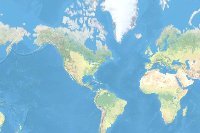

In [3]:
training_data = gis.content.get('25ed4a30219e4ba7acb3633e1a75bae1')
training_data

In [4]:
filepath = training_data.download(file_name=training_data.name)

In [5]:
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [6]:
output_path = Path(os.path.join(os.path.splitext(filepath)[0]))

## Train the model

We will train CycleGAN model [[1]](#References) that performs the task of Image-to-Image translation where it learns mapping between input and output images using unpaired dataset. This model is an extension of GAN architecture which involves simultaneous training of two generator models and two discriminator models. In GAN, we can generate images of domain Y from domain X, but in CycleGAN, we can also generate images of domain X from domain Y using the same model architecture.

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAABBwAAAE1CAIAAADLYmQLAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAADsMAAA7DAcdvqGQAAKBkSURBVHhe7d0FXBP9HwfwBaMEwUBB7MCuB7vBwhbzsQO7u8XCTlRU7A5EVEQxULEReFBAEAUl/gKilMAcc5v8f9v9mGNsyArutu/7xet5drfbdjtvd7/P3S9oeQAAAAAAAACgAggVAAAAAAAAAJVAqAAAAAAAAACoBEIFAAAAAAAAQCUQKgAAAAAAAAAqgVABAAAAAAAAUAmECgAAAAAAAIBKIFQAAAAAAAAAVAKhAgAAAAAAAKASCBUAAAAAAAAAlUCoAAAAAAAAAKgEQgUAAAAAAABAJRAqAAAAAAAAACqBUAEAAAAAAABQCYQKAAAAAAAAgEogVAAAAAAAAABUAqECAAAAAAAAoBIIFQAAAAAAAACVQKgAAAAAAAAAqARCBQAAAAAAAEAlECoAAAAAAAAAKoFQAQAAAAAAAFAJhAoAAAAAAACASiBUAAAAAAAAAFQCoQIAAAAAAACgEggVAAAAAAAAAJVAqAAAAAAAAACoBEIFAAAAAAAAQCUQKgAAAAAAAAAqgVABAAAAAAAAUAmECgBIJD7hC5/PxxMAAKAxv3i8hP99wRMAAKAyCBUAkMi4yTMzf/zAEwAAoDGpqWmTps3BEwAAoDIIFQCQiPvx02z2TzwBAAAak5WdfezkWTwBAAAqg1ABAACkx490H9epVYsGtataV6lSxdq6TmPbNm1F2rRsWKd2/RYdBzg5nwlIgbpzAACVcZ+79Gtn29SmuvB4U8W6Rv2WrfHxxrZRndo2zdr3nbT21KuvcLwBBUGoAIBEAl4Hc7lcPAGAtJyro8oxaHoNFr/g4DlCvKwvIde3/Nu4LKtSV+eHKQI8G4Ci5Obmvg76D08AUBg/elt7Fo1h7nhG8qjCz0kK9d4xuokZq7Ldev9UON6APyBUAEAi0KYCFIX7ekVjPRqz2vT7uXiOBEGKzzQbFqNSP/cYuH4I/g7aVIC/yLw8ohyDbtjDLbFwciCON0yrIWfi4HgD8kGoAIBEdu9zy2Gz8QQABfE/7eykT2eYD7uYiecUJEg62teUzqwxzTcbzwFArh8/slwPHsETABSS+3BWTSaN9c/6MB6eU4Dgy6FeZeh6NgufSd43BToNQgUAAFBD6qmBpnS6of3+BDk1DvhRW9uxaEzrqb5wlgcAqIQXtu4fdDipMeuhjBujQrzwDbYsmp7NoudQZxcQIFQAQCLvIt7/4sm8KAQA+9YkSwaN1dI5VO4u8u1IbwMajdVp12eokQD+gsvlRryPwhMASBEkuvUwpDPKjbgs+8ao8FbFfjt9Gs3A4WgqngN0HYQKAEgE2lQAubgvlzbQozFryr1umH+noujcAQAB2lSAomR5/FueQTe0PyDvxii+U0HT77I7FlprAxEIFQCQyMbNO7Kzc/AEABL4H7a1Z9EZ5UZeycJzCsu9M8WaiU7y3fbGw0ke/EVm5g+XbbvxBAAF5T6eU4tJY7VwfiP3AgXn1qTKDBrdqP/JdDwH6DoIFQAAQAHfTvQ3odONesrqiAXjR2xqxaLRmNVnPMjN4707OfffgfYd23do16Zjz6EzjhYoGwi+XFvUq61tm3adezrOOR2B5wIAgBBxF4JZTXgskQPfqNBruOyVRJuK7Ce7nNCBp1PHDu3bdew+Yps/0WuEIM13de82tq3bte9k33/8vlfQ6ks7QagAgERi4xJ40KYCyJBzY3wlBo1lu/Gd3P1DEL/f3ohOY1iOv5F/M4PzfElDFt2g/db30m0sBN9uTm3Xc/WND9BRlK76xePFxSfgCQAkCZIO9zKi082HXsjAcwpBxxs7QzqNWWPmg0IJIc1rvDWTUfHfKxK3MLjhm7o1GbHrUbzclAKoD0IFACQCbSqAbNzni2z0aHp15vnL7WeF/3mvnTGdpld33uM/vRLzPx/oYUrXqzP7YYGeijNf7Zw8+3QUnN11GbSpAHJlXx1dgUE36LZPbkVKfqwrOt7Q9ZutDpRxTOJHbOtgzDDusC2CuJzBjb4wb9JGGJlT60GoAIBElq1an5UNl46BNP77zW1ZNEbFMZ5y947c1yubsuiMCv2Pxha4K5HpPbkqk1Fu0Mmk/PN5dtDeSVOPvoP6BzouPSNj1dpNeAIACVz/eXX0aKxmq4Pl3RjlBq9tqU9nVhnt8U12UMi45VSNybQedy1NwP1wdt6UnS/l3vMA2gNCBQAAkJzgq7uDMZ1u7OCeLOdKH//TkT7lGcwqg08UGk6b93bdP/p0A9v1oh6h2G8PTp7oGgK9AQAA5CBaZxUx4I0g/uQgCwbTeuiZgpcwJPGjdnUpwzD8Z8qaGZN3vpTXLS3QLhAqACCR76mpfAHcIAZScq6NrcigsdpsjpR9Bs9959qrItOk+cL7qTL2HkHSyYHlGMxqTrdSwt2dxm57Bed3gPD5fHTAwRMAiAmSj/Q2ptPNHM/J7tWJ9+HoAEtmmeYLH6QVebbK8p1Wk0k3snOFHmd1BoQKAEgE2lQAGbhP5tfVo+nZLHwmo/KyIO3V7oE1DCt2XuP3Vd6pm/1oTh09eplarYau9y+6GAB0B7SpALLlXBtTkUHX77Jb1hiaWW/d/61nVL798rvybpvm40ScmNKuqiHDsPVGGDdHV0CoAIBEZs9f+uOH/GEIgE5iv1zamEVjWIy7XrDSEi/t3W3XWd2qV7AZ6HwzukBDbGlsr7EVmKYOR+QOYwV0T1pa+vzFK/EEAPkybjlVZ9L0Gq94XSAKCLI/PT62tG+9irV6rbj6/m8VKNlh7jOmuAYm3ZlWk8mwGnVFTssLoGUgVAAAdFvu17DHNy8eP7Bjy7Z9J7xexYtL54KM4PsvxM2bSx735daBHdv809DalEmn0eisija2bbHWrWxtWzRt1m7A9M3nn/9ZY3m4AcsbsQy67o2DEzsAQDbuM5d+7Vu3rG9pzBAecIytm7TGx5s26HjzT7OmrXpNXHv8YczfuxJhhx6eNuVAsHBBfvQ+O1OGge26N3L7rSMJfkb0C58rJw/u2Lp9/2mft1/z1xedBx6+gm6riglCBQAk8vPnTwG0qSgp2e+9XCZ1b2hp1aTv5CXrdx05c+7k/nVT+3bqvfBqDDcvO3B79xr9jsqtUkQh/E+7OusX1ZML0EXoUPOTA32AATXLDnGbPt3tjfhWRvaDmbX1GJVHXiJrwVyQHnJmxbC2Naxs7MYtdN55+PTZ43tWjevebbTr6wwBJ8zVoa7j6TS8LPgLCBUAkAi0qSgh7PeXF9lXNzZvOmaPX6zUhf7M19v6tB/m1Ntaj9Vua5Tcvk0o5NupgWWL6MkF6CZoUwHUjR3jtaR7nw1BBSpH8T/t716Wod9ybTD5blZw3l+a38W6jFWXRRdC0woc7PkJXlO79ps4qLa+foft0dpwHigRECoAIJEJTrMgVGgaL+H28k4WeqbNp136ILviEP/Dri7CYeTqL3lJ9lv2f5H5aIfT2OFd65Uva2ZtO2D0lH0v/lpVCugKFCqcps/DEwCoQpB2f9O/fdrbVCpbpmztnttf/rmAkf5go2OramampmaWTXuOdNr3gjTXNgTf/DfYW7LM2yz2+SLzJm6617gqTOF54AXFzwMlCEIFAECHCFJuz2liRGfVnXjti/yb8YIv++0MmFaTblGvCH758mV/f388AQAAGvP58+eDBw+y2VS8VJET6NLJnMGq63RDfi9W7BvjK+lVGi/VQwYoAoQKAIDOyH27064Cg27QZJF/0WM15N6dVs188BmqVaS9du0aTeTNmzd4FgAAaACXyyWONi1atMCzKEOQ5DW5LovOspnzoKhxvvnvNrYy66MVDetKCoQKAEhk0tQ5UP1JY7hvNrUtQ6cxq0/2lj2m0x/cJ/Mb2u2h1pBNubm55cuXJ07zHTp0gBb/oGipqWlTZ87HEwAoaNu2bcTRBgkODsZzqUCQdnNyDSadUWno+aLH2uDHbO/a0SUCGlQUH4QKAEgEGmprjiDx1OAKDBrdoN2Wv58k+FGX9nl+ota5xMXFBZ/hRU6dOoWfAEAWaKgNlJaQkGBsbIyPNTRa27ZtqXMVgxe2qbUhXTSaaC6eJYcg6fahixHQaZ4CIFQAQCI5bDZcYNYMftS2DuhEQjfufiBeC7dwXFyckZERPsOLWFhYpKf/7Y4M0GHoUMNm/8QTAChi+PDh+ECT7/jx4/g5kuM+W2ijR6OxmqwKgrigdhAqAAA6gP95T1cDlCn0O+2k2A2I4nF0dETn9Q4dOqD/6unp2draogdz5sB1aACAmt2/fx8dXvT19YnjTPv27dF/K1SokJZGgVZovODVTVk0GrP2XH/o00n9IFQAQCJzFiz78SMLTwA14niNrcBA5e16C59p35nE19cXndQNDAyCgoKIB69fv6bT6QwGA1psA3nS0tIXLFmJJwAoHi6XW79+fXScWbNmzciRI9GDY8eOtWnTBj2YOXMmXojE0k8OMKbT6KaO54rurAMoBUIFACQCbSo0JfWogwE66+n3OpyC50jiBu507NShU5du9j16OfTp26dXD7uunbtNPRtHgZsaubm5devWRd9t/fr1aWlp6AEKFWj+1KlT0WNosQ3kgTYVQAlE++waNWqw2WwiVJw4cSI4OJguQvoW2/yY7R1YNJpeA1mDEPEjj4zrgk4EdvY9eqPzQO+e9t06d514HIa+Kz4IFQCQyLdv3/lQBNSEnAtDTISXp4ZfltulOp+TmfR8la3wzrj1v2djsilS35Zon127du2fP38mJiaix3p6emj+9+/fic6goMU2kInP56MDDp4AoBjE7bNv3LiBJrt27Yoeb9q0CT2eOXMmekz6FtuCZLfu+jQaq7XcTp3QiSDBe3o9PRrdpOuWkDQunJAVAaECAKADeEGrmqC4oN/zcEoR5wiO71RrJo1hOdGbOqM5+fv7N2rU6NatW+hxTk7OrFmz5s3DwyQfOXIEneP/++8/YhIAAFSRlpY2bdq0fv36/f79G02eOHECHXBevHhBPFWnTp19+/ahsCpalqRy706ryqTp2SwuYpjsjAtDzel0/a574yBRKAhCBQAksmLNhqzsbDwB1In7allDFh3lhZvyR0flvlraQI9GLzvodCqeQw08nuy7KgIRPAFAQekZGavXueAJAIpN3gFH3nxyybo5sQqTbmjnKrcbQM7dadWY0D2UUiBUAEAi0KZCcwSJ54ZWZjDMex6IkXMhLdN3Wi0mja7feddnitahTUtLYzKZxsbGeBoA+aBNBVDRqFGj0AHn5MmTeJoaeKGb25VhGLRYFcDBcwpKvz7BmkljWjvdkf08KAKECgBI5HNsHDUu9lCS4NvdxbZmTNN/5nh9LjToUUbQgWHt2/5jzWQ1pe71KcmG2gAU7RePFxsXjycAUJy4oTaepgru+yODrFmG9Sec/yCVG/jJT3c4dmzdrBKz7OAzFOggl3QgVAAAdEhmyPFZXauVMW/QZ5rz7qOXvO/f975wwHnG0F69Rm+4FctJ9JzqsMz/L8Osktfv37+zRPA0AABozM+fP9HR5tevX3iaQrifrq/sU7esef2+M9btO3n19v07nse2zP+3p/2I9T5xnOhjI0cfoOoN61IFoQIAEtm0dVdOjvw6/0A9clPC759z3bx22aLFK9dtO3DublgKZXMEAErKzPyxZcdePAGA7uF+e/fg7D6XNUsXLV2zaffxm4FfqNNDB0lBqACARKBNBVBFenq6hYVF1apV8TQA8kGbCqCiqVOnogPOhQsX8DTQeRAqACCRsPCIX9CmAigL2lSA4uNyueERkXgCAMVRtU0F0BgIFQAAnZCRkREQEHD69OkVK1aMHTu2X79+HTp0aNiwoZWVVZUqVWrWrGljY9OkSZPWrVsPHjx47ty5O3bsuHTpUlBQUG4uZepG8fn8OBE8DQAAGvPt2zd0tMmmTjfov3//TklJefLkibu7+8KFC0eNGuXg4NC2bVt08Le0tLS2tq5Vq1b9+vWbNm3avn374cOHL1q0aO/evZ6enu/evSP5+BskAaECABLZu/9QDhtqdaqHQCB48+bNvn37UEhAJwyaslgs1j///DNt2rSjR49+/PgRvzsAFPfjR5brQXc8AYCW4nK5z58/37x5c8+ePcuVK4cP64ozNjbu2LHj/Pnzz507l5SUhN8dFAShAgASgTYVqsvKyjp//ryjo6PU+YPJZNrY2AwcOHD58uWHDh26fPnyvXv3AgMDUU6Ijo6OiIgICQkJCAjw8/M7c+aMi4vL9OnT+/btW7NmTfz6fHXr1kXnlfv375PwDkZGRgZxmQ1PAyAftKkAKlq4cCE64Hh6euJpMvn69aubm1uPHj2MjIzwsVvEwMAAHSGHDx++du3ao0ePXr16FR3z//vvv5iYGHQuePfuHXr86tWru3fvHj9+fN26dZMnT0ZvUqlSJfz6fC1btlyzZg1aEu5gSIJQAQCJvAoI5HK5eEIzNm7cOJJMHj9+jNdMNWw2G+WEIUOGGBoa4qM+jWZhYTFs2LCDBw+GhoYqvWG/f/+OTjAoZgwYMKBMmTL4rWk0ExOTiRMnPnny5Pfv33hRFaBPwVtEBYMHD0YrxmAw8LRqYDRuwtSpU/EWIQeUgfGaqQal4oDXwXhCMzZs2IBXmhz8/f3xmum87du3442igmrVqqEDTuvWrfG0CtAxFq+ZalJTU93d3e3t7dFhUHScFqpZs+aECRNOnTqFYoNyGQAd5P/3v/9dv3599erVdnZ2LBYLvzWNhvIGCldhYWF4UZW5urrijUION27cwGtWDBAqANAt6ICIj4XkoPporJ8/f168eLG5uTl+RxrN1tZ2x44dERERainuS0LlsAcPHixYsKBevXr4w0T3LlDkQKccvJBSEhIS8NuRBlyBI6BoircIObx+/RqvGel169YNrzQ5oGIlXjOd179/f7xRyOHAgQN4zZQVEhIyceJEAwMD4g1RqEDR4siRI5poY/bjxw8vLy8nJycrKyvi4xB03nFzc0tPT8cLKevff//F70gOW7duxWtWDBAqACCRoyfOsNk/8YRmEKFiyJAhqDRfuogDFnqA10xBKDA8evRo0KBBdDqdeKvGjRtv3rxZXddx/yo0NBSli4oVKxKfrqenN2nSpA8fPuCnFSQOFcTGKUWHDx8m1gRCBYEIFc7OzngDlR7i30VdoSIrO/vE6fN4QjOIUDFs2DD8BUoPsekgVIgRocLBwQFvoNJD/NMoHSp4PJ6Hh0enTp2I90HQ44MHDyYnJ+MlNAmdhp48eTJhwgRjY2Pi001MTJYtW/b161e8hOKIUIG+Bd5ApQd9F7QmECoAoKoSaFNBhIpbt27h6dIzUtQdITpy4WlFoDjRvn179HKEwWAMHTpUXdWQFMXlcq9du9avXz/xyqBTgrxb4UUMPUuEivLly+Pp0pObm0t8FwgVBCJUxMbG4unSg2IzWhN1hYoSaFNBhIrbt2/j6dIzfPhwtCYQKsSIUHHlyhU8XXomTZqE1kSJUCEQCC5evCi+aWxkZDRt2rTw8HD8dMnKyso6fvx4u3btiJUxNDScO3cuOqrjpwsqegxyIlSQoaNe9BXQmkCoAICq/B7552q4TQXVQ0VAQED37t3RCxEzM7Ply5fHx8fj50oVOpmNHj1aXJF30KBBgYGB+Ll86Mt+/vwZTxQEoYK0tDVU/ORwHj5+iic0A0IFaVE6VPz+/fvmzZvNmjVDL0SqVq26Y8eOtLQ0/HTpQSvm7+/fo0cPYsVYLNbUqVNjYmLw0/m2bNny86fcKgkQKgAAlEHdUBEXF0c0REaMjY1Xrlypeu1VtYuOjnZyctLT0yPW08HB4f379/g5UWcpo0aNwhMFQaggLW0NFSUAQgVpUTdUBAcHi28IVKpUydXVlcPh4OdIIyAgYMCAAcRKMhiMiRMnSlaIQqkD5Qo8UQiECgCAely47PlTw8dHKoYKHo+3a9cuotKqvr7+vHnzVKmxWgLi4+PnzJlDNBlksVhr1qwhrkv169ePTqf/999/xGKSIFSQlraGipycnEseXnhCMyBUkBYVQ0V2dvaCBQuIu8Hm5uaoXE7ycffevn07YsQIotUfWuEjR44QXerVqFHDzMwsNTWVWEwKhAoAgHpAm4rCgoKCWrZsiZZE+vbtK6/6EAklJiaOGjWKWPPatWv7+voS1X979OiBl5AAoYK0oE2F0iBUkBblQoW3tzfRgy0yffp0Et6mlic8PLxLly7Emrdt2zYgIIDIRQsXLsRLFAShAgCgHje8b3M4mh1SjUKhIisra/78+cTx19LS0sPDo1SaYqvowYMH4qaE4o6q7t27h5/OB6GCtLQ1VLDZP719fPGEZkCoIC0KhYrExMShQ4eiZZBGjRo9f/4cP0Ed6Mx1+vRpoqtA8VlAX19f5lEFQgUAgDKoEirQGlatWhUtgMyYMSMjIwM/QUEcDmfRokXiNtxIy5YtpQIShArSgjYVSoNQQVqUCBXoIHno0KGyZcuiBQwMDFxcXDQ9OKxGpaamDhkyBH0XsbFjx+LnJECokMQL3tixsrm52d+Ym5e3rFG/eTuHccv2eYakwLkLFIP2713ePr5wp+LXr18LFy5ETyGoFPXixQv8BDWlp6cvWbJEcpxvwvnzBYYIgFBBWlp8p+LWbfUMYywPhArSIn+oyMjIEPfMYW9v//HjR/wENcXFxY0bN07y0hJCp9PfvHmDl8gHoaIAbkpU0Kvn/vdvnlvTo5Jo69ENm045fvfpy1cBYi+f+t2+enz70rFdapRh0Ol6FW0nugWkC9uvAFAErd+7oE3Fly9fOnTogOajg++6desofV0K8fX1rVKlinBPLaRmzZqS3w5CBWlBmwqlQaggLZKHClTUrlOnDppvbGyMzhFUrPgqyd3dnRhIrrDevXvjhfKpNVQI2Dls/FBx5Kr+lHNtbEVhsY9uaOcaL7dEx43zWWNnpUenMcxbL737FXIFKBZt3bvOX/LQ5d6f/Pz8iAIc+i96jOdSHDodxsfHP3jwwM3Nbf78+X369EEnSyaTib7m3r178UJqDBVZ0VEJPPxYKRAqpGhrqMjJybl4xRNPaAaECtJSa6hQ6aBTOFSg8jRxa7dBgwYRERF4LsXxeLyPHz/6+Pjs2bNnxowZ9vb2VatWJdpXSJ3s1Bcq+HGeU5pU7bzuaZpypR9ShQruk/l1RV21s1o6hxa9t2W9dG5rirYs02rImTg4i4G/g71LeaQNFenp6aampmhOx44dv3z5QszUVr9+/Xr//v2zZ8/wtLpCRU7wrp5WJo2mXEtQfl+HUCFFW0NFCYBQQVrqCxWqHnSkQsWbN2/QJILK1iTvMVZ1bDb77du3ISEheFpETaGCF3tlcuPqneeuGd+sWidnf2VyBZlCBT/CpTVLuF8wa8z0+2sdcfbThfVZwoKf9cQbFG6OCUqI9u5dfo+e6PKI2hcuXFi0aBEqcONpXaKGUMEJPzS4Zff1foHnJ7fusOCOsrfmIFRI0dZQ8ZPDeeT/J9ZqAoQK0lJTqFDDQafwnYp169YdPHiQ6lWelKaOUMGNuTChRfMxJ96x8/IEqU9dejbssuZxqqL/OiQKFYJkdwdjVI6jMcyHX8rEM4vAC17dTFhKpJftfVh+bRYAhLR474I2FTpL1VDBjTo11m7k4bc5wglB0p2lPR3WKHVxCkKFNPWEiszAA8t3+H9T6QCka20qBOysbJWq8v0BoUKKOkKF7IOO6CkFyGuorbNUDxW8sG0DHZz9JCIeJ+q8U3cnjxTFjj8kChV/qrzbH0gozrfg3JpUWfSCsoPPKLxPAt2ixXuX+/HTbLZw6GXNgVBBTqqGCnbEo6dxEgUwQXrww1dK3ayAUCFF9VAhSHu6oZt11bo1rFovupOszD8KQb2hIis7+9jJs3hCM5QPFRmvXKcMGz116oAWDXq7PCk4zpngy41lA3pNPROtwP4JoUKKOkKF7IMOnig2CBVS1FL9SfmjjATyhAru0wXiKu9vi3Whgft6eSPRK5g1Zz/UbJeagOJg71IJhApyUltDbZVBqJCiYqgQfL27rL1N15W+ibzUp1v62NjOuBav5IbVlTYV/E/H/u2/9kUmOnYHLGvIMmi/LUpii/E/bO+gT2c1XR2kwF0MCBVS1NpQWyUQKqSoqU2FGpAmVPAjXdoQVd6rF6PKuwgvaHVT0UvopsMuKd8BFtB+Wr13BbwO1nQnqiqGiuzY175e13yDE/P7qOKnRz/38br1PCZT0UsjECokQaggLVVChSDRe26n9k7n3uf/XrixXvO7tJt06bMy21a9oQL9Q78O+g9PaIZyoSL9ulOPZS+EW0yQcmKAKV2v/pIXf46Kgq9H+5ShM6tNv6/IBSIIFVIgVJCWSqFCwE5+/yYsLkOBwC0fWUKF4KtiVd6Fcn2nWAv7WKTRDPoeL3irEwAJ2r13kbpNBffztaVDBk/b5H5i30L7uvVHnojMTX20ady45fvPnd81vnkd+x1BeMnigVAhSdFQkZv5NflbWmY2h8vNZWdnpKUkJ6cX6oyYn5P6VbRQLicnIzUlLac4wQ9ChRSV7lSwP4S8kx4lJ/t9SGQWfqwQnWhTIUg5NbzX1kjhvidIOtq3LJ1ZfZqvqNY+IfvamIoMRrkRl4t5+CdAqJCiXKjgZX9LTknLQEcU4WEnMz31a3Lqn6NK/rPs3FxONjrgpGQUJ/dBqJCidKjgf/FeMXTo9LXrJrWybj7LK6nAcYcfdXx0i4b99oUrEDfIEipyvMZa4Crv+4tV5R0dO5IP9TQQlhRpdNPhl+FOBZBLu/eu3fvcctiaXUNlQ0X6gyX9Jpz9RByQ+NHb2uubdx46aNCmEE4e/4OrvRmDxmrhLHqyuCBUSFIsVAiSr69w7NOtaWV94Y5NZ5at1bbX0HW+UomZG7RvWPNKwq7P6Hpm1Vt2n3X+UzFiAoQKKeppqK0O6g0VP35kuR48gic0Q6lQkfH2SZConxr+p73djKXuU+Rx/efV0aMb9TyUWLzDPwahQopSoYIbsGdMv+6ta5oyiBOqvkUj+1kX8o8qHP+N3euUFZ6eaXSWeW1bu6HbnhbjbAahQoqSoYIbtnPQENcI9FvhvlzaQI9luz5MIj/wwjfYsmhSM/+GJKGC+3RBPaLKewvnN8Vc/dyHs2oSl5L1Gi59pdnqH4DKYO9SlXKhgv1sWY8pEj3yph3tY0BjVBh6XtibDff16maGLItO61/gZ4sHQoUkpao/5QYsb8yi0Zi1Zj+Sc0kw99mi+hVtZ50NLf6Y8hAqpGhrqCgByjfURviRW9rq06WO9Lyw9cKyUWuXCMV2TggVUlSo/iRIuTDcgoGCQ7utkm1dhLjPFtqY2gzZevdz8a+NQaiQolSoQP8oo3tvELUyFSQe6oXCeKPlARKVBhMP9jCkM2vP9VekBESOUMF/vzm/yvuMB8Ws88iP2tpO9Boa3XzI+cJjCQjSXp3duWPvwSPHTp46dfLEMffDB/ft2r7PW7LzB36Mz/5t23ftQwudOHHs8IG9u3aeeankMIKArNS1d2UGXdy1fefe/YeOHj958rj7oQNof9q60yNM1oGQHe65Z/uuvQfQssfd3Vx37b4QqNB9d0W8i3j/i6fAhQQlKBUqcq479XQO/rNi3FdLG+rRyw46nUpMC9jpGQoPBA6hQpJybSpEl5/oNGbtOY9kbf+coC2D+m94WvxAIQShQorSoYKX8GDXzDGjJ4wd0rNLjwk7H3/l5wkygo8vcZo81WnCv45DZ7q9Uqw2pnpDBZfLjXgfhSc0Q5VQgTNF87WSmUKQsN/ekK5ns+i5gleHIFRIUalNBdtvVi0mjW7UZXeBHrhyww8O6T7Hu2C1m7+CUCFFmVAhSHIf0t9V1FJLELvfHmWKOvP8Jc4JmZdHlGMwKo65ptBogqQIFUQjKrQedPNhF4tZ9hIkuxOvodGNe7h9KbxDCpL93TeuXTrNwQYvxrJqO2rh9luS9/K57y6tHNxA+DydWbZut5HTl2w4HaDYyRSQnbr2LsG358c3rV06tWcdI9EzDIvWYxau3e4ZISunZAWdXta/rj6dRtev3LL/5EUbL4RobJRPsrapEKTGxkk0xBYkuvUwpLM6bFekT8dCIFRIUrKhNj9qewcDlCqqTfWVTsSCBI+p/efdUrhbWQgVUpQLFZwwt3/7zLpANJ4QxB/tV960/YbLu0aM2BGUlcf/dH5SE3M9VquNomWLSyfaVGDEQUbPZuEzyfiQfn6IOZ1hOclb0UqiECqkqNZQmxeytgWLXqALLn68h1PPiec/K3xRDEKFFKXuVOREv40SlYn477e2N5DuHC3Xb2Z1Jr1M32OKDVRBilCR4zWOqPJuYOda3IHGUs84mhOlPlOHIzIyhRg32PkfYeV4huWYq4Wv8AhSroyyNm824cDTRF2v4qKt1L135TyaI+qdlmk94XoRg21n+i9sbNZg7NG3GrtDkW/j5h3Z2RJtEjVA+Ybaf2R7jqnAUOJqYUEQKiQpGSry+LGudsZ0GsNqwo0CbX+zX20aPOJAeDFv50mCUCFFmVCR82xlr9Fn4sQbkBeyphmLzjBqvSEUneoFX/bboTMZo6KjYsNEqDdUZGb+cNm2G09ohgqhQlRrlW7qeF5yt+bcmWLNVGq8IQgVUlQLFSgW7xMed5g1pt8VnrAEqX7LHRz3vlU06wlBqJCidENtIVH9QDqr1cZ3EpkCZcDmaGb7bR8UO6STIVRwny3EVd4L3rQsgiBR2MGD8DVMq7GeRR8rBCmX/7VEpUq6UVuXgs1NhKML2Tfvv/u1xst9oNSof+/iv9/RSXizgm7a/YCcPh5z3x8b2qLbmodKjSNGQmoIFaKGLYwKoz1Vu2MDoUKSsqEC7eJHHExRAdXi3yviKy382AuT+y/yVW74ZggVUhQPFYI4twF2GyVH0WHfGF+JQTfstjeW+DfJjvS94PkiXsEymC61qch9MLM6k2k95Y5ELs55OLuOHt2g6944hfdsCBVSVAwVqDB2bkgFBgrGwy9+yw7eNdhh5SMlq5tDqJCiSqggKsRKtccWxO7takDXa7hMopFFsZAgVPDfb25LVHmvVtwq7/z32zsYCkt9dKPWBY7CsvHebmglXJxhNeqK+JQp+PZwdTfbkSciFa7WDShEE3uXIPXyyErCmMpqtFxGG27ep/Nj/+m88pGoL5ISEBuXwCNjm4oCRCOF0A27H5TofkWQFv1BsRurECoKUjpUoLP76UHm6OxezvHcN9GMzGfOg0YdiVT2NpLMULFv3z4ytFQuFYqHCn7sfa9XkpVveUGrmgq7XtmgSH+Ohak3VPzi8eLiE/CEZqjSpiLt8r+VGEb2+/PvSXNjrzo1MKAr0keHhMKh4tevXxs2bMjKUqpzX+pTNVSgYHxnajUmjW5sO2Bgz2meCUpfgYBQIUWFUCH4ckDY5qhgh2l5aWcGl6UzrZ1uK1pCLv1QIUg51hdXeR96oYjqJBIybzlVF/bMQ2c1XPC4OBc+BameY6qgV9ANWq4NFm43Qcr9ZZ1tx52LVvYcCqhBQ3tX7oslDYSdbjIsR18teCeDn3BtSqu283ySSyhRIKQdpyI3NTEFX1UVJB/pbSyssinRcJvzdJH9LIXGokIgVEhSPlTk5aVfHlGRQaOX7Xc8ScCLOT1+wPKHKvRRUThUXL16FU2WK1dOudIh5aDi5g+Jn6HSDbXF+J93d9an69Ur2D5AcbrUpgJttfjri7tWr951/oHTx3aucBo5YcGoFvp0Zk25XZ0VpXCoWL58OZrToEGDd+/e4Vlajc1m//z5E0+oI1TkcV+vbCLsJgKVVpWp9pQPQoUUFUJFrt+sGky66ZALBSoN+ky2YtDNHM8pPEhX6YeKnOvjhFd9i1/lnR2w1lZU+8Sw2dInxb1gwAvf3Fb4IkZFxzNfku4s6mA74QLuPh9oMU3tXfxPrvYmwsXKdNvzp+GxINlnXltbJ8/4Eq0BsmzV+qxsjTUDF1EiVGQ9WtLMhKHffI2w5Zcg+Vi/snS68aAz4k0q+HZpfO/1ooivCAgVklQJFXlZ18dbolRRpvvWC8sHjD3xQaXDYeFQ8fXrV2K3QVavXq1N1aJ+//4dHx//4MEDNze3+fPn9+nTp06dOvr6+mFhYXgJNYQKQcqJ/iZ0huVEhZsXS1FvqEjPyFi1dhOe0AyVQoUIJyn8+f07j98mZPFSTg82pzOtp9xWptVZ4VARGhpat25dNNPY2Pj8+fN4rlbg8XgfP3708fHZs2fPjBkz7O3tq1atWrly5WyJk4saQkVe+vUJwmFl9eoW6GhIURAqpKgUKmbWkK40mH1/Ri2mIu1Q/yj1UCHsoliRKu/ZL1eJCn2MSr33K9SgMP3GROGuTNeztmn8z3hIFDpBg3tXxvXxohG3hT2NiI6Ngm8PV3RsMfpsjBbuWYqHCtFIOjSGeW+3T/y8rCfLeg90bGdq0G0fPkRx3x8dPdD5ueJRCEKFJJVCRV7O7SlVmcIh7tqsfFK8u3jyyaz+hIopq1atIuZ37949OTkZP0FN6DuuXLmyadOmRkZGxJeSNGHCBLyciMqhIsvj3wqMQs2Lc9ILD4H+FzrTpoKb8PTk5nWHnkhUqeR/PtDdlK7fdEWAEvcp5LSpyMzMHDJkCJqPoMK35IV8Kvr27dvEiRNtbGxYLKIT9QKkSu0qh4rciCMje0+c2FnYoMtqnJfyhx0IFVJUaVOR5jGqMtPIzjW/1RH385XJNsJKgy2d/966oJDSDhX8qC35Vd6n/70mRG7UyeE1WXS6nmWPLc8V7fqVH7m9o7Hw4rKxnStu+Aa0m0b3Lm7wmuaiKlAWwy9+42c8X9+tmeMRmf3Latj31FS+QLM7tBJ3KtiB27vXbTl+24kjm6c5jtzyNC33/ckxjev3Xrrfff+aSQOGr7n9RZlL1xAqJKkWKojhUpm1Zj9UvV2ZzFBB8PHxKVeuHHrK3Nzc3d1doOF9VaN+/frl5uZWqVIl4suKGRoaon8LvJCIMqFCwOOJNx7RZZFBtwLNizNvTbVb+ETBu3vqDRXo3xcdcPCEZigXKvgxe+3K0Gl0owGn8ouqgtRbTrX09OvP8lWyYp+8htq/f//es2ePnp7wglXt2rXv37+Pn6AmFJNWrFhROCrXrVsX7fB4IRHVQgU//uqUnhPOfeKlXx1dmUGjm/c/ruDoFH9AqJCiSqjIEyTcXNKtRvUu8w6cOrpzudOIiQvHtNSnFzE+alFKOVQoUOWd//Wxi4M1KvMZ1ht1IkKJsyA//uK/1YjK8vUXFmcgeEBxGt67BAnufcyEKdWo9eS53Zs47A7RbL+u8pC2TYUg6/MrX+/7QfHZ+WcOTnK4v4/3g6B4pbcUhApJKoUKQcrxfmXojAqjr6qh7lwRoQJBZeuuXbsSC3Tq1CkiIgI/QU0pKSnoWxBfh7BkyRL8XD5FQwUv4tCg6oYGVYadFnVhne3jZM1EgW+OxFmd/2F3317bFW61rSNtKrhPF9iYW9s6bvbHCYIXc3ZEDUPr/geU6rJURF6oILx48aJevXpoAWTMmDFor8BPUFNISAgKSMTXIRQODyqECkHqw+UOjrvfiP4xOI/n1tFDZ85OO6RH1y4uCBVSVAoVIpykd/mVBr8RlQadlKo0WMqhItNjVMW/V3nnJb9wn9OlCovOLNdi3N6nyUrshvx4z2ltO8zet7SDsJTJMO9zRPH+5QDFaHzvyr4zVdSmm1Gu88aXpdYv8ez5S3/80GxvJMqFCk2AUCFJpVDBvjXJkkE37CHZIZfSig4VyO/fv9EJj7hlwWKx1qxZw+GofoOkFKBfQc2aNYkvS0BfKj1dujmjgqGC6KWOzqwy5mqqII8T7OLQvX/XyiyriTdx4hN881vZb9j+MMWvHKo3VKSlpc9fvBJPaIaS1Z84QVv69l5w+e23XG5m7PPTS3o2th298+EXVVq5Fx0qELQPoz2ZqDiEfoZoD0f7OX6OOtBvFpXOy5Yti74FnS68DIe0bt268HdROlTkBO9y7LvqsfiOES90na1wHLzGyxXtsBSDUCFF2VDBTXx5dvumYy8kuhLnxx7sWZbBarzspVIVL0ojVOSmxUdHvX8X8vzWoSktTUW7MMNy6JHg9x8kRL1788rf58KBdbMc21gbMRjGVdtP2PkwQakdkBtzYWKrjgvvJAvyMu9MrSlqWWEz73HpXFcGmlWSexfvrXNLdDrRa7zitSqnLvKDUEFOqoQKbsDyRnrCrjaVqDVb2F9DBSElJWXMmDHEkvXq1Xv06BF+ggrQ1nZ0dCRW3sbGZvv27cRj9AAvIUHROxXccLdBdWvZLzly9uiWGYMHL/f+wvvqu6pbvRYjN7ifPOIya9jgGe4hSl240Jk2FaiMH/fw6IbFs2YuWu96zickSeWD8l9DBSEiIqJjx45oSQStfFRUFH6CCoKCgmxtbcUrv3DhQuKxzN+mcqGCF316fO8ZXgVGkRXEHuhuIhzVf8ptpW6UQqiQolyo4H/eL+xxRrLSYF667/S6LFa9qbeUG7KoFEIFP2JLO9EoAH9BZxqaW9dt2tZu4MSVh29HpCt5lwwlinNjbTstvY/HIeNH77MTFjXpZj0Pyhm5DFBXie5dgi8Hu6MPY1addlepRK8mP3/+1HQ9dQgV5KRCqOB/3tVZn860VtO+W8xQQbh37564osWQIUPIXxsqMTERFbaISucGBgabNm1C3zcuLg5NVqtWTeYtF2XaVHBTIp7eueMfnvzn/XK+vH3ie+dRyJ8qhApTb6hAh5qfGr7FpHyoULdihgoEbRZ3d3czMzO0vL6+PipXkb9bgrCwMFQSJW5NoN313Llzv3//9vT0RJMODg54oYKUCBW5UWcndBtxNKpQwku9OLwig8Yo73hW0cGKhCBUSFEuVHCfzK9nUrFBb+cHOEHwE65OqGtQucfOQKUrxZZy9SdN40afHduq66qHkpEr2292XT30O9KrM8tPDZWJgc7KujKyHAPFUyW6clYn0rap0AQIFZKUDxX82P3dy9DpBr2PqKciuEKhAmGz2StWrCDqjaBizbhx4z59+oSfIxOUCmbMmIGKicS369OnT0xMDPEUKoEZGhrKK3EqEyo0Q0faVGhC8UMFAQUJomyHGBsboz08La3gOEbkEBgYOGjQIGI9GQwG2sPF9fdQ0kBzQkNDiUkpCoUKQc6XgHNL7awNqk+/LyOG8uNc7Y2EF8k7bH2n+D0lCBVSlKz+xH7p3LPvap+YbEEe91uo57qBTZsOWuf9SZXLBtocKjgRx0fa2jn7S49szI893NtcOCCyqd2+P2MMAKCY3EezazFpdP0uu0v3ltcEp1kQKnSTEqEiy2dJ19at/2lYtYK5ublZ2XLW9VvYth91KFLFOlCKhgoCKnNPnDgRFWLQC/X09KZNmxYZGYmfK21RUVETJkxgMoWNphAUJ54/f46fyzd69Gh5Nwm1OFQ4TZ+HJzSDuqGCgDZ1z5490QsRMzMzZ2dn8ty1ePr0aa9evYh1Q784Jyen6Oho/JwIh8NBP0k8UUhxQwX3xaYe9a3MTcuiY4yJsaGxRbMFkrWcBF89ZthWMzcyMkELmJuZW9Vrbttl/nVF8heECilKhgokK9Jr55IZTpOnL9548OKTTyo3C9DWUCFIeeLSq37HNU9kdg3KfrqwvrA3UGbNab6abeEKtBYvbL0ti0ZjNV0tHN5Nu0GoICdV2lSol3KhgoCCBFF6I6ACmY+PT2n1PIs+9+HDh2h9xC1WhwwZEhwcjJ8uqIjr0NoaKkoA1UMF4dGjR+3bt0cvR1gs1tixYwMDA/FzJQ79PFES6NKlC7E+BgYGs2fPjouLw08XVMRerXRDbbWDUCFF+VChbtoXKvgZH+4fmN7Z2oBRpu8xOZX1uInXJtUS9S5bpp3zqwy4WwEUJch8sbwFCqaMcv96aH+LfwgV5KQdoYIQEhIybtw48QhcderU2bJli7iuUQlAAWD9+vXinp0YDMbo0aPfvXuHn1YQhAqlaUeoQH7//u3r69u7d2/0JoS2bdsePnz427dveAkNQyvw33//zZkzh+h1DSlTpsySJUuSkpLwEgqCUEFaECo0IsdnZv0KZqZlzStYWFSsUK6ssWFFB+GAvgVwnyxrZm5sYlaufIWK6MBfsQL6X+WqdluKM+AyANxXzh2qVqliaVGhItp/KlasUL6CReXK1m3XviytDqAmTZ0D1Z90kzaFCkJycvKGDRssLS2Jd0NsbW137NihodI5KnWFh4dv27atc+fO+PNotEqVKi1evPjjx494IaVocfWnqTPn4wnN0JpQIfb+/fvZs2ejAj16N4TJZPbs2fP48eOpmhlGkMfjPX/+fOXKlU2aNCE+EbGxsUHlvO/fv+OFlAKhgrQgVAAA1AMaauss7QsVBC6Xiwoujo6OBgYGxNsidevWdXJyOnv2bHx8PF5OKQKB4MOHDxcuXJgxY0b16tXxu4uqmA8ePPjmzZtSowgrR4tDBTTUVk5mZuahQ4fQtxPXrEMPWrRosWDBguvXr6sYMNBOGxIScuzYsVGjRonvSyCmpqZTpkx58eIFys94URVAqCAtCBUAAPXIYbM1XQEdQgU5aWuoEMvKyjp//vzAgQMl0wViZWVlb28/e/ZsVKq4f/9+WFjYly9f2Gy2VMkJrczXr1+DgoK8vLxcXV0XLVqE9mRikC8xc3NztFOdOXNGvZVStDVUoEMNm/0TT2iGtoYKsaSkJLTfdurUieiiQKx27dr9+vVbvHgxygZPnjyJjIxMTk5Gvyz8MhG0h6P8gH74KCdcvnx5586dM2fObNOmjdQPpGrVqtOmTUMJOSdHnbVzIVSQFoQKAABlQKggJ60PFWIcDgcVszZu3IiyhKGhIfFZhenr66OtgWIDWkaqxCapXLlyPXv2XLVqFXpPHk8jFV+hTYXStD5UiGVmZvr4+CxdurR169bifsYKMzIyQnu1iYkJSg7iuxyFoSAxePBgVJgLDQ1Vy32JwiBUkBaECvVgs9noC1y7dg1PA6A+qMAxffp08o9hNGfBsh8/NNuJGYQKctKdUCGJy+W+e/fO09PTxcVlzJgxqEBWq1Ytc3NzmeUtVCCzsbHp3r37xIkT165d6+Hh8fnzZw0VuSRpa6hIS0tfsGQlntAM3QkVkrKzs4ODg8+dO7d69eqhQ4c2b968WrVqKEigFSjMzMysSZMmffr0mTZtGvoVoGRSMucpCBWkBaFCPRwdHdHaI+Qfk5UMeGnvfE/v27x64fRxQ/v16j1g6Pi564/4vMsoUHWGG31h2aY74iHbdVV6ejqxa6GSCp5FVtCmQmfpZqiQB300+tmibfL169e0tDRUSkPxowTyg0zQpkJpuhkq5Pn169e3b9/QXp2SkpKRkZGTk6OWNj/KgVBBWhAq1ODDhw9o1Qn29valdfKggszwa9tmDfynihGDbmjZtGu/kU7zV2/esX3DihnDOtYqV7HlxCNBRIoQJN2Y1rBMrdmPClTj1EWzZ8/G+xaNdufOHTyXlL59+86HNhU6CUIFaWlrqED/vuiAgyc0A0IFaUGoIC0IFapCEUI8MCTh8uXL+DnwhyA16MTcbtYGdLph1Y4T1p97lSgdF7hfHm7uW92ig/Oz9PSna9uZMRjlRlzW8REB//vvP8kK2XXq1OFwVBm3nvKIUFG5cmWn0kb8i0CoIBChAsFbp/SMHTuWWBMIFQQiVHTv3h1voNJD/LtQrk2FlZUV/gKlh9h0ECrEiFBhamqKN1DpIf5pIFSIEaGCTqfjDVR6iH8a6oUKT09PYtXFqlSpkpUFw2NL4H6+vqSzJYtOZ1q0n3c+vIhtwwnbaVexWvNmFkw6jW5of+BL6QxmSw4CgaBdu3Z4r8q3adMm/DT5rFizISs7G09oBhEqyANCBUEcKsgDQgWBCBXkoa5QkZ6RsXqdC57QDCJUkAeECjEiVJAHhAoxIlSQB8VCRU5OTrVq1dB6jxgxAv23fv36TZs2RQ+WLFmCl9B5grRnm3tYsVBGMGky5VL0X2szcd+us9UXNXNktXB+q9PjAJ44cQJthvLly9vb26MHxB1wQ0NDMtRkkKkE2lR4eXntJxNoQ0XIysrCW4Q0NN27MVUcO3YMbxFy+Pr1K14z1ZRAm4pr167hlSaHyMhIvGY6z9vbG28UcggNDcVrpvN8fX3xRiGHoKAgvGbFUPqhYuXKlaic16hRoxcvXqAHjRs3fvr0KXqgp6cHpQ1EkPpwRRtzBo1GN2w4/WZSsU7ygjhXO0OUKpjVZzzQ4QYV6enpFStWRPuSu7s7ESdOnz49cOBA9GDw4MF4IZL5HBunoW4xAaAA/ufTTp1bt2xYu3o1pHqt+i1at83X2rZ5g9rVhU9Ur23nEgw/E1X94vFi41QafBAUBy/cbVTH1v80qiPaeatVr9PonzZ4n27bto1tyyY2NYknarZb9RS/BgBqKuVQERUVxWKxUCHv0aNHgYGB6AEKFWg+UanXzs5O11tsc97ssq8obBDAMO+6M4yL5/4VL2RNMxaNbj70gi73/DRr1iy05Vq3bs3n88Wh4vPnz0TX+GRoOwgAkEGQ7NbdgE43aLclQio65H4NuTi3tZm+7YZwCBWAUrKvjDRn0BgVh1/4JnVxUJAT/+LE1JamrMYrKNNaBgCZSjlU9OnTBxXvRo0ahR77+vqix9bW1uhxcnIyMVTq1atXRQvqJEHag/mNhXccaIwKvQ5EKXIOTT/e14Bu0G1fnM5WXwgNDaWLoLCKJjt16oS245YtW9DjjRs3osd16tQh4T2BTVt3qXfYVACoJ/fBjOpMGst2fZisXyjbx6n2wJM631O26jIzf2zZsRdPAA3jBa5sLLrUd172rsu+7VSrlxvZR1ICoGilHCrCw8P79u2bmJiIHqekpBw+fFjc75Obm9vKlSt1uYCVcXemDUsYKehG7TYreFmOfWWEGavpah2uIYACw/79+5cuXUpM3rt3D+1dUVFR6DGHwxkwYMCjR4+Ip0ilBNpUAEByvNB1/7BozOoz/WTW3uSFbRw8577O95StuhJoUwHy8T/t6qRPpxva7U+QfamPH7G5/1Rvne6ZEGiB0m9TIYaKeh8+fCBtC9qSlhuwsinR2ppZY8rtTDy3uHLOOZpYT/GFA1Q+FFzR3pWZqeiGLGlh4RG/oE0F0GmCpEO9jOjya2/y3myYsjUCOqZSGZfLDY+AhsslI/XUQFM6jfXPOpl33xC0W0/aqNsdqwAtQKJQIdmmQucJEk8MLC8aXIHOaqlED05ZDzc77XgK1WjExG0q8DQAgKRyro2pyKDrd90T++eSbm7A0aMvcaMy3rtzJ/zh4AaohO09yZJBY9aa81jiFhsv4tTBW6l4L+eFn3Z/qNnuxAHQOBKFirdv31atWrV79+54WpfxI7e0MxDdpqAbdd3zCa7JqWzGjBlo7/Lw8MDTZLV3/6EcNhtPAKCDuM8X2ejR9Botf/2nZwqO3/yR297DgVC9fvzIcj3ojieAJnFfLKmvR2NUHO0pERt4QWsHLngE9fiANiFRqABivDBhlWJRptDvtDMGTqW6A9pUAB3Hj97WnkVjWE7yzg/XvOSHKzv+s/BpsXu/A8UDbSpKCj9qazsWjV6mz9Gv+XffeF/913WtN+Yq3JsAWoVEoYLH46WmpmZkQKce/E+7OhPNKYQ1MEOhkqUaZGVlob2LwyF7K5NXAYFcLhSegO5KOz3IlE5nmtVoZivU3MbajEVnVChwiReoRW5ubsDrYDwBNEfw9VjfMnQa3di6sWin/qdpvSplWXS6sYO7OGQAoBWgTQUJsa+NIdpT0JjWU+7AzVF1gDYVAFAB584UayaN1X5bdP4dWvanE0Nr9j5UvIE/ASCfHK+xFgyaXoOl+c2C8gQ5MaeG12i/JQrqIQDtQqJQERwcbGRkhFI8ntZZ/JgdHYnKTzR9u/1f4FSqDmPGjEF717lz5/A0WR09cYbN/oknANA1vGDhuJ16Noue/7lfx321aswmeX3mAOVlZWefOH0eTwCN4T6ZX1dPWKPvlkRzOV7Q2mErXsBdaaBloE0F+RCnVSFG5Um3iqyvw4/a072isXEZU/NyFSwqV7GuVqNmrVo1q1lbVqpgXtbEpMa029CpLLVAmwqgywQJ++0N6IyKY65J9O7Eub9zN5S+NADaVJQI/ruNrVg0uunAU6l4jhDn/tatj+H8DLQNiULF73x4Wmfx3jq3JEKFXoOlr4o+l/IzYkODA1+/fPbY12PXsDp6opfRjZo6HfF58iokOhWu7mF43yL93uX3yD8X2lQAXZV1ZWQ5Bt2oJ1R2Kgk/OZyHj5/iCaAhgqRDPY3owj5XoB9HoP2gTQX5CFIO9yL6k9Vr+LdQIYEf4dJalEXoJv2Op8ApuSBoUwEA6XH959ZmQvcUQJuIgjJNr/EKiS6SAdBWECpIiPtySQPRPQdGpQk3i31/lBiwk+iFFq6ISKNKqLhw2fMn6buoAkAj+JEubVg0ZrUZD6B7ipKQk5NzycMLTwDNyH04qwaTxrR2ugPHdaADSBQqBAIBh8PJzYXTSV7uozm1mMJUwWqyKqiYl+zYt4QDdiJ6jZYHwBURaVwuF+1dfD7Z0xa0qQA6i/9pT1cjOs2gt7tk3XOgMdCmQvNyniyor0ej6fc8DNUHgC6AhtqkxI/Y1sFYeNuB1XxNSLESAufhbCKHMKs4Qets6rrhfRslazwBgE7IvL28R/t2to2qVjBHzMpZ1/+nTbt2XWddhpYVGsVm//T28cUTQK1yn27s27FdmxZ1LYX7NNqpq9gId+qOg7dDLSigzUgUKv777z/022vfvj2e1m0Zd2fZsFCsYFgMPpXw1zOrIPn8sMqi+xT0soPPpOG54I+JEyeivevixYt4GgAAAAAAqA+0qSCtnIAN7c1QUGCU7+ryKgvPlCknbH9fKzMzU7QwXb/zLmhQIQNV2lR4+/jCnQoAQAlgs3/eun0XTwAAgMpIFCq4XG5iYmJKSgqeBoIU/009rVl0OsO8+YSDz5Jk3DXlxD10nWxbqWqvbc+CXbubM1hNVgZCvykypKWlob2LzZYYfIiUoE0FAKBkQJsKAIB6QZsKkuMmPNzj1MHagE6jG1nb9h7hNH/tdrcTp47u37pq1kj7RpXK17abfuBpsvDmBO/9kaF2S/3hMjeVnb/kAb0/AQBKQE5OzsUrnngCAABURqJQERoaWrt27d69e+Np8Af7S+DNI+vnjBvSr3vntq3bd+s9aOSE2at3n3v0IRNaMhbLnDlz0N7l6QlnUAAAAAAA9YM2FUAnUKVNhd+jJzCiNgCgBPzkcB75P8MTAACgMhKFCjabHRYW9uHDBzwNgPrEx8ejvSs9PR1PkxW0qQAAlAxoUwEAUC9oUwEAibgfP81m/8QTAACgMVnZ2cdOnsUTAACgMhKFioiIiNatW48cORJPA6A+K1asQHuXj48PngYAAAAAAOoDbSpILS0t7fXr1xcuXNi0adPixYunT58+evTogQMH2tvboyJyo0aNmjdv3qFDh169ejk6Oo4dOxYtgBbbtWvX9evXw8LCcnJy8BvpPKq0qQh4HcyFNhUAAM3Lzc19HfQfngAAAJWRKFT8+PHD398fRQs8rXsyMzN9fX3XrVs3atQolBnKlSuHysEqsrS07Nix4/jx43fu3PnixQt0FsEfpmMiIiLQ3pWcnIynyQraVAAASga0qQAAqBe0qShl//vf/y5dujR79uzmzZvT6XQcBfKxWKz69ev369dv7ty5GzZs2L1799GjRy9evOjt7f3o0aPXr18/f/783r17Xl5eZ8+ePXz48K5du1AmmTx5cteuXatWrVr4DfX19Tt06LB06dLr16/DOIMktHufWw7pR+gDAGiBHz+yXA8ewRMAAKAyCBWlgM/nP336dN68eTVr1sSFfRGUAVC0mDVrFooHDx48iI2NRUvi1yiFw+G8f//ex8dn7969Y8aMqVWrFv6kfI0bN16zZk1ISMjv37/xawAAAAAAAFBQsUKFQCDgapdfv37h71aCeDyen5/fzJkzK1eujAv1NJqRkVG3bt1Qyf7u3buZmZl4UY1JSkry9PRctGhRu3btWCwWXgkarUaNGgsXLnz27JmKMUYJaLPgfxVtoco2fBfx/hePhycAAEBj0MEq4n0UngAAAJUVK1QEBwfjsqe2aNq0Kf5uJeL169dTpkypUKEC/ngazcrKavbs2Y8ePUKHdbxQiWOz2Tdv3pwwYYJk441KlSrNmjUrNDQUL6R5//77L/5sbXH2rPK9NEKbCgBAyYA2FQAA9YJQoUEcDufMmTOtW7fGn0qjVatWbcGCBc+fPxcIBHghEvj169eDBw9mzpyJog5eURqtQ4cO586dQ18BL6QxECokbdy8Izsb+uwCAGhcZuYPl2278QQAAKhMgVBRr149PvWhAj36LpoOFXFxcStWrKhYsaKokEkzMTGZNWvW69evSd50AUWdFy9eTJ482cjIiFjzChUqLFmyJDo6Gi+hAUSoOHr0KP4XorJBgwah76JKqAAAAAAAoCIFQkWDBg3wNJW9evUKfRfNhYrAwEBUsmQwGOhTiI128ODBH1Sr0JKenr5v3z608sS3QBwcHFAew0+rFREqTpw4gaepbMiQIei7qBIqYuMSeNCmAgCgeb94vLj4BDwBAAAqg1ChNm/fvh04cCB6cwSFCkdHRz8/P0r3qoRW/tGjR8OHD9fT0yO+V48ePdQeLSBUSII2FQCAkgFtKgAA6gWhQg0iIyNHjBiB3hbR19efO3dufHw8fk4rJCUlLV68WFwnqmfPni9evMDPqQxChaRlq9ZnZWfjCUBZPj4+o4F8Hz9+xFuqIF9fX7wEkOX9+/d4S6lDekbGqrWb8ISa3LlzB68rkCUqSnZ3W/fv38dLAFnevXuHtxQgNwgVKomJiRk3bhxR2YnJZE6dOlXL4oSk5OTkRYsWiaNFr169Xr58iZ9TAYQKoH127twp+pUA2dBxGG+pgvbt24eXALI8ffoUbymy2rt3L15XIMuzZ8/wliro4MGDeAkgy8OHD/GWAuQGoUJJWVlZixcvJuoFoVAxfvx4FDDwc1pNKlqMGDEiIUGlWrkQKiR9T03lk6lnMKAcIlTo6+sfAwUJjxrFCBV4aZCP2CzqDRV8Ph8dcPCEmhChgk6n4/UG+Yh/wb+GCrw0yEdsFggVVAGhQmG/f//28PCwtrYW7eq04cOHR0ZG4ud0BooWCxcuRGUmtAWMjY1dXFyU7nwWQoUkaFOhHYhQMWvWLDwN8qFjL9oyRYeKKVOm4GmQz9bWFm0Z9YYKTbSpIELF1KlT8TTI988//6AtU3SomDhxIp4G+dq2bYu2DIQKqoBQoZiPHz/26tULvQPSpEkTeQcIHREdHd23b19ia9SuXfvWrVv4iXzv37//a+KCUCFp9vylP35k4QlAWRAq5IFQoRxNhIq0tPT5i1fiCTWBUCEPhArlQKigFggVxfXz509nZ2fi2ryJicnu3bt//fqFn9NtKEvUqVMHbRYEZQzJJpgeHh5Dhw7FE3JAqADaB0KFPBAqlKOJUKEJECrkgVChHAgV1AKholiePHlSu3Zt9EJk+PDh//vf//ATQITD4bi4uBANLVDu2rhxI5G4NmzYgOYEBQURi8kEoUISyq6kGm0dKAdChTwQKpSjiVCBDjU/la22Kg+ECnkgVCgHQgW1QKj4Cy6Xu2LFCjqdjl5Vt27de/fu4SdAIQkJCShxoQ2FtGzZMjQ0lAgMvXr1wkvIAqFCErSp0A4QKuSBUKEcaFNBdRAqlAOhglogVBQlMjISFY7R8sjChQuVbousU7y9va2srNAWY7FYlStXJraev78/froQCBWSJkyZBaFCC0CokAdChXI0FCqcZszDE2oCoUIeCBXKgVBBLRAqZPv9+zf6kRsaGqKFq1Sp8uDBA/wEKIb09PTx48ejTSfWvn17/FwhECqA9oFQIQ+ECuVAmwqqg1ChHAgV1AKhQobk5OQ+ffqgxZBhw4alpaXhJ0DxoDNfp06diA0o5u3tjZ8uCEIF0D7FChXcFy792tk2qFHF2rqqdRXLShUr12g59ng0n3iW83Bl22oVK1hYoqetrWvYtOy+9iGbeIrKdDBUCJI95nRr08KmqpV1VeE/tGX1hrbdFt6QOq1wA7b2srGqWMkS/WtXqVrXdpx4TxDRplChkzu+DoYKtez4ECooBkKFtHv37lWsWBEtY2pqeubMmd+/f+MnQDG8efPGwcEBbb3C0DaX2QQZQoWkSVPnQPUnLaDAnQpezIGeZnQanWW7NiQHz8M4/vPq6lu0m37ocZzUM9Slu3cqMu/OqK1HozFrzX6Yi2dJ4b5a2rBMrQEbvKOyCh0pNVT9aerM+XhCTYp/p0LHdnzdvVOh2o4PoYJiIFT8gYq8mzZtItpkd+zY8fPnz/gJUGy5ublhYWFXrlxZv379yJEjmzVrZmBggLYn4fz583g5CRAqJEFDbe2gUPWnzBsTqjBp9LJ93L9InlL5CR6Tu408FqFdLbl0N1TkcQOWN0KFK71GywO4eJYkXsyJUd2nXY0rcJlWTBsbauvUjq/D1Z9U2vEhVFAMhAosIyNjwIAB6Clk6dKlPB4PPwFUg6JadHS0t7f39u3bUWbDcyVAqJCUw2ZDl7JaQLE2FbnPF9fXo9EN2m6OyD+xClIfrugzZM8bbaj3UYAOh4o83lvnf1h0ml7d+U+kL9kK0h6tGDj+VIzc844mQgU61LDZP/GEmijUpkKXdnxdblOhyo4PoYJiIFRgqOBrZmZmYmLi6emJZ4ESAaECaB8FG2rzI7a0M0AnXZtFz0Qn3ZygnY59V/una2G81OVQkcd/v7U9+ndmVp9+t0ChmRt5ZNQg5+eZeFIW7WyorUM7vk431FZhx4dQQTEQKv548ODB+/fv8QQoKRAqJM1ZsOzHjyw8AShLwVCRJ/hytK8ZOulWGX89g/vh5Oge064VqBGiPXQ6VOTxP++zMxL+O0+8mY1n5Qm+3l7Q3+mSvNofmCZCRVpa+oIlK/GEmigWKnRox9fpUKHCjg+hgmIgVIBSBqFCErSp0A6Khoq8vAyvcVYMGr1sp7Gje4w6/l5Oi0bq0+1QkSdIPOJgSqcxLEZ5ZIhmsN/uGea4NfCv7ZG1sU2FiK7s+LodKpTf8SFUUExphApexK7uVuUqWFSuUrVGrbo29RvUt6lbu2b1qtZWlSpWqFBn2i3J9lm88B32VcoLuxurWr1mnXo2aNlaNapWsbSoYD1CmaIbhAqyUTFU5NycVq9CuYqVrKyr1axdr34DtDfVq12zmrVVZYsK5Sw6bw6VU1eT+2ylbWXhTmhdvVYdGxv0IrRbVapYxcE15i8XToqgeqj49u07H9pUUJ/ioSIv99lCG2EfKdYTbxZZG4DidDxU5AlSTg82Z9AY5RzPfhMIEr1m9JvplViMX7wmQgWfz0cHHDyhJgqHCl3Z8XU8VCi940OooJhSuVPBS40OfvXskc+5zcPrGwn7WhJimDcdsdbd62lUasFSIDcl/O7xue3LM4QL0RllanT8d8mOY5dvP4/4qkznEBAqyEbVOxXZCWGvXzy573lgWit0yBKhG9YfvuXcbf+XIZ8z5B61OElhD88u7CB6DZ1Vvqnjwp2nbzwOiRffnFUCtKkABCVCRV7WrcnWTBpNr8HSl7L6SNESuh4q8vLSr4ysKLw039f11ibHYXvfFu88pp1tKkR0Y8fX9VCh7I4PoYJiSrn6U9btKdXR0QRhWjv5yO3vQZDgaqdPN6w90OVurIrdzEGoIBu1VX8iehIRYpgPPp1SnGsgGdfHV2Ea1RvmGpCmlrsDqoeKFWs2ZGWrkmsAKSgcKngxZyf0HD6stTGdxqzq5KO9uwCEirysGxOEFX5YZi3n3SnWcUpIE6EiPSNj9ToXPKEmioYKndnxIVQot+NDqKCY0m5TwQte04wlulnBqDTqiuyRqwVJ151sKrZa7JushoIfhAqyUV+bCt5b55bEzkQ36X34r839BN985zSu0GL2zS/K13eSAm0qAEGxUCFI9pnXa6R7JOfbxeEVRTUEzhT/nEsxECry+BGbWrFozOrTfBUY2U0r21To0o4PoUK5HR9CBcWUekNt/mdXuzK4INj9QGyh4p0g7fGqtlVazrutjkSBQKggGzU21Mb91gl3JqOuez4VmRU4oft6VWs8/WaSOs9hqoeKz7FxMEaKFlAkVGQ8X9+v/6aXoj6/2A9m1mTS6Mbd9qjQtIfUIFTkpZ4aaEJnlBt5RZFu3jQRKn7xeLFx8XhCTRQIFbq140OoUG7Hh1BBMaUeKtCOdmmEBdFggtXCOaRgeSo7aEf3qg0mXY1X23EGQgXZqDFU5AliXe2NiVSh38ZFPJ5SIYIvnpPq1xhwOFLNVXihTQUgFDtUcMIODndY7Cu+PssLWduCRaezmq0O0qpsKRAIvn79GhgYWL16dbRlxo0bN2fOnEmTJg0fPrxPnz5dunRp1apV+/bt69Spg56tVq2ao6PjyJEj0QbcuHHj0aNHvb290WsTEhK0IHJzbjtVYdIN7PcnKHJBQ9vaVOjKjv+HzocK5XZ8CBUUQ4JQkcd+OLs2UReeWWP63T/3xXIj3QfXrOV4PEqdJT8IFWSjzlCRJ0g61s+MSBWs5mukImq+zBfOHaxbr3xC9GynTqqHik1bd2VnK3JvGJBS8UIFP/aSk8PUKwU6aud/2ie8d8usMU3iWEg1v379Cg8PP3/+/NKlS3v37l27dm19fX3hz1JlBgYGzZo1QwcNFDY8PT0jIyPRZ+FPpQZe4MomLBqrmbzDkxyaCBWZmT+2bN+DJ9SkWKFCa3f8ouh6qFByx4dQQTFkCBV5vLANtvqikiCjvONZ4tIFOuqMs7HuvjNYzccXCBVko9ZQkZeXemFYBaITKD2bxc8L51Fe9IkhteqNufi3EXeUAm0qAKEYoSI3+oKT3fDDkdId8wu+nR+KdmFGhWEXvil0Ra+UxcfHnzlzZvLkyS1atJAZIYyMjGxsbExMTNDjCRMmbNu27cCBA6dOnbp69aqvr+/jx4/9/PymTZuGnrW3tz937tyxY8fQMgsWLBg5cmTXrl3r169ftmxZ0TsVgN7Wzs5u7dq19+7d+0H+344gdk8XfTrTesodxfoc0Z42Fdq24xeXjocKZXd8CBUUQ4pQkSdIOOxQlri+bNxlVzRfkOwzp7lVm5WP1dMnjyQIFWSj5lCRl3V9vCWRKpg1Z/oVPH4JvvnOa17Vbru6o2o+1UNFWHjEL2hTQX1FhgoBOzHwwnJ7a4Nq0+/LOMHy41ztjejoWNhpWwTJu9hMSEhAQWLSpEm1atUS/eb+sLKycnBwWLZs2YULF0JCQlJTU3///o1eomKbim/fvvn7+x86dGjOnDkoe1SuXFn0aRiDwWjZsiXKIagIQs47GIK4gz1M6HSDXkcUbJGsiVDB5XLDIyLxhJoUFSq0Z8dXhm6HCqV3/JIJFZmhN9z37XDZdjWCXGdfbi7lfgnkCBV5eRnXhKNqInRWw5n7VrS3ajpDvU1o80GoIBt1h4o89t3p4n6KJ3lLdFHIfru7R7Wms29/1dhlMGhTAQjyQgX35ebeja3NTcuam5uZGBsaV2qx6I7ELir4enVW65rljI1M0ALmZuZVbFq2sVt0U3a3eKUEZYPQ0ND169c3a9ZM9DPDjIyMevTo4eLi4ufnh4r+eOlCVAwVhcXHx1+8eBFtarQ+dLro2pQI2oCjR4++fPkyOW5fZN1ZZt++XavG1SsK/2XLlq/WyLZN57FHIot7x5TibSq0YMdXlY6GClV3/JIJFZwvb323OFSqPP6GgvdRNCn96rgqZerOe1jkKPOCzMTELI0VaZRAllCRl/t8ER5kgEY3qDfu4mcN5UUIFWSj9lCRP0IrwrD490o6MVOQ4DHBpuago2ptoSNN9VCxd/+hHLbcAVsAVRS7oTZlCAQCdPBcunQp0ZaaYGBg0L17902bNqGiEpdbrJ+W2kOFpIyMjNu3b8+bN69GjRqiFRRisVi9e/c+f/48m8q/LE2Eih8/slwPuuMJNSlWmwqdpPMNtZVUUtWfeEGrm1uRKlTwPnisnrvJJ6HI/MW+vnbdEzLdziBNqMjjR25rb0hUgSrb92ixhm9XBoQKslF/qMjjBa/OH/0ED4OX+WxtO+t2a59l4iU0BNpUAII2hYr4+PgNGzbUrFlT+IsSKVu27OjRoz09PXNyFK5IqNFQIUbcTkFpp1WrVqJVFkKrjQq7L1++JCpiUYv2tKnQVRAqlFNioSKYbKGiODiP5ndf4A+hQiausEs59DkoVRh23B6liXa0CIQKstFAqMjjR7i0IZr+C4fBi31/zLGmzQQPxTqyU4bqoeJVQGAxr/gCMtOCUJGbm3vlypVevXqJ6xRZWFhMmzbN19dXlV20ZEKFpC9fvuzevbtJkyaiLyFUv379bdu2ff/+HS9BBZoIFeifOOB1MJ5QEwgV8kCoUE6xQgU//cNTrxMH3c7cDk9DZUdBRkL0p7j4+NiYqLg0Ya2X7KSYT7Fxn6PjUolDl9TyQoVCBTsh8Nb5o4dPeAUlF1VxRsZbIfy09/7XTh874/U0OgMXPDhJ714+9vX2DUkRcL+GPvC6euvF5z9VAHMTA70vX7xwwfNJZOizgC/8PN63qFf+92/5vE7E71poCX7m+2vzW5lXH3s6ODQ0LPKL+M2k17zoTxZSdPsVgSyhQvD1zvwWla2tzXHDikbLXmmmZAWhgmw0ESry+J/2dDUiUoV+rQb1qvbY/bYkaj5AmwpAoHSoiI2NXbhwYfny5YU/IBqNyWQOHDjwxo0bamn6XPKhgvD79290Ips9e3a5cuVEX0vYCGTmzJkfP37ES5AbxdtUAAgVSvprqBB8e7i2e4exR14ls9lffJYOGHsi+mfUbdd5XSz0KnRZcCUsBxUI4m4taFupdt/l50IyZS0vLLYXCBW86IvTegzd+jyFx/ns4dSpz+43Mhs2yH4rQdLt5Y5jtt3/lJmbHnVr47hxW/2/CfIEacEeOyb9Y1Z70p7je848ioqPvDSpSbNFj4Sle17EQae556OFhZSciCOObWc9yM1jv7u526mVWSVilWQswf1w9+ThBZ3NK/dcceTYseMXnorqSclY86I+GVF0+/0FOUJFxvN1Has0nekd+yS/MjzTevIthUZdLC4IFWSjkVCRJ0g4YI9r0xk2nuNbQl0Uqh4qjp44w2b/xBOAskgSKlBJ+vXr1+fzff78GT8hR2Bg4IgRIxgMovs0mo2NzbZt25KSkvDT6lBaoUKMw+FcuXKlW7duoq9Io9PpgwYNQoV1kteJ0kSoyMrOPnH6PJ5QEwgV8kCoUM7fQkX6jYnVrcdcTRWe4/mxrnZlyo+6KqyVyY/Y3NZcPEJ7ls+Wbf6iUrS85SVCBT96n32FdptxY3L+591dKzueSxVNFCDzrQSJZxyr2e2NzS9z8MLWt6o+2kPU6RX31bJGZk0XPyQKt5xbk6zrzn2cmyeI22PfzvkNvkmS67d1G5qJ8IJWNSNWSd4SnJsTrerO/VP9Se6ay/lkRNHt9zckCBXst/scqtYdde4TD32NyK3tiKIgw3zgyeT8fxU1glBBNpoJFXlppwaaCPckhvnQ8yXWhwi0qQAEDYeK37np8TefxeIpWXJzcw8fPty8eXO0GpIcHBxu3bqFF8onEAi8vb27dOlCLIPK2UOHDtVQObvUQ4UYOq+NGjWKySS6iqO1adPGx8dH3lfm84lza6mBNhVUB6FCOX8JFZkXh5kbDzglHsqWk5WNKysJEo44lG++JhhNClIubz8cIfoJy13+T6jgf9rZyaDykIPPAwjP3YZa11/o/yMzLRVLS89BL5L5VoKE/fZlas1+9OfOBufGeAvTfsdT0ENuwPJGZo7nhWV2JPfBjBpVJt9Cn5gb4GxrVs7GftTc9W5eb77lH2skco6cJaRChew1f4aelvfJCm+/vyrtUMH9cGp4rWr9DoThBCZIOjEAV4Ey7LD9vfqP4xAqyEYzoYJz28laWFigG3Y/+EUD4VQ21UOF3yP/XGhTQX0aDRWZT1e3rlB33JV4eUX+jIwM8ZV4GsuYVr09rWYnWpV/aHR8C2L+/PkoSKAlUVkZ7a7169cn5hsbG8+ePTsmJoZ4H00gT6ggxMfHL1q0yNTUVLQBaB06dPD398fP5UNJY/PmzXiilGgiVPzkcB4+VnN9KggV8kCoUE7RoUIQu7uLQbnRnrgEWVD61dFVas24n8P/dGLHOaIcIH/5PyV4bsCyhvrVx556jYq+WEhkQtCOHtWqYNb/LHmUK/uthC82sFkkMfBuru9Ua/1/1oWih6ho37j8iCu4LraoaD9JVLTPE6S/ubhh2hC75tYm+pY9d4WIZhaokSVzCalQIXPNk4QfJ++TFd1+f1eqoYL/xWtKI+sum15K1tLK8p4sKg3SaHr1F7+QWY9NFRAqyEYjoYIXtKqJqNU/q6XzW5y7SwC0qQAEDYaKjLsz6xk3WvhYXvVQDofTqVMn4c5vUJbeaTFjoi9zqj/xxxjtSW85jogWCxcuvHjxojhOVK5c2cXFJTVVxj1+9SJbqCBkZmZu3LhRPGJ3z549AwMD8XOiEfcMDQ01mrX+CtpUUB2ECuX85U5Fzo0JlQ3tD0h0GMrNzs4vOHIez61XefjZxwd23sB9y8tf/k8JXpBycoBZxTHXcAlcKDczs3CxW+Zb/Ux272NqNdnnz+I5l4ebmzueFVaYkFO058dddL+O62jzvz5c0rqO023h6yVunshZ4k+oyPXbuy+AI3fN5cYZRbffX5VeqBB881tiW6X1Mj9RVS4Jwi9P9AfKtBrvJb4poyYQKshGE6FCELe3m4FwH2JWn/FA7cFUPtVDxYXLnj85wp86oDSNhQre2/W2huUdT8sfwXHTpk3oo2mGZozh58RxQvKP0RMtIPx11K5dG/23SpUqqECDogh+vYaRM1QQ0tLSVqxYYWRkhNYBGTx4cFRUFJr/9u1bNNm3b19isVKhiVCRk5NzycMLT6gJhAp5IFQo5y+hIo/zas0/Fdq5hOKr9byIA84nYsUViELX25atYefy5M/hTd7ywgYMluOuixbMfDC3Yc0xHvltMXPf7F17Kq7wIVf2W6XfnmbTYLZf/lWf9BsT6zReQLSK5r5a2rDc8Mv5Rfv706tbTfJGoSLCpcfAI/H4A7hPFzssfip8T9EqEaFCzhLcZwttrEXpIOvqHrcPfLlrLueTEUW339+UVqjICtjcrWrTGTdljUfBj97dxViUKuhmfdzV3A8ohAqy0USoyDg/xEy4B9HNh15QdywtCrSpAARNhQrhOUSvTP8T8gas5vF4VatWRR/N6LFRKktI/tGbDEPLdOnSBRXiSyxOEMgcKghJSUlz5sxhsYS3OvX09BYvXuzp6YkeI9evX8cLlThoU0F1ECqU87dQgY568bedh/Qeu+H09ZsXDmzYcjlS4kKiIO5g3y7rQwtUVyi8vOCr374FQ1pUKGvTe+ZGT+EynOhrK0YMnbn5hOe1UzvXbrkWjcvcUmR/NDvKY/m4SStcz10+tWPhuAlrb35CswVJ9/fMd2xe3rROj2nOl8M/+Wyf07+hedn6fWZvunpnU6/2E9btP3PD76H3cecZyy7G8IlVaolWyWG260N+xOZCS4hWgBtxaPA//dddOLt9y2VRJ1Yy1ryIT/aKRq9QdPsVrVRCBTvsYP8aNmMuyBs1W5BybkgFomGFfquNYWqtvQKhgmw0ECpy706rKmpQYdBtX362LxGqh4obt+5wOCV4bwVohoZCBf/DtvYsvUbLA2Sf4fLyvL290efSylgwnPykgoTkH2PEebQUKjF//foVv7KkkD9UEGJjY0eNGiXcmKJR84gHNWrU+PmzdDpn00SoYLN/evvcxRNqAqFCHggVyvl7qCBwU2PeRX7Jyr/GjvFjT20/LeMmg7zlC8r9FhMemZj9t0KE7LdCL37/OU3eoboAXkZ6NooDX9+HhEQm5sj6uKKW4CRHRcRlFvz0Yq65BEW3nzwlHioE3/zXdbO07O0aXlTJKefu9Bq4YUWdOY8k6oeprIhQsX379jFjxqDSgJ+fXwnULdY1P378uHPnDp6QoP5QwQtciRtUNFsTUnINKhBoUwEIGgoV3GcL6+mxmq0Wdsgh0/r169Hn0hsOkkoRhf9o5YV1n9CxDr+ypFAlVBBQIR6d+NAqia1evRo/V7KgTQXVQahQTnFDhSRexLllS06H8/K4wfu3eUFhTlGqbL8SDRWCtKCjk5qZMljN1775S1mPG7C8ETFiBaPi0HPy6w8rrIhQER0dLe5eEKlatWr//v3XrFnj6ekZExND8l7MSQ7tQnXq1GGxWEFBQXhWPrWHCn7U1naiRjlM6ym+JVqzQw2hwtvHF+5UaAENhQreu422LEa5kVfkdRiOQ0XTkVIRovAfrVIjtCSEiiLk5OQsW7ZMT484E2H6+vri8fJ+/fol6mBSSNMnCA3dqbh1G+5UlBAIFcpRJlTkPp7f1HaVf9zjAy4Xokr0wqJ2UGX7aT5UCDjfooOf3Dq7c8FQW0uiATajXIfFF1/EpMtcV25a9Ktb7sv71ibGq0AnSFaNwVuuPQkKi4z+kqny7lFEqEDGjRtHfKiURo0a+fj44IWAItC51tXVlaigjHahsLAw/EQ+9YQKQc7Xzx8iw98EPLy8aUB1PdG+w6w+dO+d58Hh7z/Epqjzbpd80KYCEDTVpoLjO8Wayaw1hxi2qDAcKhoNlooQhf9o5eugJSFUyOPh4UG0Timsd+/enz59WrFihYWFBZ4lOrih8nRamqYGxYE2FVRXwqGCw+Hcvn0bT6gMnce5PH6pFM+VCRXo68c+uXTq0pPYkr2sqD2U334aDxWcmxMqsVgGxiZm5SpWsqxsUaGcedkyRgYsPf06cyWGB8nHC1rTXJ/OZBkYmZQ1L49eYWlZqWJ5c1NjAxaTwao67Y6qF3GLDhUfPnwQjyZLaNKkCTq7wG0K5fzvf/9zcHAgtuSECROys2VcYFVLqMi9P72aHkMP7WimZuYVLCpbWon2GzMTY0OWHoNh0m0P0YZJw1QPFecveUDvT1pAU6EiL/PScPMi7vVev35d+GMrU4nh9FAqRUj+MUZeREsxmUz1jpZdHJQIFeiAHxcX9/Lly6tXr7q6ui5fvnzcuHHdu3dv2LChuH0FgUmjGdBFfWmJGBsbe3t743dRK02EipycnItXRM1S1QdChTwlf6eiUaNGhw8fxhMq+M3nLZv+b68W1hWsm/edudcvvljtBNRFuVABSkupNNQuTUWHCkTcOI8wdOjQVGhfoTh0VkY5gTgBm5iYnDlzBj9RiAYaapcaaFMBCBoLFYKkw72M6fqdd32SmZJ5PJ6VlRX6aEZPF6kgIflHbzoSLTNs2DD8shJElTsV8ixbtgytIdKtDH2/td7LuqyAevpP6rDWVWY2EnVjTafTr127hpdWH2hTQXXFCRVjxowJCQnx8PA4duwYygMHDhzYs2fPjh07tmzZsnHjRmdn51WrVq1ZswYtfP369cDAwMTExCLGeidqXixdulTeVVEul4s+y97eHu20hFq1am3dulVO/w3cL35bB9TU16tkvz0QD81cAqgWKgRJvttnO40bNfNYeKnc2SltECqkRUZGEjcrLCwsDA0N0YMqVarcv38fPw2KISEhQXyDokePHnFxcfgJWSBUSPJ79ARG1NYCGgsVuMmQSf/jKXJamq1bt074wzMqzxh5USpLEH+M3tuI8e9Kvu4TQulQgUpgwm1Lo6EIgbKE1B8KGMPNhBvWwMAgOlrYV6MaaSJU/ORwHvnLLuMqDUKFPFKh4ufPn6GhoZ6enqgQP3ny5Dp1hNURlcBkMq2trdu0aePo6Dhnzhz0C0IfQVQKIIIKMmLEiNxc6VoeQUFB6IXEAlL09PTQEUxmFOGEbu1kyjDqvPNDSdz7F6LenQo+J+H0UEuJga51CoQKGdAvEC0zbNgwFDCIAwEyffr09PRiDyqoq9Bh6Pjx48QNClNT06NHj8q7RiIGoUIStKnQDpoLFXnc18sb6TEqjvaU01gbFVbatWuHPp1maE7vupIx6d6fODHuBt12Mo0u7I4ClT/++tvUBEqHCmLDTi0vI1EQfyhXtBcNsrR48WL8GjWBNhVUR5QlTp06tX37djs7O6KdYWE1a9bs2bPn6NGjx48fj8LGtGnT0GFk3rx5ixYtWrZs2apVq9B/x44di97BxsamTJky+GUF0en0Ro0a9e3bF0/TaB07dpSsc4F+gMQgj1Z6tNkVmN41WY/rsPxqs7ZY6rUywrX55HR0lnHl34oMg447SqRGMVL8UJGZmXn69OkZM2aMGTMGzyol3CfzbepBqJBP10JFeHg4+k26uLigx1wud8WKFcS9i8qVK1+8eLFUzsSUEB8f37t3b7ShEHRYRJP4iSJBqJDkfvw0m106HeEDNdJgqBA1IGIya8z0k9vADJUeUBlC+DtEDExpNbvQ63SnVWtLY+COjNB5t4haExpF3VDx5s0btG4GdNqD2sIqT/L+3KyFG7lcuXLqHVVQE6EiKzv72Ek119WEUFFYRkaGh4dHhQoV0JaRVK1aNXt7++nTp+/atQuFBzRn3Lhx+DXFg0ojqCQdERFx//59FFdQoQWlkfr166MCDPERklAIiYmJQa/6/v07sTKdy9D968jYmVdVwt1gXr58mfggSRlXRlZgGHTZLbsGptoVESrQge7OnTvHjh0jJhMSEojVZjKZbHbJdM4iG4SKv9C1UIEMHTpUsrsntAXEtyx69epF/DKBGPoBr1u3jrjyUcwbFGIQKoD20WSoyMvy+Lc8g9VkVVARVXZRiRYV0Bs2bIhWQ5KdnZ2np2cpXhmhbqhAJTa0br1MGVIlMKm/V3VZVqLs9ujRI/xKdYA2FZSDyu47duxA8V6yq3p0fhw5ciQKAImJiXg5EfU21P7x44evr2/h2k0WFhbop4fWCj2ub0B/KitREH9TywvXGe11+B0lpV8cVo5h2G1vrPr6+i+CZKj49euXuEPnT58+Cb8SjWZoaIjmoznosFalShVipry2KyVDOlQIMiLunnN3O+h24vqblPwsJkh7c/Ps2QsXzl+67XfN63ka2poyZlEOhArZQkNDpX7zPB4PnfBMTEzQy9FOvGXLFi7UfRf9jC9evCjue7F///7FvEEhBqFCUsDrYNivtIBGQ4Xg69E+Zej6Hbb/tQIC+nk+efLkeL6oqCj8ROmhbqjYsGEDWrfR5n8JFeiviag/9AcPHuBXqoMmQkVubu7roP/whJpAqEDevHkzefJkAwMDtCkQOp3epk0bS0tL9Pjx48d4oYLUGyr4fH6/fv1EH/4HWoFBgwbt3r27dm3hwJculnJr8aG/h3VYRDWowkNL5eWlnnU0ZxjZ748viUIvESquXr2K4hkqepUtW1YgEH4uOriVK1dOuIo0GiqjEguvXbt26dKl165dy8jIIOaUigKhght5fGz/OVdjOOhhkp/zyFF7ArLQw4D1Y1f5i2rUcz+4Deq//QNfxizhY4qBUKGY//3vf46OjqLdmNa4ceN79+6V4jW/UocONx06dCC2RsOGDe/eVWYcJQgVkqBNhXbQaKjI40fv6KhPN3ZwT6belSyqh4p/ixEqGou6gSJ/qIA2FerF4/FQ2bdz585oCxC6det27ty5b9++oWeL0/uTukLFjBkz0LsZGxujlVmyZAlaK/HFvrdv36KnTBm0Z6KOy4r4619WWOt7xYoVxAslCFJODTRjGPd0+6KhA1BWVtb27dtRWatFixYoj6HVuH//Pvo66AESGRlJLNanTx9ULp0wYUJ4eDgxhyQkQgX/wx47a8ez4uYs7DtTazdb/oodvb1r2zVBuBOtjKuuxz5zC8+CUEEBKoYKwo0bN6pVqybavYVHDXknSC2WlJSEDn/EFjA3N9+/fz9x/1EJECok7d7nllOqlUGBWmg2VOTxglY1ZTHKj7ySiWdQB3VDxZEjR9C6ocAgVfaS+vOrzRJlClrhgT5VoYlQ8eNHluvBI3hCTXQzVHz//n3Lli3iUoGhoSHah0NDQ/HTIiUWKqKiotzd3VF4kNluKjAwEH1QTX2a1H5b+I+oAbVo0SL8SgmC5GP9TBllHI4kqSNVCAQClBNOnjwpDjAcDkfckB3lCvTfhw8fdu3aFT0oX778vXv3iMVQiiMekM2fUMGP3t7BuMnKQPGKCuL3djWyWfQ8O9ilvblJtTYDJy/bcSlQVCeKW3gWBUGoUFJ2drazszNRGwoZNGjQu3fv8HNaLSEhYe7cuURnuwwGY/bs2SqO4wGhAmgfDYeKvFy/WTWYzKrT7lJuoETqhoqMjAziuHe2up5U8Uvyb4mFsCjWunVr/DI1gTYV5PTjx4/FixeLazpVr159+/btMs+JJXmnogg4VLBUChV5gsQjvcswTPsdU/ZmKYph4kZHaBuKW5aLh8ggblAgdevWRf9FoSIkJOTjx4+UqBvyJ1Rwny+yMWjh/GewUkGyWw+D8mO80JE7K/L6jvmjHVrXLGtYdchJUbt3GbOoBkKFSlJSUubPn6+vr4/eE/0qxo8fHxsbi5/TOp8+fUKnCvH1g969e6vlniOECknhEZG/yHr1BRSfpkNFXrbn6IoMvYbLAqjWAIe6oQKZPHkyWr3mhnJbuN6syRKVxNR/QNNEqOByuRGRam5mozuhQiAQnDx5snLlysJ/b1GdBS8vryKunZMkVERHR6MPYtFp94vsxAz9dSojLOgT3WAWIkhw62HMKDvgpLzxcqSJtwybzSZyAiJu+dCkSRNizs2bN4k5p06d2rVr1/Pnz1E+R/OL06UsefwJFYKkI73L1p7zWNxVHz9iU2ujf9a/iTrtdgOPUcBPvOHUqP2msJhCsyIomCogVKhBXFwcOhYQ3c6iMveECRNQpMbPaYX379+jvCTuwmLgwIGvX7/Gz6kMQoUkaFOhHTQeKgQpx/qWobPabY2i2GmH0qHi06dPRF+ctkZ071rSZbLT1fSIfp9QMejnTzV3DA1tKkglICBAfCm9ZcuWxelriCShAiH6m15QsaiG2t41Ue4QXiqV1/OKIG6/vTHDtMfB2CKPQCi4Lly4sEOHDqampuIfhXikP/GwwvPnz+/atevy5csLX6mk3uB36Fv7z61XFyeJtFtTbFquCMD3lPlRO7vUGHQiLjdsQ4+hJxNxIss6N2rwwbjCszTVZkWTIFSoTUREhLgNN9KlSxcvL6/S6gxeLQQCwb1794YOHUrcmkT/HT58+Nu3b/HTagKhQtLGzTuys3FLrZLC+fLWd4tDpcrjb5CoLk361XFVytSd91DuWAxCgszExCxSHnY1HiryeGHr/mExKk24SbEKUJQOFcjLly+Jui4MGq1bGfrKSkznyszFFsxmoh6fEPQFxVU41EgToSIz84fLtt14Qk20PlQkJyejor/on5qGEqa7u3sxz/LkCRXnzp1Dn1WeSUPJQSpLEH8v67K6mwgvkvbv3x+/RobM+3PrGzAt++4PFZ+xUJnh8ePHW7duHTZsWOFuXp8/f04sNmbMGDTZsGFD8X2JIlAtVAiS7u+ZN6iJuXmTgfP23Bc2OmFHXlo63mmt24VL7humjZnh9jpNgI7fG3p0nLThwLlbDx94Hlwyc+vjNG7hWRTMFBAq1O3du3fTpk0jRmxAatasuXv37tLt3UwJX7582bRpE1p54lswmcxx48aJu1xQLwgVJMALWt3cilShgvfBY/XcTT4JRZ6u2dfXrntCyvo/mg8VedmnBxrSTYZepFizfkqHClROGjlyJFpDmSMZGxoaOjk5ZWZqpPU8tKkodVwud9euXaampugLonPi3Llz09NxbZXiIE+o4HA4xO5UjUW7VEM6Vzyuw+prKkwUKDwHBgbi18iU++Hy3I5WhuaNHVecep7AFghDhbibV3F9DfHFVvTrJub873//K36hiIp3KmQQsL9GRyVkiU9o3Iz0bHQKS4wIeRudQlw7kzGLgiBUaERqaioK6+LRG9AZaOzYsbdu3SL5EAQ8Hg+t5IABA4iqXIilpeXKlSs/f/6Ml9AACBWSYuMSSqNHC14w2UJFcXAeze++APcFTjIlECoyTw0wYtacVfS9HPKhbqhgs9no2IhWz8jI6P79++iouGrVqmH5XF1dFSpiKkoToeIXjxcXn4An1ERbQ0VUVFSzZs3QV0O6deumRNde5AkVSHJycv369UXfhtbBmL6+MnNPFb2dVnrDzRhlRCd/Fot148YNvHSR2AkBngfWzp3k2KFh68QsgYODg+hdaYcOHSIWePDgwfnz52NiYpRrY60loUJnQKjQoF+/fl2+fLl9+/bCX5gICvFOTk7oN0aqrtDQydLb2xudBojReRA6nd6nTx8vLy+lO4otPggVkpRpU8FP//DU68RBtzO3w9P4eXmCjIToT3Hx8bExUXFpwt0sOynmU2zc5+i4VKL8LbW8UKFQwU4IvHX+6OETXkHJRe2pMt4K4ae99792+tgZr6fRGfj+LSfp3cvHvt6+ISkC7tfQB15Xb734nE08JZSbGOh9+eKFC55PIkOfBXzh875FvfK/f8vndSJ+V+kF8viZ76/Nb2Vefezp4NDQsMgv4jeTXvO/fDKi6PYrjhKo/hS8uimr/LCLGizHagRFQ0VKSgpRuDExMXny5AmeW4KgTUUpunTpEtHTY9WqVa9evapc4ZhUoQJJS0sbMWKE+AKiJBSfFNzTMl+4ONjNvZ0uyDtw4AB62z179qhrqE0IFdQCoaIkhIWFrV69WtzjAWJhYTFz5szr16+jHzZeqMQlJycfP3584MCB4spaCDporlu3TtFRsVUBoULSslXrs7ILlnmLJPj2cG33DmOPvEpms7/4LB0w9kT0z6jbrvO6WOhV6LLgSlgOKjPH3VrQtlLtvsvPhWTKWl5YbC8QKnjRF6f1GLr1eQqP89nDqVOf3W9kXgyX/VaCpNvLHcdsu/8pMzc96tbGceO2+n8T5AnSgj12TPrHrPakPcf3nHkUFR95aVKTZoseib4pL+Kg09zz0cJqPDkRRxzbznqQy353c7dTK7NKxCrJWID74e7Jwws6m1fuueLIsWPHLzwV1ZOSseZFfrLi26+4NB4qhH2IGFZ38qHcQBVUDBWoeEQMQmxlZfXff2oegrqYNBEq0jMyVq3dhCfURMtCBYfDIQaSQwYMGKDK+ZpsoYKQmJi4cePGbt26dRVBK/Dy5UsFU5Pgy8WRtVsuf6GZxoAQKqgFQkXJQT9UtCWXLFlSvXp1tA4EOp3erFmzefPmeXl5qTjgw1+hFfj48eO5c+fmzp3bqlUrovk1oVGjRitWrEBHk5JvWQ6hQgXpNyZWtx5zNVV4P4Af62pXpvyoq8IjOz9ic1vzbntiiH/MLJ8t2/xFpWh5y0uECn70PvsK7TZHEi/lf97dtbLjORk7psy3EiSecaxmtzc2v30ZL2x9q+qjPUS9DnJfLWtk1nTxwyzRM5xbk6zrzhV2jyGI22PfzvkNvkuS67d1m6jTDF7QqmbEKslZII9zc6JVXWLUUhG5ay7vkxXffsWm6VCR7uNUvWL3IzEkuuFZTJQLFagcX758ebRWjRs3LsmrLVKgTUXJi46OJkZeYzKZ6Bet3A0KMXKGCjXIuT+jlkkPjfVUBKGCWiBUlAKBQPDixYulS5e2adNG3E8roUmTJqNGjdqwYcOVK1dCQ0NV7JcwMzMTvcmNGzfWrl3bu3dvcQsqAvpoOzs7dA6IiYnBLygNECokfU9N5QuKfXDOvDjM3HjAKXGLN05WNi5lChKOOJRvviYYTQpSLm8/TPR3LXf5P6GC/2lnJ4PKQw4+DyA8dxtqXX+h/4/MNJR5RdLSc9CLZL6VIGG/fZlasx/9ubPBuTHewrTf8RT0kBuwvJGZ43l8NSv3wYwaVSbfEiaF3ABnW7NyNvaj5q5383rzjSjIS+Yc2QtIhwrZa/4MPS33kxXdfsWn0VBx/cqxMnrC4WI+UXBUHGqFikuXLhHDEHXv3l1DLbCLSROhgs/nowMOnlATrQkVHh4eRJvsqlWrovM1nqsCbQ0VubedqrDqzNNYjxkQKqgFQkUp+/Hjx507d5YvX45+OVIBA6HT6bVq1UJ5YOzYsXPmzEHZYPfu3aj8fe3atQcPHvj6+qLAgOLHmTNnjh49un///u3bt8+dO3fgwIHNmzc3NzfH7yLBzMysZ8+ea9as8fb21mizwuKDUCFJoTYVgtjdXQzKjfbE1/ALSr86ukqtGfdz+J9O7DhHXESSv/yfEjw3YFlD/epjT71Gv3osJDIhaEePalUw63+WPMqV/VbCFxvYLHr+5/SS6zvVWv+fdaHoISraNy4/4grurEhUtJ8kKtqjFUt/c3HDtCF2za1N9C177goRzi1QI0vWAtKhQuaaJwk/Tt4nK7r9FKDGUIEy/6ZNmxwcHObNm0fMeeh7Q/hjptFW76Xer4YqoeLXr1+LFy8WbWbahAkTSr2PDWhTUWJyc3PR2Vb0L0/r06fP9+/f8ROq0dZQkX6inyGj0vgb+PiqdhAqqAVCBYlkZWWhX46bmxsKBr169ZKsJaUclFLQm3Tu3Hn27NmopBsVFSUo/lXwkgKhQtLs+Ut//CCq6RRDzo0JlQ3tD+QPl4Nws7PzbxNwHs+tV3n42ccHduaP0il/+T8leEHKyQFmFcdckzhD5GZmFi52y3yrn8nufUytJvv8WTzn8nBzc8ezworI8or2/LiL7te/Ee/D//pwSes6TrfRbImbJ7IXkAgVuX579wVw5K653Dij6PYrPlVCRVJS0tWrVz09PYnJ27dvC3/MNFq9evWIOWx2DpPJoNNoBixzh9U3P5dycVcxlAgV6J8AHTbRmtDp9M2bN6tY70UtNBEq0tLS5y9eiSfUhOqhAkWIdu3aoa+Azp5bt25V4xlTW0MFL2hVUxaz+owHwkOqBkCooBYFQoWZmRk61FKdl5cX+i7kDBWF5eTkhISEXLly5ciRI9u2bVu+fPn06dNHjhzZu3dvdODr1KlTjx49+vXrN3To0DFjxkyePBkVYjZt2oQKtU+ePImLiyNVH1PyEKHCxcUF/wtRGdHTlyqhQkGcV2v+qdDOJRQXK3kRB5xPiAc45YWuty1bw87lyZ+DvbzlhQ0YLMddFy2Y+WBuw5pjPHApPi/3zd61p+IKn1llv1X67Wk2DWb75cei9BsT6zReQLSK5r5a2rDc8Mv5Rfv706tbTfJGn8iPcOkx8Eg8/gTu08UOi5+iNxWtEhEqZC+Qx3220MZalA6yru5x+8CXu+byPlnx7VdsCoUKVHARXw29desWeiHSokULYk56erq4+VNKirAiGfL69evs7JT3p8fUNWBZ99kbgqt2UQD5Q4W/v3/lypXRalSsWPHBgwd4bmmDNhUlAJ00iY5WLS0t1b6ptbZNhfAesR6zQLVXdYJQQS0KhAptQpVQoQuIUKFNVAkVP3/+VOzaGC/+tvOQ3mM3nL5+88KBDVsuR0oc2AVxB/t2WR9aIFkWXl7w1W/fgiEtKpS16T1zo+jqOCf62ooRQ2duPuF57dTOtVuuReMytxTZH82O8lg+btIK13OXT+1YOG7C2puf0GzhIKPzHZuXN63TY5rz5fBPPtvn9G9oXrZ+n9mbvKLCNvdqP2Hd/jM3/B56H3eesexizC/RKrVEq+Qw2/UhP6LQAkS5nxtxaPA//dddOLt9y2VRJ1Yy1ryoT45Gr1B0+xVTMUNFeHh4v379ypUr16FDB2IOiqbEXsRgMH7kV4RbsmTJgQMHQkJCCvWjwH1/uF8lJqv2pOtfFdlr4uPj16xZQ/T3gkyePBmllJK5Hk/mUIE277Zt24hqqO3atUtIUPMYDqrQRKhAh5qfHCUic1FIHirQv6mzszPe77t2nTRpEtoViT0/NDTUysoKrbyNjU2sBlorUStUxMTELF++HG+mrl2nT58uHsyuEO6LxTZ6enXnPdFIqoBQQS3FChVv3rwx0y7iUzgodahAg/9VtMWlS5fwd1OcMuNUINzUmHeRX/6M1kngx57aflrGTQZ5yxeU+y0mPDIx+29lVdlvhV78/nOa7DAijScaR5Tz9X1ISGRijozPK2oBTnJURFxmwU8v5ppLUHT7/ZXMUJGVleXl5bV48eL58+cTc6Kjo9FiiL6+Pie/eFevXr3mzZvPnj07OTmZmFMUfuTOLiZ0PZv5/hL1vuRLSUkZNGiQZM9vYi1atAgICMDLaQxpQwUqRXXq1Em0JWhz584l20Cl0KZCRd+/fx8yZIjMPb9Zs2YXLlxAh270uE2bNupqRCGFKqHif//7n3gAOylo47x9+xYvJ4H7dEE9Pb0CrenUB0IFtRQrVAAASsaEKbOUCRWSeBHnli05Hc7L4wbv3+al2V6KtZFath8RKmbOnPn+/fv79+8TM9H5WHRqFg6gRlRN/P37N1HTpkyZMuHh4cRiihZnc+7PqMlkWE3y/msdqISEhFq1aolWgU6r0ZFuv5bhsJ3RazO94SAaSzhYjYGBga+vL15aM0gYKgQCgZubm7GxMfro8uXLe3h44CfIREOhwmkGbv2vLuQMFaigXKdOHbRiwj2/enu63Rq85zdypLGE/+4sFgsVXlFhOidHU1UJKREqPn78WKVKFbQmTBrN3oSx2VJvTxW97VZ6A8syDERxDB27ZOyEuY/n1mbqNVj6UgOpAkIFtUCoAEC75D6e39R2lX/c4wMuF6Io0KiGbFTcfkTtNSJUoDI6+q+FhQVRv4LP55ctW1Z4ZqbRxHUJfHx8goODVWr+xPZxqsLU+1unjqi01KRJE+Fnm9dgjDjPnOov+ceYcIde2w49icrWoaHC3ro0hGyhIj4+vnv37sLNQqMNHDiwWHeHSgO0qVAam81u1qyZ8B/YrDpj+DnpPX/iHXod4Q5gaGj4+vVr/BoNIH+oSE9PJwZ5bGBAv1GTFVBPX/Lvfm1WpzLCYGFubh4dLaw7KoHjN7MmU6/xitfqTxUQKqgFQgUA2oYT++TSqUtPYtVcW1pnKLP9vn//vmzZsg4dOtSvXx9NEqGCwWCg/yIfPnwgFps9e/aMGTPOnTun1qH0088PNaezWjoX2fzD3d1duCplKjHGeEmVq4g/htNDWnVhTwMjRozAr9EA8oQKLpeL/plMTEzQJ5qZmZ0+fZoMvTzJA6FCaSdOnECrRCtjwRhzTWqfJ/4YUx7Ragprvg0ZMgS/RgPIHyqIo1Y1Fg3lB6lEQfw9r8uyNRLmisL/vpy706sxWc1WC4f2US8IFdQCoQIAEpk0dY6q1Z+A5qHS58ePH0+ePLlq1SpiTlZWlnicmf/973/E6dnKysrIyKhr167//fcfsZhmCL649TCiG3T9M5S5NLTCLVu2RKtE77RYqkQl+ccYcR4tg77I169f8SvVjSShwtfX18bGBn0W0qtXL1K1yZZJQ9Wfps7EzXvUhYShonXr1miV6B0XSO3tkn+MkZfQMgwGIzExEb9M3UgeKgQCQd26ddE6bLJkSmUJyb8z1fTQMsbGxtJjQbJvT7Fmslo4v1V3qoBQQS0QKgAgESUbaoOS9f37d3SeI4jvORCFBuTq1atEqJgwYcKvX7+IZzWKH+nSmkU3HXhKXhOQ0NBQ4ZrpGTEm3pEqTkn90aoIv8WePXvwK9Wt1ENFdHT0gAEDhFuDRqtRo8a1a9fIfINCDBpqKyciIkL4L61nwJhwW2pXl/qjVRVmjx07duBXqhvJQwVaMbQC5kzas7qyb1OI/xqKWlcUGloqx3tSFSarw3aiIz71gVBBLRAqACCRHDZbsS5lyUXw9eGeuRNGODodUqojVioh+rNHbt26Rcy5fPnymTNnYmJiUCGVCBXKDX6nDO7LJQ30GJXGXZfTytTf31+4rhVtpApShf/ozUehBdesWYNfqW6lGCr+97//zZ49W19fH32EkZHRhg0bfv78iZ8jPU2ECnSoYbPVvAXIFiqeP3+O1odWvo7Ufl74j95iLFpwxYoV+JXqRvJQ4e3tjVbA1oguFSEK/w0xE9bqRIc4/EpMkOBqp6/XcNkrNTergFBBLRAqAADqlHVjgjUx0LVWQ8XTzp07oyJIREQEniWhpENFHufOFGsms/bcx7K7is8PFfWlClKF/+jNR6MFtSxUJCQkzJw5k4gTyPDhw+Pi4vBzFAFtKpSDQ0WFulL7eeE/estxaEEdDxWtihEqhsoOFbzQdf/oVxrjWbBWlOogVFALhApq4L5y6dWsYcMGCmvYsHHH5X7QYpcq5ixY9uNH/njU1MR9Mt+mnvaHiqKVeKjIy7w03JzBauH8RuYtopcvX6L1oRmVZzg9lCpLSf3Ra9ujBTdu3IhfKSIQCOLj4x8/fnzixIlVq1apMpxFCYeKT58+zZgxg8ViCb8+jTZgwICgoCD8HKVoIlSkpaUvWLIST6gJ2UJFYGCg8B/e0Izh5Ce1q0v90ev2RAs6OzvjV6obyUPF3bt30QpUZdFe/a36UwdjYfUnV1dX/EpCbuCq5ma2zoFqHwAPQgW1QKigBsG3t7evXLpw7uQBZ8d6+qL+oumsmgOd3c9euHhJ0sUL5065u25ZNXN4p1qmDOGCjHKjPSFUUIUWtKmAUIGUfKgQJB3uZUw36LLns6wqzTwej+h+ntFri1RZSvKPMc6bxhCWvw8cOLB79+7Zs2c7ODjY2NgQfeMS1q5di99UKSUTKvh8vre3N1p58WBnAwcODA4Oxk9TELSpUA7aE6pXr45WidFzk9TeLvnHGH+LxhTeyLpy5UpCQoImRqsgeaj4+fNnuXLl0DocrqonlSIk/7xrshio9EGnx8fH41cKZT5f07Z2r72hGihqQKigFggVFCNIOdZXdJ2Azmq3NarIFlGc6LOjarHoeo2WB+h2AY9Kvn37zqdwmwohqVCR+ebs5o173Y8fd3fdtPlkULroy3EiPXbvOnbxypXLl05tHDPlSCxf1iwKK/lQkceP2tqORTcdcPIbniFl/fr1aJVolRoXccmWqPvUuXPnQ4cOCRcuZMOGDfjtlKXpUJGcnOzi4kKUIxEmkzls2DAN975VEjQRKlCBGx1w8ISakC1UIGh/EO4KFg0Ykx9I7fDiP6LuU/v27ceOFbasQFCQtrKyaty4Mfo5DBo0aPLkyUuWLHn58iV+U8WRPFT8/v17+vTpaB3aGNNfyL9ZQdR96t+/P36ZyPf/PDsM2x+smVvsECqoBUIFxbBvTqgs6vu+OA2iBLF7uxrodz+YRO1SKqAUyVCR+2a7fbv5j3AtW86bjXZtFj/MEHw95jjEHZd9eWFb5uz68KvwLAgVCuIGLG+kx7AY65WNZxSUmJhoZmaG1ope244x+b5UoQr90TvMEx5ZaDRvb2+0/P79+4lJMRsbGxQ2VOx9VUOhAmUJtG729vbisUGsra1RBNJcD6ElDNpUKA3tG8Q1eFqtroxJ96R2e/RH77hA+CyN5uXllZqaamFhQUxKMjc3L9TfkWLIHCqio6P79OlDdIGNVqN/WcbzQrniVV3WjAq41+zHjx/jV4qgQKK5MgaECmqBUEEt3BeLbYTdRNMYVpNv/f1OY+7DWbUqj78BtZ8oY8WaDVnZsguFVCERKtIuDLOoJzHQMz/SpU3Zrns+Jp4dYl2v/zK3a08iUnL5CVHR2YKvhWbh11BTaYSKvNy706oymbXmPJJXrdnf3x9XZDKtQm87kzHakzHRlzH+Ft1+Lc1SNOQwjbZ582a8dH4BsbDGjRujr+bh4aHEcBZqDBWoKIMKQyj8dOnSRVzNCT3o2bPn9evXVRqknHw0ESrSMzJWr3PBE2pCwlCBoKK8oaGhcP8wtaS3mc4YfTV/z19Hs2wunC9xF+7ixYvEHDG1DLVOzlDBZrNXr15N9GFgbGy8bds2YrydGizaIgvm7Vqsx3VY92qznCszG4t6kkUOHDiAX1wiIFRQC4QKSuF/2NZe1OKQXnbQ6WKMyMt9tbRJy9VB2t67pxbRqjYVwghs2FJiNCRBslsPwwpjvTiC5Me7newbVTHR0zNvOvpwSI7wuUKzKKxUQkVe1pWR5Rms5mtD5P/iX758WblyZeExpBBUsHBzc8PL5SO+CIKKGqj47uDgIO5DidCgQYPp06efP3/+3bt3xSnHqxgqUJD48OGDu7v76NGjiVYiBLR63bt3P3z4sOaG7Std0KZCRa9fv7ayshLtLNJYLJZUs+N+/frh50QsLCzQ9+JwVLo8R7ZQwefzL126JK4oOHz4cOImJCq+ly9fnpgpBQWzM2fOEC8vMRAqqAVCBaV8O9HfRNSgQr/zLpntMaXkPp5T3+FwCtR+oozPsXFUv8L6J1TwY3Z0NLZZ/OLPnQo0w6j+4mdxD26/Fp2feemRN1Z3q2bv+jmp0Kw4Ku+2pRMqBMnuDsZ0/U47PxV1cMjNzUWFiW7dutHz1atXb9euXampsofO27Jli7BAQaN9/vwZTWZnZ9+7d2/VqlUdOnQQ96pEMDAwQCWnSZMmoWzg5+f36dMn9FnEm4gpGip+/PiBgtDRo0fnz5+PYkOlSpVEH4WZmpr27dv32LFj377JaUqiLTQRKn7xeLFxks1t1YC0oQLhcrlXrlyxt7fH+z2dXrduXfRT/f5dumEJKl6jXUu0i9EaNmxIPKhWrdrx48eVPj6TJ1SgXyWK5XXq1BF9LeF1gQcPHuDnRH7+/Hn27Fn0A8ebiU5v1KjR/v37MzIy8BIlCEIFtUCooBJxgwpWk5WBhY9s3C/hkakFSmI5l0bYON1Wex9vAMjH9Z+HQoVovARBwpkh1dtvfof3VUGCe7+qXbaHc8I29J90Lf9OW86FUQ67PhSeVWTBmOxKJ1Tk8WNd7VCqaLk2WBzk1GLDhg3o66CcgKfzsdlsNHPt2rW9evWSdwPE0tKyTZs2Q4cORanA2dkZTaKZ6IGXl5evr++tW7euXbuGQs6ZM2dQic3R0RE9i0IOesNmzZrJrN1etmzZ/v37oy0cFBSkZXWcigBtKkqYm5ubaHejpaenX758Ge2TxCTKISj6opl4uWIjQ6jIyspCPxzxHRtra2v0XVDWwk+TEoQKaoFQQSHiBhVM6yl3Ct+Izb4x0WbY+QIjz/C/PH/wVt1j0QAN2rR1V3Y2dWv+CL4+cls+omX58i2HL3d7mCzIE2QEHVswac7m41c9T+9YOHHq9kdJ/Dxe2Ibu7Z22Hr96/4n/reNrZm+485VbeBal76+VUqjIy8u4M70Oi1Gu+94INRcUUHJwd3fHE3J8/fr1/v376LuPGzcOFYJlRgJFMRiM+vXro0yCcoiHh0dERASfT+k2/ErSRKjIzPyxZfsePKEmWhMqfv/+3alTJz09PWISxddjx45VrVpVtFcKR2SfNGnS69ev0WLEAn9VuqHi+/fv6CeMG6yLOl04ceJE4RuJJAShglogVFDHnwYVZo7nCl8myfQcU7Xr7uJUigLkpQVtKmQQcFI+xSRmi/dNXmYmCk6crx/Cwj99I05rMmZRWamFChQrnqxqXZZhZDPqWJia0+mnT5/wo2L7+fPnx48f/fz8Tp486eLisnz5cqK6dteuXXv16tW5c2d7e3sHB4eBAwcOGzZs9OjRRAGiffv2np6ez58/R5+oYkV2rQFtKkpeVFQUShF4QgTtjefPn+/YsSP6joSWLVuisJ1djN41SitUxMfHz5s3j+jWCUGrcfXqVQolcwgV1AKhgjrEDSoMuu0tVN+c98G1e4Wmq6BNNsWFhUf80pkaHVqsFEMFynCpT7cNqG3ELNdy3HafDyTrRkvT41RoK02ECi6XGx4RiSfURJtCBYLCLX5UUFhY2OzZs8XtLtAD9GNHM/HTspRwqEhJSTl27BhK7Hp6ovoNNFq3bt3u3btX/FsrJAGhglogVFDGnwYVzdb86d2Fn5uRGPHkwrrB9YyY1lN9qX+JFwAtUKqhQiQzwmuLU/dGFmXKNXkW/wvPJAEIFcqBNhUklJ2dffTo0ZYtW6KvTEAl4I0bN758+bJwa5+SCRUJCQmurq5du3YVD9iCDBw4UN4vjvwgVFALhAqqEDeokIduPvR8KXTNANRq7/5DOWw2ngCUVfqhAuP/SIz/SaZbXxAqlKOJUPHjR5brwb+0k1GUToUKwu/fvwMDAydNmiSuYoSYmpqiojwq30dERBA3BzQaKj5+/Lht27Y2bdqIPlwIhYpu3brt379fxdEqSx2ECmqBUEER4gYVDPMBB0LQcUrkXdibwKe3z7kMr29EN7BzjYe+Y6lOO9tU6B7ShArSgVChHGhTQX7p6ekXLlxA6aJatWpoI4hZWVmNGzeuRo0a6LG/vz9euiCFQgWfz4+Ojr5+/fqmTZtGjhxZv3590ecIsVisPn36aFMnyxAqqAVCBUWIG1QY2h/4Ip0dBAmudsYtJAYZA1T1KiCQ5B38geKAUCEPhArlaCJU5ObmBrwOxhNqosuhQuy3aIhGNzc3R0dHc3NztEHEmExmzZo1u3btOn78+LVr1x4/fvzBgwcfP34kthsKFei1v379ysnJSUtLS05Ojo+PR/nh3bt3vr6+6KgyYcIEtCdI3hIhGBsbDx06FEWazExt6+4RQgW1QKighj8NKiQHKM7Hj9nRpd4sP2hQAQA5QKiQB0KFcqBNBUXx+fzAwMAtW7aYmJigLVM0yYYQRStXrlyXLl3QEebQoUNor2Brb6VZCBXUAqGCEv6MUFF9pozswL4xocFojyw8BSjs6IkzbPZPPAEoC0KFPBAqlKOJUJGVnX3i9Hk8oSYQKuQh2lTcuXPn7du3N2/e3L9//+LFi4cNG9a6dWupceIJBgYGpqamFSpUqFKlSs2aNdFikydP3rNnz/3795OSkijXiZPSIFRQC4QKKpBoUDH8koybm/zYx76hkCm0AbSp0A4QKuSBUKEcaFNBdUU31EZpAT07atSonJwcHo+nO5nhryBUUAuECiqQaFCxPwEaY2szv0f+udCmgvogVMgDoUI5mggVPzmch4/VXJ8KQoU8JTxOhdaAUEEtECoo4E+DihbOb6AxNgCkB6FCHggVyoE2FVQHoUI5ECqoBUIF+Uk0qJjxABpja7cLlz1/cjh4AlAWhAp5IFQoRxOhIicn55KHF55QEwgV8kCoUA6ECmqBUEF64gYVdPNhF7WttzggBdpUaAcIFfJAqFAOtKmgOggVyoFQQS0QKshOkHikdxlhgwqafpc9cdCgQsvduHWHw4HbUZQHoUIeCBXK0USoYLN/evvcxRNqAqFCHggVyoFQQS0QKsiJ8y0uOioyPOiJ1+5/6xuIMgWN1XDiUZ+nQWGRUR+iY75kQOMKAMgKQoU8ECqUA20qqA5ChXIgVFALhAoy4j5bbMOiM1n6RmXKmperYFHZ0sqyskWFcuZlTYwN9Vl6DLq+zYLHcD1bC3n7+MKdCi0AoUIeCBXK0dCdilu34U5FCYFQoRwIFdQCoQIAEoE2FdqBCBXIOFAQsVmKDhUIXhrkIzYLVdpUIHi9QT5isxQdKhC8NMhHbBYIFVQBoQIAEjl/yQN6f9IC4lABZPprqAAyqTdU5OTkXLziiSfURBwqgEx/DRVAJggVVAGhAgAA1Ozt27dHgHxfv37FW6qgsLAwvASQJSkpCW8psgoNDcXrCmSR9y8YHh6OlwCyfPnyBW8pQG4QKgAgEb9HT2BEbQBACfjJ4Tzyl33hHAAAlAChAgASgTYVAICSoYk2FQAAXQahAgAScT9+ms3+iScAAEBjsrKzj508iycAAEBlECoAAAAAAAAAKoFQAQCJBLwO5kKbCgCA5uXm5r4O+g9PAACAyiBUAEAi0KYCAFAyoE0FAEC9IFQAQCK797nlsNl4AgAANObHjyzXg0fwBAAAqAxCBQAAAAAAAEAlECoAIJHwiMhfPB6eAAAAjeFyuRGRUXgCAABUBqECABKBNhUAgJIBbSoAAOoFoQIAEtm4eUd2dg6eAAAAjcnM/OGybTeeAAAAlUGoAAAAAAAAAKgEQgUAJBIbl8CDNhUAAM37xePFxSfgCQAAUBmECgBIBNpUAABKBrSpAACoF4QKAEhk2ar1WdnZeAIAADQmPSNj1dpNeAIAAFQGoQIAAAAAAACgEggVFMOLu7n76MssPFUUQZr/Yde7iXw8CSjhe2oqXyDAEwAUJkh9dvig79cidxJBsu/BI89SYUcCReHz+eiAgyeAboDjB9AoCBVUIki8Nnfk2sfpxfytC5JvznVcdCcFDg3UAW0qQJFyXm8dM/NSXP61An6U54YF0yf+6zhs0yM2nifC/3zGacTWQOidGMgHbSp0jtTxQy44fgAlQaigDl6k66C+m9/k4sliyXm11mH48c9wu4IqZs9f+uNHcW5EAV2UcXduz2k3v0lcJuB8+xRyyNFCv4XzW6lOwwTfvGf0nnc/A08CIC0tLX3+4pV4Ami/wscP+eD4AZQCoYIqBPEnHNvO8VO4DW+Gt1Prfy8kwd0KACguN3Btl377P0ldIuDH7OhoWG36/cJXG/ixB/t3Wv2KgycBADpM9vFDPjh+ACVAqKAI7oslTdtuCFNiBAPu6xUtWhe6jAkAoJa0y//WH3kpDU+JpZ4cYGo+5LzMK4ppl0Y2GHW50EsAALpGzvGjKHD8AAqDUEENbN+ptVqtVyZToFTxckljm/lPuHgSAEA9guQTA6oOOZeOJ8XY3pMsDbvuiZV9LzL1jGPVgSeKbpUJANB28o4fRYPjB1AUhApK4D5b2KD2TD/ZzSky3/ue2Ltjx7ZN284Fp6W8ffpG+hDA9hpr2XLtG7hXAQBlZXuOtuq8s1DdBe6rpQ0MGi+5fvfk/n0716/Z4hFRoG0lP2pr+ypjvaC9JQA6Tc7xQyQ34cXlQ3t27dyycf3W0wGSTS7g+AEUBaGCCgRxe7qYdD8oo2FEbuTJMc1bTbnyCeUNfvz52R1rlzHuc/Qbfhbjv9/S1tTBXWouAIAyeK9XNLWedEu6frOwQYU+q0avtV7R6Clu+Kb2Nf+99BU/KcS5Ps6y+ZpguKIAgA6Tc/xARYjoi9Pb2o46HJKBihfZoUdHthkrWd8Jjh9AQRAqqCD38ZzaFcdckz4gCFJvz7Axab4yIL8vyewLQ0xZrTZFSF+NyDozyLTxykA8BQCgGvbVfys0WxUkfXIXNqgoa7f3A56fe9upilGX3cSECDdgWeNKY72gsSUAOkz28UOQcmt6fTPbNa+JIkT6qQFlmJZjr0m0z4LjB1AQhAoq4HiNtaheqHsXzouljVjG3Q/E59/A4D5bWE/fZvGLQq0nONdGV0Svx1MAAKpJP9bHpO2WKKnrBaIGFd32xuUfArLOOZqwGizFU0L8dxtbmfQ/Cb0UA6DDZB4/sh/OqceqMOSceCir3OSomNQCwQOOH0BBECqogHNtTEXrKXcKhgqO79SqTAOJFprCn7++1eRbBcbAEhGGkmrT7uIpAADVpB3tY9Ja+iYk9/WKxgYNlwXkX0bgPl9ko2fQbR+eFOKFrbc16XcCepsHQIfJOn5keY6xYJoPvVBU4204fgAFQaiggtwHM6qbj7hccMTc95vbsFhNVgbmX1cQfDnYw6js4DMy+n/LOe9o1nDpKzwFAKAa9uXh5dBvuOBdyIyT/Y0rjb+Rf2DghW+wZRm03RyBp4W4zxbalP/Xo/CVBgCAzpBx/OC9dW7B0u8ir+M4Ahw/gIIgVFAB/8O29iY9DhXo1Ul4BYFVZvBZ8X3J9PNDzQ2ERwhBvPvafe8lLknwP+3sZNLdLRlPAgCohvticcOqTrcL1m1OdXcwsRX3NM0NWdvCwHr0lQLHCY73JOvGy6TCCABAp8g4fvAjNrXSNx91tWBgyP387oNEZSc4fgAFQaighNy702rUm+df4JfN8ZtV0yS/pydB8u1l7Suyas99nCuIdVvgEiJZLzL3jlO1RktewnEBAMrKOD/Ewm6fuAGVCO/NulYN0G9e+JgduKG9RaPpN5MLLCGI29PNYtjFTDwJANBJMo4fvGDnlqadJLuZzXjtOm328Yg/RQU4fgBFQaighozLIy3bby3YzEqQdGdFDzsnN6/rp7avdD75OvBA3wYOzuf2LFzlUfDQ8cb5nxpT7kD/DQBQlyBuf3frUR4FW0wKUv3WDh7hfOH6ua1TBo9cdydBqneXvKwrI617/OnLAQCgk2QeP3LeuP3bZcCyYzfv3vFw37pq8cr9fl8KHELg+AEUBaGCIrJ9nOp22xVTsJ0mOlJwvkYGBcekEwcCQWbsm5DotIIL8cI3tm00/4nsgfMAANQgSDo2oP6km9l4UkyQ/eVdeGyW9KFBJPvmJJsBx2QMcAMA0Cnyjh/8zLi3r14GRSbmFD5MwPEDKAxCBVXw3rp0brfqtcJ1mNj+C1r33h8ts8gBAKCOzLszWw87U7B+U1EESWeGtZl9H+ouAADg+AFKAoQK6mC/WGXneET2OPvy8CL39Ovp8gaaUwBAfYKkC2N7LHuWgyf/IufZsh5jL8BlRgCAEBw/gOZBqKCS3LADY0bvCy1264jswK0jJ57IH20XAEBxgq+3FoxY+TDtr2d6QdqjlSMX3hYPawUA0Hlw/ACaBqGCYjJfuy3b87Q441sK0vy2rzwRWsyrEgAASuDGXHbe7FN0JQZBks/mdVdi4A4lAKAAOH4AjYJQAQAAAAAAAFAJhAoAAAAAAACASiBUAAAAAAAAAFQCoQIAAAAAAACgEggVAAAAAAAAAJVAqAAAAAAAAACoBEIFAAAAAAAAQCUQKgAAAAAAAAAqgVABAAAAAAAAUAmECgAAAAAAAIBKIFQAAAAAAAAAVAKhAgAAAAAAAKASCBUAAAAAAAAAlUCoAAAAAAAAAKgEQgUAAAAAAABABXl5/wf1ozhgFEb4gAAAAABJRU5ErkJggg==">
<br>
<center>Figure 4. CycleGAN architecture</center>

It has two mapping functions: G : X → Y and F : Y → X, and associated adversarial discriminators Dy and Dx. G tries to generate images that look similar to images from domain Y, while Dy aims to distinguish between translated samples G(x) and real samples y. G aims to minimize this objective against an adversary D that tries to maximize it. The same process happens in generation of the images of domain X from domain Y using F as a generator and Dx as a discriminator.

### Prepare data

We will specify the path to our training data and a few hyperparameters.

- `path`: path of the folder containing training data.
- `batch_size`: Number of images your model will train on each step inside an epoch, it directly depends on the memory of your graphic card. 4 worked for us on a 11GB GPU.

In [7]:
data = prepare_data(output_path, batch_size=8)

### Visualize training data

To get a sense of what the training data looks like, `arcgis.learn.show_batch()` method randomly picks a few training chips and visualizes them.
- `rows`: Number of rows to visualize

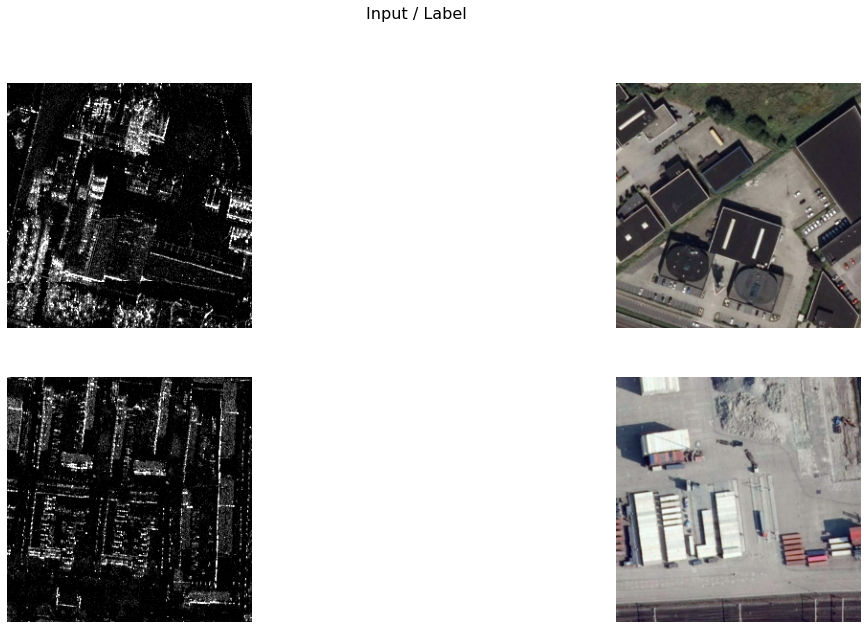

In [8]:
data.show_batch()

### Load model architecture

In [9]:
model = CycleGAN(data)

### Find an optimal learning rate

[Learning rate](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) is one of the most important hyperparameters in model training. ArcGIS API for Python provides a learning rate finder that automatically chooses the optimal learning rate for you.

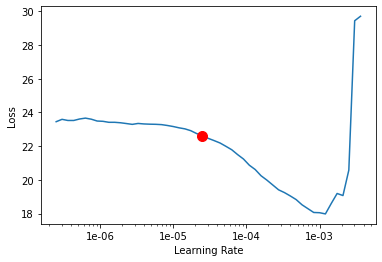

In [10]:
lr = model.lr_find()

### Fit the model 

We will train the model for a few epochs with the learning rate we have found. For the sake of time, we can start with 25 epochs. Unlike some other models, we train CycleGAN from scratch with a learning rate of 2e-04 for some initial epochs and then linearly decay the rate to zero over the next epochs.

In [11]:
model.fit(25, lr)

epoch,train_loss,valid_loss,id_loss,gen_loss,cyc_loss,D_A_loss,D_B_loss,time
0,12.721999,11.730223,3.998488,0.769209,7.954296,0.265965,0.281635,13:34
1,7.841636,7.544123,2.355145,0.842276,4.644219,0.168540,0.219886,13:30
2,6.932475,6.646543,2.033799,0.860827,4.037850,0.167215,0.190510,13:31
3,6.302457,6.236442,1.826933,0.885448,3.590077,0.130738,0.217415,13:30
4,6.080861,6.053925,1.707871,0.943970,3.429021,0.126789,0.220006,13:30
5,5.962185,5.660501,1.664525,0.929826,3.367835,0.144954,0.200088,13:31
6,5.532198,5.643837,1.518743,0.907848,3.105606,0.146165,0.197749,13:30
7,5.537426,5.526513,1.510175,0.866212,3.161039,0.183122,0.187084,13:31
8,5.290096,6.090646,1.422879,0.877437,2.989780,0.161592,0.446271,13:31
9,5.662517,5.221590,1.532634,0.893956,3.235927,0.176112,0.197955,13:31


Here, with 25 epochs, we can see reasonable results — both training and validation losses have gone down considerably, indicating that the model is learning to translate SAR imagery to RGB and vice versa.

### Visualize results in validation set

It is a good practice to see results of the model viz-a-viz ground truth. The code below picks random samples and shows us ground truth and model predictions, side by side. This enables us to preview the results of the model within the notebook.

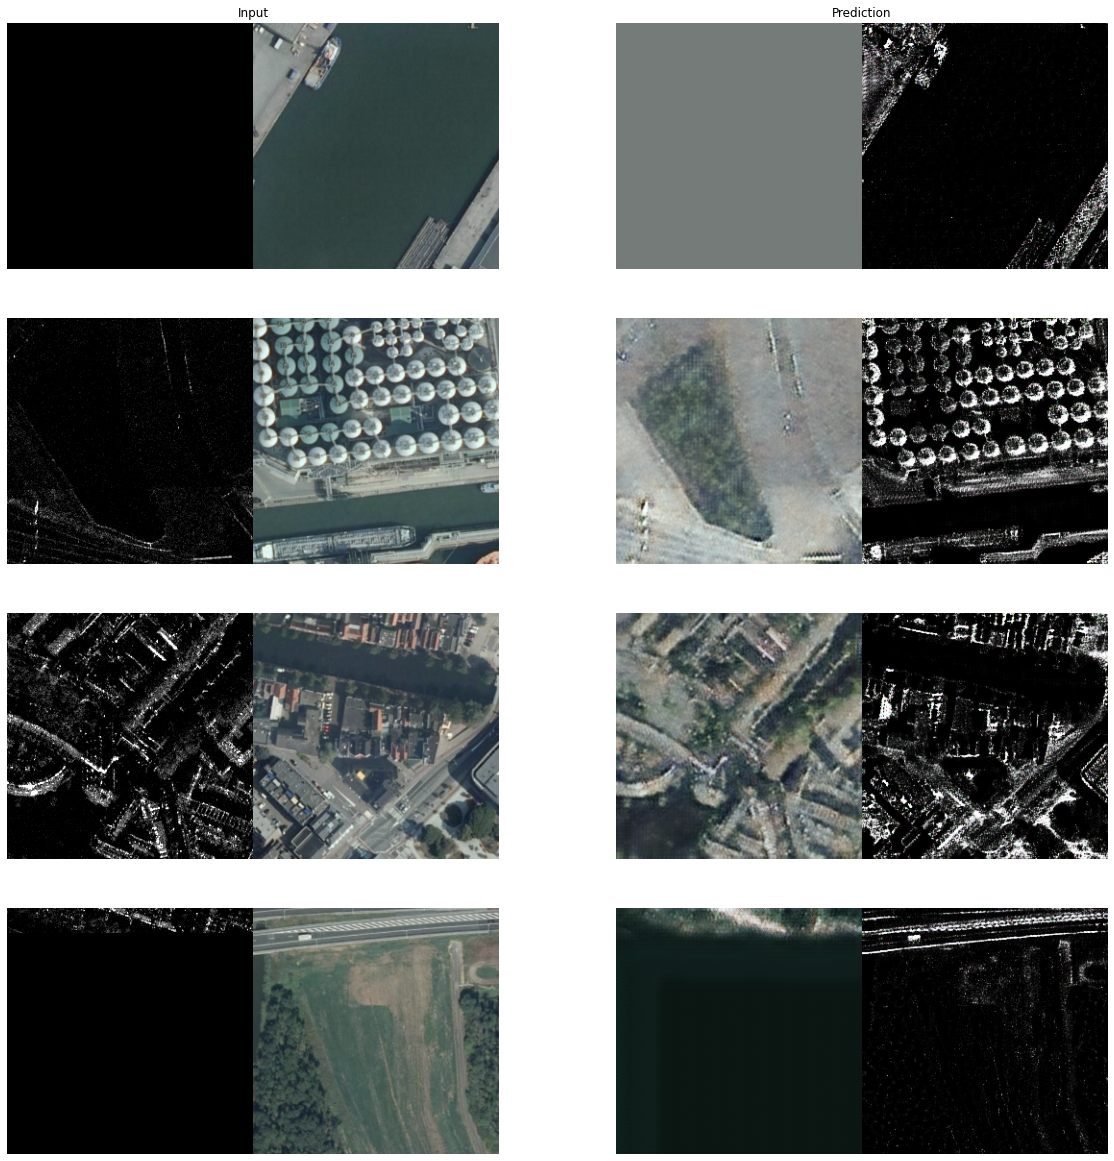

In [13]:
model.show_results(4)

### Save the model

We will save the model which we trained as a 'Deep Learning Package' ('.dlpk' format). Deep Learning package is the standard format used to deploy deep learning models on the ArcGIS platform.

We will use the `save()` method to save the trained model. By default, it will be saved to the 'models' sub-folder within our training data folder.

In [13]:
model.save("SAR_to_RGB_25e", publish=True)    

WindowsPath('D:/CycleGAN/Data/data_for_cyclegan_le_3Bands/models/SAR_to_RGB_25e')

## Model inference

We can translate SAR imagery to RGB and vice versa with the help of `predict()` method.

Using predict function, we can apply the trained model on the image which we want to translate.
- `img_path`: path to the image file.
- `convert_to`: 'a' or 'b' type of fake image we want to generate.

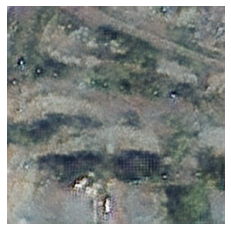

In [23]:
#un-comment the cell to run predict over your desired image.
# model.predict(r"D:\CycleGAN\Data\exported_data_CycleGAN\A\images\000002800.tif", convert_to="b")

In the above step, we are translating an image of `type a` i.e. SAR imagery to an image of `type b` i.e. RGB imagery. We can also perform `type b` to `type a` translation by changing the image file and `convert_to` parameter.

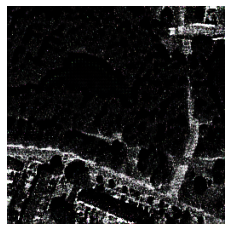

In [22]:
#un-comment the cell to run predict over your desired image.
# model.predict(r"D:\CycleGAN\Data\exported_data_CycleGAN\B\images\000008007.tif", convert_to="a")

Also, we can make use of `Classify Pixels Using Deep Learning` tool available in both ArcGIS Pro and ArcGIS Enterprise.

- `Input Raster`: The raster layer you want to classify.
- `Model Definition`: It will be located inside the saved model in 'models' folder in '.emd' format.
- `Padding`: The 'Input Raster' is tiled and the deep learning model classifies each individual tile separately before producing the final 'Output Classified Raster'. This may lead to unwanted artifacts along the edges of each tile as the model has little context to predict accurately. Padding as the name suggests allows us to supply some extra information along the tile edges, this helps the model to predict better.
- `Cell Size`: Should be close to the size used to train the model. This was specified in the Export training data step.
- `Processor Type`: This allows you to control whether the system's 'GPU' or 'CPU' will be used to classify pixels, by 'default GPU' will be used if available.

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAr0AAAMJCAYAAAAOCI4PAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAFiUAABYlAUlSJPAAAP+lSURBVHhe7P0HXJVJmyaM937vxpnZmdnZndlvJ8/szLe785/ZNOGd9+23W1u7zQqiiIqKIiZMqOQgJsxZEQkGFHNOKCJgRCXnnHM+wEmcANf/vuucAwc8KrYt3f12Vf+ulvNUPZWeqquuup+qej7DEPeZR5qEhISExDAxUm5cZImEhISExEfgDdF74GmDhISEhMQwMWKuTy8hISEh8RF4Q/TaCiQhISEh8RaMkNP29EhISEj86NGj06G3rw99xGsW8G++biv8d4k3RK+tQBISEhI/ZDBZGnt7+8EEyv+OBImOlLOVtoSEhMSPCczJHQoFnj1/jtj793H/wQPEPXyIJ0+eoLWtDTq93uZ9tvAufn+bnxS9EhISP2owSTa3tCA6OhoHDhzAoUOHxL8nTpxAfUMD9AaDzfuGguN5m1B+l99IuaHp2kKPXgf06gfBqLcdVmI40KGP6rDP8OknTxISPwUwH9fU1iJ40yYcDQ3FsWPH4O7ujvXr16O4pAQGo9HmfUOh1mjQ1d1tUyTzNfbjMEP9Pkj0Goz8Ks8KfXoYdLbDSrwPNDhxHRolmUpIfAwsJBoSEtJvOVi3bh18fHxQUVk5LBJlkmSBnJWdDY1WC62VuGW/tvZ2ZGRkoFulekP4jpSzTtMW+noN0LR34VZOK27ktJmQ3Yb8Dq0Uvt8SGo0Kz6g+n9cpoaLn3mMjjISExPBh4et9+/cLyy5z68aNG+Ht7Y2S0tJh8TUbIPILCrB27Vq8ePFi0D0Gij81NRUeHh7IyMwUYa3vHZbo1bP1gGa6L1NqMf98ORZcrMD8CxVwuVyN5HatFL4fCB40NWoFdl0sx660DnRLMpWQ+NZgEq2tqxMk2t7RIV6dMYn6+fmhsqpq2CT6+MkTLHZzw8OHD0Wc3E919G9nZ6ewRqxYscLm67eRctZpDgLlEzoNHryqhd3+bHy2NnUAq1Lx/x2vQIqCBgPJ0x8Efv6q7mb8cs1r/Op6I9rpuetshJOQkBg+vgvRyxzM9+7dtw9r1qzBq1evxH1GQnp6ujB67Ni5E41NTSI963vfK3p1JHa76lrgFJqL3/bPxJ/syMWfmfHHwZn4u+OVyFPpYJSEOmwIMlW1wXlHDubHt6BLkqmExLeGtehtaW0VZBgUFPRBopf7pILEbeSJE3AncRsXFyeEMF8LCwvDylWr8Cgx8Q3ByxgpNzRdE0jw9mhx4U4xfscvA38eVomnDd0obuxGYZMSpdUtWH6iBDcaNJKjvw20GlRRXVYpNNDY8peQkPggfBeil8Fc3GIWvmzxffnyJdLS0kyCd8cOIXht8fU7RS+vD9M0tOGb7en4swPF2JnWAR3vVjaa1jlp2jsQ+bQZlWod9FaE2kN/66xgHefbwgy1dFr8h4blv98WzhLG2t9yzZafNd4Vbmherf0ssPYfWpZBfgTLda7DXqpjy2/rslin+TYrsMXfcs+7wkpI/FDBgvNdsHWPNb4L0cvgtHgdWHhEBFatXIm7d+8iKioKK+nvxKQkkY6t/IyUG5ouQ9/bg7yXFfht7wy4JrVDbTStPzUSrwjw34Shk2o9XRtY96uzaQXW8Ru+/jAm3rdwjQmmcaCX46d6eWt8Zj/Oj8FA/jSGWAQ485xhUF5MnPgGj9kIZ71kg+Pp5eV37GceowbndWiZB98/qKx0f2+/H12HYdAyNCOnw/Gby2+5b+CeAYi3pOY4+R491YVcIyzxYwWLSN4kbAtsJLAlMofCmq9Z8PLbOYvoLS0rGzZfMzgu5vyDhw6J5QyMPXv32rTwWvAO0cuk2Y3dUTn4rR3FuNfA5D6YjHgAYIKzJtRe6tgalQaNCrVAm5pIYkgHZ3LSa8xhOhk0iyZysCYNJcXRxLNrvlfNf5vi69ISaVBYS7jObg2au7UiD60UVwv9raa/BYlRfG1dpvsY7ZSXPsqfdRlEOEMPWjgf5vy0q7WCRNmfiVZPs31LHBw/E5klDq4Dzne7VToKSqffj+LusOGn7dGijdNSac2/e6CgcBy/wdiDLvM9TV0aaCk960kF59lA91vy3KqiOiZ/Lv9A/BISP3x0K5WC+HhJwlDw9c6uLpv3WYPJram5GfsPHBCWWb6HSTQgIAB19fVvrOl6F5i0O83Cd9myZVi1ejUeJSS8k4hHyg1Nl40Sug4FFhzMxB+frEFbz/v3WAiRSUh7XY1fHC7EPx0qwFenKvCwkcpBXGUJx7xXW9qEWZEURoQrxLx7TWhiP7qfuU2j7oD38RLsyOhAdUszFhwuEOHGxVQhqZniI17kPCqbWjAnshRRRZ248agU/7S3BFFl3fRcKP9aLRKeVOCf6b6fHynAz0NLEZrXiR4hEE150VE8zHcpKZxnCsOgcKeKu0z8TPnWdasQebsEP6d4/ulgAebcaUSlisSleUxhwVuYW48pYfmiPD8/WozIUrUQvnpKq7q0GfMiTX6MHdmUP8q7WtWB9WElCKEyqilcr1GJE9fL4HarCY26TgSfLBJl/iXVw5kytaluzHXYRzxeUtKI+WFUL5SnsRdrkdKowPYzRQh43QElxf+GuJeQ+IGCufH169dCrPJG4YMHD/aDuZf/zczKeqvYtIDj4Q1rO3ftEhZf3kvBXL1hwwbk5OS89/6hYMGdlJQklp8tWbpUvKXja7bCMt4qevU0I28ursd/3ZSBxS87hbi1vtEWjL0aFBW2wJlI+LN16eJrRX96tBx3ajX9hGrUaVFS2QafE7kUJg2frSd4Z8PlfgNKukhoE2n09Wnx8HEp/ty/CHebWrHyCK9To3AU55cX65DSohFCGj1K7I7Jw18dq8L15xX4vXUp+JuIGtRBD01nNy7EVeAPA0z3Mf4itBz3a1TC8sBkw2SqUHThdnw5ftvPFOYzj3SMvdYIBcVvJNKqr1cg+FSeKa8eqfitkAIczlcKshTCWKfGDUrnT/xTzfenYeFThZjJ6/RqxCZW4a8DB/xmPmqnvOuh6m7BeN8sLHrcCi1bAXq74Hs4B1+crsHTqnr8kx/nOw3/IiAb65NJBJCY5UGALSoaZRcOXSnCb3ua8vR7h8twKrUOYzdmwC+rS1hehj4bCYkfGpj8+HXW5s2bhTWVX1FZsJrEppeXF14Syb6PBHnj2cP4eGwMDhbkx0ffeHp6itdcD4gAbVln3wbOUxeJ5sjISCF6V69Z84MVvczRjRXN+EVwKlamKgdZI3vZumi16ZjFH/OVXqdE6KV8/FuvLPwivBjfRBTjH3dl4rd3FuN2DfEqCbFeoxo37xfj368lzjxYiK8jS/A1hf0z4ri/DK3E6zaTKNaoWvGNVwbGnC7ChAgSu8eLRbi/2khct70I92vVJPyoPmvq8acBmRhP4m/08UKMDS1DTJUSyq4OuDO3e2bhHykf30SU4ItDefhNnzTMetAKBT03nuCrVQpsjMzBzzZk4n8do3CUn1/uzseih03opnJ2tbdiHpXh32/OxRjy+ya8CH8RnIG/Iy6tVLLhQYe09Ar8qW8m/jG0SKQz6nAelj7uEBbYipIa/I1/Jv6OxC7HPeZILqbfa4GB2gKv6f3CIwOzE1qhNvN0wOFs/NWuAtidLcCvjhRR/RThLwPS8S82FSCypFsYfoy9WmSlVOJPvNLxx3sK8HVUCcYdzcd/pknGP1D5ptxvRjc9P7msTeLHAuZRNiicP38eS0lcMpgj+d/ly5fjytWrUKnVNu+1gPmVDRNbtmwRfB1MYK5m0cuGik2bNgnLL4ezdf9QWDat8ckPu3fvFlZe5v3k5OS3cvZbRS/PwtNeVeIvN2bjbC0JURZ4Zj8mT8trdcsrJJ5Jl5fW4X+TWPvLsHKEpTTjRHI9ZhzIxH/cV4LnrUwEPaipbMCvSIj+y+BCbHvVhBOvm7HvbgX+wCsF/3SuDpUaErPQIi6pBP9lfTYRagGW36nHidRmHL5Tjv/gnYr/caZWzOJBBL6LRO9vbs7BjKhS7HjajOsFnVAburHrJInqlZlwuluHyNdNiExuhN2uNPzbTYW4XEMzfMqvXqvEjugcfLYqncJRGhTuaEId1l6rQoFGj862NszZlYF/va0I+zmvrxrhcToP/zooF6dpVs+vrbJSy/E7/llYRqKdyxL2qBLrElvFK7CS7Er8R78sLKA8sF94YiVWx7cI0c2id6xXJuYnDYhePxK9f74tF38bXoiQpEa6px6OezPwmVcOjhabyLSXynaA8vDZ+iwsvk/xUj0fvVOK392Wjf/snYkAKXolfkRgYuJduIGBgSbL6qpVYsbOJPbk6dN3ik2GhYgPHzmC0NBQE+nRvWyJ4M1nR48eFUsWhiN8mWiVSqUQvCzCb9+9iwjz3yymOS+24hkpNzRd5tO8vCr85bpshNFkngUrc4tRq8K1J9VYcM606XjxlSpcLFeRENYhP70Sv0+c5P68jWI0Chhb22C/OwP/9VIj9MRbzeV1+HPfdHweXYMimmxbhHN6ajX+BwnfX9xtFhN3Fr12gen47d2FOF1KotscriSnDv83OB3/91azSfTWNoj7/vJIOV6RYBbhDFpcvVeAf+2ZA78XbdCIew3o06iFKP8sMAf7SyjOvh48TCrFb3pkYcWzFrRTuhyup1OF7PpuEo1qhF3Jx8+2FOJStYr8uEx6VGZX4/c3ZmJVahdd6sH+qAz8p7Aq1OsM4n5olMispzohTr10OQe/ta8U6V0cN92vUyGzTvkGT1tE77bjJMB9suCU0AwtlY/fgBbmV+OvaJIw82ELVH00SWtpxfiQDPzZUd5EqDGlSc/l9K0ifEbhZsW1SNEr8aOD4EiVCpevXBE8zUeNMWffuHlTGB+GI1b5GDE+VaequhpZWVlCrKampYnf5RUVNo8ZswVOy3rTWkNjo1jqYFnjy5vbRH6GcPZbRW9vnwaxj4rxRwGFSFLy6yW6Tjf3KtrhtC8L/z4gC78TnI0/O1yK23XUqalDB57Ixu+FVqGOEjKRTy/Q3Iy/2ZIF1xc0q6bZb+i5bPzrLcV4QIRjIUm2Ij9OLMHPArOxI49ICkx0JfjddRlY87qDyN0cjsgrMb4Y/09wPs5W0v0GFXafzcW/CshFdKXWHJ8B1UR4v+uXiaWJbehhojJfb6ttxbgQIt8L/MpTj6qsKvyGVxbWPGszEZo5L91KtbCq3rxbiN/cVozEVo7bVJ4+bScWHM7C315ppF96evi5+M1dJXjdyWRKYWggUii1QvTG3s7Hv9tehIQ2jnvAz0KmX5NIXWAleoOOUN0E5yG0qJvCc3x6NNbU4395pGHu4zb6ZUB9Xg1+3z8DCxLotyXPRi3uPCzBv1mXiaBsKXolflxgMVlYWIiNQUFC+LLgfW4+hma4VlomYiZLfl3Gr9mYVJmE+bqt8EPB5KhQKMQa3hUkctlCzOnztbDjx4XwTUhIEG9aht47Um5ougYSbMWFNfgfXhkIKVSalpFR/vo03dh/qRB/siUHf7wpC595ZmDlK+JV4p9Dp7LwB4fK8aBKiby6LmTUdqGwuZPC5+P3d5ehiuJ8Rhz7H0PycaNRJzhXpEfxQq/Cvpgc/O7eclTzq3l1Kyb5ZMDuAYk/4iEh4Mzhdp3Jxe8frEA9xack0ftXlAcX4jBdn04YSvRqNbwOpeFvY+rRpjeIN3ycTg8JQUNbM/4xOBOzH7VAr1djA4X7XzENaDNYhaP0eW1sd3MH7Hek4pdXm5DX2I3MGi5TN4rqW+CwMwvf3GwSaV6/XYjf8srBlsx2FLepYeglfqW8scX6GYnq3/EkgfysFfmt1F6M5EfjALc9W6J3U2g2/mR/GbJUvNTONPHSazqxaHsq/oEmDh3UbsqyavCXwRnYUUhjI6VjyrMeekUbptCEYPoDKXolfpxgrmSuvXDhguDrGzduiD4wXK5m8Ns7XoLAIvXw4cOCt/n3cJc2MDeXl5djNQnu7VanNDAswpcFOY8rhuEeWcZWhBfPy/EngVk4VaM1WXq5cyu7ceJRNTzv1GDRcRKc2wpwpYaUeWsbJm1Jxd9EVGJLfB02Pqgl1NHflfj7wExMJPJREhmu3JOGUTeaxIkFenNagjQ6W/C5f6Z43d9nFr3/xbsAj9W8JMIUjtfSdtTX4//zzCJxx0suVNhJ5Pr/7ilHOZEzx2cgsoonAfjHOwoQz2KTSMlUJiLjXjWOEbn/4a5yVPX14MLlPPzZoVJkdluHM+VHp1ES2abjP+8vgV9cPTbFmcqzNaEaU/dk4a+OVKKeSLAyrx5/55+On5+qwO7kFlSpWYRSeSivtSWN+PugdPzviHKEPG9GmdLkx/HbEr0+B7Pwd+FVqGHipzKLcIpOzNmegq9utxJ5G/AkoRR/si0P91p4cDHXCxF3U00TfkH58MmUolfixwded5udkyPO1uXlBO9ak2ULgkOI8Jj8WPQyiX6IaOb0nz59Cjc3N/F1ICZ2wQNmMcxWZHcSvrxJTlgPrO4dKWedJoPXojZXNuHzTWlweqLoF1fCj/iHJ86qiib83TYSdK/Z4kkcczgTn21INx1ntmYwfhZUjFSjBlevFeDPdhfjVbeOtJ8lPY5Pjct3CvGHgUV4zfVNoneiTybmkjhVs5i1CnfuegH+OLgYGcRFqtp6/KV/FrxT2YDBopeXaCngvDUdk+81DRF/LEQ74LzRNGa09SgwezOJxLhWqIyDRSLzXkNNI0YHpZmWyVmXh5fDrUzDP52pAw2H0HWpcDqhBP/dOxX/T3AeVt5vQkGX6bhNnVqDG0/L8U8kRj/zzYbLrQaktpqW0NkSvRuP5uB/Hq9GLZWZjUFi2QiJeJ+jafjfFxqhoHy+flGOPw/MwcUmbX8dcntSd3VgzpZ02EvRK/EjhkVcPn78WBgWhnLicMBxsHV2HwnUyspK8dtWOFvgsLwZ7tKlS298gIj/bmppwaXLl8VG5qHxvlX08lFlDYV1+OtNmfBM66bObiFUIjVhYSSl/bIcv7W9AFdJ9CqbmvF1cBr+lV8m/g2JV2v8tl82Zt5uQisRmDN1+Kn3WkgAD3T4HopTp2nFZN9MzHrYQjH3IN4sehNVA+cA8/ouRWsj/q9HJtalE8mbRe8fHa1EAwlAjo/XUl29VYg/3VGEF536N0j7LJHxH20uRX6fCmHROfjro+UoUJvWEpvCmcJq1Z1w35eBnxGpDy3PbwZk4f+EVaOUBpleIrLqxhasDcvFb/hl4b/tLUJ4SbdpgwXlt66pFT5RefhNKttf7ynEofwuGoxNa3qHil7vg9n4hxM1aCQyZQHPJKnpVMJtf6pZ9OpwN7YIf0oTjSRFT3/ZmPzrqhvxcz8peiV+3GCxyuvChitWrcHEy6I3PDxcEOKHkCin10okzhss2EJsnT7HyxvrCouKbFqOR8oNTVdYdVXd8I3Ixh8drEAJC10r4asjUdVV3oT/GWIWvcSNuyMz8QeHy3C5sBNJxR2IK2ondOBRSQeelHWhs1eDazcK8HvEMfeaKT7L5jZKC0YVjlzIxX/aU44KSostvSx6nR61EmObRS/nQaOE74ls/IcDlaih/CjNotcrZbDoXRiSir+/2IAOvaGf49ka2qtowa/Y0htPQlPL4jgVP7/aSCLRKhzFwRuiFY3tmLwtBb+40oinZQo8FOUxlSmhWIG0OiWNNcSVFJbfIJbXKHD5cTX+3J84lUR1J+XX5KdDfX0nbr2qwz9sTMV/j65FM/lplLZF798R/1dTWaxFr/eRNPwfs+hNSS7HH9JYcbBM21+HQhh0NuNLrzQ4yOUNEj9ycB9kY8G34WoG38d8yksahrsEzRrcn/q453K/+gC/t4peQXLqbngcycKfHi5HhorIvV/4Uic3GlBIs9l/T6KXLb29ik7M3k3kROKMT0hQa3v6waKMiU6n6sLa/en488ga1JGw7BdtRBKtpbX4041ZCEgjMWu29P5nr1zcbKd0zRbN3j4DCl6U4l8E5SGC13sRCQvRy1ZXs+jlkw8ex5fg3wfnILxM059nQaZUng3hmfivUbXo7tPiytV8/FZIIe40EDGZBwsmMJ7h9/VosSMyA38URSJUY7JKW8ojdk1TOD630XJ8Dd/T0arA8qMZ+IOD5SjmtXDsR+nzWruujm6sO56J391TihwVpUVkakv0/j2J3oYhonfxPovo1SPhYQl+eyOVrWIgzzwJKcqtxO+vyUCAXN4g8SMGC9VvS6IWiC+q2bj+PjBBvs06bPEbep0xUs5W2ryZrbygBn9CQupX52uQ2KCmkCziTODX7H+60by8gXjl0aMi/MbGPBzM6SR/XrLFoMmBohuVHRoRX31RDf6LTwYmXK5HjTAWmOIqzKnD/wlMgz3vWaBwYk1vQCr++EgZklggi3AG5GXW4m8D0jDrSbsQlF1DRC9vIu7VaRBzIx//0jcPezI66E7TvfyRjZgbhfiN4DxEV1NZDBqcvJqHn/lRnrMVFMIUzqBUo7RFRWOKEn6RWfh3xLlp/cvQGHo0N3ShkXi4R6NGQVUnOqltmfw0OHY2F3+4uxSZai0qqxRo1XG87NeDW3eL8B+DCpDQTTys+nDR2643ormsAX+7MQ1/f6kODWKfCqWtUeFqbAl+5pkORyl6JSQE1+o/4I3cd4G3i16CINSSavw1ddL/fqgYRwtMx7iwJbSXZvO7Tufis035uFTFpzOoEUEi8jP/XGxL6xBHjfE5hrzR4N7TeqR2sEjrwaMnJfittRmwu96AOgpjoPjaGzvgciAD/2lfKV53s4jTIv5xCf7D2lT88/k65CpYXOrQUNWKCdvT8VcRVSjWEpHolG+IXq48ZWszvtiYjj/eVYoHTWphcWULwcW7xfgPnpkI5nXDvXo0VtXjb7zT8N9I1Kd0aURelJ1qxGU0C1H+IrkUv0OEN+d+MzototqgRXJKAx7W8mY4Cvu8Hq/FV+koP1wHl/PxnzYXI1WrwZPkBjxv0YLPZoRRg3O3CvG7AQV4oqR6+UDRO/pWK9WpAe2VDfj/BaXjL6KqkE+DlKiX0ibMOJKD3/DNQKC09EpIjChGytlKm9Hbq8bDJ5X4a68U/OttBZh7oQLz+IuZF8rwDzsy8ZlPNo6W8UkKptfraw9niRNz7M+XYx5/YfNSOcbuyYVfikK84es1qMQbsZ+tSsf/jiwVm+EWULi/C0rDXx2tRAYvCyCuZNE7LTATf7MjB/8nvATzz1eIL3b+TVAq/ssBDscWVprw19ThT3wysV7szzCJXk5H0dKKeXsof17ZmHyxHC6UjmNUIX7bKx3O8a3opHvZYNLe1IJZOzNEnqdSGA43PbQQy+KboSTurCurxz8EpON3thfA+RKVnfIx73wpfrmnANeaKA+aTngSP34dTeXgeokpwX+licC463Q//bcnMhdfnCwz+dF9/3NrBv7X6Tq0kWBXd7fgy/UZmENC3yJ6Aw5l47+HVqFqiOjdcDAVf3uuEc1aCqcnvr9WiM82ZFDdlMLlUiWcjudTOqX4YkuGXNMrIfE94Z2il8Fre3Nohj95fzZ+wzsDvxmYRcjEb/pn4v8NycWUizXIJ6HKr/N1ig6si8rFv/NMw2+Yw/1GUDb+4VgZnndQXCw+1d04cq0Yv09i81+R/29RuH8bkIk/2lmIc5WmUxXEkWVJJfhjrzy4XSkUmzE43X9F4vsP9hbifKVGkCkfWbblRDZ+Z38F6syiVOSZxHVeTi3+YVMm/qWfOc+Uxm8GZmPZw2a0UT7YUttn0OBxciX+e2AGfsbLFji/fpkYT7Pz6h49jFoljt8oxu9Quv9G3E+g8vzXXZQHtkL0ahB1IQ//1secBsXxu5tysOxxO4zQ4AINHOwn6oL8eOPffCJzfu3IR+F8zrt4E1qE6O0jMl1LA8D/OF6NemvRq1DCecdr/PxaC9RsjTDQxCGhDH9AJP8zX8pPQBb+ZHcePONq8HlQhlzeICExwhgpZyttE/hNUw9aOzqwLbpQnADz5/zVzC15mHevEQUKNbr5DRWFZd5TEwcfu1KEvyD+FuG252NVUgtazGGYdww6LV6m1uCXe7NNX+DcnotpsU1oVXMcpn0JLHp5ecN8Ep9P06rw5xSG0x57tgY5YlkahSOu7W5swviDhdib0wnefMdpcL71xNnd3WqEXy805YXvP1CEwxTOZDQZCNfVpcLRq6Zwf7YtB38fWYFEErQsvrnsDQ1tWHbUHAfnd18xThd3QkV5MOq1eJVSif9J94mybM2De1IrmjQkiOnekoJa/Hy7xS8Xc+42okKcfa6DStmGxXsL4Pu6Hepe4mkjjV/nimF/sV5s0jPxNNUJid595/Iw814L2kj0sqGlV6PGrcc0WQihuLfmYOq1ehS0d2DOpnTY3ZeiV0Li+8B7RS+DLb4wKHExvha+92rgF1sD3zv1SGoi4UeCzdJxmeAMWhUuJ5E/hyP4xjeipFtrthBTOCIIfuWfllUHv7vmMAmNyBGWYFMYFr3iyDKfQrzsUop1Vr53KOzderxq1wiLBYcz9KiRlF6PnS9a0UHxWsiUwaczKBo7sCeuWuSFEVnMFt4B0mXweZZN1a3YHGsK5x9Xj9Q2JjyTP6+De/Ka0rfk9T6Vu0El8sDk39najt336F5RJzU4U9AFnZHqhAmzQ4F9981+t2twIlcBDfkxUWrUXTh5vxaXS7sEwRv0Ktx/XofQlHZ0EBH351GlxrWn1YjM64KaBjfT2roeZOY3IuAOxU3xXq1Qor62Hv9rQzq85ZFlEhIjipFyttK2hhBabDQgbrKAf7MwtOY85iZhXBgSznL8JIOFHBsyhoaxfDDCWvTyKQuUuuBvEZbTtIqLOYuNFIOumWErL/x7qBh8I5xVXhii7FZxiHisys3+1n7WZeG9Im/zY/DbNAMJb8tvtj5zGOs6ZXB9WX9giePlcJZ4eazsqq3Dn3lkYF7imxvzJCQkPj2GJXpNMHVay/ouhq3PLr4Rjv62JhALxFpYqzDWhNgver0LEK8kMWwV3+ANZybROlTIWsCk058GgwhoaBgRjq73h6G0bKZhFY91uVnoW/tZhLvwI6Ie6jeQT7OfVZ5Mn7R8syyi/FbxMgnz+ZemeHmdmh5Pk4rxs7XZOFbRLQYH6/slJCQ+HUbK2Ur7+8Ig0RvPZ9O+KVR/2tCKr4XyWz1eSscc3qdXIfp8nlgCeKSoWwhh2/dKSEh8KnyA6B05WIveRyR6bVkIfrLQqvA6vwMtYuMFQ4eykkaMD07D7x2pQEEniWKbkxEJCYlPgZFyttL+viBF77ugg9HYiY1hBfBIbMaVzFZcy22Gf0w+PnNPxZirjajR2rZ8S0hIfFr8YEXv/YRi/N76fDyUotcK/AqyHW47svFPx0thf4oQXYz/FpSOfxmYi8N5SmHdtmX1lpCQ+DQYKWcr7e8LFtE7wTsTTlL0vgGDQYOnT8vwO2tTxOfnxbnIPjlY8rABxebP7du6T0JC4tPiByl6+azdl2nVmHykAq9VfPqB7XA/RfDasvy8Ony5Nw9/u78Af7cvH/83qhLJfHwPCV458EhIjCxGytlK+/uFFnXEOw1dGrFXw3aYny54M2BNixJlhHL+t1UNDa/zlW/iJCS+N/wgRS9DrMftlSLOFkx1Y14rxjCaNlpIC6+ExMhjpJyttL9v8AYx6w1wEoPB9cMbCS2QHC0h8f3iByt6JSQkJH4MGClnK20JCQkJieFDil4JCQmJj8BIOVtpS0hISEgMH1L0SkhISHwERsrZSltCQkJCYviQoldCQkLiIzBSzlbaEhISEhLDhxS9EhISEh+BkXK20paQkJCQGD6k6JWQkJD4CIyUs5W2hISEhMTwIUWvhISExEdgpJyttCUkJCQkhg8peiUkJCQ+AiPlbKUtISEhITF8SNErISEh8REYKWcrbQkJCQmJ4UOKXgkJCYmPwEg5W2lLSEhISAwfUvRKSEhIfARGytlKW0JCQkJi+JCiV0JCQuIjMFLOVtoSEhISEsOHFL0SEhISH4GRcrbSlpCQkJAYPqTolZCQkPgIjJSzlfZwodProTcYBPhvrU5nM5yEhITErzM+SvRaE+lQ9EhSlZCQ+IGDecoatsK8DyPlbKX9LnB5mIuZp5uam1FZVYWKyko0NDZCrdHAYDSaBLCNeyUkJCR+SGCuGqo5+feH8va3Er2cCBNmZ1cXiktK8PjJE8TGxiIuLg7JL1+iuqYGKrUaxt5em/dLSEhIfJ9gsuzt6xNcxlylVKmg0WoFrzE+hEhHytlK2xYs/NyhUODx48c4fPgwtm3bNgi7d+/G7du3UVdf/8HllZCQkBgpWPipvaMDuXl5ePbsGRKTkvDy1SuUlpUJHWoRwLbuH4oPFr0ceVd3t0h079692LJliyDVqBMnEBERgQMHDmDTpk04FhaGrKwscY8kVAkJiR8CLIKwsakJT54+xZkzZxB2/DhCQ0MFh926dQuFhYVCADPX2YpjKEbK2Up7KLh8jPT0dIRs3449xNFskCgsKhIWXrb4lldUiLKHEUdv3LhR+LPoH+6gISEhIfGpwTzGnMRG1EuXLgmtuZ047RDpTeZr1pp8befOnXgQF4fWtrZhcfYHiV6OsK6uDocOHUJISAieEnEykXYrlf2EyaqbX6Pdun0bgYGBuHDxIrqs/CUkJCS+DzB/MT/dvXcPW7duFdbOy1euIDExUXDZnbt3ER4ejs2bN+PYsWMoKS0V97xv0j5Szlba1uB8cn4fPHgAf39/PIyPF+VlizZfZ7HP/zIXW97CZWZmioHj1KlTwpgx0jytMxhhNA5vcvGx6NEbqNxG6HSDr+uMvaKOjIZPVXZ6LpSG4TuMv0dnuywjD5pEUlv6LssmMTIw9T0jemz4fd+wCF5+U8UT8/CICGRlZ6O5paXfIMG6k99UscV3z5492E6atKCwUPCcrTgtGLbo5USqSMxuo4hPR0cLMrWQqIVQOZOcWf6bUVVdLTJznAYSJtT3DR7fJXr0RlEe/Qik2UONh51BP/i6oU9cBvo+VcPSo5ei7/0OBw09R4jvvyPoRd31QmfDT+KHibf1gx8CmKNqacJ+8OBB7Nq1C5lZWYOsuRYeY45iK/BFmqwHBAQI0uVr7+KukXK20rYG5//ps2fC2MCvAVnIWTiZy9rS2oq29vb+8HydwzRRefmtHVu9OZx1nN8FTJwy4Pp6TXXeo9egqaoUBaV1UL2jfr8L9FCbbG+sRF5eMVpV9Ftcp7Gqz4CWqiIh/guqmqCha7bufytIfFpo3toZ9NbxqFBdnIeiqkaoiLM/llv5uXV31CM/twStSg39th3u7eBycy6pfdjw1xlMD0z/3nipXWk6UZaXg7KGdmg+8TNk8Lhuq777aALwQxNveqMpp++vx5FHj06L5uoS5BdVQKEhfrMR5vsEt3FefhUUFITXKSniN0/Umc9Y/HJ/5WvMeXyd31TdvnNHhE9JTX2n8B2W6OXIWbTu27cPZ2NixG+LRYATZXHLCdU3NPRfZ3DCbHLmQebKlSv9cVn8PwY8a+f49ZQep2kCDVxENjqadbbVvMaJI+eQ29hJ1z9dZ9QZ9agveILwA2FIrVfRzJvTYlLRIDP2DHZt34bjN55DoebBx3YctmGq48HgMhtMs3udHuruWlw/th9XnxdBTWTwcQ2XrRHdyHhwCScvP4OC0vvw+Ex5fls5e7gM733+/PyUSL0djfCz91GvGQlrhq26Ni2Y5zb24YPKp8Pw6nDkoTPq0FD0HBH7j+F1Lb/Z+eHkkZ8lCz4WdryEgde68nPl6+30dzSJvZs3b4rfHJ45iv1TiGzZysB7Ft61P2GknK20LbDwcBDl99Xr14Pyy37xjx5h67Ztgqf5t/W9XNaa2lpx74vk5HeW9UNgEih6FD+/jajw44iIjMTxsJOITS6BitLoRQdu7lyLeWuj0Ey89ukGXnqe0OHV+S2wn+yKxAb6Te1Tb9SgNOUOvJwm4Bf//I+Yu/UKurTD7+/cF7vbKxF7LpLKFoVIKl9ERDgizlxGboOW5uxcz9xf63Fg0WQs3noejbqPF0Es1CtSTsFp0mokVrZ9oJWVy61E3pO7uHDhMZqYT6z8eTyrK3iOC2euoLBN+07u5TFY2Z4Nn6lj4HPqKZQk8j6leOJxvb02DzfORPTXNyP8eBhuPi+AhrT6p7PWfxh0xh5UpD/C+fO3UdE1uI6/f3B/UOHe7uVwmB+I7I4+GH5AYxzz0/MXL4TRgfeMmcZg0xjN63r9/P3h4eEBRWenuM73CM4mTklITEQw8Rgv4RrKcxYMS/Ryovfu3RNWW+ulDBwpkyWv4eXNEWx6tvhZ38sZCAgMREFBgfht7f9toCOCVCmakPHkMjYsmA6HmbPg6DgDsxcE42ltG4x9vajJOo8545fhQWkzpfnpOoKeiK385WWsd1uLh+XdQoQbe1V4df0AZk+xh/PcOVh36CbaVGaxaiOOodBRHbWWP8fmZXMwy8kJs2ZR+WbOwJzlPtS5K6ExcAPgOijGgdWLsf9mGlQ0O/84wqF8ox3Xd6zBPI8TaKFyfUh8PMB1tiRj4+zViH5WjB4r63aPEOgVOLLODbsvv4TqneRoEt9xxwKxfksUKtQ0bH7CDinquvIlti6fTXVNoLpmzHRwwPrdZ5BT0QiljvLwvVsv+Zk341zwKgQdu4MW/Q/LgqCnPlaRch2ei1cjtrTzB/O6k8mQTyrg1/dHjh4Vlkxr/uLTDFasWAEfH583uMvY1ydEoiBf81IHa38LRsrZSpshBgQCLyXjfRXW5WC+zc3Nhbu7u1gDZz1QWIOF7qOEBMHxPCkYWhcfCn1vH9qrUrB3w0LRlxwYM2bAwW4a7Bb44VFxC5WoC3f2esLV8xRaPqno5TrqgaK5FsXF5WhXm/iqr7sGx/3mw9H/JAqLi1Fa2/JBll5+PdxW/Rzr7b7A2El2mEHlmzHDAdOmTcR0Jx/cyK42j3dq1JUXo7y2GSqK/2PLyaK3Mu0M5tuvx+OqDxW9Jp6/tXM1Zs7cjkJq0/p+PxZDBmTdPQjHic64V6EeYrEeCrb0dqGquBBVTR2f3NKr7zWiNvMG3CZ8jnFTpov65jY1Y/pUTLWfiSUeQUgs6hL18Snb0vthmmS9OBOMGQ4r8KxJ/4MSlQy29LbWVaCkrAadPyBLL3Msv3natHmzEL7WE3DmJDaibtiwQfBZBwlgay4TPEj3x8TECK63XB+K94peTojFLK/hzcjM7BetnADvej5Kka9cuRLZ2dlvHRT4Olt6o6KibPp/CFikdDbl4rDHLIz6Zip8Qo4iIvw4wo6HY982b/gfjKU5DFCXcxkL7dYgvqxlkOhlAcZlYtgif1FxZv+hFrW3+fGMt5eEthC19HefshEnAufAZV8cEQxN+MXaKxuEwPHZuM5lbCqKxyq7cVgeZFoeEh4ehq1ei/DV5zNwKKnQvA5OJwZmC+mZ8jckPnFtMAlYl2OgDsxkuHcDFntHo9VK9A4qN8Vvq4PwIKJoSsTKUU44Ep9HXX5AhAvR21WMrc5T4XciCUqakVv7vZkXajPGXmrw1sJ5oK7677EKb41BcYrfb389zXXdXJaINVTXSwNNdc1tKSJsP1bPm4rR30zB7isp6FBzelb3cn7Mabw/H2/WWQ9fE/HRv++JxwQufyPCVs/Cih2XQDz6VtFr/bxsldu6ft5Mc0g99/89UIeW+4fGbeoHfXTPm3EN1NebdTHY3xIv18tbwn4AOD5+HRYcHCzeRFlPui2id9WqVfDz8xNhre9lcHjeRMEbc1kw26rPkXJD07WA880DxeZNm8SGNUsZuXz1jY3CWs3Cvba2dlD5rcFx8JI1Nl6kpad/lLW3hybgXQ3p2LaMhMmCVQiPzYBax0tHiGP0nUh7koj00lb0odOm6LW8Xrc4I03yB6VB8ViH6Bu0fIw40XydXZ+ZlzVaepbma2x1o3ksoCjHrlVTseNejclDOOv2awKv+eWlVkMtwCx622uS4Tl9GvbeK4COhL6e6re1OB7e86Zh2qowNJCg0BG3mpz5udh47c19h69aWyo5/oFX+QP5epvotcRhcb02jT3M8x24u98T8+btRTG1kaGiN+d+KOY7LMaDygHRa6qDAdf/THSm2jYtWeGlMaZnI8pBY4LF9Qp/SzomcHuwjpXf0vKyC1thGSx667JvYdnUGTiZ0mAaH3htc08bnt04ibVzJ2H8XE8kFlKdiPHRdN/gvL/5HIe2GeOgejP5mZYQDs7v25dxcT324NX5bXCe64Hk5reL3sHLNXg50uC2zkvG3v5MefznuifONC8tE/7mJTf87LgvWtygcml5hDY57jsagmiX1JeYi81NlNyb/YHTtV6yxGlyn+3jsIPCfTiYs+7cuYOjoaFCX1rzLXMUi15PT0+hOYeKXsv9vFmX9ynwQQr829qf8V7Ry+T3+vVr7NixQ1h5LYkwefLGj+XLl+P+/fviXg7L163B4fl6Ec2kN1NGWEDbGjiGAzHYqttwOmg2Jjl7Iza9EJ1akbRwvT0dqKxuRg+lVztU9NK9euqIXYo2tLa3o40qr1NF5esnGX6QRmiUncKvrb0N7YpOqKlxsL+eBwFV14BfhwIqs59K2UW/KSzHo9Wgs64YBzzs4HPiBdo6VeTHcSnI37rBUkNTKykvdH3IOjoheok4V9tNR9SrRnPpiBTacine+XBcehQ11Mh1WhU62jvQrabBuEdDf1PZOpRENub6pTL3aJRoa22BQqnpj7tH0y3KwQ2og+rARDK2RS8ThiU8rwdso4ZmKbc1TKI3CavHzEXoo3wborcEIQvsEXDqsUn00jUDpdGtaO9/HopupdnSokVXpwIdXSpz/Fp0dynQTr8N1Ij5b5H3biLlQY2ayIaeobqrQ/i3Ud3wYMvPtF3RLTr2QFgT+kWvvT3CX9Sba5odDV41Jbi0ZyW++toRp55WiPYs7qG61/eo0U71LeqlW2Mi4P54TWVTdlLZyL+V2govPxmwmqihoLx10YBoNPZAwWEI7V1KIfZtv15lAdmIiLVzsGrX5beKXnG/2tROW9vaoVDT87UaANhfo+T6M9V5eyelSeWx5F2tomdNbZkHLFUX5b+jS7TPgfqnPtRpqt8OKrd1/aupf4h+QAKDf2vUHJcCGnoGOmpD4pmY47YmUq5PbstcnxyG+6Vex/WrgHJI3/g24Feg165fFzxkfX04opev8WZdJlEWlLbE4Ei5oelawOVIz8jAzl27RB/lPDN40GDLL1tF0tLSRLh3rdllXj579qzY3Mf3fyuepn7dq1fg3tH1mDZ9A5JquyjnA1wgeJbaoJ4EGouvoaKX3+JVvLyKkGBfBAYGIWBTCO5lNfXzNFty1J1VuLB/I/wDScz7++LwhXg0qzhOyrO2BXeOh4g3iwH+ftgTdRVVCp5AK5H5IAYHw2PRRuk3Zd7DVv91cJ4xGc7L1yMw6DAiI/Zgb0Q0ilppHDMLGj2Ju4rX17At9CrqFVpqlwN1Mlj05qOH4uXy9UGLF+e2YsY4dyQ0aknoc34P4fqLUsqHFlkPTsJ/YzhyOkyikjlWUZ2BsL1BuPiiSjwnI/1Xl5uIg1v8qBz+CDh6EZWtxDM0ltkSvTx2tVSkIGybn7le/BAdn0f8Z133jA8XvYY+Pcpf3caujZSXoI1UV5sQm83C0oju9myE7ziKpIIGMUbqu8oQc+wwrqbUQVfxDNs3U17oWZx4kCNEuSUvPDlQtpcihsrMmy437jqGVBq7n54NxambKeg0jz8D+aZ7qIz9ovc1H7Vn4R6uc6Ax+wYWT/oKayMfm5f7cVkNKH99B7uCKe8BlE7ELTR3mZ4r38t50vW04m74DjEx9A3ehksvKvvHRL2hAbfCjuL8owKoespwJmQz/Cncph378bKKRrmhEzJzft4vejkMjfOlyQjdSs+X6sDvwBkUNij7xSmPTQ25Cdi/zYfqkOsxGOeelon2IcS+phH3qb4iHxahOS8O2zcF4OT9fKjac3Hs4DE8KSZ+z7qLoMAABG7chCsvq818ze2lHUkx4Qi/nIxuqkejXoWsh9HYGZ0IraIet0/tg4+PL7aFXUJpq7Z/7DKN20qk3AzHRqoHrrPoJ8WozorDkd1nUKx695KY94HfyrHWfPb8uXimXFaLlmSDCr+psoje7u5uwccWfw7LcfAyB+axmHPn+q9ZY1iWXrbSWtbyMjgBJtk1a9aIXdA5ubli7QUPChbwLjre/czWA46D/+Xd0nyfrYwMB0yWFU9D4TBxAWKSq02VYl3B9EBY2IrXIINELzVsvRqZ909j6YxRGD3ma4z5agzmB4Qhq0ZBD5Tu0WvQUPYKu1c5YcyYMRj71ShMXeSJ5CqaNRFRNVWm4eC6+fh6zFfkN5pEtzsSy3WUgx5k3D6A+QtCUKLuQ+urc3CaOgbfjJ+IiePHYvToefD1cYfTitWIL9HQRMrUeHim/PrCRjitO4IaBQ0E/YLI1NhNotcex59WCoLghtqLbjw45I3Zs4KQpQLULU/gMWMpzr+qoorowI1D62A/xwcpbSSmqEy9VOYnZ4MpbR+8LFeKxf4djbmIClqGCWNGi3I6bjiCnLImqCmN3iGil4m/vT4XEYFLMI7Cj6Wyj3NYgDv5GursVvVO+FDRa9QpkP30GlY5jMVXY+l5jPoSrlvPolHVR427Die9V8Lz4H1QrtGna8OtgxuwYMsV1KRcw/K5U/HlqNGY4b4Z8bmN5gGR2iU9w8q8JAS7TsNoer5jxk/F5vOPcH2/N1Z6n0QtxTVA8CYMiF47hCaVi7Zt8qP4qIFpWnKxdeEEOG+9gk4ddSwWg4oKXNznjalfj6I6/AqTlm3B84xqqHjGzUSr70b+y1tY5/gNtbUxGDVlFrZFPUIzTU54oFR1psLbaRmi414h8e5hOFFZRlObmuHqgUvJNYPawgDeL3qZyFtrMhDqvRBfU3xfjR0LZ/8IFFa2QkN9TsdtvDgN21dMpnyNpec5GlMXUJovSdBzvyFUPAmHo9tWPH4Wj6CFo/DVvBCUdTTg2l4PLN51GzXJF7Fo1iSMGv0VHNduJ2JtprZAZe7rQfb9I5g/bwsKOk2TgLrXpzBrUSCS09JxcpMbvvhyNMZPd8aBWxno1lDdU/55mU53ewlidq3HlLGUHtXnXL9QxN0/hzUzVyG+rtNqYvphYK7itbwsWIuIk5g0mST5XwY73tzGopcHXnYWP0tYi/Djt1R8nNkPVfTySQ3Hjx8Xg4aFp3lJ2tKlS+Gxbh32798v9mQMBa9z5jXAHAeX7eHDh+Aj3Czx2ErvXWAB11HxEt7OY+F3Jp0GdpKANsJZxNeA6CWZ12dEVdot+LjNw1L3VVhJz2X5wpkYN2sd7mbWC77XNKYiZLUzZs1dLJ7byqUucAsKRXELDX6dxQgLWIwZsxaa/Ja7YrHnNrwqZ8tIN+KOemOW22E09Pah8dVlrHN3haPdZDjOX4zly7fg3NkDcJizEGeeVxN78RhFHKDrwqWNc7Eo5BJatIOtXm8TvZRLPDsTjOlT/ZDeReXsyUHAjNkIuUj1TL4thQlYM+sb+EY8Eetg+/SduLVzKSZ6HER5C/UdYs/SpFNwnjoNzouWYfWqlZjvNB2zF21BuoLa2xDRa6TytBXcxMq5jpjvuozKvhruS+ZizYHb6NSw4enNeh+u6KUZMwrjj2CugyMWL3MX9bpssTO2XcqhPgJ0NiZgyYT5OPWslO4kXu9Ih5/bfHhsOYw9/quxbCWFXzATYybPwr4bORSGSkfjsaL8Cfzp2U51cIY7xbl65TIs8vKHh+MMrNt9G230BIZaDd8uegkkAqFrJ55agSkL96BMxSOQGlm3DmHmFDu4uC3H6tXumONAf685iEIVj29GaFrzcNRrESbZz8Wq1dTelrlg2ngnHIzNQg+PU73l2LdkIdYF7MDGoHVwX75S1IHLzAn42nkdYjPrBudDgOvx3aJX19uD2leXsGi6HWa7LKFnTHHOmYEZs/3wollFOsGItspkbFnmDDdzX1jpNgfj7V1xMqGEapGbWSWO+SzC7PX7sN/HFYuWr8GRG1lQNiTCldrx1p37sdF7NVbQM3CbQ2OivRvOPasQb4eNaES0txvcNl5GRx8XVIlHERsweek2nN7phaWr1mDV8iWYMeVrOHifQjO/sWCd1NOEG/s8MWmcHRavoPaw0h3LPNZizarlmGvvjdddGpvGmOGA4+d9CVtIU/IxZfyb/+WzeBm8TJa15vr164XozcvLQ1l5eb8/h+VJPXNZamqq4Da2BnM81um8U/RaSO/06dPCqsuRcQT8mpBfFzKhrvXwEGssOCPW4IXG/FqNM2NR4nzUGZ8POSAsPgTUkHrVuBHiCuf1+1HCs/e3vF4YKnp5ANZ0luO4vyfCrz6gAeIREu7FYM1cB6zac5fokKRrWxkOrJkKZ6/DiL3/ALF3b+LkqXAk5nbBqK7DMS97OHnsxd1Y8rt3B9Gnj+F+ehvdqUP6rX2YM3crirp1UDeVIeHWefgsnoalwWG4ffcJcnOe0u8F2H0tnboCi0E9dJoGHFs1F34nk2imNXiNq7XojXhRK56LeN2grSfBuhhOKyOpyRKNNz3GKjtXmgBQQ6bfXY0v4OdsD9/jCaJM3eVJWOvkgB2xxfSLbu8qxMFljhg7dwOu3orFgwfXsXHhNDitP4KyTo6ho1/0tlFHMKjbERM8C9OXbcaNu1Tu2Hs4H30E1180EhcOHhA/RPSSrkVrLpGX02T4Hb6CuAcPcP/mWRw6dR3VrSTWSfRGbViGdftjrUQvCfqFaxESsBmnb1P4K6fgPmccpq+KQCMN1gYSnA35sVhjN4HyuxU34h4gLvYG9oWsx5ypdljmfRp1HyR6GToiHyUSTgbAfsYm5BFR9hnqcJYG1tH2S3Hy8l3Exd3GHo+5sHMJRGoThe/Voex5DOZPmIClW6PwMC4OV6L3Y+4347GNCImfI4tenznziChW0OAQhnvU3u7fuYGt7tPxBZFaXIHChtB7t+hli4WqLRM7Ftlj3EJ/3BTP6zKlM5mE7wnUKinhPiXij23BjvALeBD3EAmP7uFI4GJMmr2NZugmizCL3hlOi+Ht7ocTt27j/uNMdKkacXn3Gkxf5IGQoBDE3HmAexcjsXTmN5i1gSZI1Fb6SPRmxR7CnNmbkN8vek/D0WkhfNd44cDZG/ScY3HYbx4+n7ACccUt6KXnptNW4aSXC0ZPdEHoxZviuK2r0bvgMncOHKeuxaP6jxO9eQUFwnLAFlBeq3qXeOzy5ctiIn/12jWcIm5jS+g6EoZXr14V1xkchk9uYGsp8x7ni62mlnit0xkpZ52mNTh/vHOZy2LhaLaY8zrlZcuWiTXLS5YssYnFixcT390X97HQ56PbDhJPD321OFywFbIqnSZGX8/Hpfwm6k9ve3ZDRS+JL5q0tVQVIquw2jSos+sqwsa5k+F/6glJSaDwQSjmTHfCjWLzK74+NSoqytGmJM5PvQpXu0mIfNVq8iOJWV9TitpmDfX8Ljw6HoD57sdQL6xVpOc6eHnDNGy/XSFC9xraEe3pjPWh96Gg/sUTMnXTS3gtcMOZp1XQU9msy2Atevc/KCbGMzlF7n2snjcZrjtuoo33A/TkYdNcF+y+kir4n2QoCm8cgJ2jO+6VqNGWeRELZ7sghsQ2C0d1YzJ85k3Hou3n0cAWAnLtFfHYMMsRW0+/hpZKU9UvetvJV4+kYx40afZDRhsPFHypFQUl1VCqreuc8SGil2rcoMCpDfZYEHxacA47o6oGuSVNovydxPkr7Rbj7Asa59lPkY0tS2bAfv5a3E41vaXUt+dhm5s9XH0jwFH2qeoQvWkRJswg0Zhrmsyw8agoMQpzxk3Dhv33Plz0Ut5plMerS9sxe6IvUtW9UFU9xDIHe6w6fEc8T3YNudewzH42Dt8uoFrTIjHKC+NnrMSN9DpTAHTi5j53OC3YifwOtiBXIdR9Lma4rEB0XJEoI7vm7Ptwn/E55oRchUI71Jr+HtGrp/DE1ZvdZmBuYBQqO0yxdtc/R8C8mfA79oRaay+6miqRmVkk2r1wvc047O6Alcz/PLci7owKcMXE6Ytw8TGPbqZJu7buMVbPnAinpZvwvIyVAI05VU+wZsZEeBy6jVa6tw9NOBfgjpVbr5lEr0GJpFNBmDRhMkIin6BDNLseJJ4KgN2kebhd2kUc34fixCOYNtYBm06ZNAY7LU1Ed66ag8lTg5De/e1FL3NQXn6+OHeXjaS8OsDLy0vwM4tcC/i3rWtsAeZTa3jyzgKZl2rxSTwcr3U67xW9rJx5x/N9In0WBBwBW3BZ1DKZ8qxHZIL+tmSGwWTLpGvZfccZ4Y9Y8Ectvp3ope7YV4WjSxdi7bbraKHH9rb1I29aevVUDjURgKnldzbUorq6Epd2LcUc92DkdtC1CmoUdl9j27VcEYadvkcFpYZmpXWp8HQYi8CzqWYfaiM6FbqUWkFgLHrnOpPopVmOWEKjbkG493T4n8s2BabulXhkFRYEnRQkZuDXWUW3scLVA/FF1LyHCEiL6F1jPw07rzwTm2hKSwpx56gXvp5kj8hEIkdqgJ0kelfbLxai19DHL3KMKL9/BBNnr8bj/Apc2bkUCwIpTZXJipJ1eQsmO3vgUanSnC8aU2risGzcXJygGWAfNePbZtHbTr807cUInv011h59RCLW5HoNanRSwx766mn4otc0eOXePoBZ05xxu9jSpfugUimhovo2sOj1XI71Q0Tv5GkLcDvH3NVoAEq5uB1OsxbiYQVVur4b13bOx/h5m5BWb+mO9Jw6C7F/jQtc132opZdBRNpHRHp5J+YQkab3ULt6HAEHx0WISW02p0B1os6Ar50Tdl7NgEZTj6PrZsB52xWxtlw4qvvHUQGYM2cr8rVESl3p8JsyESt2nkNd/6PoQ2t+HE3ExmLV8WfieVnn832il3c2v4r2wyQXPyTXWtb8UJxFN7D4mwU4n1FL9WqAsltNV6leVO2oqarGy1thcHGYinOZXGdGVDyLhMPY8dhxmQS6iINi6SHRu3MVpji4Ia7I9Lz6+vR4Hr0RTs5L8UQsiTSJ3rlzrERv6lnM+vobBEc/MxN3HzrKn2Cdw9fYej2P2msfKpNCMW3qLITGFgykR0Lm+YUtsPt65UeJXhZ/KWlp2Ltvn/jNFk1XV1csWLAALi4ucKF/Fy1cKPiKuUxcM2PevHmCRCuIPNm9ePFCHHdmSwyOlLNO0xrMyfw1TF6Pbr3umM9KZx5mowTvvThy5MgbYE62nOggLL3x8cLS+7b1y+8Dt7EymuzM+3IJbpW9axPxm6K3h9o4v23oVrSgIPU6vOcvwELXxZg5ZRRWH7qLTurm1a8uYNHU8Vi36xqKW5qhNFe/gQbupvx4eMz6mvjrBHKaG9GpNokJXvZAEmKQ6NUTUWubCrFj5TRsu14k3iLya+Wsm9vhsGQHSto0dE8fSmMPYPHaXSjo7INxyGBuEr0v4es0DnZO87GI2par6yI4O9hh9oadyKhWUdtl8WYtevm1O00wNNU4sNYFXtsPIHj1UniHxUFh6GOph+ybB+DksBBXqc+2tTSgrr4Rze1lCPeYjyUBJ1BH9VCTPmDpZbtd+tVtsBvngN0Xn6CWJjwa0ZlsjbPvF725D44NWHqNGtzcS8Jq4lLEvMhFs6JTWKtB/Z8n2m+K3ixsXDQHXqEPhCjiMZqfTeopT8z1CEEBjbWqmnT4zv8KQRdyKC/EHCJtYoO+FkR6LITn3jvfUvSqkXxhG5ymBCLLoMHr6GDMnLsGDwqa0NpsrsfWAuxZNBNr991CU2c5ts+bgtUkiutb21BfX4+m1hZkxkdh/oS5uFrYSbmrwmHXeVi97SqNiRbOJTFM40Ji1AZMpXG/kPhu8N6Id4leUx0XxUdinv0cRL+soGfcSHlrQEtHFWIClmDh2kMoUdG4R2ORsrMVlSUJ2LR4IRYudoPTtDFYtDESVbxqqKcK4b6uWOh3UowHor5oHNbWJZLYd8Lua2nUmkwGNWNvD+7uov606TRMw6MN0XvSD9PmBCKHRLhYD0yXOwvisXrBNES9oAdH+b6z0xlO6/ajVEHPWizt4JG+D3mxhzF/ug9SPsLSyxzER0nu2r1b8Cy/heMP7LCO9PXzE0vQ+G+LyPX19RXX2I+v874zFrs8hrPVl9/wsYH2g0Qvg4nvwoULYjMHDyL8m/9lywev5+UvZPDZkGwhYCuuBXzMz8uXL/vXmPE5ajz4WF6lDU3n/aCG09eAKI9FWLnpHBqMbwoYC2yJXibTvKdXcSb6IJZMGYdf/eoLjBo1CrPXbEEW6ReDsgEx2xfTTGcB9pw6hfgM06xbrIFRt+LqvhWY/M1c7Ig6gQcpZWIjBC+LGCp6eX2kvqMWoZ7T4RudCi0RGa8zrU49B2dHDzytUgiSenVmM5YFRBIB2xZiTcUJWDdjDEaNHo0vv/wSv/rlF5jquApRCZlQatkqwoQzWPSyuNQpqxHltwRuy5fAeaEfCdwOIUAMxiac8VkERxcPHD97ETFnz+BMTAxORe2Dy6Sp2HmTCUjZL3pb2Xra043YiPWYOmYmNoVF4O7zPNAE2tzYB+f5/aK3FNtdBiy9HVXJRI7TMHOhDyIuXERWPctqvse26L253wOzaXDspMGJ4+2h59+SchGuixYitthIwrMO+5ZOhGdEAlSURxNhsmhVI+6wF5auj/xWore3V4knRJ6OjltRYuxE3CEvzJjhikPRF0x1ePYszkYfw4rpU+AblYja6udYM3EiVoeEIub8eZw5cxYxF2KwN9AdMx1X41kTkbkyBV5T5+PQvRwaQCz1xFbkRsQEu2PRulNofIP03yV6eQ1nLY6vIUJy80HkOdPzPRtzDifCdmLehGk49LBIDDDNxS9w+XwEglc6Y9QvPseXo8dg/FQHXEg3i94nx2E/ywsvqxWmdW06GqBJ9F7cuRLz/C/QszORaA+164bnp+GyeAkSyulWW6L39UmaIHggsZSGC16jR21E11aFg+vsEXghm1Iz4mmUD5yX+SObOLXXso6SrldnXsPSaSvw8COWNzDv8JfJ+KtkTKL8qos/TMEWXl7je+PGDXFcGRMoW3qv02++zmCrL3MY38dikPmNRaKt1/4j5azTtAZzAW8+46Mhrdf0MufyBrzVq1eLzXxsBbL4WcNSHv6Xdz5funx50PUPAa/rbCp8JKxKYU/rSEjaEl6MN0WvkcpR8Ogk5k/7HJMWeGAPDX67d26Hu/MkIXo7qKoNvSpkxJ6C/5oF+ObzL7Bu7yWk5FdDRW3L0KtFIXH8Vp8lmPDLX2Lppig8TS9Fp46H5feJXn7t3ov20sdYN2s2Tqc1UYNsR8wWGlyPP4bmjUnogOj1cZwAl7WBYrDm8fBI1EM0MX+KZUq8ZnSo6DUJwbqM85g76guMn74Gz5u5/CZxnnhiE+xGj8XYsV9hNPG/BV98PooETiRqqCPXWK/p5QmDthUPz+zDqvkO+PqbKQiJeoD82jbqc0P7jrne920g0UvihfrlYNGrQ+atA5g7zRX3K7jtG9HVUoJLx4LhMuUbTJy1BMcvPUEV9XEe694QvR2ZCFjqgu3X2XhkGud5QpF5zh/O63eiiHRka8kDuBPnRL6oJj+LFuA9Ne2I9l787UQvPdNebTuu7VmGKSuPoa2vHXf3emHyV2PEsrxB9fjL0Vi55zqqm1/Ba9J4jBv/Db6y8v/qq1EY/ZUTLueSsiPRe2CZKwJ5nbD52Ylxgabxqdd3wnEKCb121ZAlae8WvSzOX13ahZnEvV+PHWOVt6/wBemSOWsPokRDsjTzLtwdv8CYWcuxYxf1hd27sH6RPYneKFQzXZPoPe7nBvejidS3ze2TRW9tAtzmLcHpZ1U0OTHVkYHG7LgDbnDdcgYNwtDypuhNPOGD6TRO8qZtXhLTQ+1MWZyItYsccPIlTwBaSX/NhXvIBTTQcG2ZANAIgfyHYVg08+NEL3MOG0lZ6PJmNOY1Cw8x+Dfzm2VNr8J8yozFn9u6JZzFYszL2ziMdTrvFb0sAtg6y8fdWK8X48GAv5LBFl8+uYEdk6o1eLCwZILXavCXjliB87Wh6QwHvDno4cElmL12O4pokDQOWVdqwVDRy5RX+/IiFk0fjW9cAxGfnIH8giLERfjBedVGZDK/9dIgwcegPT2LFVMmY/psF/jvOYuSTiIjEs2qzhZkv7qENXZTSRTMh9e2EzRr5W7+ftHLOys1LYXYtXwmQm6XUCVX46j3Euy4lkdlenNAH7D0TkXI+UTk5OUhMzMLRRUtJAhMFm7TLHuw6OUGSLIOqVdCMPmfPoeTx2GUUecxknAx9NbQLHoRJo6bCDs7O0ybNk2A/7a3d0HoA7a0WYteU4NTd7WjMOsWvGbZw27mXHgEHEZmC9XxkKUlJtH7GGvGzsZREr2cTxNB8GDKm0/S4TNlGgJPm9b0Mtm11xfj9qltmD1+IpxcVuLQ5efopPoSyxtsiN65my6JuhRxkuhtenWeRO8i3C+hAUZZiC1zpyHozDOr0yGo7fUpcf+A57cSvVwmo6oRkd4zMc33LFGVArd2bsDkMeMxzaoOp02zo3qcg50XXqC6Mh7uX4/DJLo2zc7iP43qeDrmuQUjpYXIvDsFnjMXIzKxmOrcTKQ6I/q0tYgKXIZFPjFoISIavujlSVAZDi91xvjxkwc/XyrX9OmuOPW8CpqmfOxeMx1fTpuHw5cfo6CgEGlx57BiwUycSWHTAYnex2GwXxiIrLpuWHYCW0Tvgu23qC+Y1rSy6K17epJE71IkCmOoDdH7ikTvfB+8rCTCpLi4PntaK3DAwx5BF3OoX/bg/qENmL88BAVExJaBgV8jV6ZfwZKpHy96mUT5gzqW11ymV6lsczY5/qIPv62yrOnl6xY/5jDmKo6HD0o/cfKkiHcof42Us07TGpw/3mzHR0fyK0FLG+bysrWEP1bBS824rIMndYPj4E0iXFe8Ho6521a494F3i6vrc7BpyTi4htyCgipz6CSZN6PpqF0NEr2Unq67EvuWTMeyLZF4VcmCg50e17bMwYr9d4ToZX5lp2wtx6vEROxcOQWTXDYjhdoJGxf42fV01yHtyVMc9ZuN8bM88KCQj0dTvVf0cls39DTj4vblWBv6HIqyBKxfuAr3yjqo+b45Zlkvbzj4sEzky+QsE1mGLdFLwod4/+HJ9VjiPJ/GGjccS6L7qc9TLoQgmkV9NCr2OZ4/e4ykxyY8fvwMabnlxG9GVKUO3simo/7ILbelIh+P713DutmjMdv7BKqVzBtDBZkKSZEBmDV7FZ430OhoedNI9cL1lBDpg2kTPfGynQUMi1Eukw5VORm4d/4o5k0Zg/Vhj9BFSXa9RfSGXCNNYBZcLHozYmistYje4odwnzYWe+6Xg0/XMKXNz64WhxcvINF798NEL+WRs6ioegKPqWOwKvwp1zISw/zgSIIxJj4Zz59a1+NzZJXUob09G4EONKHadRpPXiSL5UzCn9rO02cpqGqnp9VXSaJ3EQJI9PKyEhNXUz0ZaVw5ugrfzA9B8QdbenXIvnsEcyfPwtGbT+gZP+nPWxKlnZLFEzUFYnycsWDdHjwsIIFidi/C3OESFDFI9K448kjwrYi/X/S64dTTyv5nYCCt9GD/4veL3nXhaFMNiN7uogQr0duGE+tmwCUgHDUqukVoANYcBqRf34O5U3yR+hHLG5hXWdSyTuT1ukO5ijmKl2296/QGBt/HS7b4q5q2jBTDEr0WUzGbjpmw+DpnoKWlBcFEtGxiZnJlkh16P0O8Nnv4UKwV+7YbJBhMVGVJRzFtvCN23UwXDd26glkIGnnmSg3AInoflfG62y7c3LEaLu4HUMJjFK/Ap0eVcjIAc9wDzaKX5yumf3XUcIqSQuE43h77bqRDS8H5DnH0GBFd+cuTmDtxKradfyksmhnvEb3cMKhrI/lcCJYGnEHe60tYujAA2Z2DdwNbYBG9vKY3Mtm01ogHYDGjN4exJXr52JDuylfwWDIDuw6GwW2xC44/5M/y8QREhZvb3TDXYx9KSN8YdFrxLHinPT9TtsYShQ8+vUFc47SpTBR3bdZVuNlNgk9YPDp5kLLKM+dH2U4CY8FoGuyoIxEDWjZ96CnvjWmnMXPCHByPK6Dfpvi4TgVha1WIPbYC4ycvx4Nims2wRd+W6A2+SPVp6ghDRa9RVYU9rmNImF1FN7/q4bSJrfuMdQj3WoxFaz9weYMYAGgG++gYHMdNw9E4XrNnxLNTAXBa6InXTSRXRR0StKYNanxvR20afBzHYfPVLDEIa6iOBSg+8cqIBlaxkc3eCbuvZ9CQbhLofPJPT10q/FztsOLAQ6iIiAYGTsa7RC9PLDtxPohI0vc4qomQ9D2m58tHNXG/NPbpUfj4BOZPWIh7Vd002FDCVB+t2Xew3Ml+sOh1CUCmLdEbcpPK+IGid543kiv4XZgt0WtA0vH1sJvvjidV1GDME0A+girv/n7Yj/645Q3MM7w2jF978QZa7kPW/lwv7zu9gePgCT5P+vlzxbbE4Ei5oelawHlknDt/HidOnBhUDm6T/MqQrdm8lIHrwxb/crmSkpLEZmM+AN5WXQwP1M57u/Eyeiu++cYOW07Fo6HLuo760N5Uj8Z2FT1/Rb/obSXyVbW/xgbi3EDiVYtrKryF1ZPHYfXhe2JdpqKxFo0Ky5IooCX3HGb/cjqOPy9Dd0cL6lu5HZtcT+NDLP5iKkKup1FL075f9FL+uT9WJUZixcoAnDy5Fa6+p6GgzmnrRBVr0TuwkW1ouKGit1dM6pqfn8cspyW4nFmP1zGecFwUgJRaXnsM1KdcwELHaThwp1CUw+IMymY0Udl7eVJovZHN2IOm6iq08UBldhnXQmA3mrixqstscR7IEx+tVvUsEo6TJ8D76AO0meYRwrUUJMFn3lg4h1wnHqVya5Woq6wWhgST68bVrcsxY85G5BDPqJo/TPQWEhVomnKxbck3mOEThRoF38XOgJpn5+Bsbz+MNb0zcTaLFxuYnUGDqpJk7Fo2HRMXb0FWPXEXVUVFYiicZs7GicdV5oAmp+1sRCsNEnp1G0752cPJMxRlrOn6HdVnaztxJ3F6XxVClzlhhqsXHpf2L1hDQ+4DeEwfh2UH74gNzoPbh5XodV6PdJ4dDHEtucy7k7HtcoYYYy2uT92CBgX1R0MJts+agVX77tAYaHLKxmfYOGsKXIZYekdG9PLyBiPx9QqMcVyBq6+rORLhtHU5OOy/EJPsAz9qTS+DOZk3DV+5elX8be03XNHL2E98zUu1hnI+Y1jLGzgx/kQlZ8b6iCILoa5ZvVocBmzrU8OccSZRFs38tZ+hBfkQsGAwqGtx2ncBfjl5LvZE3KYZB4k9s197dSpuPciEmgpqOafXInpv71qNyXO8kFTRQYO5EZWZNxC4cAZmrdyM7FYKUZeLRwnJaOuhzkYNR9PyDO5E2sFnnqG5rQKJD5+imToB++kUr7F+sj28SfypiKbeL3pNDagz7w48lrohMHg9Vu65LT56MFjYmGAtegdObxgc5k3Ry+K0GVcC3THX5xQaKa8vTq7F9FkbkdpqWuNZ/oQE3JRp2Hz2OVRMxvRce7qa8Dg+FkVNJDYweCObsr0SiffiUaemMlG5e9V5CHaaiVXbr6GFWGUwKZHw6unC3SMr8dUYR+y/9hoqEuk8MLSVv8aWpZNgt2wrMngFfp8Opa8S8SynkjopT1T0KHlyHNN/MReXcpvJ/wNFbzFVrlGF+AgPjJ3kjND7uaYJilqBx9F74DLXAW7ep4cveilPmrYqXIvagtkTJ8Jt2wWqT2p75Neaew2u9pOw7vBttChpgkUDik7bhdSkW0irUsOobcGFEBdMcV6HuDyibhJsbP1qL36Bm89ySUT2QtWVjgC7CZg2bzlupLcQwRmhVtXh7JYlmDjOBdcKTCciWOfz3aKX+hk9n4IHe2E/2QG7rqRRPfHzpb5GbfFR/ENUd+lRSiJ1zjfTse9hAdUxTZDaChEV6AZ7OyecTx9p0Zst2mxTxgXMnTIJbrsuormbOcWA2tc34beS6pD6b8JHWHoZzEe8NOvkqVOm9m7FT8MRvRyGrcV83CJP/m3x10i5oelaw1KWoMDANyy1XC5e88vLH/jsyqHl5HbNVmC2FPMyDtEHrPw/GCQCejurcX7Panz+y9FY5LkNYREROH48HJFh++HhEYibaTyZJ17evR4u6/ljODSl1DThfPB8/Gr6Yuw7fBzhEYcRsMEH3u4z4b7/jlgjmnH9CLz9ghF6PALh4eHY5e+GabN88YpG8vJn5+Hn6YNDxyPF+uaDW9dgmr07brFVg5g6/pgf5i4/aiV6CxCyYjK2XCsc4Fjqn4aOdGx2dYTd1AXYe4d38b85cDJMovcF1k+bjN13894henOx0Wkedl5OAS/iUjXnYPsyO6zacY9qgHpOcxY2LXCA6/7rUNBA0dvTius7SFxMccKmPcfEOfR8Mkew1wpEJPHGZhq/Uk9j7lQPJFWxGFHh3gE/eIfsF+WOCD+KAPfZmLXiKCpUzBtD86SHUd2AsxsX4fMxNI7RfeERfBb8cWxY8A3GzlyF+3m8LJAm3to6RPm6Y+OBMFHfkcf2YsVce6zecZemLGzpTcSKKXzihUX0ZsBv8TxsoUm/tehNP+uD2R4hyOM9hn0aZN88iCnjxsLFa4c4UjB0zyas9wnEhsUu8N7/DktvFoneKeOxavMBkZ/j4ZEI27cFc6aMxvjZvojLqoaWwrHBxqCqx0nfeRgz3QU7Dh431eOxI/DzWouLKZwRI2peXcHCaV9hztoQ8qf4IiJxJMQba/acRzOJw15U4egqNyxwWYy1/htx6Bi1O2qXq53GYeKsDUgo6bDxttYiekMwc6ojNh2kuj0ehrCwMISGHkNMUgH69B14cHgDjVfT4b8zFJHiGYdjq/cyHIgtpzpSI+HIGvxqylxs3XsUkRFHEeTtj8A1c+ASOGDp5dMblh2KHyJ6H2HRnEU48WSw6L2/dyFcNp3uF70xfsuxfPNVk+jlDduRXpi2Nmyw6C18hNUL7BCV3CGs8t3Vr+A/bzxGz16Fo2FcrmPY7L0SG3z94DLHH6kfsbyBwTyWnZODjcHBwpBqzUXMWyx6+aAE3oNhS/SyyH356pWwFvPShqH+jPeKXgYnxqTIr8jY2mF57cd+/C9bUfis3jrKpDWhWv7mryHxYcPWX3P7tmABoaeZYui2DZgxdQIm2U3H9OnTYU+iZQbNbvafTxabZmqzzmP2ONMX2fjFSWdeLJY7T8XX46fAbroD5q/dhVN718JxhT8yqf13Vz2Hj/NETJzG8dnDfuoMLPbdiRflSpqZZmCjy2RMsPhNccDCDZuRWEANgWgs9doOOMwIQkG/6K3BgdUTsO7E637Ry+Rn1NfilPdCjPnGBWdJqLLFc2j5GCzEGgsfYOm48TiSROFsDEJC9DYmYOl4Z5x+XkFtW4tXV7fDfvpcXEs37V5WN+UjZPl0zNl0Bk3dOvRqO3D36AZMnTwF06ZROWhWPd2eRGxIBArFdtB2XNu+Cs5ro4h0KN8dRdi9ZBrGTzWV247KPX+1D+5mMCG+2Zh6KJ/dVenYH+iKiWNI1NFz4WczhYT2bFd3nH9WJdb4MUkU3g/DnGkTMJWeH+fDYfpsbDh4GfVdvKGhFmGrF2LlTpoYCNHbiqs7V8DBL2aQ6G1MPkMiaw7uFvI9Rihp4nI0YCHGfjNRxGlv7wjPvWE4vs0XKzdEoOYtorepNAGrJn9OBDRN5JfLOm36DMyetxC++6+hQc0TP1N5jXoNks9twwy7KZg6leqP24PdDCzx24lkPhaOaLKj+Bk2r3bCOGprom1SGWc7u4jTO/gAcFVnCrxnLcb2ffvg6T4XdjS5sZs2lUSeI3aef4Yu3t37BnGYRG/4mukYNXY8tWFT3U63m4qJc1bgUko9kWAbruyjyd1EXuJger4ODrOwds8ZlHfQYN5ejOMbXfEFPRvuLw6L1uHowX1YutDe/PrKiPKEQxjv5In0WmvR24CYLW6YFXxVDIScHxa9tUnhcHJegHjzmt6MO3vpOfojV2ESvbXJ4Zg4cy2elVuJ3pZy7FoxHj4xmcLiZNCp8eR0MLWtidRO7ERdLlq5DuExZ+DusAJxHyl6mUQrq6rEN9lziEytxaBFKFo2RQzlJuY2tvLyWl4WzrasvIyRcrbStgaXh1+RMk/zkZGCp81l4o1pbHzgJQz991D5OAyfnc6WbD79od/vY0HPWk+TzvxnN+C9fA6mz5gpvio503kxImLz0KnmV8ediA/fig1bL6GN8s4TN01dBvb5LydeorawLADxaWW4d3QN/CPixdInbflT+K5wxnSHmZjhQP1u7SGkNNLgpicmbsjEHi9X6huUzgwHOLtuxZPqBrE5trevG8/O7sbagGg0CtFLPNJSiqPEVYfulw3iWJJLeBq6BpMX0gSiRkWc9SbXMVj0dtSnYesSV4QnFAv+ezMci94i7F+9DmGxOcR9GiScCIKz+2a84rZNz4ffCJU+O4sVrq44TXxvYINCVx3undwKZxqrZjrOpL4+HwduvEQLTwx7DajJuoq1bluQXKugeuxF8+tLWDhnpims3Wz47rmAoo5u4jvbee+hiYmmqwb3o3dhIfHITEdH4ooZWB58AjkNrdCQMGaDjIHGlczre6muHcRXT6fbuWLvxUeoV5IfjUFdzS8QsNgT11MraRJL/bkjF7t91uFwbD7Nqy2i14ic6zuxeksoitspDPVnvaYLuU+isWwWl80Bi1aH4HVTHc54LoHXvrs0EtkQvRRPfUE8gpaYv1JKeXak52y3cC3OxqWhrqWT8kAcYw7PfKNtL8PlwwFwsjfVI+/HiHqUgw7Kv9gD06NBXd49eC2cgxkzZ8LBnurA7xBeVSnIj8cqmqQvd0Nw1GNkxoVi3iz+uuAMuPqGIruev+A38PZ1ACR6+3qQeTsUS+c5Yhbn0wz+MuHqsHgS8DQWKZuReGE35tM1zpuD/Vzi/yQ0djK/Uv9pL8epXeuoL9D4sGA1LjwpwcuzgVi39xxqeaNbTy3O7PSC/6lnYlwVaXOZG57Da40XLr2iEc/8DHgpwuMITxpjr6KJ70ULbuwOQMChWCio/fUZVHhxYTvcNsegvV/09kFZ9hzBG5bgYrqCnhuPQaQ7ql9in9cy0SYcpi/EiWf5yIqLhOsM348Wvcy5fJ7+yZMnxeZbfltp4WX+t5P4i9fq8gR96Fsr5mfWqSx4+bPrb5u8D0v0MjgC3uXL32d/8uSJ+M2Z4ESZbBmWDPC/7M8ilzfB8dERnBkOMzTebwMWfDzrKH15G5EnTggrzomoSNx4USxEDOervT4bV87eQXELnxPM+TGgPjsRkVFRCI8+j1cVnVAUP8Wl2w9Ry+t2ezqRlngDEZEU30lC9APU8qs66qBGrRI5T2+Z/E6dwImTd1HJH7aggVxHM6ia/Ke4eCkBjSre8Ux1ouxAcmwM7qfRrJMaiSXfvKLw1YkNNOPdi5IOIxHem2Vj8EDV2VyC22dj8LKMCd3GoE91rOosw+2Ya8ioaodO2YLEG6dx9l6aOGyaO6KexGVNViLOnDlHYbrEM+kzUDkfXkdUZJR4FRp9IRbVKtOmC51Bibynsbh2Pw2dlKZBp0HJ61hERJnKHRl1A4UdKrEE5I38mMFEYzQ0I+H8WUSdOImTJ6IQGcPPQUkDj7kRUp0Y2itx+0oMoijuKKrXa7GZwuqhZyLStyMl9ibuPi2EitoMn5WZ++wuLsZnDnzqktqAojJDbDgqbCYS5U5Kg2Kvugb3zkeL5xx9/j7qjSrc3b0Oy/zPopnqfyiRct0qmmlgPX+Snusp0ZY4z+HnbiCvgV9n0T2WNBmUv75eNQpe3MPJiCjROU9GXycyp/oyC2Nh8WkrwpVTHOdJmqWfROzLYmiIRJg0WPR6zliEqMdlqM+PF88i8sRpxKVWURsZuqzBGp1IvX/RlCbnk0FtNSLmCtIr2+n59qJX147ke5dNz5fqIOZqPBq0ZqswiWldUwEunKU8Ub1feVEKHT2Hu9fOIa2KPzyhQ0vZS5y9Qn2iQy2s2MKCr1UgM+k2riTlib4l8kL/tpen4sq1GyhppWdEg2Nt4XNcpAGxgQ8op3vbq1IRczkWFa3mjR5Ud9quVjy9G4OHWXWir3BbYKtG3tM7lOdIylcMDTjtqEm/gEV2HnjW2E3tyar+vwWYj/j0GX7b1NDU1C9e+TofY3b2zBncvHVroGwE/pvBm914c9K7PqozUs5W2tbg/HGe+XhJXsfLBgrezMbl5evMv/yvhZ/5Xz73ksvHx7GxIP6uOJrBPM3p8OkJlvoU+eA3QOaBUQgPc7+x3MObjk1hTX+LMOa6N4W3AvMDgfuMpfwD4PR5XLKkxf6Dn6Fp88vAb26PfcQ/J/xcsHbfdRLjlk2xb4MpzTcnqYNhSseUtjgZg/JmnRfOK9cJ+5nCm8plXR4W6v1WW3NZBwSedblNYbnuLPHbgq00rOvTEm6QP4HF58DGrTfL/0adMqzrnpdciTf+vZRH0zPmtz69nRnwnj8Xm8+n0MRjQLwOhim9oeA88Vg9NLztejTVtQhD+RJ5sPLnOjDVHd3LoneZq3lNL/GoVZih9TQUb7ZHM8zt4K3P2FxPXI+WPmvqC+a/zfeb0hj824Q3nwljaNg3f1s9o34MjovHd350vOlU1BuNOWzwiDvmgenLDqOeDURDn/0HgtNjKy1/Ej06OlrwEvMI+3Ee2QLMsPQn/pc5rqa2VpzNe5ruedcy2mGLXlOF6MXX2dhqwlYBToQ7KWeILQYMrggmWt49xxngNWJsabFk+ruEaYH9gLPMahj8cNgN+oIOiQ6L44GUZzLsTA+Jd/qLn/1u4OHxzM180eysZzOmeK0FFe/Q5Pxwx2GCM+elLQeb3ebAP+oplCTa39lhqJFzrO8c8JmgKQyLFU7TVB2D47V88nJgXZcpb9bOuiymcg7EMbSOh64Psw3ehTzYvXGfOe8Dzjrf5vrrt4Sb63+IZby/Xs2TB2V3JzpVljViJtdVmoQNLtOx4eQLer62B3ReGjM4Lyb39rJSfoYUcOjGPp5xWzv+MAiXz7Sm1yR6j8cXDkrXuv3axpvPzuJMbYDDmNZhDzgW2lZxWOeL68NcdsumUMtnKwcT11vq3xzW0n5Mn48d6Ac95sZj3b54kOEcCCsy/+avCnZ0D66HnlZc2emGicv3o4a/njSsNvd2MHcxCfJJG7y+lzd7MU8xJzGnMV9ZSJKvM4HyhJ2tu/wNeOtP+9rCSDlbaQ8Fl4HBr/hY5LMFl60ebNFmgc/WETZAJCcn0yQ+Uohj/ujGd/EW7scOjUZLk+pOpFzZA8dpzriY2k5t4ePansRQMHd2IeXWZcSlVEKl1RB60FFfjHD/2ZjktAqxJZ3o/cg+/93ASvRGJIGmj+8cs3/d0UMTgebKl7hyNh71KuJU4k3eM5J8cSscJ09BwIWXwkJt694PBfNwDQlb/oAOi18+f9fCz6wzebxgTrboTT4xjPeXMcezSH4Xlw1b9ApQopwQn8TAZ/eyiZmPxGHLAh/vk5CYiGvXrokjgvirGnwEEL9S+xSC98cCFjn8WeLHSXdxxH8Jps3zRHo9daa3WHklvh1ozo2cOBrEfQ7gdnwC4h4+xP0717Bh7peYtmgzUhq0Hy2evgsMFb0ksX66RMp1oUjFjiWeOHnnEeLj4sSHY8KDF+KbCTMREV8CLQnQ76J+mARZ2N64eVN8OpM/PlFSVoZO86csLdzX0NCA5y9eiFdoPGlnsfg+/hopZyttW7AMDixyuR+w8GUBzAKeOZu/osnre/ktCRsuOOxPXfDyRtLKh6GYPvlrjJo4XZwyw5O4n7LI+TSgSXmfEqmX92HWuPGYMGkSJk+ehPETpmDm/MU4+6RSvK21fe9Ig0VvOfa4zMWG0Ec/edHLy3kUdU/h72hHz4uf22RMouc3Ycp0bAwjLunqfdP48xFg3uV1u8zZlgk8f2WSVxzwEYy8R4w/JLSDuJo/QMRLu/i+93HZh4leM5gk+d/S0lLExsaKDW68Mzg0NFSYlnn5g2URMhPw0Pt/SmAyrU2KwLRvPscopzW4nlKFPuP7LHoSH4oeapOdta+xY+ksjPpyNMaMHYNRX03AiuAwpNe0U2f8YdS5RfR6Oboi/NFPXPT28KuwVsSG+mDCF1/SMxuLMV+NxkRnT9x5nQvFkM++fiwsVlC23PLmGRaALGx54s6bYnjtLgvCnSQIWSzyhN3Cde/CSDlbab8LXFaLYGdxyx8V4k15bLRgy65l2cPQ+36K4DdrbaUpuHzhLM7FvUanhl/92g4r8ZHQ6WHQNOHJ3Ws4d/4CLlw4j7MXbyGzqgN8Qs4Phw/57XYbXsXeRVJGJTTvWS7y6w/iE4MWFVmPcTHmHC5cvIjz58/j9tNCcZzbp+gvzGGWpQt8AhjzNH/vgTn6wMGDYvnDs+fPP8i4+q1EL8NCqLwmhZc4sBWFwX6cyeEMFj8N6KBRdaG1pRnNvLGA6kVaDz4NeD2SsqtDrL80oRWdau40P7C2qFWhvbUNCqWaBgAb/j8h8Lqynh4l9Q/LM2tBS4cSfHj/pxIdFnLks235S2u83pc/WsFHdvHSB7b+foj1c6ScrbSHA+ZqLg+Dyy44iK7ZCvtThmW5Di/Red8aXYmPBPV7S21b3MdsWP10MC/H+qGNId8jeBPeINf36ScqzFmsK1lj8hItXsJgOS3sQyfv31r0WoMTtoatMD9pUJ3wQ3lzkbjEd42hG11+qO3R5maPnyr6+4cFn/6ZcbvgtCxi0IJv02ZGytlKW0JCQuKnAgtvW3j624zv34nolZCQkPipYqScrbQlJCQkJIYPKXolJCQkPgIj5WylLSEhISExfEjRKyEhIfERGClnK20JCQkJieFDil4JCQmJj8BIOVtpS0hISEgMH1L0SkhISHwERsrZSltCQkJCYviQoldCQkLiIzBSzlbaEhISEhLDhxS9EhISEh+BkXK20paQkJCQGD6k6JWQkJD4CIyUs5W2hISEhMTwIUWvhISExEdgpJyttCUkJCQkhg8peiUkJCQ+AiPlbKUtISEhITF8SNErISEh8REYKWcrbQkJCQmJ4UOKXgkJCYmPwEg5W2lLSEhISAwfUvRKSEhIfARGytlKW0JCQkJi+JCiV0JCQuIjMFLOVtoSEhISEsOHFL0SEhI/efTozLDh9z6MlLOVtoSEhMRPBczPOuJpvU4HvZ5A//LvD+FtKXolJCR+kmCR22vQwUDkqdJqodRoodEOXLN1jy2MlLOVtoSEhMSvO1jYCp4mjq5uU+F1lQJPytqRUq1AvUIFNfE3+zOn27rfGlL0SkhI/OTABKlQa/GiogOnUhux70ktdiXV4NCzOtzIaUZhY1e/FcHW/dYYKWcrbQkJCYlfZzAPdxNXJ5a0Y9PDaqy9UwG/BzUIfFgD3wfVWHO7AiGJ1XhR2QENid/3cbYUvRISEj8Z8Gswfi2WUt2JoLgqeNypxIHnjbiU24GbBQqczWzDpoRaQaTHX9ajuUtNAtl2XBaMlLOVtoSEhMSvK/QkYJs71djzuBbLb5TjDPFzeoMaVZ0G1HUbUKnQI6VOjai0FrhdK0NYcj3alGrB8bbiY0jRKyEh8ZOAWPel7cGd/FZBkMdeNqG4XYdGlRENSiMqiEBrugzi9/NqNXweVMPnfiVKm7uJRN+Mz4KRcrbSlvgRQW9AHz1Ho2H4S2ckJH6qYMHbRII36GEVgh/VIq1BgybiZubo59UqXMltx90iBQpbewRnv65VwzO2CrtJIPNbvLctdfgWolcHvdEIwyAYhrWWQsIKvBB7aD0a9N9qI401enR66N4xy5GQ+KmCZ/9JpR1Ycr0McaVdqO82oI7EbmJZN7Yn1cP3fjWC42txh4i0vptEcIce+5830vVKtHar3/rabKScrbRtQwdDbx8JrD709pnRaxzWUo3vGz3Eix/LgR8HU92x4/9bwNxsO/wwQYJX1VSK2Ds3kFaheKcl6kcLfnYEm34SEh8A5gDGwWd18IurQblCLwwT5R067H3agFnni7HkWjnmXyrB8hsVSKpQokXTi4KWHqy9XYXo1Ebo3zK5/EDRS41a04WaijIUl5SgxIziklp0G3rf+xrwh4AevVGU812Wm08PHTSqDlSWFCE3NwdZ2dkCOcU16LYZfnjQG3uRfmETlgUdQZmCiPpH8DzeB52Rhu6+3u95IJT4sYMFX22HGitvluNCdhuaVb1C8D6u7IbL5VIsvFIqljnwGjHnCyW4VdBBYYhkiWx979eIpQ5v44yRcrbSfgM06TVqmnD/1D74+AQgeNMmBAUGYnfoJZR26mH4gYuS7u5OdKs1Nv0+OXQG9HbV40bUTqz1WAcPDw/CGqxc4YczCflQ08Th2/GQDvo+I0rij2PyqF/C50QyNPT714vTaExTd0HRpYTGpr+ExPDBk8L0mk4su16O51Uq1BNXM67ndWDamUJsSaxDeoMGr2pUWHGjXKzvLenQC0twXEkX3Inni5v4Dd2bfPdholdnhKEtDQHz7DDqy1GEL/Hll1/gy1GO2HnuFmo6+4RJ2ua9PwSQ4O2uy8Odu3dQ3MLHXdgIMwJg4d1Vdg9LZjrBJ+Qwjocdw9GjRxB+KQmt2uHtQLQFnd6Aile3EH09Hg3dPw7LzrvQYzCioSgZD55moosGc1thJCSGAx2JvXOZzdgYXyOWMdRR/6jtMmL3k3pMiy7AnUIFWtW9QuSuuV2JTY84nE5YF54S6a65VYHCpi6br6ZHyg1N1yZIuPVpqhHhvwiex5+gs5uESHsLYsO8sNCLJ8OmAcXmvd8n2ErYXYdDvstxMqkEBhhth/uUYIOIohyHvedi9BRnePr7w8/PB57rt+Di40JovrXoZS7rhaLsJQ7u2YZbaQ0w/FotceCxtB1XNy/Ckm3R1Le+b6OSxI8dRuKo/U9rEfqyWSxd4CUNLHrDXjaJpWkJZd1oJr5uIRx43oDVtyuQ1aAVb+gaKdz2pDqcTmu0ydffSvT6zZ2FFYEReJGbi5zclzi1eSXGfj4Zuy9nQNXXC4PR6vWQFVHojL3iqp7EDP9lNJqEjP4t4Vn08Cs6vV4P4gyzv8EUF10QvwlDjxdiUWnx66OUTPHpOSRend6EaVNmI66SftJvyz3Comi+x2hOQ8Ql8sCvt4iG6Y9esx+TmCU8ZeqDBKYQvaV34e62Hk8qDByD2Znyyv69FKelnthZXq9xfthvMPnqaYjoE0TKpWSn12lpxm16Vcf3ct77rKwL1vU3NP9cF71Gg7Acm8IMnszoe3upMZmeibid7zffZ4lz6DOxTo/vtVzn/PFvveX5UolNedFRvH14eSYIboHRIB5Fr6UOrJ4vv7YdXBcSEm9CremBX1yV2KzWRKTIJFrTaSAh3IZDLxrFazEWwjUkhL3vV2NzQi0qO1kcG1BN4bYk1OFmbosg46Fxj5Qbmq5NCNFbgxMblyIwOo24jCa/1LdU1a/g57IIF/NaRd/WaDVUJxrBEXriNksf4uVRpt9asz9fozJbwmu5Lw+EZ8sy85SO+Ib9xW+jUQhrDf1Wm8P384vwJw41x8ev/Tksp6Fsz8UmN1dEJhRSnvVmiyHlj5fPmfMj7qfxwFRenZjo83IuU1pa4gZTfOI3h6cwprDDgBC9FTjiOx8zPKPRaa53dhbO6qG0dQQus56umf7m8pnSEcvL6Lp1fZp+a03xk+s1j3sDcXEZKAzXEcUj4jb7WfwHJipcZr5O18T1gTCD0uTr7G+VRwus7x/03JnzzfGZ7rXyN19/s9zsz/nNwya7cXDdfBr1Kh6v+B6DGDdN6ZnQ324kJN4C7gcdSg28YyuRUN4thCzzdS0hp0mL13VqlHXoBF8zP2+4VyUsvWyw4DAc/hbx/NaEanSq3jzN4VuJXt/ZTvA+GCeECDtD5SO4TpuAZdvOoVkHtFVk4lFiEhITE/AiuxyqHlPDbyrLQMLzVNTVVeHls+fILGkgcjPS9cHh1ebwHTX5SHz8EpWtHajIfomEBPIvqBNiR1GXjyePE5CQ+AKVHaYz2jiPLLx62qvx4inHl4inyYWUTxJ+VPCqggQc9luGaVOdcPTKYyTnlhOJkzCkCFspzwkUPiHhMTKLGqFj8cV5qCvEE8prWVUtslJe4FVWBdQUvru+UIRPSqJ7kjNQ36Gi8MMj2H7Ru9gD8YVd6DMO3Mfk01lfgpTMYjQ0lOHxwzu4G5uAgvpOsXa6pSoPr1MK0dlPrDxgtCP7eTLyqlrR2VCIFxn5aFcTKak7kJ+ZgbJG9r+L+89yoaDy8pK1zppcxMbeM+FZBto0JOop/zz41BelI724AXUlKbgfS/fFv6DGRfGRv75HhYq8TBTUdaAk/RHu3r2Px69z0cV1WPJKxPcgPgnlbXzWqalMevLrqMpA3P27uHc/Dtk1nYL4e7QqlGa9Rn5NO8qzknD33j0kPMtCu46eV48GFblJOBSwAvPdt+BGXBwySpupvfRB01yKhIexuHcvFo9TS6E0DzgSErbApFfZqoTnvUpkNWnM4pZEr5lIa4k4+e8GFVt1uzH7fDHOZLYKi4GFRM9ntWP/s1qTCBwS/0g56zTfikGiN1VwRg/3GRK9Pq6uuJLXhpLka9gWuAEBgRuxbtVSRDwogponpT2deHRiN3acvoOrJ7bCe2sEcpuVqMl+iN0b18Ofwm9YvRT7r6Sgm2apvQYt0i8fgP+hi7gecwBBAV5wX+KF6ykVSH14Gls2+sBzzXKEnHyINi1PZlnAqpF1/zw2B66Hn+8GeO86gSKacGhq0nF0xwY42dtjofs6bN5zBBn1vPGrB4VP72DHRg8K7wXPbUeQUtFFYr4P6oL78N94CLdiL2PbRn+cjM2FsrsJd48HY61PAHx8g3DsajJUw11KMET0dpnrnZ2RhLyuqxHndq7AAr8TePn8NnyX2MHeYS58d19CtdYIZXUatnnMwbqwRKpzEo29vWgpfoqNy2fCN/wZmkuS4LXaDfvv5tOE3oDYw8vh5HcQj84fhKPdEkQmFkDXp0f5k/NY7eqEGTMd4eA4B75h99HWpRbcp6x4jS3rXeF79D6e3zkM1zl2mOm4CHsvJKPLyAYnI7Kv7YCTWwBuPX6IPWudKQ4nrDl8C62KDiSe8sOsmdMxa85ynE4qhIrKbJrUqFEQFwW3eY6U7gw4L9qCxxX10BB56xU1OLV1GVyDzuDV06vY4GqH6Q7O8D9wDQ3UDtqLniBg6WRMnDAJU6ZOw1QnFxy8XwKDugVJZ7ZhxowZmDVjOuxXBON5SUe/6JeQsAU+oqyipZvEbCVymnv6+ZnB3M0WX/Gmjq6fymgRfH0pp13wN4dhvuYTHbzuVZAuU4v4rOP/1qLX6+ADQQqkZ2CsToSb3Xgs234BlXlPsX6RPb4Qyx++wNcOLria0ijCvTzpgS9nzsG2AG9M+dV4+EU8RktFEta6WIdfiGupTcLCWXJrJ0ZPcETQzh1Y6TQOX/zqVxjr4oUrDx7hqI8jRlP4L371NVZvi0Y5FZStGm0kro75LsLYryi+UaPw1diZ2HEhFk1dPTjjNwWjxnyDSZMmYsyXn2OyXzTUNCiUPrsOr4VTRB6+/OIr2M1egZhnxcJqWhS7H5PtJ8IzaBPmf/01FgdeQW5+PLatcsKXHP+Xv8TPHdcgoaAVfb3D68wDonct4vI6SEiqoVSpoNbQrIR4t/pRGGZMd8SmIydx7dY1RB/cinW+IUhvMaD9ZTTmzFuF+EoVDToUH5GSpvIBlsxdhGuZ7aiJ2wPHNTtQzGYKRRF2e7hjbcguxFy+itsJGejqpUEk4QJC/ANx+PwN3L55Gft3BmEjEVolH8xPhPQ4dA2mzF6Kw6cv4Oat6zgcuJoGtiuo1VCc2lZc2r4cM5f74tTFG7hx9RhWzVqMzfuP4nBEGK7fvEHh3eC55zLq1L30THpQnnoPmz0DEXXlGq5G78G6gANIr9GgT9uGU/5zMGOJN05cuIYbN65ju4cb9lxJRieJ/9K0+9jtswzzlgfi3PXreF3SBkVNNsI2rsbW8PO4fu0ajp+4jkYW6zbqWUKCwZPR3PouEr1VKO3QCSFrIVELmEhf8PqwmxXwjK1Ebgu/KjP58es1thBvS6gWH7EYuvxopJx1mm+FlejdGJNpurFPh4QoP7gHRFLZO5CZmYmaFpXg5NrkE1i8aB2Sqqgchk7EHvLCuPmrkFRCwpK40aDrRn5uOkpqTRKwLfcG3F3ccDOfflPfTjnjjzEzXHEzvZV81Xh1cismjHOAX+QtKIhAu4nfvRbNw6lXTeTfh6x7+7B82S7iMrUIn3QiGB4hN9De1wdtZyG2Ll2ME49LiP97SSD3oSw5Cu6Lgih/HRRej/Sre7DS7xTqDRSe8jLTYTa2xMShk7JPTIj4UC8s9o9Ekw7oUSlRXlJCAn2YFkaz6D3q74JJ872I3y7iwvlzOHP1HvLru2HsbkA4jTujpjpjlYcvjoRHYJf3Ihoz7LDzVhZ6dfWI8FtI44c/Mjqpdvs0SL2xExM/n46YHAWU+ffg4jQVQZf4uRhwbdssjJrhQHFtxtHD0XhW1IiMuINw+mYslvjvwnGKP3SvL+xGjcdiGlubaOKgLnsKz4WTMI7q3GfjVhw/fgSebjMw+ptFuJJLdUz1mHbWD2Mm2mPeSh8cO34cO32WYAKJ0UVL18A3eDPCwg5g9Xx7THRYgYdl9BxIaKff2gOHsfbw2XsYkVFRCFoxHRPnrsbD4i70dVXhqKcDRk2bhzUb/HE0PBzbN7jgiy+m40BcAbqaSnHt9Ga4TJkIR9e12BV6Ckk5ZXhwZB2mOSzAjtBIREYcgt+uQ3iaTWP7MMdJiZ8m2LhW0kSi924lClpt83U1ISKlGXMvluD462bUWAljFr283nfD3QrUtr95fNm3W94wZxZWbjqNjPJylBWmIDJoCYnJ2YhIKERd5m0cvZWKbpUa9QWJ8HT6GrP8zoIpK/WcHyaOH4ul286gpLoZHd0a1KRcx5HbaSJ8XX4CNsz6GrP9YtBO4ctiD2DKuHFw9D6MgpoWFD0+A1eHr6hDz8beSzRzbqnAue0rMXb8LMSkEOka2nFhiwt1Zh88ofiVFOfTGF9MmLAAF1/XQN1di6t7N8B+mjOukrBu61IRx71CwIJJWOh7FpUkPLtaqxHub49J80JQpCLSjQ/FrMlfYo7nAaQVN6GTSPFkoCumOK7D08ouqJSNePbiMfKLWmiWPXzR213+AMtnOWLFen8EbwyCv78vziaV0EyfBqLEcMxydsVVMZCQ05Zi3xoXItYSmmG0IMzXDVvPvYIWLPR1eHVuM1bvuCCsrVWx+zDPcy9KhOil+zznw3X/bViG5q6KF/Bf4obo17ViYsGurzMPO1a6Yu+dQho4evE03APT3bciu9G09EJbEwf3BStwO48GOkMHru5agYVbz6OdBhZeGpF9aQu+mrYc9wtN+dVWx2GlizvuFihpHC1ByHJXnHhaJfyYlJOO+sLneAKU+m6cC3bGvODTaGRBTanXvozAArdNyGqgEZPCJkcHw33zBaiEtwHZ9w5i9sLtaOQRm5yWBja1jTqWkLCAZ/qFjd3wiq1CUdubJMqvyJJr1XC7Vo61d9i6oBEi2OLPovdGvgLbE388ovf0pmVwWrgWmzZvQkBAELYciEZhc5dYHsWul8RsY0MzmmqewNNlKU49q6X+pUTswZVYtOcO9c0+UU5e/iC6mlGNpsZmtDSlYsuyxcQVRXRRh5cnN8J9Hwlcogq9oReasjtYvGAl7mR3EDWQdO2rQ6TvCgREp1H8Ndi7fCFx1wu0dbSiobkd9S9iMI+4JaGmF4auAmwh0RuVVEySsI+4rQknvZfA8+gDtCpM4Zsz72DpfBdcLdJDn3cN891W4WEJPQPiXgO6EXfIEws9jqNcqRZLp3hJl816sgWz6D0WuAhffT0BkydPxuSJ4zHGaQWup5OgVDeRqJ2FsZNWI7asjWsFXeWJWDX9SzgEX4SGuDDn2g5MtpuJk8/qqZKVuLF9Ab5y24sKZS+68u5h0Vx7BF/OojsNuL7DCaOnLMbl9DoRV5+uDDvnjsPs9fuR32YmuN4uPDy2Dr/6hvi1TAFNVTK85k/CzKV7kU1tk13Bw+OYMWEMvM6kiN/p5wMwZtQM7LpjmvToG57SuDoekxZ441mFlq704gXx6oTJDjhObbpXlYvNjuPg7B1pWvNtMKA2/ypcv5mGLRdfQ9NVj2PeM/D11PWIr1KIONuLaPyy+xJOW69CI5pUGUJmTMDibTFoE7+bcT7IDeOnL0dccTc9B2obPUoaP1Vv9B8JCWvwmzl+c85v5lLq+c3cYL5mbr5d0IEZMUXi1J0qXoZm7U+i93GFCv4PKtHcqfkuljekY+PCmRj71WjTRrYvPsev7Bcj8lIyCVvTuk1VUyFuXzyLC9ERWOc6E44bosAUkXrWC2PtXXCJBBd1cfG6i4XXQPhweLjOwCzPE2D5VHZvL8aNm43w+AKiCHJECvuWzMKsVbtR2G4ihfy7BzBtmh0OP6yAvjkJ7iSqnT22IPrcJZy/cAHRJ3ZizuivEXDmBcWhQ/xRP0y3W4CH5Xy3Hpl0v8OosVi38wQuUvgLl87h4OY1mDZ2Bi7na1H56CiJ5KnYf6dAlI3m2ngVvRmTJtkhcB9bYl+KtV/86VKbdWYDA5bedUgoZjnH66Qod1QfbOmtehQOt1VbkcMaU89bOhoRHbgKPidfcKaRdWUbFvseRw1P0tvzsGv1SpxIrhF+FYNEbwn2eS3F0cd14vWcgf4rSDiOBct2oLJb1z8D4npJCPPC6s0XxeTkSegGrN59Da08kNEgqlVmwG/hcpx5Qc/N2IFLOzyx40YWdDSo8evT8sehWOF5GBWdNFBRfkV4lxU497oOncXXMM9uHkKORCL69CmcJuz2nAdn/3Bq2ErEbHTD5ksp0JLA5TVlLRV34ebsjeflVPi+Hjw+EYQVwWfRxmmxJT/vPlbPnofA8ItIr+SpEQ3OQ+pXQsIa3D74IxNMos+rlYMErYUkt1MfmXyqQFh0+dQGa/+6LiOOv25BxKv6NwiUMVJuaLo2YWXp9Yt6jq7uLrR3KKDUkiik/qVTK1GWk4yze7fAe8tWbN/qBcdZrjjJk9K+btzZ74OgmGSoeJkYlVXXo0F1YQouHd4FHxLQISEBcJ7ljD138ilHOiSf3IT1R+6hQ4he4jUSvZ6rfPGSdFwvcZoR9Tjl5w6fUyTIOl7De8EcLPPchB3bQ7AthLBlM7bu5aUMvdANEr10vyIH293nYdGawIHw27Zi8/ZdeFZFYjbnOpat2YaMDuIGXkpFvKqpfImdgR5wcJyPQ1ceorix6439BW+FWfTy8gaHdZFooAmOSqUSxhMN1au+sx4Rvo4Yv3g/qqg+WeSrWiqwa+loTAmIgVJHdVD7DO4zp8PnWDxau3LhN8sB2y6xgQLozLk7WPSGOGLUos3Ire9GLwl0bW0iVkyagg2H76KdssJtjTmv7EkY7L6wx3HiX01lMtYvmIKlO27RuMOcCDTyRMBxDDxOJlO8JHpj/DB66nLczq4Twt9gLMVeZ0cs33oODZRH8RY17hCmTZ+OI48qoau8h8WTJ2DCxIkY/803+IYwbvx4fPX5z7Fs3x0o2hpxzNMBk5cfQR3Xg7EX3Q1F2Lp4FKYHX4KaJ0g9edjiMAGum0+htptKR3zdnBOHLT7LYff1KEyavg4XU3LR1vWmCJGQGApuI8EPq3Ext71/I5sFzM9bk+owJjIPp9Nb0azpHeTPm48jUlpw6Hmd4LCh+uDbWXrnzoL7xhN4VZCPnKxMZJbSYECNnDempV7fhxWL58Jh2hRMs7OjmfIEOPucMoneMyR6Hd1wO5NmzbzmycDh974Z3ve0SfTeJdE7dQGin5YKEjSiGseWzYebXxSqiUW485Y9OobpDnY4Es+dNxaukyZhqv10TLe3IzE8jeJ0gKPjDGw5+wI90CDuiK8QvXFlfLcWr6/sgN2YCbCb4UDilsIT7B0cMWfeAlzOItGbQKLXwR6hj0gl95Gg4zrQtCE18QLWOE3C5EkzsDD4IFJo5m/ZmPc+vGtNb7/oXbkFWQomcx44GnA6YBV8T5lIrasmFQGL3XAtrwkVz05h0UoiYWJcIz2DwaK3GPu91uEkiU8e8Iw0SGXHHsTclYfQpOJPrJrSJc5C8mk/uPueAr+EfEqid9XOK2jWm0SvpjsdviR6zybTSGYWvSHXMtAj1pDpUZpwBOuCwkF6QuRXhCfRez6lHm0Z0ViwYB2uPnqF1JRXePnqFV6lpKGgsgEaZTuJeTdsuvAKGiJnFr3NZbfhNs8HLyreFL09PToYtEpUFWdin+dczHVdjm3nnkBLg6ul/iQkbIHXLe5IrMHJ9Jb+A84t4PVhQQ9rMO9SCR7RZMvan63Cpe16eMVW4zH18b4fxekNgzeyiTWb5KejiW9b6SOsXbQER88nm9esFiN40XJEPRkQvYHElSx6eTOTspm4ZskihITHUx/k8PU4uGoZdt3Ko79NoncdibR+0Vt6BxtI9CbX9vWL3pMken1Z9PbkImjxEpx80cwRCSOCyXTBvKGHWpGPzUtMyxsE3/eUYv8aN+y5WybCDApPfKHKuiZEbzopxP79A5RHo1aBjCe3sHXtHKzedwOtOjawDKknW7AWvRtOCQNAL49rZgyI3n0oV7FFlERvcxl2kuidGngO3VoD5UuDezvdMNc/Ei/vHoPj3FW4m90q8q2wKXo3IbuWl5IQvylS4TN1PJbtuCj2xrB1lEe5/Ns7MfZXzjif3QJN1QtsING7ZPsNdNCzZdHbkHkbS0j0rjv1ksKbRe+0ZbiZWSPqSW8owR4WvVtiUGceN4sfHBSi9yiNm4a2p1g1biKWbTyCOw8f4cGDB7hPiL17G89yqqFur0HoBha9h1Gt4XXZJHrraYJCotdh02Wz6M3F5ukkerdEo5HToDGNxxWjtgWpSQ9w6aAnfvW1I47HFQitIA0VEu8CT1SvZTfDP65aLEmz3ofBfydWdIt1vKl1amG0sPYrbOkRX9p8VNxm0xj5UWt6eSMb77Dn3cA9xDbGlgz4zZsK5w1HUUOCqbejEDtWOmDGhhODRO+tjEaRVm8LiaN5U+DsGYpaDt9eQDN7B8zccHJA9E6Zj9NPzCTYV4XQZfOw2DcCVRpT5y2NDxWi9/DDcvSqC7Bx5kQs3XIBdRSfcH16NFSXobZdS+EVuH/YB9Omzsf9MhN9lr44iwXfTMa+m9liNi6cth1FFTVQUaLFcYeF6D0aT8TbR7JR04HiqgYic5NrfX0S4z8fj+3X0qBh64itehuCjxK9RIR9+k7cOrIO3mH3cHmPF7ZdToVWzOiNNkSvB068MolePd1bm3YNy1034FVzj7lB0CDZ24YL21bC51gSTQx68fhbiF6PwONvit7X9dA0PMPq+WuQWEme5IzUXkw1T2SsasXp94jexMgArNh0Dh2Ud65bHQ2s/D7BQM+i6kkUXFzc8biW6kgekSPxDvC63uflHWLNLq/3srb2srDNppGaCbS0XTdo4wQT6pmMNvFltlbeTGQWkNYYKTc0XZsYJHpNG9ksfoZeEvCPj9KEfjOKTd0RrclnYefoghNPq6m/DRa9LGKbcs5hvuMGJDcw2wLKvDuYP3s2dt0poF8fInp5wm7AnT0rsWrTBTRYCLRXidqGNhLmemg6S7B92UIcSygVXtTL8eyEL5asO45yreUGDeoaWoXQGix6eROuCi3tXWJcYFd9Zxtmr96FIuLCYfGDRfT6LYCd+36kl5WhuLgYRUWFqGzsQE9nw/tFL3Fw1YsozHZchFWuc7AkKBKVyj5xes67RS9vFFbj5t6FGPPVDBy8kYzSigoUpdzAyunj4eQdhqruXqgrnglL73cnemlcM3Ti7EZHTJyyDrezS1FXV4v6ymLE3bqMl7zWm9f0vlf0FmDrzHGwX7UNT7Kq0NqYj5hzV5GWXYyaugbkJRzH1M8nIORqquB6KXol3gWepLZ2abD2djlOpLegQTVgzWXu5i+xhb9uxrOqgTd3zNv8N39QKCCuEkqN7bi/hehNhecMB3jsuYN26j58VJXwE6I3HQGLHGE/ewU2bd+OvdsD4TaHRO+6SCF6U06tw5f2C3EjvUGkZWxOg//CmbCf445NO8zhZ1P49VFC9Jbe3oWvxs/GCfPrLmNfJQ4vdoKLZxgqzaK3hETplKmTcOBBCbEkkeTFYNh9MRUrAzdhO+UhZJM/PIJ2IbmCF41q8Cx6M6Z+/Q3cPAKw7zKRe3cVIv1cMGmCM/w4PMN/DRH5TXSy6L1/AJOnTsahOCZiEmzqcoTvCIC/3yYRNth7KSZOJGH+tIRmsMNbPyZEb8ltLF2wErE0W9FpVehWKgkqEG+i8uExLFwWjEyL6O2jgcNnOTyjnlOhDWLdb0PKFbjOd4LrKh88q1ATaTIZGVF+dzecPHYNbGRbtwoRL2tNgx+/mlLXI2bbWnjujEGZQkv5UaLwSTQJcD88qegkAWxAwuG1WB5yyUr0psFznhtOPzctb7iwzQNbrqSbRK9Bj5L4g1jlGwpqf2bRS+Gdl+AMi2R9By7vXEUDVxgKu1TQqJUoL3iJFzmN6KPJxUnfhQg693JA9JbexEKnDXhWzgUwouDOISxeswO57SxcVDQAZaGwqIHyrSPRewpLl/ojtZ033NiuawkJBvOUUqMV1l4+2FwQpNlCwNYBPpJs8dUyJJZ3iddpLIT5NVpyjRJLr5choaQNvW95TT5Szlbab0CI3mqE+y2Ez8nXg0QvW247iaP3LacJbshBnDoVg5Nh2+E0fT4iH5ssvTd3r4fP6WcmSy/1ZXV3EY57emB9wG6cPHUOpyP3YeGMWdhx02TpfR4RgFX7bw2I3pKbWLN0A57XWERvHSI93bCBuYsmvF31r7Fj5Up4btqH0zFncOLoUZxKyKV7qQ8biJ9jQuBO3Hzi8h2UttFEtz0Ph308sNZrO05S+JOhoTh+5zXUlJ4q4zIWrQim/s+il3myAZePHUbY0Qicjj6NbYFBOP8oB11UB8MSWUL0llN6zvjFr740n0P/JT7/53+A644raOtop7qww+j5u1BmEb1Npdi28BcY53NGiF62piubcrF14df4p68m4vCjGuJsPXElRZ11C84zJ8L/QgbVnQFXNtnhn50DkFnD5z/zMWF6KJpJLG7ZgCnffIlfUR5+9cWXmOd5GC+LmsQYqCx5ijWzv4HLlqv9orc+/QZc7D7HqijT8rfUaE/8YvwiXEuv7he9Oxzt4BoUjVqz6C26txfjJ5nHTbrSUp2BY14LMXbUL/EFpfnLz7+AMwn2CuJWo6IKB9dOxteu+1FlEb11+Qia/8+YEnABatIFehLO8ScDMO3zz/GPoydhx/WnuLFjOb78xS8ovi/wxVfj4L7tLHJrabz7gKWAEj9d8EQ2uaIDy26U4XZhJwla5moDWkgAb0qoxdjIPJxKaxXn9fJ15vFzma3iwxR59V1vbGCz4ANFL4mmjnwc9vPFgZhnULDl08pfR7PphtxY+Lsvg+tSd1yOT8WlY1vgtY9mpUR4eXcPYrn3FiQVtgjrMIevz7lnCr+Mwj9Kw8XQzfDaf1Ps5q1+egbua4NwO60Kevpt6K3HpZBAbD58DfUanj1TmFeXsMFzPc4nV4kzdDnO7PsRWLtsEdzc3LBw6Socu59L14l4WMApS3E62BtLXBdizeHbNEulQUGpwO0wLyxe7IalbovgsiEEjwt4l2kfKpMvYj3Ff/FltYhf36vG66uHSCSa4ndbuQGXXlSJ8g93gT6fX6iqfYEQz3Xw9g/Exo0bERQUiOCtx5DVZkRz6jVs2RmBwk7TeY2GvhbcCd2FwzczTce98ORDUYzjwV7YeiwOrZRPcU4uDRy1z2MQeOAMqrpo0OmuRMzBvbiRzZ/kMy294PMWe5TtiD+9HZ5+gQgK9EXg7nCklXVQ/bK1QY+Uywew69RDtInXgnSfsgBHgrfjThbVCZFb3MkDOJFQKDbF8Kf+ql5fwt7QqzQbI4Kl+zUU/vDG7biX1SheD2o0Vbi0azO8ff0RGBCA7fsvo0zdg151B26HbkH4gxxoiL05/201j7El8BAy67opLZpEqOpxca8/1nv742pKOQqTr2HzOh8EBgXAZ3MoXpc104AyvGUlEj9tMAlWt6vgG1uJHY/rkdOsFWf2NhKJ+t6vguO5Ijws60K7pleI4oelXVh1qwKnUxvf+Xp8pJyttN+EjibRStSU5qOEBIZlaYMFPLHsbK5E6ovnePo0DZWtzSgvLEJ1azeVUYvGymKU1LVBY1kSQX1SqahFRvILCv8aJQ1NqCotQnmjQnBta20ZCquaSPgwv+qg6WpCUWEJWpWm4w979JSXkgIU17YJKzkbBrpbq5H+4gWeUx6eJ+eghSYjYu0dcYe6uwV5qS/wIiUDDZ2miby6qx6Zycki/LPnmWjoUouwGkUD8gvL0K6mdPjoRr0aDaV5SH5O8RLSCuugM78hsq6Dt4Pyp+mm8uUhLT0DGZmZAunp6SiobIRao0Z1STbS8yvRpWW+p/KqulCen4bM0jqx6U98ZEOjovrPQVpmNhqpDGJcoPpRK5qQm5OF0gauOx3qy7KRmleGDuXA5kidgcY1TTsKcjKQnsHIRFWbVhgjOA5NVysKczORV0754bTomrKjEXnZ6ShkQUn10l5XgrSsAjQolCKPPTrKY2428svqoOyh50RhuA1kZmWhsqXL/FwATUctsjPTRLppmVmoaFGazidWd6OyKBsZBVXii6Gi3MpOlFK5s8pMBghhqVe1oIDqKpXKXdHciY76MmRmpJvKkZWLRupT8rgyieGC+y33i4eFbVhyrQwHXzQhr6VHLD/jL2YefN6AJ1VK8TurQYPtxOn8xc0XFQohmG3Fyfgw0Stg/uDBWxqveP1MYpTBB1PzgvaBDzqYPqxg/YrwneFp5i0+0tBfACJB8uejdCxExgKS7+0PQ3HzTNQSJ8P6YwjcOTn/ws9sBRl0TWAgzTfiJ1jnmcHWzg9+XUNpGikdfh3GxM7/cvnFg6Y0xVq8/vCmMnE61vdznq3rgsF1NnAvPSu6zzrvIgzd25+mGRZRzOAPSXC8A/fwMx+Ix5SXgThFfgflY3B4U/2aymoCTU7MJG+rXOJAfbO/qZyme7ndcFoD8ZgmBf33Ski8B0yGFa1KbIqvFoL2cm47spu04lxH/txlXotW/HuYCHbx1VJczmoWJzbYWtZgwUg5W2nbhoUvbOeZ+YsNBiaeM/UvS19lv0H9kSD6tzm84GiO+23hRX+16r82uIvHAVN8pjitJxTMFcKP8mS5PpC+KXz/uZtmrrDmP7a0Wnh5KDcOD2+OHyIuc/6FH41Pg7mOwgzhS1Mcg8tmyi+PF+a6E3HxmmurMFbhLGkPGsBF/XLZrOqzP17TtTfHWRMfvzFuWj13y7WBeh7IZ395rMtNcVvGn/77dQPthOMdPE4OTktCYjjg9sbr9bPrOrGZOHvNnQoSv424mt+BO0UKXMntwJ6nDVhNXL49qQYlzd3vFLyMbyF6JSQkJH684MFXodTgXkEb/B5UYd3dSrFhgr/qw19jW0fEuvdJDfIa2ArGg7nteCwYKWcrbQkJCYlfd7CQ7VRp8LpKgVOpjdhJAnfLo2rsflyDcxlNSKtVQKXRErfbvt8aUvRKSEj85MBilomUP5Nb0tKN5xXteFzWjlQi1eZO3rBm8h+OpXCknK20JSQkJH4KYE7mzff8LwvcboJJ6OrE9fcZJyz4INHLifEh4BK2YavOJCQkftiwCFwGE+hwydOCkXK20pb4bsGbziQ+LYYzkZSQeBeYoy2w5f8uDFv08sDQ0qXG49JWcV6lxGA8IfCsw1bdSUhI/PpipJyttCW+G/Dg2a3WYExkNv75WAb+OUziU+CXxzPR0m376D8JiZHAsEUvWzIfFrfgszUJ+GxDkoQ11ifhX3g/Fl994smBrfqTkJD49cRIOVtpS3w3YNGrUGnwmfcTfLY2EZ95SHwS0FjJn5iVolfi+8KwRW8fid5nFW34w63J+MMdrySssf0V/mL3a7SKGazt+pOQkPj1xEg5W2lLfHfgN3XRafWIel0n8YlwIqUOXWqNXOIg8b3hgzeysaiTsA1b9SUhIfHrjZFyttKW+G7BX/CU+LSQglfi+8QHi14JCQkJiQGMlLOVtoSEhITE8CFFr4SEhMRHYKScrbQlJCQkJIYPKXolJCQkPgIj5WylLSEhISExfEjRKyEhIfERGClnK20JCQkJieFDil4JCQmJj8BIOVtpS0hISEgMH1L0SkhISHwERsrZSltCQkJCYviQoldCQkLiIzBSzlbaEhISEhLDhxS9EhISEh+BkXK20paQkJCQGD6k6JWQkJD4CIyUs5W2hISEhMTwIUWvhISExEdgpJyttCUkJCQkhg8peiUkJCQ+AiPlbKUtISEhITF8SNErISEh8REYKWcrbQkJCQmJ4UOKXgkJCYmPwEg5W2lLSEhISAwfUvRKSEhIfARGytlKW0JCQkJi+PhEolcHQ28fDHqdDb/vEjr06N6WhikP/F9vnxm9RvTYDDs8cFofc7+EhMSvH0bK2UpbQkJCQmL4+O5Fr84Ag7oONyL24nZ66ycVvhqNCl3dKmiG+un06FW14v6ZffDyC8KmzZsRtHEjDpxNQjv59eiGhB8OdFoou7ug1Ght+0tISPwkMVLOVtoWvG3y/3ajgBUojM5ggN4M3XDu+YGiR6/vL8f3VRadsRdGo8FkIKHxRhiADHqbYSUkJEYWn0D0GklwluGw5yKEPWqA8RN1dkOvHsVPIrBp+3k0qkHkZuWvNwDdNQj3X4ntN9Kh6OpGR1sZIrxXYOvpJHQZ+z7QYktCXleOqAAPXE7tpDL9eAcFCQmJ7xYj5WylzdCR0NNoteJf6+sWwfsu4atnQdbTjcb6etQ3NKCe/m3t1qKX/vswjtTB0Af0Gr97vud4+3oNNv0GoIMRfVAp2kQZuCx1DY1o7VR9OyPHt4SenkFClBfWbj+JCkUvNHVZOBi0CvtuZNHE4juoGzboUFv49G9RJSR+PfGJRG85jvktRURioxC9PdRRedatJWJWa7Q0G6cZuKXTmv1YtKo1Gqi1ROLm3+zPRG5NWhwXk7jR0IOsmzvgseUs6pVDCFqI3lpEbVyHAw+LSSAThfcZUfhgL5Z4H0dtV68gp/40LXkS6ejMeeXrGlN8VCZDezZ2eSxBzKsO6C15s8q3KIe5TKbyEsFxHFTm/nxJSEj82mGknK20mR9ramtx5uxZVNXUmLiLrvO/lVVVOH/+PKqrq98QxCIMCcmWsgycP+SFSaO+xKjRozHq/8/eX3fHkeRt/vB9zu45u69g/9izZ9/FPr/duQd6pnu6p2G6p5nbbMtiZmZmthhsySJbspgsZmZmLEkFKqbricgqoctumcrunrj6XG1lZmRQVmV+MuqbkX/+E35xjERD1wIOCUYqzu1j0OR8rJCJMdVbj/bxdUgVvwaoF7dCLsP8YCNahhchlutHT58wOWeT9s30lyLA/Bf87Y9/xjt/fQf/+af3YB31CPtqzcXa8QpMR3RL/b/ARyaBmN7XYm+iGtc/+n+4FFgB4dHo74ua9it/E10ttRhbOyTXHga+zMzP69cOveTeHw0ZXghKzkZmQihc7a1gH5qBeR4BVwKj4+UJcAvNQsn9JHi5ucLR2gRRxT0QKkhdBHOI8vVC9egOtGo1lOoDlMZ7I6l+DmvdBXAw+RZff38NNp4heNi/djLKcAy9tohrXtI1TMvHg0hH2CfUQKAktZJtozyN1MfFFS4udvC+UwOhVEVOnjJMtpKTJwFmV1dHmAdlYXF5DaVx1vj+yy9ww8IRHikPsU/SHi63IdjVhaRzgpVbDAY3BSRjFarTPBASl4qI8CCkPhyA+GVPdszMzG+tjaXz5dKb/0OxGGlpabh8+TKCg4Oxvr4OLUm7ubmJkJAQXLp0CcnJyVza0/sqyfl0e64FXpc/wjsff4eo/Fq0tbWhveoerC99gr+8dw3ZLVOQaAj4kpt49bmf6OkggVqr5QYAFBpAwuuH0yd/hNWddpDTK7deriLXAm5/AqUEPOlzFerTz1WQfOlP/6d/DaQDBly+Sro/gVXxFHy+/CtuRj7CISnH0K9sNI/R6gT88Mkf8LevrXGvhkBySwvqyh+Qtmdg7hBQ0YEKfTuOnvEwFHKgIGWefgbkaPCF20bbQNdxbacDJ/pBDn1f0H3IhQoPgr7BZ+YhmNoh6yUHGB/swvjqAdcPciXpE/2+x2WdK0dXz5N6HI3q0hHexfYc/PDeX5HSwSdLJ79Ynq6DmlyDzlxvnmg3g2Xmf18bAXqBqohL+OdlT3Svi8nZcBfZASbwyB/gto3e98LHn1/Gvc5VcrLU4nBlEH52V5D+eJ2c8KbhZW2Okn6SDzkxqNT7yPG3QEDJENlTg7GKUNj652NHRrIlJ8njOnDQu44MHzOYeEYhJzcPOeTEH51ZiKEVPtTkhK/gzaFteAFyeibRbCHRwYSUuYLDnTa43rJH0wKpKySYmJgCb18OrXAC4bY3ca9PxJUt5U0g0sMGd2qmybIWQ0WhsAguxAEpujz4Z3xtG4/5Axlh4CdPrMzMzL8fG0uGyqYwOzk1BXd3d1y9ehVBQUEYHhlBaGgorly5Ajc3N4xPTp4d6SUQpBTvIs/rR/z5w6+R37HGhRDopIVorRP2X7+LT80jMLtP9hPuYmJ0AFOre3pwU0DAW8PY8CBWybnxcH8DPU0EvN95B+ahd9E7NoetAzH4G7PoG5sFX6rCztIo+gcGMTKxABEpjI7MioV7mB7rx9jSDtcOatHBFiaGB7DEk0DM38ZQdx5uvPc33PC5g47hGaztibg6HLefgOjhdANMv/sAn932R8+SUN8O0hIClxKxSP/roQYqyR4mxwYxMDjEeW6bnMu1R6PSNDxDi/21abJtEIODA+indZWT6w5pL63b9tIY+sfnccDbwPDQKBa3CMiSfCX8TYwP9aO/fxgrPBHKQ7/XQy+BTZkAS/NTmFnX9R1/awH9Q+PYEsrBW53AAOmTodFZHJDrJjcarVBBQ/aZmRjh6jEwNIxlnpS7MdjfnERJige++NsHCL3XhpGZJQjEMijJNUzOp3WibRvE6OQapOQ4cvkRyNbKBaTdw7p2k/xmN3QAfvx5YGb+N7JRRnrLo8zgkd4MMfki0rirkQdhMPfPBT09Dd/1h4UfAVdy0lWS/dXk3/Y0dzjG1eBAPg8/W0uUDpxAb16gFYJKh8meaoyWh8DWL+8pMb3rSPe2hHNiGXp66hFqaY7Q8hGyn5ZLQ09igp1JZId6wtPTC1d/+QlRD4YhEgwj4PpVxD7owQY5wdITioo+mMAfQxiB3ru9Aq7sueYUmNqFY4xcCHZ2d7HcnY9bNxzRtw1URJohIK8LNDKOjfAyM/++bSwZKptaRW7ip/Tge+PGDVhaWuL69etwdXXF1PQ0t/10ejoqKNrrg/On7+CHgPsQyAkgnYIg+hBWS4o5/vT+ZZSO72F3vBpXP/8DTJLboKXnYXL+m2nOwPcf/AVpPVIsNcbh87//P/z9Hx/jg7/9Cf/no59Q2LeFsVx7/OFHK+TmZMHm+7/iD3/4I/72wdeIedgFvgI4mGuF5df/Fz+E13B1VGrVWO4rwuX3/4Copj1sdOXi+w//P7xL8v3Hu3/B/3nvCyQ1LJwCVQKVBO+67gbi0/c+QtjDKbJ8doYeep6nYWiHe0soCrPBR+/9CX/845/wn3/6M74wCULL6CpkpGyVRo65znK4XP0E//nHP+LPf/xP/OGjb+EbXY4Nkgcdja0I/hb/+bMZ4r1s8M7/7yMEFfdDRK51ac638ME7f8Af/t+f8aN5MHxsP8cXVqGY3iPXtLU+OF16Hz9H1ZIrDzBR7IM/f/QDguNS4Hz1ffznf/4R77z7DeLLx3BI2q+SCtBTFI6P//4OV88/knre9M/C+iFQH3eZC0H58OOP8N6f/y/+7y/emN6Vgb86gjTPq3jnz38k+/wR7/3jEhKr2rEnJUC+v4aaOy74+P2/ctv+vz/+DbbZPReIkWZm/n3aONAbbQnf3A4CgeRLTb754xXhsPDJBDknEOgNhm1QKXgkHb0zpSe/7gxf2EdWgiefg6+NJcoGCUly0HuA/KCLQq8upje2kZwkicQzjbC8bYZHY/RnITXGa1NhaW2L0u5ViA/5yAm4hfDSAW60mTfbhZQwV1ja2iAspwV8crevEYyfgl4VpupicOn7G/AMCEFgYAD8/XwQmpCNuQMNHkaZI+Aehd6XmyKNmZn57bexZKjsI9PzJh3x9fDw4EZ8XVxcMG0AeKkVKjX2Zx7i0rt/hX1qAxdKdvq5CZVaidnGeHz6p8+Q0rmB3Yk6mHz7V1ikdRxD72xLNi59+j7Su/hQiHkY7crD9b+9A8uoEozPr2FfLMdAnhv+/sHH+Nk9AcMT85ibb0fI1S/wl0/NUT/Hh3C5E/Y//gWXo+u4elLoXRkoxc1//hXRDRuQi/mYGi6B6fvv4lZANoZmV7HNP+RAlqurgpytVXuoiLXDxwRQyyak0KhO2nFkpVKMstAreP/vXyGuvBtzC4uY6imF+b8+wAemkVgQqsGbqofNt+/gG9MQtEwsYnFhAg/infDeXz6BT8kguTppURV1Be99+CEsQ+5iYmoR2wIBahJv4+9//RdCC1swu7iAvofJ+Omzv+FzyzAd9K4PwP3GP3Etrp6D3skHwfjog3/gqxteqBuexmJvBSx++BgfX/VC7xr5LB2uIDMjFbW9s9jcWkF1ohPe/8fXSK6fxeH+Kqqz/PDVu/9AJLlWza9uQSzcQq73z/jocyfUzyxhc2MDD2Jv4O//NEH15DZmHyfjsz9+gPAHfVjfWMf4eAOKHo1yx/h8PzEz/zvYaNDrk9NO7sl10DtWTqDXNwv7ZOvIPX+YeGRinXAqtGSjVoTCIBsCjX3k5LaFcMebyOlYoVUj2zaQ5GSKwBI6YqvGyMMg2PjlY09Jlk7HKZ2C3qjaaS5+Ta1RoDnNCaZ+BRCpJKiKsYRXVj93ItIqd5HsfINA7yDIPf3xT33y5RbYXjHFvaFdQs0TCLG+joIBGvYArA4UwsIxDEvkDvxYWg1hczlKIgj03mXQy8z872BjyVDZp30EvtHR0ZiYnOTiQg2l46B3vAjf//V9eGS34pCcLk+fpygQTddG46M//QupvwK9aZ30LA4INhph9tc/wymrEwpy/tSQsvtynfDOhzdQOrTOpaFabU7AB3/6Bnfal3Cw3P106K1fg4bkIxF0w+79v8IyvgYi9blZCyj0knN3aaQlPv7kGhpWlFCfDnPj0qggO+iB3cfv43ZYEXjkWkHDHrjrR1kA3v3TLyidXkVvSTA+I/BaMErD1+gvkkQHY/C++Q1+tEzGKllRG/kz/vKlJRoozRKpJWPw/PpjXPFMx5qUrOCuX0LkuXyJzyz0I73nobcsEO+99z2SG8jx4XKRozriBv78jRlqRre5awgtf3WkHVU1dajMCMRH//we0dyvlMBoTTy++esHyOimgzcAb64CV//6Dq55JuBRbSPq6utRVhCJ7//yAfzJ9Wx9ohq3PnwHlz2TUFPTgUW+jOz15I0QM/O/i18T9M4jxvYXJNRvkhw1KA27BbeMlmPoHSkNxE33O9xI73ixP/71+S0kP2jEyOgoarIj4eAWhykxOTspZejI8SKgmoJusq2+JB4/f/4ZfIpHyZ7kxNB/D7ZWfqjuGscqT3jyEx0HvatIcjZFaNUkB730IQTBShecf7mCrK5JDFfF44ZNJHqGR9FQFIufSL6hpUPg8QdwL/0RRsfG0NP4AF4evuhaFZFz0RYK/WzgnVqDsYV1yMkddmGELdySH2FoZAzdXeW4V9ADCWljUdANeBHIZ9DLzPz7t7FkqOzzpqOgfIHgZDTUgLnwhs1eOH31Dv7lmgGe9NTDTWQ/rUaJqojL+ONHt1A9KwBvoga3CPRaZnST0y6FXg3m23KPoVdLlvdW6mBKoTezHfTUTSG2L9sRf/nFCb3LQsJZSm56tK2BXHz9538iomYGe0sERgn0Xolt5MIHKPSuDT3ALT300oevhHsdsKXQG1eFA9LVZ37Ro9OUaSTovBuAf374MaLrlkkvnZ6OUsE9ZCdbrcfNDz+BQ2I1+IQ0aR70Ya+Zxlh89qcvkN09i5ZsD3z03mVULYlJVUlfkOsYJHOItvgR390KwQyB2rrIn/DnX5zRs8jnHghTbHfA+vMv4RBL6kaua/SXSlrnipBvuZhew9BLQPufl5HXMU+uhaQvSf1aU03xznfmqJvYh4q/gnsJTrjy9T/x3rvv4oMP3sffPvoBcY9Gyf5qDFXGctCb3kmvnlpsDt7FD+9/wIU8fPD3v+Pv772Hv7//IT7+6B9wz+6ETCbH3Ggj/G59gXf+/CF+tnRBdsvsmYcHmZn/nfzqoVdOTm7SXXRUFaNrlk9OfiqMtT5AXd8CpOTER0cZ1scfo6y+F4fkxDF0NwSOgZmori9CckI8EhKLMbkn1j1ZS07ONEC/rjgdsbFxKKxrQ2t9FZpG17iTKn0ytrPmHiKTMvB4cuvkaVyFEiqyrbu2HC1TW/qHOJRQK4QYaixFTlk3xHIeWsryEB8bi/yaPnQ1PEDL2DoORXMoTUlCYlIi4lLySBt2yImJ1EOphnhlAOnJ8UgseYwDKTlb8ZdQkp9O6pyIpJQ09CwdcnUYflyGhoElyNhPSMzMv3sbS4bKNmRD05OdMT0/ykV4FGOB9957H8H3e8E/aoZWgUUaV/vRu/jZMxObEmB/vAa3CfTeiKogN/JUSrTmeuCzdz9ERtcR9Nbi9jt/hm16O1mi+WjQl+OMv370M1Ka6MO+VFJ053jgz+9exv2hLYhWeuDw0zv4we8eN4pL1f8gGF++8y5iG46gtx02f/8rbsdUkr0pc5+FebmKpJlvgPmX7+Lzmy54NLKjy4iKnLd3t9YhOJxFwHd/xw8OsZjRDZCSbXxUxVjhrx9a4vH6HsZrEvA1Acaoyllu9gkq8UwDLL7/DLd8SrlfJWvCCfT+7ITuBQK9ag2UijmE/vxPfGcRjkl9voqDcYTc+AifWTwlvIFC7yeXkds+p4deLVpSdNDbSHZYbk7Ah//5LsIqpwiwq7DcmIJP/vkdYip00Dv4KAZfv/MBUjsPuPL4622w/Mf7sI2uwKaU9I1MBrlEiJWlOazvibC3vwOh/tiqtwbgfOlTfGUWgWkhudE5cwPBzPzv4dcAvdR0onDyJdOPHtC7Wc2pwHmFWsv9xEQfEBu8GwSbwBIcnYuozv+ExZ1Eieg+9EG3kwnQdeVQPXnnSraRtGfX6yZQp6PPFIKP8qUnaC4tzVeh4k5ORzoznQ5tCCf9A2rn0h6NltAyNAT2T8plZmb+vdpYMlT2i5oOPgh3hhBx+2u887ePYOcXi9TUVNyJ9scP/3ofn1z3R9cijztHK/jTiLH6AR989CU8wlORlBAL21vf4tNPPkS6fqT3YL0dtp+8g0+v2iEqvQAjq0IM57vh7199gZ+vOyIhPgXJ0V4ELN/Hj65pWBSRc6dkBeluNNb2EziHkO1J8XAw/QmfEeCOqdNBr2h/EO4EaD/+2QJhybnonNk9GdzgrIBSK0Tvwzj88Jc/4S9f30RUfBI3TVtsWBh8Q5OxREi9r9Qb//zP92DiEYpk0s6EMCd88u5HcLpTC1IVSHjDCL71Of7x6SUExJN+SImDy+1v8fd/maJ2hgAmuUZUhn6P//zBAV0c9KpIPcR4nGSLP//xY1h6hyIlJQmB3j4w/flvBHpDMMVBbz9cr36EyzF13LViotQP73z4M7LbZo+h93HSLfzpa1M0TvEwXxOG9//0ORxDY8jxSECMlxXe+/A7LryBvlJ/oj4V3737Di7bBSCpqBE7gn1UJJjhwz9/A8+4RN0xjAuDW2AMhtbFGK5NgotLCFLT0nAnMQRXv/wU19yzsS433tzFzMxvk18T9F7MdO7G/hxykvAuwA45cbIvITMz82/NxpKhsl/GCrUCot0NPM4NwtdffYmvv/4aX37xBZzjSjG/I+F+4aLp5GoleJO1cLr6M7768gtcdU1EQ9092F//Cff6D6BW0fnNhegoisbNLz/HJ5etUTGyg7F8Z7xz2Qk1zeXw/uU7fP7l1zDxzMTc3iHkBFzlZD/BYgu8bl0m5X+On2wiUNdcBtfr3yKtdYP7NU+pFmOgOhmmpH6f/HQLue0r0B7P3nBkJQFIOZa7a+Bj/Qu+IOV8/dVX+ObHqyjs3iHlKCCXizFdnwfzK9/gS7L9y29+QEhBNw4O6ZvsFFxf8DeXcT/Cmmz/krTzc/xsE4DmsR1SB5I/gdymFCt8ZR2IwWUBN0AiV5B2i1ZRkuSBH7/4HJ99ewPJj4ZQlWyB6x6JmN/XQrk5ilCnK3DIbCX11mK2OhbfXbZFSe8S6V8CveQa2JXrim/MPNBC4FohXsH9aBd88+mnuGIfiNa6Mty4ZYWM+gkoyP4y8RIKgh3Ijcmn+JdNJOZ2JVBI+GjO8sEP33zOtfuzb39BeGk/ZCoN1kcqYf/z5/jiq6+5Y2cVUYiFHRE37dzZPmRm/vfwG4VeOhH59uwQOofmIVKSk4iBNMzMzMxvs40lQ2W/rOl0XhToaEjEkZUqApvnfjmj6bi3WFLTv8l2+vfJrA+6qcGO8qAvoeBien9yQBedO1dLX+pA89blc5yv8iSvi+T79FcK0xdgkHrr0x2Z5qf7VY78fW479ybQU/CnK/9UX5C/VcRH1yV6vaLrT1+n5GSZptHtc3r/o3xJ/eny8YwTuuXzbxk9ylf3Nk99HuTf8/1xZru+DBqjrXziGJ7kd3Y9SUv+PSqbmfnfza8UeunDE0KRCOXl5SgrK0NpaekzXVJSgrKHFXhU8RCl5O8SA2mYmZmZT7u9vZ0bBTR0DnoTNpYMlf22+vhBNgK9HfMHhHkZaDEzM795v3roFQpRUFCAjo4OjI+PMzMzM78yV1ZWoqGhgUHvW256fHrSrPB/vrJE69w+g15mZua3wq8Feu/du4eNjQ19jkxMTEwvLxoTSUd56+vrGfS+5aY/pa+NNCGvvBHLvEMoWQwpMzPzW+DXBr2rq6v6HJmYmJheXhR629raGPT+RkynuqVSPjUOl5mZmdm4ZtDLxMT0m9CLQC99wl6u1BybPtBkKN3L2FgyVDYzMzMz88XNoJeJiek3oQtDLwFbuYJALvGhcAV8Xj9nwd4wpFIhgV8t2aY+TnPa9Gl7g3k+w8aSobKZmZmZmS9uBr1MTEy/CV0MepUQi9Y4yOWtP8LiwC0sDppjacgaC31XsTbhD/5Otw6Ed/vOmtcHiZjH5WE4b8M2lgyVzczMzMx8cTPofYuklfOxsboBvkShX8PExHSki0CvQqXFztI9zHV/TYDXDHsblZBK+MQHEAtXsTEVjoX+G2Sb6TnfxlzXtzjY6QBhXoN5P83GkqGymZmZmZkvbqNBr4y3iOZqOi9vOaqqa1BVWYGHDx+gsqb/zCuIX17kojc7iM7BheN3qL+V0ogx2tmO6U2hblG4gcIwJzj5xaF5YpNbx8TEdKKLQu/2QgaB20hyPlJBQWN6uXAH5cnfctk5k32lQqyMOGJ/q4lBLzMzM/Pv1EaDXvnBKroe16CurgQeN7+BfcR9cvGqQ3PLKHTYdzHJ+GMoyX6ADal+xRNSozXdDTc98nCoX/N2SIWJhnuo7FjTLSqWEXjzMpIb57nFlccZuOWcCjG3xMTEdF4Xh95MbExHc9B7ArsnPoJfmUyit5QbDV4ZdcL+ZgNkCpI3WWcof0M2lgyVzczMzMx8cb+B8AYB7vqZIqWZp19+PknnSmBtHYTlZwzjajQaYq1+6W2RHI+izBFSuqBf1kKt1nAXcqr5xmR432ng/mZi+neURCLB48eP0dLScuzm5mYMDQ1x3+nnh14NB7OSwy3i7VPews5iDua7v8dc1zdcWAP1TMdnmO38ErPk7z0Cvxcd8TWWDJXNzMzMzHxxGx96tTvI8bmNxLqTl1dsjDbgTnw84lLy0LtwoF8LbA1XITUpHgmJSSjtXYNkbQiZoRb47scbCIhJxsO+FX3Ks+JNtaGieYgLb9gefoyazkH0Nz1EamwskkrbICcX0KXeKqTExiEupwxze0cxtEqM1RciKTERCUmpqBze0q+nkmHw0X0kxScg+c5ddI33oepROw6OrnniJRSnp5C6JuJuzQhU+tVHGq1Phd2N73DTzg/xeeVY4Ykx3PwA/YsHEMy1wt/JBFdMHRGTU4rZnacOYzMx/W61v7+PH3/8Ef/xH/9x7P/yX/4LEsl3SqVSPSf0xkAuV2BzNgFLA2ZYHrLW2wZLg+aYaf8YM20fnXX7J5hu+wfmen6EYH+Ug2ZDZZy3sWSobGZmZmbmi/uNQ+/eRDkcHHxQ1TWBgcZ82HlEY+lQjbXu+3BzjUDH+AQmxhtx98EwVOI9DFXH4tZtN9T2TxFwNBzAMPEgCLe9s0DRcaLAEx9+aoKc+h5MEVBN9rOFjYULIjMqSb4TKL/jBevg+xDQidR5o8grq8fswhIWZhrhY+eNtgUZ2aBA691AmLinYGxiAlPTbYiy+AlfmEdiVQxo5MvIDHJAaPZjTEz2I8bDEZmtS9DQyuh1sD6IZM8bcE+swsTcCg6lIqS5XSb9MAeFcAvVmX6wC0jHyOwSBFL9rO5MTP9moqO9t27d4oD3v//3/47MzEz9lucLb6CwK+JPYa7rO0y1vsfBrM4fcP9SwDXk6dYPsDRkBalEQPK72CwOxpKhspmNaIUSShWNCTewjZmZ+TfhNwe99duAmodUD3Pcad/XbxSSbZZI7ljBeEUEbF3SsaPfciTRVDFs7cOw+IzB0KlHEbAOzOegd7zQH2a++djTbcJ2WwauXXPFGGVZIuVqN5zMHNHD06+AHMNN5XjwoBhOJleQ2rwIJX8EHhZ2aF05SgOsdd7BLesYbMq1mK6OhlVIMY4CKrYfJ8LUKwu7Z9hVjIpoK4SXzukWtRJk+txCaqMu3GGuPgneKbXc30xM/86iUGFlZYXk5GT9Gp2ea6R3JpabxWGaAK8huH2ap1s/xNp0xHM9zGYsGSr7VZh02Rm97a8MVqjPVlirUb9+ECXXNsnhPtbXtiCU0M+ZmpzvtVC8obfNyZWq4+sNFe0DQ+mYmZnP+s1Bb8MuoJhGgOkvMHcORGAgtQ/MLn+DuLoVSA/WURxuCytnV3gmP8C+RDduyh8vhI1dCGZF3KJBnYHegiA4hFUcP9TGHyiClWU0lvTL2u0heJs4oYmnwMF0EyKCXBGfXYHGpnp4Wd1A2uMlCNcfwd6MlHlqmontiWLYE+jdkqnRmeuBS1ds4c+1IRAettdg5p2GjRNGJhLgQaQlQosndYuas9A7VZMAr6Sqt3vGCSYmI0pNwPa0Lgy9i1lYmwzE8pAVZto+NAi3zzJvvfLCoQ3UxpKhsl/KCiU0BJ1muh4gLy8f+Xm5yClrwDKN2dJcbJRbrlRD/aqgU6GCWqt5BkgqOEDfn+/Cvfw85N/NR27uPdT3zkBIH040uM+rsYJ83ramS2B90xtD20oc7kyjpqoZqwIJd90ztM+v+UX7TqHRkuvjMmqLcpFLjlteXh4qu6YhueAvE6etUGvI9+z592Nm/q36DY707gDKFUTYmSCjZR0C/gEODgSQyORQHccFKCE8WERZrDtue+Rgj1wDhWMFsLEPxdwzpmY4D732oeU4YuSDvvuwtIjCon5ZvTUIr9uuaN/ZRnWsFXxz+vTxuBrkeJtwI72HW/WwveWN8b2Te+vtwRzcptAr12CwyA82oaXYE/BJGw4gEEmgpA/e6NPqxEdZhAXCSqZ1iwx6mZieSxcf6c3C0jAB3o5/GoTap/tjzHR+jkPhEgeEhvI3ZGPJUNkvbAqYknWUJYfBztIHxS2taGt9jMLceLjaeqJp/gDKX4Ehun11tBLZOXXYlT4LVn/ddDYN0d4QchOyMbWngUp5Po2CALEY/ZXZcL/tidzGJrS2tqDq/l2k5BZjU4bXOurKQe9MGexu+2GUp8b2SAluXnZA14aQC3kwtM+zrCB9tzlTh6yMR9gUX7zvKCiLZhrg6eODzMJqtLS1o6U0DYGZNdgT01lJDO/3pMkNhEaKkboc3K0chYTkazgdM/Pvy28EerM8byK+lsb0ajB0zx/mYQXQPUumxNzQGHYEQqyszGN3VzdUut+didtOsVgnRChdfgRbU29y4jmLlKc1WR4GC/9cDnpH7wbAJvjBCfT2FsDMNAJHcyiotwbgfsMJrfs8NCU7wSamkVu/OXAPV776HneaF6CRryHO4Tocstt0cbriRaQ6/oTPbOO5k+3hUjNsbOzQtqR7IE7MX8LI0Dq5i99D9b276F2iQ8Qy1Mbbwyu9h0tDrjhI97yO5AbdlGWT1XFwT6hk0MvE9BRdHHpzMNv5mQGofban2z7CwoAJpDIxyevio3fGkqGyX8wEINUy9NwPxU2XFKzw5dwNOmetBqNVUbCwiMC4iKRTKrn1JyEPFD7J6Uul4NZPV4XC2jsPB3RBrYBcRWfZ0BAgpit00qhV5/Y9gUSaTqtREQgk5835B7A2c8cI94va0T5H6dSYb8+EiXkIBld0k1zSEjQaNaRSCaT6dGdDH7RQnMqDy+f0gxbkbH40ykphkoYrHA24HEHo6fS8uQcc9A5tyrn2y0nf0P3l+lAH1amyVadCRJSnZxLS6j63NNvF5lhYuqZhi142tLo+of13JA3pl6M8dFZCpeXjYbgtrJMaSYm6PqD9J5HKuFHw031L+5vmplun+/tI9MFQcjVFbYI1PDN6uHyO6ny6zSrSTi6vo/45VT9uGz1wetF6nJTNzPx2+g1A7x7KYj2Q17atW5bvoTIjEDZO7nB3dUBwWiUE5GQy3pQLL2tHeHi4wcErDv2rulkdtBoh6tODYGbvjoymWW7deS00pcMv8SHBTGD2URKCUhuP578VjFXB1ycDR7XT8CYQ7RGKrgPyBd4fQZSHC1ydnRF25z6Sgt1R0LnMpZPsDiLSyw2uri7wishE1aME2NnFYoXLWIWt3vuwc3KDu7sbPPwD0TorgVaxiAh7WxT36x7aky62woe00SEsAzOb5OSV4Eny181AsdCai+j8x0/M+sDExKTTRaF3az4DE03/D1Mt7z6XJ5v/go3pKH1eJ9DyazaWDJX9IqbxoDL+PEJtLZDfvUJg6HQoBwEr5TYSHG/hTuMC5JJVlBbex9i6gECOEgqlAO0V91A7uoXNwXL42V3C95fM4RedivrxHfDGmlFY3oHh/mokRoYhPDwUJR3zBOZo/Csfjx/cRcPoBgdiCgLe0x3lKGyewP7iAO4Em+Hbby/BPTAGuU3jBLSPAE4BpWIf2T6WCC+jM+NoDYYEUOhbHXiEuKgwRERGID6lEusE7pQcwBLgJvA53piDSLItIjwSGYXt2CdtVxFo3SPl3y8uR/fjYoQkFmF2T0xLwWj9PURHhCEqJh2VTXlwMAvA8DYB7Z0ZFBeWYIGvwP5CDwpLqzDYU4W40DBEJmWin1wYaNgAbeNUWxniSF9ERIQjqaIPSnJTsD5cjWCnK/ju59vwjUhC5eAqNOTzvT3VjISwcIRGxqGsfRZy7emwDRreIUFtrB1uuN3hwuc05HtA+0khO0TLg2w0jW1AwYWmECiX7qAqLwtN45tk+wFq8iLI8YhAaFIOBpYFmGxMg+2N73DptjNCUu5iYIlP2izDaHMRokJDERqbic7ZHS4EQ7QyjKJ7legdbUIa2RYcn46OeT5kW4NIi4pEWGQU7rbOnrrBYWZ+O2186H2qyH0kvd08J3qhM6ynrX95Pb3ME210psPZL48LuTiti+x7kTRMTExndRHopUB3sNuJ9elIbM7GP5c3ZmIg4A2S89jzXbiNJUNlv4hpH/HX6uFo4oqOJSkBlbOAT0MLKiPs4JVNoJA/DPvbpqga2+UellKqdnHH7QYCSscgF2yiLtMdpk6x6JpcxrZIgYWqCHz80ZcIzq3FxMIcxltK4WR1HXmdO9BothHvdB3hjybJwVTTsVw0p7viVvhDyCQCAqTJuH3LHhU9C1jZ3ueuJ1yd6E/vm+2wv3kbJYMHwBNhFwQGCVwO1iTD1ioIzSPjmJufR3GUA+xCs7F0qIFWdYD6rBDYuyegd2YGs9PjuON5Cx4ZtRBogK2BElz+8mP43G3C3NI6DiV8NOX6wcQrBSNTc5id60KS/XV8YxqA8V1AONsESxMrdG0rsdF9Fz999g94ptVghpTblOmJmz4ZWBGRcvlzKH34CANTK1jfGEacqx0yGxchFW6hOd8Xt23D0T62hM0DCQTzDXC1c0RBwxhmhurg5uCK6jECnafbq1DjcH8Akbev4btbbijrHAfvkA4VK/A41R7XAu9iV6olx0kDwWwFrEyc0L6yhfshzgjNqSH9Mo36pkp0DmxCxJtCVqApHCJKML6whn2xFDOP78DKKRStw3PorcqApXsM5kgHCUYrcOXzf8EltgzjpI0tJbEwv3KV9GcqHpP+me4ugZWZLSqHeU98npiZ3ya/RdD7/Npf7kCClzd8/f3hT+3rjcCEXMzwzpHoy0rKQ1PNQ4yt8Ln28Seb4OFkj5z2NbzikpiYmJ6ii0AvtZyAAeHWFzLd11Cez7KxZKjsFzGdeWB3OB+mpl7o31BBrTq7XaWUojrSCZ6ZbdgXjMLV2ga1Ezw99PKQ6WOO0IdjpEZaTDwKhZ1fPnZIN9Bb+bnKKFy1DMQ4jUAg6emP4UOFvrDwK8Q+6Gw9Zoipnj6G3tZsb1hEV3C/cAmmSwm0emGIQCU0p8CJQK90rRFOplZoWtRCc66+NB74cHcUPuZmeDBCd9Zyo7oKwRyCbCxQ0L+B/fk62Fm4oW9DQjPn6iVYbIGdmTPa12XYGS6D+Q0n9PN1IXXC9R64mVujbobGWpAyyf83h/Jwm8b0kiJE8y2wt3JAzw6B3t4CmNywRteOLrxNtN4HRytrNM7sc6O35JOF0aYy3CsoRIDtZTgm1IJ+ahYaYmDjkY41rkp7KAy2hF/ROM2CSImmJCc4pTRBRD+Xp9tLgFYp2kZ9UQocbv2An63D0UOuTYLFVtiauxLIFZAaS9GS6gWPtE5S+ipiTS8htmJGf70ifUNufKARoTrRDt6ZNA2gEk6Q/jJF4aD+HanKVcQ73kZK+y5EE5WwuO6Ilm3d513Bm0XA9R+Q1LrI9Y2WgG5JsDn88ztJySdhI8zMb5t/09BLT36HAgFXps7k70PxqQfhXpG0MvRXZsDHw4fAtR98vcO5Bz2YmJiMp4tCr7FtLBkq+0XMjfSu1MHkRwvUTO7TE+mZ7WqVFPcCbiOsZAgi/jCcCfTWTR5B7x6yfI+gV43R8hDY+uZik4Cbmhyf2YoYmLvkYJ1sU5K8aIztHFln5pRF1hHodSfQWzNDKYmD3rYcPfQSNtyfKIaNpSf6t2gc6qk6k7sRmXAIvibmKBshQHZuZgnanv21ajhcc0fXikw30khAGPIDlAZ6Irp+DAtD2bCyisMSX6WLXaUxqvwFxNq7oWB6j0DvA1jY+WKSL+V+zt+eJQBu4ofhTQWpi4K0g6ybL4cDgV7K1Wegt+cezBxCsCCWcyOsh5uT8LW9jYrJPQhWB5EQZAP/xPtob+9AkrcJnJPqdaF3ddGwdr+DZfpQtmQeSc5Xcc3cHT6+PvD19YbNzR/gfqcRAkKkTzygRtpHcVq2P4O7UU64ZpWMNRkPJSGOiK9eoHF88LXyQDW5Tmk0ciz2N8DP/hpsXL2QXDXM3fhoVXxUxtvCK70dYkLD8k3Spp+/h5UzucbROvi44dal75HayoOQQK/VTT/0i6RcOIhibxaRVnbIG1iGkvQXvVGqiXKGe1ozhBSqT9eVmfkt8muD3rW1NX2OTExMTC8vCr3t7e0Mel/SdGRUIdtDtqcJPDJbuFHHI0hRaAgvrdbD6boDGpckBG7G4GFtyYU3cK93J+CaTsA19IEOekceBsPWL+8U9EbD1DkNq4TIVCQ/Gn87XBgEc9/72Cc4lOFtiqhHE2QtF0mMlgwvmEfqoXe8CNYEegfoFO7nRnOVZPlRnA1ck+u4B5R1cbq6ttDnx4RbnXAzsUXTwiGBcwLFdL1kEwmOVkhvX8TmZBnJOxDTB2Q9fQhNrYF0awgeZvaoWTrkRnotbH0woYfe3YUq2Fx3Rc+qBGoC0fThru3RezAxNNJLodc+CHOHR9A7AR9bM9RMb6L/PoHXwAJs6waQ0ZziAOeEWh301kbB2iNNB72KdWR630ZQ8QhEwgPw9vbBF4mPH9A7MY3r1ZD260bC6YPP4vlGWP9sixa+GputaTB3S0RLbS6co+7iQEZndNABslQswu5MI1xukhuP8mFy9MSoJH3qndHBQa9irx+e5rdxv28bh8J9UocDiCQSyMi2/ZFyAr2+6BOeQG+EpQ1y+0+gl/464JHOoJf57fZrgd6CggLMzs5CJBIxMzMzvxLTc0tzczMaGhoY9L6k6cilYLkVbhbWiCvshECpgIJ4a64boRbXEH6/FyIKpmIecvxuwDu/G1L6+va+Qlz94ksEPZwgNdJguikeFg6JuhFUAr0LNdH48subyG9fgEylwt5iB3zNrXB3eI3ctWjQne0Ck4A8bqrHg9Uu+F77HJfDqjhw5a/UwP6mI1oWCHieg176c/zhcif8HSzglVwLnoysJ9cb/uYKenp7wZdJ8DDWBubeOVgRSQl8qjD4kEClWxymBSpoREtI9LzNvRFzn7ZVIUFtijscou5jjxzCrf5imFp5YpxAL91XwV9EgtN1mJP0h3I1lIIFpDv/gg9v+mF8VwvR3GPYmNuim0Jvdz5MbPwxewy94/C0MkHVzBbGq8Jx1S6Z3BRosTf/GE6X/wW7+DrQiIalzjRYWEdhmkfnJ1ZhsTYR15xDMbVDIFItwdzYAEanNgigH41sK6FU76H7YROmePSNgXKo5YdozfPFJZtYLIjU0AhmEWN3Fd9dtkZeyyw3p69Mto7OrmkC0ASYZSIUBlsggBxfgsNcTLVDRBWEpI0q1SEakpxgHVPGTUGnUu+jv7UXq3zSzyMPYX7NC73H0DuDMDNLZPctHUNvZbg9XO80Mehlfqv92qD37t27zMzMzK/UdCL+xsZGBr0vbQUBNAUEu2soiHWBk6s73N2c4RYUi8b+JUgo2JB0CgJx+9MtCPZygIOjE8LTchEf6s/NnENH3pX7C8iJ9IS5sx/KBrexUpsAM6sApGXHwMPZGfaWXshrGuXiPCm4yngLyAp3go2DMwJi4pERH4mA3GZuSjKVgo+WvHCY2TghtnyQwNXZsAs6S4HoYAH3orzh5OICDw93ONq4IamoHQICzXLJNqrSwuDs5Ag3V1e4BmVihndI2qDkrk2ig0Xkh3mQtrrCxcUVAYllWBfTeeG12B6rhV9wPGYFUgLEFIpVkGwPIc7PjeRH+yUV1Q35CPRNxvSelgB4L0ICQjHMU2J75BF8Q1KwRPJSKNUQ78whPtgHTfP7UIqXkBfpA0c7B/jE5SIr1hfRBR0Qk75TCVZQGOsDM0cvFHQsAcpDdJfEwNLeldTfET5R6RjfkOnCMbg+oDcWO6iI8oetvRPcSftdSd0C4+5ibJfAKKk3nRmiN8MOnxI4H96SkZsHchyVi8j08oALabezixtCM6uxLdUdW+lyD0K9HGHjF8fNxqAWraAgwRc2jm5wc7FDaBa9wVBDON2EAM8EjIlk5DiQm4KDJWT4B+Hh+Aa5gVKRdVK0ZIYjprgHh6QODHqZ31a/UuillkilWFtfZ2ZmZn7lXl1bw/bODgcxhs4/b8LGkqGyX9YUROnIJu1PagUBS93ySRoaM0tfwKDbTsCLAOrxvL0KXXoKinTOXV1MbzbWQaDudH5HeZH0FGZpejrPLQe73DyydDsFcbKN5P20lyxw5R/tr8+DlkG3cXkTADvapiDpTr9Smbbj9L5H9ea26+t15oExfXquHK6ddARWn0a/v+7v8/vSbQQ2aRvofkd1IvV8Wt+dzlPXfl3f0X+P6nNk2q6jNFw6skzzpH+rtVJURjnAM6Pt1ANlNI0uL+rT7eaOgX4bt3y6TuRvrg40D307zrRR367T9Trd38zMb6NfOfRS0y8NMzMz8+vwEeS8LTaWDJX9Npk+tDbzIAI37O5gRat7kM1QOubXY6GQj/nOEjjZBaJr+xDqU0DKzMys82uBXmZmZuZ/FxtLhsp+UdObBzrq+CpNp8Pa6q9Eam4T9sjf9MUJhtIxv2pruIf3hqrvwMsrCT0bAu7zYjgtM7NxTc81hs5Bb8oMepmZmZlfwsaSobJfxHSkfHx8HF3d3a/WXV3o7uvH4EA/usnfBtMwvzb39g9iaGgQfT093LEwlIaZ2agmn8PpmZm36tc5Br3MzMzML2FjyVDZL2I68lJTU4P79++jqqqKmZmZ+bWYTmrQ0tLCjfgaOhe9CTPoZWZmZn4JG0uGyn4RH0FvZ2enPmcmJiamVy86086LQO/RQ5dPs6F9LmoGvczMzMwvYWPJUNkv4iPo7ejo0OfMxMTE9OpF51R/Hug9AtpDsRgCoRAHfP6x+QIBRIeHkMhkLwW+DHovYPrKxtc7FQud/kUD9ZkpYZ7PR9P1vOj+zMzML2ZjyVDZL2IGvUxMTMbQ80AvBd35hQU8qqxGUnIqPL18YW1jDzt7R+5fRydXREXFouB+MfoHBjkQNpTPr/n1Qi8BMY0+X07atyeuw6CV9Pnj09KCzrW4s76IlW3SwS85rH5kOik4lze3TOdjlGNtbgiDw3Pgc3XQlWtoX0Omdz0iwTYWF9chkpLlc9vpVEJn9Xz5MzMzP93GkqGyX8QMepmYmIyhi0IvBd7R8QkUFhUjMCgULi7usHd0gSOxh6cPXFw9uBeyOBDwdXX3QnJyGto7OrnXdRvK71l+bdBLQUsh2kJ9SRpS0zKQnnYHufVD3Pqj96Y/2wooNRooCRAa3v48Psrr6dBK3zkv25lG6d0M3ElLR1paGgrK28CTa1AaZgLvnHbIoH7pkVQ6Sfj2fB/KHjZhSyzjJmefby2Bm5MdErLqMLk4jIcP6rEmkhKYNZzHeSs1Kiz0ZsLcLBzzB8pTb/Ah5ZG/d6Y6kJWViYwMchzS7yCz+DF4MuUFj8OTpiPfquNXYzIz/3vbWDJU9ouYQS8TE5MxdBHopS80m5qeJtyVgeSUO0hJSUNAYAj8/AMRHBxKHMbZLyAInl4+iIiKQXpGFqJj4vG4pQ0CgeC5Zod4LdArJydV0Sp957o9AhNy0dY/gN6+VqQEe8A3NAtzQtWvwCx9+8sWKpIiUDMqOANxz2/6sz8PNWmRqBjgkbye7BylVomVsWr4XHdCakUd9y73ztbHyExMwpRIi/Ioc/jnd74S6FWRPGaaM2FiFoAZgRxqFQ8ZXmaIfDTH9f9K9z2YmHhiZE984ZAKCr2LfTmwtorCwjnopXA6WhiA761C0NA9gP7+DmQEucIj5D42NLpXjZ7O69lWQKWRYbgmA5llAxArj974w8z872tjyVDZL2IGvUxMTMbQr0Ev/ZWat7+Pu/cKERAUivCIaMTFJqKk5AEeVVYhLSMT8YnJHAzfK7yP8opHyM7JQ1x8EvwDghEVHYfxiUkcHooN5m/Irx56FQRoJYtIcbJGQHEv915ztVYLDbFafoB7gebwSWuCSKXh4li1p0Ie5EoV9z53hVJLKjKPSJtruDsgI7XScp1Df/inr3s8CUI4+ZmehgxotZqTvEg9tHQ7ATPIV5DoeA3pHbpJu8+8YlOhgWi9BU437FA8tM5tp3XVaDQkbxm5QChQGnkCvfTd6ifBAmfDBFSnogjUZD8uf9KmkxAPfXpSNzXJn8bharGHbH9bUraIbCf1J+votqN85adCLrQEbo/K0gGofgPR6kDuU6F3rCgM5iFFONCnla3UwfqGBernFNCodCO3J1Wn9Top43RkBO17sjcaU+3hcaeTa5euLDqSfpLwqHy5/pjo6skAmfn3aWPJUNkvYga9TExMxtCvQS9dPz0zi+jYeERExiA2NgFxcYloaGxGS2sbgdxK9A8OorGpGeWPKtHd08sBcGJiCqJi4rkR4aLiUkxNTXPnNUNlnPcrh14lgZz1vmKYWgdjTkiWT8XBKglMbo1WEDjzwQRfhuV+QvJlrZAQ0KPv7d5f7kdGXhlWNrdRneGOX779CmaOvgjNq8UebwNVuXloGhtGSUooAgICEJGUjek9CqhKrAzV4k5RI0QyXV78jRFk5RZhYZOHxhxvXPnuK5jYeSMoswKbfKm+XgTWtAr03AuERXAJDgn6nQcz1TH0dkFBtm/PdCI1LACBgQHwTy3B6p6UpCFlyiV4XBhBDkIQfMNiUDO8wcHrweoocuJ8EUjq65dajFW+EvylPmSRdm7tb6G2IAbXfvwGZg4+iH/Yg/2VUeTmFBB4ler2X2hDTGAg/AODkfloABKNmoNllfoQnaVpCAoKQGhkCsoqUmFrE30h6BWNluKGiRs61skFW6vE8kgD4kP9EUTaFJj5CLsicqyUSsjFfFRnB+naFJmE9tl9TDekwvrat/jphi384rLRt8gnYHuI3socBPv5wS/8DjrmdrmbhrWReuTee4j68gwEpTzCFo03PvV5YGb+PdhYMlT2i5hBLxMTkzH0a9BLGaetvQPePv6oqa3lADb1Tjo38htD4DeJAC4F3oL7RQgLj0RWdh7S07OQm5vPwTAdBfb3D0JtXQOXl6EyzvsVQy8dGZRj4EEYbP0KcCA7GbGklqu0kK4NwNPEHnWbBxgm6a54Z0JMR4dJhTdHHuC6uQfGNyUQrLbDz+Iqkqumsb7Lh3R3ERHmn+Kr20Fom17F+uoyHsTawjIkD9tyNcarYnHJJRl8KcmLdPDOdA1MzJzRv3oI4UY3QqyvIubBKNa2eDg8etiLjgZLV5DueQt+BSPQqJ+8UziG3rtdpG0SDLVWoGFwBQf8bdSk+8EzrgYyiFGT6EX+LsPi5hoGh5vQ1LEMuWgCobZ2yG0cxubGDB7VNmF1W46twRKYmLtjcl+Mg51xxLiYIbVqFNt8MbZHqmBmao9Bnpz0FfkwONghr24cG0v9CHG2R37nCtQqAR4musI8OB9LK+tYWelBjPnP+M4uDksGoHe8hPSzYxSa+4cw3NeG7Gh/hBb2cH2ukeyhs/ER2sc2SJvWURbrhoDMThA0R3GoMwLSa7GysYLuvkZ09K1DJlhGYYQVHKMeYn6DB6FUgtGaeFi5xmJwbh1DtRmw9IjF8qEGc3Vx+PLLH3CncQSb26TfZWf7lpn592BjyVDZL2IGvUxMTC8r+qs8Hdw6LzXhryP9GvTS34drausQFByKvv5+lD2s4OJ0d3Z3UVlVg7z8exgZG+PSZGXnYnFpGVPTMxwUT5N/i0vKYOfgzC3TX+gNlXHerxx6NWoJWrNcYBXyAHw5DUs42U6hV7Y+AO+bDqjZOMBoRTRMAnKPoXdrrAKmtr6Y3FEA0llE2t9Efq+Q1EoLxf4CIq0uI7Z+jguXoKEE0s0ReJpZoXblANMNybjplXYMvbuz9bC08cDguhRQLCLB+SbS23jQak51PoVeyRJS3W8iqW6NHJhnQC8X3qD7CX91sAHZmemI8rbCJbtEbBNALPEzhUdCAw70x5vedQh2uuB1+Tru9m7r99Rw4QIb/WWwtPXBFF9O+msbmX62KOilb6sHdsZqYGPtjvH9fTSkusA5tZVbT/ftv+sDm8hyrC71wMXCEZ2rEpKvmmzRYKE9FSYGwxtUmCwLw7fX7ZFI6hzgYAmHuGrQSzUXz6tQcnnPd1UgMyMDYW63ccMzDwfgIcvxOgJyeyDmKq8l/aoiDTtEfYojvO60g9zTQMEfhb+1GUpHD2kiaMXzCLc1QU6/EAuNSbhtG4UVku50nZiZf082lgyV/SJm0MvExPSyGiMw+oc//AH/43/8D/zP//k/Of+v//W/EBkZyQEx1UWgt7KqGl7evtzMDcUlpRgbn+QeTmt+3MKFOdC5eem6srKHWN/YwMbGJoqKS1BZWc2BMJ3OLCc3/81Br1qrwHB5BH40j8EOAVDFqZ+z6QwJ/LkW2Js7o29fjJHyKJgE5kFyDL2PYGanh17xNCLsbiKvm6+Lr92fQ4SlHe4Nr5K0Ki5eVL49gaDbtihd2MVUfRKB3nQIjqG3AVa2euiVzSPe6SbSWnagVp1+kI3Gz/JQHGyFgLtDpO5PHpgj6A24200A8QBF0VZwDM1AZ/8QqrMDcdM5Hhuk/gdr00jxNoGVgwO8M+oglCigUMkx2VwID3sTWLiSg9o6BxqufBp61cpNZPja4F73Ltf/HPQSWJ/YWUdpmCUuXbeDp5cXsSfszC7DI7kaM6MPYWceimmeiosdpv2xNJgP22fE9FqE0vANAqXb/XC3vI6s1g0OlyX7y8gMNodrVD56B4fwMNkdpt5Z2CN9sTs3iGi3G7BydELwvQ5IZASQVULUJjvAk8C4hAC+fKMFdj/9AAtHb3iROnp5OOP2jSso6D/koNfMMxnbypd/AJCZ+W21sWSo7Bcxg14mJqZXocePH3Ow+x//8R+cbW1tcUgg9Ui/Dr1a1NTWo5QAbdmDciQmpaCqpo6bh7ea/NvZ2Q2hSISZ2XlUPKpCZ3cP2to6kJKajnv3CtBBtvv4BhDozXtT0Kt7eEmw3g2v67eRO0gfDNM3lsCvFiq05njBIagIAgJME1VxuO1NQFWpgopUeHv8AW6Z+2Jql0Dv4RTCbW8gv0egh955Ar3myOpbJaCqhkKtgXi9D65mDmheE2H+cRpuuSWCJyN5kfS8uVqYmnpgaINAr3QOcY43kN66ew56KYhrsdiSClP7cMwKNdAQiDyqL33Qji5z0FvQh/25MliZu6N/W9dXi81pMHWMxiopk4rOtiDdGyeAbQHXlHqQ7Ih0D8St9hXh9iVrlE3sY3ek/Feg1x3jezxUJzrA9U4rpKQ+ujeRKEhuWmxNPYTVDdK2TSnUBGpVWg3mW5Jw3Toai0+BXrOgAuwQZqXPm803xOHG7UBMiDTY6U6DuU0IpnXP+GGC3LCYe2Vglz5kSJbplGfizQEEWZrB/143SO+hLskennfaIKXQuzcAb7KtdOgASrmY1FNCPgO64zldmwAzjyRsMehl/h3bWDJU9ouYQS8TE9OrEgXf//2//zcsLS0hk9GJB070a9BLQbWuvoG4Ec3Nj1FS+oCcm+o4CE5ISCYQnIrCohJkZuUgOiaOC3eoqKxGZnYOyh6WY3hkBP4BQW9ypFdnpVaOhbYc3Lrljkc9sxBJJDiU7KOjKBE2Fm5oXhRwszocTtXA0swcVVNCSMUbKAy6ifev+GJmh1xIVCtIcTRB7KM5SAmAyvcWEW3zLa44ZmJOJIZExMfDGGe4JDzAPoE56UIz7MxNUDayD5l0i4CqBf7+kxtG1iWEuzeQ5W6KsJJxbk446ZnYUgXU0h2Ux7nginMShpd3IBIfQrDPQ3dDFVYkunl6ffJ7INxthtUVa1SP70HCm0eiyzf40iIRW2oeOtsHsLPLJ/lLUJ/sBLfUBuwcLqG9dQpiqQzC1VEEOVihdPwAO8NlMLX0wCQHvRu442mBvE499I5WwcLcEUP7CvCHSmFq7YTWORHJV4CZ8W70DK5CQfKNd7kB84QqCMVSiDaHEGb6Nf5JoNdQTO9oYTBu+eVz0EvBXHm4RvryEumPYWwtluP2VRd0kGMi3BhFmOUX+NElD/uaHbS2DGH/QAjxoYD0pw3873aT2xYVOvK8YRdUCt4hfR2gGM1prrCMvI8NgQwSyQbaatuxcajEdE0cbrnEY5NBL/Pv2MaSobJfxAx6mZiYXqXW1tYgFov1Sye6CPTSB9XCwqO4UIVGAr6zc3NoI+cmuvywohJDwyNcqEM2AVs6+js+McWN+tJwCArDQUGh3CwPb+hBtiMTkNSosDndi8RgB7h6eMHD3QVh2TXY3JdwsyvQdBTOxmvvwMHZDV6+PsgtLkVIbAYW6YwIGjV4gxVwcXKE551H2NucQ4ytDWLv5SDM1wturu4IjCzCCg2NoKOySiVmmrLgRPKioQDZxQ8QGpOK6W0xNzLMH6uFh4sjXOOLsHFwNHuDrr50ejOVUojuyiz4uDrBw1OXf0jcAwK0GrTcDUNGzSipkwyD1Rlws3eCV2g8Cu5mIjypGHuaPdTciYI7Kdvd3R0BSWQ/mQqH/CHEO7uS/Dzg5OaPu42jkJP8eFPNiIhOw4KQ9gEP5WlRqB3b40a09+e7EBWZiCnSB1oCrAst+bCnbfJwhU9kMobXaBywGlLeKJKCvEk9XeEdlYPmlvuIjC7gZoc4Pb+vUqXEfGMuQrPqsKfQPVjIvRCjPReObgmY3NlBZ2kSXEmbvCPvoDA3BZEZVRBotlEWFQR30g9upE1hmWR/GQ3ZIAC7MYKEIA/YBsSja4EPDblhKb0TDAcXD3i4OSO+qBNClQbL3cUITS4Bj84Eoa8PM/PvzcaSobJfxAx6mZiYjKFfg17KZkNDw9x0ZfQVw/n5BZicmsLI6BjKyysxPDLG7buxuYnqqhq0t3diYXGJe4CNTl1GX1DBzeTQP/jUMs77NUEvNX29ri7UgD7NR/+lD1XRn8tPp6NhCpTQVeRfWmkN6YSjh9/kBLDoNrJJH9Nrg/yhde5ndy5fGuZw6kE5CmRPzUupz4vUwSCAceEMR/sf/atLS8Mc6LRkNN3pNLQcWgc5aevJelrGUb2U+nbrt5GLDc2Pzt2r24+m0YVRHIOqfp7eozqebtNJvkd50PJ1+Su5dEd5njXXj+faTfPV9Y+u/KN8dOXQm5KTNnEmfx8/lKiv43F9uCnUaLqj46zrK12fG64TM/PvxcaSobJfxAx6mZiYjKFfg176JrWtrW3kEdilU5ElxCcj/24BCgqLuLjdikfVHAC3trYjIzObc2kpDX1I4UIa7qRlorevH3t7exzLGCrjvF8j9L46U3hS7M0i2MQMWX3L3INbhtIxMzMzG9vGkqGyX8QMepmYmIyhX4Ne6kOxGF1dPcjOzkNAQAju3i3k5t2l4Q0Fhfe5KcwqKqu4Vw+XlT3Ao0eVCAwKRcqddG5as63tXQ6eDeVtyL8N6FWoIBduooqQffsiaeC5h9GYmZmZ35SNJUNlv4gZ9DIxMRlDF4Fe6gM+H03Nj7kXUNy/X4zhkVHU1NWjoamZC20YGh7Gg4fl3Fy+9Q2NCA2L4EaDl1dWIZXJDOb5NL8W6KUPi4klkldrqQwK+hO77DXkzczM/Juw7kHU5zvJvW4bS4bKfhEz6GViYjKGLgq9MoUOfHt7+7h43eLiMmRl5eJ+UTH3IFsdAd3UtAwUFZWSdSWoJUC8ubn1QteCVwq9NKZCKBTi4cOHqK6u5k6szMzMzK/K5eXlaGtr+/WTqBFtLBkq+0XMoJeJickYujD0ElOApZ6amkbh/WIEBIbA1zcAcXGJCA2LhJeXD1JS0rm5eQ/4AoN5XMSvHHr5AgEqKyu5KSz29/eZmZmZX5lHR0fR1NTEoPclzKCXiYnJGHoe6KWmDEl/zRMIhdjbPyAm5/2DA870bwq7NAbY0L4X9WuBXnpClUgk+hyZmJiYXo2Wl5fR3NzMoPclfAS9nZ2d+pyZmJiYXr0aGxufC3qPTFmSmj6gZuhvQ/tc1K8Nek+/io6JiYnpVWhpaek5oZeeIE/bUJqXs7FkqOwX8RH0FhUVoba2lpmZmfm1uLCg4IWg93WaQS8TE9NvRheDXjoaoCKmaWSQSgWQSoilQm5Oabpet/1JvwgYG0uGyn4R0xGTkdFRtHd0oL29nZmZmfm1mb5sgt5oGzoXvQkz6GViYvrN6NehV0EAlw/x4RaEBxNYHXXDQt81LPbfJP9exfZSHsSiTW479+8ZbxAwFnF5GM7bsI0lQ2W/qOlFiPYhMzMz8+v00Rt43xYz6GViYvrN6NegV6HUgLdWQSD3OoHcK9iYiYVwf5IA8CT4261YHrbRQfCgGRYHTM+63wT8vQHIlc93HjSWDJXNzMzMzHxxM+hlYmL6zehXoVelxfZCGlbHvHAoXObm9aYgrFCouX+l4j2I+DPnPAvR/jiWBs2xv9XIoJeZmZn5d+o3Ar3SzRGUl9zD/fv3ca/oAQbX2EwPTExMv66LQW8mNqZjCeQCchrfS9brrIv11QEwoFSdWKHQYGXMDQfbbSCbuXSG8jdkY8lQ2czMzMzMF7fRoXe+vQCO1xxw51ENWltb0VhXBB9bR+Q1T0OjT/MsyQ6GcO9OEdal+hUvIeXhBApT72KJDUozMf0mdHHojSbnI/U56D0xf7udGw1eHXMn9sDKqCvmur/nRntXRgn87naR/bUGyzhvY8lQ2czMzMzMF7dRoVey1gS7G86oneDp1+jEn22C2w1r1CyJ9GueLulcCaysg7Gs1K94CSlXKmFr4YXZVwDQTExMr1/PA710RJe3Uor1yRCyHKF3JFkOxlzXF5hu/fspv4+Zto90/3Z+TqC358JhDsaSobKZmZmZmS9uI0KvCu3pnnBKbCJ/nZcKbWnucEtuhhoK9FQVoWXqCIy1WOipQlnnIg5X+pEaaIpvv78G7/A4lPZtQLkxgtKyFkzNdiE7PhJRUREoapki+VAp0F9XjPrRLW6JamWgDsWt0xCvjyIzzALffXcZXqGxKGif16dgYmJ6W3VR6N2cjYdYtIqF3iuYankX023/OOOZ9o+JP3nC063/4B5qE4t3SH4XC3EwlgyVzczMzMx8cRsPerW7yHa3QGL9mn7FWa01JsHCJQv7OES62y1EVs/qt2jQmuYG87haqKR8jDck4LaZB5pGF7DJl0E0dB/f/fMTuCc9xMTCPOb7G+BnfxVpj9fJvmLk+tyGf+m4Liui7nwf3Ax7CJVMiJmWNJjddkLt0ALW98X6FExMTG+rngd699arCMR+YBBun2YKvSsTfs/1MJuxZKjsV2G5QslNYXZkBTmPG0r3NlpJPgdKpeH6ypXKi7eFpFMoT/rgxEouHMbgPq/CpFyuDbSct6jfub57Sr8yM/+WbTzolc8j0u4GsjoO9CvOaqMpFeaOmdgloJrjY4m4uqORVw06sn1gm1TPLYmmimBrH4oF/bNvgoH7MLllj9593TLVCgFjc7dMCCDD/SBrhJZP6rcA/YVBsIiu4P6WLlTA3sYXU0JukYmJ6S3XhaB3MQvrU6HcHL3PDb1tH2NnpYhc9C8Wz0ttLBkq++WsAOkuSAXbWFhYwDznRWwfiDgYM7zP22OFQopHd3yRWT8BhVZ1Dk5lOODtYJdry+n1BkzaKhbtY2Vpnmv/8to6VleWuP5YWNyAQGZgn1diAtqkDW35gbCxD0BF/yLkGhqHbijt67VCpYHmuGwZ+Hs72NkXQvprfcfM/Buz8aBXs400JxP4FIzoV5zV5IMQWAcWQ4pDZHlbIr5+Qb9Fg86cE+jljxfCxi4Es/rwXz6BXivLWCzpFjnxunJhYZWEDQq9gQR6K6b0W4CB+yfQezj7EHbWPhg3zOFMTExvmS4KvSujjpjt/Nwg2D7dH2Om8zMI98cJCP3eZ2+gwCvDymAr4j2c4REWhvDwCIR728M+/gF2xfStdYb2e3usVEiQ63cNwUX9UOA0LCqhVO8h0/kK7BPqIT6z7UkrVGrsLfYjMz4IoSH+MLv0Na5aeSEsnPRJ1H3MHkpfy+i3QqPBSlsOTCzDMS2UQiaTGUz3ui1XKbC7Ooa+gTmI5CqotQLc874By/ByCLVvBsKZmV+Xjfog23RNFG5bxWLl/HVCsYEUezOkPl4lCzLk+VsgpmpGt41Ab3uGN2zIyYuKP1ZA7opDMafPnkKvhUUoTkfkrjYmw8wlGwfkVFgaao3gsjH9FqD3biDMI/XQO/MAtgR6J/jcIhMT01uui4U3ZGOu+xsDUPtr/gjzfZchkT3fW9mMJUNlv5gJ8GpUWB0qhY25Jx61zOC4FUohxmYWwBfLdLBD4F+t1UJDrFYrz+QjJ7BI13PbnhihVEBJoI7bTv6loQIqtW40lk4HR4+fku6v30+uPClHo093VAbdj4Lp0XYVgTS6jUJvfuAthJUMcjP/aPX70rLlCjEWxwcxNr8Fqf5nernyJA9dupP60vK1XAccoDDIFJEVJ8MoNK1SrSHt1+1D68LlQaxWnfQJTaMk+aj07T69jY4mqzT6skmbKUSTXDD8IALOCVWkXnTavJO6qI/SEuhUHOVBjxstg/SlmvYpaRfXPzQMg/TnUd60747rSNKdBnZDdSd/YbjMH/YBxeCraXulWJ4cwsjsxqm+O1en4xsiGp5xtt2qZ7b7aD9m5jdjo0IvtPsojnSBjd9drB4quC+kUrqJwkB7OIXcxQ795hONFHjhdmA+DpQaiNZ74XP1X7gZ28RtEy1Xwu62F4a2VeSLBAiHi3Hpmx+RVDXB3TnLtqcQZWeJjB7dSWv6QSBu+aRhW66BZHsYwbe+wOWwKm6bdLMRjiYu6FpXcl9KJiamt1sXgt75LEw+/ssTD6/9mqda3sPaRCDJh464/Y6hV6GEQryKJHsLRD4a5YDxGKzINgp3HHQSOFWKdzDU3YHW9k6MLe1CoQdfcmrG4e4cujvb0Nbejr6RZUhITrp8SB6QYWVskNvW2TOC1d0NzMysQCRT4nB/A9NzS9hcHkdrzxh4EjlEuyvo79Ll1T25AplSF+N6sLGI2ZUd7GzMoKu9De2dXVjYkXBgpYPe24gu68Lc1CDa2zvQN7MOBbevEjyy79LmPqQkHyW5WIh3l9DL1bcDPZPLEJ8PWyDt1co3ke9/G2Gl0xzE8dbnMb+0hrnJAXSPLEJMyt1ZGEMHqWcb6ZPR1X0CiaRPpBIszU1jk7eFif5ubtvE6oEO0EldVEop5kc70dbWjvb+MWwLpBDtzCA/yhnW3klo6RvHxr6YAKQWcuEGBnt0fdHVOw2BSge4UokIC7Mz2N5YQldPH+Y2D7C3voj59S2szo6io7UNXRPLUGg1OFifRmdrK9r6x7EjIseLA2TFE3XXEhDdXx1BfrglbjlGoa5zCIs7IvB3lrG4zuP6TkHrJNrCUK+uTp09U+ATeOZiqaWHWJydxtbeFkb7utDW0YWpdYG+3QSEyc3H7EgH1+6OgQnsCCUMfJnfqI0LvVRKEQYq0uDl4QQPDw+4efmgoHESQsUJdGoPN3A3xhV2Ti4ISUhBTnIswou6dds0h2jOCYeFgzsyW8iJdrQM1qZeyL6fCm8XFzjZeSGzauBkhgjpLooTPGDr5Iqg2Hjk3ElAcH6LbptWio6CKFjYuSKpdkK3jomJ6a3Vr0IvfQ3x6gPM917G4sDt5/JC33XsbdSQ85jhvJ9mY8lQ2S9i7uf8uQcwu+6CjhUptGoK+PRBLgLDRyOydIRXsomHSZ5w8IpHVkYM7J2D0bksgEajxPpUG8LI+Tbqzh1kZ2XB29IKKbV94JO+UyuFGGxIg6WlNzKzspGVnQhf6+v4xS4RG1Jgo+cerv3yI4JTMpB5vwFbBzt4XJaOmIQM5OenwsXFA2XtS9zI61hRAL7+yQqxWZnIyclCcpAjLD0jMLRJAFUlRWHgZVxzDERGbh5yEoNxydQWD/o36bAvKmPM4JTUQPAbpL0tCPDyRlzCHZJPLJwiCsETyM4C2DnopTcDndmO+O6GHRJJO+7XDkNyMIOs5HikZeQiOzsS9i6RGF6VQC3dR4LDF7jpFo4sUpfsGG+YOAWib0UBtUqAxwXJ8A0IIH2RDr+oWDQPbOJguhXBLrdx3dIDqYWVmN05JCA8iiQvL4TExyM7NwfB9nYIzavEFvmYKQ5WEWr5Gcx9o5Geex+9c7voy3XH15cdkJSdi7zMONjaOyA5OQsJsYlIz8xAgKc1vO/Uc9dXDX/6uO45XN0jMLImwdpwNUKdr+IXExck5BSjnxzjlju2sIkuh4gcBRFvHKk+3giOjeXqFOJoh+DMB9ggHasUbiHK+nPc9ozi2p0V5QkTlzAMk+OjVvJRnxsPv+Ag0u40eEfGo214m/v8nP48MjMb08aH3lcsGt5gaRl9JqaXiYnp96lfg17OCjrSp3khU/AxmOczbCwZKvtFTKF3Zygf1tYBGOUBatKXqq1RJEb4wsnBBhYeKVgUSzD6KAYWAbkQ6scjujO94JBYi33BJuLcTJH0aAy6qSEB3nQ1rM0c0bJ4CPFaF1wtLfFwfFe/VYLmOy645JCCTQK9m32FuPWTKWrXdNcIlUwCvugQQv4Btne30HDHFbd980GjziZL/PHtNXuSL0VXIrUUpRGmcE9rITCrxH2f73GDpN3iRjnkqIy1hWVCAwesNQnWcL/TBJlWgoJAU/jmd5E9qDTgH/AhkZ6LoTUAvV3ZzrhiG4d5bkctlGIBeIdSCPe2sbW1gCTnawgqGoJSLUSq3WewjK6EgCYl/8/1uw2f+6MEzqcRdO0KCgZ1T19rlGLw+RIO6scrouFzp5H7W6sSoTDcEr5pzTi6esr3R+BreRt53evQiDcQfvsb+JcOcOlpfXqz3XDJOgaT+oM0VRmJ7782waMZ3dPZopl6clwc0L5CblbkorN1d7mGwPv9XLqRUn84hpcfl9uc5gjH+CpISZ+WRVvDM6kOR897KwSTCLQ2QUbbMjQyHmItP4VdQp1+3wOked5EcNkUKW8Uvleuo2xcwW1RyQ8hEIjJ9+xUnzMzG9m/eeg96LsLk1tnY3qZmJh+n7oQ9BrZxpKhsl/E3EjvTClsTb3Rv6mGRkXXEwBUabAxWA4zCzdM7m2ilACYmXsiSh+UobS0FIm+N3HLKxvTs01wvOmBvg0FATXdz/da2S6yPZyQ3DqDud5MWNkmYk2o+1lepVVhriMN1nZJ3Js0N3oLYG4XhDmxbnRZJhZiuK0QUcGBCAsPh4f1FdzwygWdkGf8fgisfAqxQ4GT1J2GVYzeD4alTwF4BGHvBd5CeBmBToLfpPoYKg6AZUA+B561FHoJHAuFXfCh4LdGMFGt7wN9rOoZG4Dejhw32EXpHuiiU5qJdpfQ9CgdQd5+iIiIgNnVnxBU2Eu28ZHodgNpzXOkJqQuhEFb0gk4xlUR5BcRkA+CjaMb0kuqMEQAlFQEKlLrgdJwApTVENMp8sSD8LlujocjZLtGVz+NWoHmBC94ZrVBJN1EuOMtFPSucH1KR+S7M3xgH/GI9JWWLAM7PfdgZhqOSQWN9SU3cpsj8DOxRdnsHiQHq7q6+/jq6n7tJwTe6ybtVKGvkOQTUoJdcm9B45510FuLQ/UEAm+aoWiAHA39CK2a/NuR6gPX1GaIFDxEO99Abvsi2Y8eAy3qkmzgmtIIiVaA6gRf2Dp7IrO0BiPrBJtJvc/0OTOzkf2bh17xQgfS0yqwrV9mYmL6/YpB78ubxrtK+bMItjZBQc8GyVnDrVcQytseqYKVjSemCPSWRVjCyi8T9Q0NqCbn9Lr6RgzOrmNzoRb2N/TQS0MjCAxqZTvIcHVAStss5gn0WtokYE2kh14CgfPtd2B5BnoDMSOSk+OowXr/fdiYWaNiVDfv5HxtNCx8MrBH/uag15dCLzjopTA5UhhIthceQ29YyQA3ewOF3oEif1gG3j2B3vRWCDfqYXfbDh3H0Etg+/TDVkd+CvTaRj6AQKsh+0rQnusNK68EjO/oxrgroswRcK/nGHpTG2e49lL4o+DoFF8NEamzVi3FZF8DSrKCcd3MH43jGyR/DQbPQO8wfG+Y4wEHvbr6aTRyNMS6E+ht10PvTdztXjoDvXZh5aQvCLqSKm133yXQG4ZxmZKDXtnGEHxv26NycRNd93xh5ZmAsR1d8F9FtDn873bRPdFX4A370FID0DuFoFsEevsp9OqAlYYntCZ5Euh9fAy92a3zpE6k3eR41iTawC21AXTme63yEGM99bifHoDr5sFond46jgtnZn4Tfm3QKxazlz0wMTG9Wi0vLzPofWnTOFM5RiuicMs+DF2nXv++P1EJs9suGBVIMV0Vh1vedwjw6bZpVWLs7gohF64hzvUmIovpVGE6bQ6XwdraCz3rYgjm6mF51RQFg5u6jYodFAbcwFdOqdg+B7101ofFtkTctIrGGg0h0BygOMwM19xzuJHeyZJA/HDTFz00qJVILVlCooslYmsnOSDUzd7wDOhNa4ZMtYUUd1P43e8jqbhcsLW1A7Hk18MbTqCXdIJagOp4G9jHt3K50NADv9s/I6Cg75nQK9AcYmvn6HooxT2f2/DI7+RCLQbLjqCXoKfiECURFnCJrwFf3+fizR54WlmjhMbCitYQ+kLQ64CqpRXUJ9vBLq6FC41Q7I/q6p5PR3rV6C/yg41/MY4+CSfhDUpUxFjBIboc+7RDiKQ7A/C1skRB/zo0ki1EGYTeJog0Imzt6ifUhxCZ7rfgTz4zMo3meHYOZmZj+5VDr4BAb0lJCbq7uzE4OMjMzMz8ytzU1ISGhgYGvS9rAngayT7aa7Lh4uKJhMREJCYnIsDZGrZBeViXEsIhcFsS7worn1gkJcYgNCocVd1b0GoVWJtohL+9PQIio5GYEA93Z2+U98xDQiBWLRWgvzoR1247IS4+AYlpaYgNsMINJ11M73rPXZhY+WGaziqgUkG8N4pIFzt4+UciPjmF5HsJ1z2zddBbGopfLtsiNDEeCfHxCHB0RmBKOXZoOefm6aXQ21/oA1O/PA56q2PN4ZKsf5BtugGebq4IDooh9Q1ESGY9+Ifn3rbGQe8Gcn1uILh4ioPe9ixnWIaVciO9KrUSmyPlsDO3R1RMLGLiYmF343sE3NOFN8Q5X0FS/fQx9Dam2MIuphpCzRRinX0Rl5CAmKgoeAXFYXCdT+CTwGZxCNziKyFW0PAJJfhr/YjxdCVpQpGYlAAvVw9kPerjYFS2t4wg26vI61w8ht6uNE9YBT84gd6uPNy6GYyxI+hdH4TXdWuULe5iZ/wRV/fIU3X3z+/iblz2p+vgYWMH35hMdC7w0ZZuD9uYCi5OV0jAOc7bHV4BIVydvN08kFHWRfpYCzl/HeH2V5DZMncMvVVxFnBOaYZQOYooBx/EJyYgOioSPqFJGN0SkGNuILSEmdlIfqXQS01HeIeGh7kL1MC5CxYzMzPzi5qeTwYGBjAzN8cBgqHzz5uwsWSo7JeyQsmN8u0uTWF4ZAQj1GNT2DigDxvRsAU1lIc8TIyNkO3DmJhZhECmm85MRSBQxFvBGNmH7ju9sgclgR65TMbtByixsTDFXQumVncw25YKV59cbBEClQp5WF7dgEg/ZRg9lkLeKsaGhzA6u4zd3R2sbuxATgBq9H4obP3uYnp7iWwfJvWbxz4BOm4KLrkMOxvL2OAJSVvo3LwKCHjrWN7Y5aba2t9awer2Afc3ra+Yt4Zx0o6h4REsbfO59p/vE7lcgp11kufeoe6Xy901rGzucXnQEXKVSobtlTkMDw1hamUXvO1VrPMEZJsUW2tL2DrQ7Ud9sLOKla19Us4h1mYnuX4aHhnDyu4hB9D0gS7B3ibWtkka/RR53LSbwm1M6ft8bG4DMjq/La2fVIyN1SXs6B8Go+bvrHP1k+jLFAt2sbS8CSHXFpKnRIi15VXuAban1p3sp1SQ+q/OYnB0Amuk7Vy7Sd11U5aROol2MH1Up9l1SMlNJ1cnmURXJ/5Ju/e4fqf9K8LK9ATX7qHRcazyxFy7z/c5M7Mx/cqhl5qOwjAzMzO/DtPRQUPnnTdlY8lQ2a/C9MG2M/17+iEvAoYn2+hUZif70RcWHG87ipGl8cIHGxgan4FE/3M4DqYR7WGDiAfDBJY0HOTSY3h6lPU4L7KePjCmpPPwctAbDAuve1xMr1Zf1tmXLZC0p+pL86H7Hv99bttRfc+08ZxP53k6P50JIB71F1l/Oi3tx9N105VP96UvcNDvc67skzRH+dN15/r8eJuu7CfKOF0/0v9n+5buQ/qUO240llmf77m6H22jM3nQtOfr9fQ6Pa3ddPnp7WZmflN+LdDLzMzM/O9iY8lQ2W+dlQRwBAvIivCAs6sP/AP84e3gjITKXvAO6QslDOzzFFPoHSsOh61fIbag4R5kM5SOmZmZ+aJm0MvMzMz8EjaWDJX9NpqOBh8KD7C9tYUt6t0DLlTheYD3yBKxCAKRGFID25iZmZmf1wx6mZmZmV/CxpKhst8m03hOGrpwFL5w2kfrn9svuz8zM/O/lel5yND56cgMepmZmZlfwsaSobLfFlMwXVhcxKNHj1BRUcHMzMxsdD8sL8fw8LDBc9SRGfQyMzMzv4SNJUNlvy2mDypNTU/j7t276O3tRX9/PzMzM7NR/fjxY266XEPnqCMz6GVmZmZ+CRtLhsp+W0yhd5pA7/379/W1ZWJiYjKudnZ20NXVZfAcdeTXBL0KchLUQP2UOfnolCZqjUY/jcoLWCaDlM4HaWjbKdM0hh6AkCtI+VotVwdqDZ14/DmmU6H1p/M5CgQiiGWkrVxbfmV/OvUPnW/RUJuPt7EpXZiZf2s2lgyV/bb4NPTSaceYmJiYjK3Nzc03Ab0KKCQCzE+PY2qZB9l5mCTASCc1n5icxK6ITmZ9atuvWkFgVY6R6gS4BRVhX6o2uL9CpYFoYxxBbs5omuWRE/Kp+QYJWB4ebGB0oA/d3V3o6u5GZ1cPFnj0vT3aM/MPGjQ3D+U6ckOsYe0Si/b5FSzOzmBTPym54X0UEAt3MT05Q9os4dLRd8iruDfTKCA53MPM5DS2uUnHGfgyM/+WbCwZKvttMYNeJiamN603A71KDbAzCvebn+FzszDMCQncHYOpEhq1CLWJtvjkq1/QsKiBRnVq3181fdmkHIMPw2HlkYe9Z0CvcG0IHlZmqJnePQO9dLLspfZM3LhsjdiMbGRmZCItLRRuTgG43zAAgVz7zBFopVaFgfvBMPMp4F4NKd7qhfX3PyGvR/c+dEP7KEiZW5OVuP7tTdTN7UGjFWGwrhx98wJupJm32ITb315G2egWVJq3a+J9ZmbmZ9tYMlT222IGvUxMTG9abw56d0cRYHkLn1+5hvzOdWj1MCgnMCpd64OPwy/4+ScLNC+qj6GXguqJNOdGXHUjozppMVwRARvP/GPolSvVZK1OGgKNOugdhqeNBWqfgF4Vltqy4RlUiD39PrS8xa5HcLz+M9JaCbySNOfrpAvVUJByVGjN8ERw0Qi3Xi4VYn11DXtCMRf2oNFqQd+ac1Qf3WiuHJLDA6ytroMvIRcE5SoS7K8is5O+2RyQSgTctoND6THEn+4O2qaj+tM6aQgoq9RHJTwb0pmZmV+vjSVDZb8tZtDLxMT0pvVGR3qD7O3gG+IF28AC7JLrAgUzjVaBwQfxcAoKgr+1C5oWCCQS6KW77C/14/Ar/BMAAP/0SURBVGHpfRQVFaGyYQRCAqLcu73lSi6kYbK9CveLivGovgUNZTGw00MvHUWV8OZQXVqMwuIydIyvQ0na8WvQ6+6fh3VSL92E6XQPFXoLg3DZJhHbct3rKg/WRlFB6lNY8giDCzxo1AqsjDUhxPEmrLxiUdLQg+09Psb6OzC3I4KEv0E6vAfLy2OoLC5C0cNKTGyICTCrIBHsor+nG6u7BxiqvwPrqz/ANTIXpc392Nvfw3BvJxZ5IgLOtL1aLPRXk74oJheRMrSPrEEO0lYC1btLI+gcnMDcWDuKCwrxsLEbOyIllEp9/zMzMxvVxpKhst8WM+hlYmJ603qD0DsCf3tH5NbXwNfcDfWLB9xJUXm4gjg3J+S21SPByRkN8+TkSEB4caCCAKo7ch6Wo7auFpFO5ggtbMK+QgONfBe1+ZGw94kl2+rwqCIbbtd+wM2A+zgg1xuVYAYpAY4ISChBTXkOnJz90bFM4HFr9DmgVw45qfZ2732YX/fGoJQA93Y/Qt0cEJNZjvL7ybD3isb09iG2Z7sQ7XYbNv4pqOkYwe7mIgJtLiO/bxOilW7Y/vwRbILTUFVfh+I4N5j5Z2BFBIhX++FoZoKayS1Md+bD4fpP8CJ1ru2ZAG9tEp4W11A2ugMtDtFWkApXt2CU1dWjktwIeFqbI79nkWA5MFERhq++/RlR2SVoqC5HpIcZAgp6ISH9/nzx0czMzK/CxpKhst8WM+hlYmJ603qj0OtrY4cHE2uojLWDT04X6KVhc6AALl7pWBZNIc7GHg0LGgKtcwi1v42c1sXjkADhSjscze3QOC/E/nQNbCxc0L0h0W+VoOmOM255F0CkUqAtxwd28TX6bUDbHXe4prXgYGsaXrbPAb1qYG/wAcxvkLL2DvAoxh7edwf0uUpQFGyL4JIRro7t2V4ILx7ltsgPlhHqeAuFA1sQrfXC8co3yOza4Lap+VPwsjZF2TCPQPgw3G0sUb8gBDQrSHC+hdxuXXiDeGsKvnamqJzex+5EJWysPNC/Iea2UU3Xp+KWYww25FpMVUbi8g1nDOyRfiZa7czDDfsQLAvkbPYHZuY3YGPJUNlvixn0MjExvWm9Wei1tsH9STEE0xVwtAvDrHAPBUHmiK5ZAVQTiLK2R+OiFoebNXC47o6eNRkXPkBnR9BKd5Dj6Yo7XbOYakuGtVMGdiS6acHUUGD4URRsvQpwKOPhXqApbtkFISk5GclJCfCy/AFWkY+wvT7zXNCrIDS70XUXZtaRBMrnEW9/FZYe0STPJOJYON74Cm6ZPaR0NZrTPRBS0A+1RgvZ/inoXe2GI4H5zjUhKVMFuWgHca43kNm2DAl9uI9C77yAdPIcYh1vkvX0oTYNDjnoNUP17DYm6mNh5ZqDfTraTOum0kK12gU3U2+0CVSYqYqGhU8G9kj+NO53Z5zcFFi5YogngfI5pl1jZmZ+NTaWDJX9tphBLxMT0+vW0tISd56ZnZ099uTkJKRSKbf9jUNv4eg+oNlFToALQhOT4OYZjnGeEkrZ2DH0Srab4XTTCZ2rMpJWqXsYTLyBREdbZPctYaY9FRb2KdjmIFABDZQYKg+DJYVe+QEKg83hEl9JGj6O4ZERjE/NYGP/EIK1kYuHN9A6a/ZRHG4Nx6QmqGR0JPYGAnPbMTUxRvIdxeTMLDb2DqGCDE1pz4Beazu0rwh00CvcRqzrTWS1r5yD3lnEEOjNat8/B707mGlOhqVzOvb0daNhF+L5ZtiZeKFXpMZMZTTMvdOwSy4sFHq3x6phY+2GYQa9zMxvxMaSobLfFjPoZWJiet2KiorCf/2v/xX/8R//cex3330Xq6ur3PY3Cr0+VtYEevegJf+td+fim799Dp+iNsjI+VAuHUOklR0a5jXQynnIDjCFe1ItNwUY1UxzOiydwjF5IIdwrhFW124hs2uZ26bZn0S4+df40e8+hGotFuqSccM9Fpt0ml0iAW8Ny6t8iDZH4GFtbhh6W7PgEXgPu7pdCF1uozwzEnZusZjgibkH7voKAmEakg8haQ7V7toS1rb4UHPQ647gU9Ab4nDzGHodrGzPQG+Myw099I7AzdoC9XN8Ut4SEsk+qc07XN40vMHH9jYqJg8g2eyFh6UpsppnSVlUUlQnucMh/gHEZMXEoyiYeZ2FXmsrVwa9zMxvyMaSobLfFjPoZWJiMoaio6Px3/7bf+OA9/333+dA90hvEHpHEWDvgKKxPajJyVC6N4kwNy/UTu5y023JpOOItXfmZm/QahTY3xhFip8bXDw84efnCyePCHTO70BGf8KXHWK6Ix/mprbw9fNDSGIG0qJcYBNwH/syAs2SXdRn+sHUwQf+fp7wCo5G56wI0p0x+DjYoH7mPPSqsdKdD5NfTODuHwj/AH/4unsg7l495rZFurQKJdT8ZRTGucPCxQ/+vm7wjkjD2JqYILwMjzO9EX5/QA+9K4hwNUPRII3p7YGrvRM6Vk+gN8HTFDkdqwR6x+DlYIvGuX06LwVmq1JgYmEPv4xHWF+eRrCzFR6Nb0OrlWJxpAEBdlbw9POHl6cX/CJzscCXgM5SNlEVC2u/zBPoHa+Fg70XRgisM+hlZja+jSVDZb8tZtDLxMRkLMXGxuKLL744A7xUbwZ6qWVSCIVCHEp1rwqmc+6KpWJIZEdppBCR7WL9Mp12jM53u7O9jc2tLfCEUg4aubT0Fb0ERIX7PG7bzoEIcgXN/1D3imGlCkq5GDs7un139wWQkn2O6iDW1+G0paQu+3s8bJPytqh39iAlBKlWncAxDbNQSEUkzZauTnwRVxe6TXwoglAs1aWVyUg5Al1bZRIITrVLJpeRdgogktBtp+ujgJK0YY+3g03eASTS0/1FX2ushliwhy1S7ub2DgRS0gf6uknEIghE+rYTS6W6Mk/6lpmZ2Zg2lgyV/baYQS8TE5MxdXiomwjgtN4c9BLT1+mefsHE+dfrPvG6XZr+lM9sIz6z7Yk0J9tOrz+b5rTPpudsKN25NGfXn6Q7vf+ZdM/cdjbf0+mOl499sv7Jtj9ZJjMzs/FsLBkq+20xg14mJqY3rTcKvczMzMz/DjaWDJX9tphBLxMT05vWG4NeJTnpMTMzM78OK4gNnXfelI0lQ2W/LWbQy8TE9KZldOilP7PTOIvHLS1oYWZmZn7FbmpuxtDQEBTKk/j7N21jyVDZb4sZ9DIxMb1pvRHo5QsEePDgASYmJrCwsID5+XlmZmbmlzY9n3R3d6OxsZGDLEPnoDdhY8lQ2W+LGfQyMTG9ab0x6K2pqYFEcvTaYCYmJqZXo+XlZTQ3NzPofcvMoJeJielN641Cr6HpJJiYmJheRvQ1lAx63z6fhl46NzsTExOTsUWneWXQy8TE9LvRxaGXTuNHp/fTQK7EiRX0ITjdNsM2lNezbSwZKvtt8Wnope/BVyqVzMzMzEY1fR0xg14mJqbfjS4GvboX0kgkB9hezMTyiBNWRlywMuaOg216QqRwS9MYsqH8nm1jyVDZb4vp8ZicmkJubi4KCwuZmZmZje78/HwGvUxMTL8f/Rr0ypVqArYtWJvwwdKQFZaH7cFbqwBvvRLbCxlY7L+JlVFXrE74YXXc96wn/CE8mOJGhw3l/TQbS4bKfltMZ9Pg7e1hanoaMzMzzMzMzEY3Pf9sbG4aPEcdmUEvExPTb0a/Br0KlRbb8+lYGjDD3no1JIc7BMi0UBCQVSjUEO6PYHelFLzV0y4j64qw0HsJ+1tNXBiEobyfZmPJUNlvk+n5nx4XZmZm5jflX5vO8rVD78HuDvYPjfw0r3oBSe4+qJsW61cY1mBxKEJyW2GodlqFAJsbO5Br9CvOSbA+j8nJKUxNTmJ+dRvyc5nIRXtYW96FQr98JLXkAEsLc5ieIvtOTWJmaQdPKeLVSUsu9rwNzM1MkzKnSL2nsb4v1W88LS12V+cwQdtF0k3PLUFMAIBKLtrF/By5k6L1nl7AgUyr2/AM7ZM+miD9MzW/jtPJNSoZtpbndHlxngdf9vReUJCyN3cEMPx4jAZbC6RN+ryWt/jQnKmaFoc7m9jYEp7rZy0k/O2TNpE2L5I0r11qOXY3VzAzravv5PQ89qWG2i7Fyvz08WdsYXULCq5d5FjurWOW3NHS/afnVknKX5FWhrUFmtckZld4+pU6KaVCrNJtXB+Qz+P8GiRv+jkkrRZLPfnwDS2C4Nz36kLQu5CJzZl48jeN4VVyr/c+MoVfck6EkmxTkW4/spL8b3XMAwc77VCSZTkBZEP5G7KxZKhsZmZmZuaL+zVCLwVOLR5nB8Ezp0uXubGknkTQLQs8GH3WaLMWnZnOcIqvhZ7rzki9Nwo/Rxs0LMj0a/RSidDbfA9BAWFITEpCUnw43AMi0bt26upMIKMh2x3/ev8WOvb16/TaakzAFz+bITIpGclJCXB3dENacRdE+u2GtDvXi56h1adA3wWk2kee321ccghEcnIyEhLD4WAbhLbpbdILR9pDY0oCfAMCEJ+QRNIlIcLHASltu9zWofwA/Gjuzq0P93CEa2gGVp56T6HBfFMhfH19SV4J8PdwR1ReM3ST2Gmxv1AL5+u3EBpP+oDkl5R6D1P7ho4CFQHx4VLYuUdg5dzh1IpWUV6YjJDgSCSQ/kyK9IZjTBH2T3GIVr6ORNdr+OVGGJZO34FoFXic4oRvb7shkfRJUlIMHK29UNm3aPAmSCc5FnofY3T5xX/F0JLPlcftS7AJiOXaHhXuD3evVEzvnUzxJxfMoigoED6RkeQzRuqWEAMf/wDUzxO81e4j398aJh4h3P5+1qYIvduMA0PcTKRVCNGRGwvPkHAkkGPhYu+OgtZZ3Q0AgcuJ6nhYmjkjnvZBYiKy7tVg6/ydmrFF6jX7OAmWzungvyD0bkxHk/ORikAuNbn7P20luRESLGJ35T52lwuIC7GzdBcL/dexPhmKneX7XJiDjHvo7ckyzttYMlQ2MzMzM/PF/dpHepXzNbAhsDUh4BaNI+0MQkyt8XDs2dDble0Kl8Q6g9BL1ZbpBa+ctjOjtbuj5TCx8sTw1gmCSoR7EMpP8FG2M4jI4BBEetsgML/3DKxu1CfB1P/uMeTKl2thc80KLRtnhidPidQz1wUeSe365ReQeg95/naIbV7TrwD68rxg5X8PfK5yfFQl+cIpuATrwlO9IT/A8i7tQy0GsiMRUDjErdaqVhBvfQPJzRvc8hPSqDDZ1oipPR0QaAXD8LcwQ8UEHZPUYmu8EH7eObjoR0Ir28Udf3tkda7r1xBpNZgsj8I1LwJGx1XWYO+AD8I1emmx2V9EgC8OYS4WyOk4aT+F3uYkD3je7T9agZWmBJjaRGHpKVNMa7UHyPW4gZTmA/2a5xeFXi9re9Tqu06rFeKetwkCCvR9q5hHgqsjIrPbIDz1kZAKdrAtVEBLjmW+vz8KxnUjtqr9NjiTz0/94rmbM71Uon30Pm7FNtdHWoimH8DGwgsjdHfSh/3FwYjMOuqDt0QEehdbU2DjmvlS0EvhVrDby4Uv7K091LucLJdgceAWplvfxVTLiWfaPsJ0y98x3f4h9rYfXzjMwVgyVDYzMzMz88VthJheCcrCHZH6+BSwEPEWJjG3uYWFoS7U19SiZUwHJNszA2S5Bg09E8c/reukxHRfA2rr61FX14lVwZmNUAlW0dlYi9qaJkysdCPUwg7lx9CrwspYD+pqSb6d4xDrhrmOoVd3XVVgurcetbV1qO8Ywp5UA9FCIzx8YrB0eDKMttKZg0tXPbD0jN+UFxpT4RNXg62pati5RmL+FERR6DXxycaOPkvtQR8cTMxRMW04w+3pdsQR0DJ1j0fV4y6sHugvspIt9LTUoo70R+PjkWeOFB9Bb2TtnH4FgYe6aFxzSQMdYOWPPIDpDT9MP3WEj0BvTiR887o4gNdqechxM0VC3VOg95y02h1kkvTJDVt0CUstmfCLfoSn4QJ/dRxN5FjVNvdgQ0ArpcVCbRJc4ipOblAItLZneOKaZ+5Tb1q0GhlqU/2RUjWOiaoEOMY+gPgIJPXQ65rdoT/+WojHCnDdPBCTfG7FWWmVmO0rgbvJT3CLLUZd1xgO9bEv0u1JNDWQY1FXh46BpWeOyOug1w4VC7rjrdXKURdvB7uUVrKkwcSDKJi65JDbEMPSqngEev2QO6D7vmgVY/A1sUL17EXgSwutdAg+Jtaomye9RspuTgtG4qMp/fbzUmF1vIf7PjbS743BhmmxtzSCBpKmrqUfO2L9t4m/gbHxBWxvz+JxNTmW5Dt1QIs8XEEL+b7XNLdjXn9TpBO5QRnvQm1dLZpaetHTlAb7l4HemThIxbtYGjQncPt3zLR/fGIKt20fkr8/ecLTbf/gHnY7FK1yI8WGyjhvY8lQ2czMzMzMF7dRHmRb68uDT3A+9k7RSVuSDb647ILs0nI8KMmAg50j4qNTEJ+aS5aLEOBhi8iiAX0c5g4exEQgICIOZQ8eID8+Eq6eIRji6a6Ih8sd8Pf0wZ2sQpSWlCI92huXfjTBowkdbc53ZMPeOQTFpSWI9nVHVPkAt14HvfUEUsRoyIxBcHQCyspKEJWagf4pgpGqA9wNdUNh5yaXnkolWkaa8zXccAhD7dBZkOek3UWulz3SWygQ8pHlaYfczpMRRgq9t7wzsalUQa0RoedeCG745D1xcT/SxmgDwl2uwcQpAkVVzVjkySHdH0a8qxdis3K4/kjydoL/nVJsPY3+9NAbXj0NtUoNDX8aUS62iK2aJqihQXu2O2zCa45hTavVcG9VOomN1UGvT047t35z6AEcPcIwf/C00emz0mz1wP22PZq5ChKArYnFD5csEBwRjuCYTPSvnMTSipZb4OPihjv5JchNCoV7XDHo4LOKP0b6wRNdp0bExVsd8Lr0I6yDszC6+eSovoI/jAA7d7SuKaDkDcDfluy/rR8R1UOvS2YrZGpyLGTruBvsCI/sdsMwrlFgoi0PTjd+hFNYLsqa+yGQabE+WosABw9kFpeQz04pQu0tkVTdB8PjrqRYDnpt8XBWxB0LwUIDbCycUTNF+kC7Rz4vpgh7OK9PTVZp1FyfH7M6B72+yO5dJuuVGH0UB6eIAuxfJCRBqwW//y4sbMLBRe1oDlEV54hfzFwRSY5FWFIp1iVHd2MaLHbmwd4pCEUlJYj190BEaZ9u27G0OJitg4cjaf+9EmTGBcIzuZxru3CwED9/+QuC7xSgsrgYMYEu8PKLIt/xO7hXVoa7ST6w9MnEGj30Wil6K9O5z9SDB2XEWfA1v4ob3nncsT+tC8f0zibgYLtVD7MUdp8EXEOebv0HlsfcSF40/4vN22ssGSqbmZmZmfniNgr0ag+XEe7lgpalkyDQ9hQH3Pa7h6OQ1/H73vjhmjdGRbrL+8HgfZhah2BNq8Z0VTSsCSjuHl8AFaiJdYBLWhtUUOJRpBW8szv128jW1SZYXzXlfk7XEPDxcnDG4yXdztqtFlhZemKEMG1fLoXeRpLHEkKvX0XJ+BE5aKGiT7MQrTQkwi66/MzonVIiJJDsg1vXr+C6fQwmdoXHUKKYq4a1bRBm9XWdrAiHU3TFMUjtPE7GF99fgauXJ+zNreCTXI19yVOIlxMNb3CDd0avflmOsihrBOR0628IiBQriLA3437+N4ihqn0UBJnju5t28PJyg9kVR9wfWuUe4KH5NaY6wCej57iNW32lcHNzh5WpCcILdaAzVhiEr66Yk/094WRlhcCcevDODsUblIw3hfQASzgkNx+HiahkImxvb2J9bRUdj5Jh+aM72imMqnnI9LdGUqPuZkKr3UCkkzUKhumnRIvWdDcElk5w244k2V5AVrAtrl29AofwYmwd6kshgLfaEA+rwEJyS0MXFSiPtENEhX60W6sk+bni80tmpE0esLhmi+S6UcjVBnuQk1a7jxyf28ho00G69nCV1M8c+e2r3DKVeLkZdpbO6F41HCOh3R+Dt8UlXLdxg4e7A8zNg9G+rgv00KrWkepxi+Sv+1bQkeq+8hQ4uzjDxNQWRT2kX7RCFARb42dzB+5Y2JtbI7VhCmL95/XpIoA6XU++C+aIr144Xic75GNrcwOrq7MoS/SFjXUCFsmHVbM3Ah9HJzTM60baNTvtsLb0QP+pGHWtYgMpXtbIbNfFfWtVCwi0s0E52UcyWoKbV+3Rtk0/VVrIl1ph/e0XyOje0aWVbyPCzgSFgzzItvvhammL5uWj0W8NunI8cc09G+d+0LkY9C5mYX06AutTYfpRXsOAa8jTbR9hazH7uWZwMJYMlc3MzMzMfHEbBXopWLVlRSC85ATUWhPd4ZXRdvzT9EZTKixdCNjqlxULzXC46YtRLR9VYfYIvDem36KTsCcflk45JP0qYs3NcX/w1JP32hmEmVmjYlIG2XQRbv5sgpj0XGRnZyMnJRBXf76CxjVgIE8X3qAm9eu5Fw97e3vEZRei7/SDSvxxBLv4oWP7yYubdm8W+YmuuHLVD4M7FHK0GCwMxA8/WSA1J4eUl4PEEEd89YsjRni6lnLhDb66n6/Fy02wNbVB49xTgkg5KdCS6QLP1DYdlJK2hd+2QOno2afIutMC4JXVfgbOj6Uf6Y1qWCQLGowWhuCGdzp2uSYp0ZHrBdfYpnP7EshMs4drSjO3NJgTCb98HXhrtQJURNnDIrwMgmew1tpQE/xNLyGgoBn8p4xE0p/3KyPs4X2XHF/JMNyvX4J3TC5ycsixykqE9aUvEc+FRZBjPlENd58Ugw/QCefaEepqCjP3HOxwnCZBie9N/GLpg2ySF3Wgw3X87JgMHsdhupFed/1DlivN6bhuG4LFZ8SJaNWbyPA0QWqTDtxEG3XkM+qNsT1ukZNWuYcsD1dk9p6A8GkdhTdU0psw8tkuDbSBS2YLd1OkVe8iz9sccdVn99VqZUj3orHE5PiRfWh4Q96QLrREK1lGhO1NhJYM6cM0nhTt46GKu3A0JXk0TZEja1hazQZibM2Q33sA5Xwpbv54EzEZedz3JjslGNd+voRjXqYgzOuE0+VL8EvIQw5NkxkH85+/JGArJdBbCkvLKHI7qUur3RmGr6kTGrd1B0+rEiDPndxotM5jbTwfNrbJ2D36jJAbloX2O7B90fCGxUysjrljrvs7zLRdfJSXc8en4O/2QvYcc/UaS4bKZmZmZma+uI0EvQTwZmrg7JmAdf2FjUKvZ1rL8ejfemMKLJwzsK1fls83weGWH8a0QtRGOcAvb1i/RafdljSYu+RhH+sEes1Q0HcqClIzjSBTPfTOlsD0piMq2gcxMDCA/oFhTC8sQUSYozvndEwvAdLZITQ/SMANE280TOnAhl6w6QNtYcWj+uVz0u4h0dwEKW3LgHQFkbYOyKzr4MqiHhx8jGCrqwh5OMslPxvTq8ZIWRBMHVNxEkBxXgo8znCG5x090GoXEUkgv3j4dP9q0RzvDp/c7mdCb2SdfpRTsY9kl6sIL9PdSGz334elXQhWz4ApHVl1hPudx9wShd6jmF66TdKbgxs2UVg8ums5Iy22Jsphc9kOpR2zT4UxKq1WjcZkFzhmdBPoHYfn7etIqRjEINd/QxifnMaufso7rYKHjEBXlA4e3RqdlXa7F44/W6N5TwX5YiMcb3uiemj45Fh0FMP6qglKuVhv5ZmYXq1aggfhpnBNfvzUKcC06g2ke9zCnWZd+eKtJjje8sDIGejdQbKTPXL7Dcc7n4/pVWwOwO3WTZRO0CfL1BguCoBtSAkHwUfSqiTI8CHlPiYIqYfeo5heCoijed6wjKrQz45xVlqtigBvPG7f8kfv6rMfwNNq9pFIbhzutGxCtVQO0xt2eNg+xPXd0fdGeFwxAr173XC5eROZNYMY0h+vielZ7Ek0EAwWw9IiEjpGJmm3h+Bz2xH1+jAUrZKPXAK9KW0LWJ+4B2vreOwcfZYo9LYmw+qFY3qzMd93yTDUPtMfY7bnO0gk+ySvi7+S2FgyVDYzMzMz88VtNOiFahu5ge64N6QDhotBrzeGyIVwuzsTJlZBGNnRR0rKt5HhYY3oOvoAjhxVEda4FVYG3UNKWixWJ+DzH67jEYFeyJYQ7mJBoPiETLYWtznQOYrpVUCMje0jZFAg38cUoRXjJCedDsar4RmQTIBdg8OdDWzunmCRdnsQDtevEpDaw+5YEcydY7B9Bh6BqbII3HYnF3Dy93bD2QfZIF5AsPlVpJ2aWeGslGjPcYdrvA4+afvoyK9VYDH3YBCVdKMDHlYOqJ17yuNP56GXaKsnDzdv+WD6kLRSs4uH5MbCKqYSO8dN06Ip0RbOSY3c0iCdvaFgkPtbq5WgPsUNDlF1OHeUOdEZBlLsbyKlgdwIPCEthKQPj3pbtt0Nj1umyO2io7lSPIq2h8+9k9hR/uYODo8mQSYAN/owCb4ZtQQP1dieW8bBcV8T2Om5i+tXXTEulmPwfiCsY2r023SiI56PwuzgkdkGDUn/+MyDbKT0pUZYXrXC42X95+yctJodZHveRmKd7lOqle8jnXxWgu8e3WxosdqRC2vnSMztn6M1vc5DL21TT54Pbnvm6cIw+JOIdjZHYNHgcb20GgmSna8juVE/0uvnj3tj+pAC6QYS3S0RUzF5Eu5yLHJzstkHzxuWaFg796GkUsqxz+Pp9iOguUNufm7fdEUXSauVLyPKzQJ53Sc3GNtLO6ROGmzODGFohtymkRvS4lAbBJed3BAerG9DQsBTMHAx6E1qWYSY1w/H67eQ1au79dPKN5Hh+gu+IX1Cb05P62LQm4Op1vcMQO2zTR9uWxnzhFRGX0fMoJeZmZn592bjQS/RRlMS7MIruAdd2i8IvQP0wRr1AVrL0uFm54iQ0BB4e/kiPqfueG5Sxc4YIvyc4ezmj8DIBGQXJMH2ugUqxjmMwPZgGVzc3BEQEoqQEHckFA5x5eqgt5Fg5SLiHT1I3qEICghEQGweVg5OgY+Sh1Q/d1TM7mKhLRcONx0QEh6OMJI+kOSb2jiGQ6UalREW8M1sPW7TkbSCPjjetEPVrBAHj1POQi/RVEUYLt0Mwuiugd/tiQ6m6+BmawfP6AwMroqh4C8hPyoA7p7eCCX94erii7L2mSfKPZYB6NXKt5DuegsOCXU6ABWtoCg3Hr4eXqQfaNsCYUVgqWhQN+I9UhCE700cEEraHeJtD+eIbEztGL7ga5Wj8PnxZ9h6hSKcpKcOCQpFThl9wEuD/vwAOPiFIDQkCF6+/sgtHz1+8Eu2OYhoPye4+ociNNgLQYkPsXsq5lm51Qt3x1DMqERoSgiCvaOXrk7BwfD3CULZyCo3f2+MzXVkdZ9/0FCL/bH7uGEWiiW+FB2pnmegl8bQPookN1De+dA/I3lOSqw1ZcDUyglBGeXYEauxtzSIGHcneAcGkc9WCNw8w9E9zyMlGdYT0Esk3+mF29UbSKzXhR5I1keQGBWIQL8AhIaRtgV6wtLKD12b5POhOUBBsC2uO3jp+pWAqW92M/RRA+ekBW/uIcy+vAyv4Aj9sSCf8cBYVPaQGxKFACWxLnALJH0d4gdX3yg09OlDKwgEbw89hKurG/z135v4e4PkM6bEwxBzWIZXcaAvWelCqLcTPALo8fJEaEo1F4d70ZHehCb6mVRgrisfZqb25DgGITo5E2nRzjDzyH3BmF4CvS1/Mwi2z/J06wcE7PPIeexiszYc2VgyVDYzMzMz88VtVOhVCYcRYuOOthUplJJDHEoVx3CgUUghOpQej1Zp1QqIhIdQnqIHIW+Le6/y5s7BMagcS3GInc0NbGzxINNoICfly8kF8EgSAQ8bG2Tfza3jqdCUUlIHCUVFNQ73dsm2TZL/Ng5PzbmrkwYjJRHwJoB4SOq5v73FpaXe5h3FEmshFhxAcjJJ7ClpyDYBxHI1tGR/4al2ctIosM/jP9mmY9G8eVjf2oVYod9TK8feNq3DBrb3DcPyacnEoifqppSKsLcvOlUXNQ7o28v0bds9tU0lPwRvd1vf7i3SD/oNT5GYv48drn46077n7R9y+SklAmxz6zewQ8o4L7VUoNuP7MMXny2IiycOc0RCzSIUpP67W/oySNo9oR6dNUoIDwRQnH01m05aJQQHQijUGt3xl56lKrVCgr29Z00Ap8IBbxsbuwcg9zmctHIRac8GV4+9w3OU9oTIZ00kOvfAnBYSER8HQunx94F0Ana2dHnS/j4QHd0WkM826b+do8/g9q7+TW1PkwrCPR62jvqJeGNjC/xDCmukXOGebj3tP9GTACcR7Om+N2SfQ/2XUS4RQSSRH9dVKeEf5yHQ96dWJSPfX7F+BJxIo8KhUHTqmNCH6Ohn8uRTL+HT7yj9PB+S46wk/US+J+fa9mvQS0dopeTzIz4k3/PD7ef0FtlXxOVhOG/DNpYMlf3vbvrGPYXy+Y4XMzPzv6+NCr30gj3V04T+xXOvKfsNSHOwiNrG7mc+uPVykmKoqhjpd9KQkZHBOS0tDZX9hh+IMiwhussKyH7pp/JIR/3o0fj5q5YcM+1VyEy9c1xeetodFD+eeAbAv7xEKwOoaZ98bWXQeYXrczORlq5rE9ePmXnoXTL0mTYslXwNVZnpSNPvn5GejvScexheP/ULwisUvRnoLr139tiT+jeMHcWm/z7069BLTSCIwNAL+TmBl9pYMlT2kZ/2vvlnvYdeoaJBPmelITcn9HXNhtK/fVZALDoAjy+E9AWO20VNb5DPS6NR/4b6iZmZ+chGhl6mp0uJrbkpDA0NYXh4mDP9e27z1KwUvyo51qcnnshjcefXR4JfTGrsr81jZPCkvOGhQUwu7+IZM3+9/dKKsTg2gqGjNtF+HBnFxtOmoDAgrVqE+RGy3+k8RsexLXxdqG742C/t/L6+hxeDXuPaWDJUNjUF210e7wnApbHJ+wcHZ9YdWaGQYWthBE119ahvaEADcV1tI/omNsgnSfMbADoFlEohHgRewcc3/DC8IYZK9erBl/bT5twg91Ik2kdcP9U1oHNwHkLS37/WT/THRi25kTC07UUt1801SepmeDszM/PT/dqgVyJ51jRcTExMTM+v5eVlBr2nTEF3eGSEiycfJDc5ahraRc7D9F96w0WfU6A3QGeBWAGNWoLOfC988P/+iHf++lf87W9/xV/+/Fd8+vUNpDeNQ6Kg+Zwt6+2yDnrL/C/hw2u+GFo/fA3QS/pJKUV7hiP+33/+CX+j/UT8xz+8g6uOuVgnNwdKg/sRk2OglB2ioyQO6ZX9EMrVr6Q/5So1toaqEH8nG1O7aqiUhtMxMzMb9muB3vLycszMzGBlZYWZmZn5lbmvrw9NTU0Meonp+fZQLEZ6RgYuX7oEB0dHDA4OciELIwSEHRwccPnyZSQnJ5/bVwe9XYU++OffbqNiehm8vT2sLTTD5at/4G8f26NtSwiVPqBarVFzsfg0PE03sqngRjBPpH0S6E7FalOpj4GUALl+HZVafXZ0+uw7VrQno5lHAfR6abj9FJBKDiESS0m9SP6kTK5aWhUXunEkXdqTMo5GSqloOIdu8VRZx9ZBb2eWM/78hR2aJpexu7uLza1t7O4JID3O56Rfjp5Bof8oJcNwfv+PuBVdxU2DSJ9T4fJVKPX9qZPqVEzyUfuV5CblpMWkbtx2uuYQ5X638M/vzNCzQ0t5e74HzMy/Bb9y6BUdHqKhsRGNxPTi1MjMzMz8CkzPJ/X19ejv7ydQ82p/Mn4ZG0uGyqYjuNs7O4iOjsbVq1fh7OzMDTq4uLhwy1GRkdx2QyO9Oui1xOMdEYE/QlsaGdpy3PHeXz9D7iAf/KUB3LuXj46hSTyuKMC9hz3YV2ugJSA43FSEtPRMZGakI6O8DQdSAo96eKNspuUvoqwwhwB5JtKzctA+zeNuVDSKQ/TXF+JOegbS7txDxzSdPpKCG6kTAdDlwTpuG803vaQeq/tiDr7Ve7O4fzcLGSS/O1l5aBrb4F7DPd/zCBllTdgUkHL3l1Fdkouy1lnsrA6hKDcVaWl5aJnYIJ8XHRwqSTv3V0dQmpOGO3eyUNe3gMmuh8h70IC1AxmUZ8D3FPR+5YIBfZgYHUVXEfMX+5GXmYrihl7sSzRkvRjT7TXIyCpEfUsrSrP98OP7f8ePFh5IzC1B7zyPpNFCKdxEQ1ku0mgb08swsXtI1hNQJ2XPdZUj7V4Nlnb30VOdhTtpmSisaMOOnOwnFqCzOgkOV77Fp1/+hMC4bBS3TZDr7lmoZ2ZmfrpfKfQeWUkuSPQky8zMzPwqfXRuMXTeeVM2lgyVTU37hIJtFAHf69ev49atW7h27RoiIiKww+Nx28/ucxp6rdB2ND2jWoDKOGv85W/fonRaipXHqfjis3dwxc4ZJp99hmv0J331AariXPH1P9/Hx5/+C59/9gne/fBTmLukY1ZG81VjY6oJgbe/xvsf/ROfkf3+8c9/wjV3kJDwPkojHPHVpx/iE7L+nx/+E59//wtyOjYI8Crx/2fvL9vbSBpuDXR/2l/3nznn7P0+PPPMTAYzlKFkIJyYmZmZMcYkhpiZmTFmZmYZZUkWrlPVkmzZVnAyTmLXyrWuWI3V3QV3Vxd05Qbg9tVv8MXX3+Cbrz7FBzfs0DW3j52Zdvib/kz2+QZfX/4an5DzOj6hY4bLUBVyG/+fX2zQvyKGeLYFpr9+gi9v2sDZ7DqufPslPvnvB7h8zQUdG3wC3XJsLTfB6dfvcenSJXx1+TJ+/s0OVoaf49Obdng6L4L8WBMJDej93hy1o/Pg8Ta4e725J4Rwawlxdt/g35f1UDW5C9nmMNxufoHvTB6gvioFelc/waVPP8cXn3+BSz/cRGLDPOT7k4i2uonLl7/EZXIPPv/4C/yia4KKUTocoZhczx38zxfXYW9rgVvX6D36iDyPHxGc3wO+YB1Rlpdx6bMv8PkXX+CLL77EzaAirsnD8efLzMz8LP8l0MvMzMx8UXxW0nZutWkt6tr6OkJDQ7ka3sDAQK7JwmngpVZDrysuf/gHInKLuZr0wiRvfPfvj/G7QyKWDhSYbUjA1S//hWuW4RhZE0EBCQYKQ3Dlkw9hH1uL9QPapnQbrckeuPTxZXikd+NAsY5I/S/w2Y+3kNW5ColEip3dKbQ9ncZEWSS+/+xrAnCj3Od92c44Agy+xo/6D7AkmETgnSv47p4nRri+u0IMDPQTwNxGT4EvPv/bl4jlJrABdncm0NY+AzrbYG2kHv51wwmDqwR659phe+sLfPytPtI7ZiBXCNGY7IpPPvwIjul9ZE8Bctz/wKUvf8PjhmmI5QTQ+wph8stHuHzPFd0Lz4Dex/b48L8f4aP//pdr+/z3Dz6GZZJySvbdhSaYff0h9EJLUJ3mhCvf6KOSALBCocDuRjPMPvkA+iGF4IkUkCoEaHhggc++vI0s1fjne7M1MP7hcxgGFGBXLkddtBE++OArmATlYF0ih3CmFnpXPsKXBv6YWJeSF4dVpDvexfe/GaFpTgYZa9PLzPxKZtDLzMzM/Cd8VtJ2bk1TwKVjbGdlZ3P/awdeaiX0tqV74OsP/0tg7kOug9a/PiLw5ZOB6Y1drj3pdF0cfvzmM3hk93NtVBXSDeQGGOPy5ftoWFEQQCTHoo17Nzph9tO30HHLwNxKI3Q/+RqOjxu5SW9oW9QDOra4fB3pnvr4/NJXMLb3goebGzy8XGDw2/f48ru7qF8SoTPRAV9c/g765g4IflCKVXJoBfm3PlQJ06uf4cptEzg7R6JpmkegWcG1Ez4OvW2wvP4lrtungw6KSUeQWeopxL3vP4BeXCu5gUNwufYdbtrFYl4ISGmHP/KvxO8PfHXX6dnQ+8gG/758F/E5xaiqqkRpRSU6J5RAL5USsE51x5WvvsN3V67AO7sTBwRe6bo9XosKeouwKSbXIhiB372f8OX312Dj7AV3eg+8HXDjq0v42cALY9tAQ7Q+/v25IarINdK21BLJHlJsv8G/brlieJm2DF47hN7mebnyGRyGl5mZ+UVm0MvMzMz8J3xW0nbuk6ZNP2jfiuc3AVHX9NLmDbooGpvHxsYGVtbWsSOSEJiUcB2yOOj97nN4FwyTsxP8lKwjy9cQl7/WR/M6gV5ay0h7Xm11w/Lnb3HX5Qmm+/Jw5aNv4JHWzs2yyHXwotArW8UTD318cekb3NLVw/1793D37j3o6BnAyskTbfMUq0UY6yiEk8FN/PHTFXyl44ymCYKvCgX4uzNI9jLF7d9+xdc//QrP9A4ClzLUnYTeG1/ihls2tsk62s9sbaAMOj8T8IxvB3a7Yf3z99D3yMI6WUdHXpBDiiKfF0Avbd7wgy16eUdjbNMOeEJuf2CyPhFXL/8HH3z6CyLKBskR5eT+H0GvQWixEnr5g/C+9wu+/OZn3NPVVd6De/ehq68P5+BETG/JUR+lh39/Z4a6yXVIZVJIxCJkOH+Df992OwW9LQuqF4/D8DIzM7/IDHqZmZmZ/4TPStrO/XrWhF5D1K7tEYiTqYBZuY0m9HrlDxFio3WiB+jK9MG3ly7BN7MHym5dBxgqCsPXn38Dn4x+7O/2wvaH/+Lb2xaoHlWOEX0gXsXQ6ALaU1zx7efXkNKiMT04gdmO8Q1I9xfR3DNxOCrEUmMkPvmfzxFc1oep6VFMr1DgIyLgaPvb1/jFOAwzhEEbCSSegl7XLGypoHe1vxQ6P1HobQXEswjW/x6f/2CMyrEd7nDbM+Uw+f5jfPW85g1cRzZbdK8rwyAnEM7Vwsrk4M81w+6Pn6Drl4xHXvfw9VVbtC0IuI6Be7xmmH78H9zyzYFyeO49ZLvexNc/W6J6+mjWR/HqCLpmd6CQK2uu//2tKWoPoVeIdCdN6F1Fmv0dXP5FH/UztD7+3enQycz8PphBLzMzM/Of8FlJ27lfz0robU6xx8d/u4fK5R1uiCzNbSj0TlVHE5j9EK45AwR6CVyJZRDuDSHM8AYuf/kNfr99D/fuXMe3X3+F61YPMM2XENgTob8qFrcufYgvfvgNd+/exe83r8MtrR+S/QH43f0VX13+Hje5mt67uPHHr3DPIscXjMLH5C6uX79Flt/B9V+/J2BHwXkR7fkB+P2HX3GH7nP7N3zz9U9wiq3GPgHL2tA7+P9dPerIZnz1I1x1SD+E3pXeItz65n9wN6qR3EEFJsvCcfnTT/HNj9dwh5z/vpkXXMy+xTc6Ls+EXm6c3n9/il9v3ObCfPvGdRi7hKJvYRmPrH/AP743Qeu8ELsTNdD95h+45piMBYEEwp1R+N3+Ch99+jWu6lgiu3MVewuVMP/uG3zz01Xcptdz5zau376LxIYlEj4J15Ht/36mj+qJtUPoTbH9DP/3N0cMLdEGI3zUxtriiw8/wpWr12EVX42DZzZjYWZmPmkGvczMzMx/wmclbed+PYu5tqijLVnwc0/EwCYfYrEm7B1ALJNhZbAawYE+yOucPxxP94C2YxXuoC49FM4ubnB1cUJQcgXW+QQyOWAkxyZhXeorR7C3E1zd3ODuFYWuZQE3zJdoZxX5cW5wdnWHu6szXGMLsLp7wA331VkQDzcXF7i5EftHonWKDqUmw+pECx54O8PFzR2uri5IKO8n4aDtXcUYKE+AS3Qm5rbEOFgbQ0q0L6Ky27BLQFAilWFztgdxIW5IqB4h4ZMR2BdhqD4D3s7OcHQPRnnfHEqCbuCrO47o0jJ6g1Qswmh9Otw9PODhQcLsTsJArjkwPhOtjRUI8nBGQn4rtiRyyMU8NGTFwMkjCJUDK9wwZPPkHoaTa7L3DkEFWUYrsncW+vEwxIm7B65kXUBmM4RiCrgH5Hri4RrwGIMr5EVEKiHPRYTmzAC4xuRgYVPAXZNIOIPMID+4kHsRktfBPZOjMDMzMz/PZwC9JDM6kaEyMzMznxeflbSd+89YrJor/PjYtEdWT+IgJ/B1fN2JySkUp2dv05wcgurwHFznMU0d7Xt8YoqjSRso4B4/3RHkKfdRTSyhmvRBoTgawosCId1XvQ9th3vs/MJReN26jO/1PTG0rn00BPV9Oi4FNwQa9xc538lJO9STcWjeB/WMceowHUojvOp7INEoM5XH1Jw8Q2NyC417wczM/GL/tdBLEqlQIACfL+T+1rrNe2I6uDkdDF3bOmZm5ovrs5K2czO/vGmb5fnGFARnNGJ4aBDDA62Ic9XBh3//Eq4PG7jOb8qZz5iZmc+r/0LolZAX2G0Ux9jj+m9uGNiXQ/qegu8BeftfXxjHxOw6hGz2G2ZmZg2flbSdm/nlTSsu1vvz8dunf8ff//kv/Ouf/8A/PrkK38RiLAnl3GgO2vZjZmY+P/7LoJe2CdubaYW3pytsDO4ipnIKEsURMNIhXeibNx1LkrbN4pYToJSQ/bgG/GQdnWpU3daM217jkw/9RKTe74Buy5ksI/vTtlCH29DjkeMc+/x27DzqY4q589EpHWmY6D7K84nJXdlHVYwFnGOacaCgvZHV29NjaDk+MzPzhfFZSdu5mV/FJD8X8bEwMYzB4WEMDw9hcHwefJqPs/ybmflC+C+DXhkByv6icLhFFKO7JAqG7o+wLFK27aLtn3jry9jc5GFmegIzy5sQ0Y4JBzuYGRvF0PAoZlc3sLG2ivXtfQKUQqytLGF9h/5N2wiLsLW+gmXeDvd7Z2MVa9s7WF+cIRnZCCaWNiEn/3bX5zEyNIzRmSXsH9BOASRstMOAaBvTYyMYGhnHEo/PQbJQsIeVlVXs7vEwOTqC4fFJbOzRDh9S7K4M4qGHDiwCcjA4tYCNXRHkMjGWZ2lYRzA6vYDtfREDX2bmC+izkrZzM7+qxdxQYzK5yjIZy7eZmS+Q/yLoFUN8sIR4J0skNsxBvDMMX0sblA3zIJVLIJUcIMP7JnRsvRESGYmc+jGIBUvIiPGCtbkrgoKCERrhC6Pf/kBoyTQgW0aw9X1EV09yjf6lin2UhFnCIraWC3NzvD1+N3RBdOwDhPm74L6ZI7Kz8hETFowgf1+YmpsguqCP65ghP1hDSbw7TK28EODnCgu3B5jYEkO41A9H3V/gEhqNiLBQ+NjpwyIsD2sCYKAyFmZ3fsZ1XRv4xqShf2GdgHwK3JxtSFj9YO4RiMb+VSjItWm/H8zMzOfVZyVt52ZmZmZmfnn/JdB7IJFjbyQfhkaeGFDNo15KINUtuQ0iuQK0F2um2x+465WBLVU31qHiQNy3jsDUvrJfKn+2HtbXryK4dIaD3lBbPcTUTB1Cb2mENazi67htWxJtcE0/AAPbyn657UmO+PEnAxSPKgcgX2hJwn0Tb0zuH2C4LAKGrgngSeiaA+QFWMIrsxu7a2NwvvEZHJI7uCF3sNkHW0MdZHXzyA8xqqLN4faoi66BVDgIj9t3kD2gLPD293jg8fa4Wmdt94OZmfn8+qyk7dzMzMzMzC/vvwR6peRf6yMH/K7vjpKGetQ31iElhICpUQDmdqXc9JVp3jrwy+oiOEkHrVlHmosRfDIGVcPN0CFdlvHQ1hChRZMvgF4FmmKdYBVahh1uGBkCufUJ0DMOx7RC+XtvsgFW9+zRujaHdE89mPuloaGxAQ31NYhzuwN9vwKsLozByUQfFROb3PiKEuEO4p3vIqyUTsG5j5JwUzjHt0BIiFgiXkOOnw3MnP2RX9+BmU0hCYYUIpH2+8HMzHx+fVbSdm5mZmZm5pf3m4deiRwHm4MIMDaFb0IS0tKeIPVJOjJToqD/xw0ktqwQyiXQ66MDn8xO0CJDjlWkOhsRCB5WjadIZy9fxiMN6A2x0UNs7TQHvTIIUR5lcwx6LYNLsEX2opA7X6eE3kmusxqwO1FPoNeBQO8s0gj0GjpGIj0jnYTrCdLS01HfP4+thQE4mhigfGwDUgq9gm3EEegNPwG9AqkCB2JyXNE2WsvTEB1oh3sWYeiZ40HMhjRjZr5wPitpOzczMzMz88v7jUOvlEDpVEMi7lmFYoVW4x5KiNJgc5gGFUNAsDX9EHrlkCn2URttiztOSVjn2haQrSdrYHTzKoJKae2uCOne9+GW1qFcKZlHjPVdmMU0kB8vCb137dC0vYuuNE8YBOSSLVWSi7G/L8buQg8cngm9ApSEmcAxro2cDRCL+djcVRd2m4i1vgf37C4cyAnwa7knzMzM59dnJW3nZmY+r6bNBbnRkZiZX8F09C1t8UntNwy9EkhFm0h1uQOnh00QEOBU94yl7Xx3R/Jw+5YNWub3kOl1G+5p7QR6ZWSdDOKlbng5mcDGPQLJT54gMSEY+r9dQ2jJJAmVAktt6TA2NUfEw2Q8jA+B8fWfYRxbz61riLKFiX/hIfTO1cTgjm4wJribQKB3vBam1y1Qsy4AeGN44GkG+6AkPElNRFhkFGp71yFY7YW13j2UjK4fQm+03XUEFw2Qo8oxXfsIxiaOiMkox/BCJ6JcApGUkoKHCbFw8QhE+9zm4VBpzMzMF8dnJW3nZmY+j6ZDkK6tr6O+oQH19fXMzC/luro69PX1YV8geGYfqzcMveQkwj2M9XZhem2HwKzmSekYiTwMdvdhgbeHxckBjC/yIOK2EUGiAMTbc2itr0N1XRumeVNIdjJCYv0q5DIJJAdCzAx1oKamBu39o5idnsTI3BqXONZnRjE0tQIBORYdZ3dvbRb9g9PY4YY3k0C4u4ah/hGs7gtBp4UUbsyggZyntrYWrT3D2BLJIOJvYmRwACs7ypt1ICLnG+3H1MoWCaMEMuE2hnpaUNX0lIR/HeNPW1FLbnBNfRNGFra5USmO3wtmZuaL4LOStnMzM59H09q6ufl5JCcno7y8HFVVVczML3RxcTH3/x6ff1bQSy0mAKg4nDf9uAk8KuTcpA90rET1tL4UTLcWxzG5cVSAbDzNgL6xK1oXhap525XHpc0LZHKZatIJ5f50kggZAWP1eeikFHSbw6YG5Pj0t3ruclqzLFcolFZvR8IkldOwqfYh5sKovg7uGOT8XPglXFjUx2DTEzMzX1yflbSdm5n5PJpC7/zCAlJTUyEUClUpgInp+VpbW3sb0PvqpuPnrvdmwMLcCQGBQQj09oSTixdyuhYIdDKgZGZmfnd9VtJ2bmbm82hN6OUTgGFiehmtrKy8H9BLfSDiY3FmCmPj4xgdG8fC+i5X88o6hjEzM7/LPitpOzcz83k0g16m19F7Bb3cLG4kotPITi3W2jyCmZmZ+d3yWUnbuZmZz6MZ9DK9jt4z6GVmZmZ+/3xW0nZuZubzaAa9TK8jBr3MzMzMf7HPStrO/WdMv6zRTri0cFBb23aHFku40XK0rnsF047L7Ese8/N8HqFXtruEoqQQxKfUY1u17FXFX+tDQV49eCLVgj8p6c4CSvILMbMjUS15v/UWoZeOznA0usLx5dJjIyQwM7+u6SgdUhKfTrX7pqNr0OXPjGcvUcAzM7+kz0razv1aJnFfLuaj6Ykv7hmYw97BAXZ2tnDxeoIpkRhirfscYJ+/hbW1TeyTbU6tf1mT4+xur2OdtwshSYdat2G+8H429ApR/9gXFuZxWDicYeoVJD/A7FAtQpysYefgCAdrEzjElGJPNSnWm9RAQTisvdOwQ38oRCgOcYJbbC7Gp1Yx1pQCS/sHWHxF1lwbegK9e54Y10LNuz05MDA0g4OjI2wtrOAbX4gNyfNv0sFCB8x09VE/fz5eLN4S9BKgEOxibnock4ubGmP1iiEUbmF2aga8PdFzgISZ+cWmEXpnfQGTU4vga9YakeX7/A1MjM9giy88Fc8kcjkWnubCzjUMM/ukgGfxkPlP+qyk7dyvZZJGFOJdFAVawDK+FrsSGTcslEAo4tafLCzob5lCirG6SFg7PcSiAJBqpBu6nvOJfTTXKZcT2KazbybYwfVBI/YJaLCOysza/CzoFa10wcfLHka37yK9k6da+rJSYKU+DjcsvNA9L4SclAXyvXk0dg2Df2z22DejmfYiPMpqBEkuJKLPwMfCGMXD3C+sDdfhYXIZNmXcz5fW+kgmTA0DMMmR9HGtVsXByDMH2+S6pLvziDT/Az65g6q12nWw2AVbEzM0LeyrlrzfejvQS98s1vvhcO9rfGcQiGlyL6USmvlJsbfRAOsbJqgc3YNCpj1AzMwvY7FcgeXmh7hxwwxtPDlkqkKYzqY3WROGX+55YXRDDKn0eDyTKBSYa0mBrqknJklOx6CX+c/6rKTt3K9lUhhQ6C0JtobtwwbwZYoj+BQKsLNLa2El3DLaDGFvdw8CwS6eZnvA0D4WE2v74AvoC6UUErEQ21ub2Njc5mqA6RjsIpFQuf5AgK1NHnjbOxCSbWnTCPH+CnKDDGEbWYW1bXocJWgzM2v6WdA7UhYFz6hStGb4wjQ4DyfrJ2UkztHt94UH5EVNtfBQQhT5mcAoop4b7/+UFKQc4XaSQ7jPJ8fZh/gUlKrW7QtOH18q4s5N14k1VypkEGwNIdDWHKX9PAhIWjgtBUQCek4BKcNUi9QirKQ8rhCrYzkwewb0rtUkwMwnT1mzTMLZ+tAJlsE1Gtd6OuzaoFehvg4aFtV2Cjo3AnkmR1JAJpUdHpubv0DyF1SXn5C/vz8+++wzfPnll/jqq6+4v69evYrp6Wlu/duD3rU+eJpY4db9XxGQ1QMReehiDnqbYH/XAtVjSuilk0oc3TTZ4THEMhr5ZNwEEMqVynWSw4ikUGauqu3pZBPqNXLZ8+ddZj4vlkK6PwwXnduIqpwhUULZlEYiFSDb9S6soiuwSyKFOl7QvySkAOegtzUV+ubeHPTSYfE04ww3cYnGxCYsbjG/yGclbed+LWtAr0NKGzTLdcHqCEJtbyKwaJxbvtCXBjPzIBTmPoSj4TX88MttWDj7IrdzAZBsovIxgQ8TW9jYWsH1QSF4BwrszrTDydwAD5IS4OPiDBsTXXimNmNPDDzND4TOH1dw9aYBbHyj0TLOI4UnG4ud+bi1Qa9CvolkDxsktSxDstULDxsXtC2p058UC731CHQ2gqOjE4ycvFHTd7ImWIHZpljc+U0f6a0TBIGPSzBSCktDRyQVPEGwhwMcbExh4RqM/lVVNbBsFw3p/jA3tYe9vQ3cYoqxI6algxy8uR6Eu9rB2dkZdo6WCMwbw3JTPMy9UiDgz+FJpDN+/fEn6Fk4ILJiFFt9+bCwD8IcDb5CgKcFYTA1toODow0cQrKwLqTkq8D28jBivZ3IcR3h6uGNiHAP6BkHYkob9FYnwMK/FMoWE+tI8DBGTJkSBiHbI2EPOBZ2mh6ly90a0KvA+tQgolxN4ECuw9HaHi4+CZjcJuXkWj/crO3QoILj/dFc3L5liqox5bMZL4+CVWAOSPL/SzU1NYX/+Z//wf/6X/+L8//+3/8bDx8+JGW78qrfIvT2wtPSF9n1adC9ZYGm2T0CDIrj0KuQkogyhMrifBQUFKCsc5wAhrKDw/JoL3ompjHytAGFefkobR8lsEIi9XAryXzzUFDbgdVdEblQJZQIt6ZRXVyIvMISdIyuEGhmmehFMG23WxtuDH2fDKyTElpM4sLBRhssbhsiq3cdcsk2uqqLkE/iV35FI2Y3BSR7OoLeKYEIy+PdaB+e5xIIbYqzuTSG5q5h7AmVM/3t8yZRVaiMW51jLG4xn/ZZSdu5X8sc9O6hPMISv+jZISQiEqEhwYgtecrVbC0PZcHG3AejayuIdzBFYhN5qSQaKwuAqWsyNrjyRYy+omAYOMdhkZaD4gWE2Zkgvn4Wu/NdsLz2EawSmkHvjni+HkZ6hige2iW/hKiMNoNzQhtXOEueUTAxX2xrg17xdBGMDDwxQKMRBMjxNkVggfrz/TyC9e7iyVNuJfi7q1hbPaq9PBIf3TmJuPfrzzB2CUJR26xqOTnicBFu//QlvNP7uHhLUhxqYixgGlTAAfJERQQMXeKxzNEyDw8czZDQsAgpfxYBlvcRWj5GVxDtYHp6GzNV4dBzjMUWXSRbQISTDRpmldW460/TSRnkg3nyc77lIQztQjGjuq5UTzOEFBPmEfEQ7agDr+webh+CmigPNMHPhgGY0QK9vMYEXLtlhtDICAQ4W0Lf7SF43ButAuOVNOxxR2F3MkN84xIkq/2wI9DbsiKFaK0bbsameKJK7zSNl4WZwDi8jPDaDp64mcI3b4RbM1HoiuuE7eJL6W8xSkJdEVkyTM7012t+fh7/+c9/8H/+z//h4odCcXTWtwq97qbeqFteRkm4FcwC87FDwrXPU0HvOImMog2UZSXi4ZN8lJdnwtXWHtlNc+SmKdASb4lvrpogJj0XxXmPYW1uAn/fMARHJiI/Lwd+ziZwS6iFQKIgLzCTSPC2gktwKvKy4mBp44XW2W3IWe3BuTftFLncnYQ/bjmie0nIxZ1pkjHp2kdjiST2tf4iBEWloLSsFA8feMItJB9b5O12oe0Jl+HMioWoiraCXkgJZLQdFHmxGq16gD8sgrEmIHFrdwJxnpZwpXErMw4Wtj7omN9lcYv5mM9K2s79WuagdxeloVYwDEhD78gYBgYGMDy7StaLIZcL0Jn7AOaW5vB9RAoQks/KycveYLEfTJwfYYk2SxROI9LqNrzS2jEzPYnpiUEkud+BRXQj1me6YGVgiNrZHchIGhULtxDtcAdRlRQK9lEaYQrH2Cbsk+OyNr3M2qwNenuSHHDHLgaDM9Pc5+zKRGfctE9UdULbwhMnQ9gGJqNnZgH8F3xp528soD7JA7/8fBNBme0gURGCoQIY3nfBgEbnMsFgHgx0/UhZsYx42zvwzujC/OwMpmfGke59H1ZxjZh+mgFHl0RsKHn2UBR69Z3ilNArmkaogxVqJpTDLqx3ZcDAMgCrYh7SPXThlNiI+Tl63BkUhRnDOLAICxNVsNA/3mltcywTxs9o3rBelwBdu1h0j41hbLwfeQ/cYRlWggPJKmK5sD9VhX2CC7vFg2bsLg8S6DVH56YAoyXB5EUgjaD+kSSzdTDTccMguSczFWEwCyklSzeR5e+L+ORo+IcVY5+/jkhXJxSPvGob69fX0tISqqurjwEv1duFXhMPVJE3LRmvF27695DVvQPhTotG84YDCLmatWkMDQ8h3d8YBr45JEsE2hLsSOSOV1b9Ew3n++Da75ZoXVPGRl5fPvT1nTC0x0drqjtMQ4qhjm/1D+xgG1vNJQSWoZ5v09EbxHvziLQwREzdFCDfQrqnKTyf9BCIpaM6iLC3t4XpsSG0lifh3l1ztK8eYKkj7RB6a+McYRJZfgi9Y7XxuGsXiS2yb1OSK8zCaCInIomrJsoWdvF12Jexwpr5yGclbed+LauglzZvsHvczBVyXHMy1cuclMTv1e4i3Lx2FRm9q1xzH9lJ6N0fQ6jZDehZ+yIkOBhBQUEICgxAbusMeFPtsDI2Q+PcNvc1RizYwgPHO9xnXQa9zC/jY9ArOICCP4FQIyPY+wUhLDQUocRhwa64efUOsgb3aPIgBf42KlIC4OlsCn3XxxhfPdni97Q2erJw56oduvYUEA4Xwui+D0Y04FUwmE9A2A+TB3N4YHUL+jb+3LmpQ0KCUdQxjYEif1h4ZWD7RDXnS0GvaBWprvdx39zr6LjBQchpHMXiSB7MDQKONWXYGM+B+bPa9FYnwNy3gGMoKtlkOXTvWKJ9cRaxNqfDnt8xB8Finwp699Cf5wszj7xj0Iu1TtjruqGF3srlelia+uNpby08wjOxPNuF4PA4dLYVwc0tEjMvvt1/ud4+9C5tc9XdPYV+MLaJw+RaB5zvK2t6ZYJN1OVFwMPTD7FxcXC3uE2gNxs0+rbGOcMquBTbBGWlMmCx/iH0TCIwTTJf+nt/qhHWd+3RvDKLdC896Fj6Iz4hAQnxsXAzuQZ9As+bpCxinZTOu2mtlBAtqW4wIfGFv9gDB2NTlE6QmEMi3nRnAUKCvBEcEo3oIDf8dptkAKuiF0OvfTR2+CtIcdeBrlWAKm7FwM34Ggz9lbXFLG4xq31W0nbu17IG9NontYC2WKQ1JnJiiVROIHUUMY6OePz4EexdEjAukpINJKRw94GR02Nl8wbFJrL8jOGS0c+FTS0Zyf63JpsJ9JqiYVY79BaHGcMhrhW0Mk4qYc0bmE9bE3pFkgMstybhnmXkCbA8QLaHPmxjG7mmMkesuoOHdrpwSm3n4tiRaOcrDaIlOpiuhfGvhqgnBxaNFEPvljka17g2AZxGC0Og65ICASlnioJM4Zo1pFpzpNXeDOiR8mRcI3Bycp6ZyhdAr4UfluUHqIu1hXViG8dKmuIv1MLkpgmqp49ocqzQGz8bBWL6WdDrV3TYVlk4nA89HS+MiPgkrZOwZ5wOu7ojW/uGFGtdaTAw88G0coAJTvMN8bhvHY4VmknIVpDoYQgH50Ak5HeT3zwkebvD19cD3snK9Py29U5Ar1Qmg2RvFhEWevBNSYCdji3qp4VYakuEoZEjmmeVj2gw1xMmvumH0GsZVEwiixJ6F+oSoWccjkmSEOhv/mQDrO85oGVtHpk++rAKyUdPTzfaOzrR3duP6WUeBASItIaP+Vz5gNAtr78I5sauyCl6ABObB1gUyCHbGYG/6XVElE5yGaKUxElbYxO0LGvW9IoI9DoooVdB4hpkmGxIxF1bAr37a3jiqQfr0EL0srjF/ByflbSd+7Wsgt6iAGPccIxCVWMTamtrUdfUiqnFVeSGmMIxtYWcUYj8UEtYRZZgSyjHylAerAzskVrahNHlPfBHK2FjaYbY3EY0NZYj+XEK2oZ52JltgrGOHmpn1NC7iXDr3xBSMkQKdimGS8JhaBmAksanmFvf4zqYag0n84X1IfQ+SYdodxGZHvfhktp5Ggz703Djngd6eONIi0xFY2MjGuuqEeDmgOKeJdVWam2jyC8I8bllaGpqQmNDDRL9bOCQWIl9cmAKvfd+uQqH4BTUNjSgNj8dDsZ2qJ7hsBWS6TrYW5sjoZCco7EGaalp6Bgl6+RbKEh0wX37KO78NbXpyKtdwVxlCG5bR2KT7iychL+lMSrGlNC71pGKO4ZumKbvk0sdcLc1RmQOPW49sjNT0dC9SlbsoybJBdfMA9FAwtNcVwgf09/wrY4PprSM07te/QC/G/qhgl5bTQH8HE3hl9vH3TN12OMLlGFPT03H0/FtSFa7YK6rj4YFko/J15Ad4QYLx3DUkutoqCyCp6UtigaXlScgGshzwhfXrNE6rqTuwUxPfPn1D8jq1yDlt6h3Anpprzo6NupyTy70/vgWP/xO3qRmhFhoicIdoxAs0jcIwRwe2F6HjudRTe8LofcugeetfUyWR+KuYyTWlS0fwN9awfz8BkQnhqpiPqcWE1QVziLB9gZ+uaoDn8wO7vOMdK8Prjp3kPKUviUr0FPgi5+vWaJ9TQ293pgmG9J2SnesgjHP1V5tIS9QH9+bPMA2iWijJWG46xSt6gygilsLPBLHWdxiPvJZSdu5X9eSAwGmemq5mrSUlBQkJycjNTMP3UOjqMjPw8iGkICHDPtrwygursHs5gFk4j30NRUhPikNTaOr3Ivi6kgTkpKSkPT4EfKq28ETyiDYnEdtNdmH5M+0Y/KBaB/djWXomlrDAcnD5XsrqCvJREJ6IYYWCBiz9MR8wkfQm4Y93hI6Ksowsn66Y5pCto6G0lpMbayitywfT548IftkoHGQQOMpiTHztA6ZJM6npafjScoTlDUPc186qPYHC2Cm54260TZkkTSRkpKLzonj7VR3p9q5czxJTUFRfRd2D6s3DzBQUUiWP0FaRjbGCAvzF/pQ2zqo7BQn3UFvaxMWdpSFiWBtHHXkpW9PVbaIFnqQnqY8bn5VCzbVgQIfPdXkuCQ86cVtWOVNorm+GzuH6490sDKI3OxMpNNrI8ep7Jw4NjLLybDvEVRT7K+R4zVgma8CKHI3eqtyyD18gpS0HHROKoFfLSHJDyprO7GtyvbEayS/IJC5+A40baB6q9DrYeqJag566YnFkMsEKA3Rx5e/G6F+Sgjx3hiiXKxgZeMM7+AIeNveh6l/jhJ6411gFVyiAb0PoW8ScQx6be7ZoXaN3Gny0EpinaFn7QFvL1e4+ASjcYhkpHLW2eiiWCKToDuVvIH+oofyoU3I5VKSae6hMy8cenqW8PLzh7+/J+7rWava9KbDwMIHk/ukAN6eQ6KXIQxtPeEb4Ak/N3vccHyADYEcCv4yCh84HsYtZ98QNI/skDjI4hbzkc9K2s79Z0yz6pOiNbO0ZkgNosoh++gQkXQfOkmFcjv1MGPHxyOVK9vokhdRemiJRhMgutnh0GRiyeGnaAa8zNp8rE3vvrZRGN68KPQa3ffCqEaUZnq/9Hagl/hARAcl38aeaoYfziSjE/K3sc7bBF9IM1MJBHubWJifw8LqJgnkLrZ29rhPb/zdbWzu8CFUZbSC/V3wNncg4I5FLkS4j83NLfBFIq4zk0S0h8XFeczNz2NpjQ7+rBxYXTNMzOfZYghJHNkgcYIOkK989hLywiXA2vIi5hYWwdsTYmebxBkS94T7e+BtbUMgUnaGE/G3sLgwj/mlFezsk7hLB9Mn60Q0bglZ3GJ+vs9K2s7NzHwefQx6CcCchfj9udC54YqBd6FxKtNr6a1BLzUd8/QkHBwQYKCz8qiXq39zn8BIANWB1PybM/mbbnP4m0DOseNz64+OdbQd84WxKg4cj3NH8YKLU4frj8eno3io3E5z4hMWt5hf5LOStnMzM59Hvw3olfHXMDI0BT6r6X1v9Vahl5mZmfki+Kyk7dzMzOfRmtArEh0bRIuJ6ZlaX19n0MvMzMz8V/qspO3czMzn0RR6aZMy2smyra0NXV1dzMwvNB3loppAL/068N5Dr5C87e0LBMwX1AKhUGucoMu1bc/M/KZM49nJuKfps5K2czMzn0dT6F1aXkZRUREKCwtRUFDAzPxC5xO3kpckmm+/19BLA19WVobi4mLuf+aL5dLSUuTm5mJ1dZVrW0vjBB3/ubunB3l5eVr3YWZ+E6Z5Tnd3N9e2+2S+pPZZSdu5mZnPs4/6UzAzv5yfBbtqvxfQS2taKPhMTk5ic3OT+YKZwi4FEDrfNo3UNE5Q6O18+hStra1a92FmfhOemppCb2/vc2t7z0razs3MzMzM/PJ+b6C3vLwcPN7xgaKZLoboBCc1NTVaobevr0+1FRPTmxcF3/7+fga9zMzMzOfA7xX00p55TBdPdJix6upqrdBLa+GYmP4qbWxsMOg9Yfr58EWfEJmZ/4zfZBxjcfVi+UXPm0Ev0zsvBr1Mb0sMeo+bpr/6+nqUlJSgoqIC5czMb9g0XtG29LTpGu3Qpi0evoxpXN3g8bjOcJQfWHw936bPlzaDpfGGzuL3LPhl0Mv0zotBL9PbEoPe46bpjxYwAwMDXFt7Ohg8M/ObNI1XtPNobW3tn4beFXIsCtBzc3Msvp5z0+c7MzODzs5O7O7tMehlen/FoJfpbYlB73HT9FdZVYXl5WVVqJiY3rymp6dRV1f3RqC3srKSm2WT6fxLKBRyTMCg96WkgGhvC5s7QtXvk5Jhb3MDu0I2MfdZi0Ev09sSg97jVkPv4uKiKlRMTG9edNSUNwm9bFa3i6H9/X0GvS8vMerjHWEdUqP6fUKKVSRY6iGiYoH8EKGvsRq9M5vKdUx/qV4behV8tJVkIC09HZlF1ZjflqlWqCXESEc96vpZAc6kXQx6j5tBL9NZiEEv0+uIQe8rSYzGRGfYhtWqfp8Qgd6HNoaIrlwiPzYQZnwLQQUDynVMf6leB3oVgmk8DHJH+KNC1NXXo7G9B2t8uWqtUsLlTpj/8h/cCK1TLWFiOi4GvcfNoJfpLMSgl+l1xKD3FdX8XOjl4RGB3qhKWtOrUC5jOhO9MvTKxWh7EgjLqEI8szGKQoT6FHf88vW3MIlvUi1kYjquiwS9NG097zqpGfQynYVeBXrVU9SfhBwGvRdPFwJ6hfPdyMmtx8h4Kx6FByIoKBCZ9SNQf8iWiVZQnBiK4JAQBDxIQd+iQLWGSL6NysfhZJ8QJKTnIzPGDQ7hR9Ar3BhFenQgAgLDkFVThkhbUzyootALdFdmoG5wlRxjHzUFmegeeor0mAgEBYegsEuzk4cEg5VZCA8MREhIHGp721CQWY7FPQbOL6tXhV7pzhT8LK1QMbOrWnJSCqx3ZcPOLQRJ5JnbxD6jSQvThddFgV6ankZGR7k09TzQYNDLdBZ6Weil62fn5lBFygcKv5qgw6D34ulCQO9udzp+/upL2EflY2hqEpNPq+BmfhNxdQtcfezWSCWeVPZjcWkZ3TWJsHGKwzKJ/wrhOMJdLOGdXI3JySn0t+fA/MdvYBqnrPUTzlXDwsSG7NuFiQmSAHPCcP2bK3hQT4FWgRTXW/DNGyTQu4WA+//FT2YR6JmcxmRzOvSMLVA/S+sYFejKC8Bty1D0DpOwTXUjwe4evv7DHn1rxz+1Mz1brwq9u9O1MDeyQm52KlydHGBrYYyQwgGIVbdctjeKQCtj5PZtoiXFFWYPGPQyaddFgF6alhYIxBoYGKCCAAL9rW076udDrwK8mUE01FZx6bWyogodg7M4ukMCDLc3kv0rUd88As0uw4KNOXQ0VHPwUk2OX9/Sh23VZxrB5hxaSbiqyPKap2OH6VhT62OdZD+yDdl/cGFPtfRIos1ZtHWPYl/8/MoG4cYM2W4cAol6Oz4GG2q5c1fWt2J+58S3I8U+BluqUVFRjZ7RNdVCtaSY6KzjoKuZhPs4dvHR31LP3YvGtgmNe6SWGCOtNdy+1Y3tWN5VVeNI9zDQoTxmTcsQ9rUWIwpsLYyifWAWshOXuzXVw90n+gx7Z7dVS989vRL0zs/jvo4OCgoLIZPLD9e9CHoVMgHGnzaihsY5Gl8rGzCxvq9aS8qJnTk0VVeSZ1uL/ml1/x0x5odJXKsgz0W1X21tHRraB7ApUscNOaa7GrjztjydOfa1cWdpHM11yvRRVVmFlq6xw2e4sziGBnpcGv/7Z5ULT0iwPokGGidU566urkFdUwcmlndUW8ixSMJXVVmBqpoubBzGY6U2pvpQQ9ZVVrVhcU+iWkr2kvC5/i3q41ZWNmJ6S8zF79GnzVxY1etq6xrQ3DUOofrQz0wDcqxN9qK+Rp0fVOPpyAKOzno8DWgdX4PE99nFFUheEpcuBPTudGfi/j1zdGj0KZurioC+XTw2VL8lW1Moz36ClNgA/HHLEt1bEszWxsLIPhZHyV6EiigrWITXk7/FqIm0gmNcI3lsKsnmEW5+H5FVNLNXIN1bF8FFw+S5biLY6BdE1kwptyPZV6qHHoKKRiGTzsLbWB8FQ0dn2Z3Ihd59Z/Stv+RTZHpF6FVgbSQbepd/g0+hcopi2WIn7IwNkdKyQn6JUBJqC8dHtB2vAk2JTjCLeUaTFqYLr/MOvTQ90QLC1dUVn3/+OeobGkiqIHkmgQlNq9Pd86F3D7kk77PxS0Zubi6ys3JQ2zmmhFvJNmpSPWHoGI7snGwEW5shJKuNYDCVHD3ZPjC18EcW2S83JwdFFW3g0dJRKkB7YTRiErORk5MCJxtTeKW2cWFUSoy+ysdw94og+5FtyP6dU6dhrjb8Fv7+qzMmeSeg9ZgUqAj6HX//wwNzqk6vvMFshEemkXPnIDHUDvecH5J16mJ7HflR/vAIjEFmVjqcja1Q2Ef7fFDtoSE1HI4eYcjKzkaQnSlCi3uU4HuwgdKHLjBxjubuhb+FCaLU66gkS8iND4B/2GNkk31zS2swt0XCLdtHQ2IQ3MNiueXBrvbwfVStuocaIvf6kc1lfGQcB8Hh5cowWv8E7p6hyCLnzCbX0zKmLiHfPWmDXgoxJ+OlXKHA0vIy7t2/jx9++AG9fX2H4Psi6BVtd8Dl1l2EpZA4R+NrdjEGllUvTCs98HW1hHdEOrLSk+BgYoeKMcofB5jsrkduFnkuZJ+8vHwkBpvhuk4AJvfozd5He3YM7F1DuOfuY2qKhKpBFehJUEcYw4w8d7pvTnYOKhr6sEtQQCFYR0V6NBKTs0g8ToS5qRkelBK+OCH+8iCKaZyg6SQ3D3k5Ebj303VkdPPIWvKMax7AwNoL6VlZiPd2hnNgOlaVu2K5Mx0mVk54lJ6F5FBf2JNwTImUHLK/XA+HWzqITlPfixKMrJO8TbGH3vpyLqzK681FsO0t6DhlYodLIhskDfiRNBB7mAYKetV5wxae2N2DQ0ia8phZuajvmVa+4IlVacBFlQbMaRrohkiD0eWiZeT4GsEgMAt7J+D9WboQ0LvdlQEjw1DMqH5TbbQmwcA4AoskMx3ID4aNqy9yyxvRVJwEXV1r9O7soTvDE1b+5YfNIOhbefMjV9iFNZC/d/HEyQihRRpHVawjydbosE3vIfTKeAiy1kFOrzpqKVAYbADvjB6IBS2wvWuP9qUjwOWv1sD2vgt6WU3vS+tVoXd7qoI8ZweM8FRPl2SMnfFOsIqrxlj9Y9w18kTXMg/bWzyURdnBKKQQe4KDoxccJiaVzjv0UnBISEjAJ598gi+++AIuLi6IJ79j4+IO/SAmhgMHeg+eC72KNaQ4miKr73SdzVpvDvTM3EmaVBZe0q1W2N01R+0UhREZmpPcEPxES8dghQxCwVHtm3AwH/dvu6BfVc20PVENCytXPF149nMQztXA7Oo3+EzXG1Obz4be/ekKGP98GZ8Z+GNeWaJDIthVFtJUBEZDTAwQ26QsF7a606Gn749JVTYzVhkGQ7sEbJGMZH+sDEb3nNCtYijBdDWMDR3QxxNj9ekT3Lf0x7Sq9ZVoqRpW923RNk/vmww9uWEw9nuCvRMZkvxAiLG+XmyqC62dp3DU0Ufp2PH7vdSZgptff4bv7R8dQq9gvhW2lvaomzxdC/4u6iT00ng3ODSkjJOxsYdxMz4+HiEhIfjll1/w3//+F3p6epibn+fKhxdB7/5KJdwtAjF9MroqDlD7wAamUVWHtbT9ub4wcUuFusL9SHJkB5gRsJ3gXsSk802wumeLhg0l5u5M5MJYzwMD63StAMWBVoivppUvJySTQCA8CiOvMR63DYIx8+zoymm2KgwOgdmgrSWlm31wNDZCfv+Wau0Cwox0kNC8RlYuIMhSF3H1yuaZJOUg1VEffvkjyl/TBXCzjYQGqmiXdBkRjpYoHVLWMm53px1LA+OVoVwa4HGJZgnx5OW2aEyZVjW10J7MpYEZVXQULVfDkqYBVTpeaE6CqcFt3PjxMm55Z0Nw8pPFM3RhoNfAwBeTqt9U89XR0LNLxpZoFN6Gtw8zYflaD2wNzdG9LcBAnj+MXTKPMjTyV/UDa1iEU+gVIsvDCN5p/cpVVLJFRJBIE6kNeq3uI6tbHZEVKAgygE9mLyQH3bC7bYb6maPIvD+dDz0Cvax5w8vrldv0bo7By9kJHSuq3IxAb/tDVzg+KkNVShicXN3h7e0FT08PmN79FT9e10NMTgNODO7AxHSuoZempdKyMg52P/30U66m99KlSxwAa/rDDz/kaoJpm8nnQq94ChFWDiibPUkRQF+OGyx883CEr2I8cdNHaOko+fsA5eFuiCodV656nuYbYGbqSvJwZWKtjbaDR1o397dW7S8h0dUG4emPYWblgbFn1fTy5xHrZINIsp2xlRemTw1vSCTfQbKnJaJqlV/1BD2ZMHJ4BFrHRrXS/QQ6ZqGg79q0fNH3yj76tH2wilhrUzxsn0JnhjNsQgmIqVbRT7jx9nqIa5wlYDuPAEtrFKuJ+HmSTSLA8D7Sn/JVC8ihNvrgZ+eAuOQIGLjEQf0Fu/ORCxzimzkwex90Enppfl9YVMTFx48//vhY/KRx9rPPPuPi70cffQQnJydsb29z+z4PercHcmDvmIDlkzdFtoAo69tIbFY3GSCPb6YO5noO6No+Hrf5U0WwMfbFqCpiyxebYE1Aelh1OvFGC9nPFh2LND5tIMXNEU+evriGXTqUCz3LEHDvhM+ScB5RFqbIHFB+2dgeSIGRKWGho0SGjkd2sI6oBX+jBpZ6Vujk4FupqeIAGDoTkCd/8zpT4eCechiXn6WZ+mjYuSZjQ5U8BD0ZJA08hOpdlqSBVJIGgrFCP+8cjCLAzAl1KydvsBztyfZcGjjMPWV7iCNpILZuioujSwN1qOqexUJbKhwDnmCX1fQeabc3C3/8eA1RJUMQ088aqyMIMjNEQgeBU9kMAgzuIqpmCXK5DHUPLfDVjxbo2pSAP14JnTs6eNQ6R9bJsTFaBoMfPoXeA2Wb3tnyCPyo44TWmV2yXoyh0ihcufw1Imop3CrwxOMuAgqGOOj1N7+NjMPOawrk+euQjLiLsBYfae66uB2QC75YTjK0BaS53MPnd10wyKD3pfWq0Au5ELXxvrCLKMCuQg7xbAscbKxRNnqiloPAcMtDJ5jE0CYtTEyndV6hlxYIAnJNHh4eHNRSYHge9Lq5ub0YendHEWitDz0Lezg52sE1tAA8VQPc2aZYXNfxwZz6W7xkE9Em1+GbRysWRCiJtMMNXQu4ONvDyiUGQ2tHH+0VUjF2NtexvjqDggf+iCobUH6hU/AQSQrK6CeFSAjzgb2tFdwTy7Gjbn1ACteuLC/YBxVhdrwWhmauz4BeGdqfuMMxrAIzoxXQN/fUgF4FBLs8Lh6MVqbALSIDiweqdeIlxHk6I6l+GOsbS3jsZoKw3B5yNCmqosm1JLQffT2SbiDZzQxhdROYqInCH4YhWFPzk3AJQbrXEVEzib3lZpib2qK8JBsers5wsLNBIoFsbaXFbl8W9HU9MHh4q3ZRFGoBv/RejDc/xF3HWBX07uGRqwGCHucjJdqPu0+uMXlYP2yU+e5JG/QWFRdz8fF50Ev//vbbbzFJ9qf7PA96dwmw3bxxD7YEkm3s3ZBaMayMV9hGFnkhs4w9eknY6i+A/jUTNG5ppvc9FPpYwvNJz9HLDYG3oigvBOQ0c3GmLNqexJliZft08TIee5nijrENnJ3sYOedgjn+UXyUS4TY5pF4vjCCpCBvpLTOH55fm+YaEmBiE4flA2XsEK3UQP93I1QdUq8MlcFGMPUuxq50CA437iK184ihulKdoGMeB7pks/Uxrt/Qgb0zuRcOHsiqn9AS55bwwMwYCQ1LR+GSLCP2MA2Q6yNpIDSnC1K6wXY/3E11YGDtBEeSH3hFl5L7oDzqWEUIlwbWNdJAoO4fCK0YocXyoeaaH8OBQe9xbXdnwVjXCY8yYuBsYwMr8maRWEJuOrdWjrX+YjiYWsDexR2xKRnw9wlE/waNuDKsDZfC3tQStuTNODSlEMUpQQh50sntCZkIXWXxsDKxhLWDJ1LKK5Ac4IGMVmUzhrI4N/KgyRu/bBuPA11RMXz09lb72BNxZQSIiaT7U0gMcoONlTXsvWNQUZcMa303EgZt2RiTNr0y9BJJRevIC3WBjZ0t7G3cUDy0psrQNKSQoSs3An4Z7aoFTEzHdd5remdmZ3Hnzh0OHmiN79WrV3Hz5k3c0PDvv/+OiIiIF0MvKa1kMikOREIIhXNIdSN5p2cGNmjBtreIzAAjWIdkcHl5SfoD6Pz0BwLy+7gClFZKiA9EZL8ttGQGw+C2F/p3lbm4cG0UKWHOcPTwQ9TDTDR1zyoLZPkIfH/9GXd90jC9LoBgawrxHgawi2vhOsVsDBTA3MwFPeskz5iugsEzoHe1Jxum5gQeN2Xgj5dCTxN6FRI0ZfjD1c0dfqHxKKrtxuYh9G6ipTIVfq6ucHH1gLtrCOqnaDkgRmm4CdySu4/ggEBvkqsZgqtnoNidQ4q3Pnkpz0VFRQUKU8Nw58oNxBDQWJ3Mg+HXv8Ilo42bUpU/VgMzAyOkt64cA6CVvgLYmxsgjKspV2qkLApGztGgX9bn6uM1oHcGYbeu4ZZrIoaX9gjEL+CJvwnMw6pOtwd+R3QSeun/NbW1yjh548Zh3KRx9Y8//sDly5e5rxVffvklcvPyuHhK/TzohUIOiYSAEbnPK1O1cLiqh4RG5Tfj7aFyuNgYITyjHJU1FXgUZI2fvrdE6/bRcWSr7bCz9EGfZpsHuQAjXYUIcneHG7W1F/L6p5Vtekn6kB+mjzWURrjA2CwaM/vKJ7s73Y6YQEc4ewUSVslD54i6yaQ2iZAd6ICYWo1v3PIDND5yhIl7JIrKSlFZkAb7+3/AxLeQe84D+QEwcfRFdmkpqkty4G12C3fMH2JVmQAP78XiSBmsf9ZH6lN1UwilREM5MLKLV26vlpiH1qoU+KvTgEsw6iZVLKSZH4imkWhjSl5AC0D7giq2Zk6lgdvfX0dkFYNezs+F3q4MGBoGH2vT+y5rbzgbltZhmD27svK91+tALxPTm9B5hl5q2umnta0N33//PVdTlpWVhanpaYxPTBx6bHwciyTt0e2fC70nJN5sg6W+DdrV7W3FG6ivKOI6qjX0TyHV3QDhZUfQdqR1RFhSANEc+lGppZ4s6N42QckI/fS8AB/9e4irn1euJDrozcR94yBMLo3D30wfiQ2zkBCg5o2UQt/UBcNrB8cKVcX6INyN9ZHUsgAp2W6dgLKumQcmeOJj21HJt4cRYKEH9xT6kizFQKY/btpEHtbYbjxNh6mpP0Z2dlARYcpB76FkPA56A8vHlL+Fq6guK+Q6+LT0jSPR0QAPW+exM1uOe7ftMcC9KSjVleAE84hyFaCK0JGdALP7OnjcNHb4In8w3QhzPTOUjWwQsJJhvDoGdxweYFskI7C8hnDT+wgpUZ2bSD5WBF1dN/RqfAp/l3QSeinA8DY3j8VLahpX29rbcevWLe6LREhoKPey8FLQe0IDub7Q8845vKeChT7k085bJZXobS2HtZEjenbUz0WGQQKRlqF5UPUFI1JgoTUJt3QdMahqJyBdaIGDsS2KyXM5JdkE3MgLTaGqecKRZJgkLy137jmgZU5zjJMjHSw2w87KHk+XDz9rqCREf2slaEfH8vYx1MbZEbBUNyMgx+2u49YVN/ahI9MPpu5pGp35j9SZ4grjoFKNF619VEZawi2jR/WbSox+cgyaBlbVaaArDSamvug5ViOulGCxBsYGzhhYVYVZuHKUBvrHkUDSQFz99LGXOwa9WqB3qzMV9+8db9P7zki6j5ayNDQMroDH42FjrBGedqaIqpjSGLaD6UVi0Mv0tnTeoZeagm8OKXhobRmdvZCKpi9Nq+HjVaBXstYKEwMLtMxqKbhFE/C2sUXjnLb7t4ZQ6/t4UHu8pkmpdcSa0yZrdGgkGbJDzBFTdwS9suE86FkHoKo6GzYG+rB1duXaeNqa6+L7H36GhYs/NIdRn2lIhrm+PuxU29mY6ZDtfoGVexAO+yZrqC/bDUaexYRv9pDsfA+WiRoQcLCAQCMdJA0ROCsNg01owVE+z59BsLMjyse0IMZOH9xsndC1JoeCNwhnJxf0rR+VEH2p7hz0SggO9OQF4p6OD3qXj9rxUgDvzQmBvoEJHF1duOuw0L+Jb3/8DW5hDzHLV6DqgSWCSjTaTE+XQ8/IHX0v0XT4begk9Krj3sl4SVFoeWWFg15zc3NskxcOzbj6atDrgzue6UdNFTQ0VxMP+5BM7KmJWLaLDD8HxNZpkocUDfFWuOmcpwFuB8h1M4RrtpZy6mAcTkb6yO3V1pJ2Cl737yOjW/M5H2mpOgpmvnlce9xnS4AkN3Mkd5wcSk+p4mAbhFdob0ffkeICHf/Co+vYn0KAjRPKpo7aOQObSHJSpoHD7UgaCDDUQULXaVYTzFVDz8AefctHL3SH2umHq60zni4dJyMGvVqgd3+qGfFxhYfDcrxbkmOiJQveLu7w8vaEu6s/yuiEFkyvJAa9TG9LFwF6aeFAr4+O0vBnxumV8JYxs6aGun1URTjAwDUZtHmufHcTs0srylo0yTqKI+3hnqQcpksh5GN+bo77m9aWTVXH4e59V3SviCEWLmPwcAgkOpJUFgzvWKF9VVm9Nt+YAlP7KMxw1aC7KImyhkvy01PgsjtZwdX0TmzRwlOB6c5qlDePntpua7QYumaemOVoYh8jXeOH46jKBeMIMtJFVDkFBTn6M3xw3TwAC6o2AktNj3FX3x5ty1IIl1vhaGSBwkFlDd9kRSxsfZKwQS5Str2GmeUNJSiIlpEZbAu/zGGuSQZkfJSEucPtca3y9+YwfBzMkUXASMYnQHxbF8Vj2kFIUzN1sbjjEHsY9o2uHJhaBmOEa7YhRF2iI2zjGlX3/N2TNujVZrp+emaGa3M+MTl5CpKf25FtdgzLquQr3u6Dp64OwlXDhO0vTGCeryTcg7lG8lLiiuKRo3FRxbweOJrboPXES9tSSwpu3jUnL1bKGy+crIGJniGyukm5z6dpYFWZBsgrTE+6L+6Zh2KKPBP+1hxGR9R8Q+JndSwBRA/yvMhPCQ8NRUXoX1QD5z6yvI0QXHKiqk8swtLMFJSxQ4y+XH9Y+OQrh26Vy7A2PYZNFTtO1cbA1OkRZlXtgTenR3FYAbveDqe7uoivm1YuINoYyIOJfRCWjkU9CfoyvEka8Me86ovBUlMS7pA00LokIMl8ATM8dT+aXRT6WcLEJwub5FFIaRpYUaWBA5IGgmgaGMLBCbada3oEe//Uiwu9tABiungSk8j7LOjt61OOxcvE9FeIfqE579BLTQsIWktGJ6lQpzFtfh70imfa4O9qCVtHZzg6WsAtqhhLW0rYkK+NIsbHClYODrC3cENccQM2VbdOwV9DerAVzO2d4ORgDWvvOPRMKYddkolW8djDBLZOzmSdLazdQ1Dft3rYyUYu5aM+JQg21laws7KF78NCrKjaSGpqZ6oG1g5+mOTG+5KhKsoWpn4FxybIoNocK4elYxBmd+gZlNOZ29rbcrWndk52iM/vx65YiS0K4Saa03ygZ+FIwmZHrtsVpcNqMJJjebgETnrmsHNwgqt/MsbWlGQgXexDmKclbBzpvXDHo+o2aA4KcLAzg4fu1rBxsCdgZYtHjSMQkuAINxpg99stWDq4ckPLubg4w57A2KMCjTF+VZohAG7i9RjqflIKuRBtWZGws7SArY0tvGIyMXd6/K13Ri8LvTTerhMuoG3TT0LOi6B3ujQCxjb2cKYTGJHnm1QyfDg01kZzCixsbUk8doSzXTCqp5aOvSBtj2bBzi4MkyerWiX7mKx6AH0LBxJnHEmcNEVyyyIosyk2xhDjbUnSAI3nlnAITMPkqpIihbxxRDkZkTjmwqUBG+9YkgaUcUkhmICbzn0kt85xv3EwgXAbU+T1nYi9Yj6Kaby2c4S9tTOC4nMwox5TWqFAS7IrjG3JOlsn+IWmYFBjIo6R/CAYWZNrdbKHjbMr0ivHj42ZO1YRCkf/XJwc1ORUGnBwQemQsub6YLwOHk5WsCdp19HRHJ4xlVjeUSZ6GUkDoR5WyjRg7o6HVW0aHVCPtNCeDs+I7Is3Ti91QUEBGhsb0d3dzXzB3NnZybVDOgm97R0dKCkp0boPM/ObcFNTE56Sl6tnZaDUZyVt536Tptf4vOukfh70kiIQUgnZjr4giE6Oe62AjHaU4dadLt3kUpKuuXWiU7MvyWXq/UQQP2O8TsmB8pzPLhoV3Cg9aikUcm5ig1MiyzS3o51dD1TnFh1oKZWJaAe8Z4VNrrofx6/p+feCEzmv8pyaqKXqCKU6n9piiRZ45a7jdHjU9+nELX7n9LLQq7a2F7UXQa+C3GP1szsQn6jzp6P+qNdpmw7sWfFHJYlYva/ms9F87qJTXxlkUhJu1bpTaYDEyaPTnYijGpLLJKr4evoZK+S0U5nq3CeCrqAdSVXrDlQvdZpSkPNpiU6H0p4GSH4gVl/TybRJ84oXpAEqGo+fc59P6txALw38wOAgukghxHzxTOGD/k/HXlRHZJqh0UHIn3Z1ndqemfmNmcSv2dnZU3mSps9K2s591n4+9DIxvRm9KvRq84ugl+n86VzV9FLWZ764pjr5Nk9re6m0bc/M/KYslR/N56/NZyVt5z5rM+hlOgsx6GV6HZ0r6KW1LbShOvPF9CTxnkZEpv+vra9jYmJC6/bMzG/EJH7RgvNkfqTps5K2c5+1GfQynYUY9DK9js5dm14aeWm73oaGBuYLYvq8aeaXmZmJlZWVw9pedZvevLw8FieY/xLTeEXzHNqm/FkZKPVZSdu5z9pq6F1YWICCazcqZ2Z+o6bxilZyvEnopWP3svh6vk2fL5/PPx/Qqx69YZVEYG0Xy3y+TTOsKlLQahu9oaenR+s+zMxvwmtraxdi9IaXNU1/paWlKCsr4zr50RcDZuY3aRqvaAdlOmLPn4XeVZJ+aYUJBWgWX8+36fOtqanhKiz2CPyeC+jVNk4v0/nX84Yso291TEx/lS7COL2vYlqQzM3NcbO0MTP/labD5z3vC8uLTPel8MPN3qbl+Mzn0/MLC8/Nrxn0Mr3zYpNTML0tMeg9bfUQQic7/DEzvylT0ZkCtcW/VzEFXypt52A+f6aSkfxJW1xQm0Ev0zsvBr1Mb0sMeo+bQsTo2BjXrKiHpD1m5r/C3SR+0Xa9f7amd2d3lysjtJ2D+fyZxhva+VggFGqNE9QMepneeTHoZXpbYtB73DT90Ta9tO1cF0l/dOIOZuY3aRqvaOezN9Gml3ZkoxMbtbW1sfh6zk2fb0tLC9e2l7XpZXqvxaCX6W2JQe9x0/RHR2+gaZGJ6a/S9PT0Gx29gZYhTOdfAoGAY4JzM3qDNugVLQ2gqLAZ6hnP37S2JttQVP301NzmTGcnBr1Mb0sMeo9bDb1snF6mv1JsnF6m19G5Gaf3edC71ZGKu3d8MKH6/fKSQ7i3A6FE3fxZuyZKg3DXJhpbqt+vJcUGHnvY4VHtuGoB06voz0CvQryE5AAHBOYPqpYwMb28GPQeN4NeprMQg16m19GFgN7trgwYGgRhSvX7pSVdQKyNPjJ7hKoF2jVVGQFD53hsq36/lhS7qEiOQ1nPgmoB06vo9aFXgfnmJPxw6R8wfvRUtYyJ6eV1kaCXFhKa1rYNg16msxCDXqbX0YWBXiPDUMxADpFQAIFQRP46LplYyLX1EB5IVEsUEG/1wcfkDlLaNrnlh/W9cgm3LT2OVK7goNfINRHbZLmQLBdJZKoNnyOFcluh6hiaUshJIuaOLyTXdUAStYT4KMSSAxpWIdlPtYDptaFXxp9GnK8NTHR04JDSoVrKxPTyukjQS/MkPik01NZ2zQx6mc5CLwu9tByg22gDHAa9F08XAnp3urOgr+OIlIIUBLjawc7CEh4PMrCwp4RNwXInAp1s4ejkBFM7e6TUTEIq3kZepDmu/fA97pnYwSW+BHsSObaXhxHj5QgnR0fYOVgiIHcUS/Ux0DN3QWrKA7jZ2kHXxBIpTTOQPaNVBH9jDmlB1rAjx7B2sEJ4wTC3PCfIDA8qxyFc7UCQsxOcXV3hbG+Oqz9eRXTNDNlCgqnGJJgb2cDB0QbWvslY2pdy+150vRb0KkRojHOBa2IlChOd4PCoRbWCienldVGgl4JDY1MTnJyd4UTySl8/P0xNT5+CDga9TGehl4Feuq65pQV19fVcvDwJOQx6L54uBPTu9Wbj9x+/QUjBCDhElGwiO0AXDglNoMNSC1ZGMbKurDbdm6yAmaEzhrbJb8Usgi3uI3tACZYK/gIi7HTgl9/P/Qa2ScLbwlxNJH6+8isye5Vd5UZLAnHNKgqbWss6MWqirOEQ3az6TY4xwSP/y/DE8z6CCgaUi1UayAuEgWMcVsmxeMNFMLN0R98KDascJaE2cH/SwV3DRderQ68Ca33ZMLbyxSx5+amJtoUtg16m19BFgV6antLS0/HRf/+LDz/8EFeuXOHGvTw5QcCLoVcBifiAS7MUNMQSGfcVTS4jUEJ+0+VKi8k56VTPR7UHMqlYuY5uJ5ac+GInh/hAufykuGOrjkvDeLpCQsYdkwuPxic0mUQZxgPxy1cuKEh4lYdXQCohharGNYnJceh9VM3dcVxaFkpoeEXk3h+/UE4yemxuvfZ7obxH2sKtUN2n97vC5HnQS+Mgvc8VBGZpPP3uu+9QUFjIbasuH9TbvQh66ZdXMdmWizvcs6DPScuzlaierXI3uiOJ58r1dD+J9PgX4MNnqyUuSEn64PbR8tw1pTgZZxTKeHwgfomvzTJl+Ol9OP61WRk/RIdfvanItajCq75eej0yzetVp6Fj+x2XhB6Xho/cKy2XTS9I9ceRXj8NaNeFad5goO+DCY37ud7yCPqmkVgmf8tEuxhqyoavgw3sLY3ww3VrdK6RByeeRKD5PWSo2vSu9mfD0Y7sc+KZ0uYNBvbRh6ND7I7XwszUAcPb2jIVObqyQ2Fs5Iya4Tms7am3kSLNSwfBhUOq3wTGZ6pget8EFeP75JcIVTFWMAssIIXJPGZn59GQ5Ih79ongvUT8Pu+iifBVoPdgbQT+5mbIHaUtsRWojbWHfQpr08v06rpI0JuRmYlPP/0Uly5dws8//4zevr5XhF4Rah44wsDEBs7OznCwc8SDrEbQHG6pOx+edg5cTTJd5+JigRvXTZDfu0bWKjBenQBzfSM40ppmR0d4hzzBrIpTJPuryH/gCycH8vJqYo7w3Dbsq0rAnblGuOnfhZUjPa4T2T8Y7ctHgCPcnEFOtB/Z1w6ODg5IqB7jlos2WhFiS7Yn57KwMIF3ejsEYq1F9aEWmx/gqo4repdpVcQeGjKiSZnhwF2Ps4sL7M3v44ZxGKb4GoWIjI+evDBElo6oFhCJ99CT+wDWjiRMjrYwtY/AwAa9S1QKDBZHwkTfhLsXjg6O8I/KxqKq9uNgbwlZYZ5kPzvYGJkjuqQHQlWwpSIeyhKD4GRvAytDO8QWduD5PVbeXT0LetX5f2ZWFr766isurlJ/8cUXSE5OhlAoPNzmRdAr2R9FsPEdmNkr446DvQ/Kh2lJv42KpDDybB1Vz9aVxLs7uGUZi6UDerN3kettAkML5bN3sHPBo/JeroJKIdpGR1ooLElcc3S0gblTDMY3VU9Bso+h4kTYcs/dDsbWQeha2lOu05BCsoyHrjowedBwCI+C9R6EeTjAzs4Olvp2eFTdB+05jwwb808R5e4ABxK3Hd18UDO6q1xzsIXKx6FwtrOBnZkF/JKqsE2j6sEsUoK9SJicuOtxcXWB6b3rMA0o4dKuaGsWTwLsyTU5wsbGBr4JldgRHyGoXMhDbVYM3OztyD20Q0BqLY59pJbukzQQisgyzTTAR29uNKxouiRpwNguHAPr6jQAkgaiYKqRBvwis7HA3fvn6wK16Q0BbSCgFq81CfrGUViWbSPH6y7Mg7MxvyuHePEpl2m2rZ6G3snqYJg6Pz4FmVxHNpcE7Kh+U+g1N7FF/9YJOtbQUFUi/L1tcdPMG63DK2SJDOma0CtYQby9LryyelVvL/soi7DATV0HBAcHcw4KDEBKWQf2GfS+EvQqFEJU+Ovh+/tOyMjPQ052JrwtSIZl7Yearkm8RLphYjoUg95XgV4e0pwMkdp+VHg9S8vdSXAgQLDEsYgMbamu8E/U8mKqkKAhwRnG/vnKr17bo/Ax0UFiB4VlYGXgCVwdErGhpRpIcbCKBA9jBGb1nKp52p3pwsi6smSWrnbA4o4hsntWud9aJV1DlOFl/M81a3QvaEfJ6ock/05tO/w6t9hdjBBXY3zx4b/glKls5kZ1sDyKjOQczKqiTm+2D0xcH2GVO6wY9XH2CM7QAAS15KQcDLeDRUQ5uWPk+nh9cDHUQ3ofBTUFOp54wsAtjeA4uaObvfDS0UdmP/3S+P5JG/TSuEdhJj4+HpdU8fTzzz/nrIbfiPBwbO/scNu+CHoFGzXwMPbCKF+14JmSoiDSGlH5JD1wv+fwwNQIpZo1bSoJZnvxJLUQ3AdbUrq3PHKGpV8maB2ZfGMaOUkZmFC9sY2WBMPIPgoLJ5LLYlsqfv7k77gVUc/FW4V0AwkuenBJU/ZLEa+2wPG2EYonTwecv9AEGwK0pQOnx5vqzfGFnlMStujphYuIsNFFSJWWIQBEK4h1MUd2p5K35hvzkV7ZB454xIuIstEjADumSlNi1CU6wCKogLvGk1rsKUGIG00D/zyeBpZGkEnTgCqx9GZ7w9TlIVZF9KgSkgbsEJI+oq1y+Lm6IG16M3H/nj26lC8znJ6mesA4qBQHomG46t5F6bRy+dZIKfTvWKBDVdPrT97esvqVT4o3VABDUzcMaVCvXCY/NXqDEnrtMKAVehXQ/JIwmO6JG7aJ2CKHzPQh0FukfOj9eUFwDMzWGBFCge5cPxgFFKh+M2nq1Wp6xZjp70BzUwPqamtRW1OJUHsd3HOOwtPRBbxghDompmM679BLCwZqCrcnobePXLeclDrqbej2z4Ve6Sxibe1Jfqul9NOUgodkewM8bFEDmRBVDzwQVXx6SEeZYBKexkbIHzgaiX0w3QsmPnkQkL/nGxLgHligtUZzpeEhTNzT8EKmwQHyfczhVdCvKshPSoGe3CDYeXhB39geHXOnzybebIebkR0pW9TXLibX5ICgzDrkhlrBO7NHtZyUK1LNz8Zky/UaWN6zRccyXcpHUbALEupOj/Qj2R6Ak6EpqsaOagc7HxKoCi0nZ1OgKMAGERXqwTulKA0yg/3jp8+4pndbJ6GXxj/auTImNpZr0vD9999zNb1q6KV/02V0XWhYGDcjF933edC7M1YIZ4c4cLf9OdpfrIGTiTsp81VsIBiAv5kLOrSMYyo70dF9f64AprruGCRRXUF44tip9tpge9cc9bNHLCHbnUSUlx0crUxhFl3FLRNMFsDEyBmDh8CgQF2UJRxiG5QgeigRKiLc4Z13FNcOJV9FmIU+HjYfTSozVx4GffvHULX+PNR8ayLsXRNBMYlKeqypjAJd6a4w9y0mcY4cdpbwkGkgRrUmeTEqo8kLXBZJAyGW8Mo8KqtPpQHyAsKlgZWjNJBYu/DKcfeCQG8arl7+ES5RGVxHjOrsR7A1dUXnBi2MeMj0toJ1UAaaW9sQ73kfX/5kinbaiJYgZ3GANezDc9HcPw3xwQ5KH7njrl0EAaZm1DVkIrd2GXOVIcfG6d0ZrYaBrjn6NrVB7x4qczNRVlSL5uYWJAc7ITyvg7wdKpDiegMBhcNYHy/CnV9/RWRWDdpbW8h2zRhe3IVicxjhLkbwf1JPljWhqCAV5Q2zr/zQz6NetXnDMZFCuzLCAhYP21QLmJheXucZeuk1UZCgozZQQDgJvbRNL01n6lEd6D7PhV7+CLz078E1JgP5+QWo7Z5VrTiutY40UoiHYFqdhSp2ketvDn2XaBQU5KOotpcDWirhciUsdezxVFl1xmmzMR53bB+AfkObLgnEDV1npJP98ksbsbCnPqgURaGm8E6qQX9bJXJzclH1dELZ7+OEpPMEWJ290DCr/p53XPyxMtibeaN+sBk25rZoPwW9B2iNc4JtaM1huDXV/tgVPhlaQESljbZEGFmFYYbuLOMh1c0IJt7x3L0oaRgkR1dqZyof5voeGNg4KhWWKiLIC/1jrnwaK4yGVWieciIlwTgCDfSQ1PGc2ut3WNqgd2d3F+MTE1wHy6HhYZiamuKTTz7h4qu5uTlGRke5dXQbWtv7Iujd7krBjRvmeJSXj7yiKoytaXt6IlSFWMMloVV5X6k22mB+8x4CUwqQl1+EthHlVwdtWqgJh4lTAjRa3Bxqry8NxqZ+OHqHEaA2yg7uj5tQm+4J04hyrvwXzhbC4K4Dug5fqIChNFcYu2VqVJyRZLS/AG9LQxQ1daG6rIiErRCdU8otFLvtcLhvhupp9XcIApp9Gbhr4ocRjctWKDbw0NYE0RWTz2APIfL9TOGVpYzPQ/l+5AX0CcYHm5CTk4OS+qfYPjrFodofOz83DfDaEkgaCMUMbasjJ2nA3Rim3nHIJ2mgtH7g6N6/QBcCeg/WxtFIbvTQUBMykpKQnJyHvoWjzEu+N4OS9CdISc9E6+AU2psasKxqcKLgjSMnPRmpFU8h5BZJMFRdhJTkFKSmZWKEvJ3xF/pQ23qU8Yi3F9BQ1wye1u/kCiz0NiCD7p+aguwq1ScBsny0oxq9s9tY6K9EJilcMtLT8OQJCVdKCuqHVImGN4as9FSkpiQjiyTCFe1f0S6c/hT0Qo65viY0DbFpU5leXecZemmhUEXSlbW1NWxtbXH37l189tlnnC9fvgxjY2OuDR9t50ebOlCIeC70HuxgsLsFlRUVJL9OhuUNYyQU9R7mnUoJUBjsguAijU69CjEWxrpQReCkoiIPPpZmcAss4PpRCEazYWLsiiGN0p3XEIe7djFYkpFCbmkENTXV5JzlSAhxholBOEa5z8dreGhxG/cdw0heWoHS4jQ4EiAIKxlVHgQytGYHwc3dHV4+kajonVV9uj4h6SpiXY0RWzUFCa8HlibWp6F3dxAexo6oXtSWYcvR/PDZBb5ifQA+VjoIzFN1xJYfYHa4U3UvcuBubAKfqArQD5nbPUkwsQjAhEbV9WJ5OO67PCZXS44lWEFGhDtc3VzgQMLp+6ic2+99lLbmDTS+0vhH834KwDTOfvzxxxz42js4YJfP59bRbdTbPrdNL28G9XU1qCJxJ/2hLwxveKB18cSLz1Yn7A1c0bqh8bok2MDT9gYunpcVx8H4V3NkNk+qmioeSbHSBScTXQKQ06fXbY8hxF4XHk/UjEBeYDpTYWgTiCUCoR0EEo1V0CsncfCB5XU4PWrADn0BnX0KN52foO+Wcwx6RVttcPztN1iFJKOsqhJlT0Jw19QB1aMCKFarYaFviTauJlWpg950sj4AZPWhxBOFMDULx6Q2/idaaXmMW/rOaJ2n91NMIN0WdwxdkJBVgpKSEkS4GMIypvp4m15yFc0PnZ4NvRsD8ObSwKiy459chBnNNGCkTANbL9HW4UJA79uSXLyLhclJLnEqPYnpuSVwTVKY3qj+HPQyMb2+znvzhm0CDxEREfiIwMNHH310+LmY+oMPPuA+G+fm5WGfjlFOtn8u9J7Q5mg+jHVc0b9+hJPilR64Ojqgc/k59+1gGJ739JHdRyBmMgcmRsehl6vptYnG3LGClWoLac6G8OTaDq4h2vA2bOMaDmt393oyoKPjjRFVTZRgl8eVKfMD5QQSbZDaNHUcTmRC1Ca4wjmigvuUi51eWJnZgut7dyjyUl0XB1O/tGfURj0LemWYbSmDs/GvcE9ve2ZPfvleN5zuGKFkTIj9gWQYmx2HXnVNL4+AQn2sM5ziSrCwsYb1mV5EeVsioXpea+32uy5t0Ks2jYNb29vcC5kaeu3s7bm4rC4f1Ns9D3qPS4LaSDtYhFdoxAEZxktCYBZWqP2FSKUZEh/1zcOxuK8u/CWYqM2FneEf8M/rPTGCgxyL3fXkJekaHB/XQ6g62cFSLzxMLVEypaz2fZriBtMHtYe1rbLtCSSFeyk7ksXnIi/cCRY+ecdeag42m2F85Q6S2o6axvQku8LYrwSba3WwOgG9tKb3jrEvhg/bFIvRmGAL17TTcKqQbKEuzgP6FlYo5NqQU4lQEWaFW9aPjvpCrT2F3X1zlM5qhuxZ0CvDXGs5nI1+e24aUPC74UzSQNHQ7uH9eJYY9P6F2lvtRXJQEELCwhBGHBoSjLDEDIxpvhEyvREx6GV6Wzrv0KtOT+kZGbj89dfcp2IKvBQmrl67xoGHZmc2uv3LQq9ksweWxuZomjnqqbNQFQVTjzRsPo8isI0HDnqIpm36eC1wsnRE99pRcTdPQM/YNwt05MnjUpBC2x4m0bXkbynyQ0zgX6LRTnipEca61mjQUox0Z7pCxynzcCQEqs2BAty58j2sAmMQGxuDyCBX/Hbtd7gExqJ3WZXP06YZfjYIPqxBPilt0CvBaN1DGPxhjcKO6RcU5GsIttYlILMG6WI17K09wQ0woNJ4fgDMQ8uws90Cg9/0UTJydK93mhNx1ywcGk1G3xudPfQCo8XBuOORevSSIOchydUSMfXam+moRYdC1TV1xQSPRsgD9JVEQ/+mA8r7TrbLlmGqNQ2Gv1sgu3lUA6QJPAbo4psbZoiMj0NMzAPyMnQTv9y3QFpZGw4HgdJQRbgpfLOOt0FX7M3C3d4U1eNHb0W8uge465CIxc0R+Fqao3b26GDbbY+g75yIFXX82B+Bl7EliqdPfLFQrOKJly0sbaMwdIJv+rK9YRKlrJHmJJpFkIUREp9qJjJt0CslaSAR+i+VBtYRbKOLR81LL9juHEIvLYCYLp7EJPI+C3r7+vpUWzExvXnxeLxzDb3UNE1Rl1dUcJ2BaA3v7du30dXdzXVkO7nts6BXQdZpdhRdaIjDbQMvjGyoi3cZiiOsEEJA9FjhJaezah0hgHSpAaZ39JE/sEcOuoM4F13EVqt6I2MPGT4WiK1XAoWU5A2HEs8i3OIufPKUIx/MVz2AuXf24cg7vPZkGDrGY5mcS8DXfG4HKAszh+MDZccgsXAPWzv7EOzxMDc1jtHhIQwNDaG7IRN69w2QWdOLDVUPfOnWBLydHNA8+4zvwVqgd3e6Hra3TFA5r2UfmRQS2RHNH8xUwOCOMSrHyLbiNYTb6yG5RQ1TW3jsZoakdlIuHvTC6vptJLcdteEdz/fFLcsITL+Y9945vQz0WlpacnGVjittTQD4VaFXRrY5ioc7yPI2hAV5YVLfffFKL5wd3dGzcnxfufjgWM1vf44PbttEY41Exe3RMpjfskKzlrFGBYudcLpjgPyxk23H5dhYnMHE+CiGSTwbGhpAWoAZ7rrGY3xuDWISHyTkWtQSTZOXH8sgdO9QAJWDv70FvoisVwhQFOqK4IKjMrHtsQs3Z4GUbJfpq4/AXPU8BBKUhdogSNW5nmqrPx+mbg+wcWzoPgX6cjxgbPUQ61qIUzJeAlOLUEyokqF8oRl21h5oX9GM26ehd2+6ATa3SLzWMhKKQmsaMEHFKP9iQW9ZWRkWFha4cfi4aYKZL4Tp894mGVwFKZC1QW9nZyeLE8x/iWm8onkOfbE6z9BLTQsIWqPb0NgIFxcXjI6NnRqujPp50Csab0Z0bDQycvOQmxsHR0tvFLZpDCZ5MACX23eQPXC8oFPsLCMnPgAJmXnIy0mFr7MLotPbCIoqtT5WDltjRyRnZCE9PgJ+YdlYomWiQo6O9CCEpOYiLzcHsWHucPXLw6pqDFG5aAmPPG3hFZ6I7KxkeLk4IqeHjhixj6rEKCSkpiMvLxdpyYGws41F75Kyhqwj2Rm/G0Uedl5WS7LeAWM9M3QsHAHIam8S9HS9MfnMxrPknsbZwi21S/UbGK4IwfVrFkjLL0R+fj5xLnKyyzC4uAP59hzS44LwKJveCxJmB1ck5ndzME611F8ISyNnpGVn4cmDUAREF0JZp0bH9w2FuYMXknJykZsUDDM7V5RqjHrxPulF0Es7qgUGBeEWeTmjL2jBISFcm95Xgd6J4gcIeJTFxZ3HCT5wcH6Msa2j7eaao6BrEo7FE+8mO13FCI5LJHE8DzlZEbAjAFo7pHwKPdme+OOGA7ILCzSebSXGeXzMtMXh5s8mSM7VeO5ZpeidUY9icqSWRDvohqhqUMV8VD7yR1QG2T4jDcHebshoU6e/NQTcvwafHCXo7s62wcPCCjHp2chJCIadTyh6aY9Pum6xBS5mdkhIzkLW4xj4+CdhSqSGSxlaH9vDxLvwMN0ptYFHZrdgQAC8kHYWJeGmaaagqA08bhYYIWof+sLeNQTZ2bmI9LBBeOlRO2WlFCQN2MBVIw2McGnAEukn0sDA4i7kWyQNxB9PAwn5XXjBMNqczg300sAXFhaiuLiYgx9a68t8MUyfN33hycjIwMrKyinozc7OZnGC+S8xjVdFRUXci9WzMlDqs5K2c79p0+vcIwXHs673edCrEPDQ21qLisoqAhpVGFw+QQviTQyRAmn9ZAWn7ABTfc3kfldynYNahk93Ot2c6kNNeRnKG3qOjQfKm+7hOrxUVpajrmMIghMFo5S/jI46kj+UVaN/5ghj+ctDqKsu54Coqq4FmkHdXhhD98DMiYKbBFO0hYH+QWwJjmrxhLxp9A1N45AdTkkB3twwxjQ6SPE3ZtFRW4Mqch+VriTxrQHjq7RmW4SJnsbDe9E+fnpkgLVRcs3kXlQ09YN/7HrlmBtqV+5Lrmto8aipw/um50EvNX0JXSblwczsLGcKtydfTF8EvfzlEdSSe19VWYHqpk7wND4aUPFXx9E/On8KtqS7S2hvrOaOW1lVi8nNowi5uzKJNvJsaRpRP9uK8mbMbJGX6N1FPK2rPf7cy+oxsnjy9UoZZ/qm1M9ehsWRdu585eV1GJ4/1pIXk31dmFg5WrY7P4Rakh4qKhsxv3c8Yu4ujKCOpqO6TqypGxRzkmF9ZgDDs5tK0D6UGItDPaivVodZGe7q2l5sqcdnle9jsLmahK0Sbf2zWtqQa0sDM1rSQCPGV8iLJ0kD48fSwMuPQHJuoJd6c2sLGzwe1jc2mC+YabMW+pmZDp2kjg80QtOIzeIE819pGvdoT3HNvOikz0razv1X+HmA/zzoZWJ6U3oR9FLTdbTyg/pZNcKv0qaX6f3XuYJeGrHp5zZ1JGe+WKbP/mQkphkdixPMf6Vp/HpewUt9VtJ27rM2g16ms9DLQO+LzKD34ulcNW+gkzjU1tZyCaGW+cJY/bxpRzZa66aOyDQzpO0O6TijLE4w/xWm8aqmpgbDw8On8iRNn5W0nfuszaCX6SzEoJfpdXSuanpp2zp6MdPT08wXzOPj4ygoKDjVka2js5N7EdK2DzPzmzDtxNbd3Q3RMzJQ6rOStnOftdXQS9MiE9NfJZr23iT00hGAmM6/aOfjcwG9tIE67VhC23UyXTzR4VpojRsbsozprLW5uXnuhyx7FdP0RzuWPiVpb2Zm5tRLAjPznzWNV21tbVye/yagl1aYjI2Nsfh6zk2f78jICBd39vj88wG979LkFExnJzY5BdPb0nmfnOJVTQuS9vZ2Lj3SryzMzH+FabM1+oVFnd+/jmlcpR3gWVy9OK4mL0p0fHE6gySDXqb3Vgx6md6WGPSeNq19Y2b+q/1ngFdtCj7ajs18fv2ieMOgl+mdF4NeprclBr3MzMzM58cMepneeTHoZXpbYtDLzMzMfH7MoJfpnReDXqa3JQa9zMzMzOfH5xB6+aiKdkdY7jD5W47t1QWsbP410zGKdtYxv7ShZdo9pjepPwO9Yj4PsxPL+LOjNMqFW5gcH8HgwAAGBoawpDFHO9P5FYNeZmZm5vPjcwi9eyj0NYN7Ch3KSoAku5uwiKol+PvnJT1YRGtlE9ZVvNOT6YWrOkHYUP5k+ov02tCrkKItxwOXP/gDFfPHx2mUiRa4Z7n2UuyqwHbrI/xywxRhsbGI8veCmaUL2t7jue2ZXk4MepmZmZnPj88h9ApR7G8Bz1QKvXJsrSy+sZpe8XwJzPQcMao6nHBnHQtLPFbT+xfrdaFXsjOCMC93BHtawTmmGkfYq4BkoVT5LAWqRc+VAptNSTD3KgCHOAoxigKN4BDbwq1lOr9i0MvMzMx8fnxOoHcffQ1lKC4uQ0tvD7IDbeHNQS/Amx3EyByd1EKBmeEezM1OobG+Fr1TyokuBKujqC4pRnF5PSbXNAlIjsmOGpSUlqK0uhn9w0OofeKBG9f1EZddhrYJHiTbC2T5tBKEqOQkHE2lyn3KWrAkUNcvKzA30oOZ5SX0t9aipLgE7eNrqnVML9LrQa8Cy62PYO+Tg7XZRlhZumFgR7lGuDGDqhQ38iz1EJ9djtYx9bNQYOJpBXl+ZSgpqcX4qvplSQm9pu7Z2OZ+SlAfZwu76CZuLdP5FYNeZmZm5vPj9x96RXNICvOEe3AC8vOLkJkaBsOff4J71hC3ujLcADYxdeQvOR7bfodfLf2QVVSB7kkCrWvd8LO3RvjDfGQ9DoOVZxwW+XSvLZSnhMDWIwIFhYVISk9AUlotGjI8cJ2A0oP0IjSPbWCxIQ53LYLAIZNsFsmenvCNiOH2SQnxga1bEIY50JIj3fkn/GLghvTCUhSkRcLQ3AZ1U6xd6MvodaBXodhCpoclwstmyC8h+dsc0RUT3Drh+jQqklzIs9RFTEYxmkZWyNItVMSGwcUriDy/ImQnxsDWwh6NsxR8ldBr4poBnlSC3cVOuNnboW50lzse0/kVg15mZmbm8+P3HHrlmCgPh559DNbVlarSBcRa34ZrWj/3s+aBOZwSG8lfMqTY/g7nlDZuOe3wlhdkDu/cEdXvfTx2M0F04xI2h4thbu6B4V2Fah05rBSQzBbDwtQd40LlsvmGRBjYRWCTHLsrzQ3mvtnYPWw8zEe2jzFcn3SRtUCm6zUYBRVBWZesQGm4OWwftpK/mF6k14FeyVwdLEyc0cc9KwXm6qJg5pmCXfowyO/DZ8m9dygwU58AI6tQLKgZRqFAW7ILDAPyISE/dzuS8fO1O7B1coKdpRns/R9hcI17Q2I6x2LQy8zMzHx+/J5DrwgV4dZwTuhQ/abaR0mgpapN73Hofeyqg+jKcW45hGPwN7oOK+84JCYmED+A1e0r8M0bQGeWF9yiG0611eWP5cHM2BWDW8rfSuiNwjb5l+ZoiOAiWqt4pOWqGBi7ZIDWB2Z66yK0WA3YQHe6K8yD8o+aRjA9U68MvQo5RopCcO3nuwhPTERCQgIi/ezw/VVDNM3R1w4F9sdVz5K2V1CIUR/rCNsIGk/UUkA8UgRjw1DQp7rTlAQzj1zscatkGMgPxO9GAVh4qTbBTO+rGPQyMzMznx+/59B7gMoIGzjEaHYo2kehvzk8tELvfURVjHHLIZpEkOltBGa2o7+vl8BTH4ZHx7G+t4/mx/awjqgl2HNce6O5HCgNcQ07NaF3F5muRggoUH4+V2uyMBjG7tmg9YGZ3joILlQ2uaDqSnOBRbCqYxTTc/Wq0KvYX0SkjTkeFDWhj6yn2/T2tSDU+g4ck7u4bfbHcmFKnyVtfkKgtznRCdZhNdw6pRTg92ZC3zAMi+QXhd7DNr1EiqUmGN8zRwMbuuNci0Hvm7GE+wIm59KySCLl8la5TJmWX2QplxGr9j2XFiuvkbxMa1/PzMz8pvzet+mdqYrGbzqu6OUp62X3Jqph9Ns3cMpQAuYzoRditD50gmlkGdf8gGpvfQ3bfAnWBwqhY2SH+kllm025fBcrS3yI5kthpuuIIVVTTiX0hoN2iZupDsM90yCM8lRjBOxOItTSCAmtc+SHAmleDHpfV68GvQpsDufD0MwH08daHygwR+LKPbMwLJMC+ICOxKHrhCFl1S02B/NgoGeLhhnlw1XIdpHhRV6estq535uNSTDzzIeytYSCq0m+bxWHZdY+5VzrfYFeOuf8yWUHYjG3nP5/ch21WCrn4FNTcrnsjcOl+ECI8fZSpFW0Y1MggXBjGhXFeagbXIJEoj1saotFAoy0FCO96im29+k1ndyGXKPsdCKUych1H9vuXbWYXOM+hpqLUNQyjH2R5BzDPTPz2/c56Mi2gYo0P+jq28Ldyx8PkpPgZ34XXhmD3OraGAs4P1RCb5Ibbd6ghl6SwW9P4aG/DcydvODt6Qz3kBRMbxFole9joO0JLPWs4OnlCTdfL1T1E4KSbyDL3xb6Nu5IapzBautjGNpHYJ3mueINVKVFwc6C7OPtCQd7FyTkNnO1vIAU6d66CClShomqK90VliGFDHpfQq8CvQqFHNURprCPLFe1nz6SQjgEF11jPOneII+EPksb6Ft74FHtOFnJR09NBuyNTcnz84arsysCYwuwLuaqYLDTkYxrf+jBzccX3u72sHb1Q92Eqp0L07nVuw69FGgFQiG6e3q4/9WAS9PJ7t4eBoeGsMfnnwBfMaRSIYZqU+BobgELc3OYmZnB2MgSYUm1WCdpS/IMUH51k3Md7CPX/Rf8f6+7Y2ZHjv2Rcty48gmMH5IXSvlpWD80CYNUuIM0xyv4f3f8sbhN4F4Tksl6mXgbzTnRsCHXYM5dhym5DnsklnRhV66ARPN476APJFIItyfh/fs/8c/fPTG+JXrhiwAzM/Pr+/2HXk5S7GysY3V1DbsiKeQSEYQHyppfCXmLFpC3Z6oDAR8iibpeVyXJPtbXVrG2uort/eOjKQi3eOSYq1jnbUOiqkxQSARk+zVs7YuhkB5gXyDCYd81Akd7myQc9Hi8XY3l5NxCPoTio3NLDwTYF5JjqH4zPVuvVtNLntve7rF7fSQFRPw97JM4wv3inuUqNvlH4CLc2SDPbw2r65vgeFcl+qx3SHygz36NxjPhyRbfTOdR7zL0qkE2Ny8Purq6SEtP58CX1u7S/zMzM3H//n3k5OQcphulxZDLBGhJdcanf/8ct43NYGlpCROjW/jyPx9C1zMTSwJaQ3z8fK9nJfQW+t7Av+/7YpZC71gV7v/6NaySO18KerPcf8UH+iFYOgW9EpKG15EbYICP/v01dCwsYGVlCf17v+GzDz6CXUwDtqVvvub6jZpco1iwhYpEd7gnVmJLIHlD952ZmVmbzwn0Mp1nvSr0MjG9Kb3r0EvhtqioiINb6oyMDPD395Gbm4t79+5xyygUn6zppdDbmu6Crz40QqN6Su2DecRZ/I5/f3gLRVPbkMvlkBKAphCtthogxSeXk+PTWkup7PTyF0MvbYYhO7Yfty8B3BdD7wbygozxzbduGFVeBcTrvfC8/T0++cYCbZvkGFLJ0XFJ+MSqY4jJOY9dH63hJtuqj39Ajq9cdrSNmLuPBFRP7EvzI7EKVsWn7oPqmPR4J65TuY9Y1cROoby/5BxH22huf9T04VTY1Oc79nLDzMx80gx6md55Mehlelt6H5o3UFPw1dHR4Wp8PT09ub+pCwsLOYh6NvQaoGZlhwM4yMVoT3fFpQ8+R0LbBnaHK2By7zf88OPP+OXXPxCS1w36kUS0s4IEp2u47ZuCqjhnApxmKJ/hgT/TDCfjm7jyw0/4+eo1uCXVY08MyJ4LvTIcEJibb8uFxf1r+OGnH8m+1ijsn8S+RAHZy0LvN87oFxFYFJMASreRF2yES5//gpIpBSbKgnHd0AKZmU9gces67MPKuQ6pW2NtCLBWhZec97pzHKYWdyCSEbik+YxgD5O1j3Dzt5/x048/4qcbBsihTaMgx/pQPbzMr+PKjz+Q+2OIh9Vd2BHLSf4kh2B1GI98TfE9Oe4vZP01p0Qs7xJIFe1htOIBfvuFLCfn++6GEdI7Fsg17KIgxAi/uiZhQ6jADrnvZvr34JvaiLp0T7L9Ffxy9T7iK0cgUpD7RZ6lWLKDpidBuHP1Cq58/xv8UhqQFnQPet7JWNyh8Kv5vJmZmdV+r6CXx1POosZ0sURrL2pqarRCb1+fcpQOJqa/Qpubm+98R7ZD8C0uhp6eHu7cuaMEXgLCFN6OAy+19ppe+dYIQk2v4d9fGaJ1ZBjRvtawcQ9CVFQYN5zjZ9/fRG7vJqT8JQTpfYj/XP0N1hYeCAlNw8jiLDIi7GHs5E+2j4CDwe/49Ivvkdi4BLlc+GzoJZpuTcKvlz6HroMXIqOi4Gb6Bz775hc8aadt7/desqbXFaOq5kj7s02wv/UtLl11xOA+0J/pjM+//hi/6ljC3zMU2dXDmJ0kQH/lY1y5ZYbA8EhEhrjj+jef4+ubHni6LiCZzh5KY8zx5X//DR37IERGhMLV1xWJpZMQzFVD79svcN3YEeEkvL4Ohvjq80sIKp6GVLSIUMPvceWGCQIiohAV4QVj78dY295HV24Afvjia9j4hZPloXDy8cCT6mlyrh2kOv2If+uHYk0IbPfm4eYPn+HLn+7Czs0T4SE+uHf1S3zyjTGq5/e42vHWHBdc/vvHuGvrhYjIcDgbmuDXX/6F7y2iMLfFoJeZ+Vl+L6CXuphk6BRwZmdnMTMzw3xBTJ/3xMQEV2N1Eno7OjtRW1vL4gTzX2Iaryjw9vT0cLWlJ/Mktc9K2s6tNgVbCuY0nRgYGCAvP/8Qhk9vr4TetnR3fP3hZdw2NOY6shnc/QUff/ATvNOawBcLsLC6Dr5QDCmBrIXaGHz+5U8ILRqAWLiKEMOP8NHPVmhZUs7UIyfbL3P9IgiYyuXY6MzAT998C6fHzZDiAEVaobcLUCwi8v73+O4ugc0lAWQyObYX62D27dcwCS7AzoEQOR7Ph978YFN88fF3uG9iynVku3f9e3zy0XXE1A6CjqXTm+WCzz/9Eq6pzdxEM8Auct3v4asrt1E0yA3fQiTFZFk4Ln18BUH5/dhcb4HRp/+Eju8TLKpmIxcTEObx5sm+9wmQ6qN8aAcycq2C7T743PkRf1jEYm5vBG5XPsP3pqGY3KKNFsj1bO9AIt5BTYIDPvvgWzxsXyOLFRDL98Hb4EMm3EKayy/4r1G4Enr78nHz209x3SoOk9ztlaElxQ2fffYl/IsnSUDG4fHzR/jFPAQjm3Q9wF9ug8O1j/CDdTTmthn0MjM/y+8F9NKMu6mpCdU1NaghkMN88VxZVcV9alYX4rT92sjoKCorK7Vuz8z8Jkyb1QwND5/KkzR9VtJ2bk3TtEHb+I6OjXH/H++8pukj6L384de4Z6bsAGZq44SUhknCY3Llp/3BWgQYX8VHH32Ezz69hA8/v4rIsmEl9Op/iEvmCdgWSpTtXMn55saaEO1wB5c++i8+/fRT/PfSd/BIbX829Kb2AlttMP/pMi6R7T8jvvTJJXz62af48B//D9dsIjG/LUau50tA7ydXoG9lBSsLc5g6+qKsZ4lch4wAO4HeTCdc+u5XpLTSEbcJb+6PI8ToV/x01wcjBGilYnLvJHIIF6tw59MvYB1bhfH2R/j6n7/iUfssQU7l+LkHtDfz/gj89K/hk48/UYb3kjK8//3XP3D5pjW6Cc+OVcRC//YvuPTBf3HdKACVows4kCqwN92OEHcTXPnsQ3z0yW3EVrVhcUcE+SnozcPvVy7DNq4BAgLNdAzf6bo4XPn2C3gVjEG+Wo07l76GfXwN6KSh9P7LJAd44vglvrdkNb3MzM/ze1PTS2v2mC+2T9Za0UJd23bMzG/S9AVLM96d9FlJ27m1+dmwq/YzOrIRyWTKDlLznVn449O/4Z57AorLypAX44rPvrqKiNIhDeiNw+a+mLtHvPFq6Hz1N/xuE4r80jIUPfTHd99cgVtK27OhN6UHOBiA44/f4JqBK9IKy1BcVMQ1yyjIz0Nl2wB2+fvIfkFN78mObFS08xrdhk6KoYTea0hqngcdY1sunUe8xXVcuW6LbtpijsAxrZMVjObih4++hmtyM6baEvHlvz6DT34vVzss4+IC2VQ6g0jD3/H9r6Z4mFd6FN6CfJTWtmBZOc85+CujqC3ORoDVb/j7ZT3UTGypRvMRoKeuDPnxHgSYv4TDQwK2B3ykn4DePwj02sTWgU9CRqF3qjaWg17vwnHIl6tx99PPYB5eDFqZrCDXJBXNwP/6p7hixWp6mZmf5/cGere3t8Hb3GS+oN7c2uJqrzTjBB1/VNu2zMxv0nS8W814d9JnJW3nfj2f7sim2etfJhWjJ9MZ//rbT4ir68fq6hyqYu1x6bOfCPRq1vQqoZd+4p+tDsZ//vYtAvII+K0uoTnNF19//s3zoZdr0ytFccgdXPr4NpKbBrGytoKVpQV0lKehZHCHrH7FjmzqdSqfhl4ChHIZevO98NV/PoR5SC6GZ+cwN96GYJNf8cnPxqgZ34OQ1ws3ApGffPULEqtGMTc7hfan5ShvnEFfDr1vVxCc24qF9VUsraxgrD4DT9rWId/owINHJZieXSD3bQEV8Tb47z9/Rm7fBCoJBNe2DGFxdR2L/Xm4fukSDALysS3af3noLRgBxAsIN/ga//7kHlKb+jA3N4Pyx274+fN/4SfrBwx6mZmf4/emeQNtq0Z7KNMObcwXy2VlZdxQTCukcDnZkS07O1vrPszMb8I0z+ns7Dz1lUHTZyVt5349K6G3OdUen/ztHqqWj0MvHY5sfbQStje+J+D7P/j4+z/wINQXl774CcFcm94VBNz9G/5jFM1BL60J351vg6feVfzn73/DB1/+gLCQQHz3zQ9weKRs05vvcQ3/96aHcnKK0XLc/OFTmNLJKRQK7G2NItFBH1989Df845//wj/+/nd8qeuBnnkB5OIdpDv9gP+5G6BlcgoKvevI9tPFZ5/ZofcZ0NudZov/fHEFiY1zHPSKDiQkH1lGSaQPfv/mQ/z9H//EP//xd3z2uxnSa0Yg5JpFiLEw2ABvnR/w73/9nVv/z89/R1rPBiBbRo6/I6589jf8nYT3X2TdB78YoXpoG3L+EJx/+xx///s/yPJ/4IMvyD2IKMa6YBd1iY649Lf/h3/861/4J9nvqqk/6oeWuQk2Uhy+wz90grFKobcnBz9/dQnmUTWH0DtZE4WvPv8Ibrl0giMFlrrzYXT9W/J8/oa//edLmAdmItL+S1xhzRuYmZ/r9wJ6aQcNCj7z8/MQCATY399nviCmz5vW8ldUVGgdvYECCYsTzH+FabxaWFjgOtC+y6M3vI7FYhE2FsfQ2T6I1X3h4fivStOxbcVYmxtFe2sresfmsLe9hq6uHkyvbEMk2sfUYDs6hmexL1LuQ8eQ3VqeQGdbG7qGJrC7s4X+nm6MzW/gQHKA5ck+tA1MYlcohnBnDf29XRie53HtUcWE6g74axjobkM7Sc/tHZ0YnN/kmlociIRYHO9F2+A09oQHJ8JJruNAgKWpITztGsMm+X1yPR3PdpNcZ0dXL+Y29kj+oYJBsYyAvwgzI91oI+fr6GjHwOwGV2utPgYF5r3VCTztJNfa0YGuvjFsiSgwywhc72Ksv50LK13XPbmibFIhFmJ+tJdcRwd3zM6BMeyI6HjHEmyvzqLnKTmW6hqn1gVQ0CHbRALMj/WgfWiGm4ZYsLWE3u6nGJldh5CEl47AsbM2S+7/U0wsb3N5oJz8482NoIPc77YeEi7+EiL1P2NtepmZX+D3BnpprQvtyMR08URroZ41Ti8bsozprxQdJvFdH7LsdU0nWKCd1tSTKpy0REbRCgQECZhR0FIoVDBFR3RQQH5iNjXueKDLldvLaFtTVdtaMT0WXU63JSAqI/ur11HTiS3o9vQc1DKNdVw41PtqMXdsOn6tlnXUB6rrPAWCBLi561CfU3a67bbyHqm2IWEQq9eRa9DcV364r5jAssZyAtHq+3vyGumLhfo8EhndVnUMsXK7k/eH24dC8IEQ60uzWOdGdqBSYKrpEX75739hEJiLDRIln/VMmZkvut8r6GWTU1xM0cKMTU7B9Db0rk9OwXzxLJcI0Z7ujXuW7ggMDESgjyN++/pTfPWjGUqH1shLwBEsMzMzHzeDXqZ3Xgx6md6WGPQyv2umUw4vD1XC/t5VXPvtD/z++2+4YxWG3qVNrlb7WTXezMzMDHqZ3gMx6GV6W2LQy/wumjZ3kMrlXBtkpenQehIGvMzMLzCDXqZ3Xgx6md6WGPQyMzMznx+fa+gVbS9ieHyWm4qS6f0Vg16mtyUGvczMzMznx+cOencXupH8KA/LhHQXm+JxzzwAqwrVyj8lCXrL05FTO8LN3sN0dnod6D1YHkBybAiCg4MQkVSJbeV0SJzWx1rwMDwIIaFhCAkJQVxKKVaVk/IrpdhFTWok2TcYIQ8eoWfx7MCG6d0Sg15mZmbm8+P3H3rls3js6QE67jjV2mAJrM18MCYEVlsfw8A2FGtvBHpJGCKd4PmwkZuWkuns9KrQK+cv44mfF5IbujE5OY6sEEc4RRSCT8FXIUdnhjscfLIxMT2FqclJzMyvQqSCYtn+JB542iIyq5VbNzUzhx0he825qGLQy8zMzHx+/P5DL78Pzvp6qFZBr6YWmh+9Qehlelt6VeiVkvhCpy1WS7HdAtv7ZmicJ2SrEKPxkQdCMvtVazVE1nVlhsEqqghS1SKmiy0GvczMzMznx+819Io3Z/EkyBA/ff8D9C2c4JvZBv7iAGKi4jEjBFZaNGt6FZhuzYSbrSMcnDyQWjPCHUObFHIpRmsewc3FAU5ODgjIecotH6qIR1xRL2SiSTz094SLqyvcPdxhb2mOoKx2DpTkO4OI8XYn+znCNTQb64ye/rT+bJte+Vo9rHWt0LZMIoJiH8UhjvBNa8XO9jZ2BUctvhXCNYTbmyCnexG7O9vY2t6FWKNZBNPFE4NeZmZm5vPj9xp66RSOouUmOOjpoXCAz03huDteB2N9C/Tzj5o30L3WezJhbO6Btskd7C0/hbOlNcqHN5UHOqHJuniYWUdiapsPPn8KNfWj3PLGBAuYh5VBopBBuE/W7Quw1JsH3esGKB3jQSqYQZSbKcLz+sl+2yiPcoB9YgNErKb5T+lPQa9CjJbHLjD2ysMO/S0XoDU3GvbObvB0d4SurgMKW2e4F5YDXhfsdXQR/SgZgX4ecLXWg3loLtb22QO8qGLQy8zMzHx+/P43b9jphouhASqnlT/3JhtgYWKLQTX02kVgS7qFZFc9BJXNki0UUCj4KAo0glPyU/LrtMaqHsBY1w3d65rjPijQ/MgWNlEVR216JSt46KQHr/Qebtl0bTQMHOOwSX4oFArs9aZBx8gToyQsTK+v14VehXQfVfFWuG3th6fzAtVSTSmw2J0Fsxt2aFuVQsKrg8nla/DKUx5TcbCKOBcj+Gb0seYOF1QMepmZmZnPj99/6N3u4qC3Ykr58zT0RmL7YB7Rljdx29AOTk5OXNMDc6P7iCwe1gq9MrEAT7ODYGlphHsOoeiZ3uaWH4deBboyfXHfJgZrKiIaLPLDb7/chR13DifYWRnD1usBpnaV65leT68DvQd7Y4g0NYGtXzzGd5/d9VCh2ESEjT4etqwB/CHYGJuheVY1qT15cZkrCoKOxxMctRBmukhi0MvMzMx8fvz+Q+/WUzgZGKBqRvlTa02vbBtPPAwQVKqlt9tzJUZ/bhD+0A/AvBjoUEEvbebJn6yBo6ktamaOqnGn62Nh6BiHbdbZ/43qVaFXJtxAsrMhHB9UvXCMZsXBBNwMdZDauUl23Ea8lx1y+jZUKxUYyfaFRXgpVBjMdMF0nqH3QCzm0pPa9Le27V7HBxIZN0sY/VsslUMmk57aRtN0hjG6PU3rp9b9heF8s6bh/AvCduL6lfdAy3bMzMwv9PsPvdIphBjrIaF2Bpt7IuyO1cFIzxz9e8BKcwLumQdijWy22ZoMHUt3tE3ywNtYRltdHYamtdXfSTE61IHermnweDyMVcbCzOUB1gjItsSbwzysAuKDFcQ43INnSjM2trbI8TawzRdBuj2BYHtdRJaOcPsuznWiomyQTY7xJ/Vq0KsAbzQPer9ZoHmGh03yHOiz2NjYBF8kgWJ/C51NtRhbJcvX51EW4w5jx4dYFtI6fxl53o9gahuModUNrA/VwtHOEiXD2ppGMF0EnWfo5e9uYWVlCQsLC5hfWAKPfwCZVJm+/ozFcjlmWtLhF50DHvm7rzgKIal12JNLtUIt3X65rwx+oY8wt09+nwA6ZTiXVeFcVIZT9ufD+aYtEOyBt7mFfZH29a/r/b1trKqun7sHi4tcWaftXj7PypePd+++MTOfpd9/6CXi9ZXA1cUZQbkd2F8ZwePEFMyLgG0CwHEpxdhRtWGYbHgCZ1cPeLq7IDylDOvP6GE2112CICdXeHq6wy0oBVPbyoJttDYFqVXDWBwohq+bIzy9feDt7U2O54YHhV1cu0/FWi/CA73h4eEJT98AtMww5P2zetWa3p2ldkQ6u8GLPBv6fLy9PeHmEoTizjnygPZRlRIIZ3fyfNxdEZpeB75mg12FFL3FD+Hp4Qp39yDUTrCGDRdZ5xJ6xWIoxHuoiLTCT3dM4UHyMU9nM5h4JKB/fgfSP1lbKSHZ6khJEO5ZR3Aj5zQlWsHIL4fkw9prcun2s02Pcc/YHeMEaA+hlwsnH9UPbPDjbVO4q8PpHodeGk7pu1PjSzs3z3Y8wfVfTdG2vAfJG6rxlZFr7H7ijivX9eHq5QMvL0+4e3qjZmTnlc4hlh5gZbof/aNLEIoZ+DJfXJ8L6H19KUimIiWZp6ZZ24R3Ta8KvUxMb0rnF3p3URJkDfvkVlUnzT3k+xtDzycT62KSL8rkkMmVPoQrsp+EpDuxqimCmPwWEYCSqraTkXX0szuF2NGyUOjZR3PQ2/LYDmaBeYfQKyZ5rPLY9FjkmGSbuZYU6Jl7Y+IU9O6hPNQWto+bVX0p+CgMMoWOZzrWDpTnlNB8m/wvVddSc+FUhYmc4yQcHhwLs7r2WXltmteh3p6rIT15LHIOqfoc5BhiAqfbq1NobnqKlT0hd4+kdDl3r5T7Hq/B1ggjvQa6vZZadhmB1Y6HbjAJLSFP6EhSibpJiPoYx/c9IPnk0TXSBnlC1MRawCGqASLyS6IKy7F7cSKMEvKcxKp7+6Ygnpn5bftCQ69UOImHrk6wd3TkOp45kv/t3XxQM6aZvTC9bTHoZXpbOtfQG2wN24cN4MsUBMAUWO98iPuGrujjKbA20YfOzk50dPdjYUvIAZmAv42ZmTnwVmfQ2T2IpS0+hPtbGOsj25Ftnw5PY1ckBjnUM6GXVizskP27OzvQ0TOM1V0hN637c6E3zBbWCXXYU4WT152E+/pO6FkDeEvTXNOH4cE+jMyuQ0TbEktFmBnpQgfJHzqfDhEIpfmFMt8QEwA84K9jqIeG+Sm6R2ewKyRhlomwPDWMzo4OdA3OYO9A2XaYAuHaTD93Lzp7BjDP21MC7QEfk0NPuevuGprE1j4J7/4OFhcXsUOOx99awfTcMjbXyLVyxxzD5r5EBZsSco9EmB/u5/bv7h/DCo9sP7OCfXL/NJ8VB72P3GAUlI8NQv3qe0OhdmdtDr1dJFzkOvpm1gikalzj3ioGyTXSdT3jC1iZfoo413sw9kxGa98Yljf5ZHtyPwU8DNPnR+5VV88Edsj94wBXJMDC7DTW15bQ19eHyaVNcm8Z+DK//77gNb1M74MY9DK9LZ136LV71AgBAVNaFzhZ4I+bNg8wMduFMP9AxMbFISTYCQ5+6VjmK8Cf74T13SuwD4xEVGIWBhY2MNaSAR/fUMTFRcPJyQ4xuV3PrOmlg9jsL7TC194KXgFR8PNwhFN0PujgKgutz4dem8R60OGyaTiniwJxwyIUM/tyZLhdwy0rL0TGJ6KoZRJi+QbK4iLg7OaM6NhYBDo7w947AoObJM8gwL2/1o8IP3d4+wYjNiYY5j7xmF7mY6ErHVbmjoiIjoKDlQ2iy/ugUIgx3FgIDydbhMfEwCfIE4nFo1DItlH+KAxuXh6IiQmDtW8keqb42B2vgZG+KTo2pFhsScLN6zcQEBOPeHJMD2tduKc0YYfWTot30FERC2MDR8SQMD6IDYWz4S3ccniE9f3jta1q6DUOKcI2vX45eXEgIK4QrqL4SRSCQ6KREB8EM0s31Pavc7XGeyu9CPN2g49fCLnGIFj6PUJNbgIcDH7FDXLOsEfZ6FvYhWhnAo+93eHu74eYuFh4mJnD91EBloWAlL+BcIsr0HMORFT8Y9T0zuGAvDgoa8WZmd9fv1fQu7a2RjIiOs4u80WyiDz/Z0FvT0+P1n2Ymd+E6Yv2eYXe0hArmIUXYnp1Fct91XCxMUFq8xokQh5Wd0QQ7G5jZboTDrp3kdmzDsFKD2z/+BkRjcpB0WWSA+xs87C5J8Au2ba/7AHuGnljWgSMl4edgN588OU8pPqYwjerj9sfwgl4mZkgo38HS+1Pngm9FeE2MAnLxxQNZ38tXG2MkdS4ApniAGlOv0KfHJubeIZosDQYBlbhmNhRDVMo4+GJpz6B+2bICDLXxFrChGxPAZJqZ3cXm3OdcLOyQH4Pj1smHy+CrqEH+nfWkWJzC/75qkHgISAvQXzwN1thf10XFarFwv1t7BFY3RytgZmxJTop9Lal4tYv15CuOubWcCHuG9qje0WM3ckamBM4LhtVriNrke9ngJtOyVqgl7bpdcM31+7C1skZjg62cAzKwMLODnjbe+Dv7WJrZwNFISYwCSoCrTevjDSDOYFkZV8WBba2tiGXCbhrd07o4F4cQO5dcbQFbILysalq0SfZHoKX8T3E18+S1ZuINP4R1g/ruY7YdJbSw/jDzPwe+72AXuqCgv9/e/f1FkX+t4n/e7BHuwd7sgd7vEf7F+zze57v5DyjE5yc1DFHJKiogEgwoaKYc45gzoCoJEmioAiSQXJOneP9+3yqG0UstadLyhHve67XBXRX17u6R8vbsrr6AtLS0pCdnY2srCx6S8j/3xkZGTh58iRaW1qeKr35BQU4f/48f03QiJC/ruQ+R/7T9osuk6VX1Gb7ZfAI6taFyhvEVsatxvKYdbhS3KicN9vbVIqLJ3dg5bJorFq+DOPHT0diYROMLXcRFhSEm7W9yukC8nzQ+gfXsW/rGqxcvgLRi+fi11mrUGVWKb0JlzDQU4CwKX9h7cHLuHrlMpIvHseSKd9j3dVmNBeceE7pNSBtxyL8JLZzhdzO2HW4dLdBueKDw2bC0ZUzEH/W8+FALnQgMWYeVhy/L1qa93JpouG1ZuwX696HBnslNgbOwfkH4v+Z0zPD6XKj5fYBTJsUhINnU3D5yhVcTtqMaX9MxMUKM+5f3IX584Kw6/RV5JS3iiniL+GmViStXoQFUWuQmJyF6k7PBQ27Hg4pvblHMGfhGtSaHLA7XOK1K8Wy4DlIqelA2bXNCAw7gA6zWzxXm6ipdvEXho0ICj+E9ucc6Q1YdxrN4rUZECW332hWruhwL+c0NqwQ/49WrcaCWX9i3rpL6LeVYd28ubhcJqqq9znKc6jh7EOyKMNLd2XCIF4su1gubuYsHM/vFC+cZ58qz+nN2xuLxVuvod/Ri61h07EvvUpsn+e1JBoN3pjSW1tXh4rKSnpLVQr9AwOPy4f82tberros0avU0tr6zP5oKL2iNtsvSpn0nN6w9Eje408blP807rS0I3HVLCzefAHNRnGjvRsbF0/HsYJmb+kNxPXqbuWNT6aW24ieMxHbUipFLQL6Si8hcH40KkwvLr1r9l/E5Yvnce68+JqcgoftVjTkHnvh6Q1hh3K8b2QT2+k9d9XuLb1rT99RjkYOlt6Vz5TefZi9cD8ae++K7Z2BC0MKoSy9zd7Su18U24sXPNuVmp6FR93K9XhQfScN544lYMasMJzOqoBVPCeHuRu3089j76YITJ+/CcUtBvRU3hxWeuNQbbAppdfQXCJK71ykitJbqpTeg+gweUqvSzyzkqsJLyy9Q8/plW+QqxZFPnDeIqSUej44qfhkDILjz6O/uwBLZ8/C5XKx8NDS6+jD1a0hWLo7a0jpnY3jBcNK775YLNoyWHqnYc/NCvHrg6WXRo83pvR6/zVK+UpvH5nBo7yD5NFeGbXliV4FGXkO5dBfd8PpFbXZfhlSegffyKacq2lzwmWuwZb5k7A5TV7dHOisuIq5E6YisXBY6XW7MVB3GQFT5iNXWdSNgpMr8Of0FepHer2nNxyODcCaC2XKumVMvX0w2V149JJzegffyDb0nNKnS6/nXNf7F9Zi5qKtqB78FEZHF06sDMayY7lim3uRtDoQoWJdg1er7O3rQ3ddHiLnB+NK2ZMPGupp74HZPoC2zicfp3l7fximr0hEm9WEbu9lLOFsxab507DhWjV6qjNfWnqTq7rReu8Mpk8KQYr4Xom5GYeWTcbvy46hy4fS63TZcP/iKswUxVk5TcPRjsMx0xEQdxYGd4/yQUxhB7Lg2UI3urt7YbP0ImX7fIRvz1L+ggKXFRc3iddi40V0K+c7iCLcU4q44AAcuFUHl6ULm1l6aRR6I0qvPKpXWlqqnL+pKC6mt8WQ/9/yD6jBI72yADc0NuIuf03QSBG/ruSvr0ePHj2zTxpKr6jN9ou39F5atwChe9OflF75iWIuA4oubsPMgEjs2bMHm9bHYtL4SThe0ARj8x2EzpmNa6Ksyb9w2iyNOLJ6CRZGrsO+/fsQt3QWfp0Ri0pReiuubsD0xVvRJkqZvE7vvDWnlUtu9ZWmYFn4IqzavBd796xH3MYTqOu1oTHnMKYHql2ndwBXN4Riwe4bqqX3UMxkrEq6rZReebqFbaAOxzevxuKwGOzauxcb4lZi5fojqDPL8ukURf0WYmLCsHyFfPNdAuJ2nUFrpwGV13YiKGw5tu7ci507V2PjvhwYXU04Eh+PrZu2K284i1oWi6v3mtDfX4D40BXYs2+vuC8BMWt3oKzTgp7y65g3Jxj5ovQ23jqI6UHiLwCDpbfpPsLnTsfFBx1wW3twI2kNJs/1vMZ7DuzFmrAZmKF6Tq8VefuWYfbas49Lr83pQG9DNqKD5yNuw3bs2LUDEXN+xZw4eS1kYKAmU2xrGFau2izWvwFxu8+jtd+C5rwTCA5cgg3KmxD7RRG/i4TIcESvjsfevXuwctlSbDt+Ez2iKNv727Ah9C/svF7O0kujyht1Tm9mZibu3LmDwsJCekvI/9/5+fk4ffr0M29kk+f0Xr58mb8maETIX1fy3F75/ag6p1ewWi3oaKhBTUs3zE89NzscohBXlRQhT/y+e9jQheb6KrT0GJU3bNVUV6NzwCxeD3kwwgFTbzOKbxcg/+59NLR2oLa2TrlsWX9nIyprRVEW6+5uqUV1QztM4nt5BYXOhgrl9678ff3wUTss4ve0vMRXZc0j8ViV7WysRU1z17Dt9NzXUl+JR229SkFWbrM7le2vvHcbeQX5YrvKRJEUc72X25LnApt7m3BPzJfPr7S2RWyjAy5RoOvK74nbxHYV3EZ9lwl2uxktVWUoUG4rQElNO+wuUQDNPagsFvsluY7b4i9FnUblHGdTfxeqq2vQY/Jcskw+nwHxfOSvHbOxD7XVVWjvM8LqkIdnzahRXuMCPKhvQUnKRkTEnUW3+OU09BrB8vuelnpUyddP/KXEc7ss0lZ0NlXhdl4u7pTVobXlEWoa2pTX2C5PPeluRLH3OZbVtYnnKP6/WgZQU16MnDv30SQvWSb+EmHpb8X9O/L55eN2SS2M8tq8cr7FhIbaCjR1PTmljGg0eCNK7+DVG+Tlg5i3L/K8t+ddvUFeQ5JhRiryI6xH3dUbvOS5nmofiDD0Ayfk/coHUsjiIyhHeIeWsiEfvuD5kAjPhz3I2+X3nmWenvPkwyk861eWkTO9jx1cbujyqtvpve+ZD04Ysv2eD1x4+v6hH+rwZL1DPmxCGFynTTzfx8s+/gAIz/V7hy+rzBXLK89/+PMR26C8juI1MnU14n7lo8fnUqPrAdYuCcGWq6Wweh/vmeNhla+ryvN//DqKOfIo9tBlVJ+j8v/PpVz2bPD/ofL/ybucfK2Gzpbbyw+loNHmjSq9vE7v2xm5I+Z1epnXkVF5nV5B/j4i/dldgLO7FNtXL0VUzGqsWbsGy5eEY1vyXfSaRYkVxVrtcUTkO7V93iCWXuYfH5Ze5nVlNJZe+c/VHeJ5yd9PTaS75pYm1FSWPT5nvLikHM3tnWhtVV+eiHwn920v2l+z9DL/+LD0Mq8ro7H0ytMQUlNTcfHiReX3lbwWMenpOq7fuIEbQ1xXXY6IfCX3ZcnJycp1/QcMhueei87Sy/zjw9LLvK6MxtIrfw/J0lVTU6Oc70pENBr09vYq/4Iy9Jr+w7H0Mv/4sPQyryujufQ2NDR418wwDPPmx2QyKZ2ApZd5o8PSy7yujObSK68/zDAMM1piNBpZepk3Pyy9zOsKSy/DMMybEZZeZlSEpZd5XWHpZRiGeTPC0suMirD0Mq8rLL0MwzBvRlh6mVERll7mdYWll2EY5s0ISy8zKsLSy7yusPQyDMO8GWHpZUZFWHqZ1xWWXoZhmDcjLL3MqAhLL/O6wtLLMAzzZoSllxkVYellXldYehmGYd6MsPQyoyIsvczrCksvwzDMmxGWXmZUhKWXeV1h6WUYhnkzwtLLjIqw9DKvKyy9DMMwb0ZYeplREZZe5nWFpZdhGObNyKgrvV1dXd6tZN6m2MUf0jfEH9JqpffevXvepRjm1ae7u5ull2EY5g3IqCq9V69eRU1NDXp6eugt097ejuTkZNXSm5ubq/oYolehtrZW2Ymy9DIMw/yzM2pKr9x4WXovX76slB96u8j/92fOnEGbKL9DS+/doiKcO3dO9TFEr8KlS5dw586d5+5AJb2iNtsfLL0Mw4zGjJrSK5nMZhhNJhjEk6K3j/x/P/zXhDz6xl8TNNLkvmf4r72h9IrabH+w9DIMMxozqkovEdE/kV5Rm+0Pll6GYUZjTCYTSy8R0UjSK2qz/TFYeuvq6uB0OomIRoX+/n4UFRWx9BIRjRS9ojbbH3aHA6mpqbhy+TLS09OJiEaFa9euITMzEwMGA0svEdFI0Ctqs/0h/zBobmlRjvTWEhGNIi2trS+82g5LLxGRBnpFbba/5CkO8ogvEdFoIvdtavu8QSy9REQa6BW12URE5DuWXiIiDfSK2mwiIvIdSy8RkQZ6RW02ERH5jqWXiEgDvaI2m4iIfMfSS0SkgV5Rm01ERL5j6SUi0kCvqM0mIiLfsfQSEWmgV9RmExGR71h6iYg00Ctqs4mIyHcsvUREGugVtdlEROQ7ll4iIg30itpsIiLyHUsvEZEGekVt9iCrzfa3bpesdgccTudTbPbnL//PYYPdIbfXAavq/f6Tr4nd8eKPMX0Zm/fjUK029fuJ6PVh6SUi0kCvqM2W5GfNG4xGpWgNvV0WXpPFolp8rVYLetqbUFVdg+oaj6qaOrQbbHA5tZU+i80Ol9hel3OECrTNjLYGub3N6JPPT22Zv00UaZsJN3cvwq9h21HfZYLdj78A2O1mZO4Lx5Qlm1DaaoLD8Sb8JYLo7cHSS0SkgV5Rmy0Lb21dHfbs2aMUV3m0Vt4uv1ZVV2Pf/v2oqa1Vlnv8OFGC3bYBpG4Lxnvvf4AP3n8f7733Lv790WeYHrkfDxq7YPX3aKcovNb+DuRcO4Nb5Z2wDp37CljtTvTX3MDMcR/i/Y/+xNmHPXBqPDLrYYNDlN7La//Cv6esRFWHKKx/u/SKdTj6kLT0Z7zzQwiyanrh1PoXCCJ6pVh6iYg00CvD58ojuPII7+7du/HXxImIjY1FXX29smxDQwOWL1+OieL2bdu3P/1Yb+m9JkrvBz8E42xGLu7eLcL5bUvwuSjBsxIuoM/qgs3mKZlusT6F2w370H+ytzuUI7qe+91KSXSK79tLL2DyR/+FlZcfiZ+grEcuL08deLK8WP+Q7XGIG10uB2xOl7KuwccMZxfbUHBwEX7/7Vf8+sdvWLAvD073kyPcnu0V2+KwweaQ6/Js21PbLYq50yVv9WyLp5h6Su+V+Cl4f/pqVHdaxD3ifrFNjx8nl5GPczs9R5dt4vmIFTxejyjf8v9Jd3MlSiofYcBse85yPPpL9Lqw9BIRaaBX1GbLkiWP6EZHR2Py5MmIjYlBfn4+VqxYofwcFRWFyqoq1SO917YF4YPfY1A+YFfWb+27j6U/fIBfo46hy+iEXRRQa1cdsrKzkJWVieyCYrT1y9MAxFxRKJ0DrcjNyVbuz7iVh4qWfvS1lOH8oRX4+YOPsGjrOWTdLUVbr0msSxTZvmYU5GYhMysLt3LL0CeaoDyFwGzoQ9mdDOQ+qEf7owdIz7yL5gHTs6dl2JxwWaqwZsZEzF+xG9tXB+D3qatRYYYorPK1sKO/tRrZt3JR3W5AV8N9ZbuzbhWixeDZbuXUC2s/Ht7LR0amfF5ZKHnUI0qy/XHp/WBGHCqaWvAgNx3ZpfVittgOsS1WsxE1D8Tj8svQK7YFpk4U5t8SzycbGdm3UFLfpbzOHXUPkFP0EF39Jk+JN3agIG9wuRyUNnSLUs/iS/Q6sPQSEWmgV9RmS4OnMsiCO23aNMydOxdTp05FZGQkqoac8vDY0NL7WzRKezxHNUtT4/H9ux8hZOc19DvccHaWY2fUdLzz7rt4/7138d4nX2HF0WwMiMLbKwrl4VWz8PGHHyj3/b8Px2Jdci1KEpfg0w/fxRdfjcFnH/wb//FzMLJr+mHqKMW+yOn49KP38N577+H997/H8kNn0TAgnldHFWIm/Rc+C47Buuk/4j/+axquNnQpRXTodttcQHfxOUz65WusuViByqsb8N33v+FQViMcbrso1kBD2lYx+1ssXLkJkbO/wXvvvoN33/0KkbtuohuiqItie+/CJnw/5hPxvN7Du++8g18CV6GkTRRqh7f0zlyLmkeV2Bb0Hd77ZQUqjZ7X2NhRhtjxH+Db0MNobK3D2YRAfPHpR2LGe/j/3vsYoUdui1fRjaxts/D/fl2IwgYTzOK5JcUH4LNPPlSW+4/3P0X4ibsQw556bkSkD5ZeIiIN9Ira7EGylFV7j/hOmjRJKbzyXN5nCq80WHp3LMBHn43Bjz//gt/+GI+ff/wVS+KPoKLbqhzltdVlYfX+82hs70GXKG+7FvyED35ejDutnchPjMUX743DgVt16OvtQmlpBlLTa2AzdaMgZTt+f/9DxJwoQFNbN4ymHpxbMw2ffx2E5PJG9PX1I+9kFMZ8/jP2pdfC3FuPuFkf46Nx47HjQhFamtvQa7IM22a72OZeXNwSgq+/nY30ZgecrVkI+G4sAuLPoNMGiC6OxvRd+HHsZ/j2rzBcKapCa1UuYuf+jI+/n4mrD/sBWzcunTqAC/k16Ovvxe0zojh/8SViT9yBA1ZcVU5viENDvxkllzbih0+/wb6CLvHqu9GQtw/jPv4DRwpqUJq2BWP//SU2ppait7cHNdXZuJhSCrfbhVu7AvHexAjcb+nHg8vrMeadMdiaVi6W60ZlZRYuX3vIc32JXhOWXiIiDfSK2uyhZMGVpzLIc3jlV6fLpbrc49K7PQQffv0XVm3eguiQSfj2jwVILWuFw3uOrPwXfLezD7mXk3Dq1ElsiZyGD35YgJyWXjTkHsOELz/GjOjtOHUyDfVGeYqEU/znQt3toxj/3gdYm1yvnMNqbMvAvC8/wW+B0TiSdFas6zQSj2/ExI8/Rcj2VHR2NiJu5gcYE7RblFeXKITPXorM6nDC0FqC5VM+x7eLjsDoeUVwNnY8Pp8UjaJmo3K+cGP6Tnz9xTjEJRWKCivjRN7BMHzy3e84lC3PMZZLAU33M8V2n8LpPXH44bsfsezgLdhh85be1ajudsDRdhtLJv+AOetSYBb3Jq+Zgi9mxKBUNOzO0kuYOfYjjF+cgKSkFFR0mZV1y6PTg6W3uMWI9uJzmDbmI/wVvgknk1JR1SuPqj/n/wsRjTiWXiIiDfSK2uzh5HmwAwbD0+fwDjf09IbfY1ElepijNQ+Lf/sC385ajZI2q3LEsvHOJcSETsGPY7/Cl1+NxddjPsenvyxCVn2veLwBVSU3EDXlO3z2yTf4I3AJTuTUiTrnQnX+YU/pvVqrvEFtoPYKpo0dgzHffI2vxdevvvoKY8Z8je/GfYPFO5LR3taEuBkf4Oulx2C0qF97Vxb6+rxD+OPTD/DZD+MRGBiEoKAgTP7ta7z/8a/Yr8wWpfemKL1f/4SNF++LCutU5t87FYXPv/8DR3Ka4DZ3ImlTCP767UeM+fJLjBXP7RNRkmOO5D5dejvEi+LuxdlVs/Hz9Bjcry/Fsr9+QfjuNAw43XBaTHhUeQtxAb/gs4/H4reZwdiT9lD5i4an9IbjziMDYDehrjwLK2f/KF4nsdyc+dh/s/yZUzeISB8svUREGugVtdlqnnkD2HBDS+9vUSjpMipHZO+ej8XX73yNyBN5cNu7kbhqJj79cjJuNst7TUjdNAfv/7AAt+ra0dbegv7Bp96SjRnjvsSkpQfQIppnff4h/PnuB1h5qVa522ooQ9RPX2Jq5CHUmzxXV5DXAu5orEZ9twXmjmqsmi5Kb8RRGJ5bei1I3TALH479BSGhYQgPC8MSITJ8Mf76eQymxJ5Fr5jV5C29CRfuPS69xSeXKaX3WF4LeouP4Jt3P8KyEwVwiOV77pzE7+PGYdmhnGGl1wTRbdFfehI//zwdcauWYcJfU3H2fh9E40VrayO6jfJ1EekuwuIJ3+DnuRtQawby93hKb1F9D7o6W9AjDwLLdBZi/m9j8XvwFlQb3Mqb74Y/TyIaWSy9REQa6BW12X7xlt6ULQH4909LcV+UXvkJZzZDHTbN+gb/HheMguo6JMbNwqef/onI+HhsWL8SS+dMwLvj5iP/URNunFiH0IXRiF+/HvGrluDnMd9i4ear6Bc9sLH4DKZ9/h5+mDofq3YliQI5gPzTUfj2318jIGoF4sX64lcvx6Kl0UgtN8HRXY3lk/+NL5ccVi+9dhcsDbcQ8NNH+C5kI+oN3hdEiQlXtyzAF59MRGqTG203t+PLL8ch/lzx49JblBiBj7/5BUdym9F75wC++WAsZoRGYV38OmyImY8xX32PyAOe0xsur5mI/5q8wnOdXvmpauZGbJ71PT774nP8FrhJlFrR6p1m5F3YjPlBkcrzXx+3FH9+9w1mLU9ElxPI2TEX//nHEtxv7EbBhY1YELLM8zrFReD3b75BQNwptIvn9PiSbUSkG5ZeIiIN9IrabL+I0uuyGXDr+CpMXLAVFT0m5XQIeQpBTcFphE6dhMhNV9DYUYSNiwPw56+/Imb3Rdw6twMTA9eguL0P9fmnMH/y7/hzwkSMHz8BsYcz0D0gP/1NVEdbJ9IOrMHM33/FL/NXo7C+Dy6HBfeu7MTcKb9jgnjM7xMmYWVirlJoTV2PsGvZX5i98SKMFvszpdfmcqMuYz9mzpiF3VfvwezyXidXsDpd6LqfgsUhc7E7oxE9d09i9uxgHLpRDpvbAbt47MPkLZg2LxQXilrhtPfg5rF1mPr7b5g6PxpZmemICF2AzefuiuVtyNy/FBOX7cYj7yeyOZ02FF+Mw9h3PkX81So4xGy704Gm+1cRPv0P7/Mfj7Adl9HSa1LOR76btBITlmzEw3YTWu5fxpJpT5ZbujsF7X1m8To9/RyJSB8svUREGugVtdla2BzOZ940ptzmcimFT36YhEN8L3+WhVgeDXbKwimviTvkPs/9jifXnhVf7WJ55T7xVSl4Q28bfIw8kqrMlfeJ2150nqvygRKeN4oNv29wW5QPtLA5lOWGfoSwvF9ut2f7hm6HfE7isfK5eZcf+prIT5NzOa24sWcePvk2FPnN/Y/nD3/+8nnavOuQb7p7so7nL0dE+mPpJSLSQK+ozaaRYsHAQD/aK69jzjefYc7mS+jxfkqd+vJE9CZg6SUi0kCvqM2mV08enbX3N2PX4p/wX++8hz8WbsS9RhM/PphoFGDpJSLSQK+ozaYRYLPBaurHg7xUnL1wBfcbDXCx8BKNCiy9REQa6BW12TRSbMqVH2R4hJdo9GDpJSLSQK+ozSYiIt+x9BIRaaBX1GYTEZHvWHqJiDTQK2qziYjIdyy9REQa6BW12URE5DuWXiIiDfSK2mwiIvIdSy8RkQZ6RW02ERH5jqWXiEgDvaI2m4iIfMfSS0SkgV5Rm01ERL5j6SUi0kCvqM1+HWwOJ+wO+5Pv7fzwBiJ6M7D0EhFpoFfUZr8Kdpd3gDcup6fQqrHabOhoqkFdSzcsNgua66vQ2NGv3P7M8jY7nl61C1Zxu80hb3Ur3z/zGCKiEcTSS0SkgV5Rm62JLKVuF2ryL2LXrl3Ys2c3du48gLTiepjtDtXHOJxOXEyYjbDdN2F1mbBn6V/YcOE+7HA+VWJlsbUampF8bBd27t4j1r8Tx5IL0Gd1oLUiF6fO3US7SZToIY8hIhppLL1ERBroFbXZfhOF125vw6Xt6xAeGo8rhYUovHMHqScO4fDVLPTb1Y/EytJ7eXMgIvdlKKV3f/Q0bLpU8nTpFYXXXJuF6Khw7Dp5Q6z3Lu7cOItNB86i0eBEedouzAxYg2qDKMe2p9dPRDSSWHqJiDTQK2qz/WOD02nCrSMrMWvZAbQa5RFfN5wul7jdIcqrxbPcU6cnuJWC+vLSa4MDRtzcE4Gpq8+IW6EcTXa5nMrjzRYrrHaHcptVLjvs1Ao5x64UYRvsLrf3NsDhPYeYiEgLll4iIg30itpsf8jSae6pwKrgAJwoaBTF1qmyjBOOgRokbluPFSuWY+XWM2gwWOAWxfilpddtQ2HSKkycFYPSblFwReEdLK02UZo7KrKx7/B5tBk6kXVmH1YuX4HVa9YgbtVyrN56CA9axBy3AbevHMKqmFhEx21HelmLKMjqp1wQEfmKpZeISAO9ojbbH/KKC50lSZgxYwly681wOZ9+E5osxXZDI47GL0TUjmQ0tjTgwpZILNqZAosLuPKy0xusDlgtNTgUGYxfxs/GjnOZqO8YgNMtyq8baMg5jOkB0ajoN6Gnoxn1jxrRVH8PG4ImYP6Wq+hzOPAgeQvmLUnAncpmlNw4LL5fh4cdJl4pgog0YeklItJAr6jN9ocsvR3FRxEUuBz3OwCn4+n7HU4H6m4dwNxFCagf8My2VV3CnFlhuC2WT936stLrOVLsshtxJy0JqxZOwQ+TluBKUS3kq9WYdxxz569ExYBVlFgH3OKxD69swcyQeJT3uuDsK8HywNk4WewdbqnH5tCZ2HazUdm2odtKRPR3sPQSEWmgV9Rm+0Meye1tSEPojMXIrrc8c6TX4bSjLHkDxv8yGYuXRiMyMhLhoQGYHRKJwlbg2raXl14Pm7gVcJnbcCNpDSZOiEZRjw0ttxMfl16H042+R9lYMnM2juc3KOcQW5vTseDP3xCwKArLxOxlkUswa8oE7M1oYeklIk1YeomINNArarP9YZVXbjB34eDyWVh94rZSTAevoiALsbyebnXGLsxdtBHVXRaYTQYMGC2wi8Lp9OXqDcqb0FyPT0WwucX62+8h8q9ZOFs3gJbCJG/ptYuG24nEFQGIPngL/aIA2+xiPV13EBUwG6fudsNuNWLAYILV4RDbyFMbiEgbll4iIg30itpsf9lEiewpTUZoUBDWHk5Hp8kIg8mEptJCZBWXwdhZibWLZ2Jb8kMYTRZ0dz9E2pU7MLpduJQw5wXX6ZWFtw+3LyQjr7JJlGUDTMYBFJ5Zh/EBq1DW60Bz/jHMDIxFlVjv/YsbMDN8C+q7bTAO9KNvwCiKrwnpe8Iwb90JNPWK0m1uQfa1bNQ970MwiIh8xNJLRKSBXlGb7T9RTu129HdV4dCaCIRFLEXksqVYFBKLpFvlsLrdMNdkY1VspHJf+NIwnMlrhUOU3uzEeOy4cAdWpxkXdq/Aiawq2FzyUmdyvXaxTB+yj23FkvmLsHRZJCLCwrFyw0Hc77Aol0ZrLUnBus2HUVFXgp2xczFvYQSioyKxNDwMUev34F6zFS5jM87uWY0FS5aK20Ox4dhNdJk8lz1Tfz5ERC/H0ktEpIFeUZutlVUUX4fLBXn9XUleq3fwtAR5qoP82XPfkNMVxPeDlyCzy+9VrqggL0325LEeT6/XqRy1dbjcyjV7nywnyrMstjaxXWLd8nQK+VW5fdgMIqK/i6WXiEgDvaI2m4iIfMfSS0SkgV5Rm+0vu8PhPbJKRDRybPZ/1qcpsvQSEWmgV9Rm+0P+IVRcXIzMzEwiohFVWlqq/CVbbV/0OrD0EhFpoFfUZvtD/gGUkpyMU6dO4dq1a0REIyIxMREZGRnKEV+1fdHrwNJLRKSBXlGb7Q9ZepNF6c3JyfGumWEY5tXn+vXrLL1ERKOJXlGb7Y/B0nvr1i3vmhmGYV590tLSWHqJiEYTvaI22x8svQzD6BH/Sq+8tOEgtfu1YeklItJAr6jN9gdLL8MwesS30ivKrU1en9uzjNk84GExKNfrtor75P2q/CjGLL1ERBroFbXZ/mDpZRhGj7y89NpgMvfBaGjHQG81Gh7EoOb2VNTemSG+TkZbzX4YDM3K/UZD2zCtohz3K+tQX7c6ll4iIg30itpsf7D0MgyjR15Wem12NzqbLouSO1OU3ElofrgG/V3F6O8uQU/bLTwqXoiawimouxsgzH1KTeF0dDWnKutQW/fzsPQSEWmgV9Rm+8P30uuA0azf82MYZnTlpaXXAbRW70XD/QgM9FbBYjEqJdZmcylfzcZODPSUYqB7uId4dG8x2usOi3Ww9BIR6UavqM32h0+l19aF9L3RiD5yCy7vTQzDMH8nPpXemn1orkhQSq7VahesT4gFPAUYsDuf1vxwAzrqT8DhFo/zng/sC5ZeIiIN9IrabH+8rPQ+yk1E1KJZ+O6T9xG0N9d7K8MwzJM4xH7EbDaLUmp7TBZVi8XiXeJvlN7y9aK4ysIr1/E0m1iov6sEjWWr0fggWohRVBdMRG3hTDQ8WKacIuFr8WXpJSLSQK+ozfbHi0uvE0UXd+JQ2n0UnFyDqL034fbewzAMM5gHDx7gP/7jP/A//sf/wP/8n/9T8b/+1//Chg0b4HZ79hp/p/TaRGntarqifN9Ssemx5vINqMr7DeWZnz6lIutLlGd9rnzf2XgeVrtLdcZwLL1ERBroFbXZ/vD1nN775+IRzdLLMMxzUlBQgP/zf/4P/vWvfykiIyOVo7+D8bX0tlRuhnGgCbWFM/Aw42NRZr94SkX2GGHss0Txrcr9BQN9lWJ98hJmz84YjqWXiEgDvaI22x++lt57Z9ex9DIM88LI4vt//+//RVhYGJyi3A6N76V3i3IlhnJRYlXL7XPI5WvuzFJd9/Ow9BIRaaBX1Gb7g6WXYZhXmY6OjqfO5R2Mb6V3P5oerlHOzS3PlEd11QuuGnkUuLliE+SHWKitXw1LLxGRBnpFbbY/WHoZhtEjvpTettpDeHR/CSpzflAtti9SnvUZuluu8eoNRER60Stqs/3B0sswjB7xtfTKN6qpldoXGyOK8vcY6Ktj6SUi0oteUZvtD19Lb/HpOETuvs7SyzCMX/Gp9NYcxMP0D5Xzc/+WjE9QVxQMk6mTpzcQEelFr6jN9oevpdc60I3OXpP3J4ZhmL+Xl5deNzoenUFV3u+ouT35b6nOH4+22gPeddmeWu+LsPQSEWmgV9Rm+8PX0sswDKMlLyu9HjbIT16z+MX3I7yDWHqJiDTQK2qz/cHSyzCMHvGt9OqLpZeISAO9ojbbHyy9DMPoEZZeIqJRRq+ozfbHYOnNycnxrplhGObVh6WXiGiU0Stqs/0xWHoTExNx6dIlIqIRcfz4cZZeIqLRRK+ozfaHzW5HaWkp8gsKiIhGTn4+KisrlX2O2r7odWDpJSLSQK+ozfaXPNorj74QEY0kua9R2we9Liy9REQa6BW12URE5DuWXiIiDfSK2mwiIvIdSy8RkQZ6RW02ERH5jqWXiEgDvaI2m4iIfMfSS0SkgV5Rm01ERL5j6SUi0kCvqM0mIiLfsfQSEWmgV9Rma2W1P33pMptNfbmRMHy2w2GHVWU5IqJXhaWXiEgDvaI2WwsH3DB2NqL0wX2UlJSg5GEV2ntNsOpQfGW57e1sQnl5GR48eCDmP0B5fQdsbqffxdfmcMHl+mddE5SI/llYeomINNArarP95bBZUH8vBeviVmHDho3YvHkzVkaEYPv1BridI/3pSTa47Ubc3LkYP04LRcKWbdiyJR7zA8ORdPMBBlx//4ivzWFFS2U+svMrYbCy+BKROpZeIiIN9IrabH/I0wrMPQ+xMmQmdlyr9K4dsPe3oq59ADabDXaXGw6HA063G25xn8s5pEja7OJ2KLe7xf12u23I7S7xs3icvE8+zqV25NZTem9sj8DivRmwi+VkGjJ3YebsGBR3ueG0i+10OOEStytznlqPDQ5xh3K7+M9ul2twIO9YBELjr8Akf3J4tkke/R1cbvA2+fydLrGdTnGf2F49T+kgoteLpZeISAO9ojbbH7L0DbTnI+TPSUi806qsWxZKebsssFarBTVlRahpasC9vAwkJ6cg72Gz8vn5VlGIzaYe3Mu+huSUFCRn5KOhx6ycj2vqbcG9uw/R2tOMghvJuCruz7lfA6PNNeyUiSeld+HOa+h3iMItWrLx4VlMm74E2fUWUUYd6GmuQGZaMlLEeq7frVJKtZzvcNpRXXTDM//mLdR0GNFZnYPt0TMwY9EGXLiRi8qWPlGMnehqKMWNlGQkX89GVWs/7GI7BzobUHz/IRqq7+LqjQI09xmV9Q59jYhodGLpJSLSQK+ozfaPKI6idKbuXoRJk4Kx48JtDLhcokw6lPJrt5lxOPJn/BEYi0NJp3Fq33rMCVmM1If9ypHblnsXEb9pH86eO4udW2KwfPMFdIuXwVCRhoDff0Xoum04dvIkkg7vwpKg6dhzo0YU6qeP1A6W3gU7UtFrd8FpbsaZ9YsRtOmyUoJh7sC103uxc38izp87gmVhEUjKqIPLbUbeuX2IXr4Kx04lYcvuTTh9ow6tpdewdvEUTAmKxcEzybjf2A9DUw5WLglFwq7j2L8tDqFrDqDF6EZ70TlM+/NHRG8/iMTzN1HfY1CObj/7OhHRaMPSS0SkgV5Rm+0v5cimxYgHV3ZjzowpmDBjMc7klMPkFOVXlN6jkb9iTtwpdMrzC2DD5U0hmL/rJhzyjWJmI/oG+tH0qBZF6YmYNWM+spvMMFVnIHjSj9iaVq+c3iBTl7Efs4JXo7zfOqRYytJrQsbecIwbPwvhkRGYNzUI689ko8dsE6VbbJ/FDIPFgr6OZtTU1eDS1lDMik1EP1qwM3AiNqc0eyfY0NcnT2hwIu9oJJZsvgaLvNnZgSOrghB3tlT+JNKOHeGB2JXVjPaSS5gzfiauPhpQ7uHpDURvD5ZeIiIN9IrabC2sNrsosW44jd24eTYek3+aiv2ZtXA4zTi0fDoSLtyDXZRJef7snaQYzFt1HL1uoKE4Gds3rUH8uo3YFBeJPyYvQHajSZTem1gwbSmye0yiONtgFc13oCIN86eGI6vbKMrs0NLrPb1hV5pyDu6jm/sxJSAa91odcDrsMA/0IDd5L+JWrsaWrVsRs2AqZkQfQ7fbiqJLBxE6bw7i9x5H6r1G8WgXXE4TMg+GY1HCFfTaxS3ddxA1fTwiNhzC0SNHcOzwbiya8j1WnK5C271LmBcShdIeC4/wEr1lWHqJiDTQK2qz/aYUXs/pDPJ7mVs7whEQewo9sOGIKL3rzxWJ7zyl93ZiNALXnEK/oQrrgyZg46VyyGfu7LiPiOAgpDcMlt4IUXrNntIrHjdQkYqgqRHIeV7plef0ysPC4ucLGwIwf90l9Iofm/IOI3DeYlyv8ByNrbyyHvNiD6BTbgzcaCi/jYxLuzF7xkIcu1kOlyjDmQfCsGjjVaX0OnuKEDNrEuKPZyAvJwuZWdnIu12I+m4rWovOY17wMpR0m1l6id4yLL1ERBroFbXZfhFFz9DfiuryFlFqvXH041DMVIRuSsOAKJCH1Upv3Gn0G+8hatpUJN3zPO+S5AT8/scCZDfJ0puB4Il/YsuVCsjTcuWpBzf3RSNkw0n0WkXBfnwagcob2cQQQ106gibNwuWyXjTl78T0wAQ0yg20t+PoiumYGnkMXa4BPGrsUtYuk7l9AeYlXIZJbGfO0UgsWHMRZuWeAVxKmI8l+zOVn2R6WlvRY7CL0nuOpZfoLcXSS0SkgV5Rm+0PeZWG7uZ0LP1jDmISNmD9+vVYGxmO6B0nUNpigstmwsHYqYg/+6T0FpyIQsCqRPTBiFvH4zEnIBzxCRuxLi4Kk6fNR5ZyekM6Fk6ZgZj1G7AmPh6ro2OwJDwBRR0G5aoJT7bBU3qvbwvH/B2pSumV5dPpMCF5Swgmh+5CZWsJti4LRdjSlVi3aRtWLp6GWTHH0YsG7IuJRdyqNVi7di3CYzYgt65TbKML3aUpiAgOQUT8LmRXdcPSchcbYhZiUex6rF8Xg9j1h1HVZUV78TnMDYxk6SV6C7H0EhFpoFfUZvvLbBlAy6M6VFVVoVKqrkeP2XM+rcVqQXdHKzr7DLDIo7OiGA70dqC1sxdmmx126wAaa6vFY2rQ1mNAV0cb+m1u9Fdcx8LpkchoaUG9WGdFVQ1ae0ywq3zYhTytoq+7A23d/TCLEqzcJmaZBrpRX9+MAYsNxr52VFdWorqhFb29PWjv7BHzzehqbvBss9DYMSDWL68hLN8AZ0FnawPKq+vQ3muEzemEsafV8xzFehrae2Cx22Ey9KK1rQMGy9PbRESjH0svEZEGekVttv9ssDkcsA8x9CoGVlEOhx4FlW96sz3+EApRMAcfI26T1++1OSFKbxrmTwlHZpcJLlE4B+8fXMdwyoxh98s58qiw57rB8nsxR1nuybI2eT3hIfOfPF5ui+f2wVMpHq9j6LJi+5VrDj9+HBG9LVh6iYg00Ctqs/0lS99gGXwV5Dm8ptpsRIWsQn6v+XHpJaK3m9zXqO2DXheWXiIiDfSK2mx/yGv0NjU3o7auDnWvUG1dLapral75eonozVRbW4vW1lZln6O2L3odWHqJiDTQK2qz/SGPvsiP9j169CiOHz9ORDQijhw5gsyMDDicTtV90evA0ktEpIFeUZvtD1l6k5OTkZmZCbPZTEQ0IlJTU5HB0ktENHroFbXZ/hgsvbdu3fKumWEY5tUnLS2NpZeIaDTRK2qz/cHSyzCMHmHpJSIaZfSK2mx/sPQyDKNH/m7ptdpdsDrwhE1eg1t9WX+x9BIRaaBX1Gb7g6WXYRg94lvptcFiE/dbLOhsvIimslVoehgnrEVfZ6HnPll+1Xg/2ObvYOklItJAr6jN9gdLL8MweuRlpddqc6G3Ix/NlZvRUBKB2juz0FazH211h9FcnoDawmloLFsp7t+E5oqNz+jtvCPW4dtR5EEsvUREGugVtdn+YOllGEaPvKz02hxAqyi5Nbcno632IIx9tbDZ3bCJMmwTZbavowCt1buE3cPsQU3BJLTXHRXrcKuu+3lYeomINNArarP9wdLLMIwe8a307kNLxSbYnZ5zeJWPIPeS5dculpEcrqfJI8Ed9Sdgd7n/1tFell4iIg30itpsf7D0MgyjR3wtvc3l60VxtSuld/Ao72N2N0zGTvS0pqO75brXDdQXL1BOfehpvYH+njJYxOPVZgzH0ktEpIFeUZvtD5ZehmG0pry8HFOmTMEff/yB8ePH488//8Rvv/2Gffv2we12K8v8ndJrs7sw0PNQlNibQsYQ6XhUshTlmZ/hYcbHwieK8qwvhc/xMP0DtNUehlWUY7UZw7H0EhFpoFfUZvuDpZdhGK2RV1tYs2YN/vWvfz32zjvvKGV4MD6X3ooEWEy9eHRvCSqyxqDy1ndDfCvK7ReoyB4jjH1a1leozPkRfV13fT7FgaWXiEgDvaI22x8svQzDvKps2rQJ/+2//Td8+OGHaGpq8t7qic/n9FZuRW9HgSi445QjuJ6CO9Swsusll62+/RfM5n6xPt8uX8bSS0SkgV5Rm+0Pll6GYV5lLly4gJqaGu9PT+Jb6d2PpvINSvEtz/xctdw+jzwC3FAa471m77PrV8PSS0SkgV5Rm+0Pll6GYfSIL6W3reYAGh5EoTp/vHJqg1q5fR55Tm9nwxnlTXBq61fD0ktEpIFeUZvtD5ZehmH0iE+lt/YQagqnqZbaFxuD8uyv0N9TykuWERHpRa+ozfYHSy/DMHrEt9J72PtGNbVi+wJZX6L2zgwYjW08vYGISC96RW22P1h6GYbRI76d03sAZTffUS5J9nfIS5U1la2CxWIS6/LtTWwSSy8RkQZ6RW22P1h6GYbRIy8rvRabDUZDK/q6S9DfXfo3PRCPbRHr8b3wSiy9REQa6BW12f5g6WUYRo+8tPRK8pPY7C5YbX+TeMzfOa1hEEsvEZEGekVttj9YehmG0SM+lV6dsfQSEWmgV9Rm+2Ow9Obk5HjXzDAM8+pz/fp1ll4iotFEr6jN9ocsvSkpKbh8+TJKSkqIiEbEuXPnkJmZydJLRDRa6BW12f6QpVf+QXT27FmcOXOGiGhEyH1Mfn4+Sy8R0WihV9RmExGR71h6iYg00Ctqs4mIyHcsvUREGugVtdlEROQ7ll4iIg30itpsIiLyHUsvEZEGekVtNhER+Y6ll4hIA72iNpuIiHzH0ktEpIFeUZtNRES+Y+klItJAr6jNJiIi37H0EhFpoFfUZhMRke9YeomINNArarOJiMh3LL1ERBroFbXZRETkO5ZeIiIN9IrabCIi8h1LLxGRBnpFbfYgu8OhervNble9XbI53d41P4nb7YRVZdnRzO7yPnnVuFQfQ0RvJpZeIiIN9IrabMlqs6Gmtlb5apG8t5nMZjQ0NipflfseP8YGu92Mmjsp2L11K7Zt24at27Zi88btOJNWAgPcsD1ednSz2R0oTT+GLZs3i9dgG7bv2ImdO3Z4XpMtm7DzfA4GLDbx+qk/nojeLCy9REQa6BW12bLM3rh5E6GhoUi9dk054iuP7sqvadevY+HChbhx48awI742uJwm3Dq6DJ/954f49qef8csvv+DH77/Bl599i6gDN9Bjdb4VRc/hdOHG7hD8+MMP4jX4GWM//xAffPolfhCvyc8/jsOfy4+hz2xn6SUaJVh6iYg00CvD58rCazAacfzECUydMgVz585FamqqUnBl0Z0zZw6mTp2KQ4cPK8s+eayn9OYmRuPrj+YhvX0A8kQHa38Z4qf9gPc/mYXUhl44XW7ldqfTCaf4+vjUB7Eux1NnRrhge2r9YtvsDuWxg3E6vPfb7Bh6VoXT6RhyOoUNdjHzSdxivYPrcw5b35MSP/w+l+vJqR5yO+TZCy6X07vNrmdO37CKbbKL5+iymXAkYiw+mLEGtV0W8RqJ5+1dscP+5PlZHZ7zIeRtnlNExHaK7wdfE/mqDW73oKHPy/UWnkJC9E/B0ktEpIFeUZsty+yAwYBDhw5h2rRpCAoKwq5du5Sv8ucDBw6gX9z//NIbgButfXA4HKKNWZF7PAqffTgGBwr70fEgFStXxuDMtSwcSYjB8k2X0C62w2noQvKBVViwMBSLQxdi0cbjqO8wweH0FFFZBC31BYhfHoGFoaFYuDgCpwqaRNkT5bi/FRf2LMf8BQuxYH4skjLLYHKJIiqKp8tmwJ1Lu8R9cr0LsHDdQVS0GUX5dsFUm42VUUsQGroIIUuW4Wh2jXgOdthE/+ytzMb62MVi1iIsWLQEWy8VKUe67U4XumoKsGV1GPZczMKV/XFYEn0EdeK1eOb0DXGb3WLA4XBZeuNQ3WEWJd+MwrPbERq7AVkVnaI425XC25R/CmHL4pB6rwnl1/cgdP0hVNQ349KuCITMD0VM/EE87BVFWhZlsV6H3Yq7F7crR90XzF+CzYfT0SnKvl38f3hqG4hoxLH0EhFpoFfUZkvyyK484nvkyBHMmDFDKbvTBVmEjWbzsFMbpKGlNxDZvTbPAHMzDsdMw3ufTUJynRWPMnbjp2/fxy+zghE6PQAxG6+gqa8GuxZNwNhvfsTMoPmYHzwHP383Bj9MiEFepxFulxMPMw9g5ncf4ds/ZyI4OAQz505D1KE7cJnqsDlkPL778U8EhIQgYPpkfDP2c6w++xBOpxEp2+fjpx9/xSyx3pCgWfgtZBWK6w1ou3cJQb+PwZ8z5on1BWP63JlYdeKussk1BYmYM+5zfD9xBoJD5iNo9nh8/uF3WLzzKvpEj2+/dxkzfvw3xs4IxOLpc7Fo2SHUiIL98tJrgtPtRufdIxj77peIOXoLBlGwXa5unIqZiq9+C0FOgxm39wbh3z9NxKLQJQhbECz+sjEd3374AcYv3oLyLrEB9h5c2b4E348ZhxnitQieNxc/j/kQs9adRbvZ+cwRYSIaWSy9REQa6BW12YNkse0fGMDhw4eV0rv/wAGlCD9beCVP6c1LjMU3H/2M8PgEbNu2HfEx8/DFO2MQsukCukVfq8/Yh9/GfoBpsUfQojxNB26fWInvPv8SCefLYFG2yoHq1J347qtvELE3B0ZXI9ZO+BTfz4hAVo1ZWcLu6EJVTROKEuPEcj9if0arcjvsTdiz+A/8ODUetYZabJrxM76dEo0HfZ67W1oa0dfXj6JL8fj6P7/ElswW5XanU6yvoh0ORws2Tx+DbydFILvepNwHSzOOx07DO18HIv2RAV1lKZjz87v4KXADyvvkKQbPnt6gUCm98ui3zdKEXQHj8G3oTrQYxSY35yH0rx8wb8M15fnnHViIj94Xz/1EjnIaBdCP5HWBePfjqThX1oLWkguYPvYTLNmZC89fLdxIPxiKsV/MREpNt5ih9v+HiEYKSy8RkQZ6RW32ULLg9vb14VZODnr7+597GbMnpXcFvv3oC/zwy6/49ddf8MMfk7AmMRcDFqtyDm9t+h78PO4rrBIFVzlT1d6Ok2sC8M1385DT6YbLLtYlr/fVexeLfxuHGVHHUFeXhimffo+ViQVKKfScAyyWcbbi6PLZ+OKTL/DLn39hwvjxmPDXePw49nN8/t1fSHvkRPWVLZjw+0/46cdfMHvhdhR19cHmcmOg/jbWLJyIcT/8iF9/C8ax7FL02t2wtWVg7tixCEoQJV1ssDxq6nC5UJO+Dd+8Mw67c5vRWZaKWb98iLm7bomtcaq8Fl6qpdcuCrYdxRfjMEaU2LTGPlTd2Ivfx43D4cIeZX25e4Px3u+LkF/fr5z+IE+paMzdi+/eG4cd6WUoPL8O3374Mb7/fYLynMdPmIDffxmHj979EJtvNCvrV90eIhoRLL1ERBroFbXZw8lzd2XZffoc3uGGvZGtwyAKm8t7HqxDeVOa6JSe0vu9LL2lYroovY4unFsfjG+/mY70FvGz0warQ9zVkY/gn7/DrOWnUF92Ab98OgZLD2TAKNYh12WVxdjdgaRV8/D1mN+xbP1mbNywARuEhI2bsHP/ETxolTUb6GkowpGt67Bs3ni8N24WLhV7ju66YUDmyV3YELMI333zNUK2X0d/TyEWfPMV5qw9hU47lHNo5fOoupaAL975GQfvtD4pvbtvwT3kDW7PUCu9yhvVnOiry8HiCWMQfiQL59fPwo+Bu9FqcYjXUJbeELz320Lk1vXB7XbA4XajIXM7vnr3J+zNqUDx1QR8/8HXCF4ej00JCcpz3rBxM7Zs3Yr0hz2e837VtoeIRgRLLxGRBnpFbbZ/hpZezxvZ7MNOg3im9Lrl1Q8cKLu6BT9++gFCN19F04AFZmM7ru+NxBdf/IjtKbWwmiuwatKX+OL7CTia3QCjyYyOrlKk59TgwcV4fP/ZOGw8fx8mUWPlRRCsDbdxqbAJbkM1zibnoLvPrBxlrkvfii/+8ytsSrmH+8XZyLvfDNFrge5ihI//Fr8HbUGd2YRjYT/g06+nIDG/HkaLBYbmQqycNg5jpqzEgy47uh4kayq9FqtdPPVunIkPwfc/zcbM8d8hOvE2LGLjHeIvCLn7Q/Hx518jYNN59BgtMLbfw4aAX/HOjwuR0zCAzofJmP3NxwhcfRHt4jmLngx3Tw2u5RSj28hLoRHpjaWXiEgDvaI22z+e0pt9NByf/H/Tca1FvfTWXN+Ob778ENGnS0RTk4XRAbujCWfWLcPv33yKTz7/El9+/qkonT8jfMtldNmdcLrsaChNwdLx4/Dxpx+LMvwFPv7iO6w69xBudxOOL1+M78U6P/tCPPaLz/Hpt79gy9VK8eRqkRD4Oz795FNx+xf4/MuvMCFkI4qaulB0aT2+/+hDcZso0198irG/zsKuC3dhdrnRXpuOVdPH48svPxP3fYnPP/sIX48PxemcaqU8txVfxORv/wPTtmX6VHr3L/gY/29iLKraB0uvVTnFoiHnEP76+j18+usC3KjoUq5UIc/5zd07Hx9NmokV4aH48yux3WL+R1/+he0X72BAPM7p7EV24jbx2I/xiXhe8rl9+uVYBIvXq5dvZCPSHUsvEZEGekVttr/sdgsayrJxOjENtf3GZ06HsIpC11VfjPPnTiOnol2UXe/9NgfcTivKci7jRGISkhJP4ELmfRhsbti9BU4W5r7Ge7h45jgSk5Jw8nQKanstsDmcsFsNuJ2WhBNJJ3Ey6QSS0kQ5NMsP0zCjqiBN3JaIJOl8Mqo65ekKTnQ3lyPlzAmxrpNCIq7fa1ROY5CzbPJc3u46pFyQ9wknTyG/uke5ioS8Rm9fa7W4LxHXihteeiqB1WpGSeZpnEjJQ+eA2N7BQiqGuHrvIPTnbzF75Qm0yVMp5PnDSukNxnsTIlBYV4fc86dxXLwmV3MqYHl8LV6bcq3f6tuXkSjuk8/v+MUbqOs0ise/eHuI6NVj6SUi0kCvqM3WwvPBCp4Cp3b/4IcwyOvhPn3fsA+ncKt84IP3sYN5PEOUa3kE9knkNXo998lTf4dm8Ejr8A+feOaI7bAPwhi6vYMfkvHCo7xDeJ6X+/E2Wb1PtOraVnz/zffYcq0aLuWo99DSuwQFdQPKckpUPnziqddLhOfyEr0eLL1ERBroFbXZNHJkYe6quYOLpw9gydQf8Of8Hag3umD33q+U3j1BeHf8YlF6+1T+ckBE/zQsvUREGugVtdk0cuSR8JqrCRjz2Qf4cd5K5NcNwDXkurqy9OYfDMWnUyNRWM/SS/QmYOklItJAr6jNppFlNhnR19+HfpMVdpUPkjAZDegbMMBkefp2IvpnYuklItJAr6jNppFmU97k99zrHr/oPiL6x2HpJSLSQK+ozSYiIt+x9BIRaaBX1GYTEZHvWHqJiDTQK2qziYjIdyy9REQa6BW12URE5DuWXiIiDfSK2mwiIvIdSy8RkQZ6RW02ERH5jqWXiEgDvaI2m4iIfMfSS0SkgV5Rm01ERL5j6SUi0kCvqM0mIiLfsfQSEWmgV9Rma2G12WG1WmAymwULbA4H7PbR9uliFpi9z88y7PmaVZcnotGMpZeISAO9ojbbLzYbXDYDMg6twKRZwQhfGonwRUGI3HEJLb0W2G0qj3kD2ZwudNUUYNuqUISFhSFw9jTMCgxFREQ4IpbtQUmvETZ+hDDRW4Wll4hIA72iNtsvoui5bf24vD4Ui/dnwugG3OYm7F82GyGbr6Lf7hLF1wbrY08eK48O2+ySuH3oOhXiNuU+YUiZlOsYftvw21VnPG95QX7/5L7B7RT3D3uMZ5tcgKMDiatmYcWJB3CI5/u89XvW613fkOfjuX3IeuX9yn1y2SG3E9E/GksvEZEGekVttl9EYZOl90rCYoQdyITB6YbdCbTm7cXswBUo6RSzDP0wGg3o6GhDR++AcmqA02lHb1crmlta0NLaCaPtyekQVocTDpsRHW0tyv1t3b0widJod9gx0Nul3Nba1acURbm83emCoa/Ds662DvSZzKI82uFw2NDT6ZnR2tkDo0Vus1iPyw3zQBdaxO3NLa3oHrDA4XQoxdtkMqBvwAhDv5jT1gWD8pihz9chnm87klbPwarEEuUIsGGgF30GOXNwGRuM4jl3i+eqrK/fBLPFgPbWZjS3tqLHYFGei1zWanfAptwntqW1A/1mWcaHl20i+idi6SUi0kCvqM32i1rpdQONqZswMSQe1X1OnIybjsUrE7A2Ph5H00phgwGFFxMRGxGCmBUrEBa4GGv2nUOTSRRAWWT7H+H03g1YFhaB5csjMCtmF+o7zOipuobo0MWIiolCYMhSnC6sg9ttR8ODPCREBWJZbCxCl0XgQGoV3E4jbl8+gpjI+YiNjcScqE0oqukVz9yG5od3sSU6GEuXL0f00mVYEr4eeU09cIh767IOYu68+di2ayNiNiahXhTWp47iDiu98jFlF9ZiTvQeNJrFc5eF3tGFU3FBWHagAM13T2HujCXYnbgf8StjELUkCMHL1uM1znr8AAAndUlEQVROkxUOUXgdpmac2R6DBQuWYWnEEkTvvIBOs33UnBZCNJqx9BIRaaBX1Gb7ZUjpXbI/HX0OJ+xtpUiImIstl6pgc1txLOJXTFp+Ap2yIYrU5OxFQMAqFDT1Kz/b+2uwZdFUxF0oUX7OPbYUM5YdQLMokeJeNDa2oKuxBOuXhmD/9RplmZ78I5ixcBNqzZ04EjYN6897brda2lFf3wNjdy4ipszDtVrP0LbWRnT1WGFouYsVCwKx/9pDOJV7HMg4sBSzYg+iywbUZ+7HxF+n4mylLMjuZ0+7GH6k1+WGpSkPC+fOwdniHvEQ8XNjLiIXhiOz0YHu2ycw/ufvsOlihajbcpwBV7YFIyThIgbELflJqxAcdwI9cjNtDdgYFox9GTWwO51PzyWifxyWXiIiDfSK2my/KKV3AKnbFuL7iXMQHrkUYQvCsT+tGAa7Gw6rEYdip2PD+WJRXwEXOpEYE4AVJ+4pP8l1yCPDdSnbMHvJIbQ467A1ZC7O3DOJuz3nxLrEks0FBzBjRjhSCh6i5MEDlGQdw+wJU3GlxoDMPTEICl2F5NtleNRplE8Ppv5qbJs/A5FbT6CgrA49ZrkWJ0qvbcXc0F1ot4g6bbPC6hTFtjEfYbPCkN5uxaOsfZi9cD0abE7Yhj9XSeX0BofDhCsbF2P5gWzxHF0oTIrHgjVn0S9GtueJ7Zy9GqVW+VqIefK23KOYPTcBNcYqbAyejDUncvGwtARlJQXYGT4RobuyYXKI8jx8NhH9o7D0EhFpoFfUZvtlyJHe8INZMIkCa5eXKxPkOa52WXqXT8f6c0XKkU4XWnE0MgBxJ0vhdjmUdVidoghmHcScRQfQ0HMby2bPxOVyUS4dnhkOlwuNuXsx+Y+ZWLN5N7Zv34atW7dh75FElLWL5ZxW5F3ag41rwjA5ZA1ulTXDJrbD1FmLi0c2IXppEEJWncCjfgMepG7CvMUH0GFywSZPIRDl0tlWhJg5EUhuNXtK76L1qDfbfS69drF9LffPI3zxOlS2tGLPyiU4lt+glPW23GOYM2c9HtrFayIerzxXcdvsOQmoGniI9fMmIjhqM3bsEM9p23Zs274dVwvrYRbLPzObiP5RWHqJiDTQK2qz/TKk9A6e0zv0lICnS69LFFgbbh2KROCqJHR7zi8QMeLKpkUI3XFdlMhW7IqYhTUXyrz3ifWJGZ2VaVgQHIb8ZlklPXEoV0YwY8A0+Lo5cGNzKGauPo0OWRpl85UxVmHVnOnYcrMW7WVXERQQhrxGg+c+kbqsQ5g1fy1qDC7UZ/790muxO+HsqcHG8GDEbd+CZSt2oKrfCZcYL4/0TpsSiozmJ9uYe3g5AtachsnZg5OrAxF7+oH3Phm3mGt5di4R/eOw9BIRaaBX1Gb7xVt6L64NwYI9N1VL777IiYg7dUeUXqcoqU5YOosRH7EYMev3IDk1FYn7NmPp0o0o6TfDKUpkR9FZzJm/GDsPnEVKyklsP3oF7e3dyD2+HIHLd+DilWu4fPkAduzNQr+rAce27cG5s5eQnJyMDcvDcTSzEj39hdi+eg9SrqXiwqljiI6NQ+6jPrjsnUg5HI/AkBU4k5KKKxfOIHbREuVNcbKDV1/fgSlBcah7Yeltw7GYqYg+es9TekX5drgdKLu8GePGfIVVSfdgF2sTTxXtBScw6efxWLbxAC6mpODsoZ1YFBKDW639cIpWPFCWirDFC7At8RpSU85i957DKCjvhN3puboDEf1zsfQSEWmgV9Rm+8tuNaG2OBe5ZY0weS8jNshqNeNhYTqKatpgHbxMl0MUxYFmZF4+haRTJ3Hywg3Udpng9N5vd7vQXX8Pl0+eRNLJJFwvrMCAaJBucxfybl4Wt53CyVNnUPSoHw7HAMqy03BKue0UUvKqYBWPNxuakXXhrHJb0ulLuFvbBYdLrl/UUbcVZbeuKo9JOnUWOWWtYqYoqXYHuhtLkZFbjB6LvLbu08/Twyae7wAq72SisLLj8WXTZMHtvnMS0yeHIqNFPBflfGF5esNxBAasQ0ZZHs4nJYltv4yiui7Yvad2OBwOtJXnKdt5UjzXlJz76DWLbeHVG4j+8Vh6iYg00Ctqs7WQ1751OdXPQxUd93GhHWS1OZRzXgcz/COLbeJB3pMT4HY5PQXUJt8m9iROh+eNbvIDIgbjFuXVs47hyw6d//Rjhm63vEawW5Rm9cI7SDxePiflaKxFKbfyUmg390YjZPMlWFyeN+h5Su8xzJm9DuXKMp54HvdkfTbnk415+Wwi+qdg6SUi0kCvqM321+Cnj72NbKIkd1fnYf/m9YiK2YHibiMcomAr94li3JZzBNOnxeGBKPmOYY8lon8+tX3eIJZeIiIN9IrabH8ZjEb0Dwy8lQYMRnQ+KkNG+i2UN3bBZDY9dV9Paz3u3a9Ex4ABA0MeR0T/fHLfprbPG8TSS0SkgV5Rm+0PeWmy69evIzExESdOnHg7JZ3E6TOncTJJ5TVITMKpUyeROPx2IvpHO378OG7evKkU3+cd8WXpJSLSQK+ozfaHLL0pKSlITU1FfX09EdGoUFxcrPyF3mAwsPQSEY0EvaI22x+y9MpLheXk5HjXzDAM8+ano6MDaWlpGGDpJSIaGXpFbbY/BkvvrVu3vGtmGIZ589Pa2srSS0Q0kvSK2mx/sPQyDDMaw9JLRDTC9IrabH+w9DIMMxrD0ktENML0itpsf7D0MgwzGsPSS0Q0wvSK2mx/sPQyDDMaw9JLRDTC9IrabH/4VHpdBuRdPYZde/Zh//592HvgEIqbbcpdpkeFOHzwgLh9P/bt2Y0T1+7C6v1U3t6a27iWVwmH50dPHL3ISr2KslaT9waGYZhXH5ZeIqIRplfUZvvjZaXXbizF1pAwrN19EgV3i1BcXIS88zsRf6lMub85OQG/zl6O60XFKLqbge2xC7Fk1w2l6NZdSUDg2vOwKEt64rbUIDpgOhJvd3hvYRiGefVh6SUiGmF6RW22P15Yei1N2LskGKvOFsN78PZx3G7PLc2pWzEr5gi6lZ8Aa/VVzJsWhOxOcV/aNoRuvDys9NZh1YJ5OH1XLMAwDONn5AdPHDp0CEeOHHlKZ6dn38LSS0Q0wvSK2mx/vKj0NuUextSZa/HIcyaDamTpnRl1EG0u7w0deZg/cyqu1gEt11l6GYYZmZw8eRL//b//d/zrX/96bMKECSy9RER60Stqs/3x/NLrQO6RCIQmpGDwWdl7m3D37l0U3y9FXUufcvRXlt7ZscfQ51kE9de2Yc7CHXjkBBpTWXoZhhm5XL16Ff/7f/9vpfAGBATAKvZpg2HpJSIaYXpFbbY/XlR6cw6HI3zL9cel11RfgP379mLF/L8wa9UZyAPAHTe245dJQdi0dy92bU1A9IrVuFE1oCxfL0vvpissvQzDjFiuXLmC8PBwGI1G7y2esPQSEY0wvaI22x/PL71ulF7egOCoE3j6jxKg/PwqBK89rZThtrRt+CtkDdKL76G4uASN3U8qbv2VzZi37MTj831l3DZRekMCROnt8t7CMAyjLYPvMRgall4iohGmV9Rm++NF5/Sam/MQHhiE1CqD9xZP7p9e8bj0tnrfyKZWYdtv7UPAgi1oGHLNMld7OhbOikBuy1MXMmMYhnmlYeklIhphekVttj9eVHoham1N8lZMCFmFGw9aYbFYYbWacH3HIgSs9pze0JK8CVMi9qF18I1sQ+I2N2HLgonYcPYu+i0WWAyPcHJtKEK2psL07IEZhmGYVxaWXiKiEaZX1Gb748WlV8aJ5vIsbI5egqXLohAVFYkli1civdZz3m5n/mms2XMF3SqlV8beW4PEXXFYEhGJyPBF2H6+EEY7Gy/DMCMbll4iohGmV9Rm++PlpZdhGObNC0svEdEI0ytqs/3B0sswzGgMSy8R0QjTK2qz/cHSyzDMaAxLLxHRCNMrarP9MVh6c3JyvGtmGIZ589Pe3s7SS0Q0kvSK2mx/yNKbkpKCGzduKB/fSUQ0GpSXl+P69essvUREI0WvqM32hyy9qampOHbsGI4ePUpENCocOXJEOdJrMBpZeomIRoJeUZvtD/mHQVd3N9o7OoiIRpXunh6Y5TXCVfZ9EksvEZEGekVttr9sdjsR0ajzvCO8g1h6iYg00Ctqs4mIyHcsvUREGugVtdlEo5U8YudwOon+FvmeBbVfT4NYeomINNArarOJRiP5z9TyvPPCwkIU3rlD5JPb4tdLeUUFTGYz38hGRDQS9IrabKLRSB6tq3/0CGfOnMEdUWaKioqIXio/Px/Z2dm8ZBkR0UjRK2qziUajwdJ78+ZNOJ1O7+8AhnlxTCYTiouL0T8wwNJLRDQS9IrabKLRaGjpdYjvGcaXGI1Gll4iopGkV9RmE41GLL2MP2HpJSIaYXpFbTbRaMTSy/gTll4iohGmV9RmE41GLL2MP2HpJSIaYXpFbbZ2NthdbrjF+ge5nN7rXNrscA25XS5lt3v/ILE54HK7YLMNXZcoK2JdLqf9qds8bHCIlTkdTx4/dKbkcjnEH1TDH0dvI5Zexp+w9BIRjTC9ojZbC5soE3aLAXlntiEyOhqxsbGIjgzH9vMF6Le74Gi9h63rYhEZFYOY6ChEr9mM7Mo+uN1uGBuKsPfAKdT2DV4PU5RnpxG55/ZgX0qJKLdDiq8oz05LJ64d3YzTtxrFci4YmgqwMXoZomJiPXOjI7EpKQs9Rs81WoduJ719WHqZF8Zlh9EwAIPRovyFeTAsvUREI0yvqM32l1UUS0NvGXYsC8Py1cfxsKsTHZ1d6K4uwL6zaWg1uuCquY7ZUwJx/kErero7cT95JybMiER+oxmmqusICV2N+10m2Lyl1+EewLn4IMzfnQG3a8inIsmjupYm7F86GXGnK8RyQHfpOSwIWIW8xh50tneis7sKZxKWY87c+bj2sF8UYxbftxlLL/O8WHrrcXzDckRFLUV4UAg2nyvAgPeqdiy9REQjTK+ozfaPHU67AclbwhGccBEGUUIdogTLPySsdgecTgesopk6am4gaPZi3GyywuVywW1qxt7wqVh7qQbGmkwsCl+HkmGl9+LGhVi8P0ul9DbjUMxMxJ+r9JTesgsID92MhwaIbfHMdcOOtF3zMSX8ANpNDu96h243vS1YehnVuC24sjEMi3dch1se4u0rxfLAOTh2t1M54svSS0Q0wvSK2mx/yILZ35KBkL8CcblU/GHhFgXVe46tJ27YnE9K741GiygeTsDUgt3hk7DifPUrKr2bUDYg5njP47W5xO2V1xH451ykNfSImTza+7Zi6WXUYu+9j6UB83GjWvxt2Zs7h2KwMOEKjGK/YmbpJSIaWXpFbbY/bKLAdhQfRWBgLO51QDmya+uuQ/L5JBw9fgKnk/PQbnHCWStLbxiy2j11uP3OaYQExiC72QhT9c1XXnrl0WVzYyGWTZ+LpNJ2lt63GEsvo5b+6vOYH7ACpV1P/orenLoVM6IPosPthtXE0ktENKL0itpsfyil994xBM4bLL122PpaUJCXjXP71+KPqUtQ3G0H6jMQMHk85i6JRkxUFCIjluP8/WbYxZ83hoobWBS29plzei9tWohF+zI1ld7IGQE4Xd7B0vsWY+ll1NJddATBC9ehWp6T5U1TyhbMjDnE0ktEpAe9ojbbH8rpDW05CJ85H2mV/XC5RLm02ZXTG3rKUhAUHKGUXnfdTQTNWohLZe3o6hT6jLA7nbA5gX5RehdMi0BWp8F7GTNRetGH8+tCEHEw16/SKy931lp0FnPnRaK4zfTk8mj01mHpZdTSVXQYQfOfLr3Kkd6oA2hn6SUiGnl6RW22f0RBtfbh7MYgLNmWAoPoFE5RZuU1eTsfXEVgYBiKBkuv941s8vq6j/8QsbtgbbuL5XPnIKmkF6LhKkUWhnKsCQrA/lvNT67HKz2v9C7ajAqTeJzLCYdTrMPchL2RsxF1IB1GOePx9tLbhqWXUYuhPg1LF69AafeT0ltxPh4LN1+GSZRentNLRDTC9IrabH9ZHU5Ym4qwLnoBwradQ0VlBSqqKnEzKQFT565AWb8oqjVpmDUlBNcaLHDYn368w2lH4ak4LAhbh2v3qlBVcQ8XdkVjRvQhtBlkQR6yvFJ6m7AvYhJWnyr3lN7SswieuQwp96pRUSFmF6dj0/IIxGy7hHZRym08yvtWY+llVGNux7bIudifUe99420X9kfPx9HbHbx6AxGRHvSK2mwtrHanKBQ9uHl8O9ZvSEDCxgSsj9+KK4W1MDudsLc9RNLxsyjrsmD4J6/Jo8Xyk9vq8s5j3fr12BC/DntOXUObUV7+bNiyNjsclm7kXDqG1KJW5ZxiY9t9HN66CQkJG5W58fHbcO1+k3KKAy9VRiy9zPPSVpaMsKBIHDp6FPu3bEDC3qvoVK5fxtJLRDTi9IrabO1s8F7X/XEef4ywPEIrfrY/U3ifkJc2e5JnP5b4CflGN8+b5pSfxbqH56lPcaO3Gksv86J01zxAdno6Mm+XQ54hNRiWXiKiEaZX1GYTjUYsvYw/YeklIhphekVtNtFoxNLL+BOWXiKiEaZX1GYTjUYsvYw/YeklIhphekVtNtFoNFh609PT4XLJi+kxzMtjNptZeomIRpJeUZtNNBoNlt6LFy4ol7SrqqoieqHq6mo8ePAAubm5GDAYWHqJiEaCXlGbTTQa2ex2tLW3K6c3ZGRkEL1cZqbyLwNFxcUwmkwsvUREI0GvqM0mGq1kaZEfey2P+hL5yiao/XoaxNJLRKSBXlGbTUREvmPpJSLSQK+ozSYiIt+x9BIRaaBX1GYTEZHvWHqJiDTQK2qziYjIdyy9REQa6BW12URE5DuWXiIiDfSK2mwiIvIdSy8RkQZ6RW02ERH5jqWXiEgDvaI2m4iIfMfSS0SkgV5Rm01ERL5j6SUi0kCvqM0mIiLfsfQSEWmgV9RmExGR71h6iYg00Ctqs4mIyHcsvUREGugVtdlEROQ7ll4iIg30itpsIiLyHUsvEZEGekVtNhER+Y6ll4hIA72iNpuIiHzH0ktEpIFeUZtNRES+Y+klItJAr6jNJiIi37H0EhFpoFfUZhMRke9YeomINNArarOJiMh3LL1ERBroFbXZRETkO5ZeIiIN9IrabCIi8h1LLxGRBnpFbTYREfmOpZeISAO9ojabiIh8x9JLRKSBXlGbTUREvmPpJSLSQK+ozSYiIt+x9BIRaaBX1GYTEZHvWHqJiDTQK2qziYjIdyy9REQa6BW12URE5DuWXiIiDfSK2mwiIvIdSy8RkQZ6RW02ERH5jqWXiEgDvaI2m4iIfMfSS0SkgV5Rm01ERL5j6SUi0kCvqM0mIiLfsfQSEWmgV9RmExGR71h6iYg00Ctqs4mIyHcsvUREGugVtdlEROQ7ll4iIg30itpsIiLyHUsvEZEGekVtNhER+Y6ll4hIA72iNpuIiHzH0ktEpIFeUZtNRES+Y+klItJAr6jNJiIi37H0EhFpoFfUZhMRke9YeomINNArarOJiMh3LL1ERBroFbXZRETkO5ZeIiIN9IrabCIi8h1LLxGRBnpFbTYREfmOpZeISAO9ojabiIh8x9JLRKSBXlGbTUREvmPpJSLSQK+ozSYiIt+x9BIRaaBX1GYTEZHvWHqJiDTQK2qziYjIdyy9REQa6BW12URE5DuWXiIiDfSK2mwiIvIdSy8RkQZ6RW02ERH5jqWXiEgDvaI2m4iIfMfSS0SkgV5Rm01ERL5j6SUi0kCvqM0mIiLfsfQSEWmgV9RmExGR71h6iYg00Ctqs4mIyHcsvUREGugVtdlEROQ7ll4iIg30itpsIiLyHUsvEZEGekVtNhER+Y6ll4hIA72iNpuIiHzH0ktEpIFeUZtNRES+Y+klItJAr6jNJiIi37H0EhFpoFfUZhMRke9YeomINNArarOJiMh3LL1ERBroFbXZRETkO5ZeIiIN9IrabCIi8h1LLxGRBnpFbTYREfmOpZeISAO9ojabiIh8x9JLRKSBXlGbTUREvmPpJSLSQK+ozSYiIt+x9BIRaaBX1GYTEZHvWHqJiDTQK2qziYjIdyy9REQa6BW12URE5DuWXiIiDfSK2mwiIvIdSy8RkQZ6RW02ERH5jqWXiEgDvaI2m4iIfMfSS0SkgV5Rm01ERL5j6SUi0kCvqM0mIiLfsfQSEWmgV9RmExGR71h6iYg00Ctqs4mIyHcsvUREGugVtdlEROQ7ll4iIg30itpsIiLyHUsvEZEGekVtNhER+Y6ll4hIA72iNpuIiHzH0ktEpIFeUZtNRES+Y+klItJAr6jNJiIi37H0EhFpoFfUZhMRke9YeomINNArarOJiMh3LL1ERBroFbXZRETkO5ZeIiIN9IrabCIi8h1LLxGRBnpFbTYREfmOpZeISAO9ojabiIh8x9JLRKSBXlGbTUREvmPpJSLSQK+ozSYiIt+x9BKNMlabjUaI2uutV9RmExGR71h6iUaZ/oEB9Pb2orevj16gr79f9fbnka+r2uutV9RmE9Gby2a3K7+33fRSLrdb9fbnkcurHahg6SUaReRv9FWrV2PcuHH0HN9++y3++usvTJkyRflebRk18fHxMBqNz+xI9crQmUT0ZpOFt7mlBanXriHt+nV6nrQ0pGdkICs7G9fE96rLDHNNvKa5eXnKgY3h+2uWXqJRRJbeZcuWYc6cOcpv/NTUVBomJSUFN2/eRHp6uvK92jJDyWW2bNmC2NhYll4ieiXkvvpWTg4+++wzfPPNN/QcX3/9NX7//XflIMXYsWNVlxnuq6++Uv4MbGhshN3heOp1Z+klGkXkjjQyMhLR0dHe39GM1rjFa5qfn4+oqCiYTCaWXiLSTO6r5dHIMWPGoKamBv39/fQCAwMDqrerqaioQFBQEBqbmlh6iUazwdIrj/Yyz48sspIvkctlZWWx9BLRKzO09HZ2dnp/lzOvIq2trSy9RG+DV1l6HS43THYXBqxOGGxOWBwu7z1vflh6ieh1Glp629vbvb/LGbX8nf21THNzM0sv0dvgVZResyi3OfUGbM1rw8ZbbYi90YTlN5sRl9GCE/c68bDD4l3yzQ1LLxG9Tq+y9JpsLrFfNiO/wYCsun7la2WXBU6X70XxnxyWXiJSpbX01nRbsSG7BQmi7J4v60NOoxkFzRbkN5uRVmPAoXvdogQ345gov3JH+6aGpZeIXqdXUXqdYhd8vboPcelNYr/dhp23O7Altx0bc9qwMr0Z67OakddoEDsx7wPe0LD0EpEqLaX3QZsJy2804WxZLx502lHeZUdpp018b1O+lomfy7vtKGy1YLvYuW4QO1R56sObGJZeInqdtJbeNoMd67NbsEkU3Jt1RhS1WVHS4dlf3xdf74j9dEr1gHKQYndh+xu7r5Zh6SUiVf6W3pYBO2KuN+F6nQEPRbkd3HmWiu8fiO/lz4MGi/COgg7sFTvTN/EgAksvEb1OWkpvuyi8azKbcfx+j9hHe/bJyn55yH5afl8mbrvXYVWOACdkt8L4hv7rHEsvEanyp/S6xX7wSFEnjt3rflx45VHdixX9OFTc/fjnwZ3p4A71XrsNq8WO93aT0bum58dtasGJrcsRsmQpoqOjEB4RhZ2nC2B5TeecsfQS0evkb+mVu8wdeW04LPbN8l/jBvfJhS2Wxwckhu+rH3TYsSm3DSdLurxreUmcVvR0d6C5qRGNjUJzByyvZ1ethKWXiFT5U3pb++2Ivt6E++3WxzvMh912HC3uwXeHHmJ1RjOyH5meKb7y5/Pl/diY3Qr7S8qre6AKa4LnYm9BM6xWCww9Vdg8bzoSLpW8liPFLL1E9Dr5W3pzHw0obzCWp6A93heL7yOvNeLA3S4Ui/146ZD7JPlzQbMZ0TeaUNvjwz7r0Q3M+GsiFq2Ix/r4tYiKjMDKjWfQbHF4F9A3LL1EpOrvll65G7lZM4B9d7qeKrWy9B6714NvDz7Ej0fKMedcLU4+6BHLeHagchlZkPOaLFh5sxmN/TbPCp8T90A14kODcaS42/Oz2M7CxEjMXnEGvl8LwgW7KJyv4sppw3eidrsdly5dwq5du7Bv3z7s3r0biYmJSsmVy7H0EtGr5E/plZeR3HO7HRfK+57eX4vvAy/W4acjFcoBjMxHJuW2oUd95c87Czpw8r4PR3vrriMgIApFJu/PtjokBEzG9vQG7w36Zvj+WsYhyqzT6XxM7sNdLs8fDiy9RG+Jv116xX5k350OXK7oV/5p7PEO0lt6vzv8EL8cq1CK72/HKxGX2YKseqP3n8xsuN9mU44El3eavWtUj6f0hiCx3LOc29mGfZFBWHmmWP6Eexc2I2xninKf/Lnt/iUsWr4DXQ6g484phEWuwsmkvYhetBgLFofjfFGnpiPEw3eicmdZXFysfHTlH3/8gcmTJyMjI+Pxciy9RPQq+VN6O4wO5eoMeU3mp/fXotAGXarD94fL8YPYV087XY3DxV3KKWjyKLBcRn6Vb2yLy2jyru0FkaV3biTyuwf3kX04sXw2Io/dF9+70d1Ui/oOg+cuEXNPC6oeed7fYe5uRn1zB7pbq1CQm4u7D+th0fgeuuH7a5mLFy9i3rx5SrkNCAhQPoW0ra1NuY+ll+gt4U/p3ZHfhiuVLy690s9HK/DtoYeIuNaIolaLUnrlcutvtaGkffCQgHrcAzVYv2g6Aldswb59e7Fv63bsPJOKxj7RasVG3E5ciTnx570Lu9Eiiu6MhWsh9tNozT2MP8eNw97sZnkn6tK2Ykr4VrRruFyw2k5U/pyTk4NZs2bh/HnvtojI21l6iehV8qf01vVYsSarBcVtT05FG1p6ZeGV++qfxL5afl12vUm5soNcVu6v85stiEprELO9K3xelNK7DLd7PT92l17ErNkRyKqT+3k7zq0NxJJDBY8PPJRf3YS/IvZAnvxQfWUdfvtrNrYdPIrDe/ciZlEANl1+qNznb9T213JfvGXLFkyYMAFz587FnTt3vPew9BK9Nfw60nu3Exce9j0+bUGt9P54tBw/i69R1xuQVmtQLokjl5M7U3nJnIqulx3pFaU3dC7WnMpC0d0bWDk7ALuyPf9UJndmhUmrEbDhgvKz3KiWu6cxa1E8OkTpbck5hLmiALd47oSpoQCLghfijtjx+xu1naiM/Gey0tJS2ESxHYxcjqWXiF4lf0pvfa8V8dmtyuXJXlR6pe/F93+cqMIRsR8f/Jc5eb5vVFrjy0vvo5uYOfFPBCxeivDFC7EofDvy6ru9JdeKixsWIPJYofKTTGXqNsyIPqAU25rkePz5VzBy2jw1ty3vIKaGbkCL6WVDn5/n7a97enqwcuVKpKamPnU/Sy/RW+Jvl17hQlkv9hR2PvVO4Mel95DnnN5pZ6pxsKhL2XEOPadXfnBFfFYrGvtfXP4Gz+k9Xjogf4LhwQXMnh2KnEaL3KPhduIqBCRc9C7sRmvRGcxe/KT0BoRvhufT6WXpvYOw4BDktvp/qPd5O1G1yOVYeonoVfKn9Db22ZQjvbdbLM8tvfJf5OSR3sUpDUiuGhDLPdlf32owif11i7e8viDKkd6lyOt0wmmtwYbgOdicUu5T6a26Eo/A2COQe3oZY3Um5geFoaj7xe/7eFFetL82GAzP3MfSS/SW+LulV0buSFfcbFZ2irLUDpZeefWGbw4+RGRaE67XGpRzwobvaK+InermW22wyY8GekGefSObDVcT5mH+5lTIR1Zc2YhZMYfE7lS5E3VZezFx3nrlnF6l9IZtQoe8Tym9haL0zkc+Sy8RvaH8Kb3yAyYSbrUqpywMfyObLL3yX+bGJ1Up11AvbLE+s8zp0l7svu3Zk74ww87p7bp/FgHTQ5GrfAS9HRfWz8ey409OJ6hO24EZUU9K7zyxL+/z3AVDVTrmB4ejeIRKr1pYeoneEv6UXvn57BtzWnGipOfx0V65gzz3sE/sPNtxr/3pneegolYroq/Lj7kc/Dv98+Pur8SqwNnYf3fwncNu9FdfR+Af03CmrBOOltuInD8Lu67cwd3CNKyfPx6fz4lHt9iLNosCPG3+Onj+WBCl91E+5s+ei5yWF59S8aKw9BLR6+RP6ZU5XdKN/Xe6lH304L5Yfi+v3rDgyiMkVw8oByiGvkdj8GCGfCPyneaXX1f92TeyDeD8mgAs3HoT8j1pJSeWYe7qJO+Vd8y4mhCEX5ccUQ5gsPQSkW78Kb0y8g0SsTeacFMe0R2yM1Uudu79fpA82it3srsLO7FZlGXbS08QEzstWw/yrqfiQfuToup2G3Dn+kVczHio/LNZ98N0HNi3D4eOJ6LwQTmu3cyDSexhDY33kXLjNgbfKmfvb8HN1GtoNnjOGfMnLL1E9Dr5W3pb+m1YltaIrEemp041S3rQq5xuJi8rOXR/Lcn9tfzwobiMZlgdPuz3aq9h1sxw5D0uvWI/XHkRM3+bhaQ7jXB1lGJt2GwsXbcFu/ZsxMqFc/D7skNKIa68tAazl+1/UnorbyAwIHTETm9QC0sv0VvC39IrdydZdQOISG3AVeVKDnZlRzn0aIH8Xt5W2GrB1rx25dywvtd0sXKtYeklotfJ39Irk/NoAFHXG5HTaFZORZP75+Gnn0nygIW8/UadAZFi3/7wJZeWfBybEa0t7TA/dakxG9oaH6Gly3Ok2NLThPKyMlTWPkLfgAFtnb3KnyM2QxdaO/qUo74yLrGuttZ2WJy+l9bhYeklIlX+lt7BlLSZsSK9Ceuz25TyK68HObgjzW4wIfFBL5bfbMaBu+1vbOGVYeklotdJS+mVuVTWo3wQxeVK+WY1UW67PKVXFt3Bn+93WJVPaVsqCu+91hdfVvKfHJZeIlKltfTKdJkduFbZhy25bYi50aS8yU3uXDdkt+BoURfut725O8/BsPQS0euktfTK3BdFVp6WtjK9BSdKunGtxoCcRhOui69H7/UgVuy7dxa04VGvfvupkQhLLxGpehWldzB2pxsGqxN9FskBk92l/PPVaAhLLxG9Tq+i9MpYHC6l/B6824GNt1qxNrMZm8TX82XdqOqyiDneBd/gsPQSkapXWXpHc1h6ieh1elWl920ISy8RqRosvfJzyJlXE7mzzc/PZ+kloleGpdf3sPQSkSq5I126dClmzpyJ5ORkXL16lYa5cuUK0tLScOPGDeV7tWWGksts3LiRpZeIXpnB0vvVV1+ht7fX+7uceRXp7Oxk6SV6GzicTpw5cwZxcXFYtWoVqZCf1b5hwwYkJCQo36stM9zq1atx4cIFmMxmll4i0myw9H799dfKX6jlvojUrV+/Hlu2bMGKFStU7x8uIiICwcHBLL1EbwOzxUIjRO311itqs4nozWSz29HU3IzLly/jwsWLOC/+Uk3qLonXSP6r2/nz51Xvf4ZYLjs7G719fc8cpGDpJRqF5G90erXUXmdJr6jNJqI3l9yvyH+do1dv+BHeQSy9REQa6BW12URE5DuWXiIiDfSK2mwiIvIdSy8RkQZ6RW02ERH5yor/HyYPI0CHMZGoAAAAAElFTkSuQmCC">


## Results

The gif below was achieved with the model trained in this notebook and visualizes the generated RGB image over original RGB image near Rotterdam.

<p align="center"><img src="../../static/img/sar_to_rgb_results.gif" /></p>

## Conclusion 

In this notebook, we demonstrated how to use `CycleGAN` model using `ArcGIS API for Python` in order to translate imagery of one type to the other.

## References 

[1] Jun-Yan Zhu, Taesung Park, Phillip Isola, Alexei A. Efros: Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks; https://arxiv.org/abs/1703.10593.